ToDos:
- [x] Assign meditation techniques to categories (e.g., focused attention, open monitoring, loving-kindness, body scan, etc.)
- [x] Assign Scales to outcomes
- [x] Implement additional outcomes and interventions from theresa
- [x] fix update.meta bug
- [] Define outliers and influential cases
- [] Define studies causing inconsistency
- [x] Check if addition of 6th intervention affects the med.vec.list variable

# Preprocess Data


In [455]:
raw.df <- read.csv("2025_12_27_Data Extraction.csv")

In [456]:
options(repr.matrix.max.rows=5, repr.matrix.max.cols=5)  # limit output display so notebook does not get overloaded

In [457]:
# install.packages("sjmisc")
# install.packages("tidyverse")
# install.packages("abind")
# install.packages("qdapRegex")
library("qdapRegex")  # for removing and replacing substrings within specific boundaries
library(conflicted)  # solve tidyverse package conflicts with conflict_prefer()
library(tidyverse)
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")
library("sjmisc")
library("abind")
# for data manipulation with dplyr see: https://www.youtube.com/watch?v=Gvhkp-Yw65U
# for splitting 2 values in 1 cell see: https://www.youtube.com/watch?v=DiY8EqZDwoI at 3:17 (e.g. if 2 scales for 1 outcome)
# for joining 2 data frames see:        https://www.youtube.com/watch?v=DiY8EqZDwoI at 11:57


[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::lag over any other package.


## Drop unimportant columns by name

### Remove rows

In [458]:
my.df <- raw.df  # %>%
#  select(-Reviewer.Name:-Further.Information.inserted.in.Extraction.Form.)  # "-" indicates deleting these columns

In [459]:
my.df[my.df$Covidence.. == 5658,"Study.ID"] <- "Pogrebtsova 2022"  # create study label for "Pogrebtsova 2022"
my.df <- my.df |> arrange(Study.ID, Reviewer.Name)
my.df

Covidence.. Study.ID       
1   295         Alhawatmeh 2022
2   295         Alhawatmeh 2022
3   295         Alhawatmeh 2022
⋮   ⋮           ⋮              
160 1329        deGrace 1976   
161 1329        deGrace 1976   
    Title                                                                                                                                                             
1   The Benefits of Mindfulness Meditation on Trait Mindfulness, Perceived Stress, Cortisol, and C-Reactive Protein in Nursing Students: A Randomized Controlled Trial
2   The Benefits of Mindfulness Meditation on Trait Mindfulness, Perceived Stress, Cortisol, and C-Reactive Protein in Nursing Students: A Randomized Controlled Trial
3   The Benefits of Mindfulness Meditation on Trait Mindfulness, Perceived Stress, Cortisol, and C-Reactive Protein in Nursing Students: A Randomized Controlled Trial
⋮   ⋮                                                                                                                                                                 
160 Effects of meditation on personality and values                                                                                                                   
161 Effects of meditation on personality and values                                                                                                                   
    ⋯ Overall.risk.of.bias Overall.risk.of.bias.supporting.text
1   ⋯ Low risk of bias                                         
2   ⋯ Low risk of bias                                         
3   ⋯ Some concerns                                            
⋮   ⋱ ⋮                    ⋮                                   
160 ⋯ Some concerns                                            
161 ⋯ High risk of bias

In [460]:
# delete all data from only one reviewer if consensus is present and keep Robins data if consensus is not present
for (study in unique(my.df$Covidence..)){
  studies.per.lab.df <- my.df |> filter(Covidence.. == study)
  if ("Consensus" %in% studies.per.lab.df$Reviewer.Name){
    my.df <- my.df |> filter(!(Covidence.. == study & Reviewer.Name != "Consensus"))
  } else if (all(!c("Consensus", "Robin") %in% studies.per.lab.df$Reviewer.Name)) {
    # Remove all but the first reviewer's data if no consensus or Robin Jacob data is present
    first_reviewer <- studies.per.lab.df$Reviewer.Name[1]
    my.df <- my.df |> filter(!(Covidence.. == study & Reviewer.Name != first_reviewer))
  } else {
    my.df <- my.df |> filter(!(Covidence.. == study & Reviewer.Name != "Robin Jacob"))
  }
}
my.df

Covidence.. Study.ID       
1   295        Alhawatmeh 2022
2    80        Archary 2021   
3  2782        Aspy 2017      
⋮  ⋮           ⋮              
87 1291        Zeidan 2010    
88 1329        deGrace 1976   
   Title                                                                                                                                                             
1  The Benefits of Mindfulness Meditation on Trait Mindfulness, Perceived Stress, Cortisol, and C-Reactive Protein in Nursing Students: A Randomized Controlled Trial
2  Affective and cognitive restoration: comparing the restorative role of indoor plants and guided meditation                                                        
3  Mindfulness and Loving-Kindness Meditation                                                                                                                        
⋮  ⋮                                                                                                                                                                 
87 Effects of brief and sham mindfulness meditation on mood and cardiovascular variables                                                                             
88 Effects of meditation on personality and values                                                                                                                   
   ⋯ Overall.risk.of.bias Overall.risk.of.bias.supporting.text
1  ⋯ Low risk of bias                                         
2  ⋯ Some concerns                                            
3  ⋯ Some concerns                                            
⋮  ⋱ ⋮                    ⋮                                   
87 ⋯ High risk of bias                                        
88 ⋯ Some concerns

In [461]:
# check if study labels are unique
unique(table(my.df$Study.ID))

[1] 1 2

In [462]:
# find out duplicate labes
table(my.df$Study.ID)[table(my.df$Study.ID) == 2]


  Flett 2019 Pilcher 2025 
           2            2 

In [463]:
my.df |> filter(Study.ID %in% c("Flett 2019", "Pilcher 2025"))

Covidence.. Study.ID    
1  3369       Flett 2019  
2  3120       Flett 2019  
3 10674       Pilcher 2025
4 10673       Pilcher 2025
  Title                                                                                                                               
1 The peril of self-reported adherence in digital interventions: A brief example                                                      
2 Mobile mindfulness meditation: A randomised controlled trial of the effect of two popular apps on mental health                     
3 Brief slow-paced breathing: potential moderators and effects on executive functioning, stress, mood, and arousal in college students
4 Brief slow-paced breathing improves working memory, mood, and stress in college students                                            
  ⋯ Overall.risk.of.bias Overall.risk.of.bias.supporting.text
1 ⋯ Some concerns                                            
2 ⋯ High risk of bias                                        
3 ⋯ Some concerns                                            
4 ⋯ Some concerns

In [464]:
# adjust labels
my.df[my.df$Covidence.. == 3369, "Study.ID"] <- "Flett 2019b"
my.df[my.df$Covidence.. == 3120, "Study.ID"] <- "Flett 2019a"
my.df[my.df$Covidence.. == 10674, "Study.ID"] <- "Pilcher 2025b"
my.df[my.df$Covidence.. == 10673, "Study.ID"] <- "Pilcher 2025a"
my.df |> filter(Covidence.. %in% c(3369, 3120, 10674, 10673))

Covidence.. Study.ID     
1  3369       Flett 2019b  
2  3120       Flett 2019a  
3 10674       Pilcher 2025b
4 10673       Pilcher 2025a
  Title                                                                                                                               
1 The peril of self-reported adherence in digital interventions: A brief example                                                      
2 Mobile mindfulness meditation: A randomised controlled trial of the effect of two popular apps on mental health                     
3 Brief slow-paced breathing: potential moderators and effects on executive functioning, stress, mood, and arousal in college students
4 Brief slow-paced breathing improves working memory, mood, and stress in college students                                            
  ⋯ Overall.risk.of.bias Overall.risk.of.bias.supporting.text
1 ⋯ Some concerns                                            
2 ⋯ High risk of bias                                        
3 ⋯ Some concerns                                            
4 ⋯ Some concerns

In [465]:
# Check again if study labels are unique and what is the new number of unique study labels
unique(table(my.df$Study.ID))
my.df$Study.ID %>% n_distinct()

[1] 1

[1] 88

### Remove single column names and repeating names with ascending numbers (table headlines)

In [466]:
cols.pop.char <- c()

for (time.point in 0:4){
  cols.pop.char <- append(cols.pop.char,
                          sprintf("Population.Characteristics..Time.Point.%d..",
                                  time.point
                                  )
                          )
}

cols.outc.t <- c()

for (outc in 1:7){
  for (t in 0:3){
    cols.outc.t <- append(cols.outc.t,
                          sprintf("Outcome.%d..Time.Point.%d..",
                                  outc, t
                                  )
                          )
  }
}

cols.quant.results <- c()

i <- 0
for (int.1 in 1:3){
  i <- i + 1
  if (i == 1){
    for (int.2 in 2:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 2){
    for (int.2 in 3:4){
      for (t in 1:3){
        cols.quant.results <- append(cols.quant.results,
                              sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                      int.1, int.2, t
                                      )
                              )
      }
    }
  } else if (i == 3){
    int.2 <- 4
    for (t in 1:3){
      cols.quant.results <- append(cols.quant.results,
                            sprintf("Results.for.Int%d.X.Int%d.of.Time.Point.%d.",
                                    int.1, int.2, t
                                    )
                            )
    }
  } else {
    print("i not = 1, 2, or 3")
  }
}

remove.cols <- c(cols.pop.char[],
                 "Dates.of.Measuring.Time.Points.",
                 "Between.Measuring.Time.Points..Duration.",
                 "Intervention.and.Comparisons.",
                 "Definition.of.Outcomes.",
                 "Measures.of.Outcomes.",
                 cols.outc.t[],
                 cols.quant.results[],
                 "Results.of.Key.Themes."
                 )

my.df <- my.df[, ! names(my.df) %in% remove.cols]


In [467]:
my.df %>% head()

Covidence.. Study.ID       
1  295        Alhawatmeh 2022
2   80        Archary 2021   
3 2782        Aspy 2017      
⋮ ⋮           ⋮              
5 3760        Barry 2019     
6 2201        Bonamo 2015    
  Title                                                                                                                                                             
1 The Benefits of Mindfulness Meditation on Trait Mindfulness, Perceived Stress, Cortisol, and C-Reactive Protein in Nursing Students: A Randomized Controlled Trial
2 Affective and cognitive restoration: comparing the restorative role of indoor plants and guided meditation                                                        
3 Mindfulness and Loving-Kindness Meditation                                                                                                                        
⋮ ⋮                                                                                                                                                                 
5 A randomized controlled trial of the effects of mindfulness practice on doctoral candidate psychological status                                                   
6 The influence of a brief mindfulness exercise on encoding of novel words in female college students                                                               
  ⋯ Overall.risk.of.bias Overall.risk.of.bias.supporting.text
1 ⋯ Low risk of bias                                         
2 ⋯ Some concerns                                            
3 ⋯ Some concerns                                            
⋮ ⋱ ⋮                    ⋮                                   
5 ⋯ Some concerns                                            
6 ⋯ Some concerns

### Remove specific values

In [468]:
# # remove commas of scale names that are in between parentheses
# ## get colnames of cells in scale name table
# scale.colnames <- my.df |>
#   select(Outcome.1.Scale.s.or.other.Measure.s.Name:Outcome.7.Scale.s.or.other.Measure.s.Name) |>
#   colnames()

# ## remove
# for (col in scale.colnames){
#   for (row in 1:nrow(my.df)){
#     # get the substring between first ( and first ) if present, if not NA
#     chars.between.par <- ex_between(my.df[row, col], "(", ")")[[1]][1]
#     if (grepl(",", chars.between.par)){
#       # remove commas between parentheses
#       chars.between.par.nc <- gsub(',', '', chars.between.par)
#       my.df[row, col] <- rm_between(my.df[row, col], "(", ")", replacement = chars.between.par.nc)
#     }
#   }
# }

In [469]:
# remove more unwanted specific commas
my.df[44, "Outcome.2.Scale.s.or.other.Measure.s.Name"] <-
  "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale depression"
my.df[44, "Outcome.3.Scale.s.or.other.Measure.s.Name"] <-
  "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale anxiety"
my.df[44, "Outcome.4.Scale.s.or.other.Measure.s.Name"] <-
  "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale stress"
my.df[4, "Outcome.3.Scale.s.or.other.Measure.s.Name"] <-
"Depression Anxiety and Stress Scale (DASS), Perceived Stress Scale (PSS)"

In [470]:
# Adjust my.df for systematic fixes
my.df <- my.df %>%
  mutate(
    # Remove "Other:" outcomes
    across(
      starts_with("Name.of.Outcome."),
      ~ case_when(
        grepl("Other:", .x) ~ NA_character_,
        TRUE ~ .x
      )
    ),
    # Adjust duration of intervention sessions
    Duration.of.single.intervention.sessions.in.minutes.Intervention.1 = case_when(
      Duration.of.single.intervention.sessions.in.minutes.Intervention.1 == "600 (five two hour sessions)" ~ "120",
      TRUE ~ Duration.of.single.intervention.sessions.in.minutes.Intervention.1
    ),
    # Remove commas from scale names
    across(
      ends_with("Scale.s.or.other.Measure.s.Name"),
      ~ case_when(
        .x == "DASS - Depression, Anxiety, and Stress Scale" ~ "DASS - Depression Anxiety and Stress Scale",
        .x == "10- item Perceive Stress scale (PSS, Klein et al. 2016)" ~ "The Perceived Stress Scale (PSS)",
        TRUE ~ .x
      )
    )
  )

## Create arrays, data frame lists, and data frames from Covidence tables

### Set basic parameters 

In [471]:
nm.placeholder <- -999  # placeholder for values marked as nm (not mentioned)

study.no <- length(my.df[,"Study.ID"])
study.no

[1] 88

### Functions

#### Checking for digits and characters

In [472]:
# function returning TRUE if string contains no characters but digits instead
no.char.but.digit.inside <- function(value){
  !(str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")) &
  grepl("\\d", value)
}

# function returning TRUE if string contains characters
char.inside <- function(value){
  str_contains(value, letters, logic = "OR") |
  str_contains(value, LETTERS, logic = "OR")
}


#### For mean values

In [473]:
# extracts mean r and mean s values as double
get.all.means <- function(value, study.name = ""){
  if (substr(value, nchar(value) - nchar("mean r") + 1, nchar(value)) == "mean r"){
      # value contains "mean r" at the end
    extracted.value <- as.double(sub(" mean r.*", "", value))
        # extracts anything before " mean r" as double                 
  } else if (substr(value, nchar(value) - nchar("mean s") + 1, nchar(value)) == "mean s"){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (substr(value, nchar(value) - nchar("mean") + 1, nchar(value)) == "mean"){
    extracted.value <- NA
    print(study.name)
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}

# extracts mean s only as double
get.mean.s.only <- function(value){
    if (grepl("mean s", value)){
    extracted.value <- as.double(sub(" mean s.*", "", value))
  } else if (grepl("mean r", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean r")
    cat("\n")
  } else if (grepl("mean", value)){
    extracted.value <- NA
    cat("value ", value, " not added because mean only")
    cat("\n")
  } else {
    extracted.value <- value
  }
  extracted.value
}


#### Convert value from nm, NA, digit, or char

In [474]:
convert.value <- function(
  value, missing.value.placeholder = nm.placeholder, only.double = TRUE, exclude.greater.than = FALSE, study.name = "insert study name",
  flag.x.s.r = 2
    # x.s.r = exact value (0), mean s (1), or mean r (2)
    # flag.x.s.r = 2 --> include all
    # flag.x.s.r = 1 --> only include mean s and exact values
    # flag.x.s.r = 0 --> include only exact vaules
){
  
  na.value <- FALSE
  if (is.na(value)){
    na.value <- TRUE
  }
  if (na.value == TRUE){
    extracted.value <- NA
  } else {
    value <- as.character(value)

# special cases
    if (value == "nm"){
      extracted.value <- missing.value.placeholder
    } else if (value == ""){
      extracted.value <- NA
    } else if (value %in% c("^", "^, ^", "v, ^", "^, v")){
      extracted.value <- value 
    } else if (grepl("<", value)){
      extracted.value <- as.double(sub(".*<", "", value))
        # extracts value after "<" as double 
    } else if (grepl(">", value)){
      if (exclude.greater.than == TRUE){
        extracted.value <- NA
      } else if (exclude.greater.than == FALSE){
        extracted.value <- as.double(sub(".*>", "", value))
        # extracts value after ">" as double
      } else {
        print("set 'exclude.greater.than' to 'FALSE' or 'TRUE'")
      }

# no.char.but.digit
    } else if (no.char.but.digit.inside(value)){
      if (grepl(",", value)){
        cat("decimal separator replaced with point in ", value)
        extracted.value <- as.double(sub(",", ".", value))
          # sub(a, b, value) replaces a with b in value
      } else if (grepl("-", value)){
        # like "0 - 40"
        extracted.value <- value
      } else {
        extracted.value <- as.double(value) 
      }

# char
    } else if (char.inside(value)){
      if (flag.x.s.r == 2){
        extracted.value <- get.all.means(value, study.name)
      } else if (flag.x.s.r == 1){
        extracted.value <- get.mean.s.only(value)
      } else if ((flag.x.s.r == 0) & !(grepl("mean r", value) | grepl("mean s", value))){
        extracted.value <- NA
        if (grepl("mean", value)){
          cat("value not added because mean only: ", value)
          cat("\n\n")
        }
      } else {
        if (only.double == TRUE){
          extracted.value <- NA
          cat("unknown case with char inside: ", value)
          cat("\n\n")
        } else {
          extracted.value <- value
        }
      }
    } else {
      cat("unknown case: ", value)
      cat("\n")
    }
  }
  extracted.value
}


#### Check if multiple commas are present in string

In [475]:
multiple.commas.present <- function(input.string){
  multiple.commas.present <- FALSE
  comma.count <- 0

  iterable.string <- tryCatch(
    {
      strsplit(input.string, "")[[1]]
        # strsplit(input.string, "")[[1]] makes string iterable
        # "try" part
    },
    error=function(cond) {
      message(paste("Error of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for errors
    },
    warning=function(cond) {
      message(paste("Warning of multiple.commas.present() for input:", input.string, "| Type:", class(input.string)))
      message(cond)
      return("")
      # "except" part for warnings
    }
  )
    # see following link for exception handling: https://stackoverflow.com/questions/12193779/how-to-write-trycatch-in-r

  for (i in iterable.string){
    if (i == ","){
      comma.count <- comma.count + 1
    }
  }
  if (comma.count > 1){
    multiple.commas.present <- TRUE
  }
  multiple.commas.present
}


#### For arrays

In [476]:
clean.and.shape.data.to.array <- function(
  my.df, start, end, dims, dimname.list, nm.placeholder, study.no, exclude.greater.than = FALSE
){
  my.array <- array(rep(NA),
                    dim = dims,
                    dimnames = dimname.list
                    )
  my.data <- my.df %>%
    select(start:end)
  
  if (length(dims) == 6){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (dim.4.elmnt in 1:dims[4]){
        for (mtrx in 1:dims[3]){
          for (row in 1:dims[1]){
            for (col in 1:dims[2]){
              value <- my.data[study, my.data.col.no]
              my.data.col.no <- my.data.col.no + 1
              if (grepl(",", value)){
                if (!multiple.commas.present(value)){
                  value.before.comma <- sub(",.*", "", value)
                    # extracts anything before "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                    value.before.comma, nm.placeholder, exclude.greater.than = exclude.greater.than
                    )
                  value.after.comma <- sub(".*,", "", value)
                    # extracts anything after "," as double
                  my.array[row, col, mtrx, dim.4.elmnt, 2, study] <- convert.value(
                    value.after.comma, nm.placeholder, exclude.greater.than = exclude.greater.than
                    )
                } else {
                    cat(value, "has multiple commas, find solution")
                  }
              } else {
                my.array[row, col, mtrx, dim.4.elmnt, 1, study] <- convert.value(
                  value, nm.placeholder, exclude.greater.than = exclude.greater.than
                  )
              }
            }
          }
        }
      }
    }
  } else if (length(dims) <= 4){
    for (study in 1:study.no){
      my.data.col.no = 1
      for (mtrx in 1:dims[3]){
        for (row in 1:dims[1]){
          for (col in 1:dims[2]){
            value <- my.data[study, my.data.col.no]
            my.data.col.no <- my.data.col.no + 1
            my.array[row, col, mtrx, study] <- convert.value(
              value, nm.placeholder, exclude.greater.than = exclude.greater.than
              )
          }
        }
      }
    }
  } else {
    print("unknwon dimesion")
  }
  my.array
}


#### For data frame lists

In [477]:
# create data frames out of 2D Tables (with rows and cols swapped)
clean.data.to.df.list.swap <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE, flag.x.s.r = 2
  ){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  # vector of my.data.col.no to swapped rows and cols of Covidence output
  my.data.col.no.swapped <- c()
  i <- 0
  j <- 1
  for (k in 1:dims[1]){
    i <- 0
    for (l in 1:dims[2]){
      my.data.col.no.swapped <- append(my.data.col.no.swapped, i * dims[1] + j)
      i <- i + 1
    }
    j <- j + 1 
  }
  # dims[1] = rows new, cols old
  # dims[2] = cols new, rows old
  
  # e.g., filling pattern for old 4 x 7 and new 7 x 4 data frame 
  ## 1, dims[1]+1, 2*dims[1]+1, 3*dims[1]+1, 4*dims[1]+1, 5*dims[1]+1, 6*dims[1]+1,
  ## 2, dims[1]+2, 2*dims[1]+2, 3*dims[1]+2, 4*dims[1]+2, 5*dims[1]+2, 6*dims[1]+2,
  ## x, x, x, x, x, x, x,
  ## x, x, x, x, x, x, x
  
  for (study in 1:study.no){
    m <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no.swapped[m]]
        m <- m + 1

        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n")
          }
        }
        
        study.df.list[[study]][row, col] <- convert.value(
          value, nm.placeholder, only.double = FALSE, study.name = study.names[study], flag.x.s.r
        )
      }
    }
  }
  study.df.list
}


In [478]:
# create data frames out of 2D Tables
clean.data.to.df.list <- function(
  my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = FALSE, flag.x.s.r = 2
){
  study.df <- data.frame(matrix(
    rep(NA),
    nrow = dims[1],
    ncol = dims[2]
  ))
  row.names(study.df) <- dimname.list[[1]]
  colnames(study.df) <- dimname.list[[2]]
  
  # create list of NA data frames of preferred shape
  study.df.list <- list()
  for (i in 1:length(study.names)){
    study.df.list <- append(study.df.list, list(study.df), 0)
  }
  names(study.df.list) <- study.names
  
  my.data <- my.df %>%
    select(start:end)
  
  for (study in 1:study.no){
    my.data.col.no <- 1
    for (row in 1:dims[1]){
      for (col in 1:dims[2]){
        value <- my.data[study, my.data.col.no]
        my.data.col.no <- my.data.col.no + 1
        
        if (check.multiple.commas & is.character(value)){
          if (multiple.commas.present(value)){
            cat("multiple commas in value, find solution:\n", value, "\n\n")
          }
        }
        tryCatch(
          {
            study.df.list[[study]][row, col] <- convert.value(
              value, nm.placeholder, only.double = FALSE, flag.x.s.r
              )
          },
          error=function(e){
            cat("\n")
            print(study.names[study])
            print(value)
            print(e)
            cat("\n")
          },
          warning=function(w){
            cat("\n")
            print(study.names[study])
            print(value)
            print(w)
            cat("\n")
          }
        )
      }
    }
  }
  study.df.list
}



#### Print array without NA values


In [479]:
print.array.not.na <- function(input.array){
  if (length(dim(input.array)) == 6){
    for (dim.6.element in 1:dim(input.array)[6]){
      cat("\n###### ", dimnames(input.array)[[6]][dim.6.element], " ######")
      for (dim.5.element in 1:dim(input.array)[5]){
        cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
        for (dim.4.element in 1:dim(input.array)[4]){
          cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
          for (mtrx in 1:dim(input.array)[3]){
            mtrx.is.na <- TRUE
            for (col in 1:dim(input.array)[2]){
              for (row in 1:dim(input.array)[1]){
                if (!is.na(input.array[
                  row, col, mtrx, dim.4.element, dim.5.element, dim.6.element
                                      ]
                          )
                   ){
                     mtrx.is.na <- FALSE
                }
              }
            }
            if (mtrx.is.na == FALSE){
              print(dimnames(input.array)[[3]][mtrx])
              print(input.array[,,mtrx, dim.4.element, dim.5.element, dim.6.element])
              cat("\n")
            }
          } 
        }
      }
    }
  } else if (length(dim(input.array)) == 5){
    for (dim.5.element in 1:dim(input.array)[5]){
      cat("\n### ", dimnames(input.array)[[5]][dim.5.element], " ###")
      for (dim.4.element in 1:dim(input.array)[4]){
        cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
        for (mtrx in 1:dim(input.array)[3]){
          mtrx.is.na <- TRUE
          for (col in 1:dim(input.array)[2]){
            for (row in 1:dim(input.array)[1]){
              if (!is.na(input.array[
                row, col, mtrx, dim.4.element, dim.5.element
                                    ]
                        )
                  ){
                    mtrx.is.na <- FALSE
              }
            }
          }
          if (mtrx.is.na == FALSE){
            print(dimnames(input.array)[[3]][mtrx])
            print(input.array[,,mtrx, dim.4.element, dim.5.element])
            cat("\n")
          }
        } 
      }
    } 
  } else if (length(dim(input.array)) == 4){
    for (dim.4.element in 1:dim(input.array)[4]){
      cat("\n#", dimnames(input.array)[[4]][dim.4.element], "\n")
      for (mtrx in 1:dim(input.array)[3]){
        mtrx.is.na <- TRUE
        for (col in 1:dim(input.array)[2]){
          for (row in 1:dim(input.array)[1]){
            if (!is.na(input.array[
              row, col, mtrx, dim.4.element
                                  ]
                      )
                ){
                  mtrx.is.na <- FALSE
            }
          }
        }
        if (mtrx.is.na == FALSE){
          print(dimnames(input.array)[[3]][mtrx])
          print(input.array[,,mtrx, dim.4.element])
          cat("\n")
        }
      } 
    }
  } else if (length(dim(input.array)) == 3){
    for (mtrx in 1:dim(input.array)[3]){
      mtrx.is.na <- TRUE
      for (col in 1:dim(input.array)[2]){
        for (row in 1:dim(input.array)[1]){
          if (!is.na(input.array[
            row, col, mtrx
                                ]
                    )
              ){
                mtrx.is.na <- FALSE
          }
        }
      }
      if (mtrx.is.na == FALSE){
        print(dimnames(input.array)[[3]][mtrx])
        print(input.array[,,mtrx])
        cat("\n")
      }
    }
  } else {
    print("unknown case")
  }
}


#### Print df list without NA values

In [480]:
# # does not work yet
# print.df.list.not.na <- function(df.list, nm.placeholder){
#   i = 1
#   for (df in df.list){
#     all.na.flag = TRUE
#     for (row in 1:nrow(df)){
#       for (col in 1:ncol(df)){
#         if (
#           !(
#             is.na(df[row, col]) |
#             df[row, col] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#           )
#         ){
#           all.na.flag = FALSE
#         }
#       }
#     }
#     if (all.na.flag){
#       print(names(df.list)[i])
#       print(df)
#       cat("\n")
#     }
#     i = i + 1
#   }
# }

#### Search in df list

In [481]:
search.df.list <- function(df.list, search.string){
  found <- FALSE
  for (i in 1:length(df.list)){
    for (row in 1:nrow(df.list[[i]])){
      for (col in 1:ncol(df.list[[i]])){
        cell.string <- as.character(df.list[[i]][row,col])
        if (!is.character(search.string)){
          print("search term has to be character")
        }
        if (grepl(search.string, cell.string)){
          cat(
            "search term found in:\ndf:", names(df.list)[i], "\nrow:",
            rownames(df.list[[i]])[row], "\ncol:", colnames(df.list[[i]])[col],
            "\nvalue:", df.list[[i]][row, col], "\n\n"
            )
          found <- TRUE
        }
      }
    }
  }
  if (!found){
    print("serach string not found")
  }
}


In [482]:
# function checking if value is NA or nm.placeholder
is.na.or.nm <- function(val){
  is.na(val) | val %in% c("NA", nm.placeholder, as.character(nm.placeholder))
}

#### replace value in data frame col

In [483]:
replace_val_in_df <- function(df, col, search, replace){
  df[
    which(grepl(search, df[,col])),
    col
  ] <- replace
  df
}

### Array

#### Population Characteristics

In [484]:
dims <- c(4, 5, 4, study.no)

dimname.list <- list(c("No.Participants", "Mean.Age", "No.Females", "No.Males"),
                     c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Over.All"),
                     c("T0", "T1", "T2", "T3"),
                     my.df[,"Study.ID"]
                     )

start <- "Number.of.Participants.Intervention.1.T0"
end <- "Number.of.Males.Over.All.T3"

population.characteristics.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, study.no
)

# add 5th and 6th interventions to array that were not expected to be present but were in some studies
## create empty array with two more levels at the second dimension (interventions)
temp.array <- array(NA, dim=c(4, 7, 4, study.no))

## insert the previous array
temp.array[,1:5,,] <- population.characteristics.array
population.characteristics.array <- temp.array

## set interventions in correct positions (5th intervention at position 5, Over.All at position 7)
population.characteristics.array[,7,,] <- temp.array[,5,,]  # Move Over.All to position 7
population.characteristics.array[,5,,] <- NA  # Clear position 5 for Intervention.5
population.characteristics.array[,6,,] <- NA  # Clear position 6 for Intervention.6

## add dimnames to new array
dimname.list <- list(
  c("No.Participants", "Mean.Age", "No.Females", "No.Males"),
  c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Intervention.5", "Intervention.6", "Over.All"),
  c("T0", "T1", "T2", "T3"),
  my.df[,"Study.ID"]
)
dimnames(population.characteristics.array) <- dimname.list

my.df <- my.df %>%
  select(-Number.of.Participants.Intervention.1.T0:-Number.of.Males.Over.All.T3)

print.array.not.na(population.characteristics.array)



# Alhawatmeh 2022 
[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             56             NA             NA             56
Mean.Age                  -999             NA             NA           -999
No.Females                -999             NA             NA           -999
No.Males                  -999             NA             NA           -999
                Intervention.5 Intervention.6 Over.All
No.Participants             NA             NA      112
Mean.Age                    NA             NA     -999
No.Females                  NA             NA     -999
No.Males                    NA             NA     -999

[1] "T1"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants          54.00             NA             NA          54.00
Mean.Age                 19.67             NA             NA          19.85
No.Females               36.00             NA             NA          28.00
No

In [485]:
# Show names of dimensions for population.characteristics.array to understand indexing below
dimnames(population.characteristics.array)

[[1]]
[1] "No.Participants" "Mean.Age"        "No.Females"      "No.Males"       

[[2]]
[1] "Intervention.1" "Intervention.2" "Intervention.3" "Intervention.4"
[5] "Intervention.5" "Intervention.6" "Over.All"      

[[3]]
[1] "T0" "T1" "T2" "T3"

[[4]]
 [1] "Alhawatmeh 2022"          "Archary 2021"            
 [3] "Aspy 2017"                "Barbera 2025"            
 [5] "Barry 2019"               "Bonamo 2015"             
 [7] "Bultas 2021"              "Chen 2013"               
 [9] "Chow 2017"                "Clinton 2018"            
[11] "Dambrun 2023"             "Dawson 2014"             
[13] "Devillers-Réolon 2022"    "Dillbeck 1977"           
[15] "Dorais 2021"              "Fish 2019"               
[17] "Flett 2019b"              "Flett 2019a"             
[19] "Forsyth 2017"             "Gallagher 2022"          
[21] "Grogan 2025"              "Gupta 2020"              
[23] "Gutierrez 2024"           "Heath 2022"              
[25] "Heinrich 2023"            "Hirshberg 2018"          
[27] "Holden 2022"              "Holden 2023"             
[29] "Holland 2017"             "Huberty 2019"            
[31] "Ilies 2019"               "Janowiak 1994"           
[33] "Johnson-Waddell 2018"     "Karing 2024"             
[35] "Kim 2021"                 "Kinney 2022"             
[37] "Kirby 2021"               "Klempel 2019"            
[39] "Klibert 2022"             "Komariah 2022"           
[41] "Lancaster 2016"           "Lee 2018"                
[43] "Liu 2022"                 "Mantzios 2021"           
[45] "Messer 2016"              "Miller 2021"             
[47] "Moreno-Gómez 2023"        "Nath 2023"               
[49] "Nidich 2009"              "Nolan 2020"              
[51] "Oman 2007"                "OrtizCastro 2025"        
[53] "Ovadia-Blechman 2022"     "Paholpak 2012"           
[55] "Philips 2019"             "Pilcher 2025b"           
[57] "Pilcher 2025a"            "Plummer 2018"            
[59] "Pogrebtsova 2022"         "Ramsburg 2014"           
[61] "Ratanasiripong 2015"      "Rausch 2006"             
[63] "Sakakibara 1994"          "Schulte-Frankenfeld 2021"
[65] "Shenesey 2014"            "Shinde 2021"             
[67] "Siembor 2018"             "Silvestre-López 2021"    
[69] "Slater 2015"              "Sloan 2016"              
[71] "Smith 2021"               "Spruin 2021"             
[73] "Stefanelli 2025"          "Strait 2020"             
[75] "Sunita 2022"              "Tanner 2009"             
[77] "Tloczynski 1994"          "Toole 2016"              
[79] "Tsai 2017"                "Vasiliauskas 2013"       
[81] "Waechter 2021"            "Wang 2021"               
[83] "Wang 2023"                "Warnecke 2011"           
[85] "Weytens 2014"             "Xu 2025"                 
[87] "Zeidan 2010"              "deGrace 1976"

In [486]:
# add number of participants at pre-test of 5th intervention for "Klibert 2022"
population.characteristics.array[1,5,1,"Klibert 2022"] <- 30
print.array.not.na(population.characteristics.array[,,,"Klibert 2022"])

# add number of participants at pre-test of 5th and 6th intervention for "Nath 2023"
population.characteristics.array[1,5:6,1,"Nath 2023"] <- c(13, 13)
print.array.not.na(population.characteristics.array[,,,"Nath 2023"])

[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             30             28             27             30
Mean.Age                    NA             NA             NA             NA
No.Females                  NA             NA             NA             NA
No.Males                    NA             NA             NA             NA
                Intervention.5 Intervention.6 Over.All
No.Participants             30             NA   145.00
Mean.Age                    NA             NA    19.35
No.Females                  NA             NA   107.00
No.Males                    NA             NA    38.00

[1] "T0"
                Intervention.1 Intervention.2 Intervention.3 Intervention.4
No.Participants             13             13             13             13
Mean.Age                  -999           -999           -999           -999
No.Females                -999           -999           -999           -999
No.Males              

#### Results Descriptive

In [487]:
dims <- c(4, 3, 4, 7, 2, study.no)

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Mean", "SD", "n"),
                     c("T0", "T1", "T2", "T3"),
                     c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Intervention.1.Mean.O1T0"
end <- "Control.or.Intervention.4.n.in.case.of.period.O7T3"

results.descriptive.array <- clean.and.shape.data.to.array(
    my.df, start, end, dims, dimname.list, nm.placeholder, study.no
)

# add 5th and 6th intervention to array that was not expected to be present but was in one study
## create empty array with with two more levels at the first dimension (interventions)
temp.array <- array(NA, dim=c(6, 3, 4, 7, 2, study.no))

## insert the previous array
temp.array[1:4,,,,,] <- results.descriptive.array
results.descriptive.array <- temp.array

## add dimnames to new array
dimname.list <- list(
  c("Intervention.1", "Intervention.2", "Intervention.3", "Control", "Intervention.5", "Intervention.6"),
  c("Mean", "SD", "n"),
  c("T0", "T1", "T2", "T3"),
  c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
  c("Scale.1", "Scale.2"),
  my.df[,"Study.ID"]
)
dimnames(results.descriptive.array) <- dimname.list

print.array.not.na(results.descriptive.array)

my.df <- my.df %>%
  select(-Intervention.1.Mean.O1T0:-Control.or.Intervention.4.n.in.case.of.period.O7T3)


Warning message in convert.value(value, nm.placeholder, exclude.greater.than = exclude.greater.than):
"NAs introduced by coercion"



######  Alhawatmeh 2022  ######
###  Scale.1  ###
# Outcome.1 
[1] "T0"
                Mean    SD  n
Intervention.1 57.06 17.09 NA
Intervention.2 60.28 13.26 NA
Intervention.3    NA    NA NA
Control           NA    NA NA
Intervention.5    NA    NA NA
Intervention.6    NA    NA NA

[1] "T1"
                Mean   SD  n
Intervention.1 59.28 14.9 NA
Intervention.2 58.02 17.3 NA
Intervention.3    NA   NA NA
Control           NA   NA NA
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA


# Outcome.2 
[1] "T0"
                Mean  SD  n
Intervention.1 23.48 3.8 NA
Intervention.2 23.26 3.9 NA
Intervention.3    NA  NA NA
Control           NA  NA NA
Intervention.5    NA  NA NA
Intervention.6    NA  NA NA

[1] "T1"
                Mean   SD  n
Intervention.1 20.07 4.78 NA
Intervention.2 17.06 5.29 NA
Intervention.3    NA   NA NA
Control           NA   NA NA
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA


# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 


In [488]:
# Show names of dimensions for results.descriptive.array to understand indexing below
dimnames(results.descriptive.array)

[[1]]
[1] "Intervention.1" "Intervention.2" "Intervention.3" "Control"       
[5] "Intervention.5" "Intervention.6"

[[2]]
[1] "Mean" "SD"   "n"   

[[3]]
[1] "T0" "T1" "T2" "T3"

[[4]]
[1] "Outcome.1" "Outcome.2" "Outcome.3" "Outcome.4" "Outcome.5" "Outcome.6"
[7] "Outcome.7"

[[5]]
[1] "Scale.1" "Scale.2"

[[6]]
 [1] "Alhawatmeh 2022"          "Archary 2021"            
 [3] "Aspy 2017"                "Barbera 2025"            
 [5] "Barry 2019"               "Bonamo 2015"             
 [7] "Bultas 2021"              "Chen 2013"               
 [9] "Chow 2017"                "Clinton 2018"            
[11] "Dambrun 2023"             "Dawson 2014"             
[13] "Devillers-Réolon 2022"    "Dillbeck 1977"           
[15] "Dorais 2021"              "Fish 2019"               
[17] "Flett 2019b"              "Flett 2019a"             
[19] "Forsyth 2017"             "Gallagher 2022"          
[21] "Grogan 2025"              "Gupta 2020"              
[23] "Gutierrez 2024"           "Heath 2022"              
[25] "Heinrich 2023"            "Hirshberg 2018"          
[27] "Holden 2022"              "Holden 2023"             
[29] "Holland 2017"             "Huberty 2019"            
[31] "Ilies 2019"               "Janowiak 1994"           
[33] "Johnson-Waddell 2018"     "Karing 2024"             
[35] "Kim 2021"                 "Kinney 2022"             
[37] "Kirby 2021"               "Klempel 2019"            
[39] "Klibert 2022"             "Komariah 2022"           
[41] "Lancaster 2016"           "Lee 2018"                
[43] "Liu 2022"                 "Mantzios 2021"           
[45] "Messer 2016"              "Miller 2021"             
[47] "Moreno-Gómez 2023"        "Nath 2023"               
[49] "Nidich 2009"              "Nolan 2020"              
[51] "Oman 2007"                "OrtizCastro 2025"        
[53] "Ovadia-Blechman 2022"     "Paholpak 2012"           
[55] "Philips 2019"             "Pilcher 2025b"           
[57] "Pilcher 2025a"            "Plummer 2018"            
[59] "Pogrebtsova 2022"         "Ramsburg 2014"           
[61] "Ratanasiripong 2015"      "Rausch 2006"             
[63] "Sakakibara 1994"          "Schulte-Frankenfeld 2021"
[65] "Shenesey 2014"            "Shinde 2021"             
[67] "Siembor 2018"             "Silvestre-López 2021"    
[69] "Slater 2015"              "Sloan 2016"              
[71] "Smith 2021"               "Spruin 2021"             
[73] "Stefanelli 2025"          "Strait 2020"             
[75] "Sunita 2022"              "Tanner 2009"             
[77] "Tloczynski 1994"          "Toole 2016"              
[79] "Tsai 2017"                "Vasiliauskas 2013"       
[81] "Waechter 2021"            "Wang 2021"               
[83] "Wang 2023"                "Warnecke 2011"           
[85] "Weytens 2014"             "Xu 2025"                 
[87] "Zeidan 2010"              "deGrace 1976"

In [489]:
# add descriptive results of 5th intervention for "Klibert 2022"
results.descriptive.array[5,1:2,1,1,1,"Klibert 2022"] <- c(510.967, 230.34)  # mean and sd at pre-test
results.descriptive.array[5,1:2,2,1,1,"Klibert 2022"] <- c(633.167, 214.915)  # mean and sd at post-test
print.array.not.na(results.descriptive.array[,,,,,"Klibert 2022"])


###  Scale.1  ###
# Outcome.1 
[1] "T0"
                  Mean      SD  n
Intervention.1 429.967 176.389 NA
Intervention.2 418.454 241.324 NA
Intervention.3 426.741 186.626 NA
Control        462.067 233.345 NA
Intervention.5 510.967 230.340 NA
Intervention.6      NA      NA NA

[1] "T1"
                  Mean      SD  n
Intervention.1 381.600 211.422 NA
Intervention.2 471.500 214.020 NA
Intervention.3 495.852 230.439 NA
Control        584.300 242.174 NA
Intervention.5 633.167 214.915 NA
Intervention.6      NA      NA NA


# Outcome.2 

# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 

###  Scale.2  ###
# Outcome.1 

# Outcome.2 

# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 



#### Results Quantitative


In [490]:
dims <- c(7, 3, 3, 6, 2, study.no) # 5th intervention was not added here as it was not usefull

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("P.Value", "Effect.Size", "Effect.Size.CI"),
                     c("T1", "T2", "T3"),
                     c("Int1.X.Int2", "Int1.X.Int3", "Int1.X.Int4", "Int2.X.Int3", "Int2.X.Int4", "Int3.X.Int4"),
                     c("Scale.1", "Scale.2"),
                     my.df[,"Study.ID"]
                     )

start <- "Outcome.1.P.Value.1x2T1"
end <- "Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3"

results.quantitative.array <- clean.and.shape.data.to.array(
  my.df, start, end, dims, dimname.list, nm.placeholder, study.no,
  exclude.greater.than = TRUE  # <-- sets p.values > 0.05 to NA
)

print.array.not.na(results.quantitative.array)

my.df <- my.df %>%
  select(-Outcome.1.P.Value.1x2T1:-Outcome.7.Confidence.Interval.of.Effect.Size.3x4T3)



######  Alhawatmeh 2022  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 
[1] "T1"
          P.Value Effect.Size Effect.Size.CI
Outcome.1   0.680       0.002           -999
Outcome.2   0.002       0.080           -999
Outcome.3      NA          NA             NA
Outcome.4      NA          NA             NA
Outcome.5      NA          NA             NA
Outcome.6      NA          NA             NA
Outcome.7      NA          NA             NA


# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

###  Scale.2  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 

# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

######  Archary 2021  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 

# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

###  Scale.2  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 

# Int2.X.Int3 

# Int2.X.Int4 

# Int3.X.Int4 

######  Aspy 2017  ######
###  Scale.1  ###
# Int1.X.Int2 

# Int1.X.Int3 

# Int1.X.Int4 

# Int2.X.Int3 

# In

### Data frame lists
#### Intervention Comparison


In [491]:
# correct input mistakes
study.names <- my.df[,"Study.ID"]

if ("0.99 mean" == my.df[which(study.names =="Sloan 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Sloan 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "0.99 mean s"
}
  # comment: Frequency: "Among the group, 20 participants attended all eight sessions and one attended seven sessions" --> 20   ×   (8   ×   1   +   1   ×   7   ×   1) / 21 / 8 = 0.99

if ("3.79 during intervention, 2.04 during follow-up mean" == my.df[which(study.names =="Huberty 2019"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Huberty 2019"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "3.79 mean s"
}
  # comment: - frequency: "Participants in the intervention group engaged in an average of 37.9 (SD 30.5) minutes of meditation per week over the course of the 8-week study." "Approximately one-third (14/41, 34%) of intervention participants continued to meditate during the follow-up period (12 weeks from baseline) and spent an average of 20.4 (SD 23.9) minutes meditating." 37.9/10, 20.04/10--> 3.79 and 2.04 times per week
  # --> mistake in calculation only 37.9 min per week during intervention is interesting for meta-regression

if ("4.19 mean" == my.df[which(study.names =="Nolan 2020"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Nolan 2020"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "4.19 mean s"
}
  # comment: Frequency (compare tab. 10 & 12): 10   ×   10   +   9   +   2   ×   8   +   3   ×   7   +   6   ×   6   +   2   ×   5   +   5   ×   4   +   3   ×   2   +   2   ×   2 = 222 sessions completed from tab. 10 222   +   10   ×   2   +   2   +   3   ×   1 ( tab. 12) = 247 Mean practiced sessions = 247 / 33 paricipants Mean practiced sessions / total duration (12.5) * 7 week days = 4.19 sessions per week 

if ("12.5 mean" == my.df[which(study.names =="Nolan 2020"), "Total.Duration.of.Intervention.in.Days.Intervention.1"]){
  my.df[which(study.names =="Nolan 2020"), "Total.Duration.of.Intervention.in.Days.Intervention.1"] <- NA
}
  # comment: "10-15-day" --> 12.5 days duration
  # --> higher range than 30% of the higher value (15) --> NA

if ("2.5 mean" == my.df[which(study.names =="Toole 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Toole 2016"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "2.5 mean s"
}
  # comment: "The mean number of days participants in the intervention group listened to the podcasts (excluding Visit 1) was 1.5" --> Frequncy = 1 + 1.5 = 2.5

if ("11.19 mean" == my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.1"]){
  my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Duration.of.single.intervention.sessions.in.minutes.Intervention.1"] <- "11.19 mean s"
}
  # comment: mean duration of single session: total minutes of all programs (638) / total number of all sessions (57) = 11.19 see: https://iaap-journals.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Faphw.12328&file=aphw12328-sup-0001-App-Based+Mindfulness+-+Supplements.docx

if ("2.82 mean" == my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"]){
  my.df[which(study.names =="Schulte-Frankenfeld 2021"), "Frequency.of.intervention.sessions.in.times.per.week.Intervention.1"] <- "2.82 mean s"
}
  # comment: Mean Frequency: mean of "sessions" column at https://osf.io/wujsg/ (22.53) / 8 weeks = 2.82

In [492]:
dims <- c(4, 7)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Intervention.1", "Intervention.2", "Intervention.3", "Control"),
                     c("Name", "Short.Description", "Delivery.Mode", "Meditation.App", "Sessions.Duration.in.minutes",
                       "Frequency.in.times.per.week", "Total.Duration.in.Days")
                     )
start <- "Name.Intervention.1"
end <- "Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4"

intervention.comparisons.df.list <- clean.data.to.df.list.swap(
 my.df, start, end, dims, study.names, dimname.list
)

intervention.comparisons.df.list.w.o.mean.r <- clean.data.to.df.list.swap(
 my.df, start, end, dims, study.names, dimname.list, flag.x.s.r = 1
)

# add 5th and 6th intervention to df list that was not expected to be present but was in one study
## create NA df on dimension 2, 7 (2 rows for interventions 5 and 6)
int.5.6.df <- data.frame(matrix(
  NA, nrow = 2, ncol = 7,
  dimnames = list(
    c("Intervention.5", "Intervention.6"),
    dimname.list[[2]]
  )
))

## append this df as 5th and 6th intervention
for (df.i in 1:study.no){
  intervention.comparisons.df.list[[df.i]] <-
    rbind(intervention.comparisons.df.list[[df.i]], int.5.6.df)
  
  intervention.comparisons.df.list.w.o.mean.r[[df.i]] <-
    rbind(intervention.comparisons.df.list.w.o.mean.r[[df.i]], int.5.6.df)
}

my.df <- my.df %>%
  select(-Name.Intervention.1:-Total.Duration.of.Intervention.in.Days.Control.or.Intervention.4)

intervention.comparisons.df.list


$`Alhawatmeh 2022`
                                   Name
Intervention.1   Mindfulness Meditation
Intervention.2 sitting with eyes closed
Intervention.3                     <NA>
Control                            <NA>
Intervention.5                     <NA>
Intervention.6                     <NA>
                                                                                                                                                                                                          Short.Description
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2                                                                                                                                                                                     sitting with eyes closed
Intervention.3                                                                                                                                                                                                         <NA>
Control                                                                                                                                                                                                                <NA>
Intervention.5                                                                                                                                                                                                         <NA>
Intervention.6                                                                                                                                                                                                         <NA>
                                                Delivery.Mode Meditation.App
Intervention.1 Synchronous guiding in presence (e.g. seminar)             NA
Intervention.2                      Self-conducted meditation             NA
Intervention.3                                           <NA>             NA
Control                                                  <NA>             NA
Intervention.5                                           <NA>             NA
Intervention.6                                           <NA>             NA
               Sessions.Duration.in.minutes Frequency.in.times.per.week
Intervention.1                           30                           5
Intervention.2                           30                           5
Intervention.3                           NA                          NA
Control                                  NA                          NA
Intervention.5                           NA                          NA
Intervention.6                           NA                          NA
               Total.Duration.in.Days
Intervention.1                     35
Intervention.2                     35
Intervention.3                     NA
Control                            NA
Intervention.5                     NA
Intervention.6                     NA

$`Archary 2021`
                            Name
Intervention.1      indoor plant
Intervention.2 guided meditation
Intervention.3        Rest-break
Control                     <NA>
Intervention.5              <NA>
Intervention.6              <NA>
                                                                            Short.Description
Intervention.1                                Indoor plants:\n- Waiting in a room with plants
Intervention.2 Guided meditation:\n- Deep breathing meditation over the sounds of ocean waves
Intervention.3                                                                     Rest-break
Control                                                                                  <NA>
Intervention.5                                                                           <NA>
Intervention.6                          

In [493]:
intervention.comparisons.df.list[["Nath 2023"]] %>% names

[1] "Name"                         "Short.Description"           
[3] "Delivery.Mode"                "Meditation.App"              
[5] "Sessions.Duration.in.minutes" "Frequency.in.times.per.week" 
[7] "Total.Duration.in.Days"

In [494]:
# add 5th intervention's descriptions of Klibert 2022
intervention.comparisons.df.list[["Klibert 2022"]]["Intervention.5", c(1:4)] <- c(
  "Savoring the Moment",
  "savoring the moment:\nself-review of emotions that contribute to a good day and carefully reading of text passages including themes of joy and optimism",
  "Synchronous guiding in presence (e.g. seminar)",
  ""
)

intervention.comparisons.df.list[["Klibert 2022"]]["Intervention.5", c(5:7)] <- c(
  15,
  1,
  1
)

intervention.comparisons.df.list[["Klibert 2022"]]

intervention.comparisons.df.list.w.o.mean.r[["Klibert 2022"]]["Intervention.5", c(1:4)] <- c(
  "Savoring the Moment",
  "savoring the moment:\nself-review of emotions that contribute to a good day and carefully reading of text passages including themes of joy and optimism",
  "Synchronous guiding in presence (e.g. seminar)",
  ""
)

intervention.comparisons.df.list.w.o.mean.r[["Klibert 2022"]]["Intervention.5", c(5:7)] <- c(
  15,
  1,
  1
)
intervention.comparisons.df.list.w.o.mean.r[["Klibert 2022"]]

# add 5th and 6th intervention's descriptions of Nath 2023
## 5th intervention
### 'Name', 'Short.Description', 'Delivery.Mode', 'Meditation.App'
intervention.comparisons.df.list[["Nath 2023"]]["Intervention.5", c(1:4)] <- c(
  "CA essential oil and mindfulness",
  "The students in the aromatherapy and mindfulness meditation groups applied 1 drop of oil to their masks and put on their masks for 30 min. while practicing the mindfulness meditation based on the audio recording.",
  "at home with recording",
  "none"
)

### 'Sessions.Duration.in.minutes', 'Frequency.in.times.per.week', 'Total.Duration.in.Days'
intervention.comparisons.df.list[["Nath 2023"]]["Intervention.5", c(5:7)] <- c(
  30,
  7,
  15
)

intervention.comparisons.df.list.w.o.mean.r[["Nath 2023"]]["Intervention.5", c(1:4)] <- c(
  "CA essential oil and mindfulness",
  "The students in the aromatherapy and mindfulness meditation groups applied 1 drop of oil to their masks and put on their masks for 30 min. while practicing the mindfulness meditation based on the audio recording.",
  "at home with recording",
  "none"
)

intervention.comparisons.df.list.w.o.mean.r[["Nath 2023"]]["Intervention.5", c(5:7)] <- c(
  30,
  7,
  15
)

## 6th intervention
### 'Name', 'Short.Description', 'Delivery.Mode', 'Meditation.App'
intervention.comparisons.df.list[["Nath 2023"]]["Intervention.6", c(1:4)] <- c(
  "mindfulness",
  "The students in the meditation group practiced mindfulness meditation by listening to pre-recorded audio for 30 min.",
    "at home with recording",
    "none"
)

### 'Sessions.Duration.in.minutes', 'Frequency.in.times.per.week', 'Total.Duration.in.Days'
intervention.comparisons.df.list[["Nath 2023"]]["Intervention.6", c(5:7)] <- c(
  30,
  7,
  15
)

intervention.comparisons.df.list[["Nath 2023"]]

intervention.comparisons.df.list.w.o.mean.r[["Nath 2023"]]["Intervention.6", c(1:4)] <- c(
  "mindfulness",
  "The students in the meditation group practiced mindfulness meditation by listening to pre-recorded audio for 30 min.",
    "at home with recording",
    "none"
)

intervention.comparisons.df.list.w.o.mean.r[["Nath 2023"]]["Intervention.6", c(5:7)] <- c(
  30,
  7,
  15
)
intervention.comparisons.df.list.w.o.mean.r[["Nath 2023"]]

Name                         
Intervention.1 True Control                 
Intervention.2 Guided Imagery Control       
Intervention.3 Savoring Through Reminiscence
⋮              ⋮                            
Intervention.5 Savoring the Moment          
Intervention.6 NA                           
               Short.Description                                                                                                                                      
Intervention.1 self-reflection:\nself-reflection of the previous hassle induction task which took place before the pre-intervention test                              
Intervention.2 guided imagery:\nimagination of a trip to a grocery store.                                                                                             
Intervention.3 savoring through reminiscence:\nmemory-building exercise (re-imagining a past memory of joy)                                                           
⋮              ⋮                                                                                                                                                      
Intervention.5 savoring the moment:\nself-review of emotions that contribute to a good day and carefully reading of text passages including themes of joy and optimism
Intervention.6 NA                                                                                                                                                     
               Delivery.Mode                                  ⋯
Intervention.1 Self-conducted meditation                      ⋯
Intervention.2 Synchronous guiding in presence (e.g. seminar) ⋯
Intervention.3 Synchronous guiding in presence (e.g. seminar) ⋯
⋮              ⋮                                              ⋱
Intervention.5 Synchronous guiding in presence (e.g. seminar) ⋯
Intervention.6 NA                                             ⋯
               Frequency.in.times.per.week Total.Duration.in.Days
Intervention.1 1                           1                     
Intervention.2 1                           1                     
Intervention.3 1                           1                     
⋮              ⋮                           ⋮                     
Intervention.5  1                           1                    
Intervention.6 NA                          NA

Name                         
Intervention.1 True Control                 
Intervention.2 Guided Imagery Control       
Intervention.3 Savoring Through Reminiscence
⋮              ⋮                            
Intervention.5 Savoring the Moment          
Intervention.6 NA                           
               Short.Description                                                                                                                                      
Intervention.1 self-reflection:\nself-reflection of the previous hassle induction task which took place before the pre-intervention test                              
Intervention.2 guided imagery:\nimagination of a trip to a grocery store.                                                                                             
Intervention.3 savoring through reminiscence:\nmemory-building exercise (re-imagining a past memory of joy)                                                           
⋮              ⋮                                                                                                                                                      
Intervention.5 savoring the moment:\nself-review of emotions that contribute to a good day and carefully reading of text passages including themes of joy and optimism
Intervention.6 NA                                                                                                                                                     
               Delivery.Mode                                  ⋯
Intervention.1 Self-conducted meditation                      ⋯
Intervention.2 Synchronous guiding in presence (e.g. seminar) ⋯
Intervention.3 Synchronous guiding in presence (e.g. seminar) ⋯
⋮              ⋮                                              ⋱
Intervention.5 Synchronous guiding in presence (e.g. seminar) ⋯
Intervention.6 NA                                             ⋯
               Frequency.in.times.per.week Total.Duration.in.Days
Intervention.1 1                           1                     
Intervention.2 1                           1                     
Intervention.3 1                           1                     
⋮              ⋮                           ⋮                     
Intervention.5  1                           1                    
Intervention.6 NA                          NA

Name                            
Intervention.1 Waiting list control            
Intervention.2 CO essential oil                
Intervention.3 CA essential oil                
⋮              ⋮                               
Intervention.5 CA essential oil and mindfulness
Intervention.6 mindfulness                     
               Short.Description                                                                                                                                                                                                   
Intervention.1 NA                                                                                                                                                                                                                  
Intervention.2 The students \nin the aromatherapy groups students applied 1 drop of oil to \ntheir masks and put their mask on for 30 min.                                                                                         
Intervention.3 The students \nin the aromatherapy groups students applied 1 drop of oil to \ntheir masks and put their mask on for 30 min.                                                                                         
⋮              ⋮                                                                                                                                                                                                                   
Intervention.5 The students in the aromatherapy and mindfulness meditation groups applied 1 drop of oil to their masks and put on their masks for 30 min. while practicing the mindfulness meditation based on the audio recording.
Intervention.6 The students in the meditation group practiced mindfulness meditation by listening to pre-recorded audio for 30 min.                                                                                                
               Delivery.Mode          ⋯ Frequency.in.times.per.week
Intervention.1 NA                     ⋯ NA                         
Intervention.2 at home                ⋯  7                         
Intervention.3 at home                ⋯  7                         
⋮              ⋮                      ⋱ ⋮                          
Intervention.5 at home with recording ⋯ 7                          
Intervention.6 at home with recording ⋯ 7                          
               Total.Duration.in.Days
Intervention.1 NA                    
Intervention.2 15                    
Intervention.3 15                    
⋮              ⋮                     
Intervention.5 15                    
Intervention.6 15

Name                            
Intervention.1 Waiting list control            
Intervention.2 CO essential oil                
Intervention.3 CA essential oil                
⋮              ⋮                               
Intervention.5 CA essential oil and mindfulness
Intervention.6 mindfulness                     
               Short.Description                                                                                                                                                                                                   
Intervention.1 NA                                                                                                                                                                                                                  
Intervention.2 The students \nin the aromatherapy groups students applied 1 drop of oil to \ntheir masks and put their mask on for 30 min.                                                                                         
Intervention.3 The students \nin the aromatherapy groups students applied 1 drop of oil to \ntheir masks and put their mask on for 30 min.                                                                                         
⋮              ⋮                                                                                                                                                                                                                   
Intervention.5 The students in the aromatherapy and mindfulness meditation groups applied 1 drop of oil to their masks and put on their masks for 30 min. while practicing the mindfulness meditation based on the audio recording.
Intervention.6 The students in the meditation group practiced mindfulness meditation by listening to pre-recorded audio for 30 min.                                                                                                
               Delivery.Mode          ⋯ Frequency.in.times.per.week
Intervention.1 NA                     ⋯ NA                         
Intervention.2 at home                ⋯  7                         
Intervention.3 at home                ⋯  7                         
⋮              ⋮                      ⋱ ⋮                          
Intervention.5 at home with recording ⋯ 7                          
Intervention.6 at home with recording ⋯ 7                          
               Total.Duration.in.Days
Intervention.1 NA                    
Intervention.2 15                    
Intervention.3 15                    
⋮              ⋮                     
Intervention.5 15                    
Intervention.6 15


#### Measure of Outcomes


In [495]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Outcome.1", "Outcome.2", "Outcome.3", "Outcome.4", "Outcome.5", "Outcome.6", "Outcome.7"),
                     c("Measures.Name", "Start.and.End.Point", "High.or.low.means.resilient")
                     )
start <- "Outcome.1.Scale.s.or.other.Measure.s.Name"
end <- "Outcome.7.High.or.low.means.resilient"

outcome.measures.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list, check.multiple.commas = TRUE
)

my.df <- my.df %>%
  select(-Outcome.1.Scale.s.or.other.Measure.s.Name:-Outcome.7.High.or.low.means.resilient)

outcome.measures.df.list


multiple commas in value, find solution:
 Positive and Negative Affect Schedule (PANAS; Watson, Clark, and Tellegen 1988) 

multiple commas in value, find solution:
 Depression, Anxiety
and Stress Scale (DASS) 26, Perceived Stress Scale
(PSS)27,28 

multiple commas in value, find solution:
 State-Trait Anxiety Inventory (Spielberger, Gorsuch, & Lushene, 1970) 

multiple commas in value, find solution:
  DASS - Depression, Anxiety, and Stress Scale 

multiple commas in value, find solution:
  DASS - Depression, Anxiety, and Stress Scale 

multiple commas in value, find solution:
  DASS - Depression, Anxiety, and Stress Scale 

multiple commas in value, find solution:
 The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983) 

multiple commas in value, find solution:
 Five Facet Mindfulness Questionnaire (FFMQ; Baer, Smith, Hopkins, Krietemeyer, & Toney, 2006) 

multiple commas in value, find solution:
 Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale depression

$`Alhawatmeh 2022`
                                     Measures.Name Start.and.End.Point
Outcome.1 Mindful Attention Awareness Scale (MAAS)             15 - 90
Outcome.2             Perceived Stress Scale (PSS)              0 - 40
Outcome.3                                     <NA>                <NA>
Outcome.4                                     <NA>                <NA>
Outcome.5                                     <NA>                <NA>
Outcome.6                                     <NA>                <NA>
Outcome.7                                     <NA>                <NA>
          High.or.low.means.resilient
Outcome.1                           ^
Outcome.2                           v
Outcome.3                        <NA>
Outcome.4                        <NA>
Outcome.5                        <NA>
Outcome.6                        <NA>
Outcome.7                        <NA>

$`Archary 2021`
                                                                            Measures.Name
Outcome.1 Positive and Negative Affect Schedule (PANAS; Watson, Clark, and Tellegen 1988)
Outcome.2                       Dundee Stress State Questionnaire (DSSQ-S; Matthews 2016)
Outcome.3                                                                            <NA>
Outcome.4                                                                            <NA>
Outcome.5                                                                            <NA>
Outcome.6                                                                            <NA>
Outcome.7                                                                            <NA>
          Start.and.End.Point High.or.low.means.resilient
Outcome.1                  NA                          NA
Outcome.2                  NA                          NA
Outcome.3                  NA                          NA
Outcome.4                  NA                          NA
Outcome.5                  NA                          NA
Outcome.6                  NA                          NA
Outcome.7                  NA                          NA

$`Aspy 2017`
                                          Measures.Name Start.and.End.Point
Outcome.1 Positive and Negative Affect Schedule (PANAS)             10 - 50
Outcome.2                                          <NA>                <NA>
Outcome.3                                          <NA>                <NA>
Outcome.4                                          <NA>                <NA>
Outcome.5                                          <NA>                <NA>
Outcome.6                                          <NA>                <NA>
Outcome.7                                          <NA>                <NA>
          High.or.low.means.resilient
Outcome.1                           ^
Outcome.2                        <NA>
Outcome.3                        <NA>
Outcome.4                        <NA>
Outcome.5                        <NA>
Outcome.6                        <NA>
Outcome.7                        <NA>

$`Barbera 2025`
                                                                     Measures.Name
Outcome.1                                           Gratitude Questionnaire (GQ-6)
Outcome.2                             Generalized Anxiety Disorder Scale-7 (GAD-7)
Outcome.3 Depression Anxiety and Stress Scale (DASS), Perceived Stress Scale (PSS)
Outcome.4                                                                     <NA>
Outcome.5                                                                     <NA>
Outcome.6                                                                     <NA>
Outcome.7                                                                     <NA>
          Start.and.End.Point High.or.low.means.resilient
Outcome.1              6 - 42                           ^
Outcome.2              0 - 21                           ^
Outcome.3              0 - 40                           ^
Outcome.4                <NA>                        <NA>
Outcome.5  

In [496]:
# correct vaulues
outcome.measures.df.list[["Warnecke 2011"]]["Outcome.1","Start.and.End.Point"] <- "0 - 40, 0 - 42"

In [497]:
outcome.measures.df.list[["Warnecke 2011"]]

Measures.Name                                                                            
Outcome.1 Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS) - Stress Subcale
Outcome.2 Depression Anxiety and Stress Scale (DASS) - Depression Subcale                          
Outcome.3 Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale                             
⋮         ⋮                                                                                        
Outcome.6 NA                                                                                       
Outcome.7 NA                                                                                       
          Start.and.End.Point High.or.low.means.resilient
Outcome.1 0 - 40, 0 - 42      v, v                       
Outcome.2 0 - 42              v                          
Outcome.3 0 - 42              v                          
⋮         ⋮                   ⋮                          
Outcome.6 NA                  NA                         
Outcome.7 NA                  NA

In [498]:
outcome.measures.df.list[["Flett 2019a"]]["Outcome.4","Measures.Name"] <- "Cognitive Affective Mindfulness Scale–Revised (Feldman et al. 2007)"
outcome.measures.df.list[["Flett 2019a"]]["Outcome.5","Measures.Name"] <- "Brief Resilience Scale (Smith et al. 2008)"


#### Qualitative Results of Data Analyses


In [499]:
dims <- c(7, 3)

study.names <- my.df[,"Study.ID"]

dimname.list <- list(c("Key.Theme.1", "Key.Theme.2", "Key.Theme.3", "Key.Theme.4", "Key.Theme.5", "Key.Theme.6", "Key.Theme.7"),
                     c("Name.of.Key.Theme", "Description.of.Key.Theme", "Results")
                     )
start <- "Key.Theme.1.Name.of.Key.Theme"
end <- "Key.Theme.7.Results"

results.qualitative.df.list <- clean.data.to.df.list(
 my.df, start, end, dims, study.names, dimname.list
)

my.df <- my.df %>%
  select(-Key.Theme.1.Name.of.Key.Theme:-Key.Theme.7.Results)

results.qualitative.df.list


$`Alhawatmeh 2022`
            Name.of.Key.Theme Description.of.Key.Theme Results
Key.Theme.1                NA                       NA      NA
Key.Theme.2                NA                       NA      NA
Key.Theme.3                NA                       NA      NA
Key.Theme.4                NA                       NA      NA
Key.Theme.5                NA                       NA      NA
Key.Theme.6                NA                       NA      NA
Key.Theme.7                NA                       NA      NA

$`Archary 2021`
            Name.of.Key.Theme Description.of.Key.Theme Results
Key.Theme.1                NA                       NA      NA
Key.Theme.2                NA                       NA      NA
Key.Theme.3                NA                       NA      NA
Key.Theme.4                NA                       NA      NA
Key.Theme.5                NA                       NA      NA
Key.Theme.6                NA                       NA      NA
Key.Theme.7                NA                       NA      NA

$`Aspy 2017`
            Name.of.Key.Theme Description.of.Key.Theme Results
Key.Theme.1                NA                       NA      NA
Key.Theme.2                NA                       NA      NA
Key.Theme.3                NA                       NA      NA
Key.Theme.4                NA                       NA      NA
Key.Theme.5                NA                       NA      NA
Key.Theme.6                NA                       NA      NA
Key.Theme.7                NA                       NA      NA

$`Barbera 2025`
            Name.of.Key.Theme Description.of.Key.Theme Results
Key.Theme.1                NA                       NA      NA
Key.Theme.2                NA                       NA      NA
Key.Theme.3                NA                       NA      NA
Key.Theme.4                NA                       NA      NA
Key.Theme.5                NA                       NA      NA
Key.Theme.6                NA                       NA      NA
Key.Theme.7                NA                       NA      NA

$`Barry 2019`
                                      Name.of.Key.Theme
Key.Theme.1    Self-reported stress during trial period
Key.Theme.2 Self-Stress-Management during\ntrial period
Key.Theme.3                                        <NA>
Key.Theme.4                                        <NA>
Key.Theme.5                                        <NA>
Key.Theme.6                                        <NA>
Key.Theme.7                                        <NA>
                                                                                                                                                                                                                                   Description.of.Key.Theme
Key.Theme.1                                                                                                                                                   Question: "Did you experience any stress related to your\nPhD during the last 8-week period?"
Key.Theme.2 Question: "Did you undertake or receive any other support\nwith the aim to reduce stress related to your PhD during the last 8-week period? If so, please describe below and outline whether this helped you to cope\nwith your stress levels."
Key.Theme.3                                                                                                                                                                                                                                            <NA>
Key.Theme.4                                                                                                                                                                                                                                            <NA>
Key.Theme.5                                                                                                                                                                                       

### Data frames
#### Dates of Measuring Time Points


In [500]:
dates.measuring.time.points.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0.Date"):which(colnames(my.df)=="Time.Point.3.Date")
]

for (row in 1:nrow(dates.measuring.time.points.df)){
  for (col in 1:ncol(dates.measuring.time.points.df)){
    dates.measuring.time.points.df[row, col] <- convert.value(dates.measuring.time.points.df[row, col])
  }
}

rownames(dates.measuring.time.points.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0.Date:-Time.Point.3.Date)


dates.measuring.time.points.df


Time.Point.0.Date Time.Point.1.Date Time.Point.2.Date
Alhawatmeh 2022 NA                NA                NA               
Archary 2021    NA                NA                NA               
Aspy 2017       NA                NA                NA               
⋮               ⋮                 ⋮                 ⋮                
Zeidan 2010     NA                NA                NA               
deGrace 1976    NA                NA                NA               
                Time.Point.3.Date
Alhawatmeh 2022 NA               
Archary 2021    NA               
Aspy 2017       NA               
⋮               ⋮                
Zeidan 2010     NA               
deGrace 1976    NA


#### Between-Measuring Time Points Duration


In [501]:
# correct input mistakes
if ("7 mean" == my.df[which(study.names == "Toole 2016"), "Time.Point.0...1.Duration.in.Days"]){
  my.df[which(study.names == "Toole 2016"), "Time.Point.0...1.Duration.in.Days"] <- "7 mean s"
}
  # quote: "Participants attended two lab visits approximately 1 week apart"

In [502]:
between.T.duration.df <- my.df[
  , which(colnames(my.df)=="Time.Point.0...1.Duration.in.Days"):which(colnames(my.df)=="Time.Point.0...3.Duration.in.Days")
]

for (row in 1:nrow(between.T.duration.df)){
  for (col in 1:ncol(between.T.duration.df)){
    between.T.duration.df[row, col] <- convert.value(between.T.duration.df[row, col], study.name = study.names[row])
  }
}

rownames(between.T.duration.df) <- study.names

my.df <- my.df %>%
  select(-Time.Point.0...1.Duration.in.Days:-Time.Point.0...3.Duration.in.Days)

between.T.duration.df


Time.Point.0...1.Duration.in.Days
Alhawatmeh 2022 NA                               
Archary 2021    0                                
Aspy 2017       0                                
⋮               ⋮                                
Zeidan 2010     NA                               
deGrace 1976    NA                               
                Time.Point.0...2.Duration.in.Days
Alhawatmeh 2022 NA                               
Archary 2021     0                               
Aspy 2017       NA                               
⋮               ⋮                                
Zeidan 2010     NA                               
deGrace 1976    NA                               
                Time.Point.0...3.Duration.in.Days
Alhawatmeh 2022 NA                               
Archary 2021    NA                               
Aspy 2017       NA                               
⋮               ⋮                                
Zeidan 2010     NA                               
deGrace 1976    NA


#### Definition of Outcomes


In [503]:
outcome.definitions.df <- my.df[
  , which(colnames(my.df)=="Outcome.1.Definition"):which(colnames(my.df)=="Outcome.7.Definition")
]

for (row in 1:nrow(outcome.definitions.df)){
  for (col in 1:ncol(outcome.definitions.df)){
    outcome.definitions.df[row, col] <- convert.value(outcome.definitions.df[row, col])
  }
}

rownames(outcome.definitions.df) <- study.names

my.df <- my.df %>%
  select(-Outcome.1.Definition:-Outcome.7.Definition)

outcome.definitions.df


Outcome.1.Definition Outcome.2.Definition Outcome.3.Definition
Alhawatmeh 2022 -999                 -999                 NA                  
Archary 2021    NA                   NA                   NA                  
Aspy 2017       NA                   NA                   NA                  
⋮               ⋮                    ⋮                    ⋮                   
Zeidan 2010     NA                   NA                   NA                  
deGrace 1976    -999                 -999                 NA                  
                ⋯ Outcome.6.Definition Outcome.7.Definition
Alhawatmeh 2022 ⋯ NA                   NA                  
Archary 2021    ⋯ NA                   NA                  
Aspy 2017       ⋯ NA                   NA                  
⋮               ⋱ ⋮                    ⋮                   
Zeidan 2010     ⋯ NA                   NA                  
deGrace 1976    ⋯ NA                   NA


#### Outcome Names


In [504]:
outcome.names.df <- my.df[, which(colnames(my.df)=="Name.of.Outcome.1"):which(colnames(my.df)=="Name.of.Outcome.7")]

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    outcome.names.df[row, col] <- convert.value(outcome.names.df[row, col])
  }
}

my.df <- my.df %>%
  select(-Name.of.Outcome.1:-Name.of.Outcome.7)

rownames(outcome.names.df) <- study.names

outcome.names.df[
  "Siembor 2018",
  which(outcome.names.df["Siembor 2018",] == "Coping flexibility")
] <- "Active coping"  # correct input mistake

outcome.names.df


Name.of.Outcome.1   Name.of.Outcome.2            
Alhawatmeh 2022 Mindfulness (trait) Stress                       
Archary 2021    Positive affect     Stress                       
Aspy 2017       Positive affect     NA                           
⋮               ⋮                   ⋮                            
Zeidan 2010     Depression (state)  Anxiety (state)              
deGrace 1976    Self-acceptance     Well-being or quality of life
                Name.of.Outcome.3 ⋯ Name.of.Outcome.6 Name.of.Outcome.7
Alhawatmeh 2022 NA                ⋯ NA                NA               
Archary 2021    NA                ⋯ NA                NA               
Aspy 2017       NA                ⋯ NA                NA               
⋮               ⋮                 ⋱ ⋮                 ⋮                
Zeidan 2010     NA                ⋯ NA                NA               
deGrace 1976    NA                ⋯ NA                NA

In [505]:
# unify trait and state as one outcome
outcome.names.df[outcome.names.df == "Mindfulness (trait)" | outcome.names.df == "Mindfulness (state)"] <- "Mindfulness"
outcome.names.df[outcome.names.df == "Anxiety (trait)" | outcome.names.df == "Anxiety (state)"] <- "Anxiety"
outcome.names.df[outcome.names.df == "Depression (trait)" | outcome.names.df == "Depression (state)"] <- "Depression"
outcome.names.df

Name.of.Outcome.1 Name.of.Outcome.2            
Alhawatmeh 2022 Mindfulness       Stress                       
Archary 2021    Positive affect   Stress                       
Aspy 2017       Positive affect   NA                           
⋮               ⋮                 ⋮                            
Zeidan 2010     Depression        Anxiety                      
deGrace 1976    Self-acceptance   Well-being or quality of life
                Name.of.Outcome.3 ⋯ Name.of.Outcome.6 Name.of.Outcome.7
Alhawatmeh 2022 NA                ⋯ NA                NA               
Archary 2021    NA                ⋯ NA                NA               
Aspy 2017       NA                ⋯ NA                NA               
⋮               ⋮                 ⋱ ⋮                 ⋮                
Zeidan 2010     NA                ⋯ NA                NA               
deGrace 1976    NA                ⋯ NA                NA

In [506]:
outcome.names.df[outcome.names.df == "Optimism or positive attributional style"] <- "Optimism"
outcome.names.df[outcome.names.df == "Well-being or quality of life"] <- "Well-being"
outcome.names.df[outcome.names.df == "Religiosity or spirituality or religious coping"] <- "Religious coping"


#### Meditation Techniques


In [507]:
meditation.techniques.df <- my.df[
  , which(colnames(my.df)=="Practiced.Techniques.in.Intervention.1"):which(colnames(my.df)=="Practiced.Techniques.in.Control.or.Intervention.4")
]

for (row in 1:nrow(meditation.techniques.df)){
  for (col in 1:ncol(meditation.techniques.df)){
    meditation.techniques.df[row, col] <- convert.value(meditation.techniques.df[row, col])
  }
}

rownames(meditation.techniques.df) <- study.names

my.df <- my.df %>%
  select(-Practiced.Techniques.in.Intervention.1:-Practiced.Techniques.in.Control.or.Intervention.4)

# add 5th and 6th interventions
int.5.6.df <- data.frame(matrix(
  NA, nrow = study.no, ncol = 2,
  dimnames = list(
    study.names,
    c("Practiced.Techniques.in.Intervention.5", "Practiced.Techniques.in.Intervention.6")
  )
))

meditation.techniques.df <- cbind(meditation.techniques.df, int.5.6.df)

meditation.techniques.df


Practiced.Techniques.in.Intervention.1                                                                                                                                                                                                                                      
Alhawatmeh 2022 Other: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations                                                                                   
Archary 2021    Other: looking at a plant                                                                                                                                                                                                                                                   
Aspy 2017       Breathing Exercise (no further Info); Other: "focus aware-\nness on their breath, sensations on their skin, other physical sensations and then\nas many different sensations as possible. Participants were instructed to maintain\nawareness during regular silent periods"
⋮               ⋮                                                                                                                                                                                                                                                                           
Zeidan 2010     Other: Sham meditation: Deep breathing without mindfulness aspect                                                                                                                                                                                                           
deGrace 1976    Zen Meditation                                                                                                                                                                                                                                                              
                Practiced.Techniques.in.Intervention.2                          
Alhawatmeh 2022 Still Sitting or Lying                                          
Archary 2021    Breathing Exercise (no further Info)                            
Aspy 2017       Breathing Exercise (no further Info); Loving-Kindness Meditation
⋮               ⋮                                                               
Zeidan 2010     Vipassana                                                       
deGrace 1976    None                                                            
                Practiced.Techniques.in.Intervention.3                                                                     
Alhawatmeh 2022 NA                                                                                                         
Archary 2021    Still Sitting or Lying                                                                                     
Aspy 2017       Progressive Muscle Relaxation (PMR)                                                                        
⋮               ⋮                                                                                                          
Zeidan 2010     Other: Control: Sitting in a room with others (conversations were allowed, doing homework or sleep was not)
deGrace 1976    None                                                                                                       
                ⋯ Practiced.Techniques.in.Intervention.5
Alhawatmeh 2022 ⋯ NA                                    
Archary 2021    ⋯ NA                                    
Aspy 2017       ⋯ NA                                    
⋮               ⋱ ⋮                                     
Zeidan 2010     ⋯ NA                                    
deGrace 1976    ⋯ NA                                    
                Practiced.Techniques.in.Intervention.6
Alhawatmeh 2022 NA                                    
Archary 2021    NA                                    
Aspy 2017       NA    

In [508]:
# add meditation tech of Klibert 2022
meditation.techniques.df["Klibert 2022", "Practiced.Techniques.in.Intervention.5"] <- "Other: self-review of emotions, reading of text of joy and optimism"
meditation.techniques.df["Klibert 2022",]

# add meditation tech of Nath 2023
meditation.techniques.df["Nath 2023", "Practiced.Techniques.in.Intervention.5"] <- "Other: Aromatherapy + mindfulness meditation"
meditation.techniques.df["Nath 2023", "Practiced.Techniques.in.Intervention.6"] <- "mindfulness meditation"
meditation.techniques.df["Nath 2023",]

Practiced.Techniques.in.Intervention.1                                                              
Klibert 2022 Other: self-reflection of stressful induction task which tool place before the pre-intervention test
             Practiced.Techniques.in.Intervention.2
Klibert 2022 Imagination                           
             Practiced.Techniques.in.Intervention.3   ⋯
Klibert 2022 Other: re-imagining a past memory of joy ⋯
             Practiced.Techniques.in.Intervention.5                             
Klibert 2022 Other: self-review of emotions, reading of text of joy and optimism
             Practiced.Techniques.in.Intervention.6
Klibert 2022 NA

Practiced.Techniques.in.Intervention.1
Nath 2023 Other: Wait list control              
          Practiced.Techniques.in.Intervention.2
Nath 2023 Other: Aromatherapy                   
          Practiced.Techniques.in.Intervention.3 ⋯
Nath 2023 Other: Aromatherapy                    ⋯
          Practiced.Techniques.in.Intervention.5      
Nath 2023 Other: Aromatherapy + mindfulness meditation
          Practiced.Techniques.in.Intervention.6
Nath 2023 mindfulness meditation

#### RoB Data

In [509]:
raw.rob.df <- my.df
rownames(raw.rob.df) <- raw.rob.df[,"Study.ID"]
rob.df <- raw.rob.df[,
  c(
    2,which(names(raw.rob.df) == "Domain1..Risk.of.bias.arising.from.the.randomization.process"):
    which(names(raw.rob.df) == "Overall.risk.of.bias.supporting.text")
  )
]
rob.df <- rob.df[,-c(3:5, 7, 9, 11, 13, 15)]  # cut out Domain S for crossover designs and the additional comments
rob.df <- rob.df[order(rob.df$Study.ID), ]  # sort alphabetically 
rob.df[,1] <- 1:nrow(rob.df)

my.df <- my.df %>%
  select(-Domain1..Risk.of.bias.arising.from.the.randomization.process:-Overall.risk.of.bias.supporting.text)

rob.df

Study.ID
Alhawatmeh 2022 1       
Archary 2021    2       
Aspy 2017       3       
⋮               ⋮       
Xu 2025         87      
Zeidan 2010     88      
                Domain1..Risk.of.bias.arising.from.the.randomization.process
Alhawatmeh 2022 Low risk                                                    
Archary 2021    Some concerns                                               
Aspy 2017       Low risk                                                    
⋮               ⋮                                                           
Xu 2025         Low risk                                                    
Zeidan 2010     High risk                                                   
                Domain.2..Risk.of.bias.due.to.deviations.from.the.intended.interventions..effect.of.assignment.to.intervention.
Alhawatmeh 2022 Low risk                                                                                                       
Archary 2021    Some concerns                                                                                                  
Aspy 2017       Low risk                                                                                                       
⋮               ⋮                                                                                                              
Xu 2025         Some concerns                                                                                                  
Zeidan 2010     Some concerns                                                                                                  
                ⋯ Domain.5..Risk.of.bias.in.selection.of.the.reported.result
Alhawatmeh 2022 ⋯ Low risk                                                  
Archary 2021    ⋯ Some concerns                                             
Aspy 2017       ⋯ Some concerns                                             
⋮               ⋱ ⋮                                                         
Xu 2025         ⋯ Low risk                                                  
Zeidan 2010     ⋯ Some concerns                                             
                Overall.risk.of.bias
Alhawatmeh 2022 Low risk of bias    
Archary 2021    Some concerns       
Aspy 2017       Some concerns       
⋮               ⋮                   
Xu 2025         Some concerns       
Zeidan 2010     High risk of bias

In [510]:
studies.high.rob <- rownames(rob.df[rob.df$Overall.risk.of.bias == "High risk of bias",])
studies.high.rob

[1] "Barbera 2025"         "Dillbeck 1977"        "Flett 2019a"         
[4] "Janowiak 1994"        "Johnson-Waddell 2018" "Nath 2023"           
[7] "Philips 2019"         "Zeidan 2010"


#### Left 1 D Data


In [511]:
my.df[my.df == 'None' | my.df == '' | is.na(my.df)] <- "NA"

one.D.info.df <- my.df

rownames(one.D.info.df) <- study.names

one.D.info.df


Covidence.. Study.ID       
Alhawatmeh 2022  295        Alhawatmeh 2022
Archary 2021      80        Archary 2021   
Aspy 2017       2782        Aspy 2017      
⋮               ⋮           ⋮              
Zeidan 2010     1291        Zeidan 2010    
deGrace 1976    1329        deGrace 1976   
                Title                                                                                                                                                             
Alhawatmeh 2022 The Benefits of Mindfulness Meditation on Trait Mindfulness, Perceived Stress, Cortisol, and C-Reactive Protein in Nursing Students: A Randomized Controlled Trial
Archary 2021    Affective and cognitive restoration: comparing the restorative role of indoor plants and guided meditation                                                        
Aspy 2017       Mindfulness and Loving-Kindness Meditation                                                                                                                        
⋮               ⋮                                                                                                                                                                 
Zeidan 2010     Effects of brief and sham mindfulness meditation on mood and cardiovascular variables                                                                             
deGrace 1976    Effects of meditation on personality and values                                                                                                                   
                ⋯ Possible.Conflicts.of.Interest.for.Study.Authors.present.
Alhawatmeh 2022 ⋯ No                                                       
Archary 2021    ⋯ NA                                                       
Aspy 2017       ⋯ NA                                                       
⋮               ⋱ ⋮                                                        
Zeidan 2010     ⋯ NA                                                       
deGrace 1976    ⋯ Not mentioned                                            
                Possible.Conflicts.of.Interest.for.Study.Authors
Alhawatmeh 2022 NA                                              
Archary 2021    NA                                              
Aspy 2017       NA                                              
⋮               ⋮                                               
Zeidan 2010     NA                                              
deGrace 1976    NA

#### Correct input mistakes in Doraris 2021 (post-test was inserted as 1st follow-up)

In [512]:
results.descriptive.array[,,"T1",,"Scale.1","Dorais 2021"] <- results.descriptive.array[,,"T2",,"Scale.1","Dorais 2021"]
results.descriptive.array[,,c("T2", "T3"),,"Scale.1","Dorais 2021"] <- NA
print.array.not.na(results.descriptive.array[,,,,"Scale.1","Dorais 2021"])


# Outcome.1 
[1] "T0"
                Mean   SD  n
Intervention.1 20.07 4.74 61
Intervention.2    NA   NA NA
Intervention.3    NA   NA NA
Control        20.03 5.76 89
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA

[1] "T1"
                Mean   SD  n
Intervention.1 17.52 5.01 61
Intervention.2    NA   NA NA
Intervention.3    NA   NA NA
Control        19.49 5.66 89
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA


# Outcome.2 
[1] "T0"
                Mean   SD  n
Intervention.1 31.07 5.19 61
Intervention.2    NA   NA NA
Intervention.3    NA   NA NA
Control        31.30 5.04 89
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA

[1] "T1"
                Mean   SD  n
Intervention.1 32.84 4.98 61
Intervention.2    NA   NA NA
Intervention.3    NA   NA NA
Control        31.61 5.32 89
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA


# Outcome.3 

# Outcome.4 

# Outcome.5 

# Outcome.6 

# Outcome.7 


In [513]:
one.D.info.df["Dorais 2021", "Numer.of.Measuring.Time.Points"] <- 2
one.D.info.df["Dorais 2021", "Numer.of.Measuring.Time.Points"]

[1] "2"

In [514]:
# correcting input mistakes
between.T.duration.df["Dorais 2021", 1] <- between.T.duration.df["Dorais 2021", 2]
between.T.duration.df["Dorais 2021", 2] <- NA
between.T.duration.df["Dorais 2021", ]

Time.Point.0...1.Duration.in.Days Time.Point.0...2.Duration.in.Days
Dorais 2021 27                                NA                               
            Time.Point.0...3.Duration.in.Days
Dorais 2021 NA

### Follow-up periods

#### Calculate follow-up periods

In [515]:
# correct input mistake
one.D.info.df["Sloan 2016","Numer.of.Measuring.Time.Points"] <- 2

In [516]:
# get studies with more than 2 measuring time points
studies.t3..4 <- c()
i <- 1
for (t.no in one.D.info.df[,"Numer.of.Measuring.Time.Points"]){
  if (
    is.na(t.no) |
    t.no %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    t.no <- 0
  }
  if (as.double(t.no) > 2){
    studies.t3..4 <- append(studies.t3..4, study.names[i])
  }
  i <- i + 1
}
studies.t3..4

[1] "Archary 2021"  "Dambrun 2023"  "Flett 2019b"   "Grogan 2025"  
 [5] "Huberty 2019"  "Karing 2024"   "Oman 2007"     "Plummer 2018" 
 [9] "Warnecke 2011" "Xu 2025"

In [517]:
# data relevant for calculation of follow up period:
# "dates.measuring.time.points.df", <-- no important information
# "between.T.duration.df",
# one.D.info.df[,"Dates.of.Measuring.Time.Points.mentioned."],
# one.D.info.df[,"Between.Measuring.Time.Points..Duration.mentioned."]

follow.up.period.df <- data.frame(
  period.t1.t2 <- c(rep(NA, study.no)),
  period.t1.t3 <- c(rep(NA, study.no))
)
colnames(follow.up.period.df) <- c("period.t1.t2", "period.t1.t3")
rownames(follow.up.period.df) <- study.names

for (study.name in study.names){
  # period.t1.t2
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t2"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
  
  # period.t1.t3
  if (
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...2.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    ) &
    !(
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) |
      is.na(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ){
    follow.up.period.df[study.name, "period.t1.t3"] <-
    as.double(between.T.duration.df[study.name, 'Time.Point.0...3.Duration.in.Days']) -
    as.double(between.T.duration.df[study.name, 'Time.Point.0...1.Duration.in.Days'])
  }
}

# correct zeros to 1
follow.up.period.df[follow.up.period.df == 0] <- 1

follow.up.period.df
# keep in mind that t1 is post-test and t2 is first follow-up

period.t1.t2 period.t1.t3
Alhawatmeh 2022 NA           NA          
Archary 2021     1           NA          
Aspy 2017       NA           NA          
⋮               ⋮            ⋮           
Zeidan 2010     NA           NA          
deGrace 1976    NA           NA

#### Append follow-up periods to intervention.comparison.df.list

In [518]:
# it is easier to have this information in this df list for later meta-regression

In [519]:
# for intervention.comparisons.df.list
for (study in 1:study.no){
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t2"
  ] <- follow.up.period.df[study,"period.t1.t2"]
  
  intervention.comparisons.df.list[[study]][
    !(
      is.na(intervention.comparisons.df.list[[study]][,"Name"]) |
      intervention.comparisons.df.list[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t3"
  ] <- follow.up.period.df[study,"period.t1.t3"]
}
intervention.comparisons.df.list

$`Alhawatmeh 2022`
                                   Name
Intervention.1   Mindfulness Meditation
Intervention.2 sitting with eyes closed
Intervention.3                     <NA>
Control                            <NA>
Intervention.5                     <NA>
Intervention.6                     <NA>
                                                                                                                                                                                                          Short.Description
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2                                                                                                                                                                                     sitting with eyes closed
Intervention.3                                                                                                                                                                                                         <NA>
Control                                                                                                                                                                                                                <NA>
Intervention.5                                                                                                                                                                                                         <NA>
Intervention.6                                                                                                                                                                                                         <NA>
                                                Delivery.Mode Meditation.App
Intervention.1 Synchronous guiding in presence (e.g. seminar)             NA
Intervention.2                      Self-conducted meditation             NA
Intervention.3                                           <NA>             NA
Control                                                  <NA>             NA
Intervention.5                                           <NA>             NA
Intervention.6                                           <NA>             NA
               Sessions.Duration.in.minutes Frequency.in.times.per.week
Intervention.1                           30                           5
Intervention.2                           30                           5
Intervention.3                           NA                          NA
Control                                  NA                          NA
Intervention.5                           NA                          NA
Intervention.6                           NA                          NA
               Total.Duration.in.Days period.t1.t2 period.t1.t3
Intervention.1                     35           NA           NA
Intervention.2                     35           NA           NA
Intervention.3                     NA           NA           NA
Control                            NA           NA           NA
Intervention.5                     NA           NA           NA
Intervention.6                     NA           NA           NA

$`Archary 2021`
                            Name
Intervention.1      indoor plant
Intervention.2 guided meditation
Intervention.3        Rest-break
Control                     <NA>
Intervention.5              <NA>
Intervention.6              <NA>
                                                                            Short.Description
Intervention.1                                Indoor plants:\n- Waiting in a room with plants
Intervention.2 Guided meditation:\n- Deep breathing meditation over the sounds of ocean waves
Intervention.3                                                                     Rest-break
Control                                       

In [520]:
# for intervention.comparisons.df.list.w.o.mean.r
for (study in 1:study.no){
  intervention.comparisons.df.list.w.o.mean.r[[study]][
    !(
      is.na(intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"]) |
      intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t2"
  ] <- follow.up.period.df[study,"period.t1.t2"]
  
  intervention.comparisons.df.list.w.o.mean.r[[study]][
    !(
      is.na(intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"]) |
      intervention.comparisons.df.list.w.o.mean.r[[study]][,"Name"] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    ),
    "period.t1.t3"
  ] <- follow.up.period.df[study,"period.t1.t3"]
}
intervention.comparisons.df.list.w.o.mean.r

$`Alhawatmeh 2022`
                                   Name
Intervention.1   Mindfulness Meditation
Intervention.2 sitting with eyes closed
Intervention.3                     <NA>
Control                            <NA>
Intervention.5                     <NA>
Intervention.6                     <NA>
                                                                                                                                                                                                          Short.Description
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2                                                                                                                                                                                     sitting with eyes closed
Intervention.3                                                                                                                                                                                                         <NA>
Control                                                                                                                                                                                                                <NA>
Intervention.5                                                                                                                                                                                                         <NA>
Intervention.6                                                                                                                                                                                                         <NA>
                                                Delivery.Mode Meditation.App
Intervention.1 Synchronous guiding in presence (e.g. seminar)             NA
Intervention.2                      Self-conducted meditation             NA
Intervention.3                                           <NA>             NA
Control                                                  <NA>             NA
Intervention.5                                           <NA>             NA
Intervention.6                                           <NA>             NA
               Sessions.Duration.in.minutes Frequency.in.times.per.week
Intervention.1                           30                           5
Intervention.2                           30                           5
Intervention.3                           NA                          NA
Control                                  NA                          NA
Intervention.5                           NA                          NA
Intervention.6                           NA                          NA
               Total.Duration.in.Days period.t1.t2 period.t1.t3
Intervention.1                     35           NA           NA
Intervention.2                     35           NA           NA
Intervention.3                     NA           NA           NA
Control                            NA           NA           NA
Intervention.5                     NA           NA           NA
Intervention.6                     NA           NA           NA

$`Archary 2021`
                            Name
Intervention.1      indoor plant
Intervention.2 guided meditation
Intervention.3        Rest-break
Control                     <NA>
Intervention.5              <NA>
Intervention.6              <NA>
                                                                            Short.Description
Intervention.1                                Indoor plants:\n- Waiting in a room with plants
Intervention.2 Guided meditation:\n- Deep breathing meditation over the sounds of ocean waves
Intervention.3                                                                     Rest-break
Control                                       

## Set unique names or variables for scale, delivery modes, and meditation type 

### Meditation types and control groups

In [521]:
# get all unique meditation types
meditation.types <- c()

for (intervention in 1:ncol(meditation.techniques.df)) {
  for (study in 1:nrow(meditation.techniques.df)){
    if (
      !(
        meditation.techniques.df[study, intervention] == "NA" |
        is.na(meditation.techniques.df[study, intervention]) |
        meditation.techniques.df[study, intervention] == nm.placeholder |
        meditation.techniques.df[study, intervention] == "None" |
        meditation.techniques.df[study, intervention] == "No Intervention" |
        meditation.techniques.df[study, intervention] == "Wait-List Control"
      )
    ){
      meditation.types <- append(meditation.types, meditation.techniques.df[study, intervention])
    }
  }
}

unique.meditation.types <- unique(meditation.types)
for (meditation.type in unique.meditation.types){
  print(meditation.type)
}


[1] "Other: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations"
[1] "Other: looking at a plant"
[1] "Breathing Exercise (no further Info); Other: \"focus aware-\nness on their breath, sensations on their skin, other physical sensations and then\nas many different sensations as possible. Participants were instructed to maintain\nawareness during regular silent periods\""
[1] "Other: Examen Meditation"
[1] "Breathing Exercise (no further Info)"
[1] "Body Scan"
[1] "Only \"Mindfulness Meditation\" named"
[1] "Body Scan; Breathing Exercise (no further Info)"
[1] "Imagination"
[1] "Breathing Exercise (no further Info); Other: development of positive emotions, development of acceptance"
[1] "Still Sitting or Lying"
[1] "Mantra Meditation"
[1] "Loving-Kindness Meditation"
[1] "Other: focused awareness using breath awareness techniques, further courses without further

In [522]:
# categorize control groups
cont.passive <- c("Wait-List Control", "No Intervention")

cont.active.rest <- c(
  "Still Sitting or Lying",
  "Other: looking at a plant",
  "Other: mind-wandering induction",
  "Other: somatic inactivity and environmental planning"
)

cont.active.cognitive <- c(
  "Other: listening to poems",
  "Other: Nature sounds",
  "Other: Evernote (not further described)",
  "Other: note-taking",
  "Other: Listening to interview with Jon Kabat-Zinn",
  "Other: video of background music, crashing waves, and drone\nfootage of tropical beaches",
  "Other: Listening to recordings of nursing news",
  "Other: Listening to nursing news audio",
  "Other: Poetry Analysis",
  "Other: Listen to a neutral news",
  "Other: Other activities (i.e., reading, chatting, napping) in another room",
  "Other: Browse the internet or sleep",
  "Other: Distraction task: Attending to 45 statements that were externally oriented and unrelated to the self (e.g.  “Think about the parking lot at a\ncinema” or “Think about and picture the Sydney Harbor Bridge\")",
  "Other: Sham meditation: Deep breathing without mindfulness aspect",
  "Other: Control: Sitting in a room with others (conversations were allowed, doing homework or sleep was not)",
  "Other: Link-link game: Finding two same symbols in a random-ordered square matrix",
  "Other: active control (listening to music)",
  "Other: active control audio recordings",
  "Other: active control"
)

cont.act.med.incl.move <- c(
  "Body Scan; Breathing Exercise (no further Info); Other: mindful eating",
  "Other: Loving-kindness coloring",
  "Other: Yoga",
  "Other: Hatha yoga",
  "Other: Mindfulness meditation (includes movement)",
  "Still Sitting or Lying; Other: writing down mind-wandering thoughts every 2 minutes of still sitting",
  "Still Sitting or Lying; Other: Typing thoughts after each 2 min interval"
)

cont.active.pmr <- c(
  "Progressive Muscle Relaxation (PMR)"
)

cont.active.at <- c(
  "Autogenic Training (AT)"
)

cont.active.mbsr <- c(
  "Other: Mindfulness Based Stress Reduction (MBSR)"
)

cont.active.bio.feedback <- c(
  "Other: EEG-alpha neurofeedback",
  "Other: Biofeedback"
)

cont.active.b.fb.sham <- c(
  "Other: sham neurofeedback"
)

cont.active.stress.man <- c(
  "Other: Stress management",
  "Other: self-reflection of stressful induction task which tool place before the pre-intervention test",
  "Other: re-imagining a past memory of joy",
  "Other: Standard treatment for student stress and anxiety (one-to-one session with a student advisor)",
  "Other: Study skills training",
  "Other: Stress mindset condition: Participants \"focused on reappraising stress as potentially enhancing performance and developing a stress-is-enhancing mindset.\"",
  "Other: Positive emotion regulation",
  "Other: self-review of emotions, reading of text of joy and optimism",
  "Other: memory-building exercise (re-imagining a past memory of joy)"
)

cont.active.dog <- c(
  "Other: Dog therapy"
)

cont.active.walk <- c(
  "Other: Walking"
)

cont.active.comb <- c(
  "Breathing Exercise (no further Info); Other: Recent memory recall, distant memory recall",
  "Other: Aromatherapy + mindfulness meditation",
  "Imagination; Progressive Muscle Relaxation (PMR)"
)

cont.active.aroma <- c(
  "Other: Aromatherapy "
)

control.all <- c(
  cont.passive,
  cont.active.rest,
  cont.active.cognitive,
  cont.act.med.incl.move,
  cont.active.pmr,
  cont.active.at,
  cont.active.mbsr,
  cont.active.bio.feedback,
  cont.active.b.fb.sham,
  cont.active.stress.man,
  cont.active.dog,
  cont.active.walk,
  cont.active.comb
)

control.all.active <- c(
  cont.active.rest,
  cont.active.cognitive,
  cont.act.med.incl.move,
  cont.active.pmr,
  cont.active.at,
  cont.active.mbsr,
  cont.active.bio.feedback,
  cont.active.b.fb.sham,
  cont.active.stress.man,
  cont.active.dog,
  cont.active.walk,
  cont.active.comb
)

control.all.list <- list(
  cont.passive = cont.passive,
  cont.active.rest = cont.active.rest,
  cont.active.cognitive = cont.active.cognitive,
  cont.act.med.incl.move = cont.act.med.incl.move,
  cont.active.pmr = cont.active.pmr,
  cont.active.at = cont.active.at,
  cont.active.mbsr = cont.active.mbsr,
  cont.active.bio.feedback = cont.active.bio.feedback,
  cont.active.b.fb.sham = cont.active.b.fb.sham,
  cont.active.stress.man = cont.active.stress.man,
  cont.active.dog = cont.active.dog,
  cont.active.walk = cont.active.walk,
  cont.active.comb = cont.active.comb
)


In [523]:
# categorize meditation types
meditation.type.attentional <- c(
  "Breathing Exercise (no further Info)",
  "Transcendental Meditation (TM)",
  "Body Scan; Breathing Exercise (no further Info)",
  "Breathing Exercise (no further Info); Only \"Mindfulness Meditation\" named",
  "Only \"Mindfulness Meditation\" named",
  "Mantra Meditation",
  "Body Scan",
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions",
  "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells",
  "Breathing Exercise (no further Info); Other: \"awareness to any sensations in their body or in their immediate environment\", focus on \"thoughts and feelings\",  \"non-judgmental observation\"",
  "Shavasana",
  "Zen Meditation",
  "Mantra Meditation; Only \"Focused Attention Meditation\" named; Other: Readings reflecting meditative perspective",
  "Breathing Exercise (no further Info); Open Monitoring Meditation",
  "Body Scan; Other: \"become aware of their sensations, including sights, sounds and somatic sensations\", relaxing body areas, observe their physical sensations thoughts and emotions without reaction or judgment,",
  'Body Scan; Only "Mindfulness Meditation" named',
  "Other: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations",
  'Breathing Exercise (no further Info); Other: "focus aware-\nness on their breath, sensations on their skin, other physical sensations and then\nas many different sensations as possible. Participants were instructed to maintain\nawareness during regular silent periods',
  "Imagination",
  'Breathing Exercise (no further Info); Other: \"focus aware-\nness on their breath, sensations on their skin, other physical sensations and then\nas many different sensations as possible. Participants were instructed to maintain\nawareness during regular silent periods\"',
  "Breathing Exercise (no further Info); Other: relaxation suggestion",
  "Body Scan; Breathing Exercise (no further Info); Other: open monitoring",
  "Breathing Exercise (slow)",
  "Breathing Exercise (no further Info); Other: mindful awareness, focused attention at the present moment",
  "Other: Didgeridoo sound meditation",
  "Autogenic Training (AT); Breathing Exercise (slow)",
  "Other: Attention focus element, Open-ended mindfulness activity",
  "Body Scan; Other: metaphorical observe thoughts as soap bubbles",
  "Body Scan; Other: metaphorical observe thoughts as objects",
  "Body Scan; Other: non-metaphorical attention to thoughts",
  "Other: Focused on mindfulness and values",
  "Other: Om meditation",
  "Pranayama",
  "Other: Opening-up meditation",
  "Other: Mindfulness: Training for relaxation, Training to stabilize the attention, Training for clarity, Teachings from MBSR (Tonglen teachings, Metta teachings)",
  "Only \"Focused Attention Meditation\" named",
  "Vipassana",
  "Other: focused awareness using breath awareness techniques, further courses without further information",
  "Other: attention monitoring, focused breathing",
  "mindfulness meditation"
)

meditation.type.constructive <- c(
  "Loving-Kindness Meditation",
  "Other: Gratitude practice (recalling and generating feelings of thankfulness)"
)

meditation.type.deconstructive <- c(
  "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled"
  # no forgivingness compared to other intervention in Vasiliauskas 2013
)

meditation.type.attentional.and.constructive <- c(
  "Body Scan; Breathing Exercise (no further Info); Loving-Kindness Meditation",
  "Breathing Exercise (no further Info); Loving-Kindness Meditation",
  "Breathing Exercise (no further Info); Other: development of positive emotions, development of acceptance",
  "Body Scan; Breathing Exercise (no further Info); Other:  visualization exercise targeting test anxiety (including imagination of emotions)",
  "Other: Meditation recordings regarding stress, anxiety, self-compassion, and gratitude",
  'Breathing Exercise (no further Info); Other: Mindfulness meditation regarding body awareness, focused breathing, stress relief, self-\ncompassion, and gratitude',
  "Body Scan; Breathing Exercise (no further Info); Other: Observation of thoughts without judgment, Emotional identification, Internalization and concentration on positive\nand friendly attitudes to help oneself and others",
  "Other: Mindfulness, cognitive reappraisal, and savoring exercises",
  "Breathing Exercise (no further Info); Imagination; Mantra Meditation; Loving-Kindness Meditation"
)

meditation.type.attentional.and.deconstructive <- c(
  "Prayer; Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled, forgiveness meditations",
    # due to "forgiveness" --> strengthens cognitive and affective patterns (constructive), "reading to ponder" --> deconstructive
  "Breathing Exercise (no further Info); Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to oneâ€™s emotions"
)

meditation.type.attentional.constructive.and.deconstructive <- c(
  "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning",
  "Breathing Exercise (no further Info); Other: focusing on meta-awareness, \"Mindfulness-based exercises [...] about happiness in life as the result of a benevolent attitude towards life and a positive relationship to oneself and others\", \"Methods of introspection, reflection and self-care\"",
  'Other: VR-based focus, self-love, and purpose (meditation categories of the software webpage of \"Guided Meditation VR\")',
  "Other: Non-VR-based meditation (same as in other intervention just without VR)"
)

meditation.type.all <- c(
  meditation.type.attentional,
  meditation.type.constructive,
  meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive
)

meditation.type.all.list <- list(
  meditation.type.attentional = meditation.type.attentional,
  meditation.type.constructive = meditation.type.constructive,
  meditation.type.attentional.and.constructive = meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive = meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive = meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive = meditation.type.deconstructive
)

In [524]:
# print all techniques that are not classified yet
med.techs.conts.categorized <- c(
  meditation.type.attentional,
  meditation.type.constructive,
  meditation.type.attentional.and.constructive,
  meditation.type.attentional.and.deconstructive,
  meditation.type.attentional.constructive.and.deconstructive,
  meditation.type.deconstructive,
  cont.passive,
  cont.active.rest,
  cont.active.cognitive,
  cont.active.pmr,
  cont.active.bio.feedback,
  cont.active.b.fb.sham,
  cont.act.med.incl.move,
  cont.active.at,
  cont.active.mbsr,
  cont.active.stress.man,
  cont.active.dog,
  cont.active.comb,
  cont.active.walk
)

# check if meditation techniques are not categorized
med.techs.present <- as.vector(t(meditation.techniques.df))
for (tech in med.techs.present){
  if (
    !tech %in% c(med.techs.conts.categorized, "None", "Other: None") &
    !is.na.or.nm(tech)
  ){
    print(tech)
  }
}
print("done")

[1] "Other: Examen Meditation"
[1] "Other: Centering Meditation "
[1] "Other: Wait list control"
[1] "Other: Aromatherapy "
[1] "Other: Aromatherapy "
[1] "Other: Finding Peace in a Frantic World (FPFW)"
[1] "done"


#### Insert Meditation Techniques in df

In [525]:
meditation.techniques.df

Practiced.Techniques.in.Intervention.1                                                                                                                                                                                                                                      
Alhawatmeh 2022 Other: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations                                                                                   
Archary 2021    Other: looking at a plant                                                                                                                                                                                                                                                   
Aspy 2017       Breathing Exercise (no further Info); Other: "focus aware-\nness on their breath, sensations on their skin, other physical sensations and then\nas many different sensations as possible. Participants were instructed to maintain\nawareness during regular silent periods"
⋮               ⋮                                                                                                                                                                                                                                                                           
Zeidan 2010     Other: Sham meditation: Deep breathing without mindfulness aspect                                                                                                                                                                                                           
deGrace 1976    Zen Meditation                                                                                                                                                                                                                                                              
                Practiced.Techniques.in.Intervention.2                          
Alhawatmeh 2022 Still Sitting or Lying                                          
Archary 2021    Breathing Exercise (no further Info)                            
Aspy 2017       Breathing Exercise (no further Info); Loving-Kindness Meditation
⋮               ⋮                                                               
Zeidan 2010     Vipassana                                                       
deGrace 1976    None                                                            
                Practiced.Techniques.in.Intervention.3                                                                     
Alhawatmeh 2022 NA                                                                                                         
Archary 2021    Still Sitting or Lying                                                                                     
Aspy 2017       Progressive Muscle Relaxation (PMR)                                                                        
⋮               ⋮                                                                                                          
Zeidan 2010     Other: Control: Sitting in a room with others (conversations were allowed, doing homework or sleep was not)
deGrace 1976    None                                                                                                       
                ⋯ Practiced.Techniques.in.Intervention.5
Alhawatmeh 2022 ⋯ NA                                    
Archary 2021    ⋯ NA                                    
Aspy 2017       ⋯ NA                                    
⋮               ⋱ ⋮                                     
Zeidan 2010     ⋯ NA                                    
deGrace 1976    ⋯ NA                                    
                Practiced.Techniques.in.Intervention.6
Alhawatmeh 2022 NA                                    
Archary 2021    NA                                    
Aspy 2017       NA    

In [526]:
# Clustering (all techniques) for intervention.comparisons.df.list
for (study in 1:study.no){
  for (intervention in 1:ncol(meditation.techniques.df)){
    value <- meditation.techniques.df[study, intervention]
    if (!(
      is.na(value) |
      value %in% c(
        "NA", nm.placeholder, as.character(nm.placeholder),
        "Wait-List Control", "None", "No Intervention"
      )
    )){
      if (value %in% meditation.type.attentional){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "attentional family"
      } else if (value %in% meditation.type.constructive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "constructive family"
      } else if (value %in% meditation.type.deconstructive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "deconstructive family"
      } else if (value %in% cont.passive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "passive control"
      } else if (value %in% cont.active.rest){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "physical rest"
      } else if (value %in% cont.active.cognitive){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "congnitive control"
      } else if (value %in% cont.act.med.incl.move){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "meditation including movement"
      } else if (value %in% cont.active.pmr){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "Progressive Muscle Relaxation"
      } else if (value %in% cont.active.at){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "Autogenic Training"
      } else if (value %in% cont.active.mbsr){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "MBSR"
      } else if (value %in% cont.active.bio.feedback){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "biofeedback"
      } else if (value %in% cont.active.b.fb.sham){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "sham neurofeedback"
      } else if (value %in% cont.active.stress.man){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "stress management"
      } else if (value %in% cont.active.dog){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "dog therapy"
      } else if (value %in% cont.active.walk){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "walking"
      } else if (value %in% cont.active.comb){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "meditation in combination with other treatments"
      } else if (value == "Other: None"){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "None"
      } else if (
        value %in% c(
          meditation.type.attentional.and.constructive,
          meditation.type.attentional.and.deconstructive,
          meditation.type.attentional.constructive.and.deconstructive
        )
      ){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "hybrid form"
      } else {
        cat(
          "unknown meditation technique:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

unknown meditation technique: 
 Other: Examen Meditation 

unknown meditation technique: 
 Other: Centering Meditation  

unknown meditation technique: 
 Other: Wait list control 

unknown meditation technique: 
 Other: Aromatherapy  

unknown meditation technique: 
 Other: Aromatherapy  

unknown meditation technique: 
 Other: Finding Peace in a Frantic World (FPFW) 



In [527]:
control.groups <- c(
  "passive control",
  "physical rest",
  "congnitive control",
  "meditation including movement",
  "Progressive Muscle Relaxation",
  "Autogenic Training",
  "MBSR",
  "biofeedback",
  "sham neurofeedback",
  "stress management",
  "dog therapy",
  "walking",
  "meditation in combination with other treatments"
)

In [528]:
# Clustering (all techniques) for intervention.comparisons.df.list.w.o.mean.r
for (study in 1:study.no){
  for (intervention in 1:ncol(meditation.techniques.df)){
    value <- meditation.techniques.df[study, intervention]
    if (!(
      is.na(value) |
      value %in% c(
        "NA", nm.placeholder, as.character(nm.placeholder),
        "Wait-List Control", "None", "No Intervention"
      )
    )){
      if (value %in% meditation.type.attentional){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "attentional Family"
      } else if (value %in% meditation.type.constructive){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "constructive Family"
      } else if (value %in% meditation.type.deconstructive){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "deconstructive Family"
      } else if (value %in% cont.passive){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "passive control"
      } else if (value %in% cont.active.rest){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "physical rest"
      } else if (value %in% cont.active.cognitive){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "congnitive control"
      } else if (value %in% cont.act.med.incl.move){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "meditation including movement"
      } else if (value %in% cont.active.pmr){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "Progressive Muscle Relaxation"
      } else if (value %in% cont.active.at){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "Autogenic Training"
      } else if (value %in% cont.active.mbsr){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "MBSR"
      } else if (value %in% cont.active.bio.feedback){
        intervention.comparisons.df.list[[study]][intervention, "Meditation.Type"] <- "biofeedback"
      } else if (value %in% cont.active.b.fb.sham){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "sham neurofeedback"
      } else if (value %in% cont.active.stress.man){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "stress management"
      } else if (value %in% cont.active.dog){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "dog therapy"
      } else if (value %in% cont.active.walk){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "walking"
      } else if (value %in% cont.active.comb){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "meditation in combination with other treatments"
      } else if (value == "Other: None"){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "None"
      } else if (
        value %in% c(
          meditation.type.attentional.and.constructive,
          meditation.type.attentional.and.deconstructive,
          meditation.type.attentional.constructive.and.deconstructive
        )
      ){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Meditation.Type"] <- "hybrid form"
      } else {
        cat(
          "unknown meditation technique:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

unknown meditation technique: 
 Other: Examen Meditation 

unknown meditation technique: 
 Other: Centering Meditation  

unknown meditation technique: 
 Other: Wait list control 

unknown meditation technique: 
 Other: Aromatherapy  

unknown meditation technique: 
 Other: Aromatherapy  

unknown meditation technique: 
 Other: Finding Peace in a Frantic World (FPFW) 



#### Get studies per interventions/controls

In [529]:
for (cont.i in 1:length(control.all.list)){
  # print control
  cat("\n#############", names(control.all.list)[cont.i], "#########################################################\n")

  # empty vectors for control/intervention description and study names 
  int.descs <- c()
  studies <- c()

  # iterate over studies that have the group of interest present
  for (study in study.names){
    if (T %in%(control.all.list[[cont.i]] %in% meditation.techniques.df[study,])){

      # collect study names
      studies <- paste(studies, study, sep = ", ")

      # collect intervention/control description
      group.of.interest <- as.vector(unlist(meditation.techniques.df[study,]) %in% control.all.list[[cont.i]])
      int.desc <- intervention.comparisons.df.list[[study]]$Short.Description[group.of.interest]
      int.descs <- append(int.descs, int.desc)
    }
  }
  
  int.descs <- unique(int.descs[!is.na.or.nm(int.descs)])
  int.descs <- paste(int.descs, collapse = "\n")
  
  cat(studies,"\n\n")
  cat(int.descs,"\n")
}


############# cont.passive #########################################################
, Barry 2019, Bonamo 2015, Bultas 2021, Chen 2013, Devillers-Réolon 2022, Dorais 2021, Fish 2019, Grogan 2025, Gupta 2020, Gutierrez 2024, Holland 2017, Huberty 2019, Janowiak 1994, Johnson-Waddell 2018, Kinney 2022, Komariah 2022, Lee 2018, Messer 2016, Moreno-Gómez 2023, Nidich 2009, Nolan 2020, Oman 2007, OrtizCastro 2025, Ovadia-Blechman 2022, Plummer 2018, Ratanasiripong 2015, Schulte-Frankenfeld 2021, Siembor 2018, Sloan 2016, Smith 2021, Sunita 2022, Tanner 2009, Tloczynski 1994, Toole 2016, Vasiliauskas 2013, Waechter 2021, Wang 2021, Warnecke 2011, Weytens 2014, Xu 2025, deGrace 1976 

- no intervention
- requested to not meditate else where

"an
empty CD case and information sheet was included
for the control group"
"Participants allocated to the control were given no
intervention activities for the same period and while
not discouraged from their usual form of self-care,
they were requested

### Scales

ToDo: Add the following scales:
- Short Warwick-Edinburgh Mental Well-being Scale (SWEMWBS) 
- Sussex-Oxford Compassion for the Self Scale (SOCS-S)

In [530]:
# find out all unique scale cell entries
# measures <- c()
# 
# for (outcome.measures.df in outcome.measures.df.list) {
#   for (outcome.measure in outcome.measures.df[,"Measures.Name"]){
#     if (!(is.na(outcome.measure) | outcome.measure == "NA" | outcome.measure == nm.placeholder)){
#       # if (multiple.commas.present(outcome.measure)){
#       #   cat("multiple commas in: ", outcome.measure, "\n")
#       # }
#       measures <- append(measures, outcome.measure)
#     }
#   }
# }
# 
# unique.measures <- unique(measures)
# 
# i <- 1
# for (j in unique.measures){
#   print(i)
#   print(j)
#   cat("\n")
#   i <- i + 1
# }



#### Resilience


In [531]:
remove.commas.b.p <- function(value){
  # get the substring between first ( and first ) if present, if not NA
  chars.between.par <- ex_between(value, "(", ")")[[1]]
  chars.between.par.nc <- c(rep(NA, length(chars.between.par)))
  for (par.case in 1:length(chars.between.par)){
    if (grepl(",", chars.between.par[par.case])){
      # remove commas between parentheses
      chars.between.par.nc[par.case] <- gsub(',', '', chars.between.par[par.case])
    }
  }
  value <- rm_between(value, "(", ")", replacement = chars.between.par.nc)
  value
}

In [532]:
scale.CD.RISC.10.synonyms <- c(
  "Connor-Davidson Resilience Scale (CD-RISC-10) (Connor & Davidson, 2003)"
)

scale.BResS.synonyms <- c(
  "6-item Brief\nResilience Scale (Smith et al. 2008)", "Brief Resilience Scale (Smith et al. 2008",
  "Brief Resilience Scale (Smith et al. 2008)"
)


#### Mental health-related
##### Including Subscales


In [533]:
scale.DASS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26",
  "Depression Anxiety and Stress Scale (DASS) - Depression Subcale",
  "Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale",
  "Depression Anxiety and Stress Scale [32] - depression subcale",
  "Depression Anxiety and Stress Scale [32] - anxiety subcale",
  "Depression Anxiety and Stress Scale [32] - stress subcale",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21)",
  "Depression Anxiety and Stress Scale (DASS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale depression",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale anxiety",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress",
  "Depression Anxiety Stress Scales [DASS]; Lovibond and Lovibond 1995",
  "Depression Anxiety Scale 21 (DASS21; Henry and Crawford 2005)", "Depression Anxiety Scale 21 (DASS21; Henry and Crawford 2005)", "Depression Anxiety Scale 21 (DASS21; Henry and Crawford 2005)", "Depression Anxiety and Stress Scale‐21 (DASS‐21; Antony Bieling Cox Enns & Swinson 1998)", "Depression Anxiety and Stress Scale‐21 (DASS‐21; Antony Bieling Cox Enns & Swinson 1998)",
  "Depression Anxiety and Stress Scale‐21 (DASS‐21; Antony Bieling Cox Enns & Swinson 1998)", "Depression Anxiety Stress Scales (DASS-42)", "Depression Anxiety Stress Scales (DASS-42)", "Depression Anxiety Stress Scales (DASS-42)", "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale depression", "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale anxiety", "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale stress",
  " DASS - Depression, Anxiety, and Stress Scale"
)

scale.POMS.synonyms <- c(
  "Profile of Mood States total mood disturbance main scale 23",
  "Profile of Mood States anxiety subscale",
  "Profile of Mood States depression subscale",
  "Profile of Mood States (POMS)",
  "Profile of Mood States-Short Form (POMS; McNair et al. 1971; Curran et al. 1995)"
)

scale.DIPAS.ND.synonyms <- c(
  "Self-administered questionnaire to measure anxiety depression anger and sense of wellbeing developed and validated by he Defence Institute of Physiology and Allied Sciences New Delhi [13 see notes for source]"
)

scale.HADS.synonyms <- c(
  "Hospital Anxiety and\nDepression Scale–Anxiety Subscale (HADS-A; Zigmond and\nSnaith 1983)", "Hospital Anxiety and Depression Scale–Anxiety Subscale (HADS-A; Zigmond and Snaith 1983)"
)

scale.SCL.90.synonyms <- c(
  "Self Checklists-90 (SCL-90)"
)


##### 2 Scales per Cell


In [534]:
scales.DASS.PSS.synonyms <- c(
  "Depression, Anxiety\nand Stress Scale (DASS) 26, Perceived Stress Scale\n(PSS)27,28",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale – 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)",
  "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress\nPerceived Stress Scale (PSS)",
  "Depression Anxiety and Stress Scale (DASS), Perceived Stress Scale (PSS)"
)

scales.PSS.DASS.synonyms <- c(
  "Perceived Stress Scale (PSS), Depression Anxiety and Stress Scale (DASS) - Stress Subcale"
)

scales.SOM.PSS.synonyms <- c(
  "Stress-O-Meter (SOM), Perceived Stress Scale (PSS)"
)

scales.IPANAT.PANAS.synonyms <- c(
  "Implicit positive and negative affect task. IPANAT [29], Positive and negative affect schedule. The PANAS [30] "
)

scales.SCS.VAS.synonyms <- c(
  "Self-Compassion Scale (SCS; Neff 2003b), visual analog scales (VAS)"
)



##### Anxiety


In [535]:
scale.SAS.synonyms <- c(
  "Self-Rating Anxiety Scale (SAS) (Zung, 1971)"
)

scale.STAI.synonyms <- c(
  "State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State Anxiety Scale from the Stateâ€“Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)",
  "State-Trait Anxiety Inventory (STAI)",
  "State-Trait Anxiety Inventory (S-TAI) - state (SAI)",
  "state-trait anxiety inventory (STAI) -  state anxiety",
  "State-Trait Anxiety Inventory (STAI) - state subscale",
  "State-Trait Anxiety Inventory (STAI) - trait subscale",
  "State-Trait Anxiety Inventory (Spielberger, Gorsuch, & Lushene, 1970)", "State-Trait Anxiety Inventory for Adults (STAI; Spielberger 1983)", "State-Trait Anxiety Inventory for Adults (STAI; Spielberger 1983)", "State-Trait Anxiety Inventory (STAI form Y; Spielberger 1975)", "State-Trait Anxiety Scale (Marteau & Bekker, 1992)", "State-Trait Anxiety Scale (Marteau & Bekker, 1992)", "State-Trait Anxiety Inventory (STAI; Spielberger et al. 1983)", "State-Trait Anxiety Inventory (STAI; Spielberger et al. 1983)", "State-Trait Anxiety Inventory", "State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger Gorsuch Lushene Vagg & Jacobs 1983)", "State-Trait Anxiety Inventory (STAI-S; Spielberger et al. 1970)", "State/Trait Anxiety Inventory (STAI)",
  "State Anxiety Scale of the STAI (Spielberger 1983)", "State-trait anxiety inventory short form (STAI-Y-6; Marteau and Bekker 1992)",
  "State Anxiety Inventory (Marteau & Bekker 1992)", "State anxiety inventory scale (Marteau & Bekker 1992)"
)

scale.STICSA.synonyms <- c(
  " State-Trait Inventory of Cognitive and Somatic Anxiety (STICSA)"
)

scale.GAD.7.synonyms <- c(
  "Generalized Anxiety Disorder (GAD-7) subscale",
  "Generalized Anxiety Disorder 7-item scale (GAD-7; Spitzer et al. 2006)",
  "Generalized Anxiety Disorder Scale-7 (GAD-7)",
  "Genarilzed Anxiety Disorder scale (GAD7; Spitzer et al. 2006)"
)

scale.CAS.synonyms <- c(
  "College Adjustment Scales"
)


##### Depression


In [536]:
scale.BDI.synonyms <- c(
  "Beck Depression Inventory (BDI [72])",
  "Beck Depression Inventory (BDI)",
  "Beck Depression Inventory-II; BDI-II (Beck et al. 1996)",
  'BDI; Depressive symptomatology; "Beck Depression Inventory (BDI)')

scale.PHQ.9.synonyms <- c(
  "Patient Health Questionnaire-9 (PHQ-9; Kroenke & Spitzer, 2002)",
  "Patient Health Questionnaire-9 (PHQ-9)",
  " Patient Health Questionnaire-9 (PHQ-9)",
  "Patient Health Questionnaire- 8 scale (Kroenke et al. 2009)"
)

scale.QIDS.SR.synonyms <- c(
  "Quick Inventory of Depressive Symptomatology Self-Report (QIDS-SR)"
)

scale.SDS.synonyms <- c(
  "Self-Rating Depression Scale (SDS) (Zung et al., 1965)"
)

scale.CES.D.synonyms <- c(
  "20-item Center for Epidemiological Studies\nDepression Scale (CES-D; Radloff 1977)",
  "Center for Epidemiological Studies Depression Scale (CES-D; Radloff 1977)",
  "Center for Epidemiologic Studies Depression scale (CES-D)"
)



##### Stress


In [537]:
scale.PSS.synonyms <- c(
  "Perceived Stress Scale (PSS; Cohen, Kamarck, & Mermelstein, 1983)",
  "The Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS).16",
  "Perceived Stress Scale (PSS-10; Cohen, Kamarck, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS)",
  "Perceived Stress Scale (PSS) (Cohen et al., 1983)",
  "Perceived Stress Scale (PSS) [58,59]",
  "The Perceived Stress Scale (PSS; Cohen, Kamark, & Mermelstein, 1983)",
  "Perceived Stress Scale (PSS; Cohen et al., 1994)",
  "Perceived Stress Scale (PSS-10) (Cohen, 2017)",
  "erceived Stress Scale (PSS [74])",
  "Perceived Stress Scale (PSS; Cohen and Williamson 1988)", "Perceived Stress Scale (PSS; Cohen and Williamson 1988)", "Perceived Stress Scale (PSS; Cohen, Kamarck & Mermelstein 1983)", "Perceived Stress Scale (PSS; S. Cohen et al. 1983)", "Perceived Stress Scale (PSS; Cohen et al. 1983) ",
  "Perceived Stress Scale",
  "10- item Perceive Stress scale (PSS Klein et al. 2016)",
  "Perceived Stress Scale (PSS) (Cohen et al. 1983)",
  "Perceived Stress Scale (14 Items)"
)

scale.BRS.synonyms <- c(
  " Behavioral Relaxation Scale"
)

scale.DSSQ.S.synonyms <- c(
  "Dundee Stress State Questionnaire (DSSQ-S; Matthews 2016)"
)

scale.1.i.stress.synonyms <- c(
  '1-item question “How stressed do you feel right now (at this present moment)?”'
)

scale.SIG.synonyms <- c(
  'Stress in General Scale (SIG; Stanton et al. 2001)'
)


##### Well-Being


In [538]:
scale.CPIwb.synonyms <- c(
  "California Psychological Inventroy (CPI), subscale sense of well-being"
)

scale.LSS.synonyms <- c(
  "Questionnaire for the Assessment of Happiness ( ger.: Lebensglückskala, LSS) (Ciccarello & Reinhard, 2014)",
  "Questionnaire for the Assessment of Happiness ( ger.: LebensglÃ¼ckskala, LSS) (Ciccarello & Reinhard, 2014)"
)

scale.RAND.synonyms <- c(
  "RAND 36-Item Health Survey, concept emotional wellbeing"
)

scale.SWLS.synonyms <- c(
  "Satisfaction with Life Scale (SWLS [71])",
  "Satisfaction with Life Scale (SWLS)",
  "satisfaction with life scale (SWLS; Diener et al., 1985)",
  "Satisfaction with Life Scale"
)

scale.WHO.QOL.BREF.synonyms <- c(
  "World Health Organization Quality of Life-Brief (WHO-QOL-BREF)"
)

scale.SA.HDS.synonyms <- c(
  "Subjective Authentic-Durable Happiness Scale (SA-HDS; Dambrun et al., 2012)"
)

scale.WEMWBS.synonyms <- c(
  "Warwick-Edinburgh Mental Wellbeing Scale (WEMWBS; Tennant et al.\n2007)"
)

scale.FS.synonyms <- c(
  "Flourishing Scale (Diener et al. 2010)"
)


#### Resilience Factors
##### Active Coping


In [539]:
scale.COPE.synonyms <- c(
  "Coping Style (Brief COPE) (Brief COPE; Carver, 1997)"
)



##### Cognitive Control


In [540]:
scale.Stroop.synonyms <- c(
  "Stroop Task"
)



##### Coping, positive


In [541]:
scale.not.common.positive.coping.synonyms <- c(
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86–87) - positve coping subscale",
  "scales adapted from a\nwell-known set of brief measures developed by the Fetzer Institute (1999, pp. 86â€“87) - positve coping subscale"
)



##### Empathy


In [542]:
scale.BEA.synonyms <- c(
  "Batson Empathy Adjectives (BEA; Batson, 1986; Coke, Batson, & McDavis, 1978)"
)

scale.JSE.synonyms <- c(
  "Jefferson Scale of Empathy (JSE; Hojat 2016a; Hojat et al. 2018; Thomas Jefferson University 2021a) "
)


##### Mindfulness


In [543]:
scale.CAMS.R.synonyms <- c(
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale-Revised (CAMS-R) - acceptace subscale",
  "Cognitive and Affective Mindfulness Scale–Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scaleâ€“Revised (CAMS-R; Feldman, Hayes, Kumar, Greeson, & Laurenceau, 2007)",
  "Cognitive and Affective Mindfulness Scale – Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness Scale â€“ Revised (CAMS-R)",
  "Cognitive and Affective Mindfulness\nScale-Revised (CAMS-R; Feldman et al., 2007)",
  "12-item\nCognitive Affective Mindfulness Scale–Revised (Feldman\net al. 2007)",
  "Cognitive Affective Mindfulness Scale–Revised (Feldman et al. 2007)",
  " Five-Facet Mindfulness"
)

scale.FFMQ.synonyms <- c(
  "Five Factor Mindfulness Questionnaire (FFMQ) [60].",  # mistake in paper --> Factor = Facet
  "Five Facet Mindfulness Questionnaire (FFMQ; Baer, Smith, Hopkins, Krietemeyer, & Toney, 2006)",
  "Five Facet Mindfulness Questionnaire [FFMQ]; Baer et al. 2006",
  "Five Facet Mindfulness Questionnaire (FFMQ)", "Mindfulness Questionnaire (FFMQ; Baer et al. 2006 2008)",
  "Five Facets Mindfulness Questionnaire (FFMQ; Baer et al. 2006)",
  " Five-Facet Mindfulness \nQuestionnaire (Michalak et al. 2016)"
)

scale.FMI.14.synonyms <- c(
  "Freiburg Mindfulness Inventory (FMI-14) (Buchheld & Walach, 2002)",
  "Freiburg Mindfulness Inventory (FMI)"
)

scale.KIMS.synonyms <- c(
  "Kentucky Inventory of Mindfulness Skills (KIMS; Baer et al., 2004)",
  "Kentucky Inventory of Mindfulness Skills (KIMS; Baer et al. 2004)"
)

scale.MAAS.synonyms <- c(
  "Mindfulness Attention Awareness Scale (MAAS) (Brown and Ryan (2003)",
  "Mindfulness Attention Awareness Scale (MAAS) (Brown & Ryan, 2003)",
  "mindful attention awareness scale (MAAS; Brown and Ryan, 2003)",
  "Mindful Attention Awareness Scale (MAAS)",
  "Mindfulness Attention Awareness Scale (MAAS; Brown & Ryan 2003)", "Mindfulness Attention Awareness Scale (MAAS)",
  "Mindfulness Attention Awareness Scale (Brown & Ryan 2003)"
)

scale.TMS.synonyms <- c(
  "The Toronto Mindfulness Scale (TMS)",
  "Toronto Mindfulness Scale (TMS; Lau et al. 2006)",
  "Toronto Mindfulness Scale", "Toronto Mindfulness Scale (TMS; Lau et al. 2006) "
)

scale.SMS.synonyms <- c(
  "State Mindfulness Scale (SMS)",
  "State Mindfulness Scale (Tanay & Bernstein 2013)", "State mindfulness scale (Tanay & Bernstein 2013)"
)



##### Positve Affect


In [544]:
scale.PANAS.synonyms <- c(
  "Positive Affect Negative Affect Schedule (PANAS; Watson et al. 1988)",
  "Positive and Negative Affect Scale – Positive Affect (PANAS-PA)",
  "Positive Affect Negative Affect Scale (PANAS)", "Positive and Negative Affect Scale (PANAS; Watson et al. 1988)",
  "Positive and Negative Affect Scale (PANAS)",
  "Positive and Negative Affect Schedule (PANAS; Watson Clark and Tellegen 1988)", "Positive and Negative Affect Schedule (PANAS)", "Positive and Negative Affect Schedule (PANAS)", "Positive and Negative Affect Schedule (PANAS)",
  "Positive and Negative Affect Schedule (PANAS; Watson, Clark, and Tellegen 1988)"
)

scale.SPANE.synonyms <- c(
  "12-item Scale of Positive and Negative Experiences (SPANE; Diener et al. 2010)",
  "Positive and Negative Experience (SPANE)"
)

scale.m.DES.synonyms <- c(
  "Modified Differential Emotions Scale (Fredrickson et al. 2003)"
)



##### Positve Emotion


In [545]:
scale.SHS.synonyms <- c(
  "Subjective Happiness Scale (SHS)",
  "Subjective Happiness Scale (SHS; Lyubomirsky & Lepper 1999)"
)



##### Psychological Capital


In [546]:
scale.PCQ.synonyms <- c(
  "Psychological Capital\nQuestionnaire (PCQ) 19"
)



##### Self-acceptance


In [547]:
scale.CPIsa.synonyms <- c(
  "California Psychological Inventory French version (CPI) (Gough 1957) - Subscale Self-acceptance (Sa)",
  "California Psychological Inventory French version (CPI)"
)



##### Self-compassion


In [548]:
scale.SCS.synonyms <- c(
  "Self-Compassion Scale (SCS; Neff, 2003a)"
)

scale.SCS.SF.synonyms <- c(
  "Self-Compassion Survey Short-Form (SCS-SF)",
  "Self-Compassion Scale-Short Form (SCS-SF)"
)

scale.SSCS.synonyms <- c(
  "State self-compassion scale (Breines & Chen, 2013)"
)


##### Self-efficacy

In [549]:
scale.m.GSES.synonyms <- c(
  "modified version of the General Self-Efficacy Scale (GSES; Schwarzer & Jerusalem 1995)"
)



##### Self-esteem


In [550]:
scale.RSES.synonyms <- c(
  "Rosenberg Self-Esteem Scale (RSES; Rosenberg, 1965)"
)



#### Set unique scale names


In [551]:
# loop for renaming could be a better approach
# scales with comment # NEW # were added after search update

i <- 1
uncategorized.scales <- c()
for (study in 1:study.no) {
  for (outcome in 1:7){
    outcome.measure <- outcome.measures.df.list[[study]][outcome,"Measures.Name"]
    if (
      !(is.na(outcome.measure) |
        outcome.measure == "NA" |
        outcome.measure == nm.placeholder |
        outcome.measure == as.character(nm.placeholder)
      )

    
    ){
# Resilience
      if (outcome.measure %in% scale.CD.RISC.10.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CD-RISC-10"
      } else if (outcome.measure %in% scale.BResS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BResS"  ############################## NEW #############
# Mental health-related
  ## Including Subscales
      } else if (outcome.measure %in% scale.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DASS"
      } else if (outcome.measure %in% scale.POMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "POMS"
      } else if (outcome.measure %in% scale.DIPAS.ND.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DIPAS-ND"  ############################## NEW #############
      } else if (outcome.measure %in% scale.HADS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "HADS"  ############################## NEW #############
      } else if (outcome.measure %in% scale.SCL.90.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCL-90"  ############################## NEW #############
  ## 2 Scales per cell
      } else if (outcome.measure %in% scales.DASS.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DASS, PSS"
      } else if (outcome.measure %in% scales.PSS.DASS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PSS, DASS"
      } else if (outcome.measure %in% scales.SOM.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SOM, PSS"  ############################## NEW #############
      } else if (outcome.measure %in% scales.IPANAT.PANAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "IPANAT, PANAS"  ############################## NEW #############
      } else if (outcome.measure %in% scales.SCS.VAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS, VAS"  ############################## NEW #############
  ## Anxiety
      } else if (outcome.measure %in% scale.SAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SAS"
      } else if (outcome.measure %in% scale.STAI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "STAI"
      } else if (outcome.measure %in% scale.STICSA.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "STICSA" ############################## NEW #############
      } else if (outcome.measure %in% scale.SPANE.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SPANE" ############################## NEW #############
      } else if (outcome.measure %in% scale.GAD.7.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "GAD-7" ############################## NEW #############
      } else if (outcome.measure %in% scale.CAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CAS" ############################## NEW #############
  ## Depression
      } else if (outcome.measure %in% scale.BDI.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BDI"
      } else if (outcome.measure %in% scale.PHQ.9.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PHQ-9"
      } else if (outcome.measure %in% scale.QIDS.SR.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "QIDS-SR"
      } else if (outcome.measure %in% scale.SDS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SDS"
      } else if (outcome.measure %in% scale.CES.D.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CES-D" ############################## NEW #############
  ## Stress
      } else if (outcome.measure %in% scale.PSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PSS"
      } else if (outcome.measure %in% scale.BRS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BRS"
      } else if (outcome.measure %in% scale.DSSQ.S.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "DSSQ-S"  ############################## NEW #############
      } else if (outcome.measure %in% scale.1.i.stress.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "1-item Stress"  ############################## NEW #############
      } else if (outcome.measure %in% scale.SIG.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SIG"  ############################## NEW #############
  ## Quality of Life
      } else if (outcome.measure %in% scale.CPIwb.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CPI"
      } else if (outcome.measure %in% scale.LSS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "LSS"
      } else if (outcome.measure %in% scale.RAND.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RAND 36-Item Health Survey"
      } else if (outcome.measure %in% scale.SWLS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SWLS"
      } else if (outcome.measure %in% scale.WHO.QOL.BREF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "WHO-QOL-BREF"
      } else if (outcome.measure %in% scale.SA.HDS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SA-HDS"  ############################## NEW #############
      } else if (outcome.measure %in% scale.WEMWBS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "WEMWBS"  ############################## NEW #############
      } else if (outcome.measure %in% scale.FS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FS"  ############################## NEW #############
# Resilience factors
  ## Cognitive Control
      } else if (outcome.measure %in% scale.Stroop.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Stroop Task"  ############################## NEW #############
  ## Coping, active (active coping)
      } else if (outcome.measure %in% scale.COPE.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Brief COPE"
  ## Coping, religious (religious coping)
      } else if (outcome.measure %in% scale.not.common.positive.coping.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "Positve coping subscale (adapted from scales of the Fetzer Institute)"
  ## Empathy
      } else if (outcome.measure %in% scale.BEA.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "BEA"
      } else if (outcome.measure %in% scale.JSE.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "JSE"  ############################## NEW #############
  ## Mindfulness
      } else if (outcome.measure %in% scale.CAMS.R.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CAMS-R"
      } else if (outcome.measure %in% scale.FFMQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FFMQ"
      } else if (outcome.measure %in% scale.FMI.14.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "FMI"
      } else if (outcome.measure %in% scale.KIMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "KIMS"
      } else if (outcome.measure %in% scale.MAAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "MAAS"
      } else if (outcome.measure %in% scale.TMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "TMS"
      } else if (outcome.measure %in% scale.SMS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SMS"
  ## Positive Affect
      } else if (outcome.measure %in% scale.PANAS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PANAS"  ############################## NEW #############
      } else if (outcome.measure %in% scale.m.DES.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "m.DES"  ############################## NEW #############
  ## Positive Emotion
      } else if (outcome.measure %in% scale.SHS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SHS"
  ## Psychological Capital
      } else if (outcome.measure %in% scale.PCQ.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "PCQ"
  ## Self-acceptance
      } else if (outcome.measure %in% scale.CPIsa.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "CPI"
  ## Self-compassion
      } else if (outcome.measure %in% scale.SCS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS"
      } else if (outcome.measure %in% scale.SCS.SF.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SCS-SF"
      } else if (outcome.measure %in% scale.SSCS.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "SSCS"
  ## Self-esteem
      } else if (outcome.measure %in% scale.RSES.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "RSES"
  ## Self-efficay
      } else if (outcome.measure %in% scale.m.GSES.synonyms){
        outcome.measures.df.list[[study]][outcome,"Measures.Name"] <- "m.GSES"  ############################## NEW #############
        
      } else {
        uncategorized.scales[i] <- outcome.measure
        i <- i + 1
#         cat(
#           "unknown case:", outcome.measure, "\n",
#           "study: ", study.names[study], "\n\n"
#           )
      }
    }
  }
}
uncategorized.scales


[1] "Gratitude Questionnaire (GQ-6)"                              
[2] "Scale of Body Connection (Price & Thompson, 2007)"           
[3] "Non-attachment Scale (Sahdra et al. 2015)"                   
[4] "BAI; Anxiety \"Beck Anxiety Inventory (BAI)"                 
[5] "Visual Analogue Scales (VAS)"                                
[6] "Visual Analogue Scales (VAS)"                                
[7] "Short Form 36 Health Survey version 2 (SF-36v2)"             
[8] "Sussex-Oxford Compassion for the Self Scale (SOCS-S)"        
[9] "Short Warwick-Edinburgh Mental Well-being Scale \n(SWEMWBS) "

#### Get foot note for explaining scale abbreviations

In [552]:
# scales after search update are not listed here (see scales marked as ### New ### in the last cell)
# furthermore uncategorized.scales were not abbreviated as they only occure one time
scale.abbreviations <- sort(c(
  "CD-RISC-10", "BResS", "DASS", "DIPAS-ND", "HADS", "SCL-90", "POMS", "SAS", "STAI", "BDI", "PHQ-9", "QIDS-SR", "SDS", "PSS", "BRS", "CPI", "LSS", "RAND 36-Item Health Survey", "SWLS", "WHO-QOL-BREF", "Brief COPE",
   "BEA","CAMS-R", "FFMQ", "FMI-14", "KIMS", "MAAS", "TMS", "SHS", "PCQ", "CPI", "SCS", "SCS-SF", "RSES"
))
scale.abbreviations

[1] "BDI"                        "BEA"                       
 [3] "BResS"                      "Brief COPE"                
 [5] "BRS"                        "CAMS-R"                    
 [7] "CD-RISC-10"                 "CPI"                       
 [9] "CPI"                        "DASS"                      
[11] "DIPAS-ND"                   "FFMQ"                      
[13] "FMI-14"                     "HADS"                      
[15] "KIMS"                       "LSS"                       
[17] "MAAS"                       "PCQ"                       
[19] "PHQ-9"                      "POMS"                      
[21] "PSS"                        "QIDS-SR"                   
[23] "RAND 36-Item Health Survey" "RSES"                      
[25] "SAS"                        "SCL-90"                    
[27] "SCS"                        "SCS-SF"                    
[29] "SDS"                        "SHS"                       
[31] "STAI"                       "SWLS"                      
[33] "TMS"                        "WHO-QOL-BREF"

In [553]:
scale.synonyms <- list(
  scale.CD.RISC.10.synonyms,
  scale.BResS.synonyms,
  scale.DASS.synonyms, scale.POMS.synonyms,
  scale.DIPAS.ND.synonyms,
  scale.HADS.synonyms,
  scale.SCL.90.synonyms,
  scale.SAS.synonyms, scale.STAI.synonyms,
  scale.BDI.synonyms, scale.PHQ.9.synonyms, scale.QIDS.SR.synonyms, scale.SDS.synonyms,
  scale.PSS.synonyms, scale.BRS.synonyms,
  scale.CPIwb.synonyms, scale.LSS.synonyms, scale.RAND.synonyms, scale.SWLS.synonyms, scale.WHO.QOL.BREF.synonyms,
  scale.COPE.synonyms,
  scale.BEA.synonyms,
  scale.CAMS.R.synonyms, scale.FFMQ.synonyms, scale.FMI.14.synonyms, scale.KIMS.synonyms, scale.MAAS.synonyms, scale.TMS.synonyms,
  scale.SHS.synonyms,
  scale.PCQ.synonyms,
  scale.CPIsa.synonyms,
  scale.SCS.synonyms,
  scale.SCS.SF.synonyms,
  scale.RSES.synonyms
)
scale.synonyms

[[1]]
[1] "Connor-Davidson Resilience Scale (CD-RISC-10) (Connor & Davidson, 2003)"

[[2]]
[1] "6-item Brief\nResilience Scale (Smith et al. 2008)"
[2] "Brief Resilience Scale (Smith et al. 2008"         
[3] "Brief Resilience Scale (Smith et al. 2008)"        

[[3]]
 [1] "Depression, Anxiety\nand Stress Scale (DASS) 26"                                         
 [2] "Depression Anxiety and Stress Scale (DASS) - Depression Subcale"                         
 [3] "Depression Anxiety and Stress Scale (DASS) - Anxiety Subcale"                            
 [4] "Depression Anxiety and Stress Scale [32] - depression subcale"                           
 [5] "Depression Anxiety and Stress Scale [32] - anxiety subcale"                              
 [6] "Depression Anxiety and Stress Scale [32] - stress subcale"                               
 [7] "Depression, Anxiety, and Stress Scale – 21 (DASS-21)"                                    
 [8] "Depression Anxiety and Stress Scale (DASS)"                                              
 [9] "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale depression"               
[10] "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale depression"             
[11] "Depression, Anxiety, and Stress Scale – 21 (DASS-21), subscale anxiety"                  
[12] "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21), subscale anxiety"                
[13] "Depression, Anxiety, and Stress Scale â€“ 21 (DASS-21),subscale stress"                  
[14] "Depression Anxiety Stress Scales [DASS]; Lovibond and Lovibond 1995"                     
[15] "Depression Anxiety Scale 21 (DASS21; Henry and Crawford 2005)"                           
[16] "Depression Anxiety Scale 21 (DASS21; Henry and Crawford 2005)"                           
[17] "Depression Anxiety Scale 21 (DASS21; Henry and Crawford 2005)"                           
[18] "Depression Anxiety and Stress Scale‐21 (DASS‐21; Antony Bieling Cox Enns & Swinson 1998)"
[19] "Depression Anxiety and Stress Scale‐21 (DASS‐21; Antony Bieling Cox Enns & Swinson 1998)"
[20] "Depression Anxiety and Stress Scale‐21 (DASS‐21; Antony Bieling Cox Enns & Swinson 1998)"
[21] "Depression Anxiety Stress Scales (DASS-42)"                                              
[22] "Depression Anxiety Stress Scales (DASS-42)"                                              
[23] "Depression Anxiety Stress Scales (DASS-42)"                                              
[24] "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale depression"                  
[25] "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale anxiety"                     
[26] "Depression Anxiety and Stress Scale – 21 (DASS-21) subscale stress"                      
[27] " DASS - Depression, Anxiety, and Stress Scale"                                           

[[4]]
[1] "Profile of Mood States total mood disturbance main scale 23"                     
[2] "Profile of Mood States anxiety subscale"                                         
[3] "Profile of Mood States depression subscale"                                      
[4] "Profile of Mood States (POMS)"                                                   
[5] "Profile of Mood States-Short Form (POMS; McNair et al. 1971; Curran et al. 1995)"

[[5]]
[1] "Self-administered questionnaire to measure anxiety depression anger and sense of wellbeing developed and validated by he Defence Institute of Physiology and Allied Sciences New Delhi [13 see notes for source]"

[[6]]
[1] "Hospital Anxiety and\nDepression Scale–Anxiety Subscale (HADS-A; Zigmond and\nSnaith 1983)"
[2] "Hospital Anxiety and Depression Scale–Anxiety Subscale (HADS-A; Zigmond and Snaith 1983)"  

[[7]]
[1] "Self Checklists-90 (SCL-90)"

[[8]]
[1] "Self-Rating Anxiety Scale (SAS) (Zung, 1971)"

[[9]]
 [1] "State Anxiety Scale from the State–Trait Anxiety Inventory (Spielberger, Gorsuch, Lushene, Vagg, & Jacobs, 1983)"  
 [2] "State Anxiety Scale from the Stateâ€“Tra

In [554]:
# generate data frame with scale abbreviations and scale names
scale.abbreviations.df <- data.frame(
  scale.abbreviation = scale.abbreviations,
  scale.names = c("NA")
)

for (row in 1:nrow(scale.abbreviations.df)){
  scale.ab <- scale.abbreviations.df[row, "scale.abbreviation"]
  for (scale.syn in scale.synonyms){
    if(TRUE %in% grepl(scale.ab, scale.syn)){
      scale.n.space <- gsub("\\(..*", "", scale.syn[[1]])  # gsub function to cut out "("
      scale.n <- substr(scale.n.space, 1, nchar(scale.n.space) - 1)
      scale.abbreviations.df[row, "scale.names"] <- scale.n
    }
  }
}

scale.abbreviations.df

scale.abbreviation scale.names                                    
1  BDI                Beck Depression Inventory                      
2  BEA                Batson Empathy Adjectives                      
3  BResS              NA                                             
⋮  ⋮                  ⋮                                              
33 TMS                The Toronto Mindfulness Scale                  
34 WHO-QOL-BREF       World Health Organization Quality of Life-Brief

In [555]:
# # generate string to paste in legend
# legend.string <- ""
# for (row in 1:nrow(scale.abbreviations.df)){
#   legend.string <- paste(legend.string, scale.abbreviations.df[row, 1], " = ", scale.abbreviations.df[row, 2], ", ", sep = "")
# }
# legend.string

### Delivery Mode

In [556]:
# get all unique delivery mode entries
delivery.modes <- c()
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    delivery.mode <- intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    
    if (
      !is.na(delivery.mode) &
      !(delivery.mode %in% c("NA", nm.placeholder, "nm.placeholder"))
    )
    delivery.modes <- append(
      delivery.modes,
      intervention.comparisons.df.list[[study]][intervention,"Delivery.Mode"]
    )
  }
}

unique.delivery.modes <- unique(delivery.modes)
unique.delivery.modes


[1] "Synchronous guiding in presence (e.g. seminar)"                                                      
 [2] "Self-conducted meditation"                                                                           
 [3] "Asynchronous guiding by a recorded voice (e.g. App)"                                                 
 [4] "digtial recording of audio file"                                                                     
 [5] "music "                                                                                              
 [6] "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD"            
 [7] "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"          
 [8] "Asynchronous guiding by a recorded voice (e.g. App), Self-conducted meditation"                      
 [9] "Self-conducted (no meditation)"                                                                      
[10] "None mentioned"                                                                                      
[11] "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"           
[12] "audio reordings"                                                                                     
[13] "audio recordings"                                                                                    
[14] "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
[15] "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)"                                  
[16] "in person with trainer"                                                                              
[17] "App + briefing face to face"                                                                         
[18] "in person with trainer + app"                                                                        
[19] "Synchronous online guiding on the internet (e.g. webinar), Self-conducted meditation"                
[20] "Asynchronous guiding by a recorded voice (e.g. App), audio clips"                                    
[21] "at home"                                                                                             
[22] "at home with recording"                                                                              
[23] "nm but probably Synchronous guiding in presence (e.g. seminar)"                                      
[24] "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"                           
[25] "nm but Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"              
[26] "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"                     
[27] "Asynchronous guiding by a recorded voice (e.g. App), audio recording"                                
[28] "Asynchronous guiding by a recorded voice (e.g. App"                                                  
[29] "Synchronous online guiding on the internet (e.g. webinar)"                                           
[30] "readings"                                                                                            
[31] "Asynchronous guiding by a recorded voice (e.g. App), audio CD"                                       
[32] "The courses were delivered online via Zoom"

In [557]:
# # cluster delivery modes (synch. vs asynch. vs. analog vs. digital vs. self)
# 
# delivery.digital.aynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips"
# )
# 
# delivery.analogue.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)"
# )
# 
# delivery.analogue.asynch <- c(
#   "readings"
#   
# )
# 
# delivery.digital.synch..self <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
# )
# 
# delivery.digital.asynch..self <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )
# 
# delivery.analogue.synch..self <- c(
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )
# 
# delivery.all <- c(
#   delivery.digital.aynch,
#   delivery.analogue.synch,
#   delivery.analogue.asynch,
#   delivery.digital.synch..self,
#   delivery.digital.asynch..self,
#   delivery.analogue.synch..self
# )
# # --> to fine clustering?


In [558]:
# # Clustering (synchronous vs. asynchronous guiding vs. self-conducted)

# delivery.asynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
#   "readings"
# )

# delivery.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)"
# )

# delivery.synch..self <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )

# delivery.asynch..self <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )

# delivery.all <- c(
#   delivery.asynch,
#   delivery.synch,
#   delivery.synch..self,
#   delivery.asynch..self
# )

# delivery.all.names <- c(
#   "delivery.asynch",
#   "delivery.synch",
#   "delivery.synch..self",
#   "delivery.asynch..self"
# )

In [559]:
# # clustering (synchronous vs. asynchronous & digital vs. analog)

# delivery.asynch <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
#   "readings",
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )

# delivery.synch <- c(
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)",
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )

# delivery.analog <- c(
#   "readings",
#   "Synchronous guiding in presence (e.g. seminar)",
#   "nm but probably Synchronous guiding in presence (e.g. seminar)",
#   "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
#   "nm probably Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"
# )

# delivery.analog..digital <- c(
#   "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
# )

# delivery.digital <- c(
#   "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
#   "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
#   "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App)",
#   "Asynchronous guiding by a recorded voice (e.g. App",
#   "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
#   "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
#   "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"
# )

# delivery.all <- c(
#   delivery.asynch,
#   delivery.synch,
#   delivery.analog,
#   delivery.analog..digital,
#   delivery.digital
# )

# delivery.all.names <- c(
#   "delivery.asynch",
#   "delivery.synch",
#   "delivery.analog",
#   "delivery.analog..digital",
#   "delivery.digital"
# )

In [560]:
# clustering (synchronous vs. asynchronous)

delivery.asynch <- c(
  "Asynchronous guiding by a recorded voice (e.g. App), audio recording",
  "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD",
  "Asynchronous guiding by a recorded voice (e.g. App), audio CD",
  "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App)",
  "Asynchronous guiding by a recorded voice (e.g. App",
  "Asynchronous guiding by a recorded voice (e.g. App), audio clips",
  "readings",
  "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation",
  "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer",
  "Self-conducted meditation",
  "Asynchronous guiding by a recorded voice (e.g. App), Self-conducted meditation",
  "nm but Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"
)

delivery.synch <- c(
  "Synchronous guiding in presence (e.g. seminar)",
  "nm but probably Synchronous guiding in presence (e.g. seminar)",
  "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)",
  "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation",
  "Synchronous online guiding on the internet (e.g. webinar), Self-conducted meditation",
  "Self-conducted (no meditation)",
  "Synchronous online guiding on the internet (e.g. webinar)"
)

delivery.all <- c(
  delivery.asynch,
  delivery.synch
)

delivery.all.names <- c(
  "delivery.asynch",
  "delivery.synch"
)

In [561]:
unique.delivery.modes

[1] "Synchronous guiding in presence (e.g. seminar)"                                                      
 [2] "Self-conducted meditation"                                                                           
 [3] "Asynchronous guiding by a recorded voice (e.g. App)"                                                 
 [4] "digtial recording of audio file"                                                                     
 [5] "music "                                                                                              
 [6] "Asynchronous guiding by a recorded voice (e.g. App), recorded mindfulness practice on CD"            
 [7] "Asynchronous guiding by a recorded voice, video,  written instructions on centering prayer"          
 [8] "Asynchronous guiding by a recorded voice (e.g. App), Self-conducted meditation"                      
 [9] "Self-conducted (no meditation)"                                                                      
[10] "None mentioned"                                                                                      
[11] "nm but probalby Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"           
[12] "audio reordings"                                                                                     
[13] "audio recordings"                                                                                    
[14] "Self-conducted meditation, nm but probably Synchronous online guiding on the internet (e.g. webinar)"
[15] "Youtube Video, Asynchronous guiding by a recorded voice (e.g. App)"                                  
[16] "in person with trainer"                                                                              
[17] "App + briefing face to face"                                                                         
[18] "in person with trainer + app"                                                                        
[19] "Synchronous online guiding on the internet (e.g. webinar), Self-conducted meditation"                
[20] "Asynchronous guiding by a recorded voice (e.g. App), audio clips"                                    
[21] "at home"                                                                                             
[22] "at home with recording"                                                                              
[23] "nm but probably Synchronous guiding in presence (e.g. seminar)"                                      
[24] "Synchronous guiding in presence (e.g. seminar), Self-conducted meditation"                           
[25] "nm but Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"              
[26] "Asynchronous guiding by a recorded voice (e.g. App),  Self-conducted meditation"                     
[27] "Asynchronous guiding by a recorded voice (e.g. App), audio recording"                                
[28] "Asynchronous guiding by a recorded voice (e.g. App"                                                  
[29] "Synchronous online guiding on the internet (e.g. webinar)"                                           
[30] "readings"                                                                                            
[31] "Asynchronous guiding by a recorded voice (e.g. App), audio CD"                                       
[32] "The courses were delivered online via Zoom"

In [562]:
# check if all entries are mentioned
length(unique.delivery.modes); length(delivery.all)
unique.delivery.modes[!unique.delivery.modes %in% delivery.all]
delivery.all[!delivery.all %in% unique.delivery.modes]

[1] 32

[1] 21

[1] "digtial recording of audio file"           
 [2] "music "                                    
 [3] "None mentioned"                            
 [4] "audio reordings"                           
 [5] "audio recordings"                          
 [6] "in person with trainer"                    
 [7] "App + briefing face to face"               
 [8] "in person with trainer + app"              
 [9] "at home"                                   
[10] "at home with recording"                    
[11] "The courses were delivered online via Zoom"

character(0)

#### Insert unique names in intervention.comparisons.df.list

In [563]:
# # Clustering (synchronous vs. asynchronous guiding vs. self-conducted)
# for (study in 1:study.no){
#   for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
#     value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
#     if (!(
#       is.na(value) |
#       value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#     )){
#       if (value %in% delivery.asynch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding only"
#       } else if (value %in% delivery.synch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding only"
#       } else if (value %in% delivery.synch..self){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding and self-conducted"
#       } else if (value %in% delivery.asynch..self){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding and self-conducted"
#       } else {
#         cat(
#           "unknown delivery mode:", "\n",
#           value, "\n\n"
#         )
#       }
#     }
#   }
# }

In [564]:
# # Clustering (synchronous vs. asynchronous guiding & digital vs. analog)
# for (study in 1:study.no){
#   for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
#     value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
#     if (!(
#       is.na(value) |
#       value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#     )){
      
#       if (value %in% delivery.asynch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Asynchronous guiding"
#       } else if (value %in% delivery.synch){
#         intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Synchronous guiding"
#       } else {
#         cat(
#           "unknown delivery mode:", "\n",
#           value, "\n\n"
#         )
#       }
      
#       value.new <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
      
#       if (value %in% delivery.analog){
#         if (value.new %in% c("Asynchronous guiding", "Synchronous guiding")){
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- paste(value.new, "Analog guiding", sep = ", ")
#         } else {
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Analog guiding"
#         }
        
#       } else if (value %in% delivery.analog..digital){
#         if (value.new %in% c("Asynchronous guiding", "Synchronous guiding")){
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- paste(value.new, "Analog and digital guiding", sep = ", ")
#         } else {
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Analog and digital guiding"
#         }
        
#       } else if (value %in% delivery.digital){
#         if (value.new %in% c("Asynchronous guiding", "Synchronous guiding")){
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- paste(value.new, "Digital guiding", sep = ", ")
#         } else {
#           intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "Digital guiding"
#         }
        
#       } else {
#         cat(
#           "unknown meditation type:", "\n",
#           value, "\n\n"
#         )
#       }
#     }
#   }
# }

In [565]:
# Clustering (synchronous vs. asynchronous guiding) for intervention.comparisons.df.list
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list[[1]])){
    value <- intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"]
    if (!(
      is.na(value) |
      value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      if (value %in% delivery.asynch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "asynchronous guiding"
      } else if (value %in% delivery.synch){
        intervention.comparisons.df.list[[study]][intervention, "Delivery.Mode"] <- "synchronous guiding"
      } else {
        cat(
          "unknown delivery mode:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

unknown delivery mode: 
 digtial recording of audio file 

unknown delivery mode: 
 music  

unknown delivery mode: 
 None mentioned 

unknown delivery mode: 
 audio reordings 

unknown delivery mode: 
 audio recordings 

unknown delivery mode: 
 in person with trainer 

unknown delivery mode: 
 App + briefing face to face 

unknown delivery mode: 
 in person with trainer + app 

unknown delivery mode: 
 in person with trainer 

unknown delivery mode: 
 at home 

unknown delivery mode: 
 at home 

unknown delivery mode: 
 at home with recording 

unknown delivery mode: 
 at home with recording 

unknown delivery mode: 
 at home with recording 

unknown delivery mode: 
 The courses were delivered online via Zoom 



In [566]:
# Clustering (synchronous vs. asynchronous guiding) for intervention.comparisons.df.list.w.o.mean.r
for (study in 1:study.no){
  for (intervention in 1:nrow(intervention.comparisons.df.list.w.o.mean.r[[1]])){
    value <- intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Delivery.Mode"]
    if (!(
      is.na(value) |
      value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      if (value %in% delivery.asynch){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Delivery.Mode"] <- "asynchronous guiding"
      } else if (value %in% delivery.synch){
        intervention.comparisons.df.list.w.o.mean.r[[study]][intervention, "Delivery.Mode"] <- "synchronous guiding"
      } else {
        cat(
          "unknown delivery mode:", "\n",
          value, "\n\n"
        )
      }
    }
  }
}

unknown delivery mode: 
 digtial recording of audio file 

unknown delivery mode: 
 music  

unknown delivery mode: 
 None mentioned 

unknown delivery mode: 
 audio reordings 

unknown delivery mode: 
 audio recordings 

unknown delivery mode: 
 in person with trainer 

unknown delivery mode: 
 App + briefing face to face 

unknown delivery mode: 
 in person with trainer + app 

unknown delivery mode: 
 in person with trainer 

unknown delivery mode: 
 at home 

unknown delivery mode: 
 at home 

unknown delivery mode: 
 at home with recording 

unknown delivery mode: 
 at home with recording 

unknown delivery mode: 
 at home with recording 

unknown delivery mode: 
 The courses were delivered online via Zoom 



In [567]:
# correct imput mistakes
intervention.comparisons.df.list[['deGrace 1976']][1, "Delivery.Mode"] <- "synchronous guiding"
intervention.comparisons.df.list.w.o.mean.r[['deGrace 1976']][1, "Delivery.Mode"] <- "synchronous guiding"

## Fill empty n, mean age, and sex values

### n

In [568]:
# set correct n from Population Characteristics to descriptive results
methods.excluding.subjects <- c(
  "Per-protocol analysis",
  "Listwise or case deletion",
  "Pairwise deletion",
  "NA",
  NA,
  nm.placeholder,
  as.character(nm.placeholder),
  "Not mentioned",
  "not mentioned",
  "Other: "
)

methods.keeping.n.of.t0 <- c(
  "Intention-to-treat (ITT)",
  "Baseline observation carried forward (BOCF)",
  "Best Obeservation Carried Forward",
  "Expectation-Maximization",
  "Last observation carried forward (LOCF)",
  "Maximum likelihood",
  "Mean substitution",
  "Multiple imputation",
  "Regression imputation",
  "Sensitivity analysis"  # in this case values of ITT are inserted if present
)


for (study in 1:study.no){
  for (scale in 1:2){
    for (outcome in 1:7){
      for (t in 1:4){
        for (intervention in 1:6){
          int.name <- intervention.comparisons.df.list[[study]][intervention, "Name"]
          no.incl.outcomes <- one.D.info.df[study, "Number.of.included.Outcomes"]
          if (grepl(",", outcome.measures.df.list[[study]][outcome, "Measures.Name"])){
            # the value of "Measures.Name" is devided in 2 scale names by a comma
            no.used.scales.per.outcome <- 2
          } else {
            no.used.scales.per.outcome <- 1
          }
          if (
            !(is.na(int.name) | int.name %in% c("NA", nm.placeholder, as.character(nm.placeholder))) &
            (outcome <= no.incl.outcomes) &
            (scale <= no.used.scales.per.outcome)
          ){
            value <- results.descriptive.array[intervention, "n", t, outcome, scale, study]
            imputation <- one.D.info.df[study,"Imputation.of.missing.Data"]
            ITT.PP.analysis <- one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."]
            if (is.character(value)){
              cat("value is character but should be double instead:", value)
            } else if (is.na(value) | value == nm.placeholder){

              if (
                imputation %in% methods.excluding.subjects &
                ITT.PP.analysis %in% methods.excluding.subjects
              ){
                n <- population.characteristics.array["No.Participants", intervention, t, study]
                if ((is.na(n)) & t == 4){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      n <- population.characteristics.array["No.Participants", intervention, t - 3, study]
                      if (is.na(n)){
                        cat(
                          "ERROR#1: no n of present intervention of study:", study.names[study], "\n",
                          "intervention:", intervention, "\n",
                          "n:", n, "\n\n"
                        )
                      }
                    }
                  }
                } else if ((is.na(n)) & t == 3){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    n <- population.characteristics.array["No.Participants", intervention, t - 2, study]
                    if (is.na(n)){
                      cat(
                        "ERROR#2: no n of present intervention of study:", study.names[study], "\n",
                        "intervention:", intervention, "\n",
                        "n:", n, "\n\n"
                      )
                    }
                  }
                } else if ((is.na(n)) & t == 2){
                  n <- population.characteristics.array["No.Participants", intervention, t - 1, study]
                  if (is.na(n)){
                    cat(
                      "ERROR#3: no n of present intervention of study:", study.names[study], "\n",
                      "intervention:", intervention, "\n",
                      "n:", n, "\n\n"
                    )
                  }
                }

              } else if (
                imputation %in% methods.keeping.n.of.t0 |
                ITT.PP.analysis %in% methods.keeping.n.of.t0
              ){
                n <- population.characteristics.array["No.Participants", intervention, 1, study]
                # for ITT: "once randomized, always analyzed" --> n = n of T0
                if (is.na(n)){
                  cat("ERROR#5: no n of present intervention of study:", study.names[study], "\n")
                }

              } else {
                cat(
                  "Unknown case #1, find solution\n",
                  "Study: ", study.names[study], "\n",
                  "Imputation of missing Data:", one.D.info.df[study,"Imputation.of.missing.Data"], "\n",
                  "ITT or Per-Protocol-Analysis:", one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."], "\n",
                  "n:", n, "\n\n"
                   )
              }
              results.descriptive.array[intervention, "n", t, outcome, scale, study] <- n  # 
            }
          }
        }
      }
    }
  }
}


ERROR#3: no n of present intervention of study: Alhawatmeh 2022 
 intervention: 2 
 n: NA 

ERROR#2: no n of present intervention of study: Alhawatmeh 2022 
 intervention: 2 
 n: NA 

ERROR#1: no n of present intervention of study: Alhawatmeh 2022 
 intervention: 2 
 n: NA 

ERROR#3: no n of present intervention of study: Alhawatmeh 2022 
 intervention: 2 
 n: NA 

ERROR#2: no n of present intervention of study: Alhawatmeh 2022 
 intervention: 2 
 n: NA 

ERROR#1: no n of present intervention of study: Alhawatmeh 2022 
 intervention: 2 
 n: NA 

ERROR#3: no n of present intervention of study: Dambrun 2023 
 intervention: 1 
 n: NA 

ERROR#3: no n of present intervention of study: Dambrun 2023 
 intervention: 2 
 n: NA 

ERROR#3: no n of present intervention of study: Dambrun 2023 
 intervention: 3 
 n: NA 

ERROR#2: no n of present intervention of study: Dambrun 2023 
 intervention: 1 
 n: NA 

ERROR#2: no n of present intervention of study: Dambrun 2023 
 intervention: 2 
 n: NA 

ERR

### Age

In [569]:
# get overall mean age of T1 (post-test)
age.overall.t1 <- NA
for (study in 1:study.no){
  
  # get over all mean age T1
  if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T1", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T1", study]
  
  # if over all mean age T1 is NA, over all mean age T0 is over all mean age T1
  } else if (
    !is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) &
    population.characteristics.array["Mean.Age", "Over.All", "T0", study] != nm.placeholder
  ){
    age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T0", study]
   
  # if over all mean age at T1 and T0 is NA, calculate over all mean age from mean of groups
  } else if (
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T1", study] == nm.placeholder
    ) &
    (
      is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) |
      population.characteristics.array["Mean.Age", "Over.All", "T0", study] == nm.placeholder
    )
  ){
    
    no.participants.vec <- c()
    mean.age.vec <- c()
    t.range <- c(1,0)
    for (intervention in 1:6){
      for (t in t.range){
        
        try(
          if (!(
                is.na(population.characteristics.array["Mean.Age", intervention, t, study]) |
                (population.characteristics.array["Mean.Age", intervention, t, study] %in% nm.placeholder) |
                is.na(population.characteristics.array["No.Participants", intervention, t, study]) |
                (population.characteristics.array["No.Participants", intervention, t, study] %in% nm.placeholder)
          )){

            no.participants.vec <- append(
              no.participants.vec,
              population.characteristics.array["No.Participants", intervention, t, study]
            )

            mean.age.vec <- append(
              mean.age.vec,
              population.characteristics.array["Mean.Age", intervention, t, study]
            )
            break  # do not add values of T0 if values of T1 are present
          },
          silent=TRUE
        )
      }
    }
    
    mean.age.x.n.vec <- c()
    
    if (length(no.participants.vec) != length(mean.age.vec)){
      cat(
        "\n\nERROR#1: length of no.participants.vec and mean.age.vec are not equal in:",
        "\n", study.names[study], "| Intervention", intervention, "| T", t, "\n\n"
      )
    }
    
    if (length(no.participants.vec) > 0){
      mean.age.x.n.vec <- mean.age.vec * no.participants.vec
      age.overall.t1 <- sum(mean.age.x.n.vec) / sum(no.participants.vec)
    }
  } else {
      print("ERROR#2: unknown case")
  }
  population.characteristics.array["Mean.Age", "Over.All", "T1", study] <- age.overall.t1
}

### Sex

In [570]:
# add rows of sex percentages to population.characteristics.array
population.characteristics.array <- abind(
  population.characteristics.array,
  array(NA, replace(dim(population.characteristics.array), 1, 3)),
  along = 1
)

dimnames(population.characteristics.array) <- list(
  c("No.Participants", "Mean.Age", "No.Females", "No.Males", "Females.Percent", "Males.Percent", "Diverse.Percent"),
  c("Intervention.1", "Intervention.2", "Intervention.3", "Intervention.4", "Intervention.5", "Intervention.6", "Over.All"),
  c("T0", "T1", "T2", "T3"),
  my.df[,"Study.ID"]
)

In [571]:
for (study in 1:study.no){
  if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T1", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T1", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T1", study] * 100,
      digits = 2
    )
    
  } else if (
    !TRUE %in%
    c(
      population.characteristics.array[
        c("No.Females", "No.Males", "No.Participants"),
        "Over.All", "T0", study
      ] %in%
      c(NA, nm.placeholder)
    )
  ){
    population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
      population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study] /
      rep(population.characteristics.array["No.Participants", "Over.All", "T0", study], 2) * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
      100 -
      sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study]) /
      population.characteristics.array["No.Participants", "Over.All", "T0", study] * 100,
      digits = 2
    )
    
    population.characteristics.array["Diverse.Percent", "Over.All", "T1", study][population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] < 0] <- 0
    
  } else (
    cat("\nnot enough sex data in study:", study.names[study])
  )
}


not enough sex data in study: Chow 2017
not enough sex data in study: Devillers-Réolon 2022
not enough sex data in study: Flett 2019a
not enough sex data in study: Grogan 2025
not enough sex data in study: Gutierrez 2024
not enough sex data in study: Holland 2017
not enough sex data in study: Huberty 2019
not enough sex data in study: Janowiak 1994
not enough sex data in study: Kim 2021
not enough sex data in study: Komariah 2022
not enough sex data in study: Lancaster 2016
not enough sex data in study: Paholpak 2012
not enough sex data in study: Ratanasiripong 2015
not enough sex data in study: Shinde 2021
not enough sex data in study: Slater 2015
not enough sex data in study: Strait 2020
not enough sex data in study: Sunita 2022
not enough sex data in study: Tloczynski 1994
not enough sex data in study: Tsai 2017
not enough sex data in study: Vasiliauskas 2013
not enough sex data in study: Waechter 2021
not enough sex data in study: Wang 2023
not enough sex data in study: Xu 2025

In [572]:
# investigate relevant female percentage
female.perc.used <- c(rep(NA, study.no))
male.perc.used <- c(rep(NA, study.no))
diverse.perc.used <- c(rep(NA, study.no))

names(female.perc.used) <- study.names
names(male.perc.used) <- study.names
names(diverse.perc.used) <- study.names

# add relevent female percentage per study to vector female.perc.used in regard to what imputation or ITT/PPA is used
for (study in 1:study.no){
  imputation <- one.D.info.df[study,"Imputation.of.missing.Data"]
  ITT.PP.analysis <- one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."]
  
  female.perc.1 <- population.characteristics.array["Females.Percent", "Over.All", 1, study]
  female.perc.2 <- population.characteristics.array["Females.Percent", "Over.All", 2, study]
  
  male.perc.1 <- population.characteristics.array["Males.Percent", "Over.All", 1, study]
  male.perc.2 <- population.characteristics.array["Males.Percent", "Over.All", 2, study]
  
  diverse.perc.1 <- population.characteristics.array["Diverse.Percent", "Over.All", 1, study]
  diverse.perc.2 <- population.characteristics.array["Diverse.Percent", "Over.All", 2, study]
  
  if (
    imputation %in% methods.excluding.subjects &
    ITT.PP.analysis %in% methods.excluding.subjects
  ){
    if (is.na(female.perc.2) | female.perc.2 == nm.placeholder){
      female.perc.used[study] <- female.perc.1  # if value of pre-test equals the one of post-test, no value was inserted for post-test
      male.perc.used[study] <- male.perc.1
      diverse.perc.used[study] <- diverse.perc.1
    } else if (!(is.na(female.perc.2) | female.perc.2 == nm.placeholder)){
      female.perc.used[study] <- female.perc.2
      male.perc.used[study] <- male.perc.2
      diverse.perc.used[study] <- diverse.perc.2
    } else {
      print("ERROR#1 Unknown case")
    }
  } else if (
    imputation %in% methods.keeping.n.of.t0 |
    ITT.PP.analysis %in% methods.keeping.n.of.t0
  ){
    if (is.na(female.perc.1) | female.perc.1 == nm.placeholder){
      female.perc.used[study] <- female.perc.2  # of no value is present for pre-test, post-test value should be taken for approximation
      male.perc.used[study] <- male.perc.2
      diverse.perc.used[study] <- diverse.perc.2
    } else if (!(is.na(female.perc.1) | female.perc.1 == nm.placeholder)){
      female.perc.used[study] <- female.perc.1
      male.perc.used[study] <- male.perc.1
      diverse.perc.used[study] <- diverse.perc.1
    } else {
      print("ERROR#2 Uknown case")
    }
    # for ITT: "once randomized, always analyzed" --> n = n of T0
  } else {
    cat(
      "ERROR#3 Unknown case, find solution\n",
      "Study: ", study.names[study], "\n",
      "Imputation of missing Data:", one.D.info.df[study,"Imputation.of.missing.Data"], "\n",
      "ITT or Per-Protocol-Analysis:", one.D.info.df[study,"ITT.or.Per.Protocol.Analysis.present."], "\n",
      "female.perc.1 and 2:", female.perc.1, female.perc.2, "\n\n"
       )
  }
}
diverse.perc.used[which(diverse.perc.used < 0)] <- 0
data.frame(female.perc.used, male.perc.used, diverse.perc.used)

for (study in study.names){
  intervention.comparisons.df.list[[study]]$female.percent <- female.perc.used[study]
  intervention.comparisons.df.list[[study]]$male.percent <- male.perc.used[study]
  intervention.comparisons.df.list[[study]]$diverse.percent <- diverse.perc.used[study]
  
  intervention.comparisons.df.list.w.o.mean.r[[study]]$female.percent <- female.perc.used[study]
  intervention.comparisons.df.list.w.o.mean.r[[study]]$male.percent <- male.perc.used[study]
  intervention.comparisons.df.list.w.o.mean.r[[study]]$diverse.percent <- diverse.perc.used[study]
}
intervention.comparisons.df.list; intervention.comparisons.df.list.w.o.mean.r

female.perc.used male.perc.used diverse.perc.used
Alhawatmeh 2022 59.26            40.74          0                
Archary 2021    65.00            35.00          0                
Aspy 2017       74.78            25.22          0                
⋮               ⋮                ⋮              ⋮                
Zeidan 2010     58.54            41.46          0                
deGrace 1976    47.83            52.17          0

$`Alhawatmeh 2022`
                                   Name
Intervention.1   Mindfulness Meditation
Intervention.2 sitting with eyes closed
Intervention.3                     <NA>
Control                            <NA>
Intervention.5                     <NA>
Intervention.6                     <NA>
                                                                                                                                                                                                          Short.Description
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2                                                                                                                                                                                     sitting with eyes closed
Intervention.3                                                                                                                                                                                                         <NA>
Control                                                                                                                                                                                                                <NA>
Intervention.5                                                                                                                                                                                                         <NA>
Intervention.6                                                                                                                                                                                                         <NA>
                      Delivery.Mode Meditation.App Sessions.Duration.in.minutes
Intervention.1  synchronous guiding             NA                           30
Intervention.2 asynchronous guiding             NA                           30
Intervention.3                 <NA>             NA                           NA
Control                        <NA>             NA                           NA
Intervention.5                 <NA>             NA                           NA
Intervention.6                 <NA>             NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                           5                     35           NA
Intervention.2                           5                     35           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
Intervention.5                          NA                     NA           NA
Intervention.6                          NA                     NA           NA
               period.t1.t3    Meditation.Type female.percent male.percent
Intervention.1           NA attentional family          59.26        40.74
Intervention.2           NA      physical rest          59.26        40.74
Intervention.3           NA               <NA>          59.26        40.74
Control                  NA               <NA>          59.26        40.74
Intervention.5           NA               <NA>          59.26        40.74
Intervention.6           NA               <NA>          59.26        40.74
               diverse.percent
Intervention.1               0
Intervention.2               0
Intervention.3               0
Control                      0
Intervention.5               0
Intervention.6               0

$`Archary 2021`
                            Name
Intervention.1      indoor plant
Intervention.2 guided meditation
Intervention.3        Rest-break
Control                     <NA>
Intervention.5              <NA>
Intervention.6              <NA>
                                                          

$`Alhawatmeh 2022`
                                   Name
Intervention.1   Mindfulness Meditation
Intervention.2 sitting with eyes closed
Intervention.3                     <NA>
Control                            <NA>
Intervention.5                     <NA>
Intervention.6                     <NA>
                                                                                                                                                                                                          Short.Description
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2                                                                                                                                                                                     sitting with eyes closed
Intervention.3                                                                                                                                                                                                         <NA>
Control                                                                                                                                                                                                                <NA>
Intervention.5                                                                                                                                                                                                         <NA>
Intervention.6                                                                                                                                                                                                         <NA>
                      Delivery.Mode Meditation.App Sessions.Duration.in.minutes
Intervention.1  synchronous guiding             NA                           30
Intervention.2 asynchronous guiding             NA                           30
Intervention.3                 <NA>             NA                           NA
Control                        <NA>             NA                           NA
Intervention.5                 <NA>             NA                           NA
Intervention.6                 <NA>             NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                           5                     35           NA
Intervention.2                           5                     35           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
Intervention.5                          NA                     NA           NA
Intervention.6                          NA                     NA           NA
               period.t1.t3    Meditation.Type female.percent male.percent
Intervention.1           NA attentional Family          59.26        40.74
Intervention.2           NA      physical rest          59.26        40.74
Intervention.3           NA               <NA>          59.26        40.74
Control                  NA               <NA>          59.26        40.74
Intervention.5           NA               <NA>          59.26        40.74
Intervention.6           NA               <NA>          59.26        40.74
               diverse.percent
Intervention.1               0
Intervention.2               0
Intervention.3               0
Control                      0
Intervention.5               0
Intervention.6               0

$`Archary 2021`
                            Name
Intervention.1      indoor plant
Intervention.2 guided meditation
Intervention.3        Rest-break
Control                     <NA>
Intervention.5              <NA>
Intervention.6              <NA>
                                                          

## Put total data into a list

In [573]:
m.data.list <- list(
  one.D.info.df,
  population.characteristics.array,
  intervention.comparisons.df.list,
  intervention.comparisons.df.list.w.o.mean.r,
  outcome.measures.df.list,
  results.descriptive.array,
  results.quantitative.array,
  results.qualitative.df.list,
  dates.measuring.time.points.df,
  between.T.duration.df,
  outcome.definitions.df,
  outcome.names.df,
  rob.df,
  meditation.techniques.df
)

names(m.data.list) <- c(
  "one.D.info.df",
  "population.characteristics.array",
  "intervention.comparisons.df.list",
  "intervention.comparisons.df.list.w.o.mean.r",
  "outcome.measures.df.list",
  "results.descriptive.array",
  "results.quantitative.array",
  "results.qualitative.df.list",
  "dates.measuring.time.points.df",
  "between.T.duration.df",
  "outcome.definitions.df",
  "outcome.names.df",
  "rob.df",
  "meditation.techniques.df"
)


## Get all present outcomes names

In [574]:
#
present.outcomes <- c()

for (row in 1:nrow(outcome.names.df)){
  for (col in 1:ncol(outcome.names.df)){
    if (!(
      is.na(outcome.names.df[row, col]) |
      outcome.names.df[row, col] == "NA"
    )){
      present.outcomes <- append(present.outcomes, outcome.names.df[row, col])
    }
  }
}

# present.outcomes <- present.outcomes[-c(which(present.outcomes == "Other: "))]  # delete "Other: " already done above
outcomes.no.df <- data.frame(table(present.outcomes))

present.outcomes <- unique(present.outcomes)
outcomes.no.df


present.outcomes Freq
1  Acceptance        1  
2  Active coping     1  
3  Anxiety          50  
⋮  ⋮                ⋮   
18 Stress           45  
19 Well-being       14

In [575]:
outcomes.no.10.plus <- as.vector(outcomes.no.df[
  outcomes.no.df$Freq >= 10, "present.outcomes"
])
outcomes.no.10.plus



[1] "Anxiety"         "Depression"      "Mindfulness"     "Positive affect"
[5] "Stress"          "Well-being"

## Check if direction of scale is the same for each outcome

In [576]:
scales.per.outcome.df.list <- rep(
  list(data.frame(
      Scale = c(NA),
      High.or.low.means.resilient = c(NA)
  )),
  length(present.outcomes)
)
names(scales.per.outcome.df.list) <- present.outcomes

for (study in 1:study.no){
  for (outcome in 1:7){
    outcome.name <- outcome.names.df[study, outcome]
    scale.name <- outcome.measures.df.list[[study]][outcome, "Measures.Name"]
    h.l.resilient <- outcome.measures.df.list[[study]][outcome, "High.or.low.means.resilient"]
    if (!(
      (TRUE %in% is.na(c(outcome.name, scale.name))) |
      (TRUE %in% (
        c(outcome.name, scale.name) %in%
        c("NA", nm.placeholder, as.character(nm.placeholder), "Other: ")
      ))
    )){
      nrow.df <- nrow(scales.per.outcome.df.list[[outcome.name]])
      if (nrow.df == 1 & is.na(scales.per.outcome.df.list[[outcome.name]][1,1])){
        nrow.df <- 0
      }
      scales.per.outcome.df.list[[outcome.name]][nrow.df + 1,"Scale"] <- scale.name
      scales.per.outcome.df.list[[outcome.name]][nrow.df + 1,"High.or.low.means.resilient"] <-
        h.l.resilient
    }
  }
}
scales.per.outcome.df.list

$Mindfulness
    Scale High.or.low.means.resilient
1    MAAS                           ^
2     TMS                           ^
3    MAAS                           ^
4    FFMQ                        <NA>
5     TMS                        <NA>
6  CAMS-R                           ^
7  CAMS-R                           ^
8  CAMS-R                           ^
9     TMS                        <NA>
10   MAAS                        <NA>
11   MAAS                           ^
12    SMS                           ^
13   MAAS                        <NA>
14   FFMQ                        <NA>
15   FFMQ                           ^
16    SMS                           ^
17   MAAS                           v
18   FFMQ                           ^
19   FFMQ                        <NA>
20   KIMS                        <NA>
21    FMI                        <NA>
22    SMS                           ^
23   FFMQ                        -999
24   FFMQ                        <NA>
25 CAMS-R                           ^
26 CAMS-R                        -999
27    FMI                           ^
28   MAAS                        <NA>
29 CAMS-R                           ^
30    TMS                        <NA>
31   KIMS                           ^
32   FFMQ                           ^

$Stress
                          Scale High.or.low.means.resilient
1                           PSS                           v
2                        DSSQ-S                        <NA>
3                     DASS, PSS                           ^
4                     DASS, PSS                        -999
5                           PSS                        -999
6                          DASS                        <NA>
7                      SOM, PSS                        v, v
8                          DASS                           v
9                           PSS                        -999
10                          PSS                           v
11                          PSS                           v
12                          PSS                        <NA>
13                          PSS                        <NA>
14                         DASS                        <NA>
15                         DASS                           ^
16                          PSS                           v
17                          BRS                        -999
18                          PSS                           ^
19                         DASS                        <NA>
20                         DASS                        <NA>
21                          PSS                        -999
22                          PSS                           v
23                          PSS                           ^
24                         POMS                        -999
25                    DASS, PSS                        v, v
26                          PSS                           ^
27                1-item Stress                           v
28 Visual Analogue Scales (VAS)                        <NA>
29 Visual Analogue Scales (VAS)                        <NA>
30                          PSS                        -999
31                          SIG                           v
32                          PSS                        -999
33                          PSS                           v
34                          PSS                        <NA>
35                          PSS                           v
36                          PSS                           v
37                         DASS                           v
38                          PSS                        <NA>
39                          PSS                        <NA>
40                          PSS                        <NA>
41                          PSS                        <NA>
42                    PSS, DASS                        v, v
43                          PSS                           v
44                         DASS                           v

$`Positive affect`
    

In [577]:
# keep only unique rows
for (n in 1:length(scales.per.outcome.df.list)){
  scales.per.outcome.df.list[[n]] <- scales.per.outcome.df.list[[n]] %>%
    distinct(Scale, High.or.low.means.resilient, .keep_all=TRUE)
}
scales.per.outcome.df.list

$Mindfulness
    Scale High.or.low.means.resilient
1    MAAS                           ^
2     TMS                           ^
3    FFMQ                        <NA>
4     TMS                        <NA>
5  CAMS-R                           ^
6    MAAS                        <NA>
7     SMS                           ^
8    FFMQ                           ^
9    MAAS                           v
10   KIMS                        <NA>
11    FMI                        <NA>
12   FFMQ                        -999
13 CAMS-R                        -999
14    FMI                           ^
15   KIMS                           ^

$Stress
                          Scale High.or.low.means.resilient
1                           PSS                           v
2                        DSSQ-S                        <NA>
3                     DASS, PSS                           ^
4                     DASS, PSS                        -999
5                           PSS                        -999
6                          DASS                        <NA>
7                      SOM, PSS                        v, v
8                          DASS                           v
9                           PSS                        <NA>
10                         DASS                           ^
11                          BRS                        -999
12                          PSS                           ^
13                         POMS                        -999
14                    DASS, PSS                        v, v
15                1-item Stress                           v
16 Visual Analogue Scales (VAS)                        <NA>
17                          SIG                           v
18                    PSS, DASS                        v, v

$`Positive affect`
          Scale High.or.low.means.resilient
1         PANAS                        <NA>
2         PANAS                           ^
3 IPANAT, PANAS                        ^, ^
4         m.DES                           ^
5         SPANE                        <NA>
6         SPANE                           ^

$Anxiety
                                        Scale High.or.low.means.resilient
1                                       GAD-7                           ^
2                                        DASS                        -999
3                                        STAI                           v
4                                         SAS                        -999
5                                        DASS                        <NA>
6                                        DASS                           v
7                                        STAI                        <NA>
8                                        HADS                           v
9                                       GAD-7                           v
10                                       DASS                           ^
11                                       STAI                        -999
12                                     STICSA                           v
13                                       POMS                        -999
14 BAI; Anxiety "Beck Anxiety Inventory (BAI)                           ^
15                                     SCL-90                        <NA>
16                                   DIPAS-ND                           v
17                                        CAS                        -999

$Depression
      Scale High.or.low.means.resilient
1      DASS                        -999
2       SDS                        -999
3      DASS                        <NA>
4      POMS                        <NA>
5      DASS                           v
6     PHQ-9                           v
7     CES-D                           v
8      DASS                           ^
9     PHQ-9                           ^
10  QIDS-SR                        -999
11      BDI                           ^
12     POMS                        -999
13   SCL-90                

In [578]:
# find unique scale directions
## create empty df.list
scale.direction.per.outcome.df.list <- rep(
  list(data.frame(
      Scale = c(NA),
      High.or.low.means.resilient = c(NA)
  )),
  length(present.outcomes)
)
names(scale.direction.per.outcome.df.list) <- present.outcomes


## fill empty df.list
for (outcome in 1:length(present.outcomes)){
  for (scale in 1:nrow(scales.per.outcome.df.list[[outcome]])){
    
    scale.name <- scales.per.outcome.df.list[[outcome]][scale, "Scale"]
    filtered.scale.names <- scale.direction.per.outcome.df.list[[outcome]][, "Scale"]
    h.l.resilient.new <- scales.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"]
    h.l.resilient.old <- scale.direction.per.outcome.df.list[[outcome]][
        scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
        "High.or.low.means.resilient"
    ]
    
    nrow.df <- nrow(scale.direction.per.outcome.df.list[[outcome]])
    if (nrow.df == 1 & is.na(scale.direction.per.outcome.df.list[[outcome]][1,1])){
      nrow.df <- 0
    }
    
    if (!scale.name %in% filtered.scale.names){
      scale.direction.per.outcome.df.list[[outcome]][nrow.df + 1,"Scale"] <- scale.name
      scale.direction.per.outcome.df.list[[outcome]][nrow.df + 1,"High.or.low.means.resilient"] <- h.l.resilient.new
      
    } else if (!h.l.resilient.new %in% h.l.resilient.old){
      if (
        is.na(h.l.resilient.old) |
        (h.l.resilient.old %in% c("NA", nm.placeholder, as.character(nm.placeholder)))
      ){
        scale.direction.per.outcome.df.list[[outcome]][
          scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
          "High.or.low.means.resilient"
        ] <- h.l.resilient.new  
        
      } else if (is.na(h.l.resilient.new) | h.l.resilient.new %in% c("NA", nm.placeholder, as.character(nm.placeholder))){
        next
      } else {
        cat(
          "\n\n", "h.l.resilient is different in outcome", present.outcomes[outcome], "and scale name", scale.name,
          h.l.resilient.new, h.l.resilient.old, "\n\n"
        )
        scale.direction.per.outcome.df.list[[outcome]][
          scale.direction.per.outcome.df.list[[outcome]]$Scale == scale.name,
          "High.or.low.means.resilient"
        ] <- NA
      }
    }
  }
}
scale.direction.per.outcome.df.list



 h.l.resilient is different in outcome Mindfulness and scale name MAAS v ^ 



 h.l.resilient is different in outcome Stress and scale name DASS ^ v 



 h.l.resilient is different in outcome Stress and scale name PSS ^ v 



 h.l.resilient is different in outcome Stress and scale name DASS, PSS v, v ^ 



 h.l.resilient is different in outcome Anxiety and scale name GAD-7 v ^ 



 h.l.resilient is different in outcome Anxiety and scale name DASS ^ v 



 h.l.resilient is different in outcome Depression and scale name DASS ^ v 



 h.l.resilient is different in outcome Depression and scale name PHQ-9 ^ v 



$Mindfulness
   Scale High.or.low.means.resilient
1   MAAS                        <NA>
2    TMS                           ^
3   FFMQ                           ^
4 CAMS-R                           ^
5    SMS                           ^
6   KIMS                           ^
7    FMI                           ^

$Stress
                          Scale High.or.low.means.resilient
1                           PSS                        <NA>
2                        DSSQ-S                        <NA>
3                     DASS, PSS                        <NA>
4                          DASS                        <NA>
5                      SOM, PSS                        v, v
6                           BRS                        -999
7                          POMS                        -999
8                 1-item Stress                           v
9  Visual Analogue Scales (VAS)                        <NA>
10                          SIG                           v
11                    PSS, DASS                        v, v

$`Positive affect`
          Scale High.or.low.means.resilient
1         PANAS                           ^
2 IPANAT, PANAS                        ^, ^
3         m.DES                           ^
4         SPANE                           ^

$Anxiety
                                        Scale High.or.low.means.resilient
1                                       GAD-7                        <NA>
2                                        DASS                        <NA>
3                                        STAI                           v
4                                         SAS                        -999
5                                        HADS                           v
6                                      STICSA                           v
7                                        POMS                        -999
8  BAI; Anxiety "Beck Anxiety Inventory (BAI)                           ^
9                                      SCL-90                        <NA>
10                                   DIPAS-ND                           v
11                                        CAS                        -999

$Depression
     Scale High.or.low.means.resilient
1     DASS                        <NA>
2      SDS                        -999
3     POMS                        -999
4    PHQ-9                        <NA>
5    CES-D                           v
6  QIDS-SR                        -999
7      BDI                           ^
8   SCL-90                        <NA>
9 DIPAS-ND                           v

$`Self-efficacy`
   Scale High.or.low.means.resilient
1    PCQ                        -999
2 m.GSES                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^
3      BResS                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$Optimism
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Cognitive control`
        Scale High.or.low.means.resilient
1 Stroop Task                          NA

$`Well-being`
                                                          Scale
1                                                        SA-HDS
2                                                        WEMWBS
3                                                            FS
4                                                          SWLS
5                                    RAND 36-Item Health Survey
6                                                  WHO-QOL-BREF
7                                                           LSS
8               Short Form 36 Health Survey version 2 (SF-36v2)
9                                                      DIPAS-ND
10 Short Warwick-Edinburgh Mental Well-being Scale \n(SWEMWBS) 
11                                                          CPI
   High.or.low.means.resilient
1                        

In [579]:
# correct direction mistake in SWLS
scale.direction.per.outcome.df.list[["Well-being"]][1, "High.or.low.means.resilient"] <- "^"
scale.direction.per.outcome.df.list
  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7967519/

$Mindfulness
   Scale High.or.low.means.resilient
1   MAAS                        <NA>
2    TMS                           ^
3   FFMQ                           ^
4 CAMS-R                           ^
5    SMS                           ^
6   KIMS                           ^
7    FMI                           ^

$Stress
                          Scale High.or.low.means.resilient
1                           PSS                        <NA>
2                        DSSQ-S                        <NA>
3                     DASS, PSS                        <NA>
4                          DASS                        <NA>
5                      SOM, PSS                        v, v
6                           BRS                        -999
7                          POMS                        -999
8                 1-item Stress                           v
9  Visual Analogue Scales (VAS)                        <NA>
10                          SIG                           v
11                    PSS, DASS                        v, v

$`Positive affect`
          Scale High.or.low.means.resilient
1         PANAS                           ^
2 IPANAT, PANAS                        ^, ^
3         m.DES                           ^
4         SPANE                           ^

$Anxiety
                                        Scale High.or.low.means.resilient
1                                       GAD-7                        <NA>
2                                        DASS                        <NA>
3                                        STAI                           v
4                                         SAS                        -999
5                                        HADS                           v
6                                      STICSA                           v
7                                        POMS                        -999
8  BAI; Anxiety "Beck Anxiety Inventory (BAI)                           ^
9                                      SCL-90                        <NA>
10                                   DIPAS-ND                           v
11                                        CAS                        -999

$Depression
     Scale High.or.low.means.resilient
1     DASS                        <NA>
2      SDS                        -999
3     POMS                        -999
4    PHQ-9                        <NA>
5    CES-D                           v
6  QIDS-SR                        -999
7      BDI                           ^
8   SCL-90                        <NA>
9 DIPAS-ND                           v

$`Self-efficacy`
   Scale High.or.low.means.resilient
1    PCQ                        -999
2 m.GSES                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^
3      BResS                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$Optimism
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Cognitive control`
        Scale High.or.low.means.resilient
1 Stroop Task                          NA

$`Well-being`
                                                          Scale
1                                                        SA-HDS
2                                                        WEMWBS
3                                                            FS
4                                                          SWLS
5                                    RAND 36-Item Health Survey
6                                                  WHO-QOL-BREF
7                                                           LSS
8               Short Form 36 Health Survey version 2 (SF-36v2)
9                                                      DIPAS-ND
10 Short Warwick-Edinburgh Mental Well-being Scale \n(SWEMWBS) 
11                                                          CPI
   High.or.low.means.resilient
1                        

In [580]:
# find unclear scale directions
scale.direction.unclear.df.list <- scale.direction.per.outcome.df.list
for (outcome in 1:length(present.outcomes)){
  scale.direction.unclear.df.list[[outcome]] <- scale.direction.unclear.df.list[[outcome]] %>%
    filter(
      is.na(High.or.low.means.resilient) |
      High.or.low.means.resilient %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )
}
scale.direction.unclear.df.list

$Mindfulness
  Scale High.or.low.means.resilient
1  MAAS                        <NA>

$Stress
                         Scale High.or.low.means.resilient
1                          PSS                        <NA>
2                       DSSQ-S                        <NA>
3                    DASS, PSS                        <NA>
4                         DASS                        <NA>
5                          BRS                        -999
6                         POMS                        -999
7 Visual Analogue Scales (VAS)                        <NA>

$`Positive affect`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$Anxiety
   Scale High.or.low.means.resilient
1  GAD-7                        <NA>
2   DASS                        <NA>
3    SAS                        -999
4   POMS                        -999
5 SCL-90                        <NA>
6    CAS                        -999

$Depression
    Scale High.or.low.means.resilient
1    DASS                        <NA>
2     SDS                        -999
3    POMS                        -999
4   PHQ-9                        <NA>
5 QIDS-SR                        -999
6  SCL-90                        <NA>

$`Self-efficacy`
   Scale High.or.low.means.resilient
1    PCQ                        -999
2 m.GSES                        -999

$`Resilience Scale`
  Scale High.or.low.means.resilient
1   PCQ                        -999

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$Optimism
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Cognitive control`
        Scale High.or.low.means.resilient
1 Stroop Task                          NA

$`Well-being`
                                            Scale High.or.low.means.resilient
1                      RAND 36-Item Health Survey                        -999
2                                    WHO-QOL-BREF                        -999
3 Short Form 36 Health Survey version 2 (SF-36v2)                        <NA>
4                                             CPI                        -999

$`Self-compassion`
     Scale High.or.low.means.resilient
1 SCS, VAS                        <NA>

$Empathy
  Scale High.or.low.means.resilient
1   BEA                        -999

$`Positive emotion`
  Scale High.or.low.means.resilient
1   SHS                        <NA>

$`Religious coping`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$Acceptance
   Scale High.or.low.means.resilient
1 CAMS-R                        -999

$`Active coping`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Self-esteem`
[1] Scale                       High.or.low.means.resilient
<0 rows> (or 0-length row.names)

$`Self-acceptance`
  Scale High.or.low.means.resilient
1   CPI                        -999

In [581]:
scale.direction.per.outcome.df.list

$Mindfulness
   Scale High.or.low.means.resilient
1   MAAS                        <NA>
2    TMS                           ^
3   FFMQ                           ^
4 CAMS-R                           ^
5    SMS                           ^
6   KIMS                           ^
7    FMI                           ^

$Stress
                          Scale High.or.low.means.resilient
1                           PSS                        <NA>
2                        DSSQ-S                        <NA>
3                     DASS, PSS                        <NA>
4                          DASS                        <NA>
5                      SOM, PSS                        v, v
6                           BRS                        -999
7                          POMS                        -999
8                 1-item Stress                           v
9  Visual Analogue Scales (VAS)                        <NA>
10                          SIG                           v
11                    PSS, DASS                        v, v

$`Positive affect`
          Scale High.or.low.means.resilient
1         PANAS                           ^
2 IPANAT, PANAS                        ^, ^
3         m.DES                           ^
4         SPANE                           ^

$Anxiety
                                        Scale High.or.low.means.resilient
1                                       GAD-7                        <NA>
2                                        DASS                        <NA>
3                                        STAI                           v
4                                         SAS                        -999
5                                        HADS                           v
6                                      STICSA                           v
7                                        POMS                        -999
8  BAI; Anxiety "Beck Anxiety Inventory (BAI)                           ^
9                                      SCL-90                        <NA>
10                                   DIPAS-ND                           v
11                                        CAS                        -999

$Depression
     Scale High.or.low.means.resilient
1     DASS                        <NA>
2      SDS                        -999
3     POMS                        -999
4    PHQ-9                        <NA>
5    CES-D                           v
6  QIDS-SR                        -999
7      BDI                           ^
8   SCL-90                        <NA>
9 DIPAS-ND                           v

$`Self-efficacy`
   Scale High.or.low.means.resilient
1    PCQ                        -999
2 m.GSES                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                        -999
2 CD-RISC-10                           ^
3      BResS                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                        -999

$Optimism
  Scale High.or.low.means.resilient
1   PCQ                        -999

$`Cognitive control`
        Scale High.or.low.means.resilient
1 Stroop Task                          NA

$`Well-being`
                                                          Scale
1                                                        SA-HDS
2                                                        WEMWBS
3                                                            FS
4                                                          SWLS
5                                    RAND 36-Item Health Survey
6                                                  WHO-QOL-BREF
7                                                           LSS
8               Short Form 36 Health Survey version 2 (SF-36v2)
9                                                      DIPAS-ND
10 Short Warwick-Edinburgh Mental Well-being Scale \n(SWEMWBS) 
11                                                          CPI
   High.or.low.means.resilient
1                        

In [582]:
# add missing scale direction (inclomplet for search update)
for (outcome in 1:length(scale.direction.per.outcome.df.list)){
  for (scale in 1:nrow(scale.direction.per.outcome.df.list[[outcome]])){
    scale.name <- scale.direction.per.outcome.df.list[[outcome]][scale,"Scale"]
    if (scale.name == "POMS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"  # http://dx.doi.org/10.3389/fpsyg.2021.631668
    } else if (scale.name == "BRS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.1016/0005-7916(83)90027-7
        # "Scores on the BRS could range from 50 to zero, with lower scores indicating greater relaxation"
    } else if (scale.name == "SAS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.1186/s12888-019-2427-6
        # '“I feel my heartbeating fast.”) in nature. Responses are given on a 4-point scale which range from 1 (none, or a little of thetime) to 4 (most, or all of the time)''
    } else if (scale.name == "STAI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.mdpi.com/1660-4601/19/12/7053
        # "A result was considered positive when a score equal to or higher than 30 points was obtained in each subscale"
    } else if (scale.name == "SDS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5591521/
        # An SDS Index score of 50 (raw score = 40) suggests clinically significant symptoms with the following three levels of severity ratings: Index scores 25–49 (raw scores 20–40) Normal; 50–59 (raw scores 41–47) Mild to Moderate; 60–69 (raw scores 48–55) Moderate to Severe; and 70 and over (raw scores 56 and over) Severe [23]. ""
    } else if (scale.name == "BDI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://www.cambridge.org/core/services/aop-cambridge-core/content/view/832EDF02CBC32FF1297CE7A4F67CF7B1/S2045796019000088a.pdf/div-class-title-translating-the-bdi-and-bdi-ii-into-the-hamd-and-vice-versa-with-equipercentile-linking-div.pdf
    } else if (scale.name == "QIDS-SR"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "v"
        # https://doi.org/10.3389/fpsyt.2020.598609
        # "The C-QIDS-SR total score ranges from 0 to 27, with higher scores indicating more severe depressive symptomatology."
    } else if (scale.name == "PCQ"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7967519/
        # ''“I always look on the bright side of things” (Optimism scale); and “I usually manage difficulties one way or another” (Resilience scale). In this study, the response pattern followed a 6-point Likert scale ranging from 6 (totally agree) to 1 (totally disagree).''
    } else if (scale.name == "MAAS"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.actaspsiquiatria.es/repositorio//14/75/ENG/14-75-ENG-19-26-466350.pdf
        # "The five items of the MAAS-5 have six Likert-type response options (6 = almost never to 1 = almost always)" "Examples of the items are “I perform my activities quickly, without being very attentive to what I am doing”, “I do work automatically, without noticing what I am doing” "
    } else if (scale.name == "WHO-QOL-BREF"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.who.int/publications/i/item/WHOQOL-BREF
    } else if (scale.name == "RAND 36-Item Health Survey"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045101/
    } else if (scale.name == "CPI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "CAMS-R"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "CPI"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    } else if (scale.name == "BEA"){
      scale.direction.per.outcome.df.list[[outcome]][scale,"High.or.low.means.resilient"] <- "^"
    }
  }
}
scale.direction.per.outcome.df.list

$Mindfulness
   Scale High.or.low.means.resilient
1   MAAS                           ^
2    TMS                           ^
3   FFMQ                           ^
4 CAMS-R                           ^
5    SMS                           ^
6   KIMS                           ^
7    FMI                           ^

$Stress
                          Scale High.or.low.means.resilient
1                           PSS                        <NA>
2                        DSSQ-S                        <NA>
3                     DASS, PSS                        <NA>
4                          DASS                        <NA>
5                      SOM, PSS                        v, v
6                           BRS                           v
7                          POMS                           v
8                 1-item Stress                           v
9  Visual Analogue Scales (VAS)                        <NA>
10                          SIG                           v
11                    PSS, DASS                        v, v

$`Positive affect`
          Scale High.or.low.means.resilient
1         PANAS                           ^
2 IPANAT, PANAS                        ^, ^
3         m.DES                           ^
4         SPANE                           ^

$Anxiety
                                        Scale High.or.low.means.resilient
1                                       GAD-7                        <NA>
2                                        DASS                        <NA>
3                                        STAI                           v
4                                         SAS                           v
5                                        HADS                           v
6                                      STICSA                           v
7                                        POMS                           v
8  BAI; Anxiety "Beck Anxiety Inventory (BAI)                           ^
9                                      SCL-90                        <NA>
10                                   DIPAS-ND                           v
11                                        CAS                        -999

$Depression
     Scale High.or.low.means.resilient
1     DASS                        <NA>
2      SDS                           v
3     POMS                           v
4    PHQ-9                        <NA>
5    CES-D                           v
6  QIDS-SR                           v
7      BDI                           v
8   SCL-90                        <NA>
9 DIPAS-ND                           v

$`Self-efficacy`
   Scale High.or.low.means.resilient
1    PCQ                           ^
2 m.GSES                        -999

$`Resilience Scale`
       Scale High.or.low.means.resilient
1        PCQ                           ^
2 CD-RISC-10                           ^
3      BResS                           ^

$Hope
  Scale High.or.low.means.resilient
1   PCQ                           ^

$Optimism
  Scale High.or.low.means.resilient
1   PCQ                           ^

$`Cognitive control`
        Scale High.or.low.means.resilient
1 Stroop Task                          NA

$`Well-being`
                                                          Scale
1                                                        SA-HDS
2                                                        WEMWBS
3                                                            FS
4                                                          SWLS
5                                    RAND 36-Item Health Survey
6                                                  WHO-QOL-BREF
7                                                           LSS
8               Short Form 36 Health Survey version 2 (SF-36v2)
9                                                      DIPAS-ND
10 Short Warwick-Edinburgh Mental Well-being Scale \n(SWEMWBS) 
11                                                          CPI
   High.or.low.means.resilient
1                        

In [583]:
# find left unclear scale dircetions
outcome.direction.df <- data.frame(
  Outcome = present.outcomes,
  High.or.low.means.resilient = rep(NA, length(present.outcomes))
)

for (outcome in 1:length(present.outcomes)){
  scale.direction <- scale.direction.per.outcome.df.list[[outcome]][1, "High.or.low.means.resilient"]
  
  other.scale.direction.found <- FALSE
  for (scale in 1:nrow(scale.direction.per.outcome.df.list[[outcome]])){
    if (
      is.na.or.nm(scale.direction.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"]) |
      is.na.or.nm(scale.direction)
    ){
      next
    }

    if (!grepl(scale.direction, scale.direction.per.outcome.df.list[[outcome]][scale, "High.or.low.means.resilient"])){
      other.scale.direction.found <- TRUE
        # does not consider if first and second scale direction (separated by comma) differ from each other
        # does not work if first scale direction is a comma separated value
    }
  }
       
  if (!other.scale.direction.found){
    outcome.direction.df[outcome, "High.or.low.means.resilient"] <- scale.direction
  } else {
    cat("unclear scale direction for outcome:", present.outcomes[outcome], "\n\n")
  }
}
outcome.direction.df

Outcome         High.or.low.means.resilient
1  Mindfulness     ^                          
2  Stress          NA                         
3  Positive affect ^                          
⋮  ⋮               ⋮                          
18 Self-esteem     ^                          
19 Self-acceptance ^

In [584]:
# correct input mistakes
outcome.direction.df <- outcome.direction.df |>
  mutate(
    High.or.low.means.resilient = replace(
      High.or.low.means.resilient,
      Outcome %in% c("Depression", "Stress"),
      "v"
    )
  )
outcome.direction.df

Outcome         High.or.low.means.resilient
1  Mindfulness     ^                          
2  Stress          v                          
3  Positive affect ^                          
⋮  ⋮               ⋮                          
18 Self-esteem     ^                          
19 Self-acceptance ^

In [585]:
# correct left scale directions
outcome.direction.df <- outcome.direction.df |>
  mutate(
    High.or.low.means.resilient = replace(
      High.or.low.means.resilient,
      Outcome %in% c("Cognitive control", "Self-compassion", "Positive emotion", "Positive affect"),
      "^"
    ),
    High.or.low.means.resilient = replace(
      High.or.low.means.resilient,
      Outcome %in% c("Anxiety"),
      "v"
    ),
  )
outcome.direction.df

Outcome         High.or.low.means.resilient
1  Mindfulness     ^                          
2  Stress          v                          
3  Positive affect ^                          
⋮  ⋮               ⋮                          
18 Self-esteem     ^                          
19 Self-acceptance ^

## Check which data is present for outcomes with 2 scales per study

In [586]:
# Outcomes in which occure 2 scales per outcome per study at once (manually detected)
outcome.measures.mult.df <- data.frame(
  Outcome = c("Stress", "Positive affect", "Self-compassion"),
  Scales = c("DASS, PSS, SOM", "IPANAT, PANAS", "SCS, VAS")
)
outcome.measures.mult.df

Outcome         Scales        
1 Stress          DASS, PSS, SOM
2 Positive affect IPANAT, PANAS 
3 Self-compassion SCS, VAS

### Stress | SOM

In [587]:
search.df.list(outcome.measures.df.list, "SOM")

search term found in:
df: Dawson 2014 
row: Outcome.1 
col: Measures.Name 
value: SOM, PSS 



In [588]:
print.array.not.na(results.descriptive.array[,,"T1","Outcome.1",,"Dawson 2014"])
# no sufficient data for SOM sacle --> not relevant for analyses

[1] "Scale.1"
               Mean SD  n
Intervention.1   NA NA 34
Intervention.2   NA NA 36
Intervention.3   NA NA 27
Control          NA NA NA
Intervention.5   NA NA NA
Intervention.6   NA NA NA

[1] "Scale.2"
               Mean SD  n
Intervention.1   NA NA 34
Intervention.2   NA NA 36
Intervention.3   NA NA 27
Control          NA NA NA
Intervention.5   NA NA NA
Intervention.6   NA NA NA



### Positive affect | IPANAT vs. PANAS

In [589]:
search.df.list(outcome.measures.df.list, "IPANAT")

search term found in:
df: Hirshberg 2018 
row: Outcome.1 
col: Measures.Name 
value: IPANAT, PANAS 



In [590]:
print.array.not.na(results.descriptive.array[,,"T1","Outcome.1",,"Hirshberg 2018"])

[1] "Scale.1"
               Mean   SD  n
Intervention.1 2.23 0.52 34
Intervention.2 2.23 0.51 42
Intervention.3 2.15 0.51 41
Control        2.08 0.47 39
Intervention.5   NA   NA NA
Intervention.6   NA   NA NA

[1] "Scale.2"
               Mean   SD  n
Intervention.1 2.69 0.92 34
Intervention.2 2.75 0.77 42
Intervention.3 2.80 0.88 41
Control        2.61 0.82 39
Intervention.5   NA   NA NA
Intervention.6   NA   NA NA



In [591]:
search.df.list(outcome.measures.df.list, "IPANAT")
outcome.measures.df.list[["Hirshberg 2018"]][
  which(outcome.names.df["Hirshberg 2018",] == "Positive affect")
]
meditation.techniques.df["Hirshberg 2018",]
meditation.techniques.df["Hirshberg 2018",] %in% control.all.active
meditation.techniques.df["Hirshberg 2018",] %in% meditation.type.all
# only inverentions clustered as meditation in Hirshberg 2018 --> not relevant for data collection in meta.analyze() and in turn for all analyses
# (could be used for a network-meta analysis within meditation types which is not investigated)

search term found in:
df: Hirshberg 2018 
row: Outcome.1 
col: Measures.Name 
value: IPANAT, PANAS 



Measures.Name
Outcome.1 IPANAT, PANAS
Outcome.2 NA           
Outcome.3 NA           
⋮         ⋮            
Outcome.6 NA           
Outcome.7 NA

Practiced.Techniques.in.Intervention.1
Hirshberg 2018 Breathing Exercise (no further Info)  
               Practiced.Techniques.in.Intervention.2
Hirshberg 2018 Loving-Kindness Meditation            
               Practiced.Techniques.in.Intervention.3                                       
Hirshberg 2018 Other: Gratitude practice (recalling and generating feelings of thankfulness)
               ⋯ Practiced.Techniques.in.Intervention.5
Hirshberg 2018 ⋯ NA                                    
               Practiced.Techniques.in.Intervention.6
Hirshberg 2018 NA

[1] FALSE FALSE FALSE FALSE FALSE FALSE

[1]  TRUE  TRUE  TRUE  TRUE FALSE FALSE

In [592]:
search.df.list(outcome.measures.df.list, "PANAS")

search term found in:
df: Archary 2021 
row: Outcome.1 
col: Measures.Name 
value: PANAS 

search term found in:
df: Aspy 2017 
row: Outcome.1 
col: Measures.Name 
value: PANAS 

search term found in:
df: Hirshberg 2018 
row: Outcome.1 
col: Measures.Name 
value: IPANAT, PANAS 

search term found in:
df: Klempel 2019 
row: Outcome.2 
col: Measures.Name 
value: PANAS 

search term found in:
df: Klibert 2022 
row: Outcome.1 
col: Measures.Name 
value: PANAS 

search term found in:
df: Lancaster 2016 
row: Outcome.2 
col: Measures.Name 
value: PANAS 

search term found in:
df: Ramsburg 2014 
row: Outcome.1 
col: Measures.Name 
value: PANAS 

search term found in:
df: Slater 2015 
row: Outcome.2 
col: Measures.Name 
value: PANAS 

search term found in:
df: Tsai 2017 
row: Outcome.1 
col: Measures.Name 
value: PANAS 

search term found in:
df: Wang 2023 
row: Outcome.2 
col: Measures.Name 
value: PANAS 



### Self-compassion | SCS vs. VAS

In [593]:
search.df.list(outcome.measures.df.list, "SCS, VAS")
search.df.list(outcome.measures.df.list, "VAS, SCS")
print.array.not.na(results.descriptive.array[,,"T1","Outcome.1",,"Forsyth 2017"])
meditation.techniques.df["Forsyth 2017",]
meditation.techniques.df["Forsyth 2017",] %in% control.all.active
meditation.techniques.df["Forsyth 2017",] %in% meditation.type.all
# only inverentions clustered as meditation in Hirshberg 2018 --> not relevant for data collection in meta.analyze() and in turn for all analyses
# (could be used for a network-meta analysis within meditation types which is not investigated)

search term found in:
df: Forsyth 2017 
row: Outcome.1 
col: Measures.Name 
value: SCS, VAS 

[1] "serach string not found"
[1] "Scale.1"
               Mean   SD  n
Intervention.1 3.15 0.66 89
Intervention.2 3.06 0.60 88
Intervention.3   NA   NA NA
Control          NA   NA NA
Intervention.5   NA   NA NA
Intervention.6   NA   NA NA

[1] "Scale.2"
                Mean   SD  n
Intervention.1 12.06 6.04 89
Intervention.2 11.44 5.63 88
Intervention.3    NA   NA NA
Control           NA   NA NA
Intervention.5    NA   NA NA
Intervention.6    NA   NA NA



Practiced.Techniques.in.Intervention.1
Forsyth 2017 Loving-Kindness Meditation            
             Practiced.Techniques.in.Intervention.2
Forsyth 2017 Breathing Exercise (no further Info)  
             Practiced.Techniques.in.Intervention.3 ⋯
Forsyth 2017 None                                   ⋯
             Practiced.Techniques.in.Intervention.5
Forsyth 2017 NA                                    
             Practiced.Techniques.in.Intervention.6
Forsyth 2017 NA

[1] FALSE FALSE FALSE FALSE FALSE FALSE

[1]  TRUE  TRUE FALSE FALSE FALSE FALSE

--> no sufficient data for SOM and multiple scales for positive affect and self-compassion not relevant

# Meta-Analysis Functions

In [594]:
# set plot size
# options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 400)

# universal functions
# forest etc.
# print.meta.results(
#   "Stress", preferred.scale = "DASS",
#   regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#   return.data = "results.meta" # ,
#   # filter.forest..funnel.vec = - outlier.list[["Stress"]]
# )

# regression etc.
# print.meta.results(
#   "Stress", preferred.scale = "DASS",
#   basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#   regression.label = T, return.data = "results.metafor"  # ,
#   # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]])}
# )

# network meta-analysis
# net.meta.analyze(
#   c("Stress"), preferred.scale = "DASS", net.df = F, net.res = F, comparisons.skip.list = F,
#   plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = T,
#   reference.group = "passive control", random = T, return.data = F
# )

In [595]:
# install.packages("meta")
# if (!require("remotes")) {
#   install.packages("remotes")
# }
# remotes::install_github("MathiasHarrer/dmetar")
# install.packages(c("netmeta", "metafor", "esc", "gridExtra", "fpc", "mclust"))

library(esc)
library(metafor)
library(meta)
library(netmeta)
library(gridExtra)
library(grid)
library(dmetar)
library(fpc)
library(mclust)

### Set paramters

#### Units

In [596]:
# set units
regression.labels.df <- data.frame(
  sessions.duration = "Session duration [minutes]",
  sessions.frequency = "Session frequency [1/week]",
  programs.duration = "Program duration [days]",
  follow.up.period = "Follow-up period [days]",
  delivery.mode = "0 = asynchronous; 1 = asynchronous guiding",
  meditation.type = "meditation type",
  female.percent = "Female percentage [%]"
)
regression.labels.df

sessions.duration          sessions.frequency         programs.duration      
1 Session duration [minutes] Session frequency [1/week] Program duration [days]
  ⋯ meditation.type female.percent       
1 ⋯ meditation type Female percentage [%]

#### Outliers and Influential cases

In [597]:
# set outliers
# for regression and subgroup analyses cases with k < 10 were not taken into account
outlier.list <- list(
  `Resilience Scale` = c(),
  `Anxiety` = c(12),
  `Depression` = c(10),
  Stress = c(17),
  `Well-being or quality of life` = c(),
  Acceptance = c(),
  `Active coping` = c(),
  `Cognitive control` = c(),
  Empathy = c(),
  Hope = c(),
  `Mindfulness` = c(10, 11),
  `Optimism or positive attributional style` = c(),
  `Positive emotion` = c(),
  `Religiosity or spirituality or religious coping` = c(),
  `Self-acceptance` = c(),
  `Self-compassion` = c(),
  `Self-efficacy` = c(),
  `Self-esteem` = c(),

# Program's Duration
  programs.duration.lin = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(11),
    `Depression` = c(),  # k < 10
    Stress = c(1, 8, 16),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(),  # k < 10
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  programs.duration.sq = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(1, 11),
    `Depression` = c(),  # k < 10
    Stress = c(1, 8, 16),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(),  # k < 10
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
# Sessions' Duration
  sessions.duration.lin = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(1, 10),
    `Depression` = c(),  # k < 10
    Stress = c(6, 12),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(),  # k < 10
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  sessions.duration.sq = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(1, 10),
    `Depression` = c(),  # k < 10
    Stress = c(6, 12),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(),  # k < 10
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
# Sessions' Frequency
  sessions.frequency.lin = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(2, 10),
    `Depression` = c(),  # k < 10
    Stress = c(10, 11, 12),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(),  # k < 10
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  sessions.frequency.sq = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(1, 2, 10),
    `Depression` = c(),  # k < 10
    Stress = c(10, 11, 12),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(),  # k < 10
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
# Follow-up Period
  follow.up.period.lin = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(),
    `Depression` = c(),
    Stress = c(16, 20),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(10, 11, 14),
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  follow.up.period.sq = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(),
    `Depression` = c(),
    Stress = c(16, 19, 20),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(10, 11, 12, 14),
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  meditation.type = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(12),
    `Depression` = c(2),
    Stress = c(16, 17),  # "DASS" was used as preferred scale
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(10, 11),
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  delivery.mode = list(
    `Resilience Scale` = c(),
    `Anxiety` = c(12),
    `Depression` = c(1, 2, 10),
    Stress = c(1, 16, 17),
    `Well-being or quality of life` = c(),
    Acceptance = c(),
    `Active coping` = c(),
    `Cognitive control` = c(),
    Empathy = c(),
    Hope = c(),
    `Mindfulness` = c(10, 11),
    `Optimism or positive attributional style` = c(),
    `Positive emotion` = c(),
    `Religiosity or spirituality or religious coping` = c(),
    `Self-acceptance` = c(),
    `Self-compassion` = c(),
    `Self-efficacy` = c(),
    `Self-esteem` = c()
  ),
  
  overall = c(1, 4, 5, 7, 65, 67, 68, 69),  # single entries in multivariate 3-level meta-analysis
  
  net.overall = c(
    "Spruin 2021",  # causing inconsistancy in comparisons with dog therapy
    "Ratanasiripong 2015", # causing heterogeneity in comparisons with biofeedback
    'Bultas 2021', 'Devillers-Réolon 2022', 'Huberty 2019', 'Messer 2016', 'Bonamo 2015',  # causing heterogeneity or have high influence in meditation (exclusive) vs. passive control
    "Silvestre-López 2021", "Ramsburg 2014",  # causing heterogeneity or have high influence  in meditation (exclusive) vs. passive control
    'Klibert 2022', 'Spruin 2021'  # causing heterogeneity in meditation (exclusive) vs. stress management
  )
)

#### Outlier analysis of categorical moderators

In [598]:
# # outlier analysis for categorical moderators "meditation.type" and "delivery.mode" was not implemented into the dashboard but did here instead
# outcome <- "Stress"
# preferred.scale <- "DASS"
# # moderator.vec <- c("meditation.type")
# moderator.vec <- c("delivery.mode")

# # influence plots
# plot.influnece(
#   print.meta.results(
#     outcome, preferred.scale = preferred.scale,
#     basic = F, moderator.vec = moderator.vec, print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#     regression.label = T, return.data = "regression.results.linear"  # ,
#     # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]])}
#   )
# )

# # baujat plot
# print.meta.results(
#   outcome, preferred.scale = preferred.scale,
#   basic = F, moderator.vec = moderator.vec, print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#   regression.label = T, return.data = F  # ,
#   # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]])}
# )

# # forest plot
# print.meta.results(
#   outcome, preferred.scale = preferred.scale,
#   regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = moderator.vec[1], print.meta.results = F,
#   return.data = F # ,
#   # filter.forest..funnel.vec = - outlier.list[["Stress"]]
# )



In [599]:
# # Get influence plot for overall results
# res.overall <- get.overall.res.metafor()
# options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 150)
# plot.influnece(res.overall)

In [600]:
# # use trim and fill metheod to insert potential missing studies due to publication bias
# options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 150)
# study.labels <- res.overall$data$id
# study.labels[-outlier.list$overall] <- ""
# funnel(  # with paramter slab adjusted
#   res.overall, legend = T,  yaxis="seinv", label = T, slab = study.labels,
#   level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
#   refline=0, lty = 0, refline2 = res.overall$b[1,1], lty2 = 3
#     # results.meta$TE.random = overall effect size of the random effects model
# )

In [601]:
# analyses for outliers/influential cases is done in the section of sensitivity analyses (sub-section Cutting out Studies due to results of netheat and netsplit)

#### Get study labes of outlaying/influential moderators

In [602]:
# outl.stud.labs.df <- data.frame(matrix(nrow = 0, ncol = 4))
# colnames(outl.stud.labs.df) <- c("Outcome", "Moderator", "Degree", "Outliers or influential cases")
                                
# for (outcome in c("Anxiety", "Depression", "Mindfulness", "Stress")){
#   for (moderator in c("sessions.duration", "sessions.frequency", "programs.duration", "follow.up.period", "delivery.mode", "meditation.type")){
#     for (degree in c(".lin", ".sq")){
#       if (
#         (moderator %in% c("delivery.mode", "meditation.type") & degree == ".sq") |
#         (outcome == "Anxiety" & moderator == "follow.up.period") |
#         (outcome %in% c("Depression", "Mindfulness") & !moderator %in% c("delivery.mode", "meditation.type"))
#       ){
#         next
#       }
      
#       if (moderator %in% c("sessions.duration", "sessions.frequency", "programs.duration", "follow.up.period")){
#         outl.stud.labs <- unique(print.meta.results(
#           outcome, preferred.scale = get.1st.preferred.scale(outcome),
#           basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = ifelse(degree == ".lin", T, F), regression.degree.2 = ifelse(degree == ".sq", T, F),
#           regression.label = T, return.data = ifelse(degree == ".lin", "regression.results.linear", "regression.results.poly")
#         )$data$study.id[outlier.list[[paste(moderator, degree, sep = "")]][[outcome]]])
#       } else {
#         outl.stud.labs <- unique(print.meta.results(
#           outcome, preferred.scale = get.1st.preferred.scale(outcome),
#           basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = ifelse(degree == ".lin", T, F), regression.degree.2 = ifelse(degree == ".sq", T, F),
#           regression.label = T, return.data = ifelse(degree == ".lin", "regression.results.linear", "regression.results.poly")
#         )$data$study.id[outlier.list[[moderator]][[outcome]]])
#       }
      
#       if (length(outl.stud.labs) == 0){
#         outl.stud.labs <- "None"
#       }
      
#       outl.stud.labs.df.temp <- data.frame(
#         Outcome = str_to_lower(outcome),
#         Moderator = moderator,
#         Degree = ifelse(degree == ".lin", "linear", "quadratic"),
#         `Outliers or influential cases` = paste(outl.stud.labs, collapse = ", ")
#       )
#       colnames(outl.stud.labs.df.temp) <- colnames(outl.stud.labs.df)
      
#       outl.stud.labs.df <- rbind(outl.stud.labs.df, outl.stud.labs.df.temp)
      
#     }
#   }
# }
# outl.stud.labs.df

### Function | Return 1st preferred scale for outcomes that have multiple scales per outcome present

In [603]:
get.1st.preferred.scale <- function(outcome){
  if (outcome == "Stress"){
    return("DASS")
  } else if (outcome == "Positive affect"){
    return("IPANAT")
  } else if (outcome == "Self-compassion"){
    return("SCS")
  } else {
    return(F)
  }
}

### Get regression (moderator) data

In [604]:
get.regression.data <- function(
    m.data.list, moderator, study, intervention.no, nm.placeholder, without.mean.r
){
  moderators <- c(
    "Delivery.Mode", "Sessions.Duration.in.minutes", "Frequency.in.times.per.week",
    "Total.Duration.in.Days", "period.t1.t2", "period.t1.t3", "Meditation.Type",
    "female.percent", "male.percent", "diverse.percent"
  )
  
  if (without.mean.r){
    intervention.comparisons.df.list.str <- "intervention.comparisons.df.list.w.o.mean.r"
  } else {
    intervention.comparisons.df.list.str <- "intervention.comparisons.df.list"
  }
  
  if (!moderator %in% moderators){
    cat("use one of the following moderators in get.regression.data():\n", moderators)
  } else {
    moderator.value <- m.data.list[[intervention.comparisons.df.list.str]][[study]][intervention.no, moderator]
    if (!(
      is.na(moderator.value) |
      moderator.value %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      regression.data <- moderator.value
    } else {
      regression.data <- NA
    }
    return(regression.data)
  }
}


### Get Funnel and Regression Result

In [605]:
get.results.metafor <- function(
  meta.df, moderator = FALSE, degree = 1, interaction = F, results.metafor.fixed = F  # , categorical.mod.trans = FALSE
){
  results.escalc <- escalc(
    data = meta.df, measure = "SMD",
    m1i = meta.df[,"mean.int"], sd1i = meta.df[,"sd.int"], n1i = meta.df[,"n.int"],
    m2i = meta.df[,"mean.control"], sd2i = meta.df[,"sd.control"], n2i = meta.df[,"n.control"]
  )
  
  if (if(is.logical(moderator)){moderator == F}else{F}){
    results.metafor <- rma.uni(
      yi, vi, measure="SMD", data = results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")  # "REML" is default method for random-effects model; "FE" fixed-effects model
    )
    
  } else {
    
    if (length(moderator) == 1){
      moderator.string <- moderator
    } else {
      if (interaction){
        moderator.string <- paste(moderator, collapse="*")
      } else {
        moderator.string <- paste(moderator, collapse="+")
      }
    }
    
    if (degree == 1){
      results.metafor <- rma.uni(
        yi, vi, mods = formula(paste("~", moderator.string)), data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
      )
    } else if (degree == 2) {
      if (length(moderator) == 1){
        results.metafor <- rma.uni(
          yi, vi, mods = ~ poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE), data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")  # formula(paste("~", moderator[1], "+I(", moderator[1], "^2)"))
        )
      } else if (length(moderator) == 2){
        
        if (interaction){
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE), 
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE), 
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        }
      } else if (length(moderator) == 3){
        if (interaction){
        results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE), 
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE), 
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        }
      } else if (length(moderator) == 4){
        if (interaction){
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE), 
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE), 
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        }
      } else if (length(moderator) == 5){
        if (interaction){
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE) *
            poly(results.escalc[, moderator[5]], degree=degree, raw=TRUE),  
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        } else {
          results.metafor <- rma.uni(
            yi, vi, mods = ~
            poly(results.escalc[, moderator[1]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[2]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[3]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[4]], degree=degree, raw=TRUE) +
            poly(results.escalc[, moderator[5]], degree=degree, raw=TRUE),  
            data=results.escalc, method = ifelse(results.metafor.fixed, "FE", "REML")
          )
        }
      } else {
          print("get.results.metafor() currently only works for polynomial multiple regressions of 1 to 5 moderator")
      }
    } else {
      print("get.results.metafor() currently only works for degree 1 or 2")
    }
  }
  return(results.metafor)
}

### Fill meta.df for meta.analyze()

In [606]:
fill.meta.df <- function(
  scale, time.point, intervention.no, control.no, outcome.no, study,
  m.data.list, nm.placeholder, descr..reg.data.list, without.mean.r
){
  
  t.with.pre <- time.point + 1
  
  # Study ID
  descr..reg.data.list[[time.point]][["study.id"]] <- append(
    descr..reg.data.list[[time.point]][["study.id"]],
    m.data.list[["one.D.info.df"]][study,"Study.ID"]
  )
  
  # Descriptive Results
  ## ...of control
  descr..reg.data.list[[time.point]][["n.control"]] <- append(
    descr..reg.data.list[[time.point]][["n.control"]],
    results.descriptive.array[control.no, "n", t.with.pre, outcome.no, scale, study]
  )
  descr..reg.data.list[[time.point]][["mean.control"]] <- append(
    descr..reg.data.list[[time.point]][["mean.control"]],
    results.descriptive.array[control.no, "Mean", t.with.pre, outcome.no, scale, study]
  )
  descr..reg.data.list[[time.point]][["sd.control"]] <- append(
    descr..reg.data.list[[time.point]][["sd.control"]],
    results.descriptive.array[control.no, "SD", t.with.pre, outcome.no, scale, study]
  )
  
  ## ...of intervention
  descr..reg.data.list[[time.point]][["n.int"]] <- append(
    descr..reg.data.list[[time.point]][["n.int"]],
    results.descriptive.array[intervention.no, "n", t.with.pre, outcome.no, scale, study]
  )
  descr..reg.data.list[[time.point]][["mean.int"]] <- append(
    descr..reg.data.list[[time.point]][["mean.int"]],
    results.descriptive.array[intervention.no, "Mean", t.with.pre, outcome.no, scale, study]
  )
  descr..reg.data.list[[time.point]][["sd.int"]] <- append(
    descr..reg.data.list[[time.point]][["sd.int"]],
    results.descriptive.array[intervention.no, "SD", t.with.pre, outcome.no, scale, study]
  )

# Results for Meta-Regression and Subgroup Analysis (this data will be drawn from the intervention group only)
  descr..reg.data.list[[time.point]][["sessions.duration"]] <- append(
    descr..reg.data.list[[time.point]][["sessions.duration"]],
    get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder, without.mean.r)
  )

  descr..reg.data.list[[time.point]][["sessions.frequency"]] <- append(
    descr..reg.data.list[[time.point]][["sessions.frequency"]],
    get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder, without.mean.r)
  )

  descr..reg.data.list[[time.point]][["programs.duration"]] <- append(
    descr..reg.data.list[[time.point]][["programs.duration"]],
    get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder, without.mean.r)
  )

  descr..reg.data.list[[time.point]][["delivery.mode"]] <- append(
    descr..reg.data.list[[time.point]][["delivery.mode"]],
    get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder, without.mean.r)
  )

  descr..reg.data.list[[time.point]][["meditation.type"]] <- append(
    descr..reg.data.list[[time.point]][["meditation.type"]],
    get.regression.data(m.data.list, "Meditation.Type", study, intervention.no, nm.placeholder, without.mean.r)
  )

  descr..reg.data.list[[time.point]][["female.percent"]] <- append(
    descr..reg.data.list[[time.point]][["female.percent"]],
    get.regression.data(m.data.list, "female.percent", study, intervention.no, nm.placeholder, without.mean.r)
  )

  if (time.point == 1){
    descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
      descr..reg.data.list[[time.point]][["follow.up.period"]],
      0
    )
  } else if (time.point == 2){
    descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
      descr..reg.data.list[[time.point]][["follow.up.period"]],
      get.regression.data(m.data.list, "period.t1.t2", study, intervention.no, nm.placeholder, without.mean.r)
    )
    # note that t1 is post-test and t2 is 1st follow-up
  } else if (time.point == 3){
    descr..reg.data.list[[time.point]][["follow.up.period"]] <- append(
      descr..reg.data.list[[time.point]][["follow.up.period"]],
      get.regression.data(m.data.list, "period.t1.t3", study, intervention.no, nm.placeholder, without.mean.r)
    )
  } else {
    print("unknown time point in fill.meta.df()")
  }
  
  descr..reg.data.list
}

### Generate influence table

In [607]:
get.influence.df <- function(results.metafor){
  
  # get influence metrics
  results.metafor.inf <- influence(results.metafor)
  
  # define thresholds 
  rstudent.thresh <- qnorm(1 - (0.05 / (2 * results.metafor.inf$k))) # suggested by reporter function {metafor}
  dffits.thresh <- 3 * sqrt(results.metafor.inf$p / (results.metafor.inf$k - results.metafor.inf$p)) 
  hat.thresh <- 3 * (results.metafor.inf$p / results.metafor.inf$k)
  dfbetas.thresh <- 1 
  cook.d.thresh <- qchisq(0.5, df = results.metafor.inf$m)
  cook.d.threshs <- pchisq(results.metafor.inf$inf$cook.d, df=results.metafor.inf$m)
  cov.r.thresh <- 1
  
  # create threshold df
  threshs.df <- data.frame(matrix(
    data = c(rstudent.thresh, dffits.thresh, dfbetas.thresh, cook.d.thresh, 0.5, cov.r.thresh, NA, NA, hat.thresh, NA, NA),
    ncol = 11
  ))
  rownames(threshs.df) <- "thresh"
  colnames(threshs.df) <- c("rstudent", "dffits", "dfbetas", "cook.d", "cook.d.chi2.percent", "cov.r", "tau2.del", "QE.del", "hat", "weight", "inf")
  
  # generate data frame of all influece metrics
  inf.vals.df <- cbind(data.frame(results.metafor.inf$inf), data.frame(results.metafor.inf$dfbs)) %>%
    relocate(intrcpt, .after = dffits) %>%
    rename(dfbetas = intrcpt) %>%
    mutate(cook.d.chi2.percent = cook.d.threshs) %>%
  relocate(cook.d.chi2.percent, .after = cook.d)
  
  # add thresholds to data frame and round values
  inf.vals.df <- rbind(inf.vals.df, threshs.df) %>%
    mutate(across(where(is.numeric), ~ round(., digits = 2))) %>%
    rename(`is.influential {metafor}` = inf) %>%
    mutate(`is.influential {metafor}` = c(results.metafor.inf$is.infl, NA)) %>%
    mutate(study = rownames(.), .before = rstudent)
  return(as.data.frame(inf.vals.df))
}

### Plot influence plots

In [608]:
# set plot size
# options(repr.plot.width = 11, repr.plot.height = 7, repr.plot.res = 200)

# this function is built on basis of the influence.analysis function of the dmetar package by Mathias Harrer et al.
# see: https://github.com/MathiasHarrer/dmetar/blob/master/R/influence.analysis.R

plot.influnece <- function(results.metafor, study.ids = "name", cluster = "id"){
  
  if ("rma.mv" %in% class(results.metafor)){
    class.mv <- T
  } else if ("rma.uni" %in% class(results.metafor)){
    class.mv <- F
  } else {
    cat("input has to be of class rma.uni or rma.mv got (from {metafor}) ", class(results.metafor), "instead.\n")
  }
  
  # get influence metrics
  results.metafor.inf <- if(class.mv){NA}else{influence(results.metafor)}
  
  # define thresholds 
  rstudent.thresh <- qnorm(1 - (0.05 / (2 * results.metafor$k))) # suggested by reporter function {metafor}
  dffits.thresh <- 3 * sqrt(results.metafor$p / (results.metafor$k - results.metafor$p)) 
  hat.thresh <- 3 * (results.metafor$p / results.metafor$k)
  dfbetas.thresh <- 1 
  cook.d.thresh <- qchisq(0.5, df = results.metafor$m)
  cov.r.thresh <- 1
  tau2.original <- results.metafor$tau2
  QE.original <- results.metafor$QE
  
  
  if (study.ids == "name"){
    if (class.mv) {
      # get study ids
      stud.id <- substr(results.metafor$data$study.id, 1, 4)

      # get study ids that are present more than once
      stud.id.tab <- table(stud.id)
      stud.id.multi <- names(stud.id.tab[stud.id.tab > 1])

      # add number to study ids that are present more than once
      if (length(stud.id.multi) >= 1){
        for (id.multi in stud.id.multi){
          id.m.i <- 1
          id.i <- 1
          for (id in stud.id){
            if (id %in% id.multi){
              stud.id[id.i] <- paste(stud.id[id.i], id.m.i)
              id.m.i <- id.m.i + 1
            }
          id.i <- id.i + 1
          }
        }
      } 
      # add outcome substring to id
      id.i <- 1
      for (id in stud.id){
        outc.string <- results.metafor$data[id.i, "outcome"]

        # get first 3 letters of outcome strings (if " " or "-" is present get first 3 letters ob splitted substrings)
        if (!(grepl(" ", outc.string) | grepl("-", outc.string))) {
          outc.string <- substr(results.metafor$data[id.i, "outcome"], 1, 4)
          outc.string <- paste(outc.string, id.i)
        } else if (grepl("-", outc.string[1])){
          outc.string <- substr(str_split_1(outc.string, "-")[1:2], 1, 3)
          outc.string <- paste(outc.string, sep = "-", collapse = "-")
          outc.string <- paste(outc.string, id.i)
        } else if (grepl(" ", outc.string)){
          outc.string <- substr(str_split_1(outc.string, " ")[1:2], 1, 3)
          outc.string <- paste(outc.string, sep = " ", collapse = " ")
          outc.string <- paste(outc.string, id.i)
        }

        stud.id[id.i] <- paste(stud.id[id.i], outc.string)

        id.i <- id.i + 1
      }
    } else {
      # get study ids
      stud.id <- substr(results.metafor$data$study.id, 1, 4)

      # get study ids that are present more than once
      stud.id.tab <- table(stud.id)
      stud.id.multi <- names(stud.id.tab[stud.id.tab > 1])

      # add number to study ids that are present more than once
      if (length(stud.id.multi) >= 1){
        for (id.multi in stud.id.multi){
          id.m.i <- 1
          id.i <- 1
          for (id in stud.id){
            if (id %in% id.multi){
              stud.id[id.i] <- paste(stud.id[id.i], id.m.i)
              id.m.i <- id.m.i + 1
            }
          id.i <- id.i + 1
          }
        }
      } 
    }
  } else if (study.ids == "num"){
    stud.id <- rownames(results.metafor$data)
  } else {
    print("error in plot.influnece: set parameter 'study.ids' to 'name' or 'num'")
  }
  
  # Generate plots
  y.ax.title.size <- 12
  y.ax.text.size <- 10
  
  if (!class.mv){
    
    # convert to desired data frame
    if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 1){
      cheungviechtdata = cbind(study.num = rownames(as.data.frame(results.metafor.inf$inf)), study.id = stud.id, as.data.frame(results.metafor.inf$inf), is.infl = results.metafor.inf$is.infl) %>%
        add_column(as.data.frame(results.metafor.inf$dfbs), .after = "dffits") %>%
        rename(dfbetas = intrcpt)
    } else {
      cheungviechtdata = cbind(study.num = rownames(as.data.frame(results.metafor.inf$inf)), study.id = stud.id, as.data.frame(results.metafor.inf$inf), is.infl = results.metafor.inf$is.infl) %>%
        add_column(as.data.frame(results.metafor.inf$dfbs), .after = "dffits")
    }
    
    # rstudent.thresh = qnorm(1 - (0.05 / (2 * results.metafor.inf$k)))
    rstudent.plot = ggplot(cheungviechtdata, aes(y = rstudent, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab(expression(r["stud-del"])) +
        geom_hline(yintercept = rstudent.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = -rstudent.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    # dffits.thresh = 3 * sqrt(results.metafor.inf$p/(results.metafor.inf$k - results.metafor.inf$p))
    dffits.plot = ggplot(cheungviechtdata, aes(y = dffits, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFFITS") +
        geom_hline(yintercept = dffits.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = - dffits.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')
    # cov.r.thresh = 1
    cov.r.plot = ggplot(cheungviechtdata, aes(y = cov.r, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("COVRATIO") +
        geom_hline(yintercept = cov.r.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    tau2.del.plot = ggplot(cheungviechtdata, aes(y = tau2.del, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab(~ paste(tau ^ 2, " (L-0-0)")) +
        geom_hline(yintercept = 0, linetype='dashed', color='grey') +
        geom_hline(yintercept = tau2.original, linetype='dashed', color='grey')

    QE.del.plot = ggplot(cheungviechtdata, aes(y = QE.del, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("Q (L-0-0)") +
        geom_hline(yintercept = 0, linetype='dashed', color='grey') +
        geom_hline(yintercept = QE.original, linetype='dashed', color='grey')
    weight.plot = ggplot(cheungviechtdata, aes(y = weight, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("study weight") +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')
    
    ###
    
    # cook.d.thresh = qchisq(0.5, df=results.metafor.inf$m)
    cook.d.plot = ggplot(cheungviechtdata, aes(y = cook.d, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab(expression(D["i"])) +
        geom_hline(yintercept = cook.d.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')



    # hat.thresh = 3 * (results.metafor.inf$p / results.metafor.inf$k)
    hat.plot = ggplot(cheungviechtdata, aes(y = hat, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) + geom_line(color = "black") +
        geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) + theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1),
        legend.position = "none",  axis.title.y = element_text(size = y.ax.title.size),
        axis.text.y = element_text(size = y.ax.text.size)) + ylab("HAT") + 
        geom_hline(yintercept = hat.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')



    # dfbetas.thresh = 1
    if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 1){
      dfbetas.plot = ggplot(cheungviechtdata, aes(y = dfbetas, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    } else if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 2){  # for meta-regression (linear)
      dfbetas.intrcpt.plot = ggplot(cheungviechtdata, aes(y = intrcpt, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(inter)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

      dfbetas.mod.plot = ggplot(cheungviechtdata, aes(y = !!sym(colnames(as.data.frame(results.metafor.inf$dfbs)[2])), x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(moderator)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    } else if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 3){  # for meta-regression (squared)
      dfbetas.intrcpt.plot = ggplot(cheungviechtdata, aes(y = intrcpt, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(inter)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

      dfbetas.mod1.plot = ggplot(cheungviechtdata, aes(y = !!sym(colnames(as.data.frame(results.metafor.inf$dfbs)[2])), x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(b1)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

      dfbetas.mod2.plot = ggplot(cheungviechtdata, aes(y = !!sym(colnames(as.data.frame(results.metafor.inf$dfbs)[3])), x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(b2)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    } else if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 4){  # for meta-regression (e.g., subgroup analysis with 4 levels)
      dfbetas.intrcpt.plot = ggplot(cheungviechtdata, aes(y = intrcpt, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(inter)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

      dfbetas.mod1.plot = ggplot(cheungviechtdata, aes(y = !!sym(colnames(as.data.frame(results.metafor.inf$dfbs)[2])), x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(b1)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

      dfbetas.mod2.plot = ggplot(cheungviechtdata, aes(y = !!sym(colnames(as.data.frame(results.metafor.inf$dfbs)[3])), x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(b2)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

      dfbetas.mod3.plot = ggplot(cheungviechtdata, aes(y = !!sym(colnames(as.data.frame(results.metafor.inf$dfbs)[4])), x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
          geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS(b3)") +
          geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    } else {
      print("error in plot.influnece(): function only works up to 4 model coefficients")
    }
    if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 1){
      rma.influence.plot = arrangeGrob(rstudent.plot, dffits.plot, cook.d.plot, cov.r.plot, tau2.del.plot, QE.del.plot,
          hat.plot, weight.plot, dfbetas.plot, ncol = 2)
    } else if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 2){
      rma.influence.plot = arrangeGrob(rstudent.plot, dffits.plot, cook.d.plot, cov.r.plot, tau2.del.plot, QE.del.plot,
          hat.plot, weight.plot, dfbetas.mod.plot, dfbetas.intrcpt.plot, ncol = 2)
    } else if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 3){
      rma.influence.plot = arrangeGrob(rstudent.plot, dffits.plot, cook.d.plot, cov.r.plot, tau2.del.plot, QE.del.plot,
          hat.plot, weight.plot, dfbetas.mod1.plot, dfbetas.mod2.plot, dfbetas.intrcpt.plot, ncol = 2)
    } else if (ncol(as.data.frame(results.metafor.inf$dfbs)) == 4){
      rma.influence.plot = arrangeGrob(rstudent.plot, dffits.plot, cook.d.plot, cov.r.plot, tau2.del.plot, QE.del.plot,
          hat.plot, weight.plot, dfbetas.mod1.plot, dfbetas.mod2.plot, dfbetas.mod3.plot, dfbetas.intrcpt.plot, ncol = 2)
    }
    
  } else {
    if (cluster == "id"){  # no clustering
     cheungviechtdata <- data.frame(
        study.id = stud.id,
        study.num = results.metafor$id,
        cook.d = c(cooks.distance(results.metafor, cluster = eval(parse(text = cluster)))),
        hat = c(hatvalues(results.metafor, cluster = eval(parse(text = cluster)))),
        dfbetas = c(dfbetas(results.metafor, cluster = eval(parse(text = cluster)))$intrcpt),
        is.infl = c(F)
      )
    } else if (cluster == "study.id"){  # clustering per study
     cheungviechtdata <- data.frame(
        study.id = unique(results.metafor$data$study.id),
        study.num = 1:length(unique(results.metafor$data$study.id)),
        cook.d = c(cooks.distance(results.metafor, cluster = eval(parse(text = cluster)))),
        # hat = c(hatvalues(results.metafor, cluster = eval(parse(text = cluster)))),  # cluster parameter of hat values does not work
        dfbetas = c(dfbetas(results.metafor, cluster = eval(parse(text = cluster)))$intrcpt),
        is.infl = c(F)
      )
    } else if (cluster == "outcome"){  # clustering per study
     cheungviechtdata <- data.frame(
        study.id = unique(results.metafor$data$outcome),
        study.num = 1:length(unique(results.metafor$data$outcome)),
        cook.d = c(cooks.distance(results.metafor, cluster = eval(parse(text = cluster)))),
        # hat = c(hatvalues(results.metafor, cluster = eval(parse(text = cluster)))),  # cluster parameter of hat values does not work
        dfbetas = c(dfbetas(results.metafor, cluster = eval(parse(text = cluster)))$intrcpt),
        is.infl = c(F)
      )
    } else {
      print("error in plot.influence(): set parameter 'cluster' to 'id', 'study.id', or 'outcome'")
    }
 
    # cook.d.thresh = qchisq(0.5, df=results.metafor.inf$m)
    cook.d.plot = ggplot(cheungviechtdata, aes(y = cook.d, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab(expression(D["i"])) +
        geom_hline(yintercept = cook.d.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = 0, linetype='dashed', color='grey')

    if (!cluster %in% c("study.id", "outcome")){
    # hat.thresh = 3 * (results.metafor.inf$p / results.metafor.inf$k)
      hat.plot = ggplot(cheungviechtdata, aes(y = hat, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) + geom_line(color = "black") +
          geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) + theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1),
          legend.position = "none",  axis.title.y = element_text(size = y.ax.title.size),
          axis.text.y = element_text(size = y.ax.text.size)) + ylab("HAT") + 
          geom_hline(yintercept = hat.thresh, linetype='dashed', color='black') +
          geom_hline(yintercept = 0, linetype='dashed', color='grey')
    }

    # dfbetas.thresh = 1
    dfbetas.plot = ggplot(cheungviechtdata, aes(y = dfbetas, x = reorder(study.id, as.double(study.num)), color = is.infl, group = 1)) +
        geom_line(color = "black") + geom_point(size = 2) + scale_color_manual(values = c("blue", "red")) +
        theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
        axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + ylab("DFBETAS") +
        geom_hline(yintercept = dfbetas.thresh, linetype='dashed', color='black') +
        geom_hline(yintercept = - dfbetas.thresh, linetype='dashed', color='black') +
      geom_hline(yintercept = 0, linetype='dashed', color='grey') 
    
    if (cluster == "id"){
      rma.influence.plot = arrangeGrob(cook.d.plot, hat.plot, dfbetas.plot, ncol = 2)
    } else {
      rma.influence.plot = arrangeGrob(cook.d.plot, dfbetas.plot, ncol = 2)
    }
  }
  
  grid.draw(rma.influence.plot)
}

In [609]:
# install.packages("reshape2")
library(reshape2)

In [610]:
# set plotsize to options(repr.plot.width = 30, repr.plot.height = 33, repr.plot.res = 200)

# function to split lines in plot labels
addline_format <- function(x,...){
    gsub('\\s','\n',x)
}

# load melt function it it appeared to be not accessable
melt <- reshape2::melt

# this function is built on basis of the influence.analysis function of the dmetar package by Mathias Harrer et al.
# see: https://github.com/MathiasHarrer/dmetar/blob/master/R/influence.analysis.R
# ... and the measplot function of the NMAoutlier package by Maria Petropoulou
# see: https://github.com/petropouloumaria/NMAoutlier/blob/master/R/measplot.R

plot.net.influnece <- function(NMA.o.res, study.names.suff.data, use.labels.of.data.set = F){
  
  # define thresholds
  k <- length(NMA.o.res$estand.deleted)
  rstudent.thresh <- qnorm(1 - (0.05 / (2 * k)))  # suggested by reporter function of the metafor package (bonferoni correction)
  cov.r.thresh <- dfbetas.thresh <- cook.d.thresh <- 1
  
  # plot parameters
  y.ax.title.size <- 15
  y.ax.text.size <- 13
  xlabel <- "study deleted"
  
  # get data frame of all data
  stat.names <- names(NMA.o.res)[-c(1, 2, 16)]
  stats.df <- data.frame(matrix(NA, ncol = 0, nrow = k))
  for (stat in stat.names){
    if (!stat %in% c("Restimates", "DFbetas")){
      stat.data <- data.frame(NMA.o.res[[stat]])
      colnames(stat.data) <- stat
      stats.df <- cbind(stats.df, stat.data)
    }
  }
  
  for (stat in c("Restimates", "DFbetas")){
    stat.data <- t(NMA.o.res[[stat]])
    rownames(stat.data) <- NULL
    colnames(stat.data) <- paste(stat, colnames(stat.data))
    stats.df <- cbind(stats.df, stat.data)
  }
  stats.df <- t(stats.df)
  stats <- nrow(stats.df)
  
  if (use.labels.of.data.set){
    stlab <- unique(NMA.o.res$dat[ ,3])
    xlabels <- factor(as.character(stlab), levels = as.character(stlab))
  } else {
    stlab.nchars <- nchar(study.names.suff.data)
    
    # generate study labels with 1st 3 and last 2 letters of original label
    stlab <- paste(substr(study.names.suff.data, 1, 3), substr(study.names.suff.data, stlab.nchars - 1, stlab.nchars), sep = "")
    xlabels <- factor(as.character(stlab), levels = as.character(stlab)) # as factor to prevent ggplot from reordering the x labels in alphabetical order (comment by Petropoulou, M. in measplot())
  }

  graphs <- vector("list", stats - 1)

  upper <- max(stats.df)
  lower <- min(stats.df)

  limu <- round(max(upper), 2)
  liml <- round(min(lower), 2)
  
  # collect plots
  for (j in 1:(stats - 1)) {
    
    ## Localizing variables - workaround for ggplot problem with
    ## handling variables in multiple plots (variable environment
    ## scope problem; comment by Petropoulou, M. in measplot())
    local({
      
      ylabel <- rownames(stats.df)[j]
      
      if (ylabel == "estand.deleted") {

        ylabel <- expression(r["stan-del"])
        tresh.u <- rstudent.thresh
        tresh.l <- -rstudent.thresh

      } else if (ylabel == "estud.deleted") {

        ylabel <- expression(r["stud-del"])
        tresh.u <- rstudent.thresh
        tresh.l <- -rstudent.thresh

      } else if (ylabel == "Cooks.distance") {

        ylabel <- expression(D["i"])
        tresh.u <- cook.d.thresh
        tresh.l <- NULL

      } else if (ylabel == "Covratio") {

        ylabel <- "COVRATIO"
        tresh.u <- cov.r.thresh
        tresh.l <- NULL

      } else if (ylabel == "w.leaveoneout") {

        ylabel <- "study weight"
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (ylabel == "H.leaveoneout") {

        ylabel <- "leverage"
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (ylabel == "heterog.leaveoneout") {

        ylabel <- ~ tau ^ 2
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (ylabel == "Rheterogeneity") {

        ylabel <- "R for het."
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (ylabel == "RQtotal") {

        ylabel = "R for Qtotal"
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (ylabel == "RQhet") {

        ylabel <- "R for Qhet."
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (ylabel == "RQinc") {

        ylabel <- "R for incons."
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (grepl("Restimates", ylabel)) {
        
        ylabel <- addline_format(gsub("Restimates", "R_for Qestimates", ylabel))
        tresh.u <- NULL
        tresh.l <- NULL

      } else if (grepl("DFbetas", ylabel)) {
        
        ylabel <- addline_format(ylabel)
        tresh.u <- dfbetas.thresh
        tresh.l <- -dfbetas.thresh

      }
      
      melt_data <- melt(stats.df[j, ], id.vars = 0)
      y_values <- melt_data$value
      j <- j
      g <- eval(substitute(
        ggplot(data = melt_data, aes(y = y_values, x = xlabels, group = 1)) + # eval(substitute) is another workaround for the aforementioned problem (comment by Petropoulou, M. in measplot())
          geom_line(color = "black") + geom_point(size = 2, col = "blue") + 
          theme_minimal() + theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1.1, vjust = 1.1), legend.position = "none", 
          axis.title.y = element_text(size = y.ax.title.size), axis.text.y = element_text(size = y.ax.text.size)) + xlab(xlabel) + ylab(ylabel) +
          geom_hline(yintercept = tresh.u, linetype='dashed', color='black') +
          geom_hline(yintercept = tresh.l, linetype='dashed', color='black') +
          geom_hline(yintercept = 0, linetype='dashed', color='grey')
      ))
      graphs[[j]] <<- g
    })
  }
  net.influence.plot <- arrangeGrob(grobs = graphs, ncol = 1)
    
  
  grid.draw(net.influence.plot)
}

### Get pooled standard deviation from studies

In [611]:
get.pooled.sd <- function(n.e, sd.e, n.c, sd.c){
  # check if input data has same length
  len.vec <- c(length(n.e), length(sd.e), length(n.c), length(sd.c))
  vec.s.l <- T
  if (length(unique(len.vec)) > 1){
    cat("\nError in get.pooled.var(): Length of input has to be same length. Got n.e = ", length(n.e), ", sd.e = ", length(sd.e), ", n.c = ", length(n.c), ", sd.c = ", length(sd.c), "instead.\n", sep ="")
    vec.s.l <- F
  }
  
  if (vec.s.l){
    # valculate numerator for pooled standard deviation
    N <- n.e + n.c
    sd.pooled <- sqrt(((n.e - 1) * sd.e^2 + (n.c - 1) * sd.c^2) / (N - 2))
    return(sd.pooled)
  } else {
    return(NA)
  }
}

### Plot Forest & Funnel Plots, Return regression data frame

In [612]:
meta.analyze <- function(
# includes...
  # ...collecting data from m.data.list for desired comparison
  # ...printing forest and funnel plots for desired comparison
  # ...returning...
    # ...filtered single regression data frame (meta-regression was outsourced to print.meta.results function)
    # ...single plots
    # ...other data
  
  # basic parameters
  outcome, meditation.types, m.data.list, preferred.scale = F, meta.df.list = F, comparison.list = list(meditation.type.all, cont.passive),
  
  # print plots or data
  print.forest = F, forest.add.fix.eff.mod = T, forest.add.power = F, forest.layout = "RevMan5", print.funnel = F, funnel.label = T, funnel.label.out.only = T, print.meta.results = F,
  print.descriptive = F, print.influence = F, influence.ids = "name", print.baujat = F, report = F,
  
  # regression and subgroup analysis 
  moderator = F, split.subgroups = T, subgroups = c("delivery.mode", "meditation.type"), print.forest.sub.single = F, subgroup.method = "random",
  without.mean.r = F,
  
  # filter and sorting
  filter.forest..funnel.vec = F, filter.regression.vec = F, sort.by = "hedges.g",
  exclude.high.rob.vec = F, comparisons.skip.list = F,
  
  # return
  return.data = F, results.metafor.fixed = F, silent = F
    # meta.df.list is used to increase performace if data already was extracted, otherwise --> F
    # meditation.types = vector of meditation types (not used anymore, but not removed in case of causing any bug)
    # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
    # moderator returns regression df instead of printing because latter does not work for some reason
    # filter.forest..funnel.vec (filters basic data frame) and filter.regression.vec (filters regression results) should not be combined
      # filter.forest..funnel.vec works with numbers and study labels (filter out study numbers with e.g. -c(1, 2, 3) and study labels with c("stud1", "stud2", "stud3"))
    # meta.df.list can be inserted from earlier calculations with the same outcome to skip the data collection process
    # print.forest.sub.single = insert categorical moderator to get single results of it (works only for {meta} and with split.subgroups = T)
    # comparisons.skip.list = a list of lists of intervention comparison vectors (e.g. list(list(int.vec.1, int.vec.2), list(int.vec.3, int.vec.3)))
      # ... if just one intervention should be cutted set this intervention to both elements of list (e.g. list(list(int.vec.1, int.vec.1)))
    # set forest.layout = gs("layout") to use custom layout
){
  
  if (length(comparison.list) != 2){
    cat("\nerror in meta.analyze(): parameter comparison.list should have length 2 but has length", length(comparison.list), "instead.\n")
  }
  
  if (if(is.logical(meta.df.list)){meta.df.list == F}else{F}){
    study.id <- c()

  # Set Variables
  ## Descriptive Results
    n.int <- c()
    n.control <- c()
    mean.int <- c()
    mean.control <- c()
    sd.int <- c()
    sd.control <- c()

  ## Meta-Regression Factors
    # for active control groups with regression data, create vectors also for control group
    # and insert them at the function's control group part
    # for this script there are only passive controls that do not have regression data
    sessions.duration <- c()
    sessions.frequency <- c()
    programs.duration <- c()
    delivery.mode <- c()
    follow.up.period <- c()
    meditation.type <- c()
    female.percent <- c()

  ## create list of all meta data vectors to pass it to fill.meta.df()
    # arrays or data frames are not used to be able to append values to vectors separately 
    descr..reg.data.list.t1 <- list(
      study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
      sessions.duration, sessions.frequency, programs.duration, delivery.mode,
      follow.up.period, meditation.type, female.percent
    )

    names(descr..reg.data.list.t1) <- c(
      "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
      "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
      "follow.up.period", "meditation.type", "female.percent"
    )

    descr..reg.data.list.t2 <- descr..reg.data.list.t1

    descr..reg.data.list.t3 <- descr..reg.data.list.t1

    descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

    names(descr..reg.data.list) <- c("t1", "t2", "t3")

    results.descriptive.array <- m.data.list[["results.descriptive.array"]]
    
  #___For other than Stress, Self-compassion, and Positive affect (Outcomes with one scale per outcome per study)___#
    if (preferred.scale == F){
      for (study in 1:study.no){
        # skip study if none of both of the comparison groups are present
        interventions <- meditation.techniques.df[study,]
        if (!(
            T %in% (interventions %in% comparison.list[[1]]) &
            T %in% (interventions %in% comparison.list[[2]])
        )){next}
        
        # skip study if comparison of comparisons.skip.list is present
        if(!is.logical(comparisons.skip.list)){
          comp.skip.present <- F
          for (comparison in 1:length(comparisons.skip.list)){
            if (length(comparisons.skip.list[[comparison]]) != 2){
              cat(
                "\n\n error in meta.analyze(): set parameter comparisons.skip.list to a list of lists of 2 intervention comparison vectors (e.g. list(list(int.vec.1, int.vec.2), list(int.vec.3, int.vec.3))).\n",
                "got ", length(comparisons.skip.list[[comparison]]), " elements in entry ", comparison, " of comparisons.skip.list.", sep = ""
              )
            }
            int.1 <- comparisons.skip.list[[comparison]][[1]]
            int.2 <- comparisons.skip.list[[comparison]][[2]]
            if (
              T %in% (int.1 %in% interventions) &
              T %in% (int.2 %in% interventions)
            ){comp.skip.present <- T}
          }
          if (comp.skip.present) next
        }

        #  find out which are the respective intervention numbers
        intervention.no.vec <- which(interventions %in% comparison.list[[1]])
        control.no.vec <- which(interventions %in% comparison.list[[2]])
        
        for (time.point in 2:4){  # in this case 2 is post-test
          for (outcome.no in 1:7){            
            # iterate overall intervention vs. control combinations
            for (intervention.no in intervention.no.vec){
              for (control.no in control.no.vec){
                # Define boolean variables for checking if 1) wanted outcome is present, 2) intervention name is present, and 3) data is complete
                outcome_name <- m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)]
                outcome_name_present <- if (is.na(outcome_name)) {F} else {outcome_name == outcome}
                intervention_name_present <- !(
                  is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                    nm.placeholder |
                  m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                    as.character(nm.placeholder)
                )
                data_complete <- !(
                  NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
                  nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
                  NA %in% results.descriptive.array[control.no,,time.point, outcome.no, "Scale.1", study] |
                  nm.placeholder %in% results.descriptive.array[control.no,,time.point, outcome.no, "Scale.1", study]
                )
                # Fill descr..reg.data.list if all conditions are met 
                if (
                  outcome_name_present &
                  intervention_name_present &
                  data_complete
                ){
                  descr..reg.data.list <- fill.meta.df(
                    "Scale.1", time.point - 1, intervention.no, control.no, outcome.no, study,
                    m.data.list, nm.placeholder, descr..reg.data.list, without.mean.r
                    # time.point - 1 because descr..reg.data.list starts with pos-test
                  )
                }
              }
            }
          }
        }
      }

  #___For Stress, Self-compassion, and Positive affect (Sometimes 2 scales per study per outcome)___#
    } else if (preferred.scale != F){
      for (study in 1:study.no){
        
        # skip study if none of both of the comparison groups are present
        interventions <- meditation.techniques.df[study,]
        if (!(
            T %in% (interventions %in% comparison.list[[1]]) &
            T %in% (interventions %in% comparison.list[[2]])
        )){next}
        
        # skip study if comparison of comparisons.skip.list is present
        if(!is.logical(comparisons.skip.list)){
          comp.skip.present <- F
          for (comparison in 1:length(comparisons.skip.list)){
            if (length(comparisons.skip.list[[comparison]]) != 2){
              cat(
                "\n\n error in meta.analyze(): set parameter comparisons.skip.list to a list of lists of 2 intervention comparison vectors (e.g. list(list(int.vec.1, int.vec.2), list(int.vec.3, int.vec.3))).\n",
                "got ", length(comparisons.skip.list[[comparison]]), " elements in entry ", comparison, " of comparisons.skip.list.", sep = ""
              )
            }
            int.1 <- comparisons.skip.list[[comparison]][[1]]
            int.2 <- comparisons.skip.list[[comparison]][[2]]
            if (
              T %in% (int.1 %in% interventions) &
              T %in% (int.2 %in% interventions)
            ){comp.skip.present <- T}
          }
          if (comp.skip.present) next
        }

        #  find out which are the respective intervention numbers
        intervention.no.vec <- which(interventions %in% comparison.list[[1]])
        control.no.vec <- which(interventions %in% comparison.list[[2]])
        
        for (time.point in 2:4){  # in this case 2 is post-test
          for (scale in 1:2){
            for (outcome.no in 1:7){
              
  # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
              scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][
                sprintf("Outcome.%d", outcome.no), "Measures.Name"
              ]
              if (!is.na.or.nm(scale.name)){
                if (multiple.commas.present(scale.name)){
                  cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
                  next
                } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome

                  if (scale == 1){
                    scale.name.substring <- sub(",.*", "", scale.name)
                      # extracts substring before comma
                    if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                      next
                    }
                  } else if (scale == 2){
                    scale.name.substring <- sub(".*,", "", scale.name)
                      # extracts substring after comma
                    if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
                      next
                    }
                  }
                }
              }

              # iterate overall intervention vs. control combinations
              for (intervention.no in intervention.no.vec){
                for (control.no in control.no.vec){
                  # Define boolean variables for checking if 1) wanted outcome is present, 2) intervention name is present, and 3) data is complete
                  outcome_name <- m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)]
                  outcome_name_present <- if (is.na(outcome_name)) {F} else {outcome_name == outcome}
                  intervention_name_present <- !(
                    is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
                    m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
                    m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                      nm.placeholder |
                    m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
                      as.character(nm.placeholder)
                  )
                  data_complete <- !(
                    NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
                    nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
                    NA %in% results.descriptive.array[control.no,,time.point, outcome.no, scale, study] |
                    nm.placeholder %in% results.descriptive.array[control.no,,time.point, outcome.no, scale, study]
                  )
                  # Fill descr..reg.data.list if all conditions are met
                  if (
                    outcome_name_present &
                    intervention_name_present &
                    data_complete
                  ){
                    descr..reg.data.list <- fill.meta.df(
                      scale, time.point - 1, intervention.no, control.no, outcome.no, study,
                      m.data.list, nm.placeholder, descr..reg.data.list, without.mean.r
                      # time.point - 1 because descr..reg.data.list starts with pos-test
                    )
                  }
                }
              }
            }
          }
        }
      }
    }

  # Create data frame list from descr..reg.data.list
    meta.df.list.unfiltered <- list()

    for (time.point in 1:3){  # here 1 is post-test

      n.control <- descr..reg.data.list[[time.point]][["n.control"]]
      mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
      sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
      n.int <- descr..reg.data.list[[time.point]][["n.int"]]
      mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
      sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

      sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
      sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
      programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]

      delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]

      follow.up.period <- descr..reg.data.list[[time.point]][["follow.up.period"]]

      meditation.type <- descr..reg.data.list[[time.point]][["meditation.type"]]
      
      female.percent <- descr..reg.data.list[[time.point]][["female.percent"]]

      pooled.sd <- get.pooled.sd(n.e = n.int, sd.e = sd.int, n.c = n.control, sd.c = sd.control)
      mean.diff <- mean.int - mean.control
      hedges.g <- mean.diff / pooled.sd 
      weights <- 1/sqrt(pooled.sd)  # this weight and hedges.g will not be used for caluclations
        # ... weights and SMD calculated by {metafor} and {meta} will be used instead 
      meta.df.list.unfiltered <- append(
        meta.df.list.unfiltered,
        list(data.frame(  # data frame as to be in a list to append it to a list
          study.id = descr..reg.data.list[[time.point]][["study.id"]],
          n.control = n.control,
          mean.control = mean.control,
          sd.control = sd.control,
          n.int = n.int,
          mean.int = mean.int,
          sd.int = sd.int,
          pooled.sd = pooled.sd,
          mean.diff = mean.diff,
          hedges.g = hedges.g,
          weights = weights,
          sessions.duration = sessions.duration,
          sessions.frequency = sessions.frequency,
          programs.duration = programs.duration,
          delivery.mode = delivery.mode,
          follow.up.period = follow.up.period,
          meditation.type = meditation.type,
          meditation.total = if (
            c(sessions.duration, sessions.frequency, programs.duration) %>%
              sapply(is.numeric) %>%
              all()
          ) {
            sessions.duration * sessions.frequency * (programs.duration / 7)
          } else {
            NA_real_
          },
          female.percent = female.percent
        ))
      )

      # sort studies
      if (sort.by == "hedges.g"){
        meta.df.list.unfiltered[[time.point]] <- arrange(meta.df.list.unfiltered[[time.point]], hedges.g)
      } else if (sort.by == "name"){
        meta.df.list.unfiltered[[time.point]] <- arrange(meta.df.list.unfiltered[[time.point]], study.id)
      } else if (sort.by != F){
        cat('\n\nsort by "hedges.g" or "name"\n\n')
      }
    }
    names(meta.df.list.unfiltered) <- c("t1", "t2", "t3")
  } else {
    meta.df.list.unfiltered <- meta.df.list
  }

  # filter study results from posttest
  if (!F %in% exclude.high.rob.vec){
    studies.high.rob.included <- which(meta.df.list.unfiltered[[1]]$study.id %in% studies.high.rob)
    if (length(studies.high.rob.included) > 0){
      meta.df.list[[1]] <- meta.df.list.unfiltered[[1]][
        -studies.high.rob.included,
      ]
    }
  } else {
    meta.df.list <- meta.df.list.unfiltered
  }

  if (!F %in% filter.forest..funnel.vec){
    if (!F %in% exclude.high.rob.vec){
      if (is.character(filter.forest..funnel.vec)){
        meta.df.list[[1]] <- meta.df.list[[1]] |> filter(!study.id %in% filter.forest..funnel.vec)
      } else {
        meta.df.list[[1]] <- meta.df.list[[1]][filter.forest..funnel.vec,]
      }
    } else {
      if (is.character(filter.forest..funnel.vec)){
        meta.df.list[[1]] <- meta.df.list.unfiltered[[1]] |> filter(!study.id %in% filter.forest..funnel.vec)
      } else {
        meta.df.list[[1]] <- meta.df.list.unfiltered[[1]][filter.forest..funnel.vec,]
      }
    }
  } else {
    meta.df.list <- meta.df.list.unfiltered
  }
  
  if (nrow(meta.df.list[[1]]) >= 1) {
    
# get results for forest plot {meta}
    results.meta <- metacont(
      n.e = n.int, mean.e = mean.int, sd.e = sd.int,
      n.c = n.control, mean.c = mean.control, sd.c = sd.control,
      common = forest.add.fix.eff.mod, random = T, studlab = study.id,
      data = meta.df.list[[1]], sm = "SMD"
    )
    
# calculate power
## a post-hoc power analysis seems to be a not usefull as it is a function of the p-value (HOENIG, J. M. & HEISEY, D. M. (2001). The Abuse of Power)
## a way to use it however could be to calculate the post-hoc power and its convidence interval (CI) by using the of the effect size and its CI (Wang, L. L. (2010). Retrospective Statistical Power)
## the latter approach was not implemented so the post-hoc power was not reported within the results
    if (forest.add.power){
      results.meta.cohens.d <- metacont(
      n.e = n.int, mean.e = mean.int, sd.e = sd.int,
      n.c = n.control, mean.c = mean.control, sd.c = sd.control,
        common = T, random = T, studlab = study.id,
        data = meta.df.list[[1]], sm = "SMD", method.smd = "Cohen"
      )

      if (results.meta.cohens.d$TE.random > 0){
        te.random <- results.meta.cohens.d$TE.random
      } else {
        te.random <- -results.meta.cohens.d$TE.random
      }
      I2 <- results.meta.cohens.d$I2
      I2 <- ifelse(is.na(I2), 1, I2)

      power.obj <- power.analysis(
        d = te.random,  # over all effect size (must be positive)
        k = results.meta.cohens.d$k,  # number of included studies
        n1 = mean(results.meta.cohens.d$n.c), n2 = mean(results.meta.cohens.d$n.e),  # mean numbers of control and experimental goup
        heterogeneity = if(I2 <= 0.3){"low"}else if(I2 <= 0.6){"moderate"}else{"high"}
      )

      results.meta$power <- round(100 * power.obj$Power, digits = 2)
    }
    
# Print Forest plot or descriptive or meta-results
    if (print.descriptive){
      print(meta.df.list[[1]])
    }

    if (print.meta.results){
      print(results.meta)
    }

    # set right and left label for scale of SMD
    if (
      outcome.direction.df[
        which(outcome.direction.df[,"Outcome"] == outcome),
        "High.or.low.means.resilient"
      ] == "v"
    ){
      label.left <- "may improve resilience   "
      label.right <- "   may reduce resilience"  
    } else {
      label.left <- "may reduce resilience   "
      label.right <- "   may improve resilience"
    }
    
    if (print.forest){
            
      # create label to show outcome in case of multiple plots in wrong order
      label.add <- ""
      if (preferred.scale != F){
        if (grepl("PSS", preferred.scale)){
          label.add <- " (PSS) "
        } else if (grepl("DASS", preferred.scale)){
          label.add <- " (DASS) "
        } 
      }
      
      if (forest.layout != "RevMan5"){
        forest(
          results.meta,  # leftcols = c('studlab'), <-- would hide descriptive statistics in plot
          layout = forest.layout,
          prediction = T, print.Q = T,
          label.left = label.left, label.right = label.right,
          plotwidth = "5cm",
          smlab = "Standardized Mean\nDifference",  # using Standardized... instad of Standardised.. as heading above plot of SMDs
          # smlab = paste("SMD for\n", outcome, label.add),  # label to show outcome
          hetlab = ifelse(
            forest.add.power,
            paste("Power = ", as.character(results.meta$power), "%, ", sep = ""),
            gs("hetlab")  # default value of hetlab
          ),
          addrows.below.overall = 4,  # rows below SMD scale
          digits.pval.Q = 4,
          digits.I2 = 2,
          digits.sd = 2  # ,  
          # colgap.forest.left = "1cm"  # left space from graph 
        )
      } else {
        forest(
          results.meta,
          common = F,
          layout = forest.layout,
          prediction = T,
          label.left = label.left, label.right = label.right,
        )
      }
    }
    
    # Subgroup Analysis
    if (split.subgroups){
      if (results.meta$k >= 4){
        i <- 1
        for (subgroup in subgroups){
          if (print.forest.sub.single == F){
            cat("\n")
            cat("# Subgroup Analysis:", subgroup, "\n")
          }
          
          # get results for test of subgroup differences with desired method 
          results.meta.sub <- metacont(
            n.e = n.int, mean.e = mean.int, sd.e = sd.int,
            n.c = n.control, mean.c = mean.control, sd.c = sd.control,
            common = T, random = T, studlab = study.id,
            data = meta.df.list[[1]] %>%
              filter(!(
                is.na(!!sym(subgroup)) |
                !!sym(subgroup) %in% c( "NA", nm.placeholder)
              )),
            sm = "SMD"
          )
          if (subgroup.method == "fixed"){  # corresponds to Schwarzer et al. (2015). Meta-Analysis with R. doi: 10.1007/978-3-319-21416-0, pp. 41 - 45 & 89 - 91
            results.meta.sub <- update.meta(
              results.meta.sub, subgroup = eval(parse(text = subgroup)), random = F
                # eval(parse()) makes it possible to pass string as variable
            )
          } else if (subgroup.method == "random"){  # this delivers same results as "random.separate.tau2" but without confidence interval of tau2 (within-group)
            results.meta.sub <- update.meta(
              results.meta.sub, subgroup = eval(parse(text = subgroup)), common = F
            )
          } else if (subgroup.method == "rand.fix"){
            results.meta.sub <- update.meta(
              results.meta.sub, subgroup = eval(parse(text = subgroup))
            )
          } else if (subgroup.method == "random.separate.tau2"){  # corresponds to Schwarzer et al. (2015) pp. 91 - 94
            # get separete results for all levels of subgroups (random effect model)
            sub.lvls <- unique(results.meta$data[, subgroup])
            results.meta.subs <- list()
            TE.del <- c()
            seTE.del <- c()
            i <- 1
            for (sub.lvl in sub.lvls){
              # generate results object for subset ob subgroup level
              sub.res <- metacont(
                n.e = n.int, mean.e = mean.int, sd.e = sd.int,
                n.c = n.control, mean.c = mean.control, sd.c = sd.control,
                common = F, random = T, studlab = study.id,
                data = meta.df.list[[1]], sm = "SMD",
                subset = eval(parse(text = subgroup)) == sub.lvl
              )
              
              results.meta.subs[[i]] <- sub.res
              
              # subgroup treatment effects 
              TE.del[i] <- sub.res$TE.random

              # corresponding standard error
              seTE.del[i] <- sub.res$seTE.random
              
              i <- i + 1
            }

            # meta-analysis of subgroup estimates (fixed effect model)
            results.meta.sub <- metagen(
              TE.del, seTE.del, sm="SMD",
              studlab = sub.lvls,
              random = F, common = T
            )
            
            # add results of subgroups to results object
            results.meta.sub$TE.random.w <- TE.del
            results.meta.sub$seTE.random.w <- seTE.del
            
            results.meta.sub$tau2.w <- c()
            results.meta.sub$lower.tau2.w <- c()
            results.meta.sub$upper.tau2.w <- c()
            results.meta.sub$I2.w <- c()
            results.meta.sub$lower.I2.w <- c()
            results.meta.sub$upper.I2.w <- c()
            results.meta.sub$Q.w <- c()
            results.meta.sub$pval.Q.w <- c()

            results.meta.sub$lower.random.w <- c()
            results.meta.sub$upper.random.w <- c()
            results.meta.sub$zval.random.w <-  c()

            results.meta.sub$k <- 0
            results.meta.sub$k.w <- c()
            results.meta.sub$n.c <- 0
            results.meta.sub$n.e <- 0
            
            for (i in 1:length(sub.lvls)){
              results.meta.sub$tau2.w[i] <- results.meta.subs[[i]]$tau2
              results.meta.sub$lower.tau2.w[i] <- results.meta.subs[[i]]$lower.tau2
              results.meta.sub$upper.tau2.w[i] <- results.meta.subs[[i]]$upper.tau2
              results.meta.sub$I2.w[i] <- results.meta.subs[[i]]$I2
              results.meta.sub$lower.I2.w[i] <- results.meta.subs[[i]]$lower.I2
              results.meta.sub$upper.I2.w[i] <-results.meta.subs[[i]]$upper.I2
              results.meta.sub$Q.w[i] <- results.meta.subs[[i]]$Q
              results.meta.sub$pval.Q.w[i] <- results.meta.subs[[i]]$pval.Q
              
              results.meta.sub$lower.random.w[i] <- results.meta.subs[[i]]$lower.random
              results.meta.sub$upper.random.w[i] <- results.meta.subs[[i]]$upper.random
              results.meta.sub$zval.random.w[i] <-  results.meta.subs[[i]]$zval.random
              
              results.meta.sub$k <- results.meta.sub$k + results.meta.subs[[i]]$k
              results.meta.sub$k.w[i] <- results.meta.subs[[i]]$k
              results.meta.sub$n.c <- results.meta.sub$n.c + sum(results.meta.subs[[i]]$n.c)
              results.meta.sub$n.e <- results.meta.sub$n.e + sum(results.meta.subs[[i]]$n.e)
            }
            
          } else if (subgroup.method == "random.common.tau2"){  # corresponds to Schwarzer et al. (2015) pp. 94 - 97
            results.meta.sub <- update.meta(results.meta, subgroup = eval(parse(text = subgroup)), tau.common = T, common = F, random = T)
          } else {
            print("error in meta.analyze(): set parameter 'subgroup.method' to 'fixed', 'random.separate.tau2' or 'random.common.tau2'")
          }
          
          if (print.forest.sub.single == F){
            print(results.meta.sub)
          }
          
          if (if(print.forest.sub.single != F){subgroup == print.forest.sub.single}else{T}){
            
            # calculate power for delivery.mode (level 1 vs. level 2)
            if (subgroup == "delivery.mode" & (forest.add.power | return.data == "power.subgroup")){
              TE1 <- results.meta.sub$TE.random.w[[1]]
              seTE1 <- results.meta.sub$seTE.random.w[[1]]
              TE2 <- results.meta.sub$TE.random.w[[2]]
              seTE2 <- results.meta.sub$seTE.random.w[[2]]

              power.sub <- 100 * round(
                power.analysis.subgroup(
                  TE1 = TE1, TE2 = TE2, seTE1 = seTE1, seTE2 = seTE2
                )$Power,
                digits = 4
              )
              power.sub.str <- paste("= ", as.character(power.sub), "%", sep = "")
              
              if (return.data == "results.meta"){
                return(results.meta.sub)
              }
              
            # calculate all possible powers of meditation.type (all combinations of level 1:4)
            } else if (subgroup == "meditation.type" & (forest.add.power | return.data == "power.subgroup")){
              # get total effects and standard errors
              TE.vec <- c()
              seTE.vec <- c()
              for (i in 1:4){
                tryCatch(
                  {
                    TE.vec[length(TE.vec) + 1] <- results.meta.sub$TE.random.w[[i]]
                    seTE.vec[length(seTE.vec) + 1] <- results.meta.sub$seTE.random.w[[i]]
                  },
                  error=NULL,
                  warning=NULL
                )
              }
              power.sub <- c()
              
              # calculate power of all combinations
              for (j in 1:4){
                for (k in 1:4){
                  if (k <= j){
                    next
                  }
                  tryCatch(
                    {
                      power.sub[length(power.sub) + 1] <- 100 * round(
                        power.analysis.subgroup(
                          TE1 = TE.vec[j], TE2 = TE.vec[k], seTE1 = seTE.vec[j], seTE2 = seTE.vec[k]
                        )$Power,
                        digits = 4
                      )
                    },
                    error=NULL,
                    warning=NULL
                  )
                }
                
                # show only highest power in plot
                power.sub.str <- paste(
                  ifelse(length(power.sub) > 1, "<= ", "= "),
                  as.character(max(power.sub)), "%", sep = ""
                )
              }
            }
            
            if (return.data == "power.subgroup"){
              return(power.sub)
            } else if (return.data == "results.meta"){
              return(results.meta.sub)
            }
            
            if (forest.layout != "RevMan5"){
              forest(
                results.meta.sub,  # leftcols = c('studlab'),
                layout = forest.layout,
                prediction = T, print.Q = T,
                label.left = label.left, label.right = label.right,
                hetlab = ifelse(
                  forest.add.power,
                  paste(
                    "Power (total, subgroup) = ", as.character(results.meta$power), "%, ", power.sub.str, ", ",
                    sep = ""
                  ),
                  gs("hetlab")  # default value of hetlab
                ),
                smlab = "Standardized Mean\nDifference",
                plotwidth = "6cm", addrows.below.overall = 4,
                # colgap.forest.left = ifelse(forest.add.power, "9cm", "4cm"),
                # squaresize = 1.05,
                digits.pval.Q = 4,
                digits.I2 = 2,
                digits.sd = 2
              )
            } else {
              forest(
                results.meta.sub,
                common = F,
                layout = forest.layout,
                prediction = T,
                label.left = label.left, label.right = label.right,
              )
            }
          }
          i <- i + 1
        }
        
        if (print.forest.sub.single != F & !print.forest.sub.single %in% c("delivery.mode", "meditation.type")){
          print("error in meta.analyze(): set parameter 'print.forest.sub.single' to 'delivery.mode' or 'meditation.type'")
        }
        
      } else {
        cat("\nk < 4 => no Subgroup Analysis\n\n")
      }
    }
    
    # Outlier Analysis (influential outliers present?)
    if(results.meta$k >= 3){
      results.influence.metafor <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
      
      if (print.influence){
        # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
        # plot(influence(results.influence.metafor), cex = 0.8, las = 1)  # using metafor
        plot.influnece(results.influence.metafor, influence.ids)  # self-gernerated (based on {dmetar})
      }
      
      if (print.baujat){
        # results.influence.meta <- InfluenceAnalysis(results.meta, random = T)
        # plot(results.influence.meta, "baujat")  # plot by dmetar
        
        results.influence.metafor$slab <- results.influence.metafor$data$study.id  # set author name and year as study label (instead of numbers)
        baujat(results.influence.metafor, symbol = "slab")  # plot by metafor
      }
      
    } else if ((print.influence | print.baujat) & results.meta$k < 3){
      print("number of included studies is below 3 --> now influence or baujat plot")
    }
    
    if(report){
      results.report <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
      reporter(results.report)
    }
  } else if (!silent) {
    cat("no studies included for outcome:", outcome, "\n\n")
  }

  if (print.funnel & nrow(meta.df.list[[1]]) >= 3){
    
# Funnel plot
    # get results for funnel and meta-regression plot
    results.funnel <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
    
      # method argument is set default to:
      # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
    
    # # with {meta}
    # funnel(results.meta)
    
    # with {metafor}
    # test for relationship between effect sizes and standard error (which implies funnel plot asynnetry) with the Egger's regression test (mixed-effects meta-regression version)
    if(return.data %in% c("funnel.asym.p.egger", "funnel.asym.p.rank")){
      print(regtest(results.funnel))
      print(ranktest(results.funnel))
    }
    
    # use trim and fill metheod to insert potential missing studies due to publication bias
    trim.and.fill <- trimfill(results.funnel)
    
    # create custom labels
    ## set study labels to numbers
    if (funnel.label.out.only){
      if (!is.null(outlier.list[[outcome]]) & T %in% (filter.forest..funnel.vec == F)){
        # set study labels to author and year and only show labels of outlaying studies
        trim.and.fill$slab[1:length(results.funnel$data$study.id)] <- results.funnel$data$study.id
        trim.and.fill$slab[-outlier.list[[outcome]]] <- ""
        funnel(  # with paramter slab adjusted
          trim.and.fill, legend = T,  yaxis="seinv", label = ifelse(funnel.label, T, F),
          level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
          refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
            # results.meta$TE.random = overall effect size of the random effects model
        )
      } else {
        # no outliers --> no labels
        funnel(  # without paramter slab adjusted, label set to F
          trim.and.fill, legend = T,  yaxis="seinv", label = F,
          level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
          refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
        )
      }
    } else {
      funnel(  # without paramter slab adjusted
        trim.and.fill, legend = T,  yaxis="seinv", label = ifelse(funnel.label, T, F),  # slab = as.character(1:trim.and.fill$k),
          # slab cant be set as for some reason trim.and.fill$k cant be found (only of trimfill fills in studies?)
        level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
        refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
      )
    }
    
  } else if (print.funnel & nrow(meta.df.list[[1]]) < 3){
    print(sprintf("Number of included studies (%d) for the funnel plot is below 3 for outcome: %s", nrow(meta.df.list[[1]]), outcome))
    cat("\n")
  }

# Meta-Regression {metafor}
  # only preparing data frames for regression analysis in print.meta.results().
  # (an unknown error occured while doing this in the current function)
  if (moderator %in% c(
    "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "delivery.mode",
    "follow.up.period", "meditation.type", "female.percent"
    )
  ){
  # follow.up.period
    if (moderator == "follow.up.period"){
      regression.df.list <- list()
      for (t in 1:3){
        if (nrow(meta.df.list[[t]]) < 1){
          regression.df <- meta.df.list[[t]]
        } else {
          regression.df <- meta.df.list[[t]] %>%
            filter(!(
              is.na(!!sym(moderator)) |
              !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
            ))
            # filters out rows in which the moderator's column is NA
        }
        regression.df.list <- append(
          regression.df.list,
          list(regression.df)
        )
      }
      regression.df <- rbind(regression.df.list[[1]], regression.df.list[[2]], regression.df.list[[3]])
        # rbind() appends rows of data frames together
      
  # other moderators    
    } else {
      regression.df <- meta.df.list[[1]] %>%
        filter(!(
          is.na(!!sym(moderator)) |
          !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    }
    
  # filter
    if (!F %in% filter.regression.vec){
      regression.df <- regression.df[filter.regression.vec,]
    }
    
    if(moderator != F){
      return(regression.df)
    }

    
  } else if (moderator != F) {
    print('set moderator to "follow.up.period", "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "delivery.mode", or "female.percent"')
  }

# Return Data
  if (moderator == F & return.data != F){
    if (return.data == "meta.df.list"){
      return(meta.df.list)
    } else if (return.data == "funnel.asym.p.egger"){
      if (nrow(meta.df.list[[1]]) >= 3){
        results.funnel <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
        return(regtest(results.funnel)$pval)
      }
    } else if (return.data == "funnel.asym.p.rank"){
      if (nrow(meta.df.list[[1]]) >= 3){
        results.funnel <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
        return(ranktest(results.funnel)$pval)
      }
    } else if (return.data == "descriptive"){
      return(meta.df.list)
    } else if (return.data == "regression.all"){
      return(rbind(meta.df.list[[1]], meta.df.list[[2]], meta.df.list[[3]]))
    } else if (return.data == "results.meta" & print.forest.sub.single == F){
      if (nrow(meta.df.list[[1]]) >= 1){
        results.meta <- metacont(
          n.e = n.int, mean.e = mean.int, sd.e = sd.int,
          n.c = n.control, mean.c = mean.control, sd.c = sd.control,
          common = T, random = T, studlab = study.id,
          data = meta.df.list[[1]], sm = "SMD"
        )

        if (results.meta$TE.random > 0){
          te.random <- results.meta$TE.random
        } else {
          te.random <- -results.meta$TE.random
        }
        power.obj <- power.analysis(
          d = te.random,  # over all effect size (must be positive)
          k = results.meta$k,  # number of included studies
          n1 = mean(results.meta$n.c), n2 = mean(results.meta$n.e)  # mean numbers of control and experimental goup
        )
        results.meta$power <- round(100 * power.obj$Power, digits = 2)

        return(results.meta)
      } else {
        return(
          data.frame(k = c(0))
        )
      }
    } else if (return.data == "results.meta" & print.forest.sub.single != F){
      # results.meta for print.forest.sub.single != T are returned above
    } else if (return.data == "results.metafor"){
      if (nrow(meta.df.list[[1]]) >= 1){
        results.metafor <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
      } else {
        results.metafor <- NULL
      }
      return(results.metafor)
    } else if (return.data == "hedges.g"){
      return(meta.df.list[[1]][, "hedges.g"])
    } else if (return.data == "influence.df"){
      if (nrow(meta.df.list[[1]]) >= 3){
        results.influence.metafor <- get.results.metafor(meta.df.list[[1]], results.metafor.fixed = results.metafor.fixed)
        return(get.influence.df(results.influence.metafor))
      }
    } else if (return.data == "power.subgroup"){
      # data returned above
    } else if (return.data %in% c("regression.results.linear", "regression.results.poly")){
      # data return will happen in print.meta.results()
    } else {
      print('error in meta.analyze(): set return.data to "meta.df.list", "funnel.asym.p.egger", "funnel.asym.p.rank", "descriptive", "regression.all", "results.meta", "results.metafor", "hedges.g", "influence.df", "regression.results.linear", "regression.results.poly", or "power.subgroup"')
    }
  } else if (moderator != F & return.data != F){
    print("Argument moderator and return.data are != F. Only regression data was returned.")
  }
}

### Multiple Regressions

In [613]:
do.multiple.regressions <- function(  # fixed effects model not implemented
  outcome, preferred.scale = F, meta.df.list = F, moderator.multiple.list,
  filter.multiple.regression.linear.list = F, filter.multiple.regression.poly.list = F,
  print.regplot = T, print.baujat.regression = T, print.gosh.regression = F,
  print.regression.results = T, print.regression.df = F, regression.label = F,
  degree.1 = T, degree.2 = F, non.interaction = T, interaction = F, without.mean.r = F
  # moderator.multiple.list --> list of string vectors specifying what moderators has to be combined
  # filter.regression.linear/poly.list (filters only linear regression) --> list with filtering vectors in order of moderator.vec ("" means no filtering)
){
  
  meditation.type.var <- meditation.type.all
  
  mod.comb.no <- 1
  
  for (moderator.combination in moderator.multiple.list){
    
    regression.df <- meta.analyze(
      outcome, meditation.type.var, m.data.list, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
      split.subgroups = F, return.data = "regression.all", without.mean.r = without.mean.r
    )
    
    # cut out data after post-test (that have follow.up.period > 0) if follow.up.period is not in moderator.combination
    if (!"follow.up.period" %in% moderator.combination){
      regression.df <- regression.df[
        which(regression.df[,"follow.up.period"] == 0),
      ]
    }
    
    # eliminate NAs
    if (length(moderator.combination) == 2){
      regression.df <- regression.df %>%
        filter(!(
          is.na(!!sym(moderator.combination[1])) |
          !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[2])) |
          !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    } else if (length(moderator.combination) == 3){
      regression.df <- regression.df %>%
        filter(!(
          is.na(!!sym(moderator.combination[1])) |
          !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[2])) |
          !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[3])) |
          !!sym(moderator.combination[3]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
    } else {
      print("filtering multiple regression data frame from NAs is only implemted for length(moderator.combination) == 2 or 3")
        # could be implemented with for loop
    }
    
# Linear
    if (degree.1){
      
      # filter for linear regression
      if (
        is.list(filter.multiple.regression.linear.list) &
        if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{F}
      ){
        regression.df.filtered <- regression.df[filter.multiple.regression.linear.list[[mod.comb.no]],]
      } else {
        regression.df.filtered <- regression.df
      }
      
      if (print.regression.df){
        cat("regression data frame for multiple linear regression of", moderator.combination, "\n")
        print(regression.df.filtered)
      }
      
      if (non.interaction){
        results.regression.linear <- get.results.metafor(
          regression.df.filtered, moderator = moderator.combination
        )
      }
      
      if (interaction){
        results.regression.linear.interact <- get.results.metafor(
          regression.df.filtered, moderator = moderator.combination, interaction = T
        )
      }
      
      # bubble/regression plot      
      if (print.regplot & length(moderator.combination) == 2){
        
        # get model results for 500 values between -1 and maximum of moderator 1 + 5 for 3 fixed values of moderatore 2
        if (non.interaction){
          model.res.list <- list(min = "", mean = "", max = "", data = "")
        }
        
        if (interaction){
          model.res.list.interact <- list(min = "", mean = "", max = "", data = "")
        }

        for (i in 1:3){
          if (i == 1){
            mod.fix.vals <- rep(min(regression.df.filtered[, moderator.combination[2]], na.rm = T), 500)
          } else if (i == 2){
            mod.fix.vals <- rep(
              (max(regression.df.filtered[, moderator.combination[2]], na.rm = T) + min(regression.df.filtered[, moderator.combination[2]], na.rm = T)) / 2,
              500
            )
          } else if (i == 3){
            mod.fix.vals <- rep(max(regression.df.filtered[, moderator.combination[2]], na.rm = T), 500)
          }   
          
          mod.pred.xvals <- seq(-1, max(regression.df.filtered[, moderator.combination[1]], na.rm = T) + 5, length=500)
          
          if (non.interaction){
            res.obj <- predict(results.regression.linear, newmods = unname(cbind(mod.pred.xvals, mod.fix.vals)), addx=T)
                
            res.df <- data.frame(
              pred = res.obj$pred,
              ci.lb = res.obj$ci.lb,
              ci.ub = res.obj$ci.ub,
              X.mod.1 = res.obj$X[,moderator.combination[1]]
            )
            model.res.list[[i]] <- res.df
          }

          if (interaction){
            res.obj.interact <- predict(results.regression.linear.interact, newmods = unname(cbind(mod.pred.xvals, mod.fix.vals, mod.pred.xvals * mod.fix.vals)), addx=T)
            
            res.df.interact <- data.frame(
              pred = res.obj.interact$pred,
              ci.lb = res.obj.interact$ci.lb,
              ci.ub = res.obj.interact$ci.ub,
              X.mod.1 = res.obj.interact$X[,moderator.combination[1]]
            )
            model.res.list.interact[[i]] <- res.df.interact
          }
        }
        
        # combine data from escalc() and regression.df.filtered to data frame and filter out NA for the multiple regression / bubble plot
        res.escalc <- escalc(
          data = regression.df.filtered, measure = "SMD",
          m1i = regression.df.filtered[,"mean.int"], sd1i = regression.df.filtered[,"sd.int"], n1i = regression.df.filtered[,"n.int"],
          m2i = regression.df.filtered[,"mean.control"], sd2i = regression.df.filtered[,"sd.control"], n2i = regression.df.filtered[,"n.control"]
        )
        
        res.escalc.df <- data.frame(res.escalc[
          which(!(
            is.na(res.escalc[,moderator.combination[1]]) |
            is.na(res.escalc[,moderator.combination[2]]) 
          ))
          ,
        ])
        
        dat <- regression.df.filtered[
          which(!(
            is.na(regression.df.filtered[,moderator.combination[1]]) |
            is.na(regression.df.filtered[,moderator.combination[2]]) 
          ))
          ,
        ]
        
        if (non.interaction){
          model.res.list[[4]] <- dat[,c("study.id", "hedges.g", "weights", moderator.combination[1], moderator.combination[2])]

          # set correct SMD and weights that are used by metafor
          model.res.list[[4]]$hedges.g <- res.escalc.df$yi
          model.res.list[[4]]$weights <- 1 / res.escalc.df$vi
        }
        
        if (interaction){
          model.res.list.interact[[4]] <- dat[,c("study.id", "hedges.g", "weights", moderator.combination[1], moderator.combination[2])]

          # set correct SMD and weights that are used by metafor
          model.res.list.interact[[4]]$hedges.g <- res.escalc.df$yi
          model.res.list.interact[[4]]$weights <- 1 / res.escalc.df$vi
        }
        
        # get fixed values of moderator 2 that was used for prediction as string to label graphs
        mod.fix.val.min <- as.character(round(min(regression.df.filtered[, moderator.combination[2]], na.rm = T), digits = 2))
        mod.fix.val.mean <- as.character(round(
          (max(regression.df.filtered[, moderator.combination[2]], na.rm = T) + min(regression.df.filtered[, moderator.combination[2]], na.rm = T)) / 2,
          digits = 2
        ))
        mod.fix.val.max <- as.character(round(max(regression.df.filtered[, moderator.combination[2]], na.rm = T), digits = 2)) 
        
        # plot
        scale.color.values <- c("red", "blue", "chartreuse3")
        names(scale.color.values) <- c(mod.fix.val.min, mod.fix.val.mean, mod.fix.val.max)
        
        if (non.interaction){
          print(
            ggplot(model.res.list[["min"]], aes(x = X.mod.1, y = pred, group = 1)) + 
              # 3 regression lines (for low, medium, and high moderator 2 values)
              geom_line(aes(col = mod.fix.val.min), size = 1, data = model.res.list[["min"]],) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = model.res.list[["min"]]) +
              geom_line(aes(col = mod.fix.val.mean), size = 1, data = model.res.list[["mean"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", model.res.list[["mean"]]) +
              geom_line(aes(col = mod.fix.val.max), size = 1, data = model.res.list[["max"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", model.res.list[["max"]]) +

              # bubbles (SMDs x Moderator 1 x weights)
              geom_point(aes(x=!!sym(moderator.combination[1]), y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = model.res.list[["data"]]) +

              # reference line
              geom_hline(yintercept = 0, linetype='dotted') +

              # labels
              ylab("Standard Mean Difference") +
              xlab(moderator.combination[1]) +
              labs(title = paste("Multiple Linear Regression Plot of", moderator.combination[1], "and", moderator.combination[2])) +
              scale_color_manual(
                name = moderator.combination[2], values = scale.color.values,
                breaks = c(mod.fix.val.min, mod.fix.val.mean, mod.fix.val.max)
              ) +
              scale_size_continuous(guide = "none")  # +
              # coord_cartesian(ylim = c(NA, 0))  # to change display range
          )
        }
        
        if (interaction){
          print(
            ggplot(model.res.list.interact[["min"]], aes(x = X.mod.1, y = pred, group = 1)) + 
              # 3 regression lines (for low, medium, and high moderator 2 values)
              geom_line(aes(col = mod.fix.val.min), size = 1, data = model.res.list.interact[["min"]],) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = model.res.list.interact[["min"]]) +
              geom_line(aes(col = mod.fix.val.mean), size = 1, data = model.res.list.interact[["mean"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", model.res.list.interact[["mean"]]) +
              geom_line(aes(col = mod.fix.val.max), size = 1, data = model.res.list.interact[["max"]]) + 
              geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", model.res.list.interact[["max"]]) +

              # bubbles (SMDs x Moderator 1 x weights)
              geom_point(aes(x=!!sym(moderator.combination[1]), y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = model.res.list.interact[["data"]]) +

              # reference line
              geom_hline(yintercept = 0, linetype='dotted') +

              # labels
              ylab("Standard Mean Difference") +
              xlab(moderator.combination[1]) +
              labs(title = paste(
                "Multiple Linear Regression Plot of", moderator.combination[1], "and", moderator.combination[2],
                "(with interaction)"
              )) +
              scale_color_manual(
                name = moderator.combination[2], values = scale.color.values,
                breaks = c(mod.fix.val.min, mod.fix.val.mean, mod.fix.val.max)
              ) +
              scale_size_continuous(guide = "none")  # +
              # coord_cartesian(ylim = c(NA, 0))  # to change display range
          )
        }
        
        
#         ############# TEST to plot multiple regression plot for factors ###############
#         results.regression.linear.cat <- get.results.metafor(
#           regression.df.filtered, moderator = moderator.combination, categorical.mod.trans = T
#         )
        
#         y.lim.min <- min(results.regression.linear.cat$data$hedges.g)
#         y.lim.max <- max(results.regression.linear.cat$data$hedges.g)
        
#         plot(
#           coef(results.regression.linear.cat)[1:3], type="o", pch=19,
#           xlim=c(0.8,3.2), ylim=c(y.lim.min,y.lim.max),
#           xlab=moderator.combination[1],
#           ylab="Standardized Mean Difference", xaxt="n", bty="l"
#         )
        
#         axis(side=1, at=1:3, labels=c("min","mean","max"))
        
#         lines(
#           coef(results.regression.linear.cat)[1:3] +
#           coef(results.regression.linear.cat)[4], type="o", pch=15, lty="dotted"
#         )
        
#         legend(
#           "topright", legend=c(paste("min", moderator.combination[2]), paste("max", moderator.combination[2])),
#           lty=c("solid", "dotted"), pch=c(19,15), inset=0.01
#         )
        
#         title("Estimated Average Effects based on the Additive Model")

#       } else if (print.regplot){
#         print("linear multiple regression plot currently works only with 2 moderators")
        #################################
      } else if (print.regplot) {
        print("printing the bubble plot for multiple linear regressions is only implemented for 2 moderators at once")
      }
                                            
      # baujat plot
      if (print.baujat.regression){
        # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
        # plot(influence(results.regression.linear), cex = 0.8, las = 1)
        
        if (non.interaction){
          baujat(results.regression.linear, xlab = paste("Squared Pearson Residual (for ", paste(moderator.combination, collapse = ", "), "; linear)", sep = ""))
        }
        
        if (interaction){
          if (length(moderator.combination) < 3){
            baujat(results.regression.linear.interact, xlab = paste("Squared Pearson Residual (for ", paste(moderator.combination, collapse = ", "), "; linear; with interaction)", sep = ""))
          } else {
            # for length(moderator.combination) == 3 an error occured with baujat plot, so the hat value and the weights of the influnce() will be used to search for outliers instead
            cat("\ninfluence plots of:", moderator.combination)
            par(mar = c(5, 6, 4, 2))
            plot(influence(results.regression.linear.interact), cex = 0.8, las = 1)
          }
        }
      }

      # gosh plot
      if (print.gosh.regression){
        if (
          is.list(filter.multiple.regression.linear.list) &
          if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{F}
        ){
          
          if (non.interaction){
            for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

              results.regression.linear.unfiltered <- get.results.metafor(
                regression.df, moderator = moderator.combination
              )

              cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
              sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
              plot(sav, out = outlier)
            }
          }
          
          if (interaction){
            for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

              results.regression.linear.interact.unfiltered <- get.results.metafor(
                regression.df, moderator = moderator.combination, interaction = T
              )

              cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
              sav <- gosh(results.regression.linear.interact.unfiltered, subsets = 15000)
              plot(sav, out = outlier)
            }
          }
          
        } else {
          cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
        }
      }
    }
    
# Polynomial
    if (degree.2){
      if (interaction){
        print("using multiple regression models with interaction ist not implemented yet")
      }
      
      degree <- 2
  # filter for polynomial regression
      if (
        is.list(filter.multiple.regression.poly.list) &
        if(is.list(filter.multiple.regression.poly.list)){filter.multiple.regression.poly.list[[mod.comb.no]][1] != ""}else{F}
      ){
        regression.df.filtered <- regression.df[filter.multiple.regression.poly.list[[mod.comb.no]],]
      } else {
        regression.df.filtered <- regression.df
      }
      
      # eliminate NAs
      regression.df.filtered <- regression.df.filtered %>%
        filter(!(
          is.na(!!sym(moderator.combination[1])) |
          !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
          is.na(!!sym(moderator.combination[2])) |
          !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
        ))
      
      if (print.regression.df){
        cat("regression data frame for multiple polynomial regression of", moderator.combination, "\n")
        print(regression.df.filtered)
      }
      
      results.regression.poly <- get.results.metafor(
        regression.df.filtered, moderator = moderator.combination, degree = degree
      )
      
      # bubble plot
      if (print.regplot){
        print("bubble plot for multiple polynomial regressions is not implemented yet")
        
#         ############### TEST for multiple polynomial regression plots ##############
#         for (mod.no in 1:length(moderator.combination)){
          
#           xvals <- seq(
#             -1,
#             max(regression.df.filtered[
#               which(!is.na(regression.df.filtered[,moderator.combination[mod.no]])),
#               moderator.combination[mod.no]
#             ]) + 5,
#             length=500
#           )
          
#           sav <- predict(
#             results.regression.poly,
#             newmods = unname(poly(xvals, degree=degree, raw=T))
#           )
          
#           regplot(
#             results.regression.poly,
#             mod = (mod.no - 1) * degree + 2,
#             refline=0, pred=sav, xvals=xvals, las=1, digits=1, bty="l",
#             xlab = paste(moderator.combination[mod.no], " with follwing fixed: ", moderator.combination[-mod.no], "; polynomial", sep = ""),
#             label=regression.label
#             # xlim = c(0,60), predlim = c(0,60)  # adjusting display area of graph
#           )
#         }
#        ##################################
        
       }

      # baujat plot
      if (print.baujat.regression){
        # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
        # plot(influence(results.regression.poly), cex = 0.8, las = 1)

        baujat(results.regression.poly, xlab = paste("Squared Pearson Residual (for ", paste(moderator.combination, collapse = ", "), "; Degree: ", degree, ")", sep = ""))
      }

      # gosh plot
      if (print.gosh.regression){
        if (
          is.list(filter.multiple.regression.poly.list) &
          if(is.list(filter.multiple.regression.poly.list)){filter.multiple.regression.poly.list[[mod.comb.no]][1] != ""}else{F}
        ){
          for (outlier in -filter.multiple.regression.poly.list[[mod.comb.no]]){
            results.regression.poly.unfiltered <- get.results.metafor(
              regression.df, moderator = moderator.combination
            )

            cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "; Degree:",degree, ")")
            sav <- gosh(results.regression.poly.unfiltered, subsets = 15000)
            plot(sav, out = outlier)
          }
        } else {
          cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
        }
      }
    }
    
    if (print.regression.results & degree.1){
      cat("\nMultiple Regression Results for", moderator.combination, "\n")
      if (non.interaction){
        print("Multiple Linear (no interaction)")
        print(results.regression.linear)
      }
      if (interaction){
        print("Multiple Linear (with interaction)")
        print(results.regression.linear.interact)
      }

      if (degree.2){
        cat("\n")
        print("Multiple Polynomial")
        print(results.regression.poly)
      }
    }
    
    mod.comb.no <- 1 + 1
  }
}

# implement also interaction of moderators?

### Plot Regression plots with ggplot

In [614]:
# only for linear regression
regplot.ggplot <- function(reg.df, moderator, regression.label = T){    
  res.reg.lin.metafor <- get.results.metafor(
    reg.df, moderator = moderator
  )

  res.escalc <- escalc(
    data = reg.df, measure = "SMD",
    m1i = reg.df[,"mean.int"], sd1i = reg.df[,"sd.int"], n1i = reg.df[,"n.int"],
    m2i = reg.df[,"mean.control"], sd2i = reg.df[,"sd.control"], n2i = reg.df[,"n.control"]
  ) %>% mutate(labels = 1:length(rownames(.))) %>% relocate(labels)

  pred <- as.data.frame(predict(res.reg.lin.metafor, addx=TRUE))

  w <- weights(res.reg.lin.metafor)
  
  font.size <- 21
  
  if (regression.label){
    p <- ggplot(pred, aes(x = !!sym(paste("X.", moderator, sep = "")), y = pred, group = 1)) +
      geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", col = "blue", linetype=3, data = pred) +
      geom_ribbon(aes(ymin = pi.lb, ymax = pi.ub), alpha = 0.05, fill = "red", col = "red", linetype=3, data = pred) +
      geom_line(col = "blue", data = pred,) + 
      geom_point(aes(x=!!sym(moderator), y = yi, size = w), color="darkslategray", alpha = 0.4, data = res.escalc) +
      geom_text(data = res.escalc, aes(x=!!sym(moderator),y=yi, label = labels), vjust = 1.8) +

      # reference line
      geom_hline(yintercept = 0, linetype='dotted') +

      # labels
      ylab("Standard Mean Difference") +
      xlab(regression.labels.df[,moderator]) +
      labs(title = paste(regression.labels.df[,moderator])) +
      scale_size_continuous(guide = "none") +
      scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) + 
      theme(text=element_text(size=font.size))
  } else {
    p <- ggplot(pred, aes(x = !!sym(paste("X.", moderator, sep = "")), y = pred, group = 1)) +
      geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", col = "blue", linetype=3, data = pred) +
      geom_ribbon(aes(ymin = pi.lb, ymax = pi.ub), alpha = 0.05, fill = "red", col = "red", linetype=3, data = pred) +
      geom_line(col = "blue", data = pred,) + 
      geom_point(aes(x=!!sym(moderator), y = yi, size = w), color="darkslategray", alpha = 0.4, data = res.escalc) +

      # reference line
      geom_hline(yintercept = 0, linetype='dotted') +

      # labels
      ylab("Standard Mean Difference") +
      xlab(regression.labels.df[,moderator]) +
      labs(title = paste(regression.labels.df[,moderator])) +
      scale_size_continuous(guide = "none") +
      scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) + 
      theme(text=element_text(size=font.size))
  }
  plot(p)
}

### Get correlation matrix

In [615]:
get.cor.matrix <- function(
  regression.df,  # regression.df should be df with all regression data (all time points)
  moderator.cor.vec = c("sessions.duration", "sessions.frequency", "programs.duration", "follow.up.period", "female.percent")
){
  
  # generate correlation matrix
  mod.len <- length(moderator.cor.vec)
  cor.df <- data.frame(matrix(rep(NA, mod.len**2), nrow = mod.len, ncol = mod.len))
  colnames(cor.df) <- moderator.cor.vec
  rownames(cor.df) <- moderator.cor.vec

  i <- 0
  for(moderator.cor.1 in moderator.cor.vec){
    i <- i + 1
    j <- 0
    for (moderator.cor.2 in moderator.cor.vec){
      j <- j + 1
      if (j >= i){
        cor.df[i, j] <- NA
      } else {
        mod.vec.1 <- regression.df[, moderator.cor.1]
        mod.vec.2 <- regression.df[, moderator.cor.2]
        mod.df <- data.frame(
          mod.1 = mod.vec.1,
          mod.2 = mod.vec.2
        )
        r.test <- cor.test(~ mod.1 + mod.2, data = mod.df)
        r.est <- round(r.test$estimate, digits = 2)  # pearson's rho
        r.p <- r.test$p.value  # p-value
        print(r.p)
        r.p.symbol <- if(T %in% (r.p <= 0.001)){"***"}else if(T %in% (r.p <= 0.01)){"**"}else if(T %in% (r.p <= 0.05)){"*"}else{""}
        cor.df[i, j] <- paste(r.est, r.p.symbol, sep = "")
      }
    }
  }
  
  # add column with moderator names (for display in dashboard)
  cor.df <- cor.df %>%
    mutate(moderators = moderator.cor.vec) %>%
    relocate(moderators)
  
  as.data.frame(cor.df)
}

### Print all Results

In [616]:
# calculating regression results was outsourced from meta.analyze() to this function as it occured an unknown error
# does not support network-meta-analysis or choice of the comparison groups
print.meta.results <- function(
  outcome, preferred.scale = F, print.meta.results = T, meta.df.list = F, return.data = F, results.metafor.fixed = F,
  
  # arguments for forest and funnel plot
  basic = T, 
  print.forest = T, forest.add.fix.eff.mod = T, forest.add.power = F, forest.layout = "RevMan5", print.funnel = T, funnel.label = T, funnel.label.out.only = T,
  print.influence = F, influence.ids = "name", print.baujat = T,
  split.subgroups = T, print.forest.sub.single = F, subgroup.method = "random",
  filter.forest..funnel.vec = F, exclude.high.rob.vec = F,
    # basic is to decide if forest and funnel plot shell be printed
    # set forest.layout = gs("layout") to use custom layout
  
  # arguments for regression
  ## (singlie regression)
  regression = T, 
  moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "follow.up.period", "delivery.mode", "meditation.type", "female.percent"),
  regression.degree.1 = T, regression.degree.2 = T, filter.regression.vec = F, print.qq.norm = F, print.regression.df = F,
  filter.regression.linear.list = F, filter.regression.poly.list = F,
    # regression = F will disable only single not multiple regression
    # filter.regression.vec filters regression.df that comes from meta.analyze
    # filter.regression.linear/poly.list (filters only linear regression) --> list with filtering vectors in order of moderator.vec ("" means no filtering)
  
  ## (additive arguments for multiple regression)
  regression.multiple = F,
  moderator.multiple.list = F, filter.multiple.regression.linear.list = F, filter.multiple.regression.poly.list = F,
  regression.multiple.degree.2 = T, non.interaction = T, interaction = F,
  
  ## for both single and multiple regression
  print.regression.results = T,  print.regplot = T, print.baujat.regression = T, print.gosh.regression = F, regression.label = F,
  without.mean.r = F
){
  
  meditation.type.var <- meditation.type.all
  
  cat("\n#", outcome, "----------------------------------\n")
  
  return.data.var <- NULL
  
# Forest and Funnel Plot
  if (basic){
    return.data.var <- meta.analyze(
      outcome, meditation.types = meditation.type.var, m.data.list = m.data.list, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
      print.forest = print.forest, forest.add.fix.eff.mod = forest.add.fix.eff.mod, forest.add.power = forest.add.power, forest.layout = forest.layout, print.baujat = print.baujat, print.funnel = print.funnel,
      funnel.label = funnel.label, funnel.label.out.only = funnel.label.out.only, print.meta.results = print.meta.results, print.influence = print.influence, influence.ids = influence.ids,
      return.data = return.data, results.metafor.fixed = results.metafor.fixed,
      filter.forest..funnel.vec = filter.forest..funnel.vec, split.subgroups = split.subgroups, print.forest.sub.single = print.forest.sub.single, subgroup.method = subgroup.method,
      exclude.high.rob.vec = exclude.high.rob.vec, sort.by = "hedges.g", without.mean.r = without.mean.r  # print.descriptive = T
    )
  }
  
# Single Regression (one moderator)
  if (regression){
    mod.no <- 1
    
    # create regression df
    for (moderator in moderator.vec){
      if (length(moderator.vec) > 1){
        print(moderator)
      }
      regression.df <- meta.analyze(
        outcome, meditation.type.var, m.data.list, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        moderator = moderator, filter.regression.vec = filter.regression.vec,
        split.subgroups = F, print.influence = F, without.mean.r = without.mean.r
      )
      
      if (nrow(regression.df) >= 4){
        if (F %in% (regression.df[1,moderator] == regression.df[,moderator])){
          # ^ checks if there is more than one equal value present in regression.df[,moderator]
          
  ## Linear Regression
          if (regression.degree.1){
            # filter for linear regression
            if (
              is.list(filter.regression.linear.list) &
              if(is.list(filter.regression.linear.list)){filter.regression.linear.list[[mod.no]][1] != ""}else{F}
            ){
              regression.df.filtered <- regression.df[filter.regression.linear.list[[mod.no]],]
            } else {
              regression.df.filtered <- regression.df
            }

            # get results for linear regression
            results.regression.linear <- get.results.metafor(
              regression.df.filtered, moderator = moderator, results.metafor.fixed = results.metafor.fixed
            )
            
            if (return.data == "regression.results.linear"){
              return.data.var <- results.regression.linear
            }
            
            for (modertor.label in colnames(regression.labels.df)){
              if (moderator == modertor.label){
                x.label <- regression.labels.df[1,moderator]
              }
            }
            
            # regression/bubble plot
            if (moderator == "delivery.mode" & print.regplot){
              # with metafor | categorical moderators are not implemented in regplot.ggplot()
              regplot(
                results.regression.linear,
                refline=0,
                pi = T,
                grid = T,
                label = regression.label,
                legend = F,
                xlab = x.label
                # xlim = c(0,60), predlim = c(0,60)  # adjusting display area of graph
              )
            } else if (moderator == "meditation.type" & print.regplot){
              print("error in print.meta.results(): ploting regression plots is not implemented for categorical moderators with more than 2 levels like 'meditation.type'")
            } else if (print.regplot){
              # with ggplot
              regplot.ggplot(regression.df.filtered, moderator, regression.label)
            }
            
            if (print.qq.norm){
              qqnorm(results.regression.linear, label = regression.label)
            }

            # baujat plot
            if (print.baujat.regression){
              # outlier analysis
              # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
              # plot(influence(results.regression.linear), cex = 0.8, las = 1)
              if (nrow(regression.df.filtered) > 4){
                # get study ids
                stud.id <- results.regression.linear$data$study.id

                ## get study ids that are present more than once
                stud.id.tab <- table(stud.id)
                stud.id.multi <- names(stud.id.tab[stud.id.tab > 1])

                ## add number to study ids that are present more than once
                if (length(stud.id.multi) >= 1){
                  for (id.multi in stud.id.multi){
                    id.m.i <- 1
                    id.i <- 1
                    for (id in stud.id){
                      if (id %in% id.multi){
                        stud.id[id.i] <- paste(stud.id[id.i], ", ", id.m.i, sep = "")
                        id.m.i <- id.m.i + 1
                      }
                    id.i <- id.i + 1
                    }
                  }
                }
                results.regression.linear$slab <- stud.id
                
                # print baujat plot
                baujat(results.regression.linear, xlab = paste("Squared Pearson Residual (for ", regression.labels.df[1, moderator], "; linear)", sep = ""), symbol = "slab")
              } else {
                print("no baujat plot due to less than 5 stuides")
              }
            } 

            # gosh plot
            if (print.gosh.regression){
              if (
                is.list(filter.regression.linear.list) &
                if(is.list(filter.regression.linear.list)){filter.regression.linear.list[[mod.no]][1] != ""}else{F}
              ){
                for (outlier in -filter.regression.linear.list[[mod.no]]){

                  results.regression.linear.unfiltered <- get.results.metafor(
                    regression.df, moderator = moderator, results.metafor.fixed = results.metafor.fixed
                  )

                  cat("\n Gosh plot for", moderator, "(outlier number:", outlier, "linear)")
                  sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
                  plot(sav, out = outlier)
                }
              } else {
                cat("\nno Gosh plot printed for", moderator, "(linear)\n")
              }
            }
            
            if (print.influence){
              plot.influnece(results.regression.linear, influence.ids)
            }
          }
          
  ## Polynomial Regression
          if (regression.degree.2 & moderator %in% moderator.vec[1:4]){
              # only for continuous moderators
            
            # filter polynomial regression data
            if (
              is.list(filter.regression.poly.list) &
              if(is.list(filter.regression.poly.list)){filter.regression.poly.list[[mod.no]][1] != ""}else{F}
            ){
              regression.df.filtered <- regression.df[filter.regression.poly.list[[mod.no]],]
            } else {
              regression.df.filtered <- regression.df
            }
            
            for (modertor.label in colnames(regression.labels.df)){
              if (moderator == modertor.label){
                x.label <- regression.labels.df[1,moderator]
              }
            }
            
            degree <- 2
            
            # get polynomial regression results
            results.regression.polynomial <- get.results.metafor(
              regression.df.filtered, moderator = moderator, degree = degree, results.metafor.fixed = results.metafor.fixed
            )
            
            if (return.data == "regression.results.poly"){
              return.data.var <- results.regression.polynomial
            }
            
            # bubble/regression plot
            if (!moderator %in% c("delivery.mode", "meditation.type") & print.regplot){
              if (nrow(regression.df.filtered) > 4){
                # not figured out how to plot regplot with ggplot yet
                
                # with metafor
                xvals <- seq(-1, max(regression.df.filtered[,moderator]) + 5, length=500)
                sav <- predict(results.regression.polynomial, newmods= unname(poly(xvals, degree=degree, raw=T)))

                regplot(
                  results.regression.polynomial, mod=2, pred=sav, xvals=xvals, refline=0, las=1, digits=1, bty="l",
                  label=regression.label, xlab=x.label,
                  pi = T, grid = T, legend = F
                )
              } else {
                print("polynomial bubble plot was not printed because number of incluided studies is <= 4")
              }
            }
            
            # baujat plot
            if (print.baujat.regression){
              # outlier analysis
              # par(mar = c(5, 6, 4, 2))  # to set plot parameters?
              # plot(influence(results.regression.polynomial), cex = 0.8, las = 1)
              if (nrow(regression.df.filtered) > 4){
                # get study ids
                stud.id <- results.regression.polynomial$data$study.id

                ## get study ids that are present more than once
                stud.id.tab <- table(stud.id)
                stud.id.multi <- names(stud.id.tab[stud.id.tab > 1])

                ## add number to study ids that are present more than once
                if (length(stud.id.multi) >= 1){
                  for (id.multi in stud.id.multi){
                    id.m.i <- 1
                    id.i <- 1
                    for (id in stud.id){
                      if (id %in% id.multi){
                        stud.id[id.i] <- paste(stud.id[id.i], ", ", id.m.i, sep = "")
                        id.m.i <- id.m.i + 1
                      }
                    id.i <- id.i + 1
                    }
                  }
                }
                results.regression.polynomial$slab <- stud.id
                
                # plot baujat plot
                baujat(results.regression.polynomial, xlab = paste("Squared Pearson Residual (for ", regression.labels.df[1, moderator], "; squared)", sep = ""), symbol = "slab")
              } else{
                print("no baujat plot due to less than 5 stuides")
              }
            }
            
            # gosh plot
            if (print.gosh.regression){
              if (
                is.list(filter.regression.poly.list) &
                if(is.list(filter.regression.poly.list)){filter.regression.poly.list[[mod.no]][1] != ""}else{F}
              ){
                for (outlier in -filter.regression.poly.list[[mod.no]]){

                  results.regression.polynomial.unfiltered <- get.results.metafor(
                    regression.df, moderator = moderator, results.metafor.fixed = results.metafor.fixed
                  )

                  cat("\n Gosh plot for", moderator, "(outlier number:", outlier, "polynomial)")
                  sav <- gosh(results.regression.polynomial.unfiltered, subsets = 15000)
                  plot(sav, out = outlier)
                }
              } else {
                cat("\nno Gosh plot printed for", moderator, "(polynomial)\n")
              }
            }
            
            if (print.influence){
              plot.influnece(results.regression.polynomial, influence.ids)
            }
          }
          
          # print regression results
          if (print.regression.results){
            print(moderator)
            print("Linear")
            print(results.regression.linear)
            if (regression.degree.2){
              cat("\n")
              print("Polynomial")
              print(results.regression.polynomial)
            }
          }
        } else {
          print(sprintf('Only equal moderator values present for regression of outcome:"%s" and moderator: "%s"', outcome, moderator))
          cat("\n")
        }
      } else {
        print(sprintf('Number of included studies (%d) in regression is below 4 for outcome "%s" and moderator "%s"', nrow(regression.df), outcome, moderator))
        cat("\n")
      }
      
      # print regression data frame
      if(print.regression.df){
        print(moderator)
        print(regression.df)
      }
      
      mod.no <- mod.no + 1
    }    
  }
  
  if (regression.multiple){
    do.multiple.regressions(  # fixed effects model not implemented
      outcome = outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
      moderator.multiple.list = moderator.multiple.list,
      filter.multiple.regression.linear.list = filter.multiple.regression.linear.list,
      filter.multiple.regression.poly.list = filter.multiple.regression.poly.list,
      print.regplot = print.regplot, print.baujat.regression = print.baujat.regression,
      print.gosh.regression = print.gosh.regression, print.regression.df = print.regression.df,
      regression.label = regression.label, degree.2 = regression.multiple.degree.2,
      non.interaction = non.interaction, interaction = interaction
    )
  }
  
  if (return.data == "correlation.matrix"){
    regression.all.df <- meta.analyze(
      outcome, meditation.type.all, m.data.list, preferred.scale = preferred.scale,  # meta.df.list = meta.df.list,
      split.subgroups = FALSE, return.data = "regression.all", results.metafor.fixed = results.metafor.fixed  #, without.mean.r = without.mean.r
    )
    return.data.var <- get.cor.matrix(regression.all.df)
  }
  
  if (
    !return.data %in% c("meta.df.list", "funnel.asym.p.egger", "funnel.asym.p.rank", "descriptive", "regression.all", "results.meta", "results.metafor", "hedges.g", "influence.df", "regression.results.linear", "regression.results.poly", "correlation.matrix", "power.subgroup") &
    return.data != F
  ){
    print('error in print.meta.results(): set return.data to "meta.df.list", "funnel.asym.p.egger", "funnel.asym.p.rank", "descriptive", "regression.all", "results.meta", "results.metafor", "hedges.g", "influence.df", "regression.results.linear", "regression.results.poly", "correlation.matrix", or "power.subgroup"')
  }
  
  if (return.data != F){
    return(return.data.var)
  }
}

### Get global data frame of all important data to calculate overall SMD from all outcomes

In [617]:
get.global.df <- function(exclude.outcome.vec = c(), comparison.list = list(meditation.type.all, cont.passive), filter.forest..funnel.vec = F){
  
  # gernerate empty df with columns of meta.df.list[[1]] + an outcome column
  global.df <- data.frame(matrix(ncol = 20, nrow = 0))
  colnames(global.df) <- c(
    "study.id", "n.control", "mean.control", "sd.control", "n.int", "mean.int", "sd.int", "pooled.sd", "mean.diff", "hedges.g",
    "weights", "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode", "follow.up.period", "meditation.type",
    "meditation.total", "female.percent", "outcome"
  )
  
  for (outcome in present.outcomes.sorted){
    if (outcome %in% exclude.outcome.vec){
      next
    }
    # get data of post-test per outcome
    outcome.df <- meta.analyze(
      outcome, meditation.type.all, m.data.list, preferred.scale = get.1st.preferred.scale(outcome),
      comparison.list = comparison.list, filter.forest..funnel.vec = filter.forest..funnel.vec,
      split.subgroups = F, return.data = "meta.df.list" # ,
      # filter.forest..funnel.vec = - outlier.list[["Stress"]]
    )[[1]]
    
    if (nrow(outcome.df) > 0){
      # add column of outcome
      outcome.df$outcome <- outcome

      # append to global.df
      global.df <- rbind(global.df, outcome.df)
    }
  }
  global.df
}

### Get overall results

In [618]:
get.overall.res.metafor <- function(
  subset = NULL, exclude.outcome.vec = c(), return.data = "results.metafor", mods = F, comparison.list = list(meditation.type.all, cont.passive),
  filter.forest..funnel.vec = F
){
  # get df of all studies' data
  global.df <- get.global.df(exclude.outcome.vec, comparison.list = comparison.list, filter.forest..funnel.vec = filter.forest..funnel.vec)

  # append SMDs and sampling variances
  if (nrow(global.df) > 0){

    res.escalc <- escalc(
      data = global.df, measure = "SMD",
      m1i = mean.int, sd1i = sd.int, n1i = n.int,
      m2i = mean.control, sd2i = sd.control, n2i = n.control
    )

    # add id
    res.escalc <- res.escalc |> mutate(id = 1:nrow(res.escalc))

    # adjust polarity
    outcomes.neg.pol.df <- outcome.direction.df |> filter(High.or.low.means.resilient == "v")
    outcomes.neg.pol.vec <- outcomes.neg.pol.df$Outcome
    outcomes.neg.pol.vec
    pol.correct <- res.escalc |>
      filter(outcome %in% outcomes.neg.pol.vec) |>
      mutate(yi = yi * -1)

    res.escalc[res.escalc$id %in% pol.correct$id,] <- pol.correct

    # arrarnge by SMD
    res.escalc <- res.escalc |> arrange(yi)

    # reset id
    res.escalc <- res.escalc |> mutate(id = 1:nrow(res.escalc))

    if (!is.null(subset)){
      t.stud.ids <- 1:nrow(res.escalc)
      t.stud.ids <- t.stud.ids[subset]
      res.escalc <- res.escalc |>  filter(id %in% t.stud.ids)
    }
  
    if (return.data == "results.metafor"){
      if (mods == F){
        # get results (multi-variate if more than one study is onluded otherwise univariate)
        if (nrow(global.df) > 1){
          return(
            rma.mv(yi, vi, random = ~ 1 | outcome/study.id, data=res.escalc, test = "t", slab = outcome)
          )
        } else {
          return(rma.uni(yi, vi, measure="SMD", data = res.escalc))
        }
      } else {
        return(
          rma.mv(yi, vi, random = ~ 1 | outcome/study.id, data=res.escalc, test = "t", slab = outcome, mods = formula(paste("~", mods, "-1")))
        )
      }
    } else if (return.data == "results.escalc"){
      return(res.escalc)
    } else if (return.data != F){
      print("error in get.overall.res.metafor(): set parameter return.data to 'results.metafor' or 'results.escalc'")
    }
  } else {
    if (return.data == "results.metafor"){
      return(data.frame(k = 0))
    } else if (return.data == "results.escalc"){
      return(NULL)
    } else if (return.data != F){
      print("error in get.overall.res.metafor(): set parameter return.data to 'results.metafor' or 'results.escalc'")
    }
  }
}

### Plot Summary Forest Plot

In [619]:
intervention.comparisons.df.list[[1]]

Name                    
Intervention.1 Mindfulness Meditation  
Intervention.2 sitting with eyes closed
Intervention.3 NA                      
⋮              ⋮                       
Intervention.5 NA                      
Intervention.6 NA                      
               Short.Description                                                                                                                                                                                           
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2 sitting with eyes closed                                                                                                                                                                                    
Intervention.3 NA                                                                                                                                                                                                          
⋮              ⋮                                                                                                                                                                                                           
Intervention.5 NA                                                                                                                                                                                                          
Intervention.6 NA                                                                                                                                                                                                          
               Delivery.Mode        ⋯ male.percent diverse.percent
Intervention.1 synchronous guiding  ⋯ 40.74        0              
Intervention.2 asynchronous guiding ⋯ 40.74        0              
Intervention.3 NA                   ⋯ 40.74        0              
⋮              ⋮                    ⋱ ⋮            ⋮              
Intervention.5 NA                   ⋯ 40.74        0              
Intervention.6 NA                   ⋯ 40.74        0

In [620]:
# using random effect models
# fonts adjusted for plot size  fonts adjusted for plot size options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 350)
plot.summary.forest <- function(net.res.all = F, with.outliers = T, overall.method = "rma.mv", overall.measure = "net") {
    # parameter with.outliers is not implemented for the overall results of the network meta-analysis model 
  # get total effect sizes and confidence intervals of all outcomes
  outcomes <- c()
  k <- c()
  o <- c()  # total observations
  o.i <- c()  # observations in intervention
  o.c <- c()  # observations in control
  te <- c()
  ci.l <- c()
  ci.u <- c()
  I2 <- c()
  pow <- c()
  mean.int <- c()
  mean.control <- c()
  seTE.random <- c()
  
  present.outcomes.ordered.te <- present.outcomes
  
  for (outcome in present.outcomes.ordered.te){
    if (outcome == "Stress"){
      preferred.scale <- "DASS"
    } else {
      preferred.scale <- FALSE
    }
    results.meta <- meta.analyze(
      outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
      return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE,
      filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) > 0 & !with.outliers){-outlier.list[[outcome]]}else{FALSE}
    )
    if (results.meta$k > 0){
      outcomes <- append(outcomes, outcome)
      k <- append(k, results.meta$k)
      o.i <- append(o.i, sum(results.meta$data[, "n.int"]))
      o.c <- append(o.c, sum(results.meta$data[, "n.control"]))
      o <- append(
        o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
      )
      te  <- append(te, results.meta$TE.random)
      ci.l  <- append(ci.l, results.meta$lower.random)
      ci.u <- append(ci.u, results.meta$upper.random)
      I2 <- append(I2, results.meta$I2)
      pow <- append(pow, results.meta$power)
      seTE.random <- append(seTE.random, results.meta$seTE.random)
    }
  }

  df.sum <- data.frame(
    outcomes = outcomes,
    k = k,
    o.i = o.i,
    o.c = o.c,
    o = o,
    te = te,
    ci.l = ci.l,
    ci.u = ci.u,
    I2 = I2,
    pow = pow,
    seTE.random = seTE.random
  )

  # correct scale  directions
  for (outcome in df.sum[,"outcomes"]){
    if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
      df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.u", "ci.l")]
    }
  }
  
  
  
  # insert overall metrics
  if (overall.measure == "net"){
    
    overall.name <- "Overall (network meta-analysis model)"
    
    if (is.logical(net.res.all)){
      print("error in plot.summary.forest(): set net.res.all to netmeta results object of network meta-analysis while overall.measure = 'net'")
    }
    
    df.overall <- data.frame(
      outcomes = overall.name,
      k = c(sum(net.res.all$k)),
      o.i = c(NA),
      o.c = c(NA),
      o = c(sum(no.participants.df.n.total.imputed["Sum", study.names.suff.data])),
      te = c(net.res.all$TE.random["meditation (exclusive)", "passive control"]),
      ci.l = c(net.res.all$lower.random["meditation (exclusive)", "passive control"]),
      ci.u = c(net.res.all$upper.random["meditation (exclusive)", "passive control"]),
      I2 = c(net.res.all$I2),
      pow = c(NA),
      seTE.random = c(net.res.all$seTE.random["meditation (exclusive)", "passive control"])
    )
  } else if (overall.measure == "pairwise"){
    if (overall.method == "rma.mv"){
      
      overall.name <- "Overall (multi-variate model)"
      
      # get results
      res.overall.mv <- get.overall.res.metafor()

      # generate one row df with metrics of interest
      df.overall <- data.frame(
        outcomes = overall.name,
        k = c(sum(df.sum$k)),
        o.i = c(sum(df.sum$o.i)),
        o.c = c(sum(df.sum$o.c)),
        o = c(sum(df.sum$o)),
        te = c(res.overall.mv$b[1, 1]),
        ci.l = c(res.overall.mv$ci.lb),
        ci.u = c(res.overall.mv$ci.ub),
        I2 = c(max(df.sum$I2, na.rm = T)),  # to make it red in plot (will be set to "NA" in table) 
        pow = c(NA),
        seTE.random = c(NA)
      )

    } else if (overall.method == "metamean"){
      # bad approach | better: with metafor::rma.mv(); see https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/multilevel-ma.html#multilevel-R
      res.overall.meta <- metamean(n = df.sum$o, mean = df.sum$te, sd = df.sum$seTE.random * sqrt(df.sum$o), studlab = df.sum$outcomes)
      df.overall <- data.frame(
        outcomes = overall.name,
        k = c(sum(df.sum$k)),
        o.i = c(sum(df.sum$o.i)),
        o.c = c(sum(df.sum$o.c)),
        o = c(sum(df.sum$o)),
        te = c(res.overall.meta$TE.random),
        ci.l = c(res.overall.meta$lower.random),
        ci.u = c(res.overall.meta$upper.random),
        I2 = c(res.overall.meta$I2),
        pow = c(NA),
        seTE.random = c(NA)
      )
    } else {
      print("error in plot.summary.forest(): set overall.method to 'rma.mv' or 'metamean'")
    }
  } else {
    print("error in plot.summary.forest(): set overall.measure to 'net' or 'pairwise'")
  }

  df.sum <- rbind(
    df.sum,
    df.overall
  )
  
  # create col with I^2 is 0 instead of NA
  df.sum$I2.trans <- df.sum$I2*100

  df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0
  
  # addd column of te that does not get rounded (for correct order in plot/table later)
  df.sum$te.prec <- df.sum$te
  df.sum[df.sum$outcomes == overall.name, "te.prec"] <- -100  # to set it at the bottom line
  # roud values
  df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)
  df.sum[,c("I2", "I2.trans")] <- round(df.sum[,c("I2", "I2.trans")], 0)

  # create col of strings with te an ci vaulues
  df.sum$te.ci <- paste(
    as.character(df.sum$te), " (",
    as.character(df.sum$ci.l), ", ",
    as.character(df.sum$ci.u), ")",
    sep = ""
  )

  # create col of strings with observation and no. of interventions
  df.sum$o.k <- paste(
    as.character(df.sum$o), " (",
    as.character(df.sum$k), ")",
    sep = ""
  )
  
  if (!is.logical(net.res.all)){
    df.sum[df.sum$outcomes == overall.name, "o.k"] <- paste(
      as.character(df.sum[df.sum$outcomes == overall.name, "o"]), " (",
      as.character(net.res.all$m), ")",
      sep = ""
    )
  } else {
    df.sum[df.sum$outcomes == overall.name, "o.k"] <- as.character(df.sum[df.sum$outcomes == overall.name, "o"])
  }
  
  # set band colours for table
  df.sum <- arrange(df.sum, te.prec)  # sort df.sum according to te
  if (nrow(df.sum) %% 2 == 1){
    df.sum$colour <- c("gray90", rep(c("white", "gray95"), nrow(df.sum) / 2))
  } else {
    df.sum$colour <- rep(c("white", "gray95"), nrow(df.sum) / 2)
  }
  
  
  # set color range for coloring heterogeneity
  fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
  my_colors <- fun_color_range(20)
    
  
  # drop column of power
  df.sum <- df.sum %>% select(!pow)
  # forest plot"
  p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te.prec))) + 
    geom_vline(xintercept = df.sum$outcomes, colour = df.sum$colour, size = 19) +
    geom_pointrange(
      aes(
        ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
      ),
      alpha = 0.5, shape = 15
    ) +
    coord_flip() +
    guides(colour = guide_legend(override.aes = list(size=1)), reverse=TRUE) +
    scale_colour_gradientn(colors = my_colors, name=expression(paste("I"^{2}*" [%]"))) + 
    scale_size_continuous(
      name = "Data Points", range = c(0.5, 3),
      breaks = c(
        950, 450, 200, 50
      )
    ) +
    geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
    geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
    theme_bw() +
    theme(
      legend.key=element_rect(fill='cornsilk2'),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      axis.text=element_text(size=18), #change font size of axis text
      axis.title=element_text(size=18), #change font size of axis titles
      plot.title=element_text(size=18, hjust = 0.5),
      legend.title = element_text(size=19),
      legend.text = element_text(size=16),
    ) +
    ggtitle("\nSt. Mean Difference") + ylab("may reduce resilience                                 may improve resilience")
  # table
  font.size <- 7
  
  # Set I2 to "NA" where not applicable
  if (overall.measure != "net"){
    df.sum[df.sum$outcomes == overall.name, c("I2", "I2.trans")] <- "NA"
  }
  df.sum[df.sum$k <= 1, c("I2", "I2.trans")] <- "NA"
  
  
  data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te.prec))) +
    geom_hline(aes(yintercept = outcomes, colour = arrange(df.sum, te.prec)$colour), size = 19) +

    geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
    geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
    geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
    # geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

    scale_colour_identity() +
    theme_void() +
    ggtitle(expression(paste("       Outcome                                   Data Points (Comparisons)   SMD (CI) [Hedge's g]               I"^{2}*" [%]"))) +
    theme(
      plot.margin = margin(6, 0, 48, 0),
      plot.title=element_text(size=23, face="bold"),
    )
  
  # combine forest plot and table
  grid.arrange(
    data_table, p, ncol = 2,
    widths = c(4/7, 3/7)
  )
}

### Network meta-analysis

In [621]:
comparions.all <- control.all.list
comparions.all <- append(list(`exclusive meditation` = meditation.type.all), comparions.all)
names(comparions.all)
names(comparions.all) <- c(
  "meditation (exclusive)", "passive control", "rest", "cognitive control", "meditation with movement", "PMR", "Autogentic Training",
  "MBSR", "biofeedback", "sham bio feedback", "stress management", "dog therapy", "walking", "combinations"
)
names(comparions.all)

[1] "exclusive meditation"     "cont.passive"            
 [3] "cont.active.rest"         "cont.active.cognitive"   
 [5] "cont.act.med.incl.move"   "cont.active.pmr"         
 [7] "cont.active.at"           "cont.active.mbsr"        
 [9] "cont.active.bio.feedback" "cont.active.b.fb.sham"   
[11] "cont.active.stress.man"   "cont.active.dog"         
[13] "cont.active.walk"         "cont.active.comb"

[1] "meditation (exclusive)"   "passive control"         
 [3] "rest"                     "cognitive control"       
 [5] "meditation with movement" "PMR"                     
 [7] "Autogentic Training"      "MBSR"                    
 [9] "biofeedback"              "sham bio feedback"       
[11] "stress management"        "dog therapy"             
[13] "walking"                  "combinations"

In [622]:
net.meta.analyze <- function(
  # parameters for data collection
  outcome.vec = NULL, preferred.scale = F, net.df = F, net.res = F, filter.forest..funnel.vec = F, comparisons.skip.list = F,
  
  # for netmeta()
  details.chkmultiarm = T, tol.multiarm = 10,  ####### <-- do sensitivity analyis in which studies with higher multi-arm inconsitency than default value in netmeta() are cut out
  
  # plots
  plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
  
  # return
  silent = F, return.data = F,
  
  # additional
  reference.group = "passive control", random = T
  
  
  # set df or results object to net.df or net.res to skip the respective caluclation (directly plot the repective plots with given df or results object)
){
  
  if (is.logical(net.df) & is.logical(net.res)){
    net.df <- data.frame(
      studlab = c(),
      outcome = c(),
      TE = c(),
      seTE = c(),
      treat1 = c(),
      treat2 = c()
    )
    
    for (outcome in outcome.vec){
      for (i in 1:length(comparions.all)){
        for (j in 1:length(comparions.all)){
          # skip if same intervention/control is compared to it self or if comparison was done already
          if (j <= i){
            next
          }

          if (preferred.scale == F){
            preferred.scale <- get.1st.preferred.scale(outcome)
          }

          if (!silent){
            cat("\n", "# ", names(comparions.all)[i], " vs. ", names(comparions.all)[j], "\n", sep = "")
          }

          results.meta <- meta.analyze(
            outcome, meditation.type.all, m.data.list, preferred.scale = preferred.scale, meta.df.list = F, comparison.list = list(comparions.all[[i]], comparions.all[[j]]),
            split.subgroups = F, return.data = "results.meta", silent = silent, filter.forest..funnel.vec = filter.forest..funnel.vec, comparisons.skip.list = comparisons.skip.list
          )

          if (results.meta$k > 0){
            # correct polarities of scales so high means more resilient
            pol <- outcome.direction.df[outcome.direction.df[, "Outcome"] == outcome, "High.or.low.means.resilient"]
            sign. <- ifelse(pol == "v", -1, 1)

            # append SMD data to net.df
            new.df <- data.frame(
              studlab = results.meta$studlab,
              outcome = outcome,
              TE = sign. * results.meta$TE,
              seTE = results.meta$seTE,
              treat1 = names(comparions.all[i]),
              treat2 = names(comparions.all[j])
            )
            net.df <- rbind(net.df, new.df)
          }
        }
      }
    }
    
    # add number to label if same intervention comparision is present more than one time in a study
    # in other words, pretend this intervention comparision is from another study
      # this approach leads to a lack of standard error adjustment that would have been done for multi-arm studies:
      # "Multi-Arm Studies
      # Usually, we have a number of multi-arm studies (i.e. studies with more than two
      # treatment groups) to include in our network meta-analysis. We can do this most
      # easily by including each multi-arm study in the dataset as a series of two-arm
      # comparisons. However, the standard error of each two-arm comparison from a
      # multi-arm study needs to be adjusted to reflect the fact that comparisons within
      # multi-arm studies are correlated." (Schwarzer, G. et al. (2015) Meta-Analysis with R. p. 192)
    
    if (nrow(net.df) > 1){
      dupls.i <- which(duplicated(net.df[,c("studlab", "treat1", "treat2")]))
      stud.labs.dupl <- unique(net.df[,"studlab"])

      for (stud.lab.dupl in stud.labs.dupl){
        i <- 1
        for (dupl.i in dupls.i){
          if (net.df[dupl.i, "studlab"] == stud.lab.dupl){
            net.df[dupl.i, "studlab"] <- paste(stud.lab.dupl, " #", i, "#", sep = "")
            i <- i + 1
          }
        }
      }
    }
  } else if (!is.data.frame(net.df) & is.logical(net.res)){
    cat("\nerror in net.meta.analyze(): set parameter net.df to a data frame of the format required for netmeta(), got class", class(net.df), "instead\n")
  }
  
  if (is.logical(net.res)){
    if (nrow(net.df) > 1){
      net.res <- netmeta(
        TE = TE,
        seTE = seTE,
        treat1 = treat1,
        treat2 = treat2,
        studlab = studlab,
        data = net.df,
        sm = "SMD",
        common = !random,
        random = random,
        reference.group = ifelse(
          reference.group %in% net.df$treat1 | reference.group %in% net.df$treat2,
          reference.group,
          "meditation (exclusive)"
        ),
        details.chkmultiarm = details.chkmultiarm,
        sep.trts = " vs. ",
        tol.multiarm = tol.multiarm
      )
      
      if (!(reference.group %in% net.df$treat1 | reference.group %in% net.df$treat2)){
        cat(
          "warning in net.meta.analyze() for calculation of net.res: parameter reference.group (", reference.group, ") was set to 'meditation (exclusive)' as ",
          reference.group, " was not present\n", sep = ""
        )
      }
      
    } else {
      print("error in net.meta.analyze(): calculation of net.res not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
    }
  } else if (class(net.res) != "netmeta"){
    cat("\nerror in net.meta.analyze(): set parameter net.res to an variable of class netmeta, got class", class(net.res), "instead\n")
  }
  
  if (plot.netgraph == T){
    if (is.logical(net.res)){
      print("error in net.meta.analyze(): plot of netgraph not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
    } else {
      netgraph(
        net.res,
        iterate=F, # start="prcomp", 
        col="darkgray", cex=1.5, multiarm=F,
        points=F, col.points="blue", cex.points=3,
        number.of.studies = T, pos.number.of.studies = 0.42
      )
    }
  }
  
  if (plot.direct.evidence == T){
    if (is.logical(net.res)){
      print("error in net.meta.analyze(): plot of direct.evidence.plot not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
    } else {
      d.evidence <- direct.evidence.plot(net.res, random = T)
      plot(d.evidence)
    }
  }
  
  if (plot.forest == T){
    if (is.logical(net.res)){
      print("error in net.meta.analyze(): plot of network forest plot not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
    } else {
      forest(
        net.res,
        reference.group = ifelse(
          reference.group %in% net.res$treat1 | reference.group %in% net.res$treat2,
          reference.group,
          "meditation (exclusive)"
        ),
        sortvar = TE,
        drop.reference.group = TRUE,
        label.left = "may reduce resilience",
        label.right = "may improve resilience"
  #       smlab = paste(  # headline of forest plot in the center
  #         "Therapy Formats vs. Care As Usual \n",
  #         "(Depressive Symptoms)"),
      #        xlim = c(-1.3, 0.5),
      #        labels = long.labels
      )
      
      if (!(reference.group %in% net.res$treat1 | reference.group %in% net.res$treat2)){
        cat(
          "warning in net.meta.analyze() for forest plot: parameter reference.group (", reference.group, ") was set to 'meditation (exclusive)' as ",
          reference.group, " was not present\n", sep = ""
        )
      }
    }
  }
  
  if (plot.netheat){
    if (is.logical(net.res)){
      print("error in net.meta.analyze(): plot of netheat plot not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
    } else {
      netheat(net.res, nchar.trts = 3)
    }
  }
  
  if (return.data != F){
    if (return.data == "net.df"){
      return(net.df)
    } else if (return.data == "net.res"){
      return(net.res)
    } else {
      print("error in net.meta.analyze(): set parameter return.data to 'net.df' or 'net.res'")
    }
  }
}

## Scales used in oucomes of Summary of Findings table

In [623]:
# # find out scales used for the five most important outcomes
# all.measures.used <- c()
# for (outcome in present.outcomes.primary){
#   studlabs <- print.meta.results(
#     outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
#     split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "results.meta"
#   )$studlab
  
#   # get list of vectors specifying which oucome number is of interest per study 
#   outcome.no.list <- list()
#   i <- 1
#   for (studlab in studlabs){
#     j <- 1
#     outcome.no.vec <- c()
#     for (outcome.num in 1:7){
#       if (!is.na(outcome.names.df[studlab, outcome.num])){
#         if(outcome.names.df[studlab, outcome.num] == outcome){
# #           print(outcome.num)
# #           print(outcome.no.vec)
#           outcome.no.vec[j] <- outcome.num
# #           print(outcome.no.vec)
#           j <- j + 1
#         }
#       }
#     }
#     outcome.no.list[i] <- outcome.no.vec
#     i <- i + 1
#   }
#   names(outcome.no.list) <- studlabs
  
#   # get vector of unique measures per outcome
#   outcome.unique.measures.vec <- c()
#   i <- 1
#   for (studlab in studlabs){
#     outcome.unique.measures.vec[i] <- outcome.measures.df.list[[studlab]][
#       outcome.no.list[[studlab]],
#       "Measures.Name"
#     ]
#     i <- i + 1
#   }
#   outcome.unique.measures.vec <- unique(outcome.unique.measures.vec)
#   all.measures.used <- append(all.measures.used, outcome.unique.measures.vec)
#   print(outcome.unique.measures.vec)
#   cat("\n\n")
# }
# sort(all.measures.used)

# Inter-rater reliability

In [624]:
irr.ft <- read.csv("Inter-Rater-Reliability_Paper_Full_Text_2023_12_10.csv")
irr.ta <- read.csv("Inter-Rater-Reliability_Paper_Title_Abstract_2023_12_10.csv")
irr.ta[, c("Reviewer.A", "Reviewer.B", "Proportionate.Agreement", "Cohen.s.Kappa")]
irr.ft[, c("Reviewer.A", "Reviewer.B", "Proportionate.Agreement", "Cohen.s.Kappa")]

Reviewer.A       Reviewer.B    Proportionate.Agreement Cohen.s.Kappa
1 Robin Jacob      Theresa Dicks 0.92863                 0.68647      
2 Jennifer Reichel Theresa Dicks 0.89311                 0.47569      
3 Jennifer Reichel Robin Jacob   0.90144                 0.56246      
4 Pascal Kemmerer  Robin Jacob   0.90863                 0.62079

Reviewer.A      Reviewer.B    Proportionate.Agreement Cohen.s.Kappa
1 Robin Jacob     Theresa Dicks 0.90803                 0.62650      
2 Pascal Kemmerer Robin Jacob   0.94231                 0.65256

# Study Characteristics

In [625]:
# install.packages(c("stringr", "maps", "mapproj"))  # for splitting strings & map plot
library(stringr)
library(maps)
library(ggplot2)
library(mapproj)
library(colorspace)  # creating color palette

## Create sorted vector of present outcomes

In [626]:
# define primary outcomes vector (with separation of state and trait)
# present.outcomes.primary <- c("Resilience Scale", "Anxiety (state)", "Anxiety (trait)", "Depression (trait)", "Stress", "Well-being or quality of life")

# without separation of trait and state
present.outcomes.primary <- c("Resilience Scale", "Anxiety", "Depression", "Stress", "Well-being")

# filter out primary outcomes
present.outcomes.secondary <- present.outcomes[
  -c(which(
    present.outcomes %in% present.outcomes.primary
  ))
]

# sort and append both together
present.outcomes.sorted <- append(present.outcomes.primary, sort(present.outcomes.secondary))
present.outcomes.sorted

[1] "Resilience Scale"  "Anxiety"           "Depression"       
 [4] "Stress"            "Well-being"        "Acceptance"       
 [7] "Active coping"     "Cognitive control" "Empathy"          
[10] "Hope"              "Mindfulness"       "Optimism"         
[13] "Positive affect"   "Positive emotion"  "Religious coping" 
[16] "Self-acceptance"   "Self-compassion"   "Self-efficacy"    
[19] "Self-esteem"

## Participants

In [627]:
no.participants.df <- data.frame(results.descriptive.array[,"n","T1","Outcome.1","Scale.1",])
no.participants.df["Sum",] <- colSums(no.participants.df, na.rm = TRUE)
no.participants.df["Sum", no.participants.df["Sum",] < 0] <- NA  # negative values indicate nm.placholder
no.participants.df["Sum", "Gupta.2020"] <- 94
colnames(no.participants.df) <- study.names  # reset column names as there were points instead of spaces before
no.participants.df

Alhawatmeh 2022 Archary 2021 Aspy 2017 ⋯ Zeidan 2010
Intervention.1 54              20           41        ⋯ 27         
Intervention.2 NA              20           42        ⋯ 29         
Intervention.3 NA              20           32        ⋯ 26         
⋮              ⋮               ⋮            ⋮         ⋱ ⋮          
Intervention.6 NA              NA            NA       ⋯ NA         
Sum            54              60           115       ⋯ 82         
               deGrace 1976
Intervention.1  9          
Intervention.2 NA          
Intervention.3 NA          
⋮              ⋮           
Intervention.6 NA          
Sum            23

In [628]:
percent.symb.female <- rep(" %", study.no)
percent.symb.female[
  is.na(female.perc.used) |
  female.perc.used == nm.placeholder
] <- ""

percent.symb.male <- rep(" %", study.no)
percent.symb.male[
  is.na(male.perc.used) |
  male.perc.used == nm.placeholder
] <- ""

percent.symb.diverse <- rep(" %", study.no)
percent.symb.diverse[
  is.na(diverse.perc.used) |
  diverse.perc.used == nm.placeholder
] <- ""


participants.info <- paste(
  "N = ", no.participants.df["Sum",], "\n",
  "Mean age [years] = ", round(population.characteristics.array["Mean.Age", "Over.All", "T1",], digits = 2), "\n",
  "Female percentage = ", round(female.perc.used, digits = 2), percent.symb.female, "\n",
  "Male percentage = ", round(male.perc.used, digits = 2), percent.symb.male, "\n",
  "Diverse gender percentage = ", round(diverse.perc.used, digits = 2), percent.symb.diverse,
  sep = ""
)
cat(participants.info)

N = 54
Mean age [years] = NA
Female percentage = 59.26 %
Male percentage = 40.74 %
Diverse gender percentage = 0 % N = 60
Mean age [years] = 21.8
Female percentage = 65 %
Male percentage = 35 %
Diverse gender percentage = 0 % N = 115
Mean age [years] = 20.5
Female percentage = 74.78 %
Male percentage = 25.22 %
Diverse gender percentage = 0 % N = NA
Mean age [years] = 20.5
Female percentage = 58.57 %
Male percentage = 27.14 %
Diverse gender percentage = 14.29 % N = 82
Mean age [years] = 38.14
Female percentage = 70.83 %
Male percentage = 29.17 %
Diverse gender percentage = 0 % N = 135
Mean age [years] = 19.46
Female percentage = 100 %
Male percentage = 0 %
Diverse gender percentage = 0 % N = 34
Mean age [years] = 19.46
Female percentage = 85.71 %
Male percentage = 14.29 %
Diverse gender percentage = 0 % N = 60
Mean age [years] = 19.5
Female percentage = 86.67 %
Male percentage = 13.33 %
Diverse gender percentage = 0 % N = 61
Mean age [years] = 21.5
Female percentage = NA
Male percentage

## Intervention Description

In [629]:
count.int <- function(study, nm.placeholder){
  int.count <- 0
  for (int in 1:6){
    if(!(
      is.na(intervention.comparisons.df.list[[study]][int, "Name"]) |
      intervention.comparisons.df.list[[study]][int, "Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
    )){
      int.count <- int.count + 1
    }
  }
  return(int.count)
}

In [630]:
check.na.int.comp <- function(int, study, nm.placeholder){
  if (
      is.na(intervention.comparisons.df.list[[study]][int, "Name"]) |
      intervention.comparisons.df.list[[study]][int, "Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [631]:
meditation.techniques.df

Practiced.Techniques.in.Intervention.1                                                                                                                                                                                                                                      
Alhawatmeh 2022 Other: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations                                                                                   
Archary 2021    Other: looking at a plant                                                                                                                                                                                                                                                   
Aspy 2017       Breathing Exercise (no further Info); Other: "focus aware-\nness on their breath, sensations on their skin, other physical sensations and then\nas many different sensations as possible. Participants were instructed to maintain\nawareness during regular silent periods"
⋮               ⋮                                                                                                                                                                                                                                                                           
Zeidan 2010     Other: Sham meditation: Deep breathing without mindfulness aspect                                                                                                                                                                                                           
deGrace 1976    Zen Meditation                                                                                                                                                                                                                                                              
                Practiced.Techniques.in.Intervention.2                          
Alhawatmeh 2022 Still Sitting or Lying                                          
Archary 2021    Breathing Exercise (no further Info)                            
Aspy 2017       Breathing Exercise (no further Info); Loving-Kindness Meditation
⋮               ⋮                                                               
Zeidan 2010     Vipassana                                                       
deGrace 1976    None                                                            
                Practiced.Techniques.in.Intervention.3                                                                     
Alhawatmeh 2022 NA                                                                                                         
Archary 2021    Still Sitting or Lying                                                                                     
Aspy 2017       Progressive Muscle Relaxation (PMR)                                                                        
⋮               ⋮                                                                                                          
Zeidan 2010     Other: Control: Sitting in a room with others (conversations were allowed, doing homework or sleep was not)
deGrace 1976    None                                                                                                       
                ⋯ Practiced.Techniques.in.Intervention.5
Alhawatmeh 2022 ⋯ NA                                    
Archary 2021    ⋯ NA                                    
Aspy 2017       ⋯ NA                                    
⋮               ⋱ ⋮                                     
Zeidan 2010     ⋯ NA                                    
deGrace 1976    ⋯ NA                                    
                Practiced.Techniques.in.Intervention.6
Alhawatmeh 2022 NA                                    
Archary 2021    NA                                    
Aspy 2017       NA    

In [632]:
intervention.comparisons.df.list

$`Alhawatmeh 2022`
                                   Name
Intervention.1   Mindfulness Meditation
Intervention.2 sitting with eyes closed
Intervention.3                     <NA>
Control                            <NA>
Intervention.5                     <NA>
Intervention.6                     <NA>
                                                                                                                                                                                                          Short.Description
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2                                                                                                                                                                                     sitting with eyes closed
Intervention.3                                                                                                                                                                                                         <NA>
Control                                                                                                                                                                                                                <NA>
Intervention.5                                                                                                                                                                                                         <NA>
Intervention.6                                                                                                                                                                                                         <NA>
                      Delivery.Mode Meditation.App Sessions.Duration.in.minutes
Intervention.1  synchronous guiding             NA                           30
Intervention.2 asynchronous guiding             NA                           30
Intervention.3                 <NA>             NA                           NA
Control                        <NA>             NA                           NA
Intervention.5                 <NA>             NA                           NA
Intervention.6                 <NA>             NA                           NA
               Frequency.in.times.per.week Total.Duration.in.Days period.t1.t2
Intervention.1                           5                     35           NA
Intervention.2                           5                     35           NA
Intervention.3                          NA                     NA           NA
Control                                 NA                     NA           NA
Intervention.5                          NA                     NA           NA
Intervention.6                          NA                     NA           NA
               period.t1.t3    Meditation.Type female.percent male.percent
Intervention.1           NA attentional family          59.26        40.74
Intervention.2           NA      physical rest          59.26        40.74
Intervention.3           NA               <NA>          59.26        40.74
Control                  NA               <NA>          59.26        40.74
Intervention.5           NA               <NA>          59.26        40.74
Intervention.6           NA               <NA>          59.26        40.74
               diverse.percent
Intervention.1               0
Intervention.2               0
Intervention.3               0
Control                      0
Intervention.5               0
Intervention.6               0

$`Archary 2021`
                            Name
Intervention.1      indoor plant
Intervention.2 guided meditation
Intervention.3        Rest-break
Control                     <NA>
Intervention.5              <NA>
Intervention.6              <NA>
                                                          

In [633]:
int.info <- c()

for (study in 1:study.no){

  int.vec.list <- list(c(), c(), c(), c(), c())
  
  names(int.vec.list) <- c("int1", "int2", "int3", "int4 or passiv control", "int5")
  
  int.no <- 1
  for (int in 1:length(int.vec.list)){
    
    int.name <- intervention.comparisons.df.list[[study]][int, "Name"]

    if (!check.na.int.comp(int, study, nm.placeholder)){
      pas.cont <- if (meditation.techniques.df[study, int] %in% c("No Intervention", "Wait-List Control")){
        T
      } else {
        F
      }
      int.vec.list[[int]] <- append(
        int.vec.list[[int]],
        paste(
          if(count.int(study, nm.placeholder) > 1){
            if (int == 4 & pas.cont){
              paste("Passive Control:\n", sep = "")
            } else {
              paste("Intervention ", int.no, ":\n", sep = "")
            }
          } else{""},
          
          if (pas.cont){
            meditation.techniques.df[study, int]
          } else {
            intervention.comparisons.df.list[[study]][int, "Short.Description"]
          },
          sep = ""
        )
      )
      int.no <- int.no + 1
    } else{
      int.vec.list[[int]] <- append(int.vec.list[[int]], c(""))
    }
  }
  
  
  if (T %in% (meditation.techniques.df[study,] %in% c("No Intervention", "Wait-List Control"))){
    order.int.4.5 <- c(5, 4)
  } else {
    order.int.4.5 <- c(4, 5)
  }
  
  int.info.per.study <- paste(
    int.vec.list[[1]], if(!check.na.int.comp(1, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[2]], if(!check.na.int.comp(2, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[3]], if(!check.na.int.comp(3, study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[order.int.4.5[1]]], if(!check.na.int.comp(order.int.4.5[1], study, nm.placeholder)){"\n\n"}else{""},
    int.vec.list[[order.int.4.5[2]]],
    sep = ""
  )
  
  int.info <- append(int.info, int.info.per.study)
}

length(int.info)
cat(int.info)

[1] 88

Intervention 1:
mindfulness meditation
- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations

Intervention 2:
sitting with eyes closed

 Intervention 1:
Indoor plants:
- Waiting in a room with plants

Intervention 2:
Guided meditation:
- Deep breathing meditation over the sounds of ocean waves

Intervention 3:
Rest-break

 Intervention 1:
Mindfulness Meditation:
- Breathing meditation
- Focused attention

Intervention 2:
Loving-Kindness Meditation

Intervention 3:
Progressive Muscle Relaxation

 Intervention 1:
"
Those in the experimental condition listened to a standardized guided meditation 
of the Examen entitled the Young Adult Examen produced by PrayAsYouGo.org "

Intervention 2:
 listen to music 
of their choice

 Intervention 1:
- spoken guided mindfulness practice of breath awarenes

"The survey questionnaire and a sealed
trial pack (including mindfulne

## Intervention Characteristics

In [634]:
intervention.comparisons.df.list[[1]]

Name                    
Intervention.1 Mindfulness Meditation  
Intervention.2 sitting with eyes closed
Intervention.3 NA                      
⋮              ⋮                       
Intervention.5 NA                      
Intervention.6 NA                      
               Short.Description                                                                                                                                                                                           
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2 sitting with eyes closed                                                                                                                                                                                    
Intervention.3 NA                                                                                                                                                                                                          
⋮              ⋮                                                                                                                                                                                                           
Intervention.5 NA                                                                                                                                                                                                          
Intervention.6 NA                                                                                                                                                                                                          
               Delivery.Mode        ⋯ male.percent diverse.percent
Intervention.1 synchronous guiding  ⋯ 40.74        0              
Intervention.2 asynchronous guiding ⋯ 40.74        0              
Intervention.3 NA                   ⋯ 40.74        0              
⋮              ⋮                    ⋱ ⋮            ⋮              
Intervention.5 NA                   ⋯ 40.74        0              
Intervention.6 NA                   ⋯ 40.74        0

In [635]:
int.char.info <- c(rep(c(1), study.no))

for (study in 1:study.no){
  ints <- which(!(is.na.or.nm(meditation.techniques.df[study,]) | meditation.techniques.df[study,] == "None"))
  int.char.info.per.int <- c(rep(c(""), length(ints)))
  int.no <- 1
  for (int in ints){
    pas.cont <- if (meditation.techniques.df[study, int] %in% c("No Intervention", "Wait-List Control")){
      T
    } else {
      F
    }
    # cat(int.char.info.per.int[int.no], "---------------->>>>>-----------------\n")
    int.char.info.per.int[int.no] <- paste(
      if (int == 4 & pas.cont){
        "Passive Control:\n"
      } else {
        paste("Intervention ", int.no, ":\n", sep = "")
      },
      if(!check.na.int.comp(int, study, nm.placeholder)){
        int.dur <- intervention.comparisons.df.list[[study]][int, "Total.Duration.in.Days"]
        ses.dur <- intervention.comparisons.df.list[[study]][int, "Sessions.Duration.in.minutes"]
        freq <- intervention.comparisons.df.list[[study]][int, "Frequency.in.times.per.week"]
        del.mod <- intervention.comparisons.df.list[[study]][int, "Delivery.Mode"]
        med.tech <- gsub("Other: ", "", meditation.techniques.df[study, int])
        med.typ <- intervention.comparisons.df.list[[study]][int, "Meditation.Type"]
        
        paste(
          "Intervention's duration [days]: ", if(!int.dur %in% c(nm.placeholder, as.character(nm.placeholder))){int.dur}else{"NA"}, "\n",
          "Single Session's duration [minutes]: ", if(!ses.dur %in% c(nm.placeholder, as.character(nm.placeholder))){ses.dur}else{"NA"}, "\n",
          "Frequency [sessions per week]: ", if(!freq %in% c(nm.placeholder, as.character(nm.placeholder))){freq}else{"NA"}, "\n",
          "Delivery mode: ", if(!del.mod %in% c(nm.placeholder, as.character(nm.placeholder))){del.mod}else{"NA"}, "\n",
          "Meditation Technique: ", med.tech, "\n",
          "Meditation category: ", if(is.null(med.typ) || !med.typ %in% c(nm.placeholder, as.character(nm.placeholder))){med.typ}else{"NA"},
          sep = ""
        )
      } else {""},
      collapse = ""
    )
    int.no <- int.no + 1
    #cat(int.char.info.per.int[int.no], "------------------++++++---------------\n")
  }
  #cat(length(int.char.info.per.int), "-------------------------\n")
  if (length(int.char.info.per.int) == 2){
    int.char.info[study] <- paste(
      int.char.info.per.int[1], "\n\n",
      int.char.info.per.int[2], "\n\n",
      sep = ""
    )
  } else if (length(int.char.info.per.int) == 3){
    int.char.info[study] <- paste(
      int.char.info.per.int[1], "\n\n",
      int.char.info.per.int[2], "\n\n",
      int.char.info.per.int[3], "\n\n",
      sep = ""
    )
  } else if (length(int.char.info.per.int) == 4){
    int.char.info[study] <- paste(
      int.char.info.per.int[1], "\n\n",
      int.char.info.per.int[2], "\n\n",
      int.char.info.per.int[3], "\n\n",
      int.char.info.per.int[4], "\n\n",
      sep = ""
    )
  } else if (length(int.char.info.per.int) == 5){
    int.char.info[study] <- paste(
      int.char.info.per.int[1], "\n\n",
      int.char.info.per.int[2], "\n\n",
      int.char.info.per.int[3], "\n\n",
      int.char.info.per.int[4], "\n\n",
      int.char.info.per.int[5], "\n\n",
      sep = ""
    )
  }

}

cat(int.char.info)

Intervention 1:
 Intervention's duration [days]: 35
Single Session's duration [minutes]: 30
Frequency [sessions per week]: 5
Delivery mode: synchronous guiding
Meditation Technique: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Meditation category: attentional family

Intervention 2:
 Intervention's duration [days]: 35
Single Session's duration [minutes]: 30
Frequency [sessions per week]: 5
Delivery mode: asynchronous guiding
Meditation Technique: Still Sitting or Lying
Meditation category: physical rest

 Intervention 1:
 Intervention's duration [days]: 1
Single Session's duration [minutes]: 6
Frequency [sessions per week]: 1
Delivery mode: NA
Meditation Technique: looking at a plant
Meditation category: physical rest

Intervention 2:
 Intervention's duration [days]: 1
Single Session's duration [minutes]: 6
Frequency [sessions per week]: 1
Delivery mode:

## Meditation Techniques

In [636]:
check.na.med.tech <- function(int, study, nm.placeholder){
  if (
      is.na(meditation.techniques.df[study, int]) |
      meditation.techniques.df[study, int] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder), "None")
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [637]:
med.tech.info <- c()

for (study in 1:study.no){

  med.vec.list <- list(c(), c(), c(), c(), c(), c())
  
  names(med.vec.list) <- c("int1", "int2", "int3", "int4", "int5", "int6")
  
  int.no <- 1
  for (int in 1:6){

    if (!check.na.med.tech(int, study, nm.placeholder)){
      med.vec.list[[int]] <- append(
        med.vec.list[[int]],
        paste(
          if(count.int(study, nm.placeholder) > 1){
            paste("Intervention ", int.no, ":", "\n", sep = "")
          } else {""},
          meditation.techniques.df[study, int],
          sep = ""
        )
      )
      int.no <- int.no + 1
    } else{
      med.vec.list[[int]] <- append(med.vec.list[[int]], c(""))
    }
  }
  
  med.tech.info.per.study <- paste(
    med.vec.list[[1]], if(!check.na.med.tech(1, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[2]], if(!check.na.med.tech(2, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[3]], if(!check.na.med.tech(3, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[4]], if(!check.na.med.tech(4, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[5]], if(!check.na.med.tech(5, study, nm.placeholder)){"\n\n"}else{""},
    med.vec.list[[6]], if(!check.na.med.tech(6, study, nm.placeholder)){"\n\n"}else{""},
    sep = ""
  )
  
  med.tech.info <- append(med.tech.info, med.tech.info.per.study)
}

length(med.tech.info)
cat(med.tech.info)

[1] 88

Intervention 1:
Other: quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations

Intervention 2:
Still Sitting or Lying

 Intervention 1:
Other: looking at a plant

Intervention 2:
Breathing Exercise (no further Info)

Intervention 3:
Still Sitting or Lying

 Intervention 1:
Breathing Exercise (no further Info); Other: "focus aware-
ness on their breath, sensations on their skin, other physical sensations and then
as many different sensations as possible. Participants were instructed to maintain
awareness during regular silent periods"

Intervention 2:
Breathing Exercise (no further Info); Loving-Kindness Meditation

Intervention 3:
Progressive Muscle Relaxation (PMR)

 Intervention 1:
Other: Examen Meditation

Intervention 2:
Other: active control (listening to music)

 Intervention 1:
Breathing Exercise (no further Info)

Intervention 2:
Wait-List Control

 Interv

## Outcomes and Effectiveness

In [638]:
intervention.comparisons.df.list[[1]]

Name                    
Intervention.1 Mindfulness Meditation  
Intervention.2 sitting with eyes closed
Intervention.3 NA                      
⋮              ⋮                       
Intervention.5 NA                      
Intervention.6 NA                      
               Short.Description                                                                                                                                                                                           
Intervention.1 mindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations
Intervention.2 sitting with eyes closed                                                                                                                                                                                    
Intervention.3 NA                                                                                                                                                                                                          
⋮              ⋮                                                                                                                                                                                                           
Intervention.5 NA                                                                                                                                                                                                          
Intervention.6 NA                                                                                                                                                                                                          
               Delivery.Mode        ⋯ male.percent diverse.percent
Intervention.1 synchronous guiding  ⋯ 40.74        0              
Intervention.2 asynchronous guiding ⋯ 40.74        0              
Intervention.3 NA                   ⋯ 40.74        0              
⋮              ⋮                    ⋱ ⋮            ⋮              
Intervention.5 NA                   ⋯ 40.74        0              
Intervention.6 NA                   ⋯ 40.74        0

In [639]:
check.na.otucome <- function(outcome, study, nm.placeholder){
  if (
      is.na(outcome.names.df[study, outcome]) |
      outcome.names.df[study, outcome] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder), "Other: ")
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [640]:
check.na.res.quant <- function(outcome, int, scale, study, nm.placeholder){
  if (
      is.na(results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]) |
      (results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study] == nm.placeholder)
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [641]:
check.na.scales <- function(outcome, study, nm.placeholder){
  if (
      is.na(outcome.measures.df.list[[study]][outcome, "Measures.Name"]) |
      outcome.measures.df.list[[study]][outcome, "Measures.Name"] %in%
      c("NA", nm.placeholder, as.character(nm.placeholder))
  ){
    return(TRUE)
  } else {
    return(FALSE)
  }
}

In [642]:
outcome.names.df

Name.of.Outcome.1 Name.of.Outcome.2 Name.of.Outcome.3 ⋯
Alhawatmeh 2022 Mindfulness       Stress            NA                ⋯
Archary 2021    Positive affect   Stress            NA                ⋯
Aspy 2017       Positive affect   NA                NA                ⋯
⋮               ⋮                 ⋮                 ⋮                 ⋱
Zeidan 2010     Depression        Anxiety           NA                ⋯
deGrace 1976    Self-acceptance   Well-being        NA                ⋯
                Name.of.Outcome.6 Name.of.Outcome.7
Alhawatmeh 2022 NA                NA               
Archary 2021    NA                NA               
Aspy 2017       NA                NA               
⋮               ⋮                 ⋮                
Zeidan 2010     NA                NA               
deGrace 1976    NA                NA

In [643]:
outcome.measures.df.list

$`Alhawatmeh 2022`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1          MAAS             15 - 90                           ^
Outcome.2           PSS              0 - 40                           v
Outcome.3          <NA>                <NA>                        <NA>
Outcome.4          <NA>                <NA>                        <NA>
Outcome.5          <NA>                <NA>                        <NA>
Outcome.6          <NA>                <NA>                        <NA>
Outcome.7          <NA>                <NA>                        <NA>

$`Archary 2021`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1         PANAS                  NA                          NA
Outcome.2        DSSQ-S                  NA                          NA
Outcome.3          <NA>                  NA                          NA
Outcome.4          <NA>                  NA                          NA
Outcome.5          <NA>                  NA                          NA
Outcome.6          <NA>                  NA                          NA
Outcome.7          <NA>                  NA                          NA

$`Aspy 2017`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1         PANAS             10 - 50                           ^
Outcome.2          <NA>                <NA>                        <NA>
Outcome.3          <NA>                <NA>                        <NA>
Outcome.4          <NA>                <NA>                        <NA>
Outcome.5          <NA>                <NA>                        <NA>
Outcome.6          <NA>                <NA>                        <NA>
Outcome.7          <NA>                <NA>                        <NA>

$`Barbera 2025`
                           Measures.Name Start.and.End.Point
Outcome.1 Gratitude Questionnaire (GQ-6)              6 - 42
Outcome.2                          GAD-7              0 - 21
Outcome.3                      DASS, PSS              0 - 40
Outcome.4                           <NA>                <NA>
Outcome.5                           <NA>                <NA>
Outcome.6                           <NA>                <NA>
Outcome.7                           <NA>                <NA>
          High.or.low.means.resilient
Outcome.1                           ^
Outcome.2                           ^
Outcome.3                           ^
Outcome.4                        <NA>
Outcome.5                        <NA>
Outcome.6                        <NA>
Outcome.7                        <NA>

$`Barry 2019`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1          DASS               0 - 9                        -999
Outcome.2          DASS               0 - 7                        -999
Outcome.3     DASS, PSS          0 - 14, nm                        -999
Outcome.4           PCQ                -999                        -999
Outcome.5           PCQ                -999                        -999
Outcome.6           PCQ                -999                        -999
Outcome.7           PCQ                -999                        -999

$`Bonamo 2015`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1           TMS              0 - 52                           ^
Outcome.2          STAI             20 - 80                           v
Outcome.3          <NA>                <NA>                        <NA>
Outcome.4          <NA>                <NA>                        <NA>
Outcome.5          <NA>                <NA>                        <NA>
Outcome.6          <NA>                <NA>                        <NA>
Outcome.7          <NA>                <NA>                        <NA>

$`Bultas 2021`
          Measures.Name Start.and.End.Point High.or.low.means.resilient
Outcome.1           PSS                -999                        -999
Outcome.2    CD-RISC-10                -999                           

In [644]:
outc.eff.info <- c(rep(c(""), study.no))

for (study in 1:study.no){
  
  outc.no <- 1
  for (outcome in 1:7){
    
    # get p-values of between subject statitics of T1 (post-test) per outcome and intervention
    p.val.list.per.outc <- list(1, 1, 1)
    names(p.val.list.per.outc) <- c('Int1.X.Int4', 'Int2.X.Int4', 'Int3.X.Int4')
    
    p.val.dimnames <- c('Int1.X.Int4', 'Int2.X.Int4', 'Int3.X.Int4')
    for (int in p.val.dimnames){
      placeholder <- "space"
      scale1.val <- placeholder
      scale2.val <- placeholder
      for (scale in 1:2){
        if (!check.na.res.quant(outcome, int, scale, study, nm.placeholder)){
          if (scale == 1){
            scale1.val <- results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]
            
            p.val.list.per.outc[[int]] <- scale1.val
            
          } else if (scale == 2){
            scale2.val <- results.quantitative.array[outcome, 'P.Value', "T1", int, scale, study]
            
            if (scale1.val == placeholder & scale2.val != placeholder){
              scale1.val <- scale2.val
            }            
            
            if (scale1.val != scale2.val){
              cat(
                "\n\np-values of scale 1 and scale 2 are not equal --> differnt evidence of effectiveness?\n",
                "scale 1: ", scale1.val, "\n",
                "scale 2: ", scale2.val, "\n\n",
                sep = ""
              )
            }
          }
        } else {
          if (scale == 1){
            p.val.list.per.outc[[int]] <- 0.11  # just a value >= 0.05 (see code below)
          }
        }
      }
    }
    
    if (!check.na.otucome(outcome, study, nm.placeholder)){
      outc.eff.info[study] <- paste(
        outc.eff.info[study],
        outcome.names.df[study, outcome], " (",
        outcome.measures.df.list[[study]][outcome, "Measures.Name"], ")",
        if(!check.na.int.comp(1, study, nm.placeholder)){
          paste(
            if(count.int(study, nm.placeholder) > 1){"\nIntervention 1: "}else{": "},
            if(p.val.list.per.outc[[1]] <= 0.05){"Y"}else{"N"},
            "\n"
          )
        } else {""},
        if(!check.na.int.comp(2, study, nm.placeholder)){
          paste(
            if(count.int(study, nm.placeholder) > 1){
              if(check.na.int.comp(1, study, nm.placeholder)){"\nIntervention 1: "}else{"\nIntervention 2: "}
            } else{": "},
            if(p.val.list.per.outc[[2]] <= 0.05){"Y"}else{"N"},
            "\n"
          )
        } else {""},
        if(!check.na.int.comp(3, study, nm.placeholder)){
          paste(
            if(count.int(study, nm.placeholder) > 1){
              if(check.na.int.comp(1, study, nm.placeholder) & check.na.int.comp(2, study, nm.placeholder)){"\nIntervention 1: "}else if(check.na.int.comp(1, study, nm.placeholder)){"\nIntervention 2: "}else{"\nIntervention 3: "}
            } else{": "},
            if(p.val.list.per.outc[[3]] <= 0.05){"Y"}else{"N"},
            "\n"
          )
        } else {""}, "\n",
        sep = ""
      )
      outc.no <- outc.no + 1
    } else{
      outc.eff.info[study] <- paste(outc.eff.info[study], c(""))
    }
  }
}

length(outc.eff.info)
cat(outc.eff.info)



p-values of scale 1 and scale 2 are not equal --> differnt evidence of effectiveness?
scale 1: 0.1
scale 2: 0.244



[1] 88

Mindfulness (MAAS)
Intervention 1:  N 

Intervention 2:  N 

Stress (PSS)
Intervention 1:  Y 

Intervention 2:  N 

      Positive affect (PANAS)
Intervention 1:  N 

Intervention 2:  N 

Intervention 3:  N 

Stress (DSSQ-S)
Intervention 1:  N 

Intervention 2:  N 

Intervention 3:  N 

      Positive affect (PANAS)
Intervention 1:  N 

Intervention 2:  N 

Intervention 3:  N 

        Anxiety (GAD-7)
Intervention 1:  N 

Stress (DASS, PSS)
Intervention 1:  N 

     Depression (DASS)
Intervention 1:  Y 

Anxiety (DASS)
Intervention 1:  N 

Stress (DASS, PSS)
Intervention 1:  N 

Self-efficacy (PCQ)
Intervention 1:  Y 

Resilience Scale (PCQ)
Intervention 1:  Y 

Hope (PCQ)
Intervention 1:  Y 

Optimism (PCQ)
Intervention 1:  N 

 Mindfulness (TMS)
Intervention 1:  N 

Intervention 2:  N 

Anxiety (STAI)
Intervention 1:  N 

Intervention 2:  N 

      Stress (PSS)
Intervention 1:  N 

Resilience Scale (CD-RISC-10)
Intervention 1:  N 

Mindfulness (MAAS)
Intervention 1:  N 

     Anxiety

## Authors Key Conclusion

In [645]:
key.conlcusions <- one.D.info.df[,'Key.Conclusions.of.Study.Authors']
key.conlcusions

[1] "Evidence of Effectiveness:\n\n- Stress: Y\n- Mindfulness (trait): N\n\n- mindfulness meditation effective in decreasing stress\n- need for consideration of mindfulness \nmeditation  in  nursing  colleges  \n\n\"Using  one-way  MANOVA  and  post-hoc  comparisons,  the  results  showed  that \nmindfulness meditation was significantly effective in decreasing serum cortisol levels and \nperceived stress.\"\n\"These findings underscore the need for serious consideration of mindfulness \nmeditation  in  nursing  colleges  to  improve  stress  and  raise  immunity  in  this  vulnerable \npopulation.\""                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [2] "NA"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [3] "\"no significant changes in negative or positive affect at post-test\ndue to the interventions. \""                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "NA"                    

## Insert Values in Table

In [646]:
study.char.col.names <- c(
  "Participants", "Intervention Description(s)", "Intervention Characteristics", "Control",
  "Included Outcomes (Scale)",
  "Authors' Key Conlclusion"
)

study.char.df <- data.frame(matrix(
  ncol = length(study.char.col.names),
  nrow = study.no
))

dimnames(study.char.df) <- list(
  study.names,
  study.char.col.names
)

study.char.df$Participants <- participants.info
study.char.df$`Intervention Description(s)` <- int.info  # only included interventions

In [647]:
study.char.col.names <- c(
  "Participants", "Intervention Description(s)", "Intervention Characteristics",
  "Included Outcomes (Scale)",
  "Authors' Key Conlclusion"
)

study.char.df <- data.frame(matrix(
  ncol = length(study.char.col.names),
  nrow = study.no
))

dimnames(study.char.df) <- list(
  study.names,
  study.char.col.names
)

study.char.df$Participants <- participants.info

study.char.df$`Intervention Description(s)` <- int.info  # only included interventions

study.char.df$`Included Outcomes (Scale)` <- outc.eff.info  # evidence of effectiveness was not exctracted by p values but by Authors' Key Conlclusion

study.char.df$`Intervention Characteristics` <- int.char.info

study.char.df$`Authors' Key Conlclusion` <- key.conlcusions

study.char.df[sort(rownames(study.char.df)),]

Participants                                                                                                             
Alhawatmeh 2022 N = 54\nMean age [years] = NA\nFemale percentage = 59.26 %\nMale percentage = 40.74 %\nDiverse gender percentage = 0 %   
Archary 2021    N = 60\nMean age [years] = 21.8\nFemale percentage = 65 %\nMale percentage = 35 %\nDiverse gender percentage = 0 %       
Aspy 2017       N = 115\nMean age [years] = 20.5\nFemale percentage = 74.78 %\nMale percentage = 25.22 %\nDiverse gender percentage = 0 %
⋮               ⋮                                                                                                                        
Xu 2025         N = 88\nMean age [years] = 27.6\nFemale percentage = NA\nMale percentage = NA\nDiverse gender percentage = NA            
Zeidan 2010     N = 82\nMean age [years] = 27.6\nFemale percentage = 58.54 %\nMale percentage = 41.46 %\nDiverse gender percentage = 0 % 
                Intervention Description(s)                                                                                                                                                                                                                                                                                                                                                                                 
Alhawatmeh 2022 Intervention 1:\nmindfulness meditation\n- quietly observing and reflecting on internal and external stimuli such as breathing, thought, feeling, physical sensation, and sound, without reactions, judgments, or evaluations\n\nIntervention 2:\nsitting with eyes closed\n\n                                                                                                                              
Archary 2021    Intervention 1:\nIndoor plants:\n- Waiting in a room with plants\n\nIntervention 2:\nGuided meditation:\n- Deep breathing meditation over the sounds of ocean waves\n\nIntervention 3:\nRest-break\n\n                                                                                                                                                                                                      
Aspy 2017       Intervention 1:\nMindfulness Meditation:\n- Breathing meditation\n- Focused attention\n\nIntervention 2:\nLoving-Kindness Meditation\n\nIntervention 3:\nProgressive Muscle Relaxation\n\n                                                                                                                                                                                                                  
⋮               ⋮                                                                                                                                                                                                                                                                                                                                                                                                           
Xu 2025         Intervention 1:\nA Practical Guide to Finding Peace \nin a Frantic World []. The eight-week FPFW program was designed to gradually gain the understanding and skills of recognizing their mind pattern, returning to the present moments, opening up to joy and contentment, responding skilfully with difficulties, and keeping balance amidst ups and downs in life\n\nPassive Control:\nWait-List Control
Zeidan 2010     Intervention 1:\nSham meditation:\nDeep breathing without mindfulness aspect\n\nIntervention 2:\nVipassana meditation:\n- Breathing meditation\n- Silence\n- Attention to nostrils and abdomen\n\nIntervention 3:\nControl:\n- Sitting in a room together with others\n- Participants were allowed to have conversation but not to do homework or sleep\n\n                                                 
                Intervention Characteristics                                                                                                                   

In [648]:
# write.csv(study.char.df, "study.char.df.csv")

In [649]:
# get list of intervention names
stud.n.vec <- c()
i <- 1
for (study in study.names){
  t.stud.df <- intervention.comparisons.df.list[[study]]
  t.int.names <- paste(t.stud.df$Name, collapse = ", ")
  t.int.names <- gsub("NA", "", t.int.names)
  t.stud.apps <- intervention.comparisons.df.list[[study]] |>
    select(Meditation.App) |>
    filter(Meditation.App != "NA")
  t.int.names <- paste(t.int.names, "| Apps:", t.stud.apps)
  stud.n.vec[i] <- t.int.names
  t.stud.apps
  i <- i + 1
}
stud.n.vec

[1] "Mindfulness Meditation, sitting with eyes closed, , , ,  | Apps: logical(0)"                                                                                                                         
 [2] "indoor plant, guided meditation, Rest-break, , ,  | Apps: logical(0)"                                                                                                                                
 [3] "Mindfulness Meditation, Loving-Kindness Meditation, Progressive Muscle Relaxation, , ,  | Apps: logical(0)"                                                                                          
 [4] "guided meditation of \nthe Examen, , , control (e.g., listen to music \nof their choice), ,  | Apps: c(\"no\", \"no\")"                                                                              
 [5] "intervention group, , , usual care control, ,  | Apps: logical(0)"                                                                                                                                   
 [6] "20-min body scan meditation, 45-min body scan meditation, , no-treatment control, ,  | Apps: logical(0)"                                                                                             
 [7] "YouTube Pre-Exam Mindfulness Meditation, , , no intervention, ,  | Apps: logical(0)"                                                                                                                 
 [8] "mindfulness meditation training, , , control group, ,  | Apps: logical(0)"                                                                                                                           
 [9] "mindful breathing meditation, EEG-alpha neurofeedback, Sham neurofeedback, , ,  | Apps: logical(0)"                                                                                                  
[10] "mindful breathing, Mind-wandering induction, , , ,  | Apps: logical(0)"                                                                                                                              
[11] "Body Scan, Breathing Exercise, listening to poems, , ,  | Apps: logical(0)"                                                                                                                          
[12] "Imagination, Relaxation + breathing, Nature sounds, , ,  | Apps: logical(0)"                                                                                                                         
[13] "Mindfulness meditation, , , no intervention, ,  | Apps: logical(0)"                                                                                                                                  
[14] "Relaxation group, Transcendental Meditation, , , ,  | Apps: logical(0)"                                                                                                                              
[15] "centering meditation, , , waitlist , ,  | Apps: logical(0)"                                                                                                                                          
[16] "Headspace App, , , business as usual, ,  | Apps: Headspace (free version)"                                                                                                                           
[17] "Headspace, 10 Minute Mind, Evernote, , ,  | Apps: c(\"Headspace\", \"Evernote\")"                                                                                                                    
[18] "Headspace App, Smiling Mind App, Evernote App, , ,  | Apps: c(\"Headspace\", \"Smiling Mind\", \"Evernote\")"                                                                                        
[19] "Loving-kindness meditation, Breathing meditation, , , ,  | Apps: logical(0)"                                                                                                                         
[20] "Breathing Meditation, Listening to interview with Jon Kabat-Zinn, , , ,  | Apps: logical(0)"                           

In [650]:
data.frame(studyname = names(intervention.comparisons.df.list), intnames = stud.n.vec) |> arrange(studyname)

studyname      
1  Alhawatmeh 2022
2  Archary 2021   
3  Aspy 2017      
⋮  ⋮              
87 Zeidan 2010    
88 deGrace 1976   
   intnames                                                                                                  
1  Mindfulness Meditation, sitting with eyes closed, , , ,  | Apps: logical(0)                               
2  indoor plant, guided meditation, Rest-break, , ,  | Apps: logical(0)                                      
3  Mindfulness Meditation, Loving-Kindness Meditation, Progressive Muscle Relaxation, , ,  | Apps: logical(0)
⋮  ⋮                                                                                                         
87 Sham meditation, Vipassana meditation, Control, , ,  | Apps: logical(0)                                   
88 Zen Meditaiton, , , wait-list, ,  | Apps: logical(0)

## Summary/descriptive statistics

### Participants

In [651]:
# Function | Get participant descriptives by studies
get.part.desc.by.stud <- function(study.names.vec){
  # n
  n.mean.total <- mean(unlist(no.participants.df["Sum", study.names.vec]), na.rm = T)
  no.participants.df.n.total.imputed <- no.participants.df
  no.participants.df.n.total.imputed["Sum", which(is.na.or.nm(no.participants.df["Sum",]))] <- n.mean.total
  n.total <- sum(no.participants.df.n.total.imputed["Sum", study.names.vec], na.rm = T)
  no.participants.df["Sum", study.names.vec][no.participants.df["Sum", study.names.vec] == 0] <- NA  # studies with 0 paarcticipants should have NA instead
  n.range <- paste(
    as.character(min(no.participants.df["Sum", study.names.vec], na.rm = T)),
    as.character(max(no.participants.df["Sum", study.names.vec], na.rm = T)),
    sep = ", "
  )
  n.sd.total <- sd(no.participants.df["Sum", study.names.vec], na.rm = T)

  # age
  age.range <- paste(
    as.character(round(min(population.characteristics.array["Mean.Age", "Over.All", "T1", study.names.vec], na.rm = T), digits = 2)),
    as.character(round(max(population.characteristics.array["Mean.Age", "Over.All", "T1", study.names.vec], na.rm = T), digits = 2)),
    sep = ", "
  )
  age.mean.total <- round(sum(no.participants.df.n.total.imputed["Sum", study.names.vec] * population.characteristics.array["Mean.Age", "Over.All", "T1", study.names.vec], na.rm = T) / n.total, digits = 2)
  age.sd.total <- sd(population.characteristics.array["Mean.Age", "Over.All", "T1", study.names.vec], na.rm = T)

  # gender
  ## male
  male.range <- paste(
    as.character(min(round(population.characteristics.array["Males.Percent", "Over.All", "T1", study.names.vec], digits = 2), na.rm = T)),
    as.character(max(round(population.characteristics.array["Males.Percent", "Over.All", "T1", study.names.vec], digits = 2), na.rm = T)),
    sep = ", "
  )
  
  # get df with reported genders
  no.participants.reported.gernder.vec <- no.participants.df[
    "Sum",
    which(
      !is.na(population.characteristics.array["Males.Percent", "Over.All", "T1", study.names.vec]) |
      population.characteristics.array["Males.Percent", "Over.All", "T1", study.names.vec] %in% c("NA", nm.placeholder, as.character(nm.placeholder))
    )
  ]
  c.names.gender <- colnames(no.participants.reported.gernder.vec)  # get its column names
  no.participants.reported.gernder.vec <- no.participants.reported.gernder.vec[which(c.names.gender %in% study.names.vec)]  # filter by study.names.vec
  
  n.gender.present.total <- sum(
    no.participants.reported.gernder.vec,
    na.rm = T
  )  # total n of studies that has reported gender
  
  male.vec <- population.characteristics.array["Males.Percent", "Over.All", "T1", study.names.vec][!is.na.or.nm(population.characteristics.array["Males.Percent", "Over.All", "T1", study.names.vec])]
  male.mean.total <- round(mean(male.vec), digits = 2)
  male.sd.total <- round(sd(male.vec), digits = 2)

  ## female
  female.range <- paste(
    as.character(min(round(population.characteristics.array["Females.Percent", "Over.All", "T1", study.names.vec], digits = 2), na.rm = T)),
    as.character(max(round(population.characteristics.array["Females.Percent", "Over.All", "T1", study.names.vec], digits = 2), na.rm = T)),
    sep = ", "
  )
  female.vec <- population.characteristics.array["Females.Percent", "Over.All", "T1", study.names.vec][!is.na.or.nm(population.characteristics.array["Females.Percent", "Over.All", "T1", study.names.vec])]
  female.mean.total <- round(mean(female.vec), digits = 2)
  female.sd.total <- round(sd(female.vec), digits = 2)

  ## diverse
  diverse.range <- paste(
    as.character(min(round(population.characteristics.array["Diverse.Percent", "Over.All", "T1", study.names.vec], digits = 2), na.rm = T)),
    as.character(max(round(population.characteristics.array["Diverse.Percent", "Over.All", "T1", study.names.vec], digits = 2), na.rm = T)),
    sep = ", "
  )
  diverse.vec <- population.characteristics.array["Diverse.Percent", "Over.All", "T1", study.names.vec][!is.na.or.nm(population.characteristics.array["Diverse.Percent", "Over.All", "T1", study.names.vec])]
  diverse.mean.total <- round(mean(diverse.vec), digits = 2)
  diverse.sd.total <- round(sd(diverse.vec), digits = 2)

  # put data in data frame
  desc.stat.participants <- data.frame(
    Mean = round(c(n.mean.total, age.mean.total, male.mean.total, female.mean.total, diverse.mean.total), digits = 2),
    SD = round(c(n.sd.total, age.sd.total, male.sd.total, female.sd.total, diverse.sd.total), digits = 2),
    Range = c(n.range, age.range, male.range, female.range, diverse.range),
    row.names = c("Number of participants", "Mean age", "Male percentage", "Female percentage", "Diverse gender percentage")
  )
  desc.stat.participants
}


In [652]:
# participant characteristics of all studies
get.part.desc.by.stud(study.names)

Mean  SD    Range      
Number of participants    99.19 66.83 10, 363    
Mean age                  22.16  3.68 18.2, 38.14
Male percentage           28.33 15.33 0, 78.79   
Female percentage         70.78 15.59 21.21, 100 
Diverse gender percentage  0.94  3.56 0, 22.73

In [653]:
n.mean.total <- mean(unlist(no.participants.df["Sum", ]), na.rm = T)
no.participants.df.n.total.imputed <- no.participants.df
no.participants.df.n.total.imputed["Sum", which(is.na.or.nm(no.participants.df["Sum",]))] <- n.mean.total
n.total <- sum(no.participants.df.n.total.imputed["Sum", ], na.rm = T)
n.total

[1] 8728.565

In [654]:
# write.csv(study.char.df, "desc.stat.participants.csv")

#### Country distribution

In [655]:
# cut yout "Other: "
one.D.info.df[, "Country.in.which.the.study.conducted"] <- gsub("Other: ", "",one.D.info.df[, "Country.in.which.the.study.conducted"])
one.D.info.df[, "Country.in.which.the.study.conducted"]

[1] "Jordan"      ""            "Australia"   "USA"         "Australia"  
 [6] "USA"         "USA"         "China"       "Canada"      "USA"        
[11] "France"      "USA"         "France"      "USA"         "USA"        
[16] "USA"         "New Zealand" "New Zealand" "USA"         "USA"        
[21] "NA"          "India"       "NA"          "USA"         "USA"        
[26] "USA"         "USA"         "NA"          "USA"         "USA"        
[31] "UK"          "USA"         "USA"         "NA"          "Singapore"  
[36] "USA"         "USA"         "USA"         "USA"         "Indonesia"  
[41] "USA"         "Canada"      "China"       "UK"          "USA"        
[46] "Canada"      "Spain"       "NA"          "USA"         "USA"        
[51] "USA"         "Mexcio"      "Israel"      "Thailand"    "USA"        
[56] "NA"          "NA"          "USA"         "Canada"      "USA"        
[61] "Thailand"    "USA"         "Japan"       "Germany"     "USA"        
[66] "USA"         "USA"         "Spain"       "USA"         "USA"        
[71] "USA"         "UK"          "USA"         "USA"         "India"      
[76] "USA"         "USA"         "USA"         "Australia"   "USA"        
[81] "Grenada"     "China"       "Canada"      "Australia"   "Belgium"    
[86] "NA"          "USA"         "Canada"

In [656]:
# Count countries
country.df <- data.frame(region = one.D.info.df[, "Country.in.which.the.study.conducted"])
country.df <- data.frame(table(country.df))
country.df$region <- as.character(country.df$region)
country.df

region    Freq
1            1   
2  Australia 4   
3  Belgium   1   
⋮  ⋮         ⋮   
20 UK         3  
21 USA       44

In [657]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 230)

Warning message in geom_map(data = WorldData, map = WorldData, aes(x = long, y = lat, :
"Ignoring unknown aesthetics: x and y"


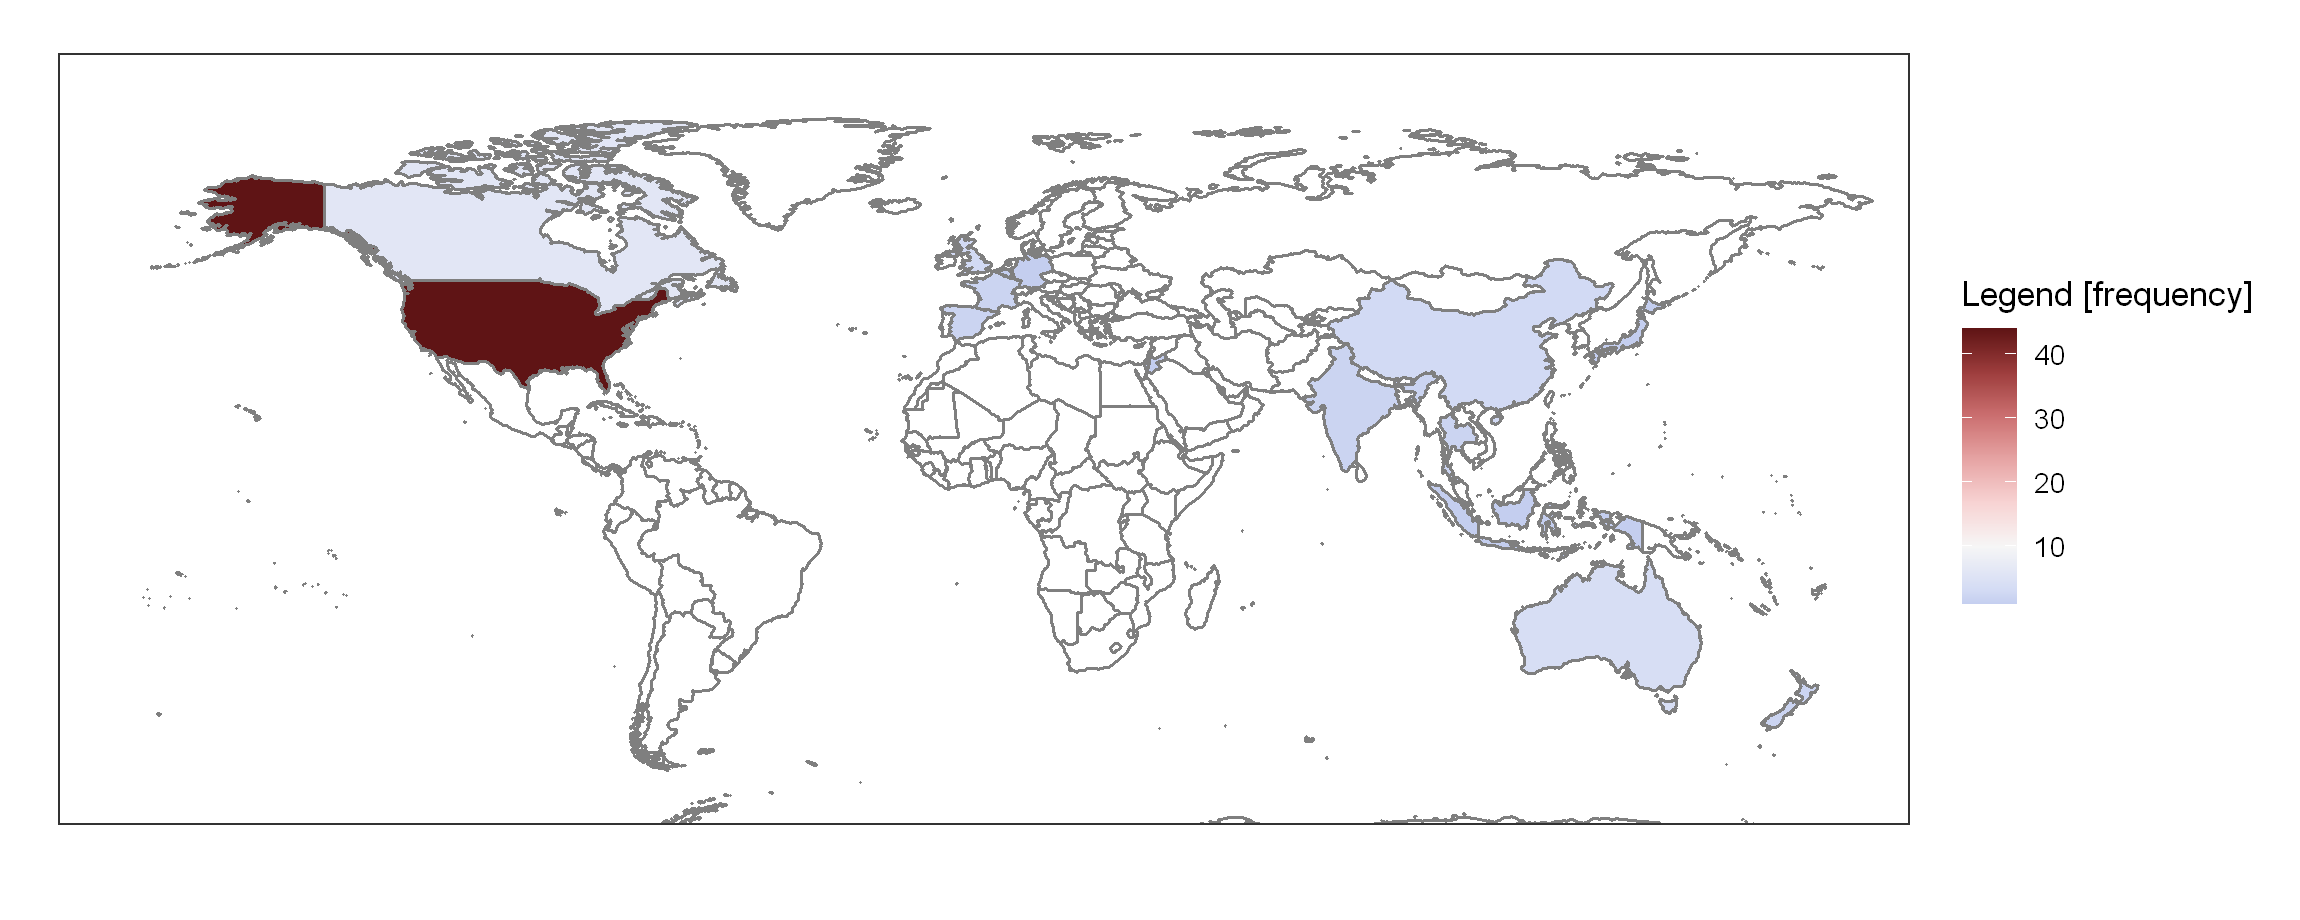

In [658]:
WorldData <- map_data('world')

ggplot() +
  geom_map(
    data = WorldData, map = WorldData,
    aes(x = long, y = lat, group = group, map_id = region),
    fill = "white", colour = "#7f7f7f", size=0.5
  ) + 
  geom_map(
    data = country.df, map=WorldData,
    aes(fill=Freq, map_id=region),
    colour="#7f7f7f", size=0.5
  ) +
  coord_map("rectangular", lat0=0, xlim=c(-180,180), ylim=c(-60, 90)) +
  # scale_fill_continuous(type = "viridis") +  # alternative scale color
  scale_fill_continuous_diverging(
    palette = "Blue-Red 3",  # rev = TRUE,
    mid = 10
  ) +  # scale color
  scale_y_continuous(breaks=c()) +
  scale_x_continuous(breaks=c()) +
  labs(fill="Legend [frequency]", x="", y="") +
  theme_bw()

### Intervention

#### Distribution

##### Meditation types

In [659]:
meditation.techniques.all.vec <- unlist(meditation.techniques.df,use.names = FALSE)  # get all elements of df
meditation.techniques.all.vec <- meditation.techniques.all.vec[which(!(
  is.na(meditation.techniques.all.vec) | meditation.techniques.all.vec %in% c("NA", "None", 'No Intervention', "Wait-List Control")
))]  # cut out NAs
meditation.techniques.all.vec <- sort(unlist(str_split(meditation.techniques.all.vec, "; "), use.names=FALSE))  # split by "; " and sort
meditation.techniques.freq.df <- data.frame(table(meditation.techniques.all.vec))  # create df of frequencies
colnames(meditation.techniques.freq.df) <- c("Meditation Techniques", "Frequency")

# recluster meditation types
other.count <- 0
open.monitoring.count <- 0
loving.kindness.count <- 0

for (med.tech in meditation.techniques.freq.df[, "Meditation Techniques"]){
  # others
  if (grepl(
    "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled",
    med.tech
    ) | grepl(
    "Other: devotional readings to ponder, meditations taken from a widely used devotional book designed for Christian readers titled, forgiveness meditations",
    med.tech
    ) | grepl(
    "Other: mindfulness-based exercises through audio video or text files, grounding visualization, gratitude, imagining the life you want, finding meaning",
    med.tech
    ) | grepl(
    "Other: mindfulness toward sensations and experiences of the body, mindfulness toward the contents of the mind, skill of mental noting to label their mental contents, cultivating awareness and understanding of emotions as mental contents and the nonjudgmental stance toward emotions with a goal of optimizing the response to one’s emotions",
    med.tech
    ) | grepl(
    "Other: Readings reflecting meditative perspective",
    med.tech
  )){
    other.count <- other.count + 1
  
  # open monitoring
  } else if (grepl(
    "Other: \"awareness to any sensations in their body or in their immediate environment\", focus on \"thoughts and feelings\",  \"non-judgmental observation\"",
    med.tech
    ) | grepl(
    "Other: silent meditations with bells, personalized meditations with or without guided\nintro and bells",
    med.tech
  )){
    open.monitoring.count <- open.monitoring.count + 1
  
  # loving kindness
  } else if (grepl(
    "Other: focusing on meta-awareness, \"Mindfulness-based exercises [[]...[]] about happiness in life as the result of a benevolent attitude towards life and a positive relationship to oneself and others\", \"Methods of introspection, reflection and self-care\"",
    med.tech
  )){
    loving.kindness.count <- loving.kindness.count + 1
  }
}

# cut out others (others are not clustered properly)
meditation.techniques.freq.df <- meditation.techniques.freq.df[
  which(!grepl("Other", meditation.techniques.freq.df[,"Meditation Techniques"])),
]

# correct data types
meditation.techniques.freq.df[,"Meditation Techniques"] <- as.character(meditation.techniques.freq.df[,"Meditation Techniques"])
meditation.techniques.freq.df[,"Frequency"] <- as.double(meditation.techniques.freq.df[,"Frequency"])

# assign reclustered meditation types
meditation.techniques.freq.df[nrow(meditation.techniques.freq.df) + 1,] <- c("various techniques", other.count)  # add others' other.count

meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Open Monitoring Meditation"), "Frequency"] <-
as.double(meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Open Monitoring Meditation"), "Frequency"]) + open.monitoring.count

meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Loving-Kindness Meditation"), "Frequency"] <-
as.double(meditation.techniques.freq.df[which(meditation.techniques.freq.df[, "Meditation Techniques"] == "Loving-Kindness Meditation"), "Frequency"]) + loving.kindness.count

# sort by frequency
meditation.techniques.freq.df <- meditation.techniques.freq.df[order(-as.double(meditation.techniques.freq.df$Frequency)),]

rownames(meditation.techniques.freq.df) <- 1:nrow(meditation.techniques.freq.df)  # adjust indices
meditation.techniques.freq.df

Meditation Techniques                Frequency
1  Breathing Exercise (no further Info) 49       
2  Body Scan                            24       
3  Loving-Kindness Meditation           11       
⋮  ⋮                                    ⋮        
19 Vipassana                            1        
20 Zen Meditation                       1

In [660]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 150)

In [661]:
# correct data type of $Frequency again (wasn't working above)
meditation.techniques.freq.df[,"Frequency"] <- as.double(meditation.techniques.freq.df[,"Frequency"])
meditation.techniques.freq.df

Meditation Techniques                Frequency
1  Breathing Exercise (no further Info) 49       
2  Body Scan                            24       
3  Loving-Kindness Meditation           11       
⋮  ⋮                                    ⋮        
19 Vipassana                            1        
20 Zen Meditation                       1

In [662]:
meditation.techniques.freq.df[1,"Meditation Techniques"] <- str_to_lower("Breathing Exercise")

In [663]:
# correct spelling
i <- 1
for (med.tech in meditation.techniques.freq.df[, "Meditation Techniques"]){
  meditation.techniques.freq.df[i,"Meditation Techniques"] <- str_to_lower(meditation.techniques.freq.df[i,"Meditation Techniques"])  # convert strings to lower case
  meditation.techniques.freq.df[i,"Meditation Techniques"] <- gsub("\"", "'", meditation.techniques.freq.df[i,"Meditation Techniques"])  # replace " with '
  i <- i + 1
}

meditation.techniques.freq.df <- replace_val_in_df(
  df = meditation.techniques.freq.df, col = 1,
  search = "transcendental meditation", replace = "transcendental meditation"
)

meditation.techniques.freq.df <- replace_val_in_df(
  df = meditation.techniques.freq.df, col = 1,
  search = "only 'mindfulness meditation' named", replace = "'mindfulness meditation'"
)

meditation.techniques.freq.df <- replace_val_in_df(
  df = meditation.techniques.freq.df, col = 1,
  search = "only 'focused attention meditation' named", replace = "'focused attention meditation'"
)

meditation.techniques.freq.df <- replace_val_in_df(
  df = meditation.techniques.freq.df, col = 1,
  search = "breathing exercise", replace = "breathing exercise"
)

meditation.techniques.freq.df

Meditation Techniques      Frequency
1  breathing exercise         49       
2  body scan                  24       
3  loving-kindness meditation 11       
⋮  ⋮                          ⋮        
19 vipassana                  1        
20 zen meditation             1

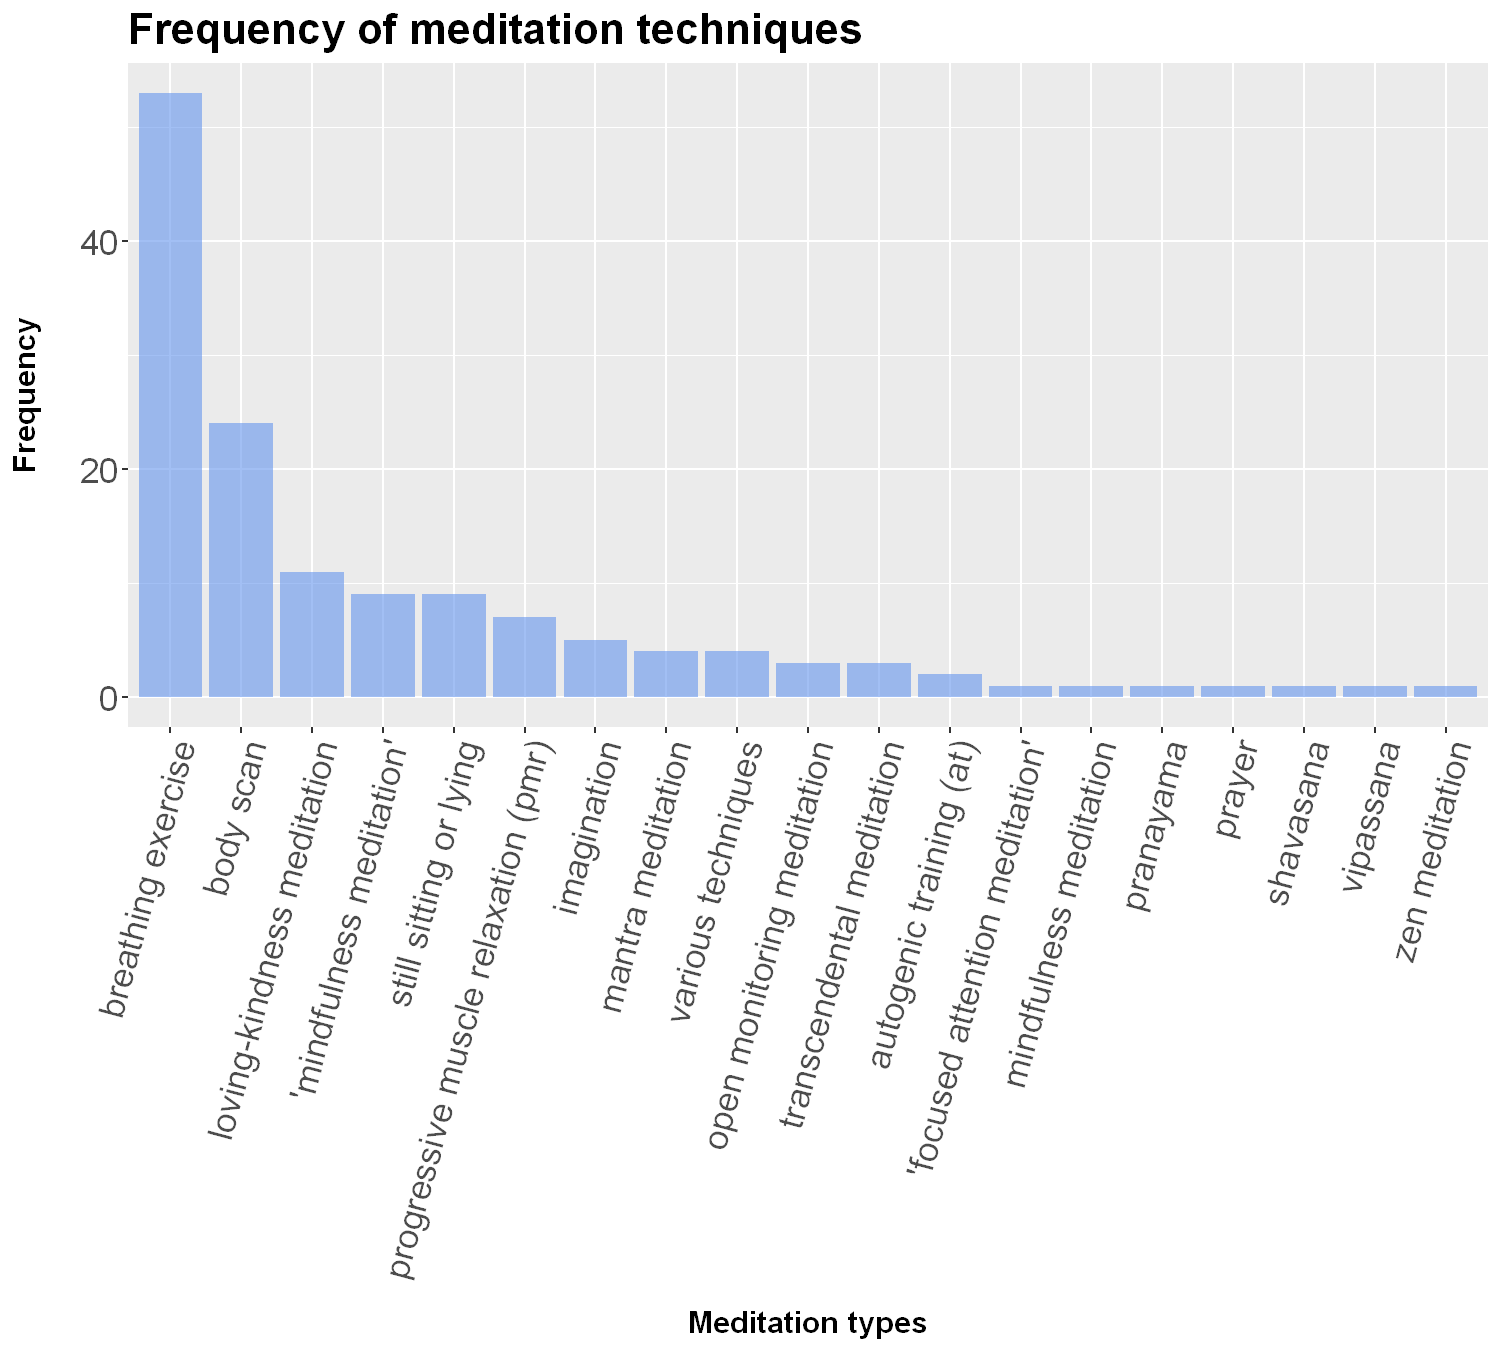

In [664]:
ggplot(meditation.techniques.freq.df, aes(x = reorder(`Meditation Techniques`, -Frequency), y = Frequency)) +
  geom_bar(stat="identity", fill = "cornflowerblue", alpha = 0.6) +
  theme(
    title = element_text(size = 17, face = "bold"),
    axis.title = element_text(size = 15, face = "bold"),
    axis.text.x = element_text(angle=75, vjust=1, hjust=1, size = 17),
    axis.text.y = element_text(size = 17)
  ) +
  labs(
    title = "Frequency of meditation techniques",
    x = "\nMeditation types",
    y = "Frequency\n"
  )
# others are not clustered properly --> statistic is biased

##### Meditation families

In [665]:
# do same for meditation families
meditation.type.attentional.freq <- 0
meditation.type.constructive.freq <- 0
meditation.type.deconstructive.freq <- 0

for (col in 1:ncol(meditation.techniques.df)){
  for (row in 1:nrow(meditation.techniques.df)){
    med.tech <- meditation.techniques.df[row, col]
    
    if (med.tech %in% meditation.type.all.list[[1]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[2]]){
      meditation.type.constructive.freq <- meditation.type.constructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[3]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
      meditation.type.constructive.freq <- meditation.type.constructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[4]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
      meditation.type.deconstructive.freq <- meditation.type.deconstructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[5]]){
      meditation.type.attentional.freq <- meditation.type.attentional.freq + 1
      meditation.type.constructive.freq <- meditation.type.constructive.freq + 1
      meditation.type.deconstructive.freq <- meditation.type.deconstructive.freq + 1
    } else if (med.tech %in% meditation.type.all.list[[6]]){
      meditation.type.deconstructive.freq <- meditation.type.deconstructive.freq + 1
    }
  }
}

meditation.families.count.df <- data.frame(
  `Meditation Families` = c(
    "attentional familiy", "constructive family", "deconstructive familiy"
  ),
  Frequency = c(
    meditation.type.attentional.freq, meditation.type.constructive.freq, meditation.type.deconstructive.freq
  )
)
meditation.families.count.df <- meditation.families.count.df[order(meditation.families.count.df$Frequency),]
meditation.families.count.df

Meditation.Families    Frequency
3 deconstructive familiy  6       
2 constructive family    21       
1 attentional familiy    98

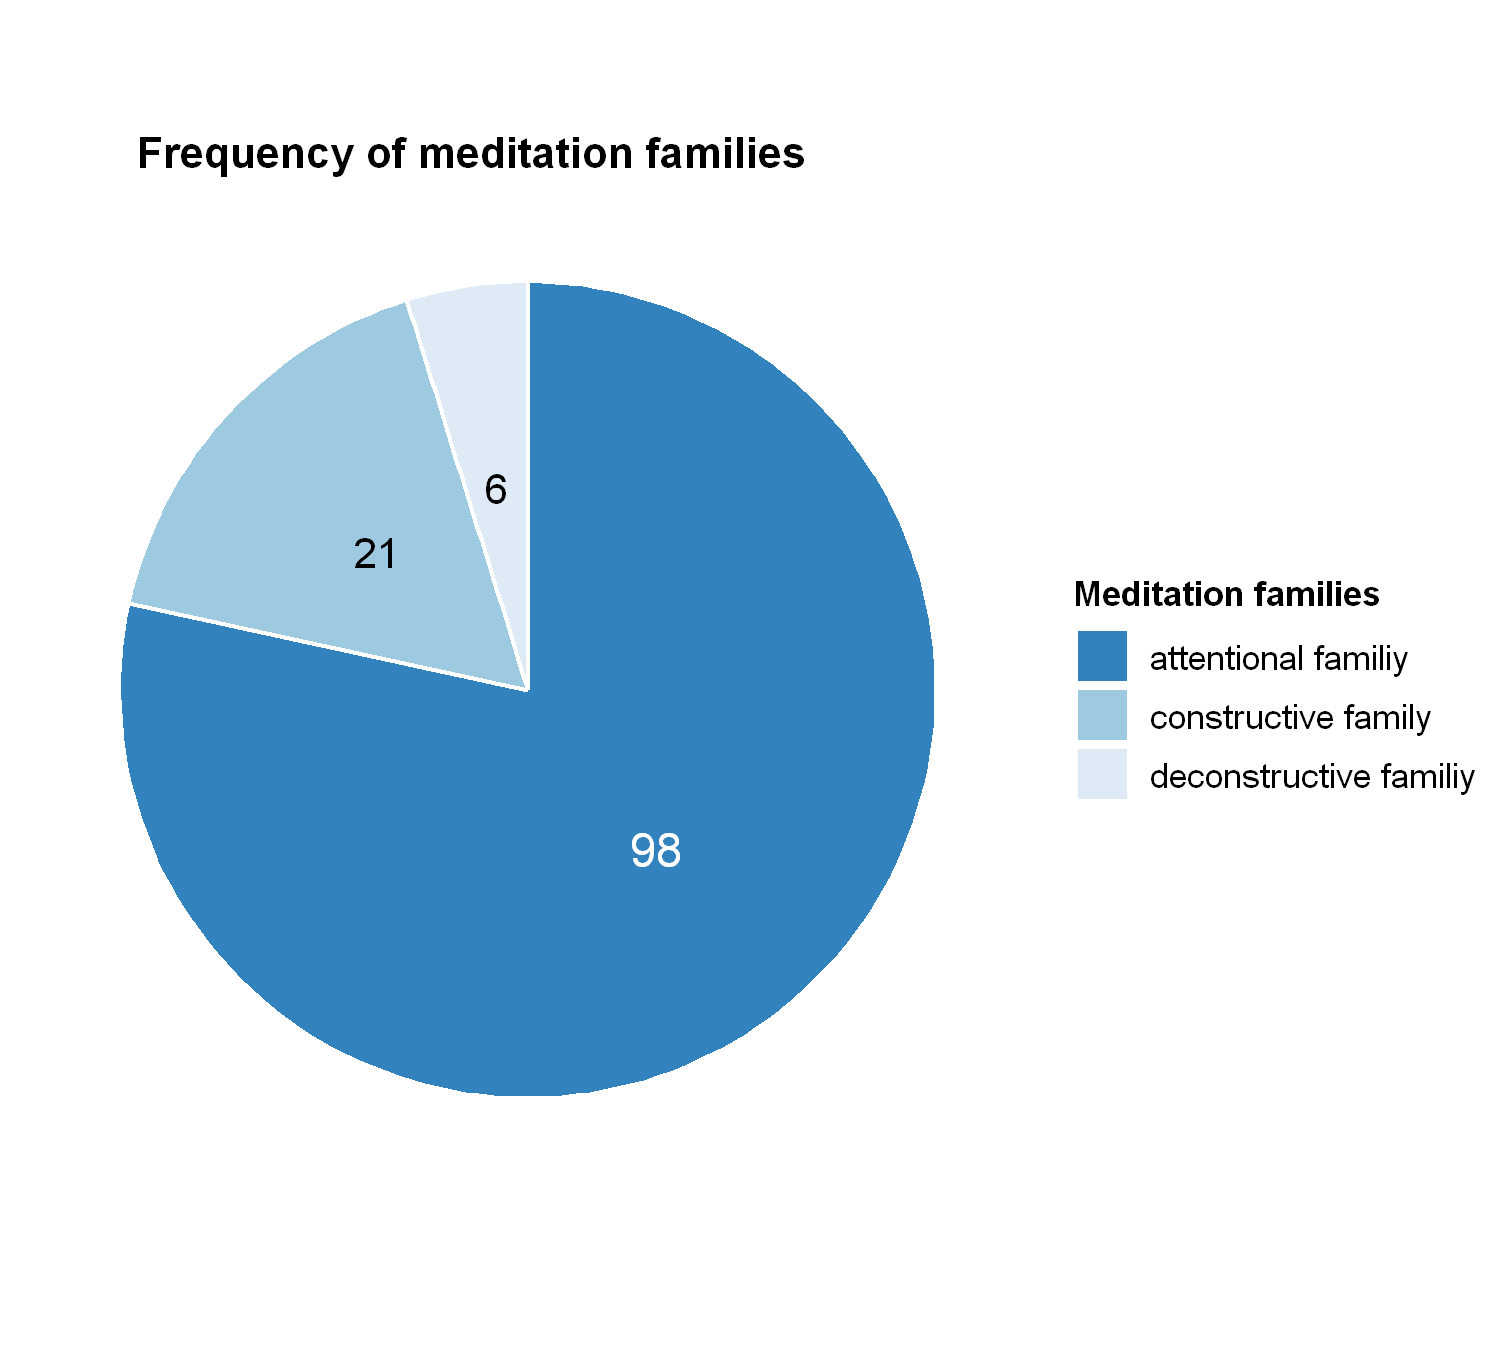

In [666]:
ggplot(meditation.families.count.df, aes(x = "", y = Frequency, fill=reorder(Meditation.Families, Frequency))) +
  geom_bar(stat="identity", color = "white", width=1, size = 0.9) +
  coord_polar("y", start=0) +
  geom_text(
    aes(label = Frequency),
    position = position_stack(vjust=0.5),
    col = c(rep("black", 2), "white"),
    size = c(rep(7, 2), 8)
  ) +  #text within pie pieces
  guides(fill = guide_legend(reverse = TRUE, override.aes = list(size = 10))) +  # reverse legend order
  labs(
    title = "          Frequency of meditation families",
    x = NULL, y = NULL, fill = "Meditation families"
  ) +  # labels
  theme_classic() +
  theme(
    title = element_text(size = 17, face = "bold"),
    axis.line = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    legend.text = element_text(size = 17),
    legend.title = element_text(size = 17)
  ) +  # adjust texts
  scale_fill_brewer(palette="Blues")  # set color palette

##### Intervention Characteristics

In [667]:
# Function | Get intervention characteristics by study
get.int.char.by.stud <- function(study.names.vec){
  # calculate mean sd and range of sessions' duration and frequency and programs duration
  sessions.durations.vec <- c()
  sessions.durations.report.count <- c()

  sessions.frequencies.vec <- c()
  sessions.frequencies.report.count <- c()

  programs.durations.vec <- c()
  programs.durations.report.count <- c()

  for (study in 1:study.no){
    
    # skip if study number is not presnet in study.names
    if (!study %in% which(study.names %in% study.names.vec)){
      next
    }
    
    df <- intervention.comparisons.df.list[[study]]

    sessions.durations.report.count <- append(
      sessions.durations.report.count,
      ifelse(
        F %in% is.na.or.nm(df[, "Sessions.Duration.in.minutes"]),
        1, 0
      )
    )

    sessions.frequencies.report.count <- append(
      sessions.frequencies.report.count,
      ifelse(
        F %in% is.na.or.nm(df[, "Frequency.in.times.per.week"]),
        1, 0
      )
    )

    programs.durations.report.count <- append(
      programs.durations.report.count,
      ifelse(
        F %in% is.na.or.nm(df[, "Total.Duration.in.Days"]),
        1, 0
      )
    )

    for (row in 1:nrow(df)){
      sessions.duration <- ifelse(is.na.or.nm(df[row, "Sessions.Duration.in.minutes"]), NA, df[row, "Sessions.Duration.in.minutes"])
      sessions.durations.vec <- append(sessions.durations.vec, sessions.duration)

      sessions.frequency <- ifelse(is.na.or.nm(df[row, "Frequency.in.times.per.week"]), NA, df[row, "Frequency.in.times.per.week"])
      sessions.frequencies.vec <- append(sessions.frequencies.vec, sessions.frequency)

      programs.duration <- ifelse(is.na.or.nm(df[row, "Total.Duration.in.Days"]), NA, df[row, "Total.Duration.in.Days"])
      programs.durations.vec <- append(programs.durations.vec, programs.duration)
    }
  }

  sessions.duration.mean.total <- round(mean(sessions.durations.vec, na.rm = T), digits = 2)
  sessions.duration.sd.total <- round(sd(sessions.durations.vec, na.rm = T), digits = 2)
  sessions.duration.range.total <- paste(as.character(c(min(sessions.durations.vec, na.rm = T), max(sessions.durations.vec, na.rm = T))), collapse = ", ")

  sessions.frequency.mean.total <- round(mean(sessions.frequencies.vec, na.rm = T), digits = 2)
  sessions.frequency.sd.total <- round(sd(sessions.frequencies.vec, na.rm = T), digits = 2)
  sessions.frequency.range.total <- paste(as.character(c(min(sessions.frequencies.vec, na.rm = T), max(sessions.frequencies.vec, na.rm = T))), collapse = ", ")

  programs.duration.mean.total <- round(mean(programs.durations.vec, na.rm = T), digits = 2)
  programs.duration.sd.total <- round(sd(programs.durations.vec, na.rm = T), digits = 2)
  programs.duration.range.total <- paste(as.character(c(min(programs.durations.vec, na.rm = T), max(programs.durations.vec, na.rm = T))), collapse = ", ")

  intervention.characteristics.descriptive.df <- data.frame(
    Mean = c(sessions.duration.mean.total, sessions.frequency.mean.total, programs.duration.mean.total),
    SD = c(sessions.duration.sd.total, sessions.frequency.sd.total, programs.duration.sd.total),
    Range = c(sessions.duration.range.total, sessions.frequency.range.total, programs.duration.range.total),
    `Percentage of reporting studies` = round(
      c(sum(sessions.durations.report.count), sum(sessions.frequencies.report.count), sum(programs.durations.report.count)) / length(study.names.vec) * 100,
      digits = 2
    ),
    row.names = list("Sessions' Duration [minutes]", "Sessions' Frequency [1/week]", "Interventions' Duration [days]")
  )
  intervention.characteristics.descriptive.df
}

In [668]:
# calculate mean sd and range of sessions' duration and frequency and programs duration
sessions.durations.vec <- c()
sessions.durations.report.count <- c()

sessions.frequencies.vec <- c()
sessions.frequencies.report.count <- c()

programs.durations.vec <- c()
programs.durations.report.count <- c()

for (study in 1:study.no){
  df <- intervention.comparisons.df.list[[study]]
  
  sessions.durations.report.count <- append(
    sessions.durations.report.count,
    ifelse(
      F %in% is.na.or.nm(df[, "Sessions.Duration.in.minutes"]),
      1, 0
    )
  )
  
  sessions.frequencies.report.count <- append(
    sessions.frequencies.report.count,
    ifelse(
      F %in% is.na.or.nm(df[, "Frequency.in.times.per.week"]),
      1, 0
    )
  )
  
  programs.durations.report.count <- append(
    programs.durations.report.count,
    ifelse(
      F %in% is.na.or.nm(df[, "Total.Duration.in.Days"]),
      1, 0
    )
  )
  
  for (row in 1:nrow(df)){
    sessions.duration <- ifelse(is.na.or.nm(df[row, "Sessions.Duration.in.minutes"]), NA, df[row, "Sessions.Duration.in.minutes"])
    sessions.durations.vec <- append(sessions.durations.vec, sessions.duration)
    
    sessions.frequency <- ifelse(is.na.or.nm(df[row, "Frequency.in.times.per.week"]), NA, df[row, "Frequency.in.times.per.week"])
    sessions.frequencies.vec <- append(sessions.frequencies.vec, sessions.frequency)
    
    programs.duration <- ifelse(is.na.or.nm(df[row, "Total.Duration.in.Days"]), NA, df[row, "Total.Duration.in.Days"])
    programs.durations.vec <- append(programs.durations.vec, programs.duration)
  }
}

sessions.duration.mean.total <- round(mean(sessions.durations.vec, na.rm = T), digits = 2)
sessions.duration.sd.total <- round(sd(sessions.durations.vec, na.rm = T), digits = 2)
sessions.duration.range.total <- paste(as.character(c(min(sessions.durations.vec, na.rm = T), max(sessions.durations.vec, na.rm = T))), collapse = ", ")

sessions.frequency.mean.total <- round(mean(sessions.frequencies.vec, na.rm = T), digits = 2)
sessions.frequency.sd.total <- round(sd(sessions.frequencies.vec, na.rm = T), digits = 2)
sessions.frequency.range.total <- paste(as.character(c(min(sessions.frequencies.vec, na.rm = T), max(sessions.frequencies.vec, na.rm = T))), collapse = ", ")

programs.duration.mean.total <- round(mean(programs.durations.vec, na.rm = T), digits = 2)
programs.duration.sd.total <- round(sd(programs.durations.vec, na.rm = T), digits = 2)
programs.duration.range.total <- paste(as.character(c(min(programs.durations.vec, na.rm = T), max(programs.durations.vec, na.rm = T))), collapse = ", ")

intervention.characteristics.descriptive.df <- data.frame(
  Mean = c(sessions.duration.mean.total, sessions.frequency.mean.total, programs.duration.mean.total),
  SD = c(sessions.duration.sd.total, sessions.frequency.sd.total, programs.duration.sd.total),
  Range = c(sessions.duration.range.total, sessions.frequency.range.total, programs.duration.range.total),
  `Percentage of reporting studies` = round(
    c(sum(sessions.durations.report.count), sum(sessions.frequencies.report.count), sum(programs.durations.report.count)) / study.no * 100,
    digits = 2
  ),
  row.names = list("Sessions' Duration [minutes]", "Sessions' Frequency [1/week]", "Interventions' Duration [days]")
)
intervention.characteristics.descriptive.df

Warning message in mean.default(sessions.durations.vec, na.rm = T):
"argument is not numeric or logical: returning NA"
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"NAs introduced by coercion"
Warning message in mean.default(sessions.frequencies.vec, na.rm = T):
"argument is not numeric or logical: returning NA"
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"NAs introduced by coercion"


Mean  SD    Range   
Sessions' Duration [minutes]      NA 18.42 10, 90  
Sessions' Frequency [1/week]      NA  3.30 0.714, 9
Interventions' Duration [days] 21.42 27.17 0, 152  
                               Percentage.of.reporting.studies
Sessions' Duration [minutes]   80.68                          
Sessions' Frequency [1/week]   71.59                          
Interventions' Duration [days] 96.59

In [669]:
length(sessions.durations.vec[!is.na.or.nm(sessions.durations.vec)])
length(sessions.frequencies.vec[!is.na.or.nm(sessions.frequencies.vec)])
length(programs.durations.vec[!is.na.or.nm(programs.durations.vec)])

[1] 139

[1] 133

[1] 180

### Outcomes

###### Outcome numbers

In [670]:
outcomes.no.ordered.freq.df <- outcomes.no.df[order(-outcomes.no.df$Freq),]
colnames(outcomes.no.ordered.freq.df) <- c("Outcome", "Frequency")

studies.suff.data.pas.vec <- c()
studies.suff.data.pas.num <- 0

studies.suff.data.act.vec <- c()
studies.suff.data.act.num <- 0

studies.suff.data.mix.vec <- c()
studies.suff.data.mix.num <- 0


i <- 1
for (outcome in outcomes.no.ordered.freq.df$Outcome){
  # get studies that supply sufficient data for outcomes to caclulate meta-analyses for comparison to passive controls
  uni.stud.p.outcome.pas <- unique(
    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome),
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
      return.data = "meta.df.list"
    )[[1]][,1]
  )
  
  # get the same for all active control groups
  uni.stud.p.outcome.act <- unique(
    meta.analyze(
      outcome, meditation.type.all, m.data.list, preferred.scale = get.1st.preferred.scale(outcome), comparison.list = list(meditation.type.all, control.all.active),
      split.subgroups = F, return.data = "meta.df.list"
    )[[1]][,1]
  )
  
  uni.stud.p.outcome.pas.only <- uni.stud.p.outcome.pas[!uni.stud.p.outcome.pas %in% uni.stud.p.outcome.act]
  uni.stud.p.outcome.act.only <- uni.stud.p.outcome.act[!uni.stud.p.outcome.act %in% uni.stud.p.outcome.pas]
  uni.stud.p.outcome.mixed <- uni.stud.p.outcome.pas[uni.stud.p.outcome.pas %in% uni.stud.p.outcome.act]
  
  # insert number of these studies into df
  outcomes.no.ordered.freq.df[i, "Frequency sufficient data passive only"] <- length(uni.stud.p.outcome.pas.only)
  outcomes.no.ordered.freq.df[i, "Frequency sufficient data active only"] <- length(uni.stud.p.outcome.act.only)
  outcomes.no.ordered.freq.df[i, "Frequency sufficient data mixed"] <- length(uni.stud.p.outcome.mixed)
  
  # count number of studies that deliver sufficient data
  ## for passive only
  ### count
  for (study in uni.stud.p.outcome.pas.only){
    if (!study %in% studies.suff.data.pas.vec){
      studies.suff.data.pas.num <- studies.suff.data.pas.num + 1
    }
  }
  
  #### add study names to vec
  studies.suff.data.pas.vec <- append(studies.suff.data.pas.vec, uni.stud.p.outcome.pas)
  
  ## for passive only
  ### count
  for (study in uni.stud.p.outcome.act.only){
    if (!study %in% studies.suff.data.act.vec){
      studies.suff.data.act.num <- studies.suff.data.act.num + 1
    }
  }
  
  ### add study names to vec
  studies.suff.data.act.vec <- append(studies.suff.data.act.vec, uni.stud.p.outcome.act)
  
  ## for actvie and passive controls
  ### count
  for (study in uni.stud.p.outcome.mixed){
    if (!study %in% studies.suff.data.mix.vec){
      studies.suff.data.mix.num <- studies.suff.data.mix.num + 1
    }
  }
  
  ### add study names to vec
  studies.suff.data.mix.vec <- append(studies.suff.data.mix.vec, uni.stud.p.outcome.mixed)
  
  i <- i + 1
}

outcomes.no.ordered.freq.df$Outcome <- str_to_lower(as.character(outcomes.no.ordered.freq.df$Outcome))

outcomes.no.ordered.freq.df


# Anxiety ----------------------------------

# Stress ----------------------------------

# Mindfulness ----------------------------------

# Depression ----------------------------------

# Positive affect ----------------------------------
no studies included for outcome: Positive affect 


# Well-being ----------------------------------

# Self-compassion ----------------------------------

# Resilience Scale ----------------------------------

# Empathy ----------------------------------
no studies included for outcome: Empathy 


# Positive emotion ----------------------------------

# Self-efficacy ----------------------------------
no studies included for outcome: Self-efficacy 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 

no studies included for outcome: Acceptance 


# Active coping ----------------------------------
no studies included for outcome: Active coping 


# Cognitive control ----------------------------------
no s

Outcome         Frequency Frequency sufficient data passive only
3  anxiety         50        10                                    
18 stress          45        14                                    
8  mindfulness     32         9                                    
⋮  ⋮               ⋮         ⋮                                     
14 self-acceptance 1         1                                     
17 self-esteem     1         0                                     
   Frequency sufficient data active only Frequency sufficient data mixed
3  14                                    4                              
18  9                                    4                              
8   9                                    1                              
⋮  ⋮                                     ⋮                              
14 0                                     0                              
17 0                                     0

In [671]:
# total freq of outcomes
outcomes.no.ordered.freq.plot.df <- outcomes.no.ordered.freq.df[,c(1,2)]

# freq of outcomes with sufficient data for active/passive controls and both respecitvely
outcomes.no.ordered.suff.dat.pas.plot.df <- outcomes.no.ordered.freq.df[,c(1,3)]
outcomes.no.ordered.suff.dat.act.plot.df <- outcomes.no.ordered.freq.df[,c(1,4)]
outcomes.no.ordered.suff.dat.mix.plot.df <- outcomes.no.ordered.freq.df[,c(1,5)]

# rename cols
names(outcomes.no.ordered.suff.dat.pas.plot.df) <- c("Outcome", "Frequency")
names(outcomes.no.ordered.suff.dat.act.plot.df) <- c("Outcome", "Frequency")
names(outcomes.no.ordered.suff.dat.mix.plot.df) <- c("Outcome", "Frequency")

# add col telling for what sufficient data is present
outcomes.no.ordered.suff.dat.pas.plot.df$`Sufficient data for meta-analysis` <- "04_for_passive_controls_only"
 
outcomes.no.ordered.suff.dat.act.plot.df$`Sufficient data for meta-analysis` <- "02_for_active_controls_only"

outcomes.no.ordered.suff.dat.mix.plot.df$`Sufficient data for meta-analysis` <- "03_for_active_and_passive_controls"

# df with freq of no sufficient data
outcomes.no.ordered.freq.plot.df$Frequency <- outcomes.no.ordered.freq.plot.df$Frequency - (
  outcomes.no.ordered.suff.dat.pas.plot.df$Frequency + outcomes.no.ordered.suff.dat.act.plot.df$Frequency + outcomes.no.ordered.suff.dat.mix.plot.df$Frequency
)

outcomes.no.ordered.freq.plot.df$`Sufficient data for meta-analysis` <- "01_for_no_case"


# outcomes.no.ordered.suff.dat.plot.df$Frequency <- outcomes.no.ordered.freq.plot.df$Frequency - (outcomes.no.ordered.freq.plot.df$Frequency - outcomes.no.ordered.suff.dat.plot.df$Frequency)

# bring all dfs together
outcomes.no.ordered.freq.plot.df <- rbind(
  outcomes.no.ordered.freq.plot.df,
  outcomes.no.ordered.suff.dat.act.plot.df,
  outcomes.no.ordered.suff.dat.mix.plot.df,
  outcomes.no.ordered.suff.dat.pas.plot.df
)

# rename rownames
rownames(outcomes.no.ordered.freq.plot.df) <- 1:nrow(outcomes.no.ordered.freq.plot.df)


# outcomes.no.ordered.freq.plot.df$`Sufficient data for meta-analysis` <- NA
# outcomes.no.ordered.freq.plot.df[1:(nrow(outcomes.no.ordered.freq.plot.df)/2),"Sufficient data for meta-analysis"] <- "yes"
# outcomes.no.ordered.freq.plot.df[20:nrow(outcomes.no.ordered.freq.plot.df), "Sufficient data for meta-analysis"] <- "no"

outcomes.no.ordered.freq.plot.df

Outcome         Frequency Sufficient data for meta-analysis
1  anxiety         22        01_for_no_case                   
2  stress          18        01_for_no_case                   
3  mindfulness     13        01_for_no_case                   
⋮  ⋮               ⋮         ⋮                                
75 self-acceptance 1         04_for_passive_controls_only     
76 self-esteem     0         04_for_passive_controls_only

In [672]:
# create labels shown in outcome frequency plots
outcome.freq.labels <- c()
iter.count <- nrow(outcomes.no.ordered.freq.plot.df)
for (i in 1:iter.count){
  freq <- outcomes.no.ordered.freq.plot.df[i,"Frequency"]
  if (freq %in% c(0, 1)){
    freq <- ""
  }
  outcome.freq.labels <- append(
    outcome.freq.labels,
    freq
  )
}
outcome.freq.labels

[1] "22" "18" "13" "9"  "5"  "7"  "3"  ""   "2"  ""   ""   ""   ""   ""   ""  
[16] ""   ""   ""   ""   "14" "9"  "9"  "6"  "9"  ""   ""   "2"  ""   ""   ""  
[31] ""   ""   ""   ""   ""   ""   ""   ""   "4"  "4"  ""   "2"  ""   ""   ""  
[46] ""   ""   ""   ""   ""   ""   ""   ""   ""   ""   ""   ""   "10" "14" "9" 
[61] "10" ""   "5"  "2"  "2"  ""   ""   ""   ""   ""   ""   ""   ""   ""   ""  
[76] ""

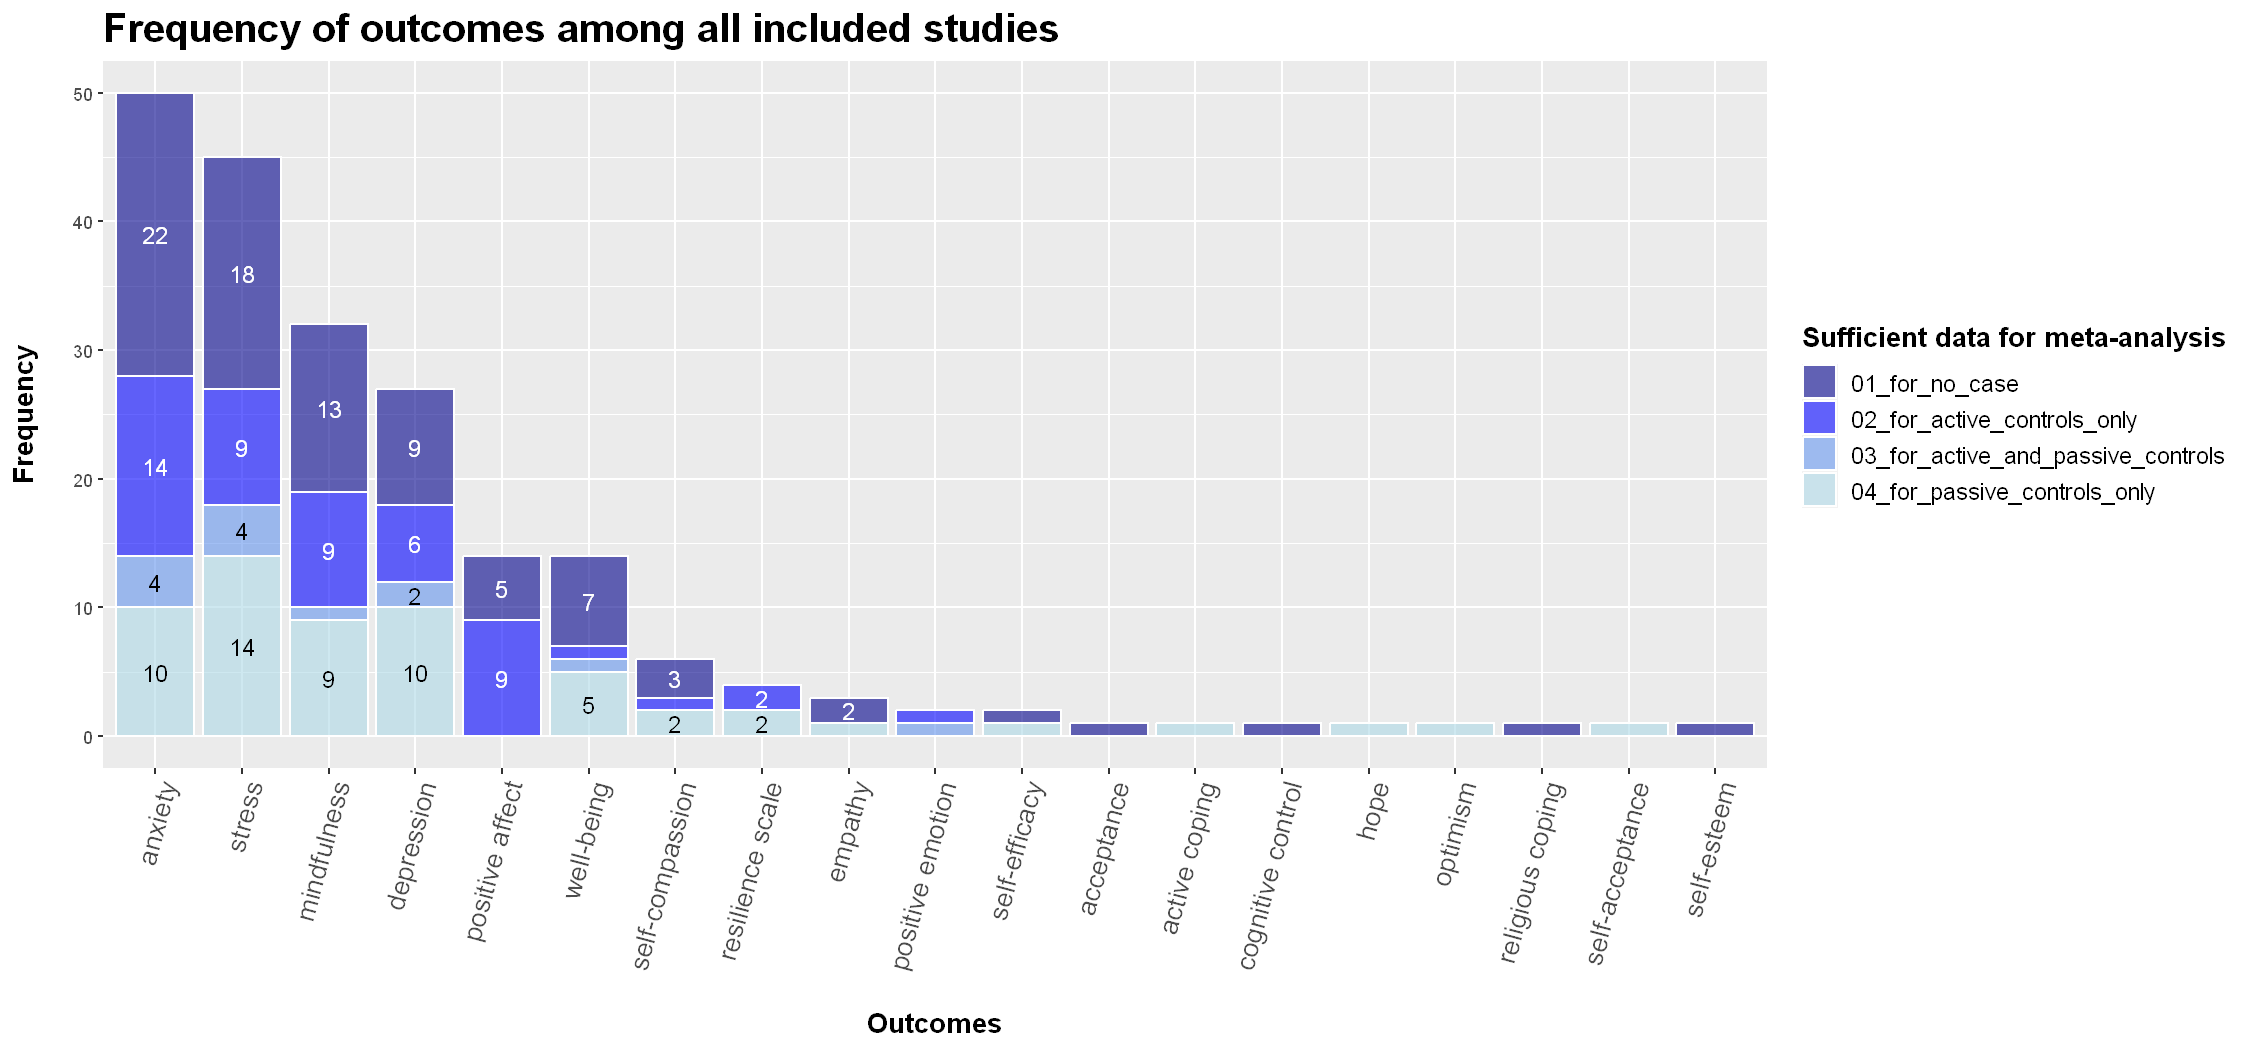

In [673]:
# set plot size
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 150)

row.no <- nrow(outcomes.no.ordered.freq.plot.df)
ggplot(outcomes.no.ordered.freq.plot.df, aes(x = reorder(Outcome, -Frequency), y = Frequency, fill = `Sufficient data for meta-analysis`)) +
  geom_bar(stat="identity", alpha = 0.6, colour = "white") +
  geom_text(
    aes(label = outcome.freq.labels),
    position = position_stack(vjust=0.5),
    color = c(rep("white", length(outcome.freq.labels) / 2), rep("black", length(outcome.freq.labels) / 2))
  ) + 
  theme(
    title = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 13, face = "bold"),
    legend.text = element_text(size = 11),
    axis.title = element_text(size = 13, face = "bold"),
    axis.text.x = element_text(angle=75, vjust=1, hjust=1, size = 13)
  ) +
  labs(
    title = "Frequency of outcomes among all included studies",
    x = "\nOutcomes",
    y = "Frequency\n"
  ) +
  scale_fill_manual(values=c("darkblue", "blue","cornflowerblue", "lightblue"))

###### Participants per outcome (only passive controls)

In [674]:
# participants per outcomes (with and without outliers)
part.p.group.p.outcome.df <- data.frame(
  Experimental.group = rep(NA, length(present.outcomes)),
  Experimental.group.no.outl. = rep(NA, length(present.outcomes)),
  Control.group = rep(NA, length(present.outcomes)),
  Control.group.no.outl. = rep(NA, length(present.outcomes)),
  Total = rep(NA, length(present.outcomes)),
  Total.no.outl. = rep(NA, length(present.outcomes)),
  row.names = present.outcomes.sorted
)

for (outcome in present.outcomes.sorted){
  # get data without outliers
  outliers <- outlier.list[[outcome]]
  results.meta.wo.o <-  print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta", filter.forest..funnel.vec = if(length(outliers) != 0){-outliers}else{FALSE}
  )
  n.e.wo.o <- if(results.meta.wo.o$k == 0){0}else{results.meta.wo.o$n.e.pooled}
  n.c.wo.o <- if(results.meta.wo.o$k == 0){0}else{results.meta.wo.o$n.c.pooled}
  part.p.group.p.outcome.df[outcome, "Experimental.group.no.outl."] <- n.e.wo.o
  part.p.group.p.outcome.df[outcome, "Control.group.no.outl."] <- n.c.wo.o
  part.p.group.p.outcome.df[outcome, "Total.no.outl."] <- n.e.wo.o + n.c.wo.o
  
  # get data with outliers included
  results.meta.w.o <-  print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )
  n.e.w.o <- if(results.meta.w.o$k == 0){0}else{results.meta.w.o$n.e.pooled}
  n.c.w.o <- if(results.meta.w.o$k == 0){0}else{results.meta.w.o$n.c.pooled}
  part.p.group.p.outcome.df[outcome, "Experimental.group"] <- n.e.w.o
  part.p.group.p.outcome.df[outcome, "Control.group"] <- n.c.w.o
  part.p.group.p.outcome.df[outcome, "Total"] <- n.c.w.o + n.e.w.o
}

# add row with sums
part.p.group.p.outcome.df <- rbind(
  part.p.group.p.outcome.df,
  data.frame(
    part.p.group.p.outcome.df %>%
      summarise(across(everything(), ~ sum(., na.rm = TRUE))),
    row.names = "Sum"
  )
)
part.p.group.p.outcome.df


# Resilience Scale ----------------------------------

# Resilience Scale ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Active coping ----------------------------------

# Active coping ----------------------------------

# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 


# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 



Experimental.group Experimental.group.no.outl. Control.group ⋯
Resilience Scale  58                 58                          56           ⋯
Anxiety          661                637                         657           ⋯
Depression       536                506                         526           ⋯
⋮                ⋮                  ⋮                           ⋮             ⋱
Self-esteem         0                  0                           0          ⋯
Sum              3160               2993                        3187          ⋯
                 Total Total.no.outl.
Resilience Scale  114   114          
Anxiety          1318  1262          
Depression       1062  1002          
⋮                ⋮     ⋮             
Self-esteem         0     0          
Sum              6347  6023

In [675]:
part.p.group.p.outcome.df$Outcomes <- rownames(part.p.group.p.outcome.df)
part.p.group.p.outcome.df <- part.p.group.p.outcome.df %>%
  relocate(Outcomes)
part.p.group.p.outcome.df

Outcomes         Experimental.group
Resilience Scale Resilience Scale  58               
Anxiety          Anxiety          661               
Depression       Depression       536               
⋮                ⋮                ⋮                 
Self-esteem      Self-esteem         0              
Sum              Sum              3160              
                 Experimental.group.no.outl. ⋯ Total Total.no.outl.
Resilience Scale  58                         ⋯  114   114          
Anxiety          637                         ⋯ 1318  1262          
Depression       506                         ⋯ 1062  1002          
⋮                ⋮                           ⋱ ⋮     ⋮             
Self-esteem         0                        ⋯    0     0          
Sum              2993                        ⋯ 6347  6023

### Number of studies delivering sufficient data for meta-analyses

In [676]:
# all studies
study.no; study.names

[1] 88

[1] "Alhawatmeh 2022"          "Archary 2021"            
 [3] "Aspy 2017"                "Barbera 2025"            
 [5] "Barry 2019"               "Bonamo 2015"             
 [7] "Bultas 2021"              "Chen 2013"               
 [9] "Chow 2017"                "Clinton 2018"            
[11] "Dambrun 2023"             "Dawson 2014"             
[13] "Devillers-Réolon 2022"    "Dillbeck 1977"           
[15] "Dorais 2021"              "Fish 2019"               
[17] "Flett 2019b"              "Flett 2019a"             
[19] "Forsyth 2017"             "Gallagher 2022"          
[21] "Grogan 2025"              "Gupta 2020"              
[23] "Gutierrez 2024"           "Heath 2022"              
[25] "Heinrich 2023"            "Hirshberg 2018"          
[27] "Holden 2022"              "Holden 2023"             
[29] "Holland 2017"             "Huberty 2019"            
[31] "Ilies 2019"               "Janowiak 1994"           
[33] "Johnson-Waddell 2018"     "Karing 2024"             
[35] "Kim 2021"                 "Kinney 2022"             
[37] "Kirby 2021"               "Klempel 2019"            
[39] "Klibert 2022"             "Komariah 2022"           
[41] "Lancaster 2016"           "Lee 2018"                
[43] "Liu 2022"                 "Mantzios 2021"           
[45] "Messer 2016"              "Miller 2021"             
[47] "Moreno-Gómez 2023"        "Nath 2023"               
[49] "Nidich 2009"              "Nolan 2020"              
[51] "Oman 2007"                "OrtizCastro 2025"        
[53] "Ovadia-Blechman 2022"     "Paholpak 2012"           
[55] "Philips 2019"             "Pilcher 2025b"           
[57] "Pilcher 2025a"            "Plummer 2018"            
[59] "Pogrebtsova 2022"         "Ramsburg 2014"           
[61] "Ratanasiripong 2015"      "Rausch 2006"             
[63] "Sakakibara 1994"          "Schulte-Frankenfeld 2021"
[65] "Shenesey 2014"            "Shinde 2021"             
[67] "Siembor 2018"             "Silvestre-López 2021"    
[69] "Slater 2015"              "Sloan 2016"              
[71] "Smith 2021"               "Spruin 2021"             
[73] "Stefanelli 2025"          "Strait 2020"             
[75] "Sunita 2022"              "Tanner 2009"             
[77] "Tloczynski 1994"          "Toole 2016"              
[79] "Tsai 2017"                "Vasiliauskas 2013"       
[81] "Waechter 2021"            "Wang 2021"               
[83] "Wang 2023"                "Warnecke 2011"           
[85] "Weytens 2014"             "Xu 2025"                 
[87] "Zeidan 2010"              "deGrace 1976"

In [677]:
# see calculation at ###### Outcome numbers
# studies with sufficient data with passive controls only
studies.suff.data.pas.num; unique(studies.suff.data.pas.vec)

# studies with sufficient data with active controls only
studies.suff.data.act.num; unique(studies.suff.data.act.vec)

# studies with sufficient data with active and passive controls
studies.suff.data.mix.num; unique(studies.suff.data.mix.vec)

# Number of studies with sufficient data for either active or passive controls
unique(c(studies.suff.data.pas.vec, studies.suff.data.act.vec)) %>% length();
unique(c(studies.suff.data.pas.vec, studies.suff.data.act.vec))

[1] 22

[1] "Waechter 2021"            "Smith 2021"              
 [3] "Chen 2013"                "Ratanasiripong 2015"     
 [5] "Komariah 2022"            "Lee 2018"                
 [7] "Barry 2019"               "Grogan 2025"             
 [9] "Wang 2021"                "OrtizCastro 2025"        
[11] "Warnecke 2011"            "Nolan 2020"              
[13] "Devillers-Réolon 2022"    "Tloczynski 1994"         
[15] "Messer 2016"              "Sloan 2016"              
[17] "Schulte-Frankenfeld 2021" "Huberty 2019"            
[19] "Weytens 2014"             "Siembor 2018"            
[21] "Dorais 2021"              "Bultas 2021"             
[23] "Johnson-Waddell 2018"     "Tanner 2009"             
[25] "Bonamo 2015"              "deGrace 1976"            
[27] "Toole 2016"               "Vasiliauskas 2013"

[1] 24

[1] "Spruin 2021"          "Zeidan 2010"          "Holden 2023"         
 [4] "Holden 2022"          "Heinrich 2023"        "Wang 2021"           
 [7] "Waechter 2021"        "Silvestre-López 2021" "Heath 2022"          
[10] "Flett 2019b"          "Flett 2019a"          "Karing 2024"         
[13] "Kim 2021"             "Shenesey 2014"        "Lancaster 2016"      
[16] "Ratanasiripong 2015"  "Dillbeck 1977"        "Tloczynski 1994"     
[19] "Archary 2021"         "Messer 2016"          "Weytens 2014"        
[22] "Wang 2023"            "Gallagher 2022"       "Liu 2022"            
[25] "Slater 2015"          "Klempel 2019"         "Klibert 2022"        
[28] "Ramsburg 2014"        "Tsai 2017"            "Aspy 2017"

[1] 6

[1] "Waechter 2021"       "Ratanasiripong 2015" "Wang 2021"          
[4] "Tloczynski 1994"     "Messer 2016"         "Weytens 2014"

[1] 52

[1] "Waechter 2021"            "Smith 2021"              
 [3] "Chen 2013"                "Ratanasiripong 2015"     
 [5] "Komariah 2022"            "Lee 2018"                
 [7] "Barry 2019"               "Grogan 2025"             
 [9] "Wang 2021"                "OrtizCastro 2025"        
[11] "Warnecke 2011"            "Nolan 2020"              
[13] "Devillers-Réolon 2022"    "Tloczynski 1994"         
[15] "Messer 2016"              "Sloan 2016"              
[17] "Schulte-Frankenfeld 2021" "Huberty 2019"            
[19] "Weytens 2014"             "Siembor 2018"            
[21] "Dorais 2021"              "Bultas 2021"             
[23] "Johnson-Waddell 2018"     "Tanner 2009"             
[25] "Bonamo 2015"              "deGrace 1976"            
[27] "Toole 2016"               "Vasiliauskas 2013"       
[29] "Spruin 2021"              "Zeidan 2010"             
[31] "Holden 2023"              "Holden 2022"             
[33] "Heinrich 2023"            "Silvestre-López 2021"    
[35] "Heath 2022"               "Flett 2019b"             
[37] "Flett 2019a"              "Karing 2024"             
[39] "Kim 2021"                 "Shenesey 2014"           
[41] "Lancaster 2016"           "Dillbeck 1977"           
[43] "Archary 2021"             "Wang 2023"               
[45] "Gallagher 2022"           "Liu 2022"                
[47] "Slater 2015"              "Klempel 2019"            
[49] "Klibert 2022"             "Ramsburg 2014"           
[51] "Tsai 2017"                "Aspy 2017"

# Sensitivity Analysis

In [678]:
# install.packages("gt")  # <-- manipulating table apperance
# install phantomjs <-- for saving tables as pictures
# install.packages("webshot2")
# webshot::install_phantomjs()
# install.packages("rmarkdown")  # <-- for saving table as docx
library(webshot2)
library(gt)
library(rmarkdown)

## Get all present outcomes names with sufficient data and passive controls and plots for outcomes in loop

In [679]:
#
present.outcomes.passive <- c()

overall.res.metafor.passive <- get.overall.res.metafor()
study.names.suff.data.passive <- unique(overall.res.metafor.passive$data$study.id)

outcome.names.df.passive <- outcome.names.df[study.names.suff.data.passive,]

for (row in 1:nrow(outcome.names.df.passive)){
  for (col in 1:ncol(outcome.names.df.passive)){
    if (!(
      is.na(outcome.names.df.passive[row, col]) |
      outcome.names.df.passive[row, col] == "NA"
    )){
      present.outcomes.passive <- append(present.outcomes.passive, outcome.names.df.passive[row, col])
    }
  }
}

present.outcomes.passive <- present.outcomes.passive[-c(which(present.outcomes.passive == "Other: "))]  # delete "Other: "
outcomes.no.df.passive <- data.frame(table(present.outcomes.passive))

present.outcomes.passive <- unique(present.outcomes.passive)
outcomes.no.df.passive

outcomes.no.10.plus.passive <- as.vector(outcomes.no.df.passive[
  outcomes.no.df.passive$Freq >= 10, "present.outcomes.passive"
])
outcomes.no.10.plus.passive

no studies included for outcome: Acceptance 

no studies included for outcome: Cognitive control 

no studies included for outcome: Positive affect 

no studies included for outcome: Religious coping 

no studies included for outcome: Self-esteem 



Freq

NULL

## Get results of network meta-analysis

In [680]:
# network meta-analysis results
net.res.all <- net.meta.analyze(
  present.outcomes, preferred.scale = F, net.df = F, net.res = F,
  details.chkmultiarm = T, tol.multiarm = 1,
  plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
  return.data = "net.res", reference.group = "passive control", random = T, silent = T
)

# studies delivering sufficient data for meta-analysis
study.names.suff.data <- sort(unique(gsub("\\ #.*","", net.res.all$studlab)))

# inconsistent multi-arm studies with levels of tolerance .001 and .01
inc.mult.arm.stud.001 <- c("Flett 2019a", "Messer 2016", "Spruin 2021", "Tloczynski 1994", "Waechter 2021", "Wang 2021", "Weytens 2014")
inc.mult.arm.stud.01 <- c("Messer 2016", "Spruin 2021", "Waechter 2021")

In [681]:
# real number of studies included into the network meta-analysis model
length(study.names.suff.data)

# number of participants included in theses studies
sum(no.participants.df["Sum", study.names.suff.data], na.rm = T)

[1] 52

[1] 5756

## Functions

### Get vector to fill sensitivity analysis df

In [229]:
# with network analysis included
get.sens.anal.vec <- function(res, model = F, model.meta = NULL, subgroup.method = NULL, sub.model.metafor.fixed = F, model.metafor.fixed = F){ 
  
  if ("rma.uni" %in%  class(res)){  # for {metafor} results
    n.cont <- sum(res$data[, "n.control"])
    n.int <- sum(res$data[, "n.int"])
    n.total <- n.cont + n.int
    pval.Q <- res$QEp
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    pval <- res$pval
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    
    if (model == "rand.fix"){
      
      if (model.metafor.fixed){
        het.metrics <- c(rep(NA, 9)[1:9])
        pred.inter.lb <- NA
        pred.inter.ub <- NA
      } else {
        het.metrics <- c(res$tau2, NA, NA, res$se.tau2, res$I2, NA, NA, res$QE, pval.Q)
        pred.inter.lb <- predict(res)$pi.lb
        pred.inter.ub <- predict(res)$pi.ub
      }

      sens.anal <- c(
        res$k, n.total, n.int, n.cont, res$b[1,1], res$ci.lb, res$ci.ub,
        pred.inter.lb, pred.inter.ub, res$se, res$zval, pval, het.metrics
      )
    } else if (model == "mixed"){
      Q.val.omnibus.test.moderators <- res$QM
      p.val.omnibus.test.moderators <- res$QMp
      is.categorical.mod <- grepl("delivery.mode", names(res$b[2,1])) | grepl("meditation.type", names(res$b[2,1]))
        # is true if moderator is delivery.mode or meditation.type

      # add number of studies per subgroup to results object if moderator is categorical
      if (is.categorical.mod){
        res$k.w <- c(0)
        for (lvl in 2:length(res$b)){  # length(res$b) = number of model coefficients
          res$k.w[lvl] <- sum(res$X[,lvl])
        }
        res$k.w[1] <- res$k - sum(res$k.w)
      } else {
        res$k.w <- NULL
      }
      
      # generate vector with model results
      mod.vals <- c()
      for (lvl in 1:length(res$b)){
        mod.vals <- append(
          mod.vals,
          as.double(c(
            res$b[lvl,1], res$ci.lb[lvl], res$ci.ub[lvl], res$se[lvl], res$zval[lvl], pval[lvl],
            if(!is.categorical.mod & length(res$b) == 2 & lvl == 2){rep(NA, 6)[1:6]}else{NULL}  # generate NAs for 2nd moderator coefficient of linear regressions of continous moderators
          ))
        )
      }
      
      # get heterogeneity metrics
      if (sub.model.metafor.fixed){
        het.metrics <- c(rep(NA, 5)[1:5])
      } else {
        het.metrics <- c(res$tau2, res$se.tau2, res$I2, res$QE, pval.Q)
      }
        
      sens.anal <- c(
        res$k, res$k.w, n.total, n.int, n.cont,
        mod.vals, res$R2, het.metrics, Q.val.omnibus.test.moderators, p.val.omnibus.test.moderators
      )
      
    } else {
      print("error in get.sens.anal.vec(): set parameter 'model' to 'rand.fix' or 'mixed' when using {metafor} results")
    }
    
  } else if ("metacont" %in%  class(res) | "metagen" %in%  class(res)){  # for {meta} resutls
    
    n.cont <- sum(res$n.c)
    n.int <- sum(res$n.e)
    n.total <- n.cont + n.int
    pval <- res$pval.random
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    pred.inter.lb <- res$lower.predict
    pred.inter.ub <- res$upper.predict
    
    
    
    if (model == "rand.fix"){
      if (model.meta == "random"){
        sens.anal <- c(
          res$k, n.total, n.int, n.cont, res$TE.random, res$lower.random, res$upper.random, pred.inter.lb, pred.inter.ub,
          res$seTE.random, res$zval.random, pval,
          res$tau2, res$lower.tau2, res$upper.tau2, NA,
          res$I2 * 100, res$lower.I2 * 100, res$upper.I2 * 100,
          res$Q, res$pval.Q
        )
      } else if (model.meta == "common"){
        sens.anal <- c(
          res$k, n.total, n.int, n.cont, res$TE.common, res$lower.common, res$upper.common, pred.inter.lb, pred.inter.ub,
          res$seTE.common, res$zval.common, pval,
          NA, NA, NA, NA,
          NA, NA, NA,
          NA, NA
        )
      } else {
        print("error in get.sens.anal.vec(): set parameter 'model.meta' to 'common' or 'random' if {meta} results are passed")
      }
    } else if (model == "mixed"){
      print("error in get.sens.anal.vec(): there is no regression calculated by {meta} on its own (only a wrapper function working with {metafor}). Set parameter 'model' to 'rand.fix' or 'subgroup' instead.")
    } else if (model == "subgroup"){
      
      # get number of studies per subgroup, treatment effect, and within group/between study heterogeneity metrics from result object (res)
      k.w <- c()
      TE.metrics <- c()
      het.metrics.w <- c()
      for (i in 1:length(res$k.w)){  # iterate over number of subgroup levls
        k.w[i] <- res$k.w[i]

        if (subgroup.method == "fixed"){
          TE.metrics <- append(TE.metrics, c(res$TE.common.w[i], res$lower.common.w[i], res$upper.common.w[i], res$seTE.common.w[i], res$zval.common.w[i]))
          het.metrics.w <- append(het.metrics.w, c(rep(NA, 8)[1:8]))
        } else {
          TE.metrics <- append(TE.metrics, c(res$TE.random.w[i], res$lower.random.w[i], res$upper.random.w[i], res$seTE.random.w[i], res$zval.random.w[i]))

          if ((subgroup.method == "random.common.tau2" & i == 1) | subgroup.method %in% c("random.separate.tau2", "random")){
            Q.stats.within <- if(subgroup.method == "random.common.tau2"){c(res$Q, res$pval.Q)}else if(subgroup.method %in% c("random.separate.tau2", "random")){c(res$Q.w[i], res$pval.Q.w[i])}
            tau2.metrics.within <- if(subgroup.method %in% c("random.common.tau2", "random")){c(res$tau2.w[i], NA, NA)}else if(subgroup.method == "random.separate.tau2"){c(res$tau2.w[i], res$lower.tau2.w[i], res$upper.tau2.w[i])}
             # tau2 confidence intervals of subgroups seem to be not reported  by {meta} result object for subgroup.method = "random.common.tau2"
            het.metrics.w <- append(
              het.metrics.w,
              c(
                tau2.metrics.within,
                res$I2.w[i] * 100, res$lower.I2.w[i] * 100, res$upper.I2.w[i] * 100,
                Q.stats.within
              )
            )
          } else {
            het.metrics.w <- append(het.metrics.w, c(rep(NA, 8)[1:8]))
          }
        }
      }
      
      # get between group Q-statistics
      if (subgroup.method == "fixed"){
        Q.stats.between <- c(res$Q.b.common, res$pval.Q.b.common)
      } else if (subgroup.method == "random.separate.tau2"){
        Q.stats.between <- c(res$Q, res$pval.Q)
      } else if (subgroup.method %in% c("random.common.tau2", "random")){
        Q.stats.between <- c(res$Q.b.random, res$pval.Q.b.random)
      }
      sens.anal <- as.double(c(
        res$k, k.w, n.total, n.int, n.cont,
        TE.metrics, het.metrics.w, Q.stats.between
      ))

    } else {
      print("error in get.sens.anal.vec(): set parameter 'model' to 'rand.fix' or 'subgroup' when using {meta} results")
    }
  } else if (class(res) == "netmeta"){  # for network analysis
    
    trts <- net.res.all$trts
    
    k <- length(unique(gsub("\\ #.*","", res$studlab)))  # gsub("\\ #.*","", studlab) cuts out every " #" and the following
    
    sens.anal <- c(
      k, res$m, res$n, res$d,
      as.double(res$pval.random[, "passive control"][trts][-6]),  # pvals comparing interventions with passive control
      as.double(res$pval.random[, "meditation (exclusive)"][trts][-c(4, 6)]),  # pvals comparing interventions with exclusive meditation
      as.double(res$TE.random[, "meditation (exclusive)"][trts][-4]) * -1,  # differences in SMD to exclusive meditation
        # index 4 = passive control, index 6 = meditation (exclusive)
      res$tau2, res$I2 * 100, res$lower.I2 * 100, res$upper.I2 * 100,
      res$Q, res$df.Q, res$pval.Q,
      res$Q.heterogeneity, res$df.Q.heterogeneity, res$pval.Q.heterogeneity,
      res$Q.inconsistency, res$df.Q.inconsistency, res$pval.Q.inconsistency
    )
  } else {
    cat("error in get.sens.anal.vec(): unknown input object of class:", class(res))
  }
  return(sens.anal)
}

### Get sensitivity analysis df

In [ ]:
get.sens.anal.df <- function(
  outcome, model, moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "follow.up.period", "delivery.mode", "meditation.type"),
  save.as = F, saving.path = "", subgroup = F,
  .sens.anal.df = F  # works only for model = "net"
){
  
  if (model == "rand.fix"){
    
    # get results
    restuls.meta.o. <- print.meta.results(
      outcome = outcome, preferred.scale = get.1st.preferred.scale(outcome),
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
      return.data = "results.meta"
    )
    
    if (restuls.meta.o.$k > 0){
      
      outliers <- outlier.list[[outcome]]
      
      # get column names of sensitivity analysis data frame
      cnames <- c(
        "Number of included studies", "Number of obeservations", "... in experimental groups", "... in control groups", "SMD [Hedge's g]",
        "SMD CI lower threshold", "SMD CI upper threshold", "SMD PI lower threshold", "SMD PI upper threshold",
        "SMD's standard errror", "SMD's z-value", "p-value (testing SMD differs from zero)", "tau^2", "tau^2 CI lower threshold", "tau^2 CI upper threshold", "tau^2's standard error", "I^2 [%]",
        "I^2 CI lower threshold", "I^2 CI upper threshold", "Q-value", "p-value (testing between-study heterogeneity)"
      )
      
      # get empty sensitivity analysis data frame
      sens.anal.df <- t(data.frame(
        rep(NA, length(cnames)),
        row.names = cnames
      ))
      
      rnames <- c()
      
      # fill sensitivity analysis data frame
      if (outcome == "Stress"){
        for (preferred.scale in c("DASS", "PSS")){
          for (out.inf in c("out.inf.incl", "out.inf.excl")){
            if (length(outliers) == 0 & out.inf == "out.inf.excl"){
              next  # skip if no outliers/influential cases are present
            }
            for (lib in c("meta", "metafor")){
              for (model.used in c("random", "common")){
                # get results object
                res <- print.meta.results(
                  outcome = outcome, preferred.scale = preferred.scale,
                  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
                  return.data = paste("results.", lib, sep = ""), results.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F),
                  filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){FALSE}else{-outliers}}
                )

                # get vector of result values
                sens.anal.vec.df <- t(data.frame(
                  get.sens.anal.vec(res, model, model.used, model.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F)),
                  row.names = cnames
                ))

                sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

                # generate codes for rownames
                rname <- paste(
                  ifelse(preferred.scale == "DASS", "1", "0"),
                  ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
                  ifelse(lib == "meta", "1", "0"),
                  ifelse(model.used == "random", "1", "0")
                )

                # add rowname to rownames of sens.anal.df
                rnames <- append(rnames, rname)
              }
            }
          }
        }
      } else {
        for (out.inf in c("out.inf.incl", "out.inf.excl")){
          if (length(outliers) == 0 & out.inf == "out.inf.excl"){
            next  # skip if no outliers/influential cases are present
          }
          for (lib in c("meta", "metafor")){
            for (model.used in c("random", "common")){
             
              # get results object
              res <- print.meta.results(
                outcome = outcome, preferred.scale = F,
                regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
                return.data = paste("results.", lib, sep = ""), results.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F),
                filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){F}else{-outliers}}
              )
              
              # get vector of result values
              sens.anal.vec.df <- t(data.frame(
                get.sens.anal.vec(res, model, model.used, model.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F)),
                row.names = cnames
              ))

              sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

              # generate codes for rownames
              rname <- paste(
                ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
                ifelse(lib == "meta", "1", "0"),
                ifelse(model.used == "random", "1", "0")
              )

              # add rowname to rownames of sens.anal.df
              rnames <- append(rnames, rname)
            }
          }
        }
      }
      
      ## delete first NA row and delete rownames 
      sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
      rownames(sens.anal.df) <- NULL  # delete rownames
      
      ## add rownames column
      choices.df <- data.frame(
        rnames,
        row.names = NULL
      )
      
      colnames(choices.df) <- "Decision Codes"
      
      sens.anal.df <- cbind(choices.df, sens.anal.df)
      
      ## round values
      ### n
      i.start <- 2
      i.end <- 5
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 0)
      
      ### SMD
      i.start <- i.end + 1
      i.end <- i.start + 6
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      
      ### tau2
      i.start <- i.end + 1
      i.end <- i.start + 4
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      
      ### I2 and Q val
      i.start <- i.end + 1
      i.end <- i.start + 3
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
      
      ### pval (Q stats)
      sens.anal.df[, i.end + 1] <- round(sens.anal.df[, i.end + 1], 4)
      
      # save colored table
      if (save.as != F){
        ## cut out not wanted columns for coloring
        colrange <- 2:ncol(sens.anal.df)

        for (col in colrange){  # cut cols for coloring that are NA only
          if (all_na(sens.anal.df[, col])){
            colrange <- colrange[!colrange == col]
          }
        }
      
        gt.object <- sens.anal.df |>
          gt() |>
          data_color(
            columns = colrange,
            palette = "RdYlGn",
            na_color = "gray85",
            alpha = .8
          ) |>
          tab_footnote(
            footnote = paste(
              "Meaning of digits in decision codes (same digit order): ",
              ifelse(outcome == "Stress", "preferred Scale - DASS = 1, PSS = 0; ", ""),
              ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
              "library - meta = 1, metafor = 0; model - random-effects = 1, fixed-effects = 0",
              sep = ""
            ),
            cells_column_labels(columns = `Decision Codes`)
          ) |>
          tab_footnote(
            footnote = "SMD = standardized mean difference",
            cells_column_labels(columns = `SMD [Hedge's g]`:`p-value (testing SMD differs from zero)`)
          ) |>
          tab_footnote(
            footnote = "CI = 95% confidence interval",
            cells_column_labels(columns = c(
              `SMD CI lower threshold`, `SMD CI upper threshold`, `tau^2 CI lower threshold`, `tau^2 CI upper threshold`,
              `I^2 CI lower threshold`, `I^2 CI upper threshold`
            ))
          ) |>
          tab_footnote(
            footnote = "PI = 95% prediction interval",
            cells_column_labels(columns = c(`SMD PI lower threshold`, `SMD PI upper threshold`))
          )
        
        if (save.as == "png"){
          gtsave(
            gt.object,
            paste(
              saving.path, "Sens.anal.table.", outcome, ".",
              save.as, sep = ""
            ),
            vwidth = 1750,
            vheight = round(nrow(sens.anal.df) / 16 * 2000, 0)
          )
        } else {
          gtsave(
            gt.object,
            paste(
              saving.path, "Sens.anal.table.", outcome, ".",
              save.as, sep = ""
            )
          )
        }
      }
      
    } else {
      sens.anal.df <- NA
    }
    
# Regression
  } else if (model == "mixed"){
    for (moderator in moderator.vec){
      
      # create sensitivity analysis data frame
      if (moderator %in% c("delivery.mode", "meditation.type")){  # in this case cnames without columns of second moderator coefficient

        res <- print.meta.results(
          outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
          basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
          regression.label = T, return.data = "regression.results.linear"
        )

        lvl.names <- unique(res$data[, moderator])
        
        mod.res.names <- c()
        k.w.names <- c()
        for (lvl.name in lvl.names){
          # generate column names for moderator results of lvl.name
          col.sub.names <- c("coefficient", "coefficient CI lower threshold", "coefficient CI upper threshold", "coefficient's standard errror", "coefficient's z-value", "coefficient's p-value")
          i <- 1
          for (col.sub.name in col.sub.names){
            col.sub.names[i] <- paste(lvl.name, col.sub.name)
            i <- i + 1
          }
          mod.res.names <- append(mod.res.names, col.sub.names)
          k.w.names <- append(k.w.names, paste("Number of studies in subroup", lvl.name))
        }
        
        cnames <- c(
          "Number of included studies", k.w.names, "Number of obeservations", "... in experimental groups", "... in control groups",
          mod.res.names,
          "R^2 [%]", "tau^2", "tau^2's standard error",
          "I^2 [%]", "Q-value (testing residual heterogeneity)", "p-value (testing residual heterogeneity)", "Q-value for omnibus-test of moderators", "p-value for omnibus-test of moderators"        
        )
      } else {
        cnames <- c(
          "Number of included studies", "Number of obeservations", "... in experimental groups", "... in control groups",
          "Intercept", "Intercept CI lower threshold", "Intercept CI upper threshold", "Intercept's standard errror", "Intercept's z-value", "Intercept's p-value",
          "Moderator's coefficient", "Moderator's coefficient CI lower threshold", "Moderator's coefficient CI upper threshold",
          "Moderator's coefficient's standard errror", "Moderator's coefficient's z-value", "Moderator's coefficient's p-value",
          "2nd Moderator's coefficient", "2nd Moderator's coefficient CI lower threshold", "2nd Moderator's coefficient CI upper threshold",
          "2nd Moderator's coefficient's standard errror", "2nd Moderator's coefficient's z-value", "2nd Moderator's coefficient's p-value",
          "R^2 [%]", "tau^2", "tau^2's standard error",
          "I^2 [%]", "Q-value (testing residual heterogeneity)", "p-value (testing residual heterogeneity)", "Q-value for omnibus-test of moderators", "p-value for omnibus-test of moderators"        
        )
      }
      
      sens.anal.df <- t(data.frame(
        rep(NA, length(cnames)),
        row.names = cnames
      ))
      
      rnames <- c()
      
      i <- 1
      
      if (outcome == "Stress"){
        for (preferred.scale in c("DASS", "PSS")){
          for (out.inf in c("out.inf.incl", "out.inf.excl")){
            if (length(outliers) == 0 & out.inf == "out.inf.excl"){
              next  # skip if no outliers/influential cases are present
            }
            for (sub.model in c("random", "common")){
              for (mean.range in c("mean.range.incl", "mean.range.excl")){
                if (moderator %in% c("delivery.mode", "meditation.type") & mean.range == "mean.range.excl"){
                   next  # categorical moderators are not influenced by mean range values
                }
                for (degree in c("linear", "squared")){
                  if (moderator %in% c("delivery.mode", "meditation.type") & degree == "squared"){
                    next  # squared models shell not be calculated for categorical moderators
                  }

                  if (moderator %in% c("delivery.mode", "meditation.type")){
                    outliers <- outlier.list[[moderator]][[outcome]]
                  } else{
                    outliers <- outlier.list[[paste(moderator, ifelse(degree == "linear", ".lin", ".sq"), sep = "")]][[outcome]]
                  }
                  
                  res <- print.meta.results(
                    outcome, preferred.scale = preferred.scale,
                    basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F,
                    regression.degree.1 = ifelse(degree == "linear", T, F), regression.degree.2 = ifelse(degree == "squared", T, F),
                    regression.label = T, return.data = ifelse(degree == "linear", "regression.results.linear", "regression.results.poly"),
                    without.mean.r = ifelse(mean.range == "mean.range.incl", F, T), results.metafor.fixed = ifelse(sub.model == "random", F, T),
                    filter.regression.linear.list = ifelse(out.inf == "out.inf.incl" & degree == "linear", F, if(length(outliers) == 0){F}else{list(-outliers)}),
                    filter.regression.poly.list = ifelse(out.inf == "out.inf.incl" & degree == "squared", F, if(length(outliers) == 0){F}else{list(-outliers)})
                  )
                  
                  sens.anal.vec.df <- t(data.frame(
                    get.sens.anal.vec(
                      res, "mixed",
                      sub.model.metafor.fixed = ifelse(sub.model == "random", F, T)
                    ),
                    row.names = cnames
                  ))

                  sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

                  # generate codes for rownames
                  rname <- paste(
                    ifelse(preferred.scale == "DASS", "1", "0"),
                    ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
                    ifelse(sub.model == "random", "1", "0"),
                    ifelse(moderator %in% c("delivery.mode", "meditation.type"), "", ifelse(mean.range == "mean.range.incl", "1", "0")),
                    if(moderator %in% c("delivery.mode", "meditation.type")){""}else if(degree == "squared"){"0"}else if(degree == "linear"){"1"}
                  )

                # add rowname to rownames of sens.anal.df
                rnames[i] <- rname
                i <- i + 1
                }
              }
            }
          }
        }
      } else {
        for (out.inf in c("out.inf.incl", "out.inf.excl")){
          if (length(outliers) == 0 & out.inf == "out.inf.excl"){
            next  # skip if no outliers/influential cases are present
          }
          for (sub.model in c("random", "common")){
            for (mean.range in c("mean.range.incl", "mean.range.excl")){
              for (degree in c("linear", "squared")){
                if (moderator %in% c("delivery.mode", "meditation.type") & degree == "squared"){
                  next  # squared models shell not be calculated for categorical moderators
                }
                
                if (moderator %in% c("delivery.mode", "meditation.type")){
                  outliers <- outlier.list[[moderator]][[outcome]]
                } else{
                  outliers <- outlier.list[[paste(moderator, ifelse(degree == "linear", ".lin", ".sq"), sep = "")]][[outcome]]
                }

                res <- print.meta.results(
                  outcome,
                  basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F,
                  regression.degree.1 = ifelse(degree == "linear", T, F), regression.degree.2 = ifelse(degree == "squared", T, F),
                  regression.label = T, return.data = ifelse(degree == "linear", "regression.results.linear", "regression.results.poly"),
                  without.mean.r = ifelse(mean.range == "mean.range.incl", F, T), results.metafor.fixed = ifelse(sub.model == "random", F, T),
                  filter.regression.linear.list = ifelse(out.inf == "out.inf.incl", F, if(length(outliers) == 0){F}else{list(-outliers)}),
                  filter.regression.poly.list = ifelse(out.inf == "out.inf.incl" & degree == "squared", F, if(length(outliers) == 0){F}else{list(-outliers)})
                )

                sens.anal.vec.df <- t(data.frame(
                  get.sens.anal.vec(res, "mixed"),
                  row.names = cnames
                ))

                sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

                # generate codes for rownames
                rname <- paste(
                  ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
                  ifelse(sub.model == "random", "1", "0"),
                  ifelse(mean.range == "mean.range.incl", "1", "0"),
                  if(moderator %in% c("delivery.mode", "meditation.type")){""}else if(degree == "squared"){"0"}else if(degree == "linear"){"1"}
                )

                # add rowname to rownames of sens.anal.df
                rnames[i] <- rname
                i <- i + 1
              }
            }
          }
        }
      }
      
      ## delete first NA row and delete rownames 
      sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
      rownames(sens.anal.df) <- NULL  # delete rownames
      
      ## add rownames column
      choices.df <- data.frame(
        rnames,
        row.names = NULL
      )
      
      colnames(choices.df) <- "Decision Codes"
      
      sens.anal.df <- cbind(choices.df, sens.anal.df)
      
      ## round values
      ### k and n
      lo.lim <- 2
      up.lim <- ifelse(moderator %in% c("delivery.mode", "meditation.type"), 5 + length(res$b), 5)
      sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 0)
      
      ### coefficients
      for (i in 1:length(res$b)){
        lo.lim <- up.lim + 1
        up.lim <- lo.lim + 5
        sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 4)
      }
      
      ### R^2
      R.index <- which(colnames(sens.anal.df) == "R^2 [%]")
      sens.anal.df[, R.index] <- round(sens.anal.df[, R.index], 2)
      
      ### tau^2 and its se
      lo.lim <- R.index + 1
      up.lim <- lo.lim + 1
      sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 4)
      
      ### I^2 and Q-value
      lo.lim <- up.lim + 1
      up.lim <- lo.lim + 1
      sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 2)
      
      ### p-values of Q-statistics and omnibus test
      lo.lim <- up.lim + 1
      up.lim <- lo.lim + 2
      sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 4)
      
      # save colored table
      if (save.as != F){
        ## cut out not wanted columns for coloring
        colrange <- 2:ncol(sens.anal.df)

        for (col in 1:ncol(sens.anal.df)){  # cut cols for coloring that are NA only
          if (all_na(sens.anal.df[, col])){
            colrange <- colrange[!colrange == col]
          }
        }
        
        # get column names of CI
        cnames.CI <- cnames[grepl("CI", cnames)]
        
        gt.object <- sens.anal.df |>
          gt() |>
          data_color(
            columns = colrange,
            palette = "RdYlGn",
            na_color = "gray85",
            alpha = .8
          ) |>
          tab_footnote(
            footnote = if(outcome == "Stress"){
              paste(
                "Meaning of digits in decision codes (same digit order): ",
                "preferred Scale - DASS = 1, PSS = 0; ",
                ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
                "'sub-model' used in mixed-effects model - random-effects = 1, fixed-effects = 0",
                ifelse(moderator %in% c("delivery.mode", "meditation.type"), "", "; mean range values - included = 1, excluded = 0; degree of model - linear = 1, squared = 0"),
                sep = ""
              )
            } else if (outcome == "Anxiety"){
              paste(
                "Meaning of digits in decision codes (same digit order): ",
                ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
                "'sub-model' used in mixed-effects model - random-effects = 1, fixed-effects = 0",
                ifelse(moderator %in% c("delivery.mode", "meditation.type"), "", "; mean range values - included = 1, excluded = 0; degree of model - linear = 1, squared = 0"),
                sep = ""
              )
            } else {""},
            cells_column_labels(columns = "Decision Codes")
          ) |>
          tab_footnote(
            footnote = "CI = confidence interval",
            cells_column_labels(columns = cnames.CI)
          )
        
        if (save.as == "png"){
          gtsave(
            gt.object,
            paste(
              saving.path, "Sens.anal.table.", outcome, ".",
              moderator, ".reg.", save.as, sep = ""
            ),
            vwidth = round(ncol(sens.anal.df) / 31 * 3300, 0),
            vheight = round(sqrt(nrow(sens.anal.df) / 32) * 2000, 0)
          )
        } else {
          gtsave(
            gt.object,
            paste(
              saving.path, "Sens.anal.table.", outcome, ".",
              moderator, ".reg.", save.as, sep = ""
            )
          )
        }
      }
    }
# Subgroup Analysis
  } else if (model == "subgroup"){
    
    # get results
    restuls.meta.o. <- print.meta.results(
      outcome = outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
      split.subgroups = T, print.forest.sub.single = subgroup, subgroup.method = "fixed", print.meta.results = F,
      return.data = "results.meta"
    )
    
    if (restuls.meta.o.$k > 0){
      
      if (subgroup != F){
        outliers <- outlier.list[[subgroup]][[outcome]]
        if (!subgroup %in% c("delivery.mode", "meditation.type")){
          print("error in get.sens.anal.df(): set parameter'subgroup' to 'delivery.mode' or 'meditation.type'")
        }
      } else {
        print("error in get.sens.anal.df(): set parameter'subgroup' to 'delivery.mode' while parameter 'model' == 'subgroup'")
      }
      
      # generate column names for study numbers, treatment effects, and heterogeneity metrics of all subgroup levels
      cnames.k.w <- c()
      cnames.TE.w <- c()
      cnames.TE.w.base <- c(
        "SMD [Hedge's g]", "SMD CI lower threshold", "SMD CI upper threshold", "SMD's standard errror", "SMD's z-value"
      )
      cnames.het.w <- c()
      cnames.het.w.base <- c(
        "tau^2", "tau^2 CI lower threshold", "tau^2 CI upper threshold",
        "I^2 [%]", "I^2 CI lower threshold", "I^2 CI upper threshold", "Q-value", "p-value (testing between-study heterogeneity)"
      )
      
      for (sub.lvl in restuls.meta.o.$subgroup.levels){
        
        # study numbers
        cnames.k.w <- append(cnames.k.w, paste("Study number in", sub.lvl))
        
        # treatment effect metrics       
        cnames.TE.w.lvl <- c()
        for (i in 1:length(cnames.TE.w.base)){
          cnames.TE.w.lvl[i] <- paste(cnames.TE.w.base[i], " (", sub.lvl, ")", sep = "")
        }
        cnames.TE.w <- append(cnames.TE.w, cnames.TE.w.lvl)
        
        # heterogeneity metrics
        cnames.het.w.lvl <- c()
        for (i in 1:length(cnames.het.w.base)){
          cnames.het.w.lvl[i] <- paste(cnames.het.w.base[i], " (", sub.lvl, ")", sep = "")
        }
        cnames.het.w <- append(cnames.het.w, cnames.het.w.lvl)
      }
      
      # column names of sensitivity analysis data frame
      cnames <- c(
        "Number of included studies", cnames.k.w, "Number of obeservations", "... in experimental groups", "... in control groups",
        cnames.TE.w, cnames.het.w, "Q-value (between group)", "p-value (between group)"
      )
      
      # get empty sensitivity analysis data frame
      sens.anal.df <- t(data.frame(
        rep(NA, length(cnames)),
        row.names = cnames
      ))
      
      rnames <- c()
      
      # fill sensitivity analysis data frame
      if (outcome == "Stress"){
        for (preferred.scale in c("DASS", "PSS")){
          for (out.inf in c("out.inf.incl", "out.inf.excl")){
            if (length(outliers) == 0 & out.inf == "out.inf.excl"){
              next  # skip if no outliers/influential cases are present
            }
            for (subgroup.method in c("random.separate.tau2", "random.common.tau2", "fixed")){
              # get results object
              res <- print.meta.results(
                outcome = outcome, preferred.scale = preferred.scale,
                regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
                split.subgroups = T, print.forest.sub.single = subgroup, subgroup.method = subgroup.method, print.meta.results = F,
                return.data = "results.meta",
                filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){FALSE}else{-outliers}}
              )
              sens.anal.vec.df <- t(data.frame(
                get.sens.anal.vec(res, model, subgroup.method = subgroup.method),
                row.names = cnames
              ))

              sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

              # generate codes for rownames
              rname <- paste(
                ifelse(preferred.scale == "DASS", "1", "0"),
                ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
                if(subgroup.method == "random.separate.tau2"){"1"}else if(subgroup.method == "random.common.tau2"){"2"}else if(subgroup.method ==  "fixed"){"0"}
              )

              # add rowname to rownames of sens.anal.df
              rnames <- append(rnames, rname)
            }
          }
        }
      } else {
        for (out.inf in c("out.inf.incl", "out.inf.excl")){
          if (length(outliers) == 0 & out.inf == "out.inf.excl"){
            next  # skip if no outliers/influential cases are present
          }
          for (subgroup.method in c("random.separate.tau2", "random.common.tau2", "fixed")){

            # get results object
            res <- print.meta.results(
              outcome = outcome, preferred.scale = F,
              regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
              split.subgroups = T, print.forest.sub.single = subgroup, subgroup.method = subgroup.method, print.meta.results = F,
              return.data = "results.meta",
              filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){FALSE}else{-outliers}}
            )

            # get vector of result values
            sens.anal.vec.df <- t(data.frame(
              get.sens.anal.vec(res, model, subgroup.method = subgroup.method),
              row.names = cnames
            ))

            sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

            # generate codes for rownames
            rname <- paste(
              ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
              if(subgroup.method == "random.separate.tau2"){"1"}else if(subgroup.method == "random.common.tau2"){"2"}else if(subgroup.method ==  "fixed"){"0"}
            )

            # add rowname to rownames of sens.anal.df
            rnames <- append(rnames, rname)
          }
        }
      }
      
      ## delete first NA row and delete rownames 
      sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
      rownames(sens.anal.df) <- NULL  # delete rownames
      
      ## add rownames column
      choices.df <- data.frame(
        rnames,
        row.names = NULL
      )
      
      colnames(choices.df) <- "Decision Codes"
      
      sens.anal.df <- cbind(choices.df, sens.anal.df)
      
      ## round values
      lvl.n <- length(restuls.meta.o.$subgroup.levels)
      
      # n        
      i.start <- 2
      i.end <- 5 + lvl.n
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 0)
      
      # TE vals
      for (i in 1:lvl.n){
        i.start <- i.end + 1
        i.end <- i.start + 4
        sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      }
      
      # heterogeneity vals
      for (i in 1:lvl.n){
        # tau2 vals
        i.start <- i.end + 1
        i.end <- i.start + 2
        sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
        
        # I2 vals
        i.start <- i.end + 1
        i.end <- i.start + 2
        sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
        
        # Q stats between study
        i.start <- i.end + 1
        i.end <- i.start + 1
        sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      }
      
      # Q stats between groups
      i.start <- i.end + 1
      i.end <- i.start + 1
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      
      # save colored table
      if (save.as != F){
        ## cut out not wanted columns for coloring
        colrange <- 2:ncol(sens.anal.df)

        for (col in colrange){  # cut cols for coloring that are NA only
          if (all_na(sens.anal.df[, col])){
            colrange <- colrange[!colrange == col]
          }
        }
        
        
        # get column names of SMD, CI, and PI
        cnames.SMD <- cnames[grepl("SMD", cnames)]
        cnames.CI <- cnames[grepl("CI", cnames)]
        
        gt.object <- sens.anal.df |>
          gt() |>
          data_color(
            columns = colrange,
            palette = "RdYlGn",
            na_color = "gray85",
            alpha = .8
          ) |>
          tab_footnote(
            footnote = paste(
              "Meaning of digits in decision codes (same digit order): ",
              ifelse(outcome == "Stress", "preferred Scale - DASS = 1, PSS = 0; ", ""),
              ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
              "subgroup method - random-effects with separate tau^2 = 1, random-effects with common tau^2 = 2, fixed = 0",
              sep = ""
            ),
            cells_column_labels(columns = "Decision Codes")
          ) |>
          tab_footnote(
            footnote = "SMD = standardized mean difference",
            cells_column_labels(columns = cnames.SMD)
          ) |>
          tab_footnote(
            footnote = "CI = confidence interval",
            cells_column_labels(columns = cnames.CI)
          )
        
        if (save.as == "png"){
          gtsave(
            gt.object,
            paste(
              saving.path, "Sens.anal.table.", outcome, ".", subgroup, ".sub.",
              save.as, sep = ""
            ),
            vwidth = round(ncol(sens.anal.df) / 35 * 4000, 0),
            vheight = round(nrow(sens.anal.df) / 12 * 1000, 0)
          )
        } else {
          gtsave(
            gt.object,
            paste(
              saving.path, "Sens.anal.table.", outcome, ".", subgroup, ".sub.",
              save.as, sep = ""
            )
          )
        }
      }
      
    } else {
      sens.anal.df <- NA
    }
    
# network meta-analysis
  } else if (model == "net"){
    
    if (is.logical(.sens.anal.df)){
      outliers <- outlier.list[["net.overall"]]

      # get column names of sensitivity analysis data frame
      cnames <- c(
        "Number of included studies", "... pairwise comparisons", "... treatments", "... designs",
        "p-val. pas. vs. bio.", "p-val. pas. vs. cog.", "p-val. pas. vs. dog", "p-val. pas. vs. med(x)", "p-val. pas. vs. med(m)", "p-val. pas. vs. PMR",
        "p-val. pas. vs. rest", "p-val. pas. vs. stress", "p-val. pas. vs. walk",
        "p-val. med(x) vs. bio.", "p-val. med(x) vs. cog.", "p-val. med(x) vs. dog", "p-val. med(x) vs. med(m)", "p-val. med(x) vs. PMR",
        "p-val. med(x) vs. rest", "p-val. med(x) vs. stress", "p-val. med(x) vs. walk",
        "SMD diff. med(x) vs. bio.", "SMD diff. med(x) vs. cog.", "SMD diff. med(x) vs. dog", "SMD diff. med(x) vs. med(m)", "SMD diff. med(x) vs. pas.", "SMD diff. med(x) vs. PMR",
        "SMD diff. med(x) vs. rest", "SMD diff. med(x) vs. stress", "SMD diff. med(x) vs. walk",
        "tau^2", "I^2 [%]", "I^2 CI lower threshold [%]", "I^2 CI upper threshold [%]",
        "Total Q", "Total Q df", "Total Q p-value",
        "Q of for heterogeneity (het.)", "Q (het.) df", "Q (het.) p-value", 
        "Q of for inconsistancy (inc.)", "Q (inc.) df", "Q (inc.) p-value"
      )

      rnames <- c()

      # get empty sensitivity analysis data frame
      sens.anal.df <- t(data.frame(
        rep(NA, length(cnames)),
        row.names = cnames
      ))

      for (preferred.scale in c("DASS", "PSS")){
        for (out.inf in c("out.inf.incl", "out.inf.excl")){
          for (tol.multiarm in c(1, 0.01, 0.001)){

            res <- net.meta.analyze(
              outcome, preferred.scale = preferred.scale, net.df = F, net.res = F, comparisons.skip.list = F,
              plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
              reference.group = "passive control", random = T, return.data = "net.res", silent = T, tol.multiarm = tol.multiarm,
              filter.forest..funnel.vec = if (out.inf == "out.inf.incl"){
                if(tol.multiarm == 0.001){inc.mult.arm.stud.001}else if(tol.multiarm == 0.01){inc.mult.arm.stud.01}else{F}
              } else {
                if(length(outliers) == 0){
                  if(tol.multiarm == 0.001){inc.mult.arm.stud.001}else if(tol.multiarm == 0.01){inc.mult.arm.stud.01}else{F}
                } else {
                  if(tol.multiarm == 0.001){c(inc.mult.arm.stud.001, outliers)}else if(tol.multiarm == 0.01){c(inc.mult.arm.stud.01, outliers)}else{outliers}
                }
              }
            )

            # get vector of result values
            sens.anal.vec.df <- t(data.frame(
              get.sens.anal.vec(res),
              row.names = cnames
            ))

            sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

            # generate codes for rownames
            rname <- paste(
              ifelse(preferred.scale == "DASS", "1", "0"),
              ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
              if(tol.multiarm == 1){"1"}else if(tol.multiarm == 0.01){"2"}else{"0"}
            )

            # add rowname to rownames of sens.anal.df
            rnames <- append(rnames, rname)
          }
        }
      }

      ## delete first NA row and delete rownames 
      sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
      rownames(sens.anal.df) <- NULL  # delete rownames

      ## add rownames column
      choices.df <- data.frame(
        rnames,
        row.names = NULL
      )

      colnames(choices.df) <- "Decision Codes"

      sens.anal.df <- cbind(choices.df, sens.anal.df)
    } else {
      if (is.data.frame(sens.anal.df) != T){
        cat("error in get.sens.anal.df(): set paramter sens.anal.df to an data frame, got object of type", class(sens.anal.df), "instead")
      }
      sens.anal.df <- .sens.anal.df
    }

    ## round values
    ### k, m, n, d
    i.start <- 2
    i.end <- 5
    sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 0)

    ### pvals
    i.start <- i.end + 1
    i.end <- i.start + 16
    sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)

    ### SMD differences
    i.start <- i.end + 1
    i.end <- i.start + 8
    sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)

    ### tau2
    i.start <- i.end + 1
    i.end <- i.start + 0
    sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
    
    ### I2
    i.start <- i.end + 1
    i.end <- i.start + 2
    sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
    
    ### Q and its pvals
    for (metric in c("Total Q", "Q heterogeneity", "Q inconsistancy")){
      # Q
      i.start <- i.end + 1
      i.end <- i.start + 0
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
    
      # df
      i.start <- i.end + 1
      i.end <- i.start + 0
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
    
      # p
      i.start <- i.end + 1
      i.end <- i.start + 0
      sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
    }


    # save colored table
    if (save.as != F){
      ## cut out not wanted columns for coloring
      colrange <- 2:ncol(sens.anal.df)

      for (col in colrange){  # cut cols for coloring that are NA only
        if (all_na(sens.anal.df[, col])){
          colrange <- colrange[!colrange == col]
        }
      }
      
      gt.object <- sens.anal.df |>
        gt() |>
        data_color(
          columns = colrange,
          palette = "RdYlGn",
          na_color = "gray85",
          alpha = .8
        ) |>
        tab_footnote(
          footnote = paste(
            "Meaning of digits in decision codes (same digit order): ",
            "preferred Scale - DASS = 1, PSS = 0; ",
            ifelse(length(outliers) == 0, "", "outliers, influential cases, and inconsistant treatment comparisons included - yes = 1, no = 0; "),
            "tolerance of multi-arm study inconsistency - 1 (no inconsitant multi-arm studies cut) = 1, .01 (some respective studies cut) = 2, .001 (all respective studies cut) = 0",
            sep = ""
          ),
          cells_column_labels(columns = `Decision Codes`)
        ) |>
        tab_footnote(
          footnote = "bio. = biofeedback",
          cells_column_labels(columns = c(
            `p-val. pas. vs. bio.`, `p-val. med(x) vs. bio.`, `SMD diff. med(x) vs. bio.`
          ))
        ) |>
        tab_footnote(
          footnote = "pas. = passive control",
          cells_column_labels(columns = c(
            `p-val. pas. vs. cog.`:`p-val. pas. vs. walk`, `SMD diff. med(x) vs. pas.`
          ))
        ) |>
        tab_footnote(
          footnote = "cog. = cognitive control",
          cells_column_labels(columns = c(
            `p-val. pas. vs. cog.`, `p-val. med(x) vs. cog.`, `SMD diff. med(x) vs. cog.`
          ))
        ) |>
        tab_footnote(
          footnote = "dog = dog threapy",
          cells_column_labels(columns = c(
            `p-val. pas. vs. dog`, `p-val. med(x) vs. dog`, `SMD diff. med(x) vs. dog`
          ))
        ) |>
        tab_footnote(
          footnote = "med(x) = exclusive meditation",
          cells_column_labels(columns = c(
            `p-val. pas. vs. med(x)`, `p-val. med(x) vs. cog.`:`SMD diff. med(x) vs. walk`
          ))
        ) |>
        tab_footnote(
          footnote = "med(m) = meditation with movment",
          cells_column_labels(columns = c(
            `p-val. pas. vs. med(m)`, `p-val. med(x) vs. med(m)`, `SMD diff. med(x) vs. med(m)`
          ))
        ) |>
        tab_footnote(
          footnote = "PMR = Progressive Muscle Relaxation (by Jacobson)",
          cells_column_labels(columns = c(
            `p-val. pas. vs. PMR`, `p-val. med(x) vs. PMR`, `SMD diff. med(x) vs. PMR`
          ))
        ) |>
        tab_footnote(
          footnote = "stress = stress management",
          cells_column_labels(columns = c(
            `p-val. pas. vs. stress`, `p-val. med(x) vs. stress`, `SMD diff. med(x) vs. stress`
          ))
        ) |>
        tab_footnote(
          footnote = "SMD diff. = differnce of standardized mean differences",
          cells_column_labels(columns = `SMD diff. med(x) vs. cog.`:`SMD diff. med(x) vs. walk`)
        )
      
        gtsave(
          gt.object,
          paste(
            saving.path, "Sens.anal.table.network.all", ".",
            save.as, sep = ""
          )
        )      
    }
  } else {
    print("error in get.sens.anal.df(): set parameter 'model' to 'rand.fix', 'mixed', 'subgroup', or 'net'")
  }
  return(sens.anal.df)
}

## Get all sensitivity data frames

In [ ]:
# # for all outcomes / for the comparison of exclusive meditation vs. passive control; Google Chrome has to be installed to get png images
# saving.path <- r"(C:\Users\anonymous\Documents\GitHub\MA_Meta_Analyses\Sensitivity Analysis tables\)"
# for (outcome in present.outcomes.sorted){
#   for (model in c("rand.fix", "mixed", "subgroup")){
#     if (model == "rand.fix"){
#       get.sens.anal.df(outcome, model, c(), "png", saving.path)
#     } else if (model == "mixed" & outcome %in% c("Anxiety", "Depression", "Stress", "Mindfulness")){
#       for (moderator in c("sessions.duration", "sessions.frequency", "programs.duration", "follow.up.period", "delivery.mode", "meditation.type")){
#         if (
#           (outcome == "Anxiety" & moderator == "follow.up.period") |  # moderator follow.up.period has not enough data for anxiety
#           (outcome == "Mindfulness" & moderator != "follow.up.period")  # only moderator follow.up.period has enough data for mindfulness
#         ){next}
#         get.sens.anal.df(outcome, model, c(moderator), "png", saving.path)
#       }
#     } else if (model == "subgroup" & outcome %in% c("Anxiety", "Stress", "Mindfulness", "Depression")){
#       for (subgroup in c("delivery.mode", "meditation.type")){
#         get.sens.anal.df(outcome, model, c(), "png", saving.path, subgroup)
#       }
#     } else if (model == "mixed" & outcome != "Stress"){
#       # no regressions for these outcomes
#     } else if (model == "subgroup" & outcome != "Stress"){
#       # no subgroup analysis for these outcomes
#     } else {
#       cat("unmentioned case:", outcome, model, "\n")
#     }
#   }
# }

# # for network meta-analysis of all outcomes in one model
# net.sens.anal.df <- get.sens.anal.df(present.outcomes, "net", save.as = "html", saving.path = saving.path)

: 

In [ ]:
# for network meta-analysis of all outcomes in one model
net.sens.anal.df <- get.sens.anal.df(present.outcomes, "net", save.as = "html", saving.path = r"(C:\Users\anonymous\Documents\GitHub\MA_Meta_Analyses\Sensitivity Analysis tables\)")

## Summary table for different subgroups

In [ ]:
# define rownames and rownames NA vector for sub_summary_df
rnames <- c(	
  "Overall",
  "synchronous guiding",
  "asynchronous guiding",
  "constructive family",
  "attentional family",
  "hybrid form"
)

NAs = rep(NA, length(rnames))

i <- 1
for (outcome in c("Anxiety", "Depression", "Stress", "Mindfulness")){

  # create empty df
  sub_summary_df <- data.frame(
    `Hedge’s g` = NAs,
    `95%CI` = NAs,
    P_value = NAs,
    Int_n = NAs,
    Con_n = NAs,
    Total_n = NAs,
    Q = NAs,
    I2 = NAs,
    K = NAs,
    row.names = rnames
  )

  # calculate results
  res <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )

  res_fam <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
    return.data = "results.meta"
  )

  res_del <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
    return.data = "results.meta"
  )

  # insert values into sub_summary_df
  for (row_i in seq_row(sub_summary_df)){
    group <- rownames(sub_summary_df)[row_i]

    if (group == "Overall"){
      if (!is.null(res)){
        row_overall <- c(
          res$TE.random, paste(round(res$lower.random, 2), "-", round(res$upper.random, 2)), res$pval.random,
          sum(res$n.e), sum(res$n.c), sum(res$n.e) + sum(res$n.c), res$Q, res$I2 * 100, res$k
        )
        sub_summary_df[row_i,] <- row_overall
      }
      

    } else if (group %in% c("synchronous guiding", "asynchronous guiding")){
      if (!is.null(res_del)){
        row_group <- c(
          res_del$TE.random.w[group], paste(round(res_del$lower.random.w[group], 2), "-", round(res_del$upper.random.w[group], 2)), res_del$pval.random.w[group],
          sum(res_del$n.e.w[group]), sum(res_del$n.c.w[group]), sum(res_del$n.e.w[group]) + sum(res_del$n.c.w[group]),
          res_del$Q.w[group], res_del$I2.w[group] * 100, res_del$k.w[group]
        )
        sub_summary_df[row_i,] <- row_group
      }
      

    } else if (group %in% c("hybrid form", "attentional family", "deconstructive family", "constructive family")){
      if (!is.null(res_fam)){
        row_group <- c(
          res_fam$TE.random.w[group], paste(round(res_fam$lower.random.w[group], 2), "-", round(res_fam$upper.random.w[group], 2)), res_fam$pval.random.w[group],
          sum(res_fam$n.e.w[group]), sum(res_fam$n.c.w[group]), sum(res_fam$n.e.w[group]) + sum(res_fam$n.c.w[group]),
          res_fam$Q.w[group], res_fam$I2.w[group] * 100, res_fam$k.w[group]
        )
        sub_summary_df[row_i,] <- row_group
      }
      
    }
  }

  rownames(sub_summary_df) <- paste(outcome, rownames(sub_summary_df))

  if (i == 1){
    total_sub_summary_df <- sub_summary_df
  } else {
    total_sub_summary_df <- rbind(total_sub_summary_df, sub_summary_df)
  }
  i <- i + 1
}
total_sub_summary_df <- total_sub_summary_df |>
  mutate(
    across(everything(), ~ round(as.numeric(.), 2)),
    P_value = round(as.numeric(P_value), 3),
    X95.CI = total_sub_summary_df$X95.CI
  )

total_sub_summary_df

## Robustness Tables

### Random and fixed effects models

In [ ]:
# get df of all sensitivity analysis
i <- 1
for (outcome in present.outcomes.sorted){
  res.meta <- print.meta.results(
    outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta" # ,
    # filter.forest..funnel.vec = - outlier.list[["Stress"]]
  )
  if (res.meta$k >= 1){
    if (i == 1)
      sens.anal.df.all <- get.sens.anal.df(outcome, "rand.fix") |> mutate(outcome = outcome)
    else {
      sens.anal.df <- get.sens.anal.df(outcome, "rand.fix") |> mutate(outcome = outcome)
      sens.anal.df.all <- rbind(sens.anal.df.all, sens.anal.df)
    }
    i <- i + 1
  }
}
sens.anal.df.all

In [ ]:
# generate df that shows if primary analyses are robust against analyzerd choices
sens.summary.df <- data.frame(
  c(unique(sens.anal.df.all$outcome)),
  c(NA),
  c(NA),
  c(NA),
  c(NA)
)
colnames(sens.summary.df) <- c(
  "Outcome", "SMD diff. from 0 in primary analysis", "SMD robust in sensitivity analysis",
  "Q-statistic suggest heterogeneity in primary analysis", "Q-statistic robust in sensitivity analysis"
)

i <- 1
yes <- "Y"
no <- "N"
for (outcome in unique(sens.anal.df.all$outcome)){
  sens.anal.df <- sens.anal.df.all[sens.anal.df.all$outcome == outcome,]
  
  # check significance of SMD in prim. analysis
  if (sens.anal.df[1, "p-value (testing SMD differs from zero)"] <= 0.05){
    sens.summary.df[i, "SMD diff. from 0 in primary analysis"] <- yes
    sig <- T
  } else {
    sens.summary.df[i, "SMD diff. from 0 in primary analysis"] <- no
    sig <- F
  }
  
  # check significances of SMD in sensitivity analysis and rate robustnes
  if (length(unique(sens.anal.df[-1, "p-value (testing SMD differs from zero)"] <= 0.05)) > 1){
    sens.summary.df[i, "SMD robust in sensitivity analysis"] <- no
  } else if (unique(sens.anal.df[-1, "p-value (testing SMD differs from zero)"] <= 0.05) == sig){
    sens.summary.df[i, "SMD robust in sensitivity analysis"] <- yes
  } else if (unique(sens.anal.df[-1, "p-value (testing SMD differs from zero)"] <= 0.05) != sig){
    sens.summary.df[i, "SMD robust in sensitivity analysis"] <- no
  } else {
    cat("not mentioned case in", outcome, "\n")
  }
  
  # check significance of Q-stats in prim. analysis
  if (sens.anal.df[1, "Number of included studies"] <= 1){
    sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- "NA"
    sens.summary.df[i, "Q-statistic robust in sensitivity analysis"] <- "NA"
  } else {
    if (sens.anal.df[1, "p-value (testing between-study heterogeneity)"] <= 0.05){
      sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- yes
      sig <- T
    } else {
      sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- no
      sig <- F
    }

    # check significances of Q-stats in sensitivity analysis and rate robustness
    uni.q.s.05 <- unique(sens.anal.df[-1, "p-value (testing between-study heterogeneity)"] <= 0.05)
    uni.q.s.05 <- uni.q.s.05[which(!is.na(uni.q.s.05))]
  
    if (length(uni.q.s.05) > 1){
      sens.summary.df[i, "Q-statistic robust in sensitivity analysis"] <- no
    } else if (uni.q.s.05 == sig){
      sens.summary.df[i, "Q-statistic robust in sensitivity analysis"] <- yes
    } else if (uni.q.s.05 != sig){
      sens.summary.df[i, "Q-statistic robust in sensitivity analysis"] <- no
    } else {
      cat("not mentioned case in", outcome, "\n")
    }
  }
  i <- i + 1
}
sens.summary.df

### Mixed effects models

In [ ]:
# get df of all sensitivity analysis
i <- 1
for (outcome in c("Stress", "Anxiety")){
  for (moderator in c("sessions.duration", "sessions.frequency", "programs.duration", "follow.up.period")){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    if (i == 1)
      sens.anal.df.all <- get.sens.anal.df(outcome, "mixed", moderator) |> mutate(outcome = outcome) |> mutate(moderator = moderator)
    else {
      sens.anal.df <- get.sens.anal.df(outcome, "mixed", moderator) |> mutate(outcome = outcome) |> mutate(moderator = moderator)
      sens.anal.df.all <- rbind(sens.anal.df.all, sens.anal.df)
    }
    i <- i + 1
  }
}
sens.anal.df.all

In [ ]:
# generate df that shows if primary analyses are robust against analyzerd choices
sens.summary.df <- data.frame(
  c(NA), c(NA), c(NA),
  c(NA), c(NA),
  c(NA), c(NA),
  c(NA), c(NA)
)
colnames(sens.summary.df) <- c(
  "Outcome", "Moderator", "lowest number of included studies",
  "Test of mod. sig. in primary analysis", "Test of mod. robust in sensitivity analysis",
  "Sign of mod. CI in primary analysis", "Sign of mod. CI robust in sensitivity analysis",
  "Q-statistic suggest heterogeneity in primary analysis", "Q-statistic for het. robust in sensitivity analysis"
)

i <- 1
yes <- "Y"
no <- "N"
minus <- "-"
plus <- "+"
plus.minus <- "+/-"

for (outcome in unique(sens.anal.df.all$outcome)){
  for (moderator in unique(sens.anal.df.all$moderator)){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    
    sens.summary.df[i, 1] <- outcome
    sens.summary.df[i, 2] <- moderator
    
    sens.anal.df <- sens.anal.df.all[
      sens.anal.df.all$outcome == outcome & sens.anal.df.all$moderator == moderator,
    ]
    
    sens.summary.df[i, 3] <- min(sens.anal.df$`Number of included studies`)
    
    # check significance of Test of mod. in prim. analysis
    if (sens.anal.df[1, "p-value for omnibus-test of moderators"] <= 0.05){
      sens.summary.df[i, "Test of mod. sig. in primary analysis"] <- yes
      sig <- T
    } else {
      sens.summary.df[i, "Test of mod. sig. in primary analysis"] <- no
      sig <- F
    }

    # check significances of Test of mod. in sensitivity analysis and rate robustnes
    if (length(unique(sens.anal.df[-1, "p-value for omnibus-test of moderators"] <= 0.05)) > 1){
      sens.summary.df[i, "Test of mod. robust in sensitivity analysis"] <- no
    } else if (unique(sens.anal.df[-1, "p-value for omnibus-test of moderators"] <= 0.05) == sig){
      sens.summary.df[i, "Test of mod. robust in sensitivity analysis"] <- yes
    } else if (unique(sens.anal.df[-1, "p-value for omnibus-test of moderators"] <= 0.05) != sig){
      sens.summary.df[i, "Test of mod. robust in sensitivity analysis"] <- no
    } else {
      cat("not mentioned case in", outcome, moderator, "\n")
    }

    # check significance of Q-stat in prim. analysis
    if (sens.anal.df[1, "Number of included studies"] <= 1){
      sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- "NA"
      sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- "NA"
    } else {
      if (sens.anal.df[1, "p-value (testing residual heterogeneity)"] <= 0.05){
        sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- yes
        sig <- T
      } else {
        sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- no
        sig <- F
      }

      # check significances of Q-stat in sensitivity analysis and rate robustness
      uni.q.s.05 <- unique(sens.anal.df[-1, "p-value (testing residual heterogeneity)"] <= 0.05)
      uni.q.s.05 <- uni.q.s.05[which(!is.na(uni.q.s.05))]

      if (length(uni.q.s.05) > 1){
        sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- no
      } else if (uni.q.s.05 == sig){
        sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- yes
      } else if (uni.q.s.05 != sig){
        sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- no
      } else {
        cat("not mentioned case in", outcome, moderator, "\n")
      }
    }
    
    # check for sign within CI of moderator
    mod.CI.low <- sens.anal.df[1, 'Moderator\'s coefficient CI lower threshold']
    mod.CI.up <- sens.anal.df[1, 'Moderator\'s coefficient CI upper threshold']
    if (mod.CI.low < 0 & mod.CI.up < 0){
      sens.summary.df[i, "Sign of mod. CI in primary analysis"] <- minus
      sig <- minus
    } else if (mod.CI.low > 0 & mod.CI.up > 0){
      sens.summary.df[i, "Sign of mod. CI in primary analysis"] <- plus
      sig <- plus
    } else {
      sens.summary.df[i, "Sign of mod. CI in primary analysis"] <- plus.minus
      sig <- plus.minus
    }
    
    sens.anal.df.no.sq <- sens.anal.df[substr(sens.anal.df$`Decision Codes`, nchar(sens.anal.df$`Decision Codes`) - 1, nchar(sens.anal.df$`Decision Codes`)) != "0",]
      # cut squared models as meaning of sign is other than in linear model
    uni.m.sig <- unique(sens.anal.df.no.sq[-1, c('Moderator\'s coefficient CI lower threshold', 'Moderator\'s coefficient CI upper threshold')] < 0)
    uni.m.sig <- uni.m.sig[which(!is.na(uni.m.sig))]

    if (length(uni.m.sig) > 1 & sig != plus.minus){
      sens.summary.df[i, "Sign of mod. CI robust in sensitivity analysis"] <- no
    } else if (length(uni.m.sig) > 1 & sig == plus.minus){
      sens.summary.df[i, "Sign of mod. CI robust in sensitivity analysis"] <- yes
    } else if (uni.m.sig == sig){
      sens.summary.df[i, "Sign of mod. CI robust in sensitivity analysis"] <- yes
    } else if (uni.m.sig != sig){
      sens.summary.df[i, "Sign of mod. CI robust in sensitivity analysis"] <- no
    } else {
      cat("not mentioned case in", moderator, outcome, "\n")
    }
    
    i <- i + 1
  }
}
rownames(sens.summary.df) <- NULL
sens.summary.df  # check sign robustness

### Tests of subgroup differences

In [ ]:
# get df of all sensitivity analysis
i <- 1
sens.anal.df.list <- list()
for (outcome in outcomes.no.10.plus.passive){
  for (moderator in c("delivery.mode", "meditation.type")){
    for (model in c("mixed", "subgroup")){
      sens.anal.df.list[[i]] <- get.sens.anal.df(outcome, model, moderator, subgroup = moderator)
      names(sens.anal.df.list)[i] <- paste(outcome, moderator, model)
      i <- i + 1
    }
  }
}
sens.anal.df.list

In [ ]:
# generate df that shows if primary analyses are robust against analyzerd choices (works only for the mixed-effects and subgroup differences models)
sens.summary.df <- data.frame(
  c(NA), c(NA), c(NA),
  c(NA), c(NA),
  c(NA), c(NA)
)
colnames(sens.summary.df) <- c(
  "Outcome", "Moderator", "Lowest number of included studies",
  "Test of sub. diff. in primary analysis", "Test of mod./test of sub. diff. robust in sensitivity analysis",
  "Q-statistic suggest heterogeneity in primary analysis", "Q-statistic for het. robust in sensitivity analysis"
)

i <- 1
yes <- "Y"
no <- "N"

# get present outcomes, mdoerators, and models by naming of sens.anal.df.list (these thre dimensions has to be divided by " " with in the names of the list)
names.df <- data.frame(
  str_split(names(sens.anal.df.list), " ")  # split names of sens.anal.df.list by ""
)

outcomes <- unique(unlist(names.df[1,]))  # present outcomes are in first row...
moderators <- unique(unlist(names.df[2,]))
models <- unique(unlist(names.df[3,]))


for (outcome in outcomes){
  for (moderator in moderators){
    
    
    sens.summary.df[i, 1] <- outcome
    sens.summary.df[i, 2] <- moderator
    
    df.l.names <- names(sens.anal.df.list)
    
    # data frame for subgroup differences model (which was used in primary analysis)
    sens.anal.df.sub <- sens.anal.df.list[[
      which(grepl(outcome, df.l.names) & grepl(moderator, df.l.names) & grepl("subgroup", df.l.names))
    ]]
    
    # data frame for mixed-effects model 
    sens.anal.df.mix <- sens.anal.df.list[[
      which(grepl(outcome, df.l.names) & grepl(moderator, df.l.names) & grepl("mixed", df.l.names))
    ]]

    sens.summary.df[i, 3] <- min(c(
      unlist(sens.anal.df.sub$`Number of included studies`),
      unlist(sens.anal.df.mix$`Number of included studies`)
    ))

    # check significance of Test of mod. in prim. analysis
    if (sens.anal.df.sub[1, "p-value (between group)"] <= 0.05){
      sens.summary.df[i, "Test of sub. diff. in primary analysis"] <- yes
      sig <- T
    } else {
      sens.summary.df[i, "Test of sub. diff. in primary analysis"] <- no
      sig <- F
    }
    
    no.flag <- F
    for (model in models){
      if (!no.flag){
        if (model == "subgroup"){
          sens.anal.df <- sens.anal.df.sub
          p.diff.name <- "p-value (between group)"
        } else if (model == "mixed") {
          sens.anal.df <- sens.anal.df.mix
          p.diff.name <- "p-value for omnibus-test of moderators"
        } else {
          print("ERROR #1")
        }
        # check significances of Test of mod. or test of sub. diff. in sensitivity analysis and rate robustnes
        if (length(unique(sens.anal.df[-1, p.diff.name] <= 0.05)) > 1){
          sens.summary.df[i, "Test of mod./test of sub. diff. robust in sensitivity analysis"] <- no
          no.flag <- T
        } else if (unique(sens.anal.df[-1, p.diff.name] <= 0.05) == sig){
          sens.summary.df[i, "Test of mod./test of sub. diff. robust in sensitivity analysis"] <- yes
        } else if (unique(sens.anal.df[-1, p.diff.name] <= 0.05) != sig){
          sens.summary.df[i, "Test of mod./test of sub. diff. robust in sensitivity analysis"] <- no
          no.flag <- T
        } else {
          cat("not mentioned case in", outcome, moderator, "\n")
        }
      }
    }

    # check significance of Q-stat in prim. analysis
    if (sens.anal.df.sub[1, "Number of included studies"] <= 1){
      sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- "NA"
      sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- "NA"
    } else {

      # columns in which the respective p-values are present
      col.i.Q.stat <- which(
        grepl(
          gsub("([()])","\\\\\\1", "p-value (testing between-study heterogeneity)"),  # gsub("([()])","\\\\\\1", ) makes parenthesis searchable
          colnames(sens.anal.df.sub)
        )
      )

      # if one of the between study p-values is below or equal to 0.05
      if (T %in% (unlist(sens.anal.df.sub[1, col.i.Q.stat]) <= 0.05)){
        sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- yes
        sig <- T
      } else {
        sens.summary.df[i, "Q-statistic suggest heterogeneity in primary analysis"] <- no
        sig <- F
      }

      # check significances of Q-stat in sensitivity analysis and rate robustness
      no.flag <- F
      for (model in models){
        if (!no.flag){
          if (model == "subgroup"){
            uni.q.s.05 <- unique(unlist(sens.anal.df.sub[-1, col.i.Q.stat]) <= 0.05)
          } else {
            uni.q.s.05 <- unique(unlist(sens.anal.df.mix[-1, "p-value (testing residual heterogeneity)"]) <= 0.05)
          }

          uni.q.s.05 <- uni.q.s.05[which(!is.na(uni.q.s.05))]

          if (length(uni.q.s.05) > 1){
            sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- no
            no.flag <- T
          } else if (uni.q.s.05 == sig){
            sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- yes
          } else if (uni.q.s.05 != sig){
            sens.summary.df[i, "Q-statistic for het. robust in sensitivity analysis"] <- no
            no.flag <- T
          } else {
            cat("not mentioned case in", outcome, moderator, "\n")
          }
        }
      }
    }

    i <- i + 1
  }
}
rownames(sens.summary.df) <- NULL
sens.summary.df

## Investigation of outlier/influential case characteristics compared to rest of included studies of the respective outcomes (random-effects models)

### Devillers-Réolon 2022

In [ ]:
study.names.stress.anx.depr <- sort(unique(c(
  print.meta.results(
    "Stress", preferred.scale = "DASS",
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )$studlab,
  print.meta.results(
    "Anxiety", preferred.scale = get.1st.preferred.scale("Anxiety"),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )$studlab,
  print.meta.results(
    "Depression", preferred.scale = get.1st.preferred.scale("Depression"),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )$studlab
)))
study.names.stress.anx.depr

In [ ]:
get.part.desc.by.stud(study.names.stress.anx.depr)
get.int.char.by.stud(study.names.stress.anx.depr)

In [ ]:
get.part.desc.by.stud("Devillers-Réolon 2022")
get.int.char.by.stud("Devillers-Réolon 2022")

### Bonamo 2015

In [ ]:
study.names.mindf <- sort(unique(
  print.meta.results(
    "Mindfulness",
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  )$studlab
))
study.names.mindf

In [ ]:
get.part.desc.by.stud(study.names.mindf)
get.int.char.by.stud(study.names.mindf)

In [ ]:
get.part.desc.by.stud("Bonamo 2015")
get.int.char.by.stud("Bonamo 2015")

In [ ]:
print.meta.results(
  "Mindfulness",
  basic = F, moderator.vec = c("female.percent"), print.regplot = T, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
  regression.label = T, return.data = "regression.results.linear"
)

In [ ]:
print.meta.results(
  "Mindfulness",
  basic = F, moderator.vec = c("female.percent"), print.regplot = T, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
  regression.label = T, return.data = "regression.results.linear",
  filter.regression.linear.list = list(-c(9, 10))
)

## Overall results

In [ ]:
res.overall <- get.overall.res.metafor()

In [ ]:
res.overall

In [ ]:
# Get influence plot for overall results
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 150)
plot.influnece(res.overall)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 150)
plot.influnece(res.overall, cluster = "study.id")

In [ ]:
plot.influnece(res.overall, cluster = "outcome")

In [ ]:
# overall results with and without outliers/influential cases
res.overall.n.o. <- get.overall.res.metafor(-outlier.list$overall)


In [ ]:
forest(res.overall.n.o.)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 150)
forest(res.overall)

In [ ]:
# use trim and fill metheod to insert potential missing studies due to publication bias
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 150)
study.labels <- res.overall$data$id
study.labels[-outlier.list$overall] <- ""
funnel(  # with paramter slab adjusted
  res.overall, legend = T,  yaxis="seinv", label = T, slab = study.labels,
  level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
  refline=0, lty = 0, refline2 = res.overall$b[1,1], lty2 = 3
    # results.meta$TE.random = overall effect size of the random effects model
)

In [ ]:
# funnel plot asymmetry
# regtest() is not available for multivariate models in metafor
ranktest(res.overall)

In [ ]:
forest(get.overall.res.metafor(outlier.list$overall))

In [ ]:
res.overall; res.overall.n.o.

## Overall network meta-analysis

In [ ]:
# install.packages("igraph")
library(igraph)

### Investigating different levels of tolerance for consistency of treatment estimates in multi-arm studies

In [ ]:
# net.res.all.no.inc <- net.meta.analyze(
#   present.outcomes, preferred.scale = F, net.df = F, net.res = F, filter.forest..funnel.vec = c(
#     "Flett 2019a", "Messer 2016", "Spruin 2021", "Tloczynski 1994", "Waechter 2021", "Wang 2021", "Weytens 2014"  # studies with multi-arm inconsistancy
#   ),
#   details.chkmultiarm = T, tol.multiarm = 0.001,
#   plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
#   return.data = "net.res", reference.group = "passive control", random = T, silent = T
# )

In [ ]:
# net.res.all.no.inc.01 <- net.meta.analyze(
#   present.outcomes, preferred.scale = F, net.df = F, net.res = F, filter.forest..funnel.vec = c(
#     "Messer 2016", "Spruin 2021", "Waechter 2021"  # studies with multi-arm inconsistancy
#   ),
#   details.chkmultiarm = T, tol.multiarm = 0.01,
#   plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
#   return.data = "net.res", reference.group = "passive control", random = T, silent = T
# )

In [ ]:
# netgraph(net.res.all); forest(net.res.all); net.res.all

In [ ]:
# netgraph(net.res.all.no.inc.01); forest(net.res.all.no.inc.01, order = "fit"); net.res.all.no.inc.01

In [ ]:
# netgraph(net.res.all.no.inc); forest(net.res.all.no.inc, order = "fit"); net.res.all.no.inc

In [ ]:
# results:
# relaxing tolerance for consistency of treatment estimates in multi-arm studies to .01 let to ...
# ... non sig. inconsistancy compared to relxing it totally (to 10)
# ... no loss of precision (range of CI) in rest vs. pas cont and cog. cont vs. pas cont
#
# conclusion:
# setting this tolerance to .01 seems to be a good trade of betwen keeping data and inconsistancy

### Investigating inconsistancy

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
netheat(net.res.all, nchar.trts = 3)

In [ ]:
# --> comparison passive control vs. stressmanagement causes inconsistancy

In [ ]:
net.res.all.split <- netsplit(net.res.all)
net.res.all.split

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 20, repr.plot.res = 150)
plot(net.res.all.split)

In [ ]:
direct.evidence.plot(net.res.all, random = T)

In [ ]:
options(repr.plot.width = 27, repr.plot.height = 9, repr.plot.res = 150)
plot(direct.evidence.plot(net.res.all, random = T, subplot.ratio=c(5, 1.3, 1.3)))

In [ ]:
# comparisons with heterogneity
# - biofeedback vs. meditation (exclusive)
# - biofeedback vs. passive control
# - meditation (exclusive) vs. passive control
# - meditation (exclusive) vs. rest
# - meditation (exclusive) vs. rest

# inconsistancy
# dog therapy

### Funnel Plot

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)
funnel(
  net.res.all, order = "passive control", # method.bias = "Egger",
  legend = T,  yaxis="invse", col = c(
    "blue", "red", "purple", "forestgreen", "aquamarine", 
    "gold4", "black", "brown"
#     "orange", "pink", 
#     "khaki", "plum", , "sandybrown", 
#     "coral", "gold4"
  )
)
#legend("topright", legend = levels(as.factor(net.res.all$comparison)), cex = 0.6)

### Reporting (League Table and nettable)

In [ ]:
# table of p-values comparing all treatments
round(net.res.all$pval.random, 2)

In [ ]:
# league table
league.tab <- netleague(net.res.all)
league.tab$random

In [ ]:
# netimpact.res <- netimpact(net.res.all)

In [ ]:
# reporting
nettable(net.res.all)

In [ ]:
# get table of SMDs
net.smd.df <- data.frame(matrix(".", nrow = net.res.all$n, ncol = net.res.all$n))

for(i in 1:nrow(net.smd.df)){
  for(j in 1:ncol(net.smd.df)){
    if (i < j){
      next
    }
    # Concatenate the contents and assign to the new data frame
    net.smd.df[i,j] <- paste(
      as.character(round(net.res.all$TE.random[i,j], 2)), " [",
      as.character(round(net.res.all$lower.random[i,j], 2)), ", ",
      as.character(round(net.res.all$upper.random[i,j], 2)), "]",
      sep = ""
    )
  }
}
rownames(net.smd.df) <- net.res.all$trts
colnames(net.smd.df) <- net.res.all$trts
net.smd.df

### Cutting out Studies due to results of netheat and netsplit

#### Inconsistancy

In [ ]:
net.res.n.dt.pc <- net.meta.analyze(
  present.outcomes, preferred.scale = F, net.df = F, net.res = F, comparisons.skip.list = list(
    list(cont.active.dog, cont.active.dog)
  ),
  plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = T,
  reference.group = "passive control", random = T, return.data = "net.res"
)

In [ ]:
net.res.n.dt.pc

In [ ]:
# inconsistancy was due to dog therapy (Spruin 2021 = only study)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 20, repr.plot.res = 150)
plot(netsplit(net.res.all))

#### Heterogeneity

In [ ]:
# comparisons with heterogneity
# - biofeedback vs. meditation (exclusive)
# - biofeedback vs. passive control
# - meditation (exclusive) vs. passive control
# - meditation (exclusive) vs. rest

##### Biofeedback

In [ ]:
overall.res.m.vs.b <- get.overall.res.metafor(comparison.list = list(meditation.type.all, cont.active.bio.feedback))
overall.res.m.vs.b$data  # Ratanasiripong 2015 only study using biofeedback

##### Meditation (exclusive) vs. passive control

In [ ]:
unique(res.overall$data[outlier.list$overall,"study.id"])

##### Meditation (exclusive) vs. rest

In [ ]:
overall.res.m.vs.r <- get.overall.res.metafor(comparison.list = list(meditation.type.all, cont.active.rest))
overall.res.m.vs.r$data

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150)
forest(overall.res.m.vs.r)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)
plot.influnece(overall.res.m.vs.r, cluster = "study.id")

In [ ]:
# use trim and fill metheod to insert potential missing studies due to publication bias
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 150)
study.labels <- overall.res.m.vs.r$data$id
funnel(  # with paramter slab adjusted
  overall.res.m.vs.r, legend = T,  yaxis="seinv", label = T, slab = study.labels,
  level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
  refline=0, lty = 0, refline2 = overall.res.m.vs.r$b[1,1], lty2 = 3
    # results.meta$TE.random = overall effect size of the random effects model
)

In [ ]:
overall.res.m.vs.r$data[3,]

In [ ]:
overall.res.m.vs.r.n.o <- get.overall.res.metafor(comparison.list = list(meditation.type.all, cont.active.rest), filter.forest..funnel.vec = c("Silvestre-López 2021", "Ramsburg 2014"))
overall.res.m.vs.r.n.o; overall.res.m.vs.r
# cuting out 4 of 10 studies to reduce heterogeneity
# --> heterogneity can not be aussumed to relay on small porportion of dataset 
# maybe to less outcomes included to map resilience

##### Meditation (exclusive) vs. stress management

In [ ]:
overall.res.m.vs.str <- get.overall.res.metafor(comparison.list = list(meditation.type.all, cont.active.stress.man))
overall.res.m.vs.str

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)
forest(overall.res.m.vs.str)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)
plot.influnece(overall.res.m.vs.str, cluster = "study.id")

In [ ]:
# use trim and fill metheod to insert potential missing studies due to publication bias
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 150)
study.labels <- overall.res.m.vs.str$data$id
funnel(  # with paramter slab adjusted
  overall.res.m.vs.str, legend = T,  yaxis="seinv", label = T, slab = study.labels,
  level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
  refline=0, lty = 0, refline2 = overall.res.m.vs.r$b[1,1], lty2 = 3
    # results.meta$TE.random = overall effect size of the random effects model
)

In [ ]:
overall.res.m.vs.str$data[c(1, 17),]

In [ ]:
overall.res.m.vs.str$data[overall.res.m.vs.str$data$study.id == "Weytens 2014",]

In [ ]:
overall.res.m.vs.str.n.o <- get.overall.res.metafor(
  comparison.list = list(meditation.type.all, cont.active.stress.man), filter.forest..funnel.vec = c('Klibert 2022', 'Spruin 2021')
)
overall.res.m.vs.str.n.o; overall.res.m.vs.str
# results are highly influenced by Weytens 2014 and Kim 2021 but cutting both out would lead to a too high data loss

### Both

In [ ]:
net.res.n.o <- net.meta.analyze(
  present.outcomes, preferred.scale = F, net.df = F, net.res = F,
  
  filter.forest..funnel.vec = c(
    "Spruin 2021",  # causing inconsistancy in comparisons with dog therapy
    "Ratanasiripong 2015", # causing heterogeneity in comparisons with biofeedback
    'Bultas 2021', 'Devillers-Réolon 2022', 'Huberty 2019', 'Messer 2016', 'Bonamo 2015',  # causing heterogeneity or have high influence in meditation (exclusive) vs. passive control
    "Silvestre-López 2021", "Ramsburg 2014",  # causing heterogeneity or have high influence  in meditation (exclusive) vs. rest
    'Klibert 2022', 'Spruin 2021'  # causing heterogeneity in meditation (exclusive) vs. stress management
  ),
  
  plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F, silent = T,
  reference.group = "passive control", random = T, return.data = "net.res"
)
net.res.n.o

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)
netheat(net.res.n.o, nchar.trts = 3)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 200)
plot(netsplit(net.res.n.o))

### Comparing network meta-analysis results with and without studies causing inconsistancy, heterogeneity, or have high influence on specific comparison results 

In [ ]:
net.res.n.o; net.res.all

In [ ]:
# plot forest plots
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)

# passive control
forest(
  net.res.all, sortvar = TE,
  label.left = "may reduce resilience  ", label.right = "  may improve resilience",
  layout = "meta"
)
forest(
  net.res.n.o, sortvar = TE,
  label.left = "may reduce resilience  ", label.right = "  may improve resilience",
  layout = "meta"
)

# cognitive contorl
forest(
  reference.group = "cognitive control",
  net.res.all, sortvar = TE,
  label.left = "may reduce resilience  ", label.right = "  may improve resilience",
  layout = "meta"
)
forest(
  reference.group = "cognitive control",
  net.res.n.o, sortvar = TE,
  label.left = "may reduce resilience  ", label.right = "  may improve resilience",
  layout = "meta"
)

# rest
forest(
  reference.group = "rest",
  net.res.all, sortvar = TE,
  label.left = "may reduce resilience  ", label.right = "  may improve resilience",
  layout = "meta"
)
forest(
  reference.group = "rest",
  net.res.n.o, sortvar = TE,
  label.left = "may reduce resilience  ", label.right = "  may improve resilience",
  layout = "meta"
)

In [ ]:
# net.res.all$TE.nma.random
net.res.all$TE.random[-c(1, 3, 4),"meditation (exclusive)"]

In [ ]:
# comparing differences between interventions without specical cases
# data.frame(meditation = net.res.n.o$pval.random[, "meditation (exclusive)"])
cat("with special cases included")
data.frame(
  dif.to.pas.con.sig = net.res.all$pval.random[-c(1, 3, 4), "passive control"],
  dif.to.med.sig = net.res.all$pval.random[-c(1, 3, 4), "meditation (exclusive)"], # rows that do not occur in df below cut
  SMD.dif.to.med = round(net.res.all$TE.random[-c(1, 3, 4),"meditation (exclusive)"], 2)
)
data.frame(
  dif.to.pas.con.sig = net.res.all$pval.random[-c(1, 3, 4), "passive control"] <.05,
  dif.to.med.sig = net.res.all$pval.random[-c(1, 3, 4), "meditation (exclusive)"] <.05, # rows that do not occur in df below cut
  SMD.dif.to.med = round(net.res.all$TE.random[-c(1, 3, 4),"meditation (exclusive)"], 2)
)
cat("without special cases")
data.frame(
  dif.to.pas.con.sig = net.res.n.o$pval.random[- 2, "passive control"] <.05,  # is difference of these group to passive control significant?
  dif.to.med.sig = net.res.n.o$pval.random[- 2, "meditation (exclusive)"] <.05,  # row meditation (exclusive) cut
  SMD.dif.to.med = round(net.res.n.o$TE.random[-2,"meditation (exclusive)"], 2)
)

### Investigate duplication of study labels due to multiple outcomes or interventions clustered together

#### comparison to passive controls

In [ ]:
# find out present outcomes per treatment compared with passive control
outcomes.per.trt.df <- data.frame(matrix(NA, nrow = 2, ncol = net.res.all$n))  # NA data.frame for outcomes per treatment and respective number
rownames(outcomes.per.trt.df) <- list("included outcomes", "number of outcomes")
colnames(outcomes.per.trt.df) <- net.res.all$trts

for (trt in net.res.all$trts){
  outcomes.per.trt.vec <- sort(unique(
    (net.res.all$data |> filter(
      (treat1 == trt | treat2 == trt) &
      (treat1 == "passive control" | treat2 == "passive control")
    ))$outcome
  ))
  
  outcomes.per.trt.df[1, trt] <- paste(outcomes.per.trt.vec, collapse = ", ")
  outcomes.per.trt.df[2, trt] <- length(outcomes.per.trt.vec)
}
outcomes.per.trt.df

In [ ]:
# get inflated study number and proportion of direct evidence
data.frame(
  comparison = net.res.all.split$comparison,
  k = net.res.all.split$k,
  prop = net.res.all.split$prop.random
) |> filter(
  grepl("exclusive", comparison) &
  grepl("passive", comparison) &
  k > 0
)

In [ ]:
# get number of study labels of studies comparing meditation to passive controls
studlabs.med.vs.pas <- sort(unique(
  gsub(
    "\\ #.*","",  # searchs for " #" and deletes it and everything after it in the following strings of study labels comparing meditation to passive controls to which " #..." was added before
    (net.res.all$data |> filter(
      ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
      ("passive control" == treat1 | "passive control" == treat2)
    ))$studlab
  )
))
studlabs.med.vs.pas
length(studlabs.med.vs.pas)

In [ ]:
# get number of outcomes of studies comparing meditation to passive controls
outcomes.med.vs.pas <- sort(unique(
  (net.res.all$data |> filter(
    ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
    ("passive control" == treat1 | "passive control" == treat2)
  ))$outcome
))
outcomes.med.vs.pas
length(outcomes.med.vs.pas)

In [ ]:
# get number of split multi-arm studies comparing meditation to passive controls
## get df of studies at which study labels were duplicated
studlabs.med.vs.pas.df <- net.res.all$data |>
  filter(
    # filter for meditation and passive control
    ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
    ("passive control" == treat1 | "passive control" == treat2) &
    
    # filter for # indicating duplication
    grepl("#", studlab)
  ) |>

  # cut " #" and everything after it in studlab
  mutate(studlab = gsub("\\ #.*","", studlab)) |>
  arrange(.studlab)

## filter out studies that were duplicated due to two interventions clustered to one
studlabs.med.vs.pas.no.muli.arm.df <-  studlabs.med.vs.pas.df |>
  distinct(studlab, outcome, .keep_all = T)

## get study label of these studies filtered out in the last step
studlabs.med.vs.pas.muli.arm <- unique(studlabs.med.vs.pas.df$studlab[
  !studlabs.med.vs.pas.df$.studlab %in% studlabs.med.vs.pas.no.muli.arm.df$.studlab
])
studlabs.med.vs.pas.muli.arm
length(studlabs.med.vs.pas.muli.arm)

In [ ]:
# get inflated study number and proportion of direct evidence for comparisons against passive controls
data.frame(
  comparison = net.res.all.split$comparison,
  k = net.res.all.split$k,
  prop = net.res.all.split$prop.random
) |> filter(
  grepl("passive", comparison) &
  k > 0
)

#### cognitve controls

In [ ]:
# get inflated study number and proportion of direct evidence for comparisons against cognitve controls
data.frame(
  comparison = net.res.all.split$comparison,
  k = net.res.all.split$k,
  prop = net.res.all.split$prop.random
) |> filter(
  grepl("cognitive", comparison) &
  k > 0
)

In [ ]:
# get number of study labels of studies comparing meditation to cognitive controls
studlabs.med.vs.pas <- sort(unique(
  gsub(
    "\\ #.*","",  # searchs for " #" and deletes it and everything after it in the following strings of study labels comparing meditation to cognitive controls to which " #..." was added before
    (net.res.all$data |> filter(
      ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
      ("cognitive control" == treat1 | "cognitive control" == treat2)
    ))$studlab
  )
))
studlabs.med.vs.pas
length(studlabs.med.vs.pas)

In [ ]:
# get number of outcomes of studies comparing meditation to cognitive controls
outcomes.med.vs.pas <- sort(unique(
  (net.res.all$data |> filter(
    ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
    ("cognitive control" == treat1 | "cognitive control" == treat2)
  ))$outcome
))
outcomes.med.vs.pas
length(outcomes.med.vs.pas)

In [ ]:
# get number of split multi-arm studies comparing meditation to cognitive controls
## get df of studies at which study labels were duplicated
studlabs.med.vs.cog.df <- net.res.all$data |>
  filter(
    # filter for meditation and cognitive control
    ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
    ("cognitive control" == treat1 | "cognitive control" == treat2) &
    
    # filter for # indicating duplication
    grepl("#", studlab)
  ) |>

  # cut " #" and everything after it in studlab
  mutate(studlab = gsub("\\ #.*","", studlab)) |>
  arrange(.studlab)

## filter out studies that were duplicated due to two interventions clustered to one
studlabs.med.vs.cog.no.muli.arm.df <-  studlabs.med.vs.cog.df |>
  distinct(studlab, outcome, .keep_all = T)

## get study label of these studies filtered out in the last step
studlabs.med.vs.cog.muli.arm <- unique(studlabs.med.vs.cog.df$studlab[
  !studlabs.med.vs.cog.df$.studlab %in% studlabs.med.vs.cog.no.muli.arm.df$.studlab
])
studlabs.med.vs.cog.muli.arm
length(studlabs.med.vs.cog.muli.arm)

#### rest

In [ ]:
# get inflated study number and proportion of direct evidence for comparisons against rest
data.frame(
  comparison = net.res.all.split$comparison,
  k = net.res.all.split$k,
  prop = net.res.all.split$prop.random
) |> filter(
  grepl("rest", comparison) &
  k > 0
)

In [ ]:
# get number of study labels of studies comparing meditation to rest
studlabs.med.vs.rest <- sort(unique(
  gsub(
    "\\ #.*","",  # searchs for " #" and deletes it and everything after it in the following strings of study labels comparing meditation to rest to which " #..." was added before
    (net.res.all$data |> filter(
      ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
      ("rest" == treat1 | "rest" == treat2)
    ))$studlab
  )
))
studlabs.med.vs.rest
length(studlabs.med.vs.rest)

In [ ]:
# get number of outcomes of studies comparing meditation to rest
outcomes.med.vs.rest <- sort(unique(
  (net.res.all$data |> filter(
    ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
    ("rest" == treat1 | "rest" == treat2)
  ))$outcome
))
outcomes.med.vs.rest
length(outcomes.med.vs.rest)

In [ ]:
# get number of split multi-arm studies comparing meditation to rests
## get df of studies at which study labels were duplicated
studlabs.med.vs.rest.df <- net.res.all$data |>
  filter(
    # filter for meditation and rest
    ("meditation (exclusive)" == treat1 | "meditation (exclusive)" == treat2) &
    ("rest" == treat1 | "rest" == treat2) &
    
    # filter for # indicating duplication
    grepl("#", studlab)
  ) |>

  # cut " #" and everything after it in studlab
  mutate(studlab = gsub("\\ #.*","", studlab)) |>
  arrange(.studlab)

## filter out studies that were duplicated due to two interventions clustered to one
studlabs.med.vs.rest.no.muli.arm.df <-  studlabs.med.vs.rest.df |>
  distinct(studlab, outcome, .keep_all = T)

## get study label of these studies filtered out in the last step
studlabs.med.vs.rest.muli.arm <- unique(studlabs.med.vs.rest.df$studlab[
  !studlabs.med.vs.rest.df$.studlab %in% studlabs.med.vs.rest.no.muli.arm.df$.studlab
])
studlabs.med.vs.rest.muli.arm
length(studlabs.med.vs.rest.muli.arm)

#### Get overall number of split multi-arm treatments

In [ ]:
## get df of studies at which study labels were duplicated
studlabs.net.df <- net.res.all$data |>
  filter(grepl("#", studlab)) |>  # filter for # indicating duplication
  mutate(studlab = gsub("\\ #.*","", studlab)) |>
  arrange(.studlab)

## filter out studies that were duplicated due to two interventions clustered to one
studlabs.net.no.muli.arm.df <-  studlabs.net.df |>
  distinct(studlab, outcome, .keep_all = T)

## get study label of these studies filtered out in the last step
studlabs.net.muli.arm <- unique(studlabs.net.df$studlab[
  !studlabs.net.df$.studlab %in% studlabs.net.no.muli.arm.df$.studlab
])
studlabs.net.muli.arm
length(studlabs.net.muli.arm)

# Create Shiny Dashboard (of inference statistics)

In [682]:
# install.packages("shinydashboard")
library(shinydashboard)
library(shiny)
conflicts_prefer(shinydashboard::box)

[conflicted] Removing existing preference.
[conflicted] Will prefer shinydashboard::box over any other package.


## Calculate data frame lists and results for meta-analyses once for speeding up the repitative loading of the dashboard

In [683]:
meta.df.lists <- list()
meta.df.lists.w.o.mean.r <- list()
net.ress <- list()

i <- 1
for (outcome in present.outcomes.sorted){
  # with mean ranges
  meta.df.list.temp <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "meta.df.list"
  )
  
  meta.df.lists[[i]] <- meta.df.list.temp
  
  # without mean ranges
  meta.df.list.w.o.mean.r.temp <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "meta.df.list", without.mean.r = T
  )
  
  meta.df.lists.w.o.mean.r[[i]] <- meta.df.list.w.o.mean.r.temp
  
  # for network meta-analyses of single outcomes
  net.ress[[i]] <- net.meta.analyze(
    outcome, preferred.scale = get.1st.preferred.scale(outcome), net.df = F, net.res = F,
    plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
    return.data = "net.res", reference.group = "passive control", random = T, silent = T
  )
  
  i <- i + 1
}

names(meta.df.lists) <- present.outcomes.sorted
names(meta.df.lists.w.o.mean.r) <- present.outcomes.sorted
names(net.ress) <- present.outcomes.sorted

# # for network meta-analyses of all outcomes included in one model
# net.res.all <- net.meta.analyze(
#   present.outcomes, preferred.scale = F, net.df = F, net.res = F,
#   plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
#   return.data = "net.res", reference.group = "passive control", random = T, silent = T
# )


# Resilience Scale ----------------------------------

# Resilience Scale ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 

[1] "error in net.meta.analyze(): calculation of net.res not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present"

# Active coping ----------------------------------

# Active coping ----------------------------------
[1] "error in net.meta.analyze(): calculation of net.res not possi

## Functions

### Get regression results from print.meta.results()

In [684]:
get.regression.results <- function(
  meta.df.list, outcome, moderator, degree, filter = FALSE, preferred.scale = FALSE, without.mean.r = FALSE
){
  if (degree == 1){
    regression.results <- print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
      basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F,
      regression.degree.1 = T, regression.degree.2 = F, print.regplot = F, without.mean.r = without.mean.r,
      filter.regression.linear.list = if(filter){if(length(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]])}}else{F}
    )
  } else if (degree == 2){
    regression.results <- print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
      basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F,
      regression.degree.1 = F, regression.degree.2 = T, print.regplot = F, without.mean.r = without.mean.r,
      filter.regression.poly.list = if(filter){if(length(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]])}}else{F}
    )
  } else {
    cat(
      'No regression results returned from get.regression.results() for outcome "', outcome, '" and moderator "', moderator,
      "\nset degree to 1 or 2\n", sep= ""
    )
  }
  
  return(regression.results)
}

### Create fluidRows of moderators (with outliers)

In [685]:
set.moderator.rows.w.o. <- function(
  meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color,
  moderator.vec = c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")
){
  
  # create variable testing if there is enough data for the moderator "follow.up.period"
  if(nrow(meta.df.list[[1]]) > 0){
    mod.data.f.up.t1 <- meta.df.list[[1]][, "follow.up.period"]
  } else {
    mod.data.f.up.t1 <- c()
  }
  
  if(nrow(meta.df.list[[2]]) > 0){
    mod.data.f.up.t2 <- meta.df.list[[2]][, "follow.up.period"]
  } else {
    mod.data.f.up.t2 <- c()
  }
  
  if(nrow(meta.df.list[[3]]) > 0){
    mod.data.f.up.t3 <- meta.df.list[[3]][, "follow.up.period"]
  } else {
    mod.data.f.up.t3 <- c()
  }
  
  f.up.isnt.na <- 
  if (          
    length(mod.data.f.up.t1[which(!is.na.or.nm(mod.data.f.up.t1))]) >= 4 &
    (
      length(mod.data.f.up.t2[which(!is.na.or.nm(mod.data.f.up.t2))]) >= 1 |
      length(mod.data.f.up.t3[which(!is.na.or.nm(mod.data.f.up.t3))]) >= 1
    )
  ){
    !is.na(print.meta.results(
      outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
      basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      print.regplot = F, filter.regression.linear.list = F
    )[1])
  } else {FALSE}
  
  fluidRow.list <- list()
  for (moderator in moderator.vec){
    if(nrow(meta.df.list[[1]]) > 0){
      mod.data <- meta.df.list[[1]][, moderator]
    } else {
      mod.data <- c()
    }
    k.4 <- length(mod.data[which(!is.na.or.nm(mod.data))]) >= 4  # check if 4 or more studies are included
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        width = 12,
        class = "well",
        h3(moderator)
      )
    ))
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = "linear",
        width = 6,
        background = if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".lin", outcome.alias, sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      ),
      box(
        title = "squared",
        width = 6,
        background = if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".sq", outcome.alias, sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      )
    ))
  }
  return(fluidRow.list)
}

### Create fluidRows of moderators (for sensitivity analysis)

In [686]:
set.moderator.rows.comp <- function(
  meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color, without.mean.r = F,
  moderator.vec = c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")
){
  
  # create variable testing if there is enough data for the moderator "follow.up.period"
  if(nrow(meta.df.list[[1]]) > 0){
    mod.data.f.up.t1 <- meta.df.list[[1]][, "follow.up.period"]
  } else {
    mod.data.f.up.t1 <- c()
  }
  
  if(nrow(meta.df.list[[2]]) > 0){
    mod.data.f.up.t2 <- meta.df.list[[2]][, "follow.up.period"]
  } else {
    mod.data.f.up.t2 <- c()
  }
  
  if(nrow(meta.df.list[[3]]) > 0){
    mod.data.f.up.t3 <- meta.df.list[[3]][, "follow.up.period"]
  } else {
    mod.data.f.up.t3 <- c()
  }
  
  f.up.isnt.na <- 
  if (          
    length(mod.data.f.up.t1[which(!is.na.or.nm(mod.data.f.up.t1))]) >= 4 &
    (
      length(mod.data.f.up.t2[which(!is.na.or.nm(mod.data.f.up.t2))]) >= 1 |
      length(mod.data.f.up.t3[which(!is.na.or.nm(mod.data.f.up.t3))]) >= 1
    )
  ){
    !is.na(print.meta.results(
      outcome, preferred.scale = p>eferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
      basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      print.regplot = F, filter.regression.linear.list = F
    )[1])
  } else {FALSE}
  
  fluidRow.list <- list()
  
  fluidRow.list <- append(fluidRow.list, fluidRow(
    box(
      title = "Correlation Matrix",
      width = 12,
      class = "well",
      tableOutput(paste("cor.matrix.", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
      align="right",
      collapsible = TRUE,
      collapsed = TRUE
    )
  ))
  
  for (moderator in moderator.vec){
    if(nrow(meta.df.list[[1]]) > 0){
      mod.data <- meta.df.list[[1]][, moderator]
    } else {
      mod.data <- c()
    }
    k.4 <- length(mod.data[which(!is.na.or.nm(mod.data))]) >= 4  # check if 4 or more studies are included
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        width = 12,
        class = "well",
        h3(moderator)
      )
    ))
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        width = 12,
        class = "well",
        h4(paste(
          "Outliers [linear; squared]:",
          paste(
            paste(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]], collapse = ", "), "; ",
            paste(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]], collapse = ", "),
            sep = ""
          )
        ))
      )
    ))
    
    # Outlier and influence pltos
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = paste("Baujat Plot for linear", moderator),
        width = 6,
        class = "well",
        plotOutput(paste(moderator, ".baujat", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        align="center",
        collapsible = T,
        collapsed = T
      ),
      box(
        title = paste("Influence Plots for linear", moderator),
        width = 6,
        class = "well",
        plotOutput(paste(moderator, ".influence", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        align="center",
        collapsible = T,
        collapsed = T
      )
    ))
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = paste("Baujat Plot for squared", moderator),
        width = 6,
        class = "well",
        plotOutput(paste(moderator, ".baujat.sq", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        align="center",
        collapsible = T,
        collapsed = T
      ),
      box(
        title = paste("Influence Plots for squared", moderator),
        width = 6,
        class = "well",
        plotOutput(paste(moderator, ".influence.sq", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        align="center",
        collapsible = T,
        collapsed = T
      )
    ))
    
    # Normal Q-Q plot
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = paste("Q-Q Plot for", moderator),
        width = 12,
        class = "well",
        plotOutput(paste(moderator, ".qq", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        align="center",
        collapsible = T,
        collapsed = T
      )
    ))
    
    # Rregression Plots
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = "linear (with outliers)",
        width = 6,
        background = if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".lin.w.o.", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      ),
      box(
        title = "squared (with outliers)",
        width = 6,
        background = if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".sq.w.o.", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      )
    ))
    
    fluidRow.list <- append(fluidRow.list, fluidRow(
      box(
        title = "linear (without outliers)",
        width = 6,
        background = if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".lin.n.o.", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 1, filter = T, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      ),
      box(
        title = "squared (without outliers)",
        width = 6,
        background = if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
          if(
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$QMp <= 0.05 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.05
          ){
            sig.0.05.color
          } else if (
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$QMp <= 0.1 &
            get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$pval[2] <= 0.1
          ){
            sig.0.1.color
          } else {NULL}
        } else {NULL},
        class = "well",
        plotOutput(paste(moderator, ".sq.n.o.", outcome.alias, ifelse(without.mean.r, "w.o.m.r", ""), sep = "")),
        footer = p(paste(
          "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
          "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
          "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
          "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
          "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round(get.regression.results(meta.df.list, outcome, moderator, degree = 2, filter = T, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
          sep = ""
        ), style="color:black"),
        align="center",
        collapsible = TRUE
      )
    ))

  }
  return(fluidRow.list)
}

In [687]:
# # function not verified
# set.moderator.rows.comp <- function(
#   meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color,
#   moderator.vec = c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")){
  
#   # set variables for better readability of code below
#   f.up.isnt.na <- 
#   if (
#     nrow(meta.df.list[[1]]) >= 4 &
#     (
#       nrow(meta.df.list[[2]]) >= 1 |
#       nrow(meta.df.list[[3]]) >= 1
#     )
#   ){
#     !is.na(print.meta.results(
#       outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#       basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#       print.regplot = F, filter.regression.linear.list = F
#     )[1])
#   } else {FALSE}
  
#   k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
#   fluidRow.list <- list()
#   for (moderator in moderator.vec){
# # Headings
#     fluidRow.list <- append(fluidRow.list, fluidRow(
#       box(
#         width = 12,
#         class = "well",
#         h3(moderator)
#       )
#     ))
    
#     for (without.mean.r in c(FALSE, TRUE)){
#       if (without.mean.r){
#         fluidRow.list <- append(fluidRow.list, fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4("Without mean ranges")
#           )
#         ))
#       } else {
#         fluidRow.list <- append(fluidRow.list, fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4("With mean ranges")
#           )
#         ))
#       }
#       for (filter in c(TRUE, FALSE)){
#         if (filter){
#           fluidRow.list <- append(fluidRow.list, fluidRow(
#             box(
#               width = 12,
#               class = "well",
#               h5("Without outliers")
#             )
#           ))
#         } else {
#           fluidRow.list <- append(fluidRow.list, fluidRow(
#             box(
#               width = 12,
#               class = "well",
#               h5("With outliers")
#             )
#           ))
#         }
        
# # Plots
#         fluidRow.list <- append(fluidRow.list, fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
#               if(
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.05 &
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.05
#               ){
#                 sig.0.05.color
#               } else if (
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.1 &
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.1
#               ){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste(
#               moderator, ".lin", outcome.alias, if(filter){".filt"}else{".unfilt"}, if(without.mean.r){".w.o.mean.r"}else{".w.mean.r"},
#               sep = ""
#             )),
#             footer = p(paste(
#               "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){ get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 1, filter = filter, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){
#               if(
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.05 &
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.05
#               ){
#                 sig.0.05.color
#               } else if (
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$QMp <= 0.1 &
#                  get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$pval[2] <= 0.1
#               ){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste(
#               moderator, ".sq", outcome.alias, if(filter){".filt"}else{".unfilt"}, if(without.mean.r){".w.o.mean.r"}else{".w.mean.r"},
#               sep = ""
#             )),
#             footer = p(paste(
#               "k: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){ get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & if(moderator == "follow.up.period"){f.up.isnt.na}else{T}){round( get.regression.results(meta.df.list, outcome, moderator, without.mean.r = without.mean.r, degree = 2, filter = filter, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ))
#       }
#     }
#   }
#   return(fluidRow.list)
# }

### Create outcome page for the ui

In [688]:
# graphical parameters stress (because shiny fails to recognize the size of subgroub forest plots)
forest.plot.box.height.Stress <- "height: 65vh;"
  # for 16:9 (1920 x 1080) screen = "height: 65vh;"
  # for 3:2 (2256 x 1504) screen = "height: 99vh;"

# Tab names per outcome page
forest.tab.name <- "Forest & Funnel Plot (with outliers)"
forest.no.outliers.tab.name <- "Forest & Funnel Plot (comparision with/without outliers)"
regression.single.with.outliers.tab.name <- "Linear Regressions (with outliers)"
regression.single.comp.tab.name <- "Linear Regressions (comparison with/without outliers; with mean ranges)"
regression.single.comp.tab.name.no.mean.r <- "Linear Regressions (comparison with/without outliers; without mean ranges)"
net.meta.tab.name <- "Network Meta-Analysis"
# regression.multiple.tab.name <- "Multiple Regressions"
# regression.multiple.no.outliers.tab.name <- "M. Regressions (w.o.)"

# set colors
sig.0.05.color <- "red"
sig.0.1.color <- "yellow"

set.outcome.page <- function(outcome, preferred.scale = FALSE){
  
# Collect data of outcome 
  meta.df.list <- meta.df.lists[[outcome]]
  
# Get p-value of Egger's regression test for funnel plot asymmetry
  funnel.asym.p.egger <- print.meta.results(
    outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "funnel.asym.p.egger"
  )
  if(length(funnel.asym.p.egger) == 0){
    funnel.asym.p.egger <- 1
  }
  
  funnel.asym.p.egger.n.o. <- print.meta.results(
    outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "funnel.asym.p.egger", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
  )
  if(length(funnel.asym.p.egger.n.o.) == 0){
    funnel.asym.p.egger.n.o. <- 1
  }
  
# Get p-value of rank correlation test for funnel plot asymmetry
  funnel.asym.p.rank <- print.meta.results(
    outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "funnel.asym.p.rank"
  )
  if(length(funnel.asym.p.rank) == 0){
    funnel.asym.p.rank <- 1
  }
  
  funnel.asym.p.rank.n.o. <- print.meta.results(
    outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "funnel.asym.p.rank", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
  )
  if(length(funnel.asym.p.rank.n.o.) == 0){
    funnel.asym.p.rank.n.o. <- 1
  }
  
  # get number of control and experiment groups' total observations
  results.meta <-  print.meta.results(
    outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"  # , filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
  )
  o.exp <- results.meta$n.e.pooled
  o.con <- results.meta$n.c.pooled
  o.total <- o.exp + o.con
  k <- results.meta$k
  pval.random <- round(as.double(results.meta$pval.random), digits = 4)
  lower.I2 <- round(as.double(results.meta$lower.I2) * 100, digits = 2)
  upper.I2 <- round(as.double(results.meta$upper.I2) * 100, digits = 2)
  
  # get results for network meta-analysis
  net.res <- net.ress[[outcome]]
  
# Adjust outcome name because spaces and brackets could cause trouble later on
  outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))
  
  
  tabItem(
    tabName = paste(outcome.alias, "_page", sep = ""),
    tabsetPanel(
      type = "tabs",
      
# Main Results (with outliers)
      tabPanel(
        forest.tab.name,
        fluidRow(
          box(
            title = "Forest Plot",
            footer = paste(
              "Exp. Observations: ", o.exp, "; Con. Observations: ", o.con, "; Total: ", o.total, "; k: ", k,
              "; I2 CI: (", lower.I2, ", ", upper.I2, "); p (SMD diff. from 0): ", pval.random, sep = ""
            ),
            width = 8,
            class = "well",
            plotOutput(paste("forest.", outcome.alias, sep = "")),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "Funnel Plot (with Trim and Fill Method)",
            background = if(funnel.asym.p.egger <= 0.05){sig.0.05.color}else{NULL},
            footer = paste(
              "P-value of Egger's regression and rank correlation tests for funnel plot asymmetry: ",
              round(funnel.asym.p.egger, digits = 4), ", ", round(funnel.asym.p.rank, digits = 4), sep = ""
            ),
            width = 4,
            class = "well",
            plotOutput(paste("funnel.", outcome.alias, sep = "")),
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Forest Plot (devided by Delivery Mode)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.delivery.", outcome.alias, sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
              # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (devided by Meditation Type)",
            width = 6,
            plotOutput(paste("subgroup.type.", outcome.alias, sep = "")),
            class = "well",
            align = "center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          )
        )
      ),
      
# Main Results comparison with/without outliers
      tabPanel(
        forest.no.outliers.tab.name,
        fluidRow(
          box(
            title = "Influence Data",
            width = 7,
            class = "well",
            tableOutput(paste("influence.df.", outcome.alias, ".forest", sep = "")),
            align="right",
            collapsible = TRUE,
            collapsed = TRUE
          ),
          box(
            title = "Influence Plots",
            width = 5,
            class = "well",
            plotOutput(paste("influence.", outcome.alias, ".forest", sep = "")),
            align="center",
            collapsible = TRUE,
            collapsed = TRUE
          ),
        ),
        fluidRow(
          box(
            title = "Baujat Plot",
            width = 6,
            class = "well",
            plotOutput(paste("baujat.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE,
            collapsed = TRUE
          )
        ),
        # Gosh Plots
        fluidRow(
          box(
            title = "Gosh Plot (outlier 1)",
            width = 4,
            class = "well",
            imageOutput(paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE,
            collapsed = TRUE
          ),
          box(
            title = "Gosh Plot (outlier 2)",
            width = 4,
            class = "well",
            imageOutput(paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE,
            collapsed = TRUE
          ),
          box(
            title = "Gosh Plot (outlier 3)",
            width = 4,
            class = "well",
            imageOutput(paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")),
            align="center",
            collapsible = TRUE,
            collapsed = TRUE
          )
        ),
        
        # Comparison Plots
        fluidRow(
          box(
            width = 6,
            class = "well",
            h4(paste(
              "Outliers:",
              paste(outlier.list[[outcome]], collapse = ", ")
            ))
          )
        ),
        fluidRow(
          box(
            title = "Forest Plot (with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("forest.o.", outcome.alias, sep = "")),
            align="right",
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("forest.n.o.comp", outcome.alias, sep = "")),
            align="right",
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Forest Plot (devided by Delivery Mode with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (devided by Delivery Mode without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Forest Plot (devided by Meditation Type with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.type.", outcome.alias, ".o.", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          ),
          box(
            title = "Forest Plot (devided by Meditation Type without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")),
            align="center",
            style = forest.plot.box.height.Stress,
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Funnel Plot (with outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("funnel.o.", outcome.alias, sep = "")),
            footer = paste(
              "P-value of Egger's regression and rank correlation tests for funnel plot asymmetry: ",
              round(funnel.asym.p.egger, digits = 4), ", ", round(funnel.asym.p.rank, digits = 4), sep = ""
            ),
            align="right",
            collapsible = TRUE
          ),
          box(
            title = "Funnel Plot (without outliers)",
            width = 6,
            class = "well",
            plotOutput(paste("funnel.n.o.comp", outcome.alias, sep = "")),
            footer = paste(
              "P-value of Egger's regression and rank correlation tests for funnel plot asymmetry: ",
              round(funnel.asym.p.egger.n.o., digits = 4), ", ", round(funnel.asym.p.rank.n.o., digits = 4), sep = ""
            ),
            align="right",
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Sensitivity Dataframe",
            width = 12,
            class = "well",
            tableOutput(paste("sens.df.rand.fix.", outcome.alias, sep = "")),
            align="right",
            collapsible = TRUE
          )
        )
      ),
      
# Single Regressions
  # (without outliers)
      tabPanel(
        regression.single.with.outliers.tab.name,
        set.moderator.rows.w.o.(meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color)
      ),
      
      tabPanel(
        regression.single.comp.tab.name,
        set.moderator.rows.comp(meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color)
      ),
      
      tabPanel(
        regression.single.comp.tab.name.no.mean.r,
        set.moderator.rows.comp(meta.df.list, outcome, preferred.scale, outcome.alias, sig.0.05.color, sig.0.1.color, without.mean.r = T)
      ),
      
# Network Analysis
      tabPanel(
        net.meta.tab.name,
        fluidRow(
          box(
            title = "Network Plot",
            footer = if(is.logical(net.res)){""}else{paste(
              "Studies = ", net.res$k, "; Pairwise comparisons = ", net.res$m, "; Treatments = ", net.res$n, "; Designs", net.res$d,
              "; tau2 = ", round(net.res$tau2, digit = 4), "; I2 = ", round(net.res$I2, digit = 2), " [", round(net.res$lower.I2, digit = 2), ", ", round(net.res$upper.I2, digit = 2), "]",
              "; Total Q = ", round(net.res$Q, digit = 2), "; df = ", round(net.res$df.Q, digit = 2), "; paval = ", round(net.res$pval.Q, digit = 4),
              "; Hetero Q = ", round(net.res$Q.heterogeneity, digit = 2), "; df = ", round(net.res$df.Q.heterogeneity, digit = 2), "; paval = ", round(net.res$pval.Q.heterogeneity, digit = 4),
              "; Incons Q = ", round(net.res$Q.inconsistency, digit = 2), "; df = ", round(net.res$df.Q.inconsistency, digit = 2), "; paval = ", round(net.res$pval.Q.inconsistency, digit = 4),
              sep = ""
            )},
            width = 6,
            class = "well",
            plotOutput(paste("network.", outcome.alias, sep = "")),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "Network Forest Plot",
            width = 6,
            class = "well",
            plotOutput(paste("net.forest.", outcome.alias, sep = "")),
            collapsible = TRUE
          )
        ),
        
        fluidRow(
          box(
            title = "Direct Evidence Plot",
            width = 8,
            class = "well",
            plotOutput(paste("net.dir.evidence.", outcome.alias, sep = "")),
            align="center",
            collapsible = TRUE
          ),
          box(
            title = "Netheat Plot",
            width = 4,
            plotOutput(paste("net.heat.", outcome.alias, sep = "")),
            class = "well",
            align = "center",
            collapsible = TRUE
          )
        )
      ),
      fluidRow(
        box(
          title = "P-val table",
          width = 12,
          class = "well",
          tableOutput(paste("net.p.df.", outcome.alias, sep = "")),
          align="right",
          collapsible = TRUE,
          collapsed = TRUE
        )
      )
    )
  )
}

### Set outcome outputs for server

In [689]:
# without loop for moderators & incl regression comparison
moderator.vec <- c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")

return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
  moderator.vec <- c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")
  
  picture.size <- 400
  
  for (outcome in outcome.vec){
    # this for regreloop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
    # passing only one outcome as outcome.vec works
    outliers <- outlier.list[[outcome]]
    
    meta.df.list <- meta.df.lists[[outcome]]
    
    meta.df.list.w.o.mean.r <- meta.df.lists.w.o.mean.r[[outcome]]
    
    outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
  # Main Results
    output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = T, forest.add.fix.eff.mod = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F  # ,
          # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      }
    )
    
    output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, forest.add.fix.eff.mod = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F  # ,
          # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, forest.add.fix.eff.mod = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F  # ,
          # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600
    )

    output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        funnel.label = F  # ,
        # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })


  # Main Results comparison with/without outliers
    output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })
    
    output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })
    
    output[[paste("influence.df.", outcome.alias, ".forest", sep = "")]] <- renderTable({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        return.data = "influence.df"
      )
    })

    output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })
    
    output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )
    
    output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
      {
        print.meta.results(
          outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
          regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
          filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
        )
      },
      height = 600  # adjust height of plot (independently of from the ui frame)
    )

    output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, funnel.label.out.only = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
      )
    })

    output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        regression = F, print.forest = F, print.funnel = T, funnel.label.out.only = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
      )
    })

    output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)

    output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)

    output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
      list(
        src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
        contentType = 'image/png',
        width = picture.size,
        height = picture.size
      )
    }, deleteFile = F)
    
    output[[paste("sens.df.rand.fix.", outcome.alias, sep = "")]] <- renderTable(
      get.sens.anal.df(outcome, "rand.fix", ifelse(outcome == "Stress", "DASS", F))
    )
    
# Regression
## with mean ranges
## =============================================================================================================  
    
    output[[paste("cor.matrix.", outcome.alias, sep = "")]] <- renderTable({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, regression = F, return.data = "correlation.matrix"
      )
    })
    
    ## "programs.duration"
    ## =============================================================================================================
    output[[paste("programs.duration", ".baujat", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("programs.duration", ".influence", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("programs.duration", ".baujat.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("programs.duration", ".influence.sq", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("programs.duration", ".qq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("programs.duration", ".lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = F  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = F  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".lin.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".sq.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]])}
      )
    })
    
    ## "sessions.duration"
    ## =============================================================================================================
    output[[paste("sessions.duration", ".baujat", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration", ".influence", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.duration", ".baujat.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration", ".influence.sq", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.duration", ".qq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration", ".lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = F  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = F  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".lin.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".sq.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]])}
      )
    })
    
    ## "sessions.frequency"
    ## =============================================================================================================
    output[[paste("sessions.frequency", ".baujat", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.frequency", ".influence", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.frequency", ".baujat.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.frequency", ".influence.sq", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.frequency", ".qq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.frequency", ".lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = F  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = F  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".lin.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".sq.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]])}
      )
    })
    
    ## "follow.up.period"
    ## =============================================================================================================
    output[[paste("follow.up.period", ".baujat", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period", ".influence", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("follow.up.period", ".baujat.sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period", ".influence.sq", outcome.alias, sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("follow.up.period", ".qq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period", ".lin", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = F  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".sq", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = F  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".lin.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".sq.n.o.", outcome.alias, sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]])}
      )
    })
    
## without mean ranges
## =============================================================================================================  
    
    output[[paste("cor.matrix.", outcome.alias, "w.o.m.r", sep = "")]] <- renderTable({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, regression = F, return.data = "correlation.matrix"
      )
    })
    
    ## "programs.duration"
    ## =============================================================================================================
    output[[paste("programs.duration", ".baujat", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("programs.duration", ".influence", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("programs.duration", ".baujat.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("programs.duration", ".influence.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("programs.duration", ".qq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("programs.duration", ".lin", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".lin.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".sq.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".lin.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("programs.duration", ".sq.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".sq", sep = "")]][[outcome]])}
      )
    })
    
    ## "sessions.duration"
    ## =============================================================================================================
    output[[paste("sessions.duration", ".baujat", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration", ".influence", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.duration", ".baujat.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration", ".influence.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.duration", ".qq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.duration", ".lin", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".lin.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".sq.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".lin.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.duration", ".sq.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.duration", ".sq", sep = "")]][[outcome]])}
      )
    })
    
    ## "sessions.frequency"
    ## =============================================================================================================
    output[[paste("sessions.frequency", ".baujat", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.frequency", ".influence", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.frequency", ".baujat.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.frequency", ".influence.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("sessions.frequency", ".qq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("sessions.frequency"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("sessions.frequency", ".lin", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".lin.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".sq.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".lin.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("sessions.frequency", ".sq.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("sessions.frequency", ".sq", sep = "")]][[outcome]])}
      )
    })
    
    ## "follow.up.period"
    ## =============================================================================================================
    output[[paste("follow.up.period", ".baujat", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period", ".influence", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, return.data = "regression.results.linear"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("follow.up.period", ".baujat.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period", ".influence.sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      plot.influnece(print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T, return.data = "regression.results.poly"  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      ))
    })
    
    output[[paste("follow.up.period", ".qq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
        basic = F, moderator.vec = c("follow.up.period"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T, print.qq.norm = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][[outcome]])}
      )
    })
    
    output[[paste("follow.up.period", ".lin", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".sq", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".lin.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T  # ,
        # filter.regression.linear.list = if(length(outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".sq.w.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T  # ,
        # filter.regression.poly.list = if(length(outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".lin.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results(
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
        regression.label = T,
        filter.regression.linear.list = if(length(outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".lin", sep = "")]][[outcome]])}
      )
    })

    output[[paste("follow.up.period", ".sq.n.o.", outcome.alias, "w.o.m.r", sep = "")]] <- renderPlot({
      print.meta.results( 
        outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list.w.o.mean.r,
        basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
        regression.label = T,
        filter.regression.poly.list = if(length(outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste("follow.up.period", ".sq", sep = "")]][[outcome]])}
      )
    })
    
# Network Meta-Analysis
    output[[paste("network.", outcome.alias, sep = "")]] <- renderPlot({
      net.meta.analyze(
        outcome, preferred.scale = preferred.scale, net.df = F, net.res = net.ress[[outcome]],
        plot.netgraph = T, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
        return.data = F, reference.group = "passive control", random = T
      )
    })
    
    output[[paste("net.forest.", outcome.alias, sep = "")]] <- renderPlot({
      net.meta.analyze(
        outcome, preferred.scale = preferred.scale, net.df = F, net.res = net.ress[[outcome]],
        plot.netgraph = F, plot.forest = T, plot.direct.evidence = F, plot.netheat = F,
        return.data = F, reference.group = "passive control", random = T
      )
    })
    
    output[[paste("net.dir.evidence.", outcome.alias, sep = "")]] <- renderPlot({
      net.meta.analyze(
        outcome, preferred.scale = preferred.scale, net.df = F, net.res = net.ress[[outcome]],
        plot.netgraph = F, plot.forest = F, plot.direct.evidence = T, plot.netheat = F,
        return.data = F, reference.group = "passive control", random = T
      )
    })
    
    output[[paste("net.heat.", outcome.alias, sep = "")]] <- renderPlot({
      net.meta.analyze(
        outcome, preferred.scale = preferred.scale, net.df = F, net.res = net.ress[[outcome]],
        plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = T,
        return.data = F, reference.group = "passive control", random = T
      )
    })
    
    try( 
      output[[paste("net.p.df.", outcome.alias, sep = "")]] <- renderTable(
        data.frame(
          net.meta.analyze(
            outcome, preferred.scale = preferred.scale, net.df = F, net.res = net.ress[[outcome]],
            plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
            return.data = "net.res", reference.group = "passive control", random = T
          )$pval.random
        ),
        digits = 4
      ),
      silent = T
    )
    
  }
  return(output)
}

In [690]:
# # with loop for moderators (error: shows only follow.up period plot for every moderator yet)
# moderator.vec <- c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")

# return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
#   moderator.vec <- c("programs.duration", "sessions.duration", "sessions.frequency", "follow.up.period")
  
#   picture.size <- 400
  
#   for (outcome in outcome.vec){
#     # this for loop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
#     # passing only one outcome as outcome.vec works
#     outliers <- outlier.list[[outcome]]
    
#     meta.df.list <- print.meta.results(
#       outcome, preferred.scale = preferred.scale,
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#       return.data = "meta.df.list"
#     )
    
#     outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
#   # Main Results
#     output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F  # ,
#           # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       }
#     )
    
#     output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F  # ,
#           # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F  # ,
#           # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600
#     )

#     output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         funnel.label = F  # ,
#         # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })


#   # Main Results comparison with/without outliers
#     output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })
    
#     output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })
    
#     output[[paste("influence.df.", outcome.alias, ".forest", sep = "")]] <- renderTable({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         return.data = "influence.df"
#       )
#     })

#     output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })
    
#     output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )
    
#     output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })

#     output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)
    
# # Regression
#     for (moderator in moderator.vec){
#       output[[paste(moderator, ".lin", outcome.alias, sep = "")]] <- renderPlot({
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           regression.label = T  # ,
#           # filter.regression.linear.list = if(length(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]])}
#         )
#       })
      
#       output[[paste(moderator, ".sq", outcome.alias, sep = "")]] <- renderPlot({
#         print.meta.results( 
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           regression.label = T  # ,
#           # filter.regression.poly.list = if(length(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]])}
#         )
#       })
      
#       output[[paste(moderator, ".lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           regression.label = T  # ,
#           # filter.regression.linear.list = if(length(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]])}
#         )
#       })
      
#       output[[paste(moderator, ".sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
#         print.meta.results( 
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           regression.label = T  # ,
#           # filter.regression.poly.list = if(length(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]])}
#         )
#       })
      
#       output[[paste(moderator, ".lin.n.o.", outcome.alias, sep = "")]] <- renderPlot({
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           regression.label = T,
#           filter.regression.linear.list = if(length(outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".lin", sep = "")]][[outcome]])}
#         )
#       })
      
#       output[[paste(moderator, ".sq.n.o.", outcome.alias, sep = "")]] <- renderPlot({
#         print.meta.results( 
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           basic = F, moderator.vec = c(moderator), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           regression.label = T,
#           filter.regression.poly.list = if(length(outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]]) == 0){FALSE}else{list(-outlier.list[[paste(moderator, ".sq", sep = "")]][[outcome]])}
#         )
#       })
#     }
#   }
#   return(output)
# }

## Save all Gosh Plots as .png (making dashboard faster)

In [691]:
# plot.group.list <- list(
#   main.effects = outlier.list,
#   regressions.single = list(
#     list(
#       # only outcomes for that a regression gets calculated
#       # per outcome...
#       programs.duration = c(),
#       sessions.duration = c(),
#       programs.frequency = c(),
#       follow.up.period = c()
#     )
#   )
# )

# preferred.scale <- "PSS"
# frame.size <- 11
# resolution.png <- 600

# for (outcome in present.outcomes){  # index over present.outcomes all outcomes
#   results.metafor <- print.meta.results(
#     outcome, preferred.scale = if(outcome == "Stress"){preferred.scale}else{FALSE}, return.data = "results.metafor",
#     print.forest = F, print.funnel = F, print.meta.results = F, split.subgroups = F, print.influence = F, regression = F, print.baujat = F
#   )
  
#   if (is.null(results.metafor)) {
#     next  # skip to the next iteration if results.metafor is NULL as there are no studies for this outcome
#   }

#   for (plot.group.name in names(plot.group.list)){ # index over names(plot.group.list) instead of "main.effects" to get also the regression gosh plots
#     i <- 1
#     for (outlier in plot.group.list[[plot.group.name]][[outcome]]){  # index over plot.group.name insead of "main.effects" to get also the regression gosh plots
#       png(
#         file.path(
#           "Gosh Plots",
#           paste0(
#             "Gosh.Plot.",
#             outcome,
#             if(outcome == "Stress"){paste0(".", preferred.scale)}else{""},
#             ".outlier.", i, ".png"
#           )
#         ),
#         width=frame.size, height=frame.size, units="in", res=resolution.png
#       )
#       par(mar=c(frame.size,frame.size,1,1))
#       sav <- gosh(results.metafor)
#       plot(sav, out = outlier)
#       dev.off()
#       i <- i + 1
#     }
#   }
# }

## Dashboard

In [ ]:
# without separation of trait/state
ui <- dashboardPage(
  dashboardHeader(title = "Meta-Analysis"),
  dashboardSidebar(
    sidebarMenu(
      menuItem("Summary", tabName = "Summary_page", icon = icon("flash", lib = 'glyphicon')),
      menuItem("Resilience_Scale", tabName = "Resilience_Scale_page", icon = icon("line-chart")),
      menuItem("Anxiety", tabName = "Anxiety_page", icon = icon("line-chart")),
      menuItem("Depression", tabName = "Depression_page", icon = icon("line-chart")),
      menuItem("Stress", tabName = "Stress_page", icon = icon("line-chart")),
      menuItem("Well-being", tabName = "Well-being_page", icon = icon("line-chart")),
      menuItem("Acceptance", tabName = "Acceptance_page", icon = icon("line-chart")),
      menuItem("Active_coping", tabName = "Active_coping_page", icon = icon("line-chart")),
      menuItem("Cognitive_control", tabName = "Cognitive_control_page", icon = icon("line-chart")),
      menuItem("Empathy", tabName = "Empathy_page", icon = icon("line-chart")),
      menuItem("Hope", tabName = "Hope_page", icon = icon("line-chart")),
      menuItem("Mindfulness", tabName = "Mindfulness_page", icon = icon("line-chart")),
      menuItem("Optimism", tabName = "Optimism_page", icon = icon("line-chart")),
      menuItem("Positive_affect", tabName = "Positive_affect", icon = icon("line-chart")),
      menuItem("Positive_emotion", tabName = "Positive_emotion_page", icon = icon("line-chart")),
      menuItem("Religious_coping", tabName = "Religious_coping_page", icon = icon("line-chart")),
      menuItem("Self-acceptance", tabName = "Self-acceptance_page", icon = icon("line-chart")),
      menuItem("Self-compassion", tabName = "Self-compassion_page", icon = icon("line-chart")),
      menuItem("Self-efficacy", tabName = "Self-efficacy_page", icon = icon("line-chart")),
      menuItem("Self-esteem", tabName = "Self-esteem_page", icon = icon("line-chart"))
    ),
    sidebarMenuOutput("menu")
  ),
  dashboardBody(tabItems(
    
  # Summary Page
    tabItem(
      tabName = "Summary_page",
      tabsetPanel(
        type = "tabs",
        tabPanel(
          "Summary without outliers",
          fluidRow(
            box(
              title = "Summary Forest Plot",
              width = 12,
              class = "well",
              plotOutput("forest.summary"),
              align="center",
              collapsible = TRUE
            )
          )
        ),
        tabPanel(
          "Comparison with/without outliers",
          fluidRow(
            box(
              title = "Summary Forest Plot (with outliers)",
              width = 12,
              class = "well",
              plotOutput("forest.summary.o."),
              align="center",
              collapsible = TRUE
            )
          ),
          fluidRow(
            box(
              title = "Summary Forest Plot (without outliers)",
              width = 12,
              class = "well",
              plotOutput("forest.summary.n.o."),
              align="center",
              collapsible = TRUE
            )
          )
        ),
        tabPanel(
          "Network Analysis",
          fluidRow(
            box(
              title = "Network Plot",
              footer = paste(
                "Studies = ", net.res.all$k, "; Pairwise comparisons = ", net.res.all$m, "; Treatments = ", net.res.all$n, "; Designs = ", net.res.all$d,
                "; tau2 = ", round(net.res.all$tau2, digit = 4), "; I2 = ", round(net.res.all$I2, digit = 2), " [", round(net.res.all$lower.I2, digit = 2), ", ", round(net.res.all$upper.I2, digit = 2), "]",
                "; Total Q = ", round(net.res.all$Q, digit = 2), "; df = ", round(net.res.all$df.Q, digit = 2), "; paval = ", round(net.res.all$pval.Q, digit = 4),
                "; Hetero Q = ", round(net.res.all$Q.heterogeneity, digit = 2), "; df = ", round(net.res.all$df.Q.heterogeneity, digit = 2), "; paval = ", round(net.res.all$pval.Q.heterogeneity, digit = 4),
                "; Incons Q = ", round(net.res.all$Q.inconsistency, digit = 2), "; df = ", round(net.res.all$df.Q.inconsistency, digit = 2), "; paval = ", round(net.res.all$pval.Q.inconsistency, digit = 4),
                sep = ""
              ),
              width = 6,
              class = "well",
              plotOutput("network.all"),
              align="center",
              collapsible = TRUE
            ),
            box(
              title = "Network Forest Plot",
              # background = if(funnel.asym.p.egger <= 0.05){sig.0.05.color}else{NULL},
              # footer = "",
              width = 6,
              class = "well",
              plotOutput("net.forest.all"),
              collapsible = TRUE
            )
          ),

          fluidRow(
            box(
              title = "Direct Evidence Plot",
              width = 8,
              class = "well",
              plotOutput("net.dir.evidence.all"),
              align="center",
              # style = forest.plot.box.height.Stress,
                # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
              collapsible = TRUE
            ),
            box(
              title = "Netheat Plot",
              width = 4,
              plotOutput("net.heat.all"),
              class = "well",
              align = "center",
              # style = forest.plot.box.height.Stress,
              collapsible = TRUE
            )
          ),
          fluidRow(
            box(
              title = "P-val table",
              width = 12,
              class = "well",
              tableOutput("net.p.df.all"),
              align="right",
              collapsible = TRUE,
              collapsed = TRUE
            )
          )
        )
      )
    ),
    
  # Outcomes' pages

    set.outcome.page("Resilience Scale"),
    set.outcome.page("Anxiety"),
    set.outcome.page("Depression"),
    set.outcome.page("Stress", preferred.scale = "DASS"),
    set.outcome.page("Well-being"),
    set.outcome.page("Acceptance"),
    set.outcome.page("Active coping"),
    set.outcome.page("Cognitive control"),
    set.outcome.page("Empathy"),
    set.outcome.page("Hope"),
    set.outcome.page("Mindfulness"),
    set.outcome.page("Optimism"),
    set.outcome.page("Positive affect"),
    set.outcome.page("Positive emotion"),
    set.outcome.page("Religious coping"),
    set.outcome.page("Self-acceptance"),
    set.outcome.page("Self-compassion"),
    set.outcome.page("Self-efficacy"),
    set.outcome.page("Self-esteem")
  ))
)


# Server -------------------------------------------------------
server <- function(input, output, session) {
  
  # end session by closing the window / tab
  session$onSessionEnded(function() {
        stopApp()
  })
  
  # output for summary section (all outcomes included)
  output$forest.summary <- renderPlot(plot.summary.forest(net.res.all))
  output$forest.summary.o. <- renderPlot(plot.summary.forest(net.res.all))
  output$forest.summary.n.o. <- renderPlot(plot.summary.forest(net.res.all, with.outliers = F))
  
  output$network.all <- renderPlot({
    net.meta.analyze(
      present.outcomes, preferred.scale = F, net.df = F, net.res = net.res.all,
      plot.netgraph = T, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
      return.data = F, reference.group = "passive control", random = T
    )
  })
  output$net.forest.all <- renderPlot({
    net.meta.analyze(
      present.outcomes, preferred.scale = F, net.df = F, net.res = net.res.all,
      plot.netgraph = F, plot.forest = T, plot.direct.evidence = F, plot.netheat = F,
      return.data = F, reference.group = "passive control", random = T
    )
  })
  output$net.dir.evidence.all <- renderPlot({
    net.meta.analyze(
      present.outcomes, preferred.scale = F, net.df = F, net.res = net.res.all,
      plot.netgraph = F, plot.forest = F, plot.direct.evidence = T, plot.netheat = F,
      return.data = F, reference.group = "passive control", random = T
    )
  })
  output$net.heat.all <- renderPlot({
    net.meta.analyze(
      present.outcomes, preferred.scale = F, net.df = F, net.res = net.res.all,
      plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = T,
      return.data = F, reference.group = "passive control", random = T
    )
  })
  
  output$net.p.df.all <- renderTable(data.frame(net.res.all$pval.random), digits = 4)
  
  # outputs for outcomes
  output <- return.outcome.output(output, "Resilience Scale")
  output <- return.outcome.output(output, "Anxiety")  # "Only equal moderator values present for regression of outcome:\"Anxiety\" and moderator: \"follow.up.period\""
  output <- return.outcome.output(output, "Depression")
  output <- return.outcome.output(output, "Stress", preferred.scale = "DASS")
  output <- return.outcome.output(output, "Well-being")
  output <- return.outcome.output(output, "Acceptance")
  output <- return.outcome.output(output, "Active coping")
  output <- return.outcome.output(output, "Cognitive control")
  output <- return.outcome.output(output, "Empathy")
  output <- return.outcome.output(output, "Hope")
  output <- return.outcome.output(output, "Mindfulness")
  output <- return.outcome.output(output, "Optimism")
  output <- return.outcome.output(output, "Positive affect", preferred.scale = "IPANAT")
  output <- return.outcome.output(output, "Positive emotion")
  output <- return.outcome.output(output, "Religious coping")
  output <- return.outcome.output(output, "Self-acceptance")
  output <- return.outcome.output(output, "Self-compassion", preferred.scale = "SCS")
  output <- return.outcome.output(output, "Self-efficacy")
  output <- return.outcome.output(output, "Self-esteem")
}

shinyApp(ui, server)


# Resilience Scale ----------------------------------

# Resilience Scale ----------------------------------

# Resilience Scale ----------------------------------

# Resilience Scale ----------------------------------

# Resilience Scale ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety -----------------------

Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety -----------------------

Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety -----------------------

Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------

# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Anxiety ----------------------------------


Warning message:
"Redundant predictors dropped from the model."
Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ------

Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ------

Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ------

Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------

# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Depression ----------------------------------


Warning message:
"Redundant predictors dropped from the model."
Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress 

Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress 

Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Stress ----------------------------------


Warning message:
"Redundant predictors dropped from the model."
Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ----------------------------------

# Well-being ------

Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 


# Acceptance ----------------------------------
no studies included for outcome: Acceptance 



Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Active coping ----------------------------------

# Active coping ----------------------------------

# Active coping ----------------------------------

# Active coping ----------------------------------

# Active coping ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 


# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 


# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 


# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 


# Cognitive control ----------------------------------
no studies included for outcome: Cognitive control 



Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Empathy ----------------------------------

# Empathy ----------------------------------

# Empathy ----------------------------------

# Empathy ----------------------------------

# Empathy ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Hope ----------------------------------

# Hope ----------------------------------

# Hope ----------------------------------

# Hope ----------------------------------

# Hope ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------

# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."



# Mindfulness ----------------------------------


Warning message:
"Redundant predictors dropped from the model."
Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Optimism ----------------------------------

# Optimism ----------------------------------

# Optimism ----------------------------------

# Optimism ----------------------------------

# Optimism ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Positive affect ----------------------------------
no studies included for outcome: Positive affect 


# Positive affect ----------------------------------
no studies included for outcome: Positive affect 


# Positive affect ----------------------------------
no studies included for outcome: Positive affect 


# Positive affect ----------------------------------
no studies included for outcome: Positive affect 


# Positive affect ----------------------------------
no studies included for outcome: Positive affect 



Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Positive emotion ----------------------------------

# Positive emotion ----------------------------------

# Positive emotion ----------------------------------

# Positive emotion ----------------------------------

# Positive emotion ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Religious coping ----------------------------------
no studies included for outcome: Religious coping 


# Religious coping ----------------------------------
no studies included for outcome: Religious coping 


# Religious coping ----------------------------------
no studies included for outcome: Religious coping 


# Religious coping ----------------------------------
no studies included for outcome: Religious coping 


# Religious coping ----------------------------------
no studies included for outcome: Religious coping 



Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Self-acceptance ----------------------------------

# Self-acceptance ----------------------------------

# Self-acceptance ----------------------------------

# Self-acceptance ----------------------------------

# Self-acceptance ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Self-compassion ----------------------------------

# Self-compassion ----------------------------------

# Self-compassion ----------------------------------

# Self-compassion ----------------------------------

# Self-compassion ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Self-efficacy ----------------------------------

# Self-efficacy ----------------------------------

# Self-efficacy ----------------------------------

# Self-efficacy ----------------------------------

# Self-efficacy ----------------------------------


Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."



# Self-esteem ----------------------------------
no studies included for outcome: Self-esteem 


# Self-esteem ----------------------------------
no studies included for outcome: Self-esteem 


# Self-esteem ----------------------------------
no studies included for outcome: Self-esteem 


# Self-esteem ----------------------------------
no studies included for outcome: Self-esteem 


# Self-esteem ----------------------------------
no studies included for outcome: Self-esteem 



Warning message:
"Navigation containers expect a collection of `bslib::nav_panel()`/`shiny::tabPanel()`s and/or `bslib::nav_menu()`/`shiny::navbarMenu()`s. Consider using `header` or `footer` if you wish to place content above (or below) every panel's contents."

Listening on http://127.0.0.1:4188



no studies included for outcome: Positive affect 

no studies included for outcome: Cognitive control 

no studies included for outcome: Religious coping 

no studies included for outcome: Acceptance 

no studies included for outcome: Self-esteem 


# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

# Stress ----------------------------------

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 350)
plot.summary.forest(net.res.all)

# Risk of Bias Assessment

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 20, repr.plot.res = 150)

In [ ]:
# devtools::install_github("mcguinlu/robvis")  # install robvis from github so it includes the rob_forest function
library("robvis")

In [ ]:
outcome.names.df

In [ ]:
rob.df

In [ ]:
rob_traffic_light(
  data = rob.df,
  tool = "ROB2",
  psize = 5
)

In [ ]:
# print numbers and study labels
i <- 1
for (label in rownames(rob.df)){
  cat(i, " = ", label, ", ", sep = "")
  i <- i + 1
}

In [ ]:
# outcomes with high RoB
outcomes.high.rob <- as.character(unique(unlist(outcome.names.df[studies.high.rob,])))  # get unique values from df
outcomes.high.rob <- outcomes.high.rob[!(outcomes.high.rob == "Other: " | is.na.or.nm(outcomes.high.rob))]  # filter out "NA", "Other: "
outcomes.high.rob

In [ ]:
# get study labels per outcome in which high rob studies could be present within the analyses
studs.p.high.rob.outc.list <- list()

i <- 1
for (outcome in outcomes.high.rob){
  studs.h.r <- print.meta.results(
    outcome, preferred.scale = if (outcome == "Stress"){
      "DASS"
    } else if (outcome == "Positive affect"){
      "IPANAT"
    } else if (outcome == "Self-compassion"){
      "SCS"
    } else {F},
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = F, print.forest.sub.single = F, subgroup.method = "fixed", print.meta.results = F,
    return.data = "results.meta"
  )$studlab
  
  studs.p.high.rob.outc.list[[i]] <- studs.h.r
  i <- i + 1
}
names(studs.p.high.rob.outc.list) <- outcomes.high.rob
studs.p.high.rob.outc.list

In [ ]:
# check if high rob studies are included in calculations
for(outcome in outcomes.high.rob){
  for (study in studies.high.rob){
    if (study %in% studs.p.high.rob.outc.list[[outcome]]){
      cat(outcome, study, "\n")
    }
  }
}
# --> only Mindfulness could be influence by a high rob study (Johnson-Waddell 2018)

In [ ]:
studies.high.rob

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 200)
rob_summary(
  data = rob.df,
  tool = "ROB2",
  overall = T,
  weighted = F
)

# Generate List of all used Packages and versions

In [ ]:
session <-sessionInfo()

In [ ]:
session

In [ ]:
session$R.version$version.string

In [ ]:
packages.loaded <- names(session$otherPkgs)
versions <- c()
i <- 1
for (pkg in packages.loaded){
  versions[i] <- session$otherPkgs[[pkg]]$Version
  i <- i + 1
}
version.df <- data.frame(
  Package = c(packages.loaded),
  Version = c(versions)
) |> arrange(Package)

write.csv(t(version.df), "lib.versions.csv")
version.df

# Meta-Analysis Plots

In [ ]:
# set plot size
# options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 400)

# unversal functions
# forest etc.
# print.meta.results(
#   "Stress", preferred.scale = "DASS",
#   regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
#   split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#   return.data = "results.meta" # ,
#   # filter.forest..funnel.vec = - outlier.list[["Stress"]]
# )

# regression etc.
# print.meta.results(
#   "Stress", preferred.scale = "DASS",
#   basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.influence = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#   regression.label = T, return.data = "regression.results.linear"  # ,
#   # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]])}
# )

# net.meta.analyze(
#   c("Stress"), preferred.scale = "DASS", net.df = F, net.res = F, comparisons.skip.list = F,
#   plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = T,
#   reference.group = "passive control", random = T, return.data = F
# )

In [ ]:
# forest plots
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 400)
for (outcome in present.outcomes.sorted){
  print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = ifelse(outcome %in% outcomes.no.10.plus.passive, F, T), print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = ifelse(outcome %in% outcomes.no.10.plus.passive, T, F), print.forest.sub.single = F, print.meta.results = F,
    # return.data = "results.meta" # ,
    # filter.forest..funnel.vec = - outlier.list[["Stress"]]
  )
}

In [ ]:
# netgraph
net.meta.analyze(
  present.outcomes, net.df = F, net.res = net.res.all, comparisons.skip.list = F,
  plot.netgraph = T, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
  reference.group = "passive control", random = T, return.data = F
)

## Save plots as png

In [ ]:
# set plot size
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 400)

### Network forest plots per outcome

In [ ]:
# save all funnel plots
i <- 1
j <- 0
for (outcome in present.outcomes.sorted){
  cat("\n", outcome, j, "\n")
  net.res.outcome <- net.meta.analyze(
    outcome, net.df = F, net.res = F, comparisons.skip.list = F,
    plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
    reference.group = "passive control", random = T, return.data = "net.res", silent = T
  )
  
  if (!is.logical(net.res.outcome)){
    png(paste("Network Forest Plots/", i, ".", outcome, ".net.forest.png", sep = ""))

    net.meta.analyze(
      outcome, net.df = F, net.res = net.res.outcome, comparisons.skip.list = F,
      plot.netgraph = F, plot.forest = T, plot.direct.evidence = F, plot.netheat = F,
      reference.group = "passive control", random = T, return.data = F, silent = T
    )
    dev.off()
    i <- i + 1
  }
  j <- j + 1
}

### Funnel plots

In [ ]:
# save all funnel plots
i <- 1
for (outcome in present.outcomes.sorted){
  
  meta.df.list <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F,
    split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "meta.df.list"
  )
  
  if (nrow(meta.df.list[[1]]) >= 3){
    png(paste("Funnel Plots/", i, ".", outcome, ".funnel.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome), , meta.df.list = meta.df.list,
      regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F,
      split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    )
    dev.off()
    i <- i + 1
  }
}

### Baujat plots

In [ ]:
# save all Baujat Plots plots (random-effects models)
i <- 1
for (outcome in present.outcomes.sorted){
  
  meta.df.list <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "meta.df.list"
  )
  
  if (nrow(meta.df.list[[1]]) >= 3){
    png(paste("Baujat Plots/", i, ".", outcome, ".baujat.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome), meta.df.list = meta.df.list,
      regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T,
      split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    )
    dev.off()
    i <- i + 1
  }
}

In [ ]:
# save all Baujat Plots plots (linear mixed-effects meta-regression)
for (outcome in outcomes.no.10.plus.passive){
  for (moderator in c('programs.duration', 'sessions.duration', 'sessions.frequency', 'follow.up.period', "delivery.mode", "meditation.type")){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    png(paste("Baujat Plots/", outcome, ".", moderator, ".baujat.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome),
      basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = T, print.influence = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      regression.label = T
    )
    dev.off()
  }
}

In [ ]:
# save all Baujat Plots plots (quadratic/squared mixed-effects meta-regression)
for (outcome in c("Anxiety", "Stress")){
  for (moderator in c('programs.duration', 'sessions.duration', 'sessions.frequency', 'follow.up.period')){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    png(paste("Baujat Plots/", outcome, ".", moderator, ".baujat.squared.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome),
      basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = T, print.influence = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
      regression.label = T
    )
    dev.off()
  }
}

### Influence plots

In [ ]:
# save all Influence Plots plots
i <- 1
for (outcome in present.outcomes.sorted){
  
  meta.df.list <- print.meta.results(
    outcome, preferred.scale = get.1st.preferred.scale(outcome),
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
    split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "meta.df.list"
  )
  
  if (nrow(meta.df.list[[1]]) >= 3){
    png(paste("Influence Plots/", i, ".", outcome, ".influence.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome), meta.df.list = meta.df.list,
      regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F,
      split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    )
    dev.off()
    i <- i + 1
  }
}

In [ ]:
# save all Baujat Plots plots (linear mixed-effects meta-regression)
for (outcome in outcomes.no.10.plus.passive){
  for (moderator in c('programs.duration', 'sessions.duration', 'sessions.frequency', 'follow.up.period', "delivery.mode", "meditation.type")){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    png(paste("Influence Plots/", outcome, ".", moderator, ".influence.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome),
      basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.influence = T, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      regression.label = T
    )
    dev.off()
  }
}

In [ ]:
# save all Baujat Plots plots (quadratic/squared mixed-effects meta-regression)
for (outcome in outcomes.no.10.plus.passive){
  for (moderator in c('programs.duration', 'sessions.duration', 'sessions.frequency', 'follow.up.period')){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    png(paste("Influence Plots/", outcome, ".", moderator, ".influence.squared.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome),
      basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.influence = T, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
      regression.label = T
    )
    dev.off()
  }
}

### QQ plots

## Plots per single outcomes

In [ ]:
for (outcome in c("Anxiety", "Stress")){
  for (moderator in c('programs.duration', 'sessions.duration', 'sessions.frequency', 'follow.up.period')){
    if (outcome == "Anxiety" & moderator == "follow.up.period"){
      next
    }
    png(paste("QQ Plots/", outcome, ".", moderator, ".QQ.plot.png", sep = ""), width = 1000)

    print.meta.results(
      outcome, preferred.scale = get.1st.preferred.scale(outcome),
      basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.influence = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
      regression.label = T, print.qq.norm = T
    )
    dev.off()
  }
}

### Resilience Scale

In [ ]:
print.meta.results("Resilience Scale")

### Mental Health-related Outcomes

#### Anxiety

In [ ]:
print.meta.results("Anxiety")

In [ ]:
results.metafor.anxiety.t <- print.meta.results("Anxiety", return.data = "results.metafor", regression = T, regression.multiple = F)

In [ ]:
print.meta.results("Anxiety", filter.forest..funnel.vec = -c(6), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(6)){
  sav <- gosh(results.metafor.anxiety.t)
  plot(sav, out = outlier)
}

#### Depression

In [ ]:
results.metafor.depression.t <- print.meta.results("Depression", return.data = "results.metafor")

In [ ]:
print.meta.results("Depression", filter.forest..funnel.vec = -c(1, 2, 7), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(1, 2, 7)){
  sav <- gosh(results.metafor.depression.t)
  plot(sav, out = outlier)
}

#### Stress

##### DASS as preferred scale

In [ ]:
results.metafor.stress.dass <- print.meta.results("Stress", preferred.scale = "DASS", return.data = "results.metafor")

In [ ]:
results.meta.stress.dass <- print.meta.results(
    "Stress", preferred.scale = "DASS",
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
)
results.meta.stress.dass$k
results.meta.stress.dass$n.e.pooled
results.meta.stress.dass$n.c.pooled
results.meta.stress.dass$n.e.pooled + results.meta.stress.dass$n.c.pooled

###### Sensitivity Analysis

In [ ]:
# exclude high RoB studies
print.meta.results("Stress", preferred.scale = "DASS", exclude.high.rob.vec = studies.high.rob)  # is same for PSS

In [ ]:
# without outliers of Stress (DASS) + gosh plots (for regression)
print.meta.results(
  "Stress", preferred.scale = "DASS", basic = T, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list(-c(10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  filter.regression.poly.list = list(-c(1, 10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  regression = T, split.subgroups = T, print.influence = F, print.baujat.regression = F, print.gosh.regression = F
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
# without outliers of Stress (DASS) + gosh plots (for regression)   ###### copy for flag.x.s.r = 1 #####
print.meta.results(
  "Stress", preferred.scale = "DASS", basic = F, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list(c(""), -c(10), -c(1), -c(1, 11, 13), "", ""),
  filter.regression.poly.list = list(c(""), -c(10), -c(1), -c(11, 13), "", ""),
  regression = T, split.subgroups = F, print.influence = F, print.baujat.regression = F, print.gosh.regression = T
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
results.metafor.stress.dass <- print.meta.results(
    "Stress", preferred.scale = "DASS",
    regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.metafor"
)

In [ ]:
# gosh analysis by dmetar
res.gosh <- gosh(results.metafor.stress.dass)
res.gosh.diag <- gosh.diagnostics(
  res.gosh,
  km.params = list(centers = 2),
  db.params = list(
    eps = 0.08,
    MinPts = 50)
)
res.gosh.diag

In [ ]:
plot(res.gosh)

In [ ]:
res.gosh.diag.default <- gosh.diagnostics(res.gosh)

In [ ]:
res.gosh.diag.default

In [ ]:
plot(res.gosh.diag.default)

In [ ]:
plot(res.gosh.diag)

In [ ]:
sav <- gosh(results.metafor.stress.dass)
plot(sav, out = 1)

In [ ]:
sav <- gosh(results.metafor.stress.dass)
plot(sav, out = 12)

In [ ]:
sav <- gosh(results.metafor.stress.dass)
plot(sav, out = 14)

In [ ]:
# # gosh plots for forest plots
# for (outlier in c(1, 12, 14)){
#   sav <- gosh(results.metafor.stress.dass)
#   plot(sav, out = outlier)
# }

In [ ]:
# gosh plots for regression (only for programs duration as one wasnt printed above)
print.meta.results(
  "Stress", preferred.scale = "DASS",
  filter.regression.linear.list = list("", "", -c(1), "", "", ""),
  filter.regression.poly.list = list("", "", -c(1), "", "", ""),
  basic = F, regression = T, print.baujat.regression = F,
  print.regplot = F, print.regression.results = F,
  print.gosh.regression = T
)

In [ ]:
# multiple regressions without interaction
options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)
print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# multiple regressions without interaction (without outliers)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  print.gosh.regression = F, print.baujat.regression = F,
  moderator.multiple.list = list(
                                                  c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
    
  ),
  filter.multiple.regression.linear.list = list(
                -c(1),   -c(10, 7),
    -c(1),               -c(9),
    -c(10, 7), -c(9),
    -c(5)
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# multiple regressions without interaction (without outliers)  ##### copy for without mean ranges #####

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  print.gosh.regression = T, print.baujat.regression = F,
  moderator.multiple.list = list(
                                                  c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
    
  ),
  filter.multiple.regression.linear.list = list(
              -c(1, 7), "",
    -c(1, 7),            -c(1,7),
    "",       -c(1,7),
    ""
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# print gosh plot separately, as it came to an error within do.multiple.regression()
moderator.multiple.list = list(
                                                c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
  c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
  c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration")
)

filter.multiple.regression.linear.list = list(
              -c(1),   -c(10, 7),
  -c(1),               -c(9),
  -c(10, 7), -c(9)
)

mod.comb.no <- 1
for (moderator.combination in moderator.multiple.list){
    
  regression.df <- meta.analyze(
    "Stress", meditation.type.all, m.data.list, preferred.scale = "DASS",
    split.subgroups = FALSE, return.data = "regression.all"
  )

  # cut out data after post-test (that have follow.up.period > 0) if follow.up.period is not in moderator.combination
  if (!"follow.up.period" %in% moderator.combination){
    regression.df <- regression.df[
      which(regression.df[,"follow.up.period"] == 0),
    ]
  }

  # eliminate NAs
  regression.df <- regression.df %>%
    filter(!(
      is.na(!!sym(moderator.combination[1])) |
      !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
      is.na(!!sym(moderator.combination[2])) |
      !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ))
  
  if (
    is.list(filter.multiple.regression.linear.list) &
    if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{FALSE}
  ){

    for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

      results.regression.linear.unfiltered <- get.results.metafor(
        regression.df, moderator = moderator.combination
      )

      cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
      sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
      plot(sav, out = outlier)
    }
  } else {
    cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
  }
  mod.comb.no <- mod.comb.no+1
}

In [ ]:
# multiple regression with interaction (no outliers detected)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "DASS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  non.interaction = F, interaction = T,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

##### PSS as preferred scale

In [ ]:
results.metafor.stress.pss <- print.meta.results("Stress", preferred.scale = "PSS", return.data = "results.metafor")

In [ ]:
# without outliers of Stress (PSS) + gosh plots (for regression)
print.meta.results(
  "Stress", preferred.scale = "PSS", basic = F, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list(-c(1, 10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  filter.regression.poly.list = list(-c(1, 10), -c(11), -c(1), -c(1, 12, 14), "", ""),
  regression = T, split.subgroups = F, print.influence = F, print.baujat.regression = F, print.gosh.regression = T
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
# without outliers of Stress (PSS) + gosh plots (for regression)  ###### copy for flag.x.s.r = 1 #####
print.meta.results(
  "Stress", preferred.scale = "PSS", basic = F, filter.forest..funnel.vec = -c(1, 12, 14),
  filter.regression.linear.list = list("", -c(10), -c(1), -c(1, 11, 13), "", ""),
  filter.regression.poly.list = list("", -c(10), -c(1), -c(1, 11, 13), "", ""),
  regression = T, split.subgroups = F, print.influence = F, print.baujat.regression = F, print.gosh.regression = T
)

# order of regression filter
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
for (outlier in c(1, 12, 14)){
  sav <- gosh(results.metafor.stress.pss)
  plot(sav, out = outlier)
}

In [ ]:
# multiple regressions without interaction
print.meta.results(
  outcome = "Stress", preferred.scale = "PSS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

In [ ]:
# multiple regressions without interaction (without outliers)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "PSS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  print.gosh.regression = F, print.baujat.regression = F,
  moderator.multiple.list = list(
                                                  c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
    
  ),
  filter.multiple.regression.linear.list = list(
                -c(1),   -c(10, 7),
    -c(1),               -c(9),
    -c(10, 7), -c(9),
    -c(5, 8)
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# print gosh plot separately, as it came to an error within do.multiple.regression()
moderator.multiple.list = list(
                                                c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
  c("sessions.duration", "programs.duration"),                                               c("sessions.duration", "sessions.frequency"),
  c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration")
)

filter.multiple.regression.linear.list = list(
              -c(1),   -c(10, 7),
  -c(1),               -c(9),
  -c(10, 7), -c(9)
)

mod.comb.no <- 1
for (moderator.combination in moderator.multiple.list){
    
  regression.df <- meta.analyze(
    "Stress", meditation.type.all, m.data.list, preferred.scale = "PSS",
    split.subgroups = FALSE, return.data = "regression.all"
  )

  # cut out data after post-test (that have follow.up.period > 0) if follow.up.period is not in moderator.combination
  if (!"follow.up.period" %in% moderator.combination){
    regression.df <- regression.df[
      which(regression.df[,"follow.up.period"] == 0),
    ]
  }

  # eliminate NAs
  regression.df <- regression.df %>%
    filter(!(
      is.na(!!sym(moderator.combination[1])) |
      !!sym(moderator.combination[1]) %in% c("NA", nm.placeholder, as.character(nm.placeholder)) |
      is.na(!!sym(moderator.combination[2])) |
      !!sym(moderator.combination[2]) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
  ))
  
  if (
    is.list(filter.multiple.regression.linear.list) &
    if(is.list(filter.multiple.regression.linear.list)){filter.multiple.regression.linear.list[[mod.comb.no]][1] != ""}else{FALSE}
  ){

    for (outlier in -filter.multiple.regression.linear.list[[mod.comb.no]]){

      results.regression.linear.unfiltered <- get.results.metafor(
        regression.df, moderator = moderator.combination
      )

      cat("\n Gosh plot for", paste(moderator.combination, sep = ", "), "(outlier number:", outlier, "linear)")
      sav <- gosh(results.regression.linear.unfiltered, subsets = 15000)
      plot(sav, out = outlier)
    }
  } else {
    cat("\nno Gosh plot printed for", moderator.combination, "(linear)\n")
  }
  mod.comb.no <- mod.comb.no+1
}

In [ ]:
# multiple regression with interaction (no outliers detected)

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 100)

print.meta.results(
  outcome = "Stress", preferred.scale = "PSS", basic = F, regression = F, regression.multiple = T, regression.multiple.degree.2 = F,
  non.interaction = F, interaction = T,
  moderator.multiple.list = list(
    c("programs.duration", "sessions.duration"), c("programs.duration", "sessions.frequency"),
    c("sessions.duration", "programs.duration"), c("sessions.duration", "sessions.frequency"),
    c("sessions.frequency", "programs.duration"), c("sessions.frequency", "sessions.duration"),
    c("sessions.frequency", "programs.duration", "sessions.duration")
  )
)

options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
# "sessions.duration":1, "sessions.frequency":2, "programs.duration":3, "follow.up.period":4, "delivery.mode":5, "meditation.type":6

#### Well-Being

In [ ]:
results.metafor.well.being <- print.meta.results("Well-being or quality of life", return.data = "results.metafor")

In [ ]:
print.meta.results("Well-being or quality of life", filter.forest..funnel.vec = -c(1), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(1)){
  sav <- gosh(results.metafor.well.being)
  plot(sav, out = outlier)
}

### Resilience Factors

In [ ]:
print.meta.results("Acceptance")

In [ ]:
print.meta.results("Active coping")

In [ ]:
print.meta.results("Empathy")

In [ ]:
print.meta.results("Hope")

In [ ]:
print.meta.results("Mindfulness (state)")

In [ ]:
results.metfor.mindfulness.t <- print.meta.results("Mindfulness", return.data = "results.metafor")

In [ ]:
results.metfor.mindfulness.t.ex.rob <- print.meta.results("Mindfulness", exclude.high.rob.vec = studies.high.rob, return.data = "results.metafor")  # exclude Johnson-Waddell 2018 (No. 3)

In [ ]:
# exclude outlier
print.meta.results("Mindfulness", filter.forest..funnel.vec = -c(9), regression = F, split.subgroups = F, print.influence = F)

In [ ]:
for (outlier in c(9)){
  sav <- gosh(results.metfor.mindfulness.t)
  plot(sav, out = outlier)
}

In [ ]:
# exclude both
print.meta.results("Mindfulness", filter.forest..funnel.vec = -c(3, 9))

In [ ]:
for (outlier in c(8)){
  sav <- gosh(results.metfor.mindfulness.t.ex.rob)
  plot(sav, out = outlier)
}

In [ ]:
print.meta.results("Optimism or positive attributional style")

In [ ]:
print.meta.results("Positive emotion")

In [ ]:
print.meta.results("Religiosity or spirituality or religious coping")

In [ ]:
print.meta.results("Self-acceptance")

In [ ]:
print.meta.results("Self-compassion")

In [ ]:
print.meta.results("Self-efficacy")

In [ ]:
print.meta.results("Self-esteem")

### All Outcomes (Summary)

In [ ]:
# set plot size
options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 120)

In [ ]:
plot.summary.forest(with.outliers = F)
plot.summary.forest(with.outliers = T)

# Get messages to request authors for data

In [ ]:
# install.packages("openxlsx")
library(openxlsx)

In [ ]:
one.D.info.df["Devillers-Réolon 2022", "Lead.Author.Email.Adress"] <- "rita.sleimen-malkoun@univ-amu.fr"
one.D.info.df["Devillers-Réolon 2022", "Name.of.this.Author"] <- "Rita Sleimen-Malkoun"
req.df <- one.D.info.df |>
  select(Covidence..:Further.Information.inserted.in.Extraction.Form.) |>
  filter(
    Requirement.of.Correspondence.for.further.Study.Information == "Yes" &
    Further.Information.requested. == "No" &
    !Lead.Author.Email.Adress %in% c("NA", "nm")
  )
req.df


In [ ]:
req.mes.draft <- "
Name.of.this.Author

Lead.Author.Email.Adress

Request for additional data - Study.ID - #Covidence..
_

Dear Name.of.this.Author.1,

Our team is conducting a meta-analysis on meditation and mindfulness training. Your study, 'Title' (Study.ID), meets our inclusion criteria. For our analyses, we would like to ask for additional data not included in your article:

What.further.Study.Information.is.needed.

Thank you in advance for sharing this data.

Best regards,
"

In [ ]:
replacments <- c("Name.of.this.Author.1", "Lead.Author.Email.Adress", "Study.ID", "Covidence..", "Name.of.this.Author", "Title", "What.further.Study.Information.is.needed.")
req.mess <- c()
for (i in 1:nrow(req.df)){
  req.mes.tmp <- req.mes.draft
  for (replacment in replacments){
    fill.str <- req.df[i, replacment]
    if (replacment == "Name.of.this.Author.1"){
      fill.str <- gsub( " .*$", "", req.df[i, "Name.of.this.Author"])
    }
    req.mes.tmp <- gsub(replacment, fill.str, req.mes.tmp)
    
  }
  req.mess[i] <- req.mes.tmp
}
names(req.mess) <- req.df[,"Study.ID"]
cat(req.mess, sep = "____________________________________________\n")

In [ ]:
# data.request.excel <- req.df |> select(Covidence..:What.further.Study.Information.is.needed.)
# write.xlsx(data.request.excel, "data.request.excel.xlsx")

# Old Code

## Get forest plot in RevMan Style

In [ ]:
# first approach to generate forest plot in RevMan style with metafor based on https://www.metafor-project.org/doku.php/plots:forest_plot_revman
# options(repr.plot.width = 40, repr.plot.height = 9, repr.plot.res = 150)

test.df <- print.meta.results(# results.metafor.fixed = T,
  "Mindfulness", # preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "meta.df.list" # ,
  # filter.forest..funnel.vec = - outlier.list[["Stress"]]
)

test.res <- print.meta.results(# results.metafor.fixed = T,
  "Mindfulness", # preferred.scale = "DASS",
  regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "results.metafor" # ,
  # filter.forest..funnel.vec = - outlier.list[["Stress"]]
)

# get rob jugments in df
t.rob.df <- rob.df[test.res$data$study.id, -1]
rownames(t.rob.df) <- NULL
t.rob.df[t.rob.df == "Low risk"] <- "+"
t.rob.df[t.rob.df == "Low risk of bias"] <- "+"
t.rob.df[t.rob.df == "Some concerns"] <- "?"
t.rob.df[t.rob.df == "High risk"] <- "-"
t.rob.df[t.rob.df == "High risk of bias"] <- "-"
colnames(t.rob.df) <- c("rb.a", "rb.b", "rb.c", "rb.d", "rb.e", "rb.f")
t.rob.df[1:6] <- lapply(t.rob.df[1:6], factor, levels=c("+", "-", "?"))  # turn the risk of bias items into factors with levels +, -, and ?

# add rob judgments to metafor results object
test.res$data <- cbind(test.res$data, t.rob.df)
test.res$data$weights <- 1 / test.res$data$vi
res <- test.res

dat <- test.res$data
 
############################################################################
 
### need the rounded estimate and CI bounds further below
pred <- predict(test.res, digits=2)
pred <- fmtx(c(pred$pred, pred$ci.lb, pred$ci.ub), digits=2)
 
### total number of studies
k <- nrow(dat)
 
### set na.action to "na.pass" (instead of the default, which is "na.omit"),
### so that even study 3 (with a missing log odds ratio) will be shown in the
### forest plot
options(na.action = "na.pass")
 
### get the weights and format them as will be used in the forest plot
weights <- paste0(fmtx(weights(res), digits=1), "%")
weights[weights == "NA%"] <- ""
 
### adjust the margins
par(mar=c(10.8,0,1.3,1.3), mgp=c(3,0.2,0), tcl=-0.2)
 
### forest plot with extra annotations
sav <- forest(res, # atransf=exp, at=log(c(0.01, 0.10, 1, 10, 100)), xlim=c(-30,11),
       xlab="", efac=c(0,4), textpos=c(-30,-4.7), lty=c(1,1,0), refline=NA,
       ilab=cbind(n.control, mean.control, sd.control, n.int, mean.int, sd.int, weights),
       ilab.xpos=seq(-20.6, -10.8, length.out = 7), ilab.pos=2,
       cex=0.78, header=c("Study or Subgroup","IV, Random, 95% CI"), mlab="")
 
### add horizontal line at the top
segments(sav$xlim[1]+0.5, k+1, sav$xlim[2], k+1, lwd=0.8)
 
### add vertical reference line at 0
segments(0, -2, 0, k+1, lwd=0.8)
 
### now we add a bunch of text; since some of the text falls outside of the
### plot region, we set xpd=NA so nothing gets clipped
par(xpd=NA)
 
### adjust cex as used in the forest plot and use a bold font
par(cex=sav$cex, font=2)
 
text(sav$ilab.xpos, k+2, pos=2, c("Mean","SD","Total","Mean","SD","Total","Weight"))
text(c(mean(sav$ilab.xpos[1:2]),mean(sav$ilab.xpos[3:4])), k+3, pos=2, c("Intervention","Control"))
text(sav$textpos[2], k+3, "Std. Mean Difference", pos=2)
text(0, k+3, "Std. Mean Difference")
text(sav$xlim[2]-0.6, k+3, "Risk of Bias", pos=2)
text(0, k+2, "IV, Random, 95% CI")
text(c(sav$xlim[1],sav$ilab.xpos[c(2,4,5)]), -1, pos=c(4,2,2,2,2),
     c("Total (95% CI)", sum(dat$n1i), sum(dat$n2i), "100.0%"))
text(sav$xlim[1], -7, pos=4, "Risk of bias legend")
 
### first hide the non-bold summary estimate text and then add it back in bold font
rect(sav$textpos[2], -1.5, sav$ilab.xpos[5], -0.5, col="white", border=NA)
text(sav$textpos[2], -1, paste0(pred[1], " [", pred[2], ",  ", pred[3], "]"), pos=2)
 
### use a non-bold font for the rest of the text
par(cex=sav$cex, font=1)
 
### add 'Favours caffeine'/'Favours decaf' text below the x-axis
text(log(c(0.01, 100)), -4, c("May improve resilience","May not improve resilience"), pos=c(4,2), offset=-0.5)
 
# ### add 'Not estimable' for the study with missing log odds ratio
# text(sav$textpos[2], k+1-which(is.na(dat$yi)), "Not estimable", pos=2)
 
# ### add text for total events
# text(sav$xlim[1], -2, pos=4, "Total events:")
# text(sav$ilab.xpos[c(1,3)], -2, c(sum(dat$ai),sum(dat$ci)), pos=2)
 
### add text with heterogeneity statistics
text(sav$xlim[1], -3, pos=4, bquote(paste("Heterogeneity: ",
   "Tau"^2, " = ", .(fmtx(res$tau2, digits=2)), "; ",
   "Chi"^2, " = ", .(fmtx(res$QE, digits=2)),
   ", df = ", .(res$k - res$p),
   " (", .(fmtp(res$QEp, digits=2, pname="P", add0=TRUE, sep=TRUE, equal=TRUE)), "); ",
   I^2, " = ", .(round(res$I2)), "%")))
 
### add text for test of overall effect
text(sav$xlim[1], -4, pos=4, bquote(paste("Test for overall effect: ",
   "Z = ", .(fmtx(res$zval, digits=2)),
   " (", .(fmtp(res$pval, digits=2, pname="P", add0=TRUE, sep=TRUE, equal=TRUE)), ")")))
 
### add text for test of subgroup differences
text(sav$xlim[1], -5, pos=4, bquote(paste("Test for subgroup differences: Not applicable")))
 
### add risk of bias points and symbols
cols <- c("#00cc00", "#cc0000", "#eeee00")
syms <- levels(dat$rb.a)
pos  <- seq(sav$xlim[2]-5.5,sav$xlim[2]-0.5,length=6)
for (i in 1:6) {
   points(rep(pos[i],k), k:1, pch=19, col=cols[dat[[6+i]]], cex=2.2)
   text(pos[i], k:1, syms[dat[[6+i]]], font=2)
}
text(pos, k+2, c("A","B","C","D","E","F"), font=2)
 
### add risk of bias legend
text(sav$xlim[1], -8:-13, pos=4, c(
   "(A) Random sequence generation (selection bias)",
   "(B) Allocation concealment (selection bias)",
   "(C) Blinding of participants and personnel (performance bias)",
   "(D) Incomplete outcome data (attrition bias)",
   "(E) Selective reporting (reporting bias)",
   "(F) Overall bias"))

# png(filename="forest_plot_revman.png", res=350, width=3196, height=1648)

## Sensititvity Analyis

In [ ]:
# old code of get.sens.anal.df() (location after line 'sens.anal.df <- cbind(choices.df, sens.anal.df)''):
#       restuls.meta.n.o. <- print.meta.results(
#         outcome = outcome, preferred.scale = preferred.scale,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         return.data = "results.meta",
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )

#       restuls.metafor.rand.o. <- print.meta.results(
#         outcome = outcome, preferred.scale = preferred.scale,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         return.data = "results.metafor"
#       )

#       restuls.metafor.rand.n.o. <- print.meta.results(
#         outcome = outcome, preferred.scale = preferred.scale,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         return.data = "results.metafor",
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )

#       restuls.metafor.fix.o. <- print.meta.results(
#         outcome = outcome, preferred.scale = preferred.scale,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         return.data = "results.metafor", results.metafor.fixed = T
#       )

#       restuls.metafor.fix.n.o. <- print.meta.results(
#         outcome = outcome, preferred.scale = preferred.scale,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         return.data = "results.metafor", results.metafor.fixed = T,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
      
#       # create sensitivity analysis data frame
#       sens.anal.df <- as.data.frame(t(data.frame(
#         get.sens.anal.vec(restuls.meta.o., model)[["random"]],
#         get.sens.anal.vec(restuls.meta.n.o., model)[["common"]],
#         get.sens.anal.vec(restuls.meta.o., model)[["random"]],
#         get.sens.anal.vec(restuls.meta.n.o., model)[["common"]],
#         get.sens.anal.vec(restuls.metafor.rand.o., model),
#         get.sens.anal.vec(restuls.metafor.rand.n.o., model),
#         get.sens.anal.vec(restuls.metafor.fix.o., model),
#         get.sens.anal.vec(restuls.metafor.fix.n.o., model)
#       )))
      
#       rownames(sens.anal.df) <- NULL
      
#       ## add rownames column
#       choices.vec <- c(
#         "Outliers and influential cases included (meta; random-effets)",
#         "Outliers and influential cases excluded (meta; random-effets)",
#         "Outliers and influential cases included (meta; fixed-effets)",
#         "Outliers and influential cases excluded (meta; fixed-effets)",
#         "Outliers and influential cases included (metafor; random-effets)",
#         "Outliers and influential cases excluded (metafor; random-effets)",
#         "Outliers and influential cases included (metafor; fixed-effets)",
#         "Outliers and influential cases excluded (metafor; fixed-effets)"
#       )
      
#       sens.anal.df <- sens.anal.df %>% mutate(Choices = choices.vec) %>% relocate(Choices)

In [ ]:
# without possibility to investigate subgroup = "random"
get.sens.anal.vec <- function(res, model, model.meta = NULL, subgroup.method = NULL, sub.model.metafor.fixed = F, model.metafor.fixed = F){ 
  
  if ("rma.uni" %in%  class(res)){  # for {metafor} results
    n.cont <- sum(res$data[, "n.control"])
    n.int <- sum(res$data[, "n.int"])
    n.total <- n.cont + n.int
    pval.Q <- res$QEp
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    pval <- res$pval
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    
    if (model == "rand.fix"){
      
      if (model.metafor.fixed){
        het.metrics <- c(rep(NA, 9)[1:9])
        pred.inter.lb <- NA
        pred.inter.ub <- NA
      } else {
        het.metrics <- c(res$tau2, NA, NA, res$se.tau2, res$I2, NA, NA, res$QE, pval.Q)
        pred.inter.lb <- predict(res)$pi.lb
        pred.inter.ub <- predict(res)$pi.ub
      }

      sens.anal <- c(
        res$k, n.total, n.int, n.cont, res$b[1,1], res$ci.lb, res$ci.ub,
        pred.inter.lb, pred.inter.ub, res$se, res$zval, pval, het.metrics
      )
    } else if (model == "mixed"){
      Q.val.omnibus.test.moderators <- res$QM
      p.val.omnibus.test.moderators <- res$QMp
      is.categorical.mod <- grepl("delivery.mode", names(res$b[2,1])) | grepl("meditation.type", names(res$b[2,1]))
        # is true if moderator is delivery.mode or meditation.type

      # add number of studies per subgroup to results object if moderator is categorical
      if (is.categorical.mod){
        res$k.w <- c(0)
        for (lvl in 2:length(res$b)){  # length(res$b) = number of model coefficients
          res$k.w[lvl] <- sum(res$X[,lvl])
        }
        res$k.w[1] <- res$k - sum(res$k.w)
      } else {
        res$k.w <- NULL
      }
      
      # generate vector with model results
      mod.vals <- c()
      for (lvl in 1:length(res$b)){
        mod.vals <- append(
          mod.vals,
          as.double(c(
            res$b[lvl,1], res$ci.lb[lvl], res$ci.ub[lvl], res$se[lvl], res$zval[lvl], pval[lvl],
            if(!is.categorical.mod & length(res$b) == 2 & lvl == 2){rep(NA, 6)[1:6]}else{NULL}  # generate NAs for 2nd moderator coefficient of linear regressions of continous moderators
          ))
        )
      }
      
      # get heterogeneity metrics
      if (sub.model.metafor.fixed){
        het.metrics <- c(rep(NA, 5)[1:5])
      } else {
        het.metrics <- c(res$tau2, res$se.tau2, res$I2, res$QE, pval.Q)
      }
        
      sens.anal <- c(
        res$k, res$k.w, n.total, n.int, n.cont,
        mod.vals, res$R2, het.metrics, Q.val.omnibus.test.moderators, p.val.omnibus.test.moderators
      )
      
    } else {
      print("error in get.sens.anal.vec(): set parameter 'model' to 'rand.fix' or 'mixed' when using {metafor} results")
    }
    
  } else if ("metacont" %in%  class(res) | "metagen" %in%  class(res)){  # for {meta} resutls
    
    n.cont <- sum(res$n.c)
    n.int <- sum(res$n.e)
    n.total <- n.cont + n.int
    pval <- res$pval.random
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    pred.inter.lb <- res$lower.predict
    pred.inter.ub <- res$upper.predict
    
    
    
    if (model == "rand.fix"){
      if (model.meta == "random"){
        sens.anal <- c(
          res$k, n.total, n.int, n.cont, res$TE.random, res$lower.random, res$upper.random, pred.inter.lb, pred.inter.ub,
          res$seTE.random, res$zval.random, pval,
          res$tau2, res$lower.tau2, res$upper.tau2, NA,
          res$I2 * 100, res$lower.I2 * 100, res$upper.I2 * 100,
          res$Q, res$pval.Q
        )
      } else if (model.meta == "common"){
        sens.anal <- c(
          res$k, n.total, n.int, n.cont, res$TE.common, res$lower.common, res$upper.common, pred.inter.lb, pred.inter.ub,
          res$seTE.common, res$zval.common, pval,
          NA, NA, NA, NA,
          NA, NA, NA,
          NA, NA
        )
      } else {
        print("error in get.sens.anal.vec(): set parameter 'model.meta' to 'common' or 'random' if {meta} results are passed")
      }
    } else if (model == "mixed"){
      print("error in get.sens.anal.vec(): there is no regression calculated by {meta} on its own (only a wrapper function working with {metafor}). Set parameter 'model' to 'rand.fix' or 'subgroup' instead.")
    } else if (model == "subgroup"){
      
      # get number of studies per subgroup, treatment effect, and within group/between study heterogeneity metrics from result object (res)
      k.w <- c()
      TE.metrics <- c()
      het.metrics.w <- c()
      for (i in 1:length(res$k.w)){  # iterate over number of subgroup levls
        k.w[i] <- res$k.w[i]

        if (subgroup.method == "fixed"){
          TE.metrics <- append(TE.metrics, c(res$TE.common.w[i], res$lower.common.w[i], res$upper.common.w[i], res$seTE.common.w[i], res$zval.common.w[i]))
          het.metrics.w <- append(het.metrics.w, c(rep(NA, 8)[1:8]))
        } else {
          TE.metrics <- append(TE.metrics, c(res$TE.random.w[i], res$lower.random.w[i], res$upper.random.w[i], res$seTE.random.w[i], res$zval.random.w[i]))

          if ((subgroup.method == "random.common.tau2" & i == 1) | subgroup.method == "random.separate.tau2"){
            Q.stats.within <- if(subgroup.method == "random.common.tau2"){c(res$Q, res$pval.Q)}else{c(res$Q.w[i], res$pval.Q.w[i])}
            tau2.metrics.within <- if(subgroup.method == "random.common.tau2"){c(res$tau2.w[i], NA, NA)}else{c(res$tau2.w[i], res$lower.tau2.w[i], res$upper.tau2.w[i])}
             # tau2 confidence intervals of subgroups seem to be not reported  by {meta} result object for subgroup.method = "random.common.tau2"
            het.metrics.w <- append(
              het.metrics.w,
              c(
                tau2.metrics.within,
                res$I2.w[i] * 100, res$lower.I2.w[i] * 100, res$upper.I2.w[i] * 100,
                Q.stats.within
              )
            )
          } else {
            het.metrics.w <- append(het.metrics.w, c(rep(NA, 8)[1:8]))
          }
        }
      }
      
      # get between group Q-statistics
      if (subgroup.method == "fixed"){
        Q.stats.between <- c(res$Q.b.common, res$pval.Q.b.common)
      } else if (subgroup.method == "random.separate.tau2"){
        Q.stats.between <- c(res$Q, res$pval.Q)
      } else if (subgroup.method == "random.common.tau2"){
        Q.stats.between <- c(res$Q.b.random, res$pval.Q.b.random)
      }
      sens.anal <- as.double(c(
        res$k, k.w, n.total, n.int, n.cont,
        TE.metrics, het.metrics.w, Q.stats.between
      ))

    } else {
      print("error in get.sens.anal.vec(): set parameter 'model' to 'rand.fix' or 'subgroup' when using {meta} results")
    }
  } else {
    cat("error in get.sens.anal.vec(): unknown input object of class:", class(res))
  }
  return(sens.anal)
}

In [ ]:
get.sens.anal.vec <- function(res, model, model.meta = NULL, subgroup.method = NULL){ 
  
  if ("rma.uni" %in%  class(res)){  # for {metafor} results
    n.cont <- sum(res$data[, "n.control"])
    n.int <- sum(res$data[, "n.int"])
    n.total <- n.cont + n.int
    pval.Q <- res$QEp
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    pval <- res$pval
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    
    if (model == "rand.fix"){

      sens.anal <- c(
        res$k, n.total, n.int, n.cont, res$b[1,1], res$ci.lb, res$ci.ub,
        res$se, res$zval, pval, res$tau2, NA, NA, res$se.tau2,
        res$I2, NA, NA, res$QE, pval.Q
      )
    } else if (model == "mixed"){
      p.val.omnibus.test.moderators <- res$QM
      
      if (nrow(res$b) == 2){  # linear model --> 2 model coefficients; or subgroup analysis with 2 groups
        is.categorical.mod <- grepl("delivery.mode", names(res$b[2,1])) | grepl("meditation.type", names(res$b[2,1]))
          # is true if moderator is delivery.mode or meditation.type
        
        sens.anal <- c(
          res$k, n.total, n.int, n.cont,
          res$b["intrcpt",1], res$ci.lb[1], res$ci.ub[1], res$se[1], res$zval[1], pval[1],
          res$b[2,1], res$ci.lb[2], res$ci.ub[2], res$se[2], res$zval[2], pval[2],
          rep(if(is.categorical.mod){NULL}else{NA}, 6)[1:6],  # if is.categorical.mod, without NAs for 2nd moderator coefficient
          res$R2, res$tau2, res$se.tau2,
          res$I2, res$QE, pval.Q, p.val.omnibus.test.moderators
        )
      } else if (nrow(res$b) == 3){  # squaerd model --> 3 model coefficients; or subgroup analysis with 3 groups
        sens.anal <- c(
          res$k, n.total, n.int, n.cont,
          res$b["intrcpt",1], res$ci.lb[1], res$ci.ub[1], res$se[1], res$zval[1], pval[1],
          res$b[2,1], res$ci.lb[2], res$ci.ub[2], res$se[2], res$zval[2], pval[2],
          res$b[3,1], res$ci.lb[3], res$ci.ub[3], res$se[3], res$zval[3], pval[3],
          res$R2, res$tau2, res$se.tau2,
          res$I2, res$QE, pval.Q, p.val.omnibus.test.moderators
        )
      } else {
        cat("error in get.sens.anal.vec(): function only works with 2 or 3 model coefficients for mixed-effects models, got", nrow(res$b), "instead")
      }
    } else {
      print("error in get.sens.anal.vec(): set parameter 'model' to 'rand.fix' or 'mixed' when using {metafor} results")
    }
    
  } else if ("metacont" %in%  class(res) | "metagen" %in%  class(res)){  # for {meta} resutls
    
    n.cont <- sum(res$n.c)
    n.int <- sum(res$n.e)
    n.total <- n.cont + n.int
    pval <- res$pval.random
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    
    if (model == "rand.fix"){
      if (model.meta == "random"){
        sens.anal <- c(
          res$k, n.total, n.int, n.cont, res$TE.random, res$lower.random, res$upper.random,
          res$seTE.random, res$zval.random, pval,
          res$tau2, res$lower.tau2, res$upper.tau2, NA,
          res$I2 * 100, res$lower.I2 * 100, res$upper.I2 * 100,
          res$Q, res$pval.Q
        )
      } else if (model.meta == "common"){
        sens.anal <- c(
          res$k, n.total, n.int, n.cont, res$TE.common, res$lower.common, res$upper.common,
          res$seTE.common, res$zval.common, pval,
          NA, NA, NA, NA,
          NA, NA, NA,
          NA, NA
        )
      } else {
        print("error in get.sens.anal.vec(): set parameter 'model.meta' to 'common' or 'random' if {meta} results are passed")
      }
    } else if (model == "mixed"){
      print("error in get.sens.anal.vec(): there is no regression calculated by {meta} on its own (only a wrapper function working with {metafor}). Set parameter 'model' to 'rand.fix' or 'subgroup' instead.")
    } else if (model == "subgroup"){
      if (length(res$k.w) == 2){  # --> 2 subgroups
        if (subgroup.method == "fixed"){
          sens.anal <- as.double(c(
            res$k, res$k.w[1], res$k.w[2], n.total, n.int, n.cont,
            
            res$TE.common.w[1], res$lower.common.w[1], res$upper.common.w[1],
            res$seTE.common.w[1], res$zval.common.w[1],
            
            res$TE.common.w[2], res$lower.common.w[2], res$upper.common.w[2],
            res$seTE.common.w[2], res$zval.common.w[2],
            
            NA, NA, NA,  # tau2 values
            NA, NA, NA,  # I2 values
            NA, NA,  # hertogeneity test statistics
            
            NA, NA, NA,  # tau2 values (subgroup 2)
            NA, NA, NA,  # I2 values
            NA, NA,  # hertogeneity test statistics
            
            res$Q.b.common, res$pval.Q.b.common  # Test of between subgroup differences
          ))
          
        } else if (subgroup.method == "random.separate.tau2"){
          
          sens.anal <- as.double(c(
            res$k, res$k.w[1], res$k.w[2], n.total, n.int, n.cont,
            
            res$TE.random.w[1], res$lower.random.w[1], res$upper.random.w[1],
            res$seTE.random.w[1], res$zval.random.w[1],
            
            res$TE.random.w[2], res$lower.random.w[2], res$upper.random.w[2],
            res$seTE.random.w[2], res$zval.random.w[2],
            
            res$tau2.w[1], res$lower.tau2.w[1], res$upper.tau2.w[1],
            res$I2.w[1] * 100, res$lower.I2.w[1] * 100, res$upper.I2.w[1] * 100,
            res$Q.w[1], res$pval.Q.w[1],
            
            res$tau2.w[2], res$lower.tau2.w[2], res$upper.tau2.w[2],
            res$I2.w[2] * 100, res$lower.I2.w[2] * 100, res$upper.I2.w[2] * 100,
            res$Q.w[2], res$pval.Q.w[2],
          
            res$Q, res$pval.Q
          ))

        } else if (subgroup.method == "random.common.tau2"){
          sens.anal <- as.double(c(
            res$k, res$k.w[1], res$k.w[2], n.total, n.int, n.cont,
            
            res$TE.random.w[1], res$lower.random.w[1], res$upper.random.w[1],
            res$seTE.random.w[1], res$zval.random.w[1],
            
            res$TE.random.w[2], res$lower.random.w[2], res$upper.random.w[2],
            res$seTE.random.w[2], res$zval.random.w[2],
            
            res$tau2, res$lower.tau2, res$upper.tau2,
            res$I2 * 100, res$lower.I2 * 100, res$upper.I2 * 100,
            res$Q, res$pval.Q,
            
            NA, NA, NA,  # tau2 values (subgroup 2)
            NA, NA, NA,  # I2 values
            NA, NA,  # hertogeneity test statistics
          
            res$Q.b.random, res$pval.Q.b.random
          ))
        } else {
          print("error in get.sens.anal.vec(): set parameter 'subgroup.method' to 'fixed', 'random.separate.tau2', or 'random.common.tau2', while 'model' == 'subgroup'")
        }
      } else {
        cat("error in get.sens.anal.vec(): analysis in only implemented for 2 levels of {meta} results, got", length(res$k.w), "instead")
      }

    } else {
      print("error in get.sens.anal.vec(): set parameter 'model' to 'rand.fix' or 'subgroup' when using {meta} results")
    }
  } else {
    cat("error in get.sens.anal.vec(): unknown input object of class:", class(res))
  }
  return(sens.anal)
}

In [ ]:
get.sens.anal.vec <- function(res){
  if ("rma.uni" %in%  class(res)){  # for {metafor} results
    n.cont <- sum(res$data[, "n.control"])
    n.int <- sum(res$data[, "n.int"])
    n.total <- n.cont + n.int
    pval <- round(res$pval, 4)
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    pval.Q <- round(res$QEp, 4)
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    
    sens.anal <- c(
      res$k, n.total, n.cont, n.int, paste(round(res$b[1,1], 2), " (", round(res$ci.lb, 2), ", ", round(res$ci.ub, 2), ")", sep = ""),
      round(res$se, 2), round(res$zval, 2), pval, paste(round(res$tau2, 4), "(- , -)"), round(res$se.tau2, 4),
      paste(round(res$I2, 2), "(-, -)"), NA, round(res$QE, 2), pval.Q
    )
    
  } else if ("metacont" %in%  class(res)){  # for {meta} resutls
    
    n.cont <- sum(res$n.e)
    n.int <- sum(res$n.c)
    n.total <- n.cont + n.int
    pval <- round(res$pval.random, 4)
    # pval <- ifelse(pval == 0, "< .0001" ,pval)
    pval.Q <- round(res$pval.Q, 4)
    # pval.Q <- ifelse(pval.Q == 0, "< .0001" ,pval.Q)
    sens.anal <- list(
      random = c(
        res$k, n.total, n.cont, n.int, paste(round(res$TE.random, 2), " (", round(res$lower.random, 2), ", ", round(res$upper.random, 2), ")", sep = ""),
        round(res$seTE.random, 2), round(res$zval.random, 2), pval,
        paste(round(res$tau2, 4), " (", round(res$lower.tau2, 4), ", ", round(res$upper.tau2, 4), ")", sep = ""), NA,
        paste(round(res$I2, 2), " (", round(res$lower.I2, 2), ", ", round(res$upper.I2, 2), ")", sep = ""), NA,
        round(res$Q, 2), pval.Q
      ),
      common = c(
        res$k, n.total, n.cont, n.int, paste(round(res$TE.common, 2), " (", round(res$lower.common, 2), ", ", round(res$upper.common, 2), ")", sep = ""),
        round(res$seTE.common, 2), round(res$zval.common, 2), pval,
        paste(round(res$tau2, 4), " (", round(res$lower.tau2, 4), ", ", round(res$upper.tau2, 4), ")", sep = ""), NA,
        paste(round(res$I2, 2), " (", round(res$lower.I2, 2), ", ", round(res$upper.I2, 2), ")", sep = ""), NA,
        round(res$Q, 2), pval.Q
      )
    )
  } else {
    cat("ERROR in get.sens.anal(): unknown input object of class:", class(res))
  }
  return(sens.anal)
}

In [ ]:
# get sensitivity tables (old function)
# word only possible within Rmd file
# path <- "C:/Users/anonymous/Documents/GitHub/MA_Meta_Analyses/Sensitivity Analysis tables/"
# for (outcome in present.outcomes.sorted){
#   if (outcome == "Stress"){
#     for (preferred.scale in c("DASS", "PSS")){
#       for (file in c("png", "html", "docx")){
#         get.sens.anal.df(outcome, "rand.fix", preferred.scale, file, path)
#       }
#     }
#   } else {
#     for (file in c("png", "html", "docx")){
#       get.sens.anal.df(outcome, "rand.fix", preferred.scale = F, file, path)
#     }
#   }
# }

### Plotting Tables with gt_save | trying to integrate footnotes for every subgroup level

In [ ]:
        # get column names of SMD, CI, and PI
        cnames.SMD <- cnames[grepl("SMD", cnames)]
        cnames.CI <- cnames[grepl("CI", cnames)]
        lvl.names <- substr(restuls.meta.o.$subgroup.levels, 1, 6)
        cnames.lvl.names.vec <- c()
        for (i in 1:length(lvl.names)){
          cnames.lvl.names.vec[i] <- cnames[grepl(lvl.names[i], cnames)]
        }
        print(lvl.names)
        print(cnames.lvl.names.vec)
        footnote.sub.lvl <- function(x){  # function to loop over subgroup levels for footnote in pipe below
          for (i in 1:length(cnames.lvl.names.vec)){
            tab_footnote(
              footnote = paste(lvl.names[i], "= Test"),
              cells_column_labels(columns = cnames.lvl.names.vec[i])
            )
          }
        }     
        
        sens.anal.df.gt_tbl <- sens.anal.df |>
          gt() |>
          data_color(
            columns = colrange,
            palette = "RdYlGn",
            na_color = "gray85",
            alpha = .8
          ) |>
          tab_footnote(
            footnote = paste(
              "Meaning of digits in decision codes (same digit order): ",
              ifelse(outcome == "Stress", "preferred Scale - DASS = 1, PSS = 0; ", ""),
              ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
              "subgroup method - random-effects with separate tau^2 = 1, random-effects with common tau^2 = 2, fixed = 0",
              sep = ""
            ),
            cells_column_labels(columns = "Decision Codes")
          ) |>
          tab_footnote(
            footnote = "SMD = standardized mean difference",
            cells_column_labels(columns = cnames.SMD)
          ) |>
          tab_footnote(
            footnote = "CI = confidence interval",
            cells_column_labels(columns = cnames.CI)
          ) |>
          footnote.sub.lvl()
        sens.anal.df.gt_tbl |> gtsave(
            paste(
              saving.path, "Sens.anal.table.", outcome, ".", subgroup, ".sub.",
              save.as, sep = ""
            )
          )
      }

### Subgroups

In [ ]:
# # to investigate which is the default subgroup analysis in meta
# # result: is random with separate tau2 (only difference betewen subgroup = "random" and = "random.separate.tau2" is that = "random" (default) does not report confidence interval of tau2 (within group))
# get.sens.anal.df <- function(
#   outcome, model, moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "follow.up.period", "delivery.mode", "meditation.type"),
#   save.as = F, saving.path = "", subgroup = F
# ){
  
#   if (model == "rand.fix"){
    
#     # get results    
#     restuls.meta.o. <- print.meta.results(
#       outcome = outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#       return.data = "results.meta"
#     )
    
#     if (restuls.meta.o.$k > 0){
      
#       outliers <- outlier.list[[outcome]]
      
#       # get column names of sensitivity analysis data frame
#       cnames <- c(
#         "Number of included studies", "Number of obeservations", "... in experimental groups", "... in control groups", "SMD [Hedge's g]",
#         "SMD CI lower threshold", "SMD CI upper threshold", "SMD PI lower threshold", "SMD PI upper threshold",
#         "SMD's standard errror", "SMD's z-value", "p-value (testing SMD differs from zero)", "tau^2", "tau^2 CI lower threshold", "tau^2 CI upper threshold", "tau^2's standard error", "I^2 [%]",
#         "I^2 CI lower threshold", "I^2 CI upper threshold", "Q-value", "p-value (testing between-study heterogeneity)"
#       )
      
#       # get empty sensitivity analysis data frame
#       sens.anal.df <- t(data.frame(
#         rep(NA, length(cnames)),
#         row.names = cnames
#       ))
      
#       rnames <- c()
      
#       # fill sensitivity analysis data frame
#       if (outcome == "Stress"){
#         for (preferred.scale in c("DASS", "PSS")){
#           for (out.inf in c("out.inf.incl", "out.inf.excl")){
#             if (length(outliers) == 0 & out.inf == "out.inf.excl"){
#               next  # skip if no outliers/influential cases are present
#             }
#             for (lib in c("meta", "metafor")){
#               for (model.used in c("random", "common")){
#                 # get results object
#                 res <- print.meta.results(
#                   outcome = outcome, preferred.scale = preferred.scale,
#                   regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#                   return.data = paste("results.", lib, sep = ""), results.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F),
#                   filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){FALSE}else{-outliers}}
#                 )

#                 # get vector of result values
#                 sens.anal.vec.df <- t(data.frame(
#                   get.sens.anal.vec(res, model, model.used, model.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F)),
#                   row.names = cnames
#                 ))

#                 sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

#                 # generate codes for rownames
#                 rname <- paste(
#                   ifelse(preferred.scale == "DASS", "1", "0"),
#                   ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
#                   ifelse(lib == "meta", "1", "0"),
#                   ifelse(model.used == "random", "1", "0")
#                 )

#                 # add rowname to rownames of sens.anal.df
#                 rnames <- append(rnames, rname)
#               }
#             }
#           }
#         }
#       } else {
#         for (out.inf in c("out.inf.incl", "out.inf.excl")){
#           if (length(outliers) == 0 & out.inf == "out.inf.excl"){
#             next  # skip if no outliers/influential cases are present
#           }
#           for (lib in c("meta", "metafor")){
#             for (model.used in c("random", "common")){
              
#               # get results object
#               res <- print.meta.results(
#                 outcome = outcome, preferred.scale = F,
#                 regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#                 return.data = paste("results.", lib, sep = ""), results.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F),
#                 filter.forest..funnel.vec = ifelse(out.inf == "out.inf.incl", F, if(length(outliers) == 0){FALSE}else{-outliers})
#               )
              
#               # get vector of result values
#               sens.anal.vec.df <- t(data.frame(
#                 get.sens.anal.vec(res, model, model.used, model.metafor.fixed = ifelse(model.used == "common" & lib == "metafor", T, F)),
#                 row.names = cnames
#               ))

#               sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

#               # generate codes for rownames
#               rname <- paste(
#                 ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
#                 ifelse(lib == "meta", "1", "0"),
#                 ifelse(model.used == "random", "1", "0")
#               )

#               # add rowname to rownames of sens.anal.df
#               rnames <- append(rnames, rname)
#             }
#           }
#         }
#       }
      
#       ## delete first NA row and delete rownames 
#       sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
#       rownames(sens.anal.df) <- NULL  # delete rownames
      
#       ## add rownames column
#       choices.df <- data.frame(
#         rnames,
#         row.names = NULL
#       )
      
#       colnames(choices.df) <- "Decision Codes"
      
#       sens.anal.df <- cbind(choices.df, sens.anal.df)
      
#       ## round values
#       ### n
#       i.start <- 2
#       i.end <- 5
#       sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 0)
      
#       ### SMD
#       i.start <- i.end + 1
#       i.end <- i.start + 6
#       sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      
#       ### tau2
#       i.start <- i.end + 1
#       i.end <- i.start + 4
#       sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      
#       ### I2 and Q val
#       i.start <- i.end + 1
#       i.end <- i.start + 3
#       sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
      
#       ### pval (Q stats)
#       sens.anal.df[, i.end + 1] <- round(sens.anal.df[, i.end + 1], 4)
      
#       # save colored table
#       if (save.as != F){
#         ## cut out not wanted columns for coloring
#         colrange <- 2:ncol(sens.anal.df)

#         for (col in colrange){  # cut cols for coloring that are NA only
#           if (all_na(sens.anal.df[, col])){
#             colrange <- colrange[!colrange == col]
#           }
#         }
      
#         sens.anal.df |>
#           gt() |>
#           data_color(
#             columns = colrange,
#             palette = "RdYlGn",
#             na_color = "gray85",
#             alpha = .8
#           ) |>
#           tab_footnote(
#             footnote = paste(
#               "Meaning of digits in decision codes (same digit order): ",
#               ifelse(outcome == "Stress", "preferred Scale - DASS = 1, PSS = 0; ", ""),
#               ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
#               "library - meta = 1, metafor = 0; model - random-effects = 1, fixed-effects = 0",
#               sep = ""
#             ),
#             cells_column_labels(columns = `Decision Codes`)
#           ) |>
#           tab_footnote(
#             footnote = "SMD = standardized mean difference",
#             cells_column_labels(columns = `SMD [Hedge's g]`:`p-value (testing SMD differs from zero)`)
#           ) |>
#           tab_footnote(
#             footnote = "CI = 95% confidence interval",
#             cells_column_labels(columns = c(
#               `SMD CI lower threshold`, `SMD CI upper threshold`, `tau^2 CI lower threshold`, `tau^2 CI upper threshold`,
#               `I^2 CI lower threshold`, `I^2 CI upper threshold`
#             ))
#           ) |>
#           tab_footnote(
#             footnote = "PI = 95% prediction interval",
#             cells_column_labels(columns = c(`SMD PI lower threshold`, `SMD PI upper threshold`))
#           ) |>
#           gtsave(
#             paste(
#               saving.path, "Sens.anal.table.", outcome, ".",
#               save.as, sep = ""
#             )
#           )
#       }
      
#     } else {
#       sens.anal.df <- NA
#     }
    
# # Regression
#   } else if (model == "mixed"){
#     for (moderator in moderator.vec){
      
#       # create sensitivity analysis data frame
#       if (moderator %in% c("delivery.mode", "meditation.type")){  # in this case cnames without columns of second moderator coefficient

#         res <- print.meta.results(
#           outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
#           basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           regression.label = T, return.data = "regression.results.linear"
#         )

#         lvl.names <- unique(res$data[, moderator])
        
#         mod.res.names <- c()
#         k.w.names <- c()
#         for (lvl.name in lvl.names){
#           # generate column names for moderator results of lvl.name
#           col.sub.names <- c("coefficient", "coefficient CI lower threshold", "coefficient CI upper threshold", "coefficient's standard errror", "coefficient's z-value", "coefficient's p-value")
#           i <- 1
#           for (col.sub.name in col.sub.names){
#             col.sub.names[i] <- paste(lvl.name, col.sub.name)
#             i <- i + 1
#           }
#           mod.res.names <- append(mod.res.names, col.sub.names)
#           k.w.names <- append(k.w.names, paste("Number of studies in subroup", lvl.name))
#         }
        
#         cnames <- c(
#           "Number of included studies", k.w.names, "Number of obeservations", "... in experimental groups", "... in control groups",
#           mod.res.names,
#           "R^2 [%]", "tau^2", "tau^2's standard error",
#           "I^2 [%]", "Q-value (testing between-study heterogeneity)", "p-value (testing between-study heterogeneity)", "Q-value for omnibus-test of moderators", "p-value for omnibus-test of moderators"        
#         )
#       } else {
#         cnames <- c(
#           "Number of included studies", "Number of obeservations", "... in experimental groups", "... in control groups",
#           "Intercept", "Intercept CI lower threshold", "Intercept CI upper threshold", "Intercept's standard errror", "Intercept's z-value", "Intercept's p-value",
#           "Moderator's coefficient", "Moderator's coefficient CI lower threshold", "Moderator's coefficient CI upper threshold",
#           "Moderator's coefficient's standard errror", "Moderator's coefficient's z-value", "Moderator's coefficient's p-value",
#           "2nd Moderator's coefficient", "2nd Moderator's coefficient CI lower threshold", "2nd Moderator's coefficient CI upper threshold",
#           "2nd Moderator's coefficient's standard errror", "2nd Moderator's coefficient's z-value", "2nd Moderator's coefficient's p-value",
#           "R^2 [%]", "tau^2", "tau^2's standard error",
#           "I^2 [%]", "Q-value (testing between-study heterogeneity)", "p-value (testing between-study heterogeneity)", "Q-value for omnibus-test of moderators", "p-value for omnibus-test of moderators"        
#         )
#       }
      
#       sens.anal.df <- t(data.frame(
#         rep(NA, length(cnames)),
#         row.names = cnames
#       ))
      
#       rnames <- c()
      
#       i <- 1
      
#       if (outcome == "Stress"){
#         for (preferred.scale in c("DASS", "PSS")){
#           for (out.inf in c("out.inf.incl", "out.inf.excl")){
#             if (length(outliers) == 0 & out.inf == "out.inf.excl"){
#               next  # skip if no outliers/influential cases are present
#             }
#             for (sub.model in c("random", "common")){
#               for (mean.range in c("mean.range.incl", "mean.range.excl")){
#                 if (moderator %in% c("delivery.mode", "meditation.type") & mean.range == "mean.range.excl"){
#                    next  # categorical moderators are not influenced by mean range values
#                 }
#                 for (degree in c("linear", "squared")){
#                   if (moderator %in% c("delivery.mode", "meditation.type") & degree == "squared"){
#                     next  # squared models shell not be calculated for categorical moderators
#                   }

#                   if (moderator %in% c("delivery.mode", "meditation.type")){
#                     outliers <- outlier.list[[moderator]][[outcome]]
#                   } else{
#                     outliers <- outlier.list[[paste(moderator, ifelse(degree == "linear", ".lin", ".sq"), sep = "")]][[outcome]]
#                   }
                  
#                   res <- print.meta.results(
#                     outcome, preferred.scale = preferred.scale,
#                     basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F,
#                     regression.degree.1 = ifelse(degree == "linear", T, F), regression.degree.2 = ifelse(degree == "squared", T, F),
#                     regression.label = T, return.data = ifelse(degree == "linear", "regression.results.linear", "regression.results.poly"),
#                     without.mean.r = ifelse(mean.range == "mean.range.incl", F, T), results.metafor.fixed = ifelse(sub.model == "random", F, T),
#                     filter.regression.linear.list = ifelse(out.inf == "out.inf.incl" & degree == "linear", F, if(length(outliers) == 0){F}else{list(-outliers)}),
#                     filter.regression.poly.list = ifelse(out.inf == "out.inf.incl" & degree == "squared", F, if(length(outliers) == 0){F}else{list(-outliers)})
#                   )
                  
#                   sens.anal.vec.df <- t(data.frame(
#                     get.sens.anal.vec(
#                       res, "mixed",
#                       sub.model.metafor.fixed = ifelse(sub.model == "random", F, T)
#                     ),
#                     row.names = cnames
#                   ))

#                   sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

#                   # generate codes for rownames
#                   rname <- paste(
#                     ifelse(preferred.scale == "DASS", "1", "0"),
#                     ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
#                     ifelse(sub.model == "random", "1", "0"),
#                     ifelse(moderator %in% c("delivery.mode", "meditation.type"), "", ifelse(mean.range == "mean.range.incl", "1", "0")),
#                     if(moderator %in% c("delivery.mode", "meditation.type")){""}else if(degree == "squared"){"0"}else if(degree == "linear"){"1"}
#                   )

#                 # add rowname to rownames of sens.anal.df
#                 rnames[i] <- rname
#                 i <- i + 1
#                 }
#               }
#             }
#           }
#         }
#       } else {
#         for (out.inf in c("out.inf.incl", "out.inf.excl")){
#           if (length(outliers) == 0 & out.inf == "out.inf.excl"){
#             next  # skip if no outliers/influential cases are present
#           }
#           for (sub.model in c("random", "common")){
#             for (mean.range in c("mean.range.incl", "mean.range.excl")){
#               for (degree in c("linear", "squared")){
#                 if (moderator %in% c("delivery.mode", "meditation.type") & degree == "squared"){
#                   next  # squared models shell not be calculated for categorical moderators
#                 }
                
#                 if (moderator %in% c("delivery.mode", "meditation.type")){
#                   outliers <- outlier.list[[moderator]][[outcome]]
#                 } else{
#                   outliers <- outlier.list[[paste(moderator, ifelse(degree == "linear", ".lin", ".sq"), sep = "")]][[outcome]]
#                 }

#                 res <- print.meta.results(
#                   outcome,
#                   basic = F, moderator.vec = c(moderator), print.regplot = F, print.baujat.regression = F, print.regression.results = F,
#                   regression.degree.1 = ifelse(degree == "linear", T, F), regression.degree.2 = ifelse(degree == "squared", T, F),
#                   regression.label = T, return.data = ifelse(degree == "linear", "regression.results.linear", "regression.results.poly"),
#                   without.mean.r = ifelse(mean.range == "mean.range.incl", F, T), results.metafor.fixed = ifelse(sub.model == "random", F, T),
#                   filter.regression.linear.list = ifelse(out.inf == "out.inf.incl", F, if(length(outliers) == 0){F}else{list(-outliers)}),
#                   filter.regression.poly.list = ifelse(out.inf == "out.inf.incl" & degree == "squared", F, if(length(outliers) == 0){F}else{list(-outliers)})
#                 )

#                 sens.anal.vec.df <- t(data.frame(
#                   get.sens.anal.vec(res, "mixed"),
#                   row.names = cnames
#                 ))

#                 sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

#                 # generate codes for rownames
#                 rname <- paste(
#                   ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
#                   ifelse(sub.model == "random", "1", "0"),
#                   ifelse(mean.range == "mean.range.incl", "1", "0"),
#                   if(moderator %in% c("delivery.mode", "meditation.type")){""}else if(degree == "squared"){"0"}else if(degree == "linear"){"1"}
#                 )

#                 # add rowname to rownames of sens.anal.df
#                 rnames[i] <- rname
#                 i <- i + 1
#               }
#             }
#           }
#         }
#       }
      
#       ## delete first NA row and delete rownames 
#       sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
#       rownames(sens.anal.df) <- NULL  # delete rownames
      
#       ## add rownames column
#       choices.df <- data.frame(
#         rnames,
#         row.names = NULL
#       )
      
#       colnames(choices.df) <- "Decision Codes"
      
#       sens.anal.df <- cbind(choices.df, sens.anal.df)
      
#       ## round values
#       ### k and n
#       lo.lim <- 2
#       up.lim <- ifelse(moderator %in% c("delivery.mode", "meditation.type"), 5 + length(res$b), 5)
#       sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 0)
      
#       ### coefficients
#       for (i in 1:length(res$b)){
#         lo.lim <- up.lim + 1
#         up.lim <- lo.lim + 5
#         sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 4)
#       }
      
#       ### R^2
#       R.index <- which(colnames(sens.anal.df) == "R^2 [%]")
#       sens.anal.df[, R.index] <- round(sens.anal.df[, R.index], 2)
      
#       ### tau^2 and its se
#       lo.lim <- R.index + 1
#       up.lim <- lo.lim + 1
#       sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 4)
      
#       ### I^2 and Q-value
#       lo.lim <- up.lim + 1
#       up.lim <- lo.lim + 1
#       sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 2)
      
#       ### p-values of Q-statistics and omnibus test
#       lo.lim <- up.lim + 1
#       up.lim <- lo.lim + 2
#       sens.anal.df[, lo.lim:up.lim] <- round(sens.anal.df[, lo.lim:up.lim], 4)
      
#       # save colored table
#       if (save.as != F){
#         ## cut out not wanted columns for coloring
#         colrange <- 2:ncol(sens.anal.df)

#         for (col in 1:ncol(sens.anal.df)){  # cut cols for coloring that are NA only
#           if (all_na(sens.anal.df[, col])){
#             colrange <- colrange[!colrange == col]
#           }
#         }
        
#         # get column names of CI
#         cnames.CI <- cnames[grepl("CI", cnames)]
        
#         sens.anal.df |>
#           gt() |>
#           data_color(
#             columns = colrange,
#             palette = "RdYlGn",
#             na_color = "gray85",
#             alpha = .8
#           ) |>
#           tab_footnote(
#             footnote = ifelse(
#               outcome == "Stress",
#               paste(
#                 "Meaning of digits in decision codes (same digit order): ",
#                 "preferred Scale - DASS = 1, PSS = 0; ",
#                 ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
#                 "'sub-model' used in mixed-effects model - random-effects = 1, fixed-effects = 0",
#                 ifelse(moderator %in% c("delivery.mode", "meditation.type"), "", "; mean range values - included = 1, excluded = 0; degree of model - linear = 1, squared = 0"),
#                 sep = ""
#               ),
#               ""
#             ),
#             cells_column_labels(columns = "Decision Codes")
#           ) |>
#           tab_footnote(
#             footnote = "CI = confidence interval",
#             cells_column_labels(columns = cnames.CI)
#           ) |>
#           gtsave(
#             paste(
#               saving.path, "Sens.anal.table.", outcome, ".",
#               moderator, ".reg.", save.as, sep = ""
#             )
#           )
#       }
#     }
# # Subgroup Analysis
#   } else if (model == "subgroup"){
    
#     # get results
#     restuls.meta.o. <- print.meta.results(
#       outcome = outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
#       split.subgroups = T, print.forest.sub.single = subgroup, subgroup.method = "fixed", print.meta.results = F,
#       return.data = "results.meta"
#     )
    
#     if (restuls.meta.o.$k > 0){
      
#       if (subgroup != F){
#         outliers <- outlier.list[[subgroup]][[outcome]]
#         if (!subgroup %in% c("delivery.mode", "meditation.type")){
#           print("error in get.sens.anal.df(): set parameter'subgroup' to 'delivery.mode' or 'meditation.type'")
#         }
#       } else {
#         print("error in get.sens.anal.df(): set parameter'subgroup' to 'delivery.mode' while parameter 'model' == 'subgroup'")
#       }
      
#       # generate column names for study numbers, treatment effects, and heterogeneity metrics of all subgroup levels
#       cnames.k.w <- c()
#       cnames.TE.w <- c()
#       cnames.TE.w.base <- c(
#         "SMD [Hedge's g]", "SMD CI lower threshold", "SMD CI upper threshold", "SMD's standard errror", "SMD's z-value"
#       )
#       cnames.het.w <- c()
#       cnames.het.w.base <- c(
#         "tau^2", "tau^2 CI lower threshold", "tau^2 CI upper threshold",
#         "I^2 [%]", "I^2 CI lower threshold", "I^2 CI upper threshold", "Q-value", "p-value (testing between-study heterogeneity)"
#       )
      
#       for (sub.lvl in restuls.meta.o.$subgroup.levels){
        
#         # study numbers
#         cnames.k.w <- append(cnames.k.w, paste("Study number in", sub.lvl))
        
#         # treatment effect metrics       
#         cnames.TE.w.lvl <- c()
#         for (i in 1:length(cnames.TE.w.base)){
#           cnames.TE.w.lvl[i] <- paste(cnames.TE.w.base[i], " (", sub.lvl, ")", sep = "")
#         }
#         cnames.TE.w <- append(cnames.TE.w, cnames.TE.w.lvl)
        
#         # heterogeneity metrics
#         cnames.het.w.lvl <- c()
#         for (i in 1:length(cnames.het.w.base)){
#           cnames.het.w.lvl[i] <- paste(cnames.het.w.base[i], " (", sub.lvl, ")", sep = "")
#         }
#         cnames.het.w <- append(cnames.het.w, cnames.het.w.lvl)
#       }
      
#       # column names of sensitivity analysis data frame
#       cnames <- c(
#         "Number of included studies", cnames.k.w, "Number of obeservations", "... in experimental groups", "... in control groups",
#         cnames.TE.w, cnames.het.w, "Q-value (between group)", "p-value (between group)"
#       )
      
#       # get empty sensitivity analysis data frame
#       sens.anal.df <- t(data.frame(
#         rep(NA, length(cnames)),
#         row.names = cnames
#       ))
      
#       rnames <- c()
      
#       # fill sensitivity analysis data frame
#       if (outcome == "Stress"){
#         for (preferred.scale in c("DASS", "PSS")){
#           for (out.inf in c("out.inf.incl", "out.inf.excl")){
#             if (length(outliers) == 0 & out.inf == "out.inf.excl"){
#               next  # skip if no outliers/influential cases are present
#             }
#             for (subgroup.method in c("random", "random.separate.tau2", "random.common.tau2", "fixed")){
#               # get results object
#               res <- print.meta.results(
#                 outcome = outcome, preferred.scale = preferred.scale,
#                 regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
#                 split.subgroups = T, print.forest.sub.single = subgroup, subgroup.method = subgroup.method, print.meta.results = F,
#                 return.data = "results.meta",
#                 filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){FALSE}else{-outliers}}
#               )
              
#               sens.anal.vec.df <- t(data.frame(
#                 get.sens.anal.vec(res, model, subgroup.method = subgroup.method),
#                 row.names = cnames
#               ))

#               sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

#               # generate codes for rownames
#               rname <- paste(
#                 ifelse(preferred.scale == "DASS", "1", "0"),
#                 ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
#                 if(subgroup.method == "random"){"1"}else if(subgroup.method == "random.separate.tau2"){"2"}else if(subgroup.method == "random.common.tau2"){"3"}else if(subgroup.method ==  "fixed"){"0"}
#               )

#               # add rowname to rownames of sens.anal.df
#               rnames <- append(rnames, rname)
#             }
#           }
#         }
#       } else {
#         for (out.inf in c("out.inf.incl", "out.inf.excl")){
#           if (length(outliers) == 0 & out.inf == "out.inf.excl"){
#             next  # skip if no outliers/influential cases are present
#           }
#           for (subgroup.method in c("random", "random.separate.tau2", "random.common.tau2", "fixed")){

#             # get results object
#             res <- print.meta.results(
#               outcome = outcome, preferred.scale = F,
#               regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
#               split.subgroups = T, print.forest.sub.single = subgroup, subgroup.method = subgroup.method, print.meta.results = F,
#               return.data = "results.meta",
#               filter.forest..funnel.vec = if(out.inf == "out.inf.incl"){F}else{if(length(outliers) == 0){FALSE}else{-outliers}}
#             )

#             # get vector of result values
#             sens.anal.vec.df <- t(data.frame(
#               get.sens.anal.vec(res, model, subgroup.method = subgroup.method),
#               row.names = cnames
#             ))

#             sens.anal.df <- rbind(sens.anal.df, sens.anal.vec.df)

#             # generate codes for rownames
#             rname <- paste(
#               ifelse(length(outliers) == 0, "", ifelse(out.inf == "out.inf.incl", "1", "0")),
#               if(subgroup.method == "random"){"1"}else if(subgroup.method == "random.separate.tau2"){"2"}else if(subgroup.method == "random.common.tau2"){"3"}else if(subgroup.method ==  "fixed"){"0"}
#             )

#             # add rowname to rownames of sens.anal.df
#             rnames <- append(rnames, rname)
#           }
#         }
#       }
      
#       ## delete first NA row and delete rownames 
#       sens.anal.df <- sens.anal.df[-1, 1:ncol(sens.anal.df)]
#       rownames(sens.anal.df) <- NULL  # delete rownames
      
#       ## add rownames column
#       choices.df <- data.frame(
#         rnames,
#         row.names = NULL
#       )
      
#       colnames(choices.df) <- "Decision Codes"
      
#       sens.anal.df <- cbind(choices.df, sens.anal.df)
      
#       ## round values
#       lvl.n <- length(restuls.meta.o.$subgroup.levels)
      
#       # n        
#       i.start <- 2
#       i.end <- 5 + lvl.n
#       sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 0)
      
#       # TE vals
#       for (i in 1:lvl.n){
#         i.start <- i.end + 1
#         i.end <- i.start + 4
#         sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
#       }
      
#       # heterogeneity vals
#       for (i in 1:lvl.n){
#         # tau2 vals
#         i.start <- i.end + 1
#         i.end <- i.start + 2
#         sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
        
#         # I2 vals
#         i.start <- i.end + 1
#         i.end <- i.start + 2
#         sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 2)
        
#         # Q stats between study
#         i.start <- i.end + 1
#         i.end <- i.start + 1
#         sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
#       }
      
#       # Q stats between groups
#       i.start <- i.end + 1
#       i.end <- i.start + 1
#       sens.anal.df[, i.start:i.end] <- round(sens.anal.df[, i.start:i.end], 4)
      
#       # save colored table
#       if (save.as != F){
#         ## cut out not wanted columns for coloring
#         colrange <- 2:ncol(sens.anal.df)

#         for (col in colrange){  # cut cols for coloring that are NA only
#           if (all_na(sens.anal.df[, col])){
#             colrange <- colrange[!colrange == col]
#           }
#         }
        
        
#         # get column names of SMD, CI, and PI
#         cnames.SMD <- cnames[grepl("SMD", cnames)]
#         cnames.CI <- cnames[grepl("CI", cnames)]
        
#         sens.anal.df |>
#           gt() |>
#           data_color(
#             columns = colrange,
#             palette = "RdYlGn",
#             na_color = "gray85",
#             alpha = .8
#           ) |>
#           tab_footnote(
#             footnote = paste(
#               "Meaning of digits in decision codes (same digit order): ",
#               ifelse(outcome == "Stress", "preferred Scale - DASS = 1, PSS = 0; ", ""),
#               ifelse(length(outliers) == 0, "", "outliers and influential cases included - yes = 1, no = 0; "),
#               "subgroup method - random = 1, random-effects with separate tau^2 = 2, random-effects with common tau^2 = 3, fixed = 0",
#               sep = ""
#             ),
#             cells_column_labels(columns = "Decision Codes")
#           ) |>
#           tab_footnote(
#             footnote = "SMD = standardized mean difference",
#             cells_column_labels(columns = cnames.SMD)
#           ) |>
#           tab_footnote(
#             footnote = "CI = confidence interval",
#             cells_column_labels(columns = cnames.CI)
#           ) |>
#           gtsave(
#             paste(
#               saving.path, "Sens.anal.table.", outcome, ".", subgroup, ".sub.",
#               save.as, sep = ""
#             )
#           )
#       }
      
#     } else {
#       sens.anal.df <- NA
#     }
    
#   } else {
#     print("error in get.sens.anal.df(): set parameter 'model' to 'rand.fix', 'mixed', or 'subgroup'")
#   }
#   return(sens.anal.df)
# }

#### random separate tau2

In [ ]:
test.meta.df.list <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, print.meta.results = F, split.subgroups = F,
  return.data = "meta.df.list"
)

In [ ]:
test.meta.df.list[[1]]

In [ ]:
test.meta.sub.del.asy <- metacont(
  n.e = n.int, mean.e = mean.int, sd.e = sd.int,
  n.c = n.control, mean.c = mean.control, sd.c = sd.control,
  fixed = T, random = T, studlab = study.id,
  data = test.meta.df.list[[1]], sm = "SMD",
  subset = delivery.mode == "asynchronous guiding"
)
test.meta.sub.del.asy

In [ ]:
test.meta.sub.del.sy <- metacont(
  n.e = n.int, mean.e = mean.int, sd.e = sd.int,
  n.c = n.control, mean.c = mean.control, sd.c = sd.control,
  fixed = T, random = T, studlab = study.id,
  data = test.meta.df.list[[1]], sm = "SMD",
  subset = delivery.mode == "synchronous guiding"
)
test.meta.sub.del.sy

In [ ]:
# Subgroup treatment effects (random effect model)
test.TE.del <- c(test.meta.sub.del.asy$TE.random, test.meta.sub.del.sy$TE.random)
# Corresponding standard errors (random effect model)
test.seTE.del <- c(test.meta.sub.del.asy$seTE.random, test.meta.sub.del.sy$seTE.random)

# Do meta-analysis of subgroup estimates
test.meta.sub.del.res <- metagen(
  test.TE.del, test.seTE.del, sm="MD",
  studlab=c("asynch", "synch"),
  comb.random=FALSE
)
test.meta.sub.del.res

#### random with common tau2 

In [ ]:
# TBD S.95 in meta-analysis with r

#### different moderators

In [ ]:
test.meta.sub.del <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
  split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
  return.data = "results.meta"
)

In [ ]:
test.meta.sub.med <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
  split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
  return.data = "results.meta"
)

In [ ]:
test.meta.sub.del

In [ ]:
test.meta.sub.med

## Compare meta and metafor forest plots

In [ ]:
test <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "meta.df.list"
)
test[[1]]

In [ ]:
# metafor
test.results.escalc <- escalc(
  data = test[[1]], measure = "SMD",
  m1i = test[[1]][,"mean.int"], sd1i = test[[1]][,"sd.int"], n1i = test[[1]][,"n.int"],
  m2i = test[[1]][,"mean.control"], sd2i = test[[1]][,"sd.control"], n2i = test[[1]][,"n.control"],
  add=0
)
test.results.metafor <- rma.uni(
  yi, vi, measure="SMD", data = test.results.escalc # , mods = ~ delivery.mode
)
test.results.metafor

In [ ]:
print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "results.metafor" # ,
  # filter.forest..funnel.vec = - outlier.list[["Stress"]]
)$I2

In [ ]:
forest(test.results.metafor)

In [ ]:
test |>
  gt(rowname_col = "Choices") |>
  data_color(
    columns = 6:ncol(test),
    palette = "RdYlGn",
    na_color = "gray85",
    alpha = .8
  ) |>
  gtsave("test1.html")

In [ ]:
# meta
test.results.meta <- metacont(
  test[[1]][,"n.int"], test[[1]][,"mean.int"], test[[1]][,"sd.int"],
  test[[1]][,"n.control"], test[[1]][,"mean.control"], test[[1]][,"sd.control"],
  fixed = F, random = T, studlab = test[[1]][, "study.id"],
  data = test[[1]], sm = "SMD"
)
test.results.meta

In [ ]:
forest(test.results.meta)

In [ ]:
      forest(
        test.results.meta, # leftcols = c('studlab'),
        prediction = T, print.Q = T,
        label.left = "may improve resilience", label.right = "may reduce resilience",
        plotwidth = "5cm",
        smlab = "Standardized Mean\nDifference",
        # smlab = paste("SMD for\n", outcome, label.add),  # label to show outcome
        addrows.below.overall = 4,  # rows below SMD sclae
        colgap.forest.left = "1cm"  # left space from graph 
      )

### for specific moderators

In [ ]:
t.sens.anal.med <- get.sens.anal.df("Stress", "subgroup", subgroup = "meditation.type")
t.sens.anal.del <- get.sens.anal.df("Stress", "subgroup", subgroup = "delivery.mode")

In [ ]:
names(t.sens.anal.med)

In [ ]:
numeric(0.1)

#### Med

##### Subgroup

In [ ]:
t.selcet.med <- t.sens.anal.med |> select(c(`Decision Codes`, `SMD [Hedge\'s g] (attentional family)`, `p-value (between group)`)) # |>
  #filter(`p-value (between group)` <= 0.05)

In [ ]:
t.selcet.med

In [ ]:
max(t.sens.anal.med$`p-value (between group)`); min(t.sens.anal.med$`p-value (between group)`)

In [ ]:
max(t.sens.anal.med$`SMD [Hedge\'s g] (attentional family)`); min(t.sens.anal.med$`SMD [Hedge\'s g] (attentional family)`)

In [ ]:
max(t.sens.anal.med$`SMD CI lower threshold (attentional family)`); min(t.sens.anal.med$`SMD CI lower threshold (attentional family)`)

In [ ]:
max(t.sens.anal.med$`SMD CI upper threshold (attentional family)`); min(t.sens.anal.med$`SMD CI upper threshold (attentional family)`)

In [ ]:
max(t.sens.anal.med$`SMD [Hedge\'s g] (hybrid form)`); min(t.sens.anal.med$`SMD [Hedge\'s g] (hybrid form)`)

In [ ]:
max(t.sens.anal.med$`SMD CI lower threshold (hybrid form)`); min(t.sens.anal.med$`SMD CI lower threshold (hybrid form)`)

In [ ]:
max(t.sens.anal.med$`SMD CI upper threshold (hybrid form)`); min(t.sens.anal.med$`SMD CI upper threshold (hybrid form)`)

In [ ]:
max(t.sens.anal.med$`SMD [Hedge\'s g] (constructive family)`); min(t.sens.anal.med$`SMD [Hedge\'s g] (constructive family)`)

In [ ]:
max(t.sens.anal.med$`SMD CI lower threshold (constructive family)`); min(t.sens.anal.med$`SMD CI lower threshold (constructive family)`)

In [ ]:
max(t.sens.anal.med$`SMD CI upper threshold (constructive family)`); min(t.sens.anal.med$`SMD CI upper threshold (constructive family)`)

In [ ]:
max(t.sens.anal.med$`SMD [Hedge\'s g] (deconstructive family)`); min(t.sens.anal.med$`SMD [Hedge\'s g] (deconstructive family)`)

In [ ]:
max(t.sens.anal.med$`SMD CI lower threshold (deconstructive family)`); min(t.sens.anal.med$`SMD CI lower threshold (deconstructive family)`)

In [ ]:
max(t.sens.anal.med$`SMD CI upper threshold (deconstructive family)`); min(t.sens.anal.med$`SMD CI upper threshold (deconstructive family)`)

##### Reg

In [ ]:
t.sens.anal.med.reg <- get.sens.anal.df("Stress", "mixed", c("meditation.type"))


In [ ]:
names(t.sens.anal.med.reg)

In [ ]:
max(t.sens.anal.med.reg$`p-value for omnibus-test of moderators`); min(t.sens.anal.med.reg$`p-value for omnibus-test of moderators`)

In [ ]:
max(t.sens.anal.med.reg$`p-value (testing residual heterogeneity)`, na.rm = T); min(t.sens.anal.med.reg$`p-value (testing residual heterogeneity)`, na.rm = T)

In [ ]:
max(t.sens.anal.med.reg$`R^2 [%]`, na.rm = T); min(t.sens.anal.med.reg$`R^2 [%]`, na.rm = T)

####  Del

#####  subgroup

In [ ]:
max(t.sens.anal.del$`p-value (between group)`); min(t.sens.anal.del$`p-value (between group)`)

In [ ]:
max(t.sens.anal.del$`SMD [Hedge\'s g] (asynchronous guiding)`); min(t.sens.anal.del$`SMD [Hedge\'s g] (asynchronous guiding)`)

In [ ]:
max(t.sens.anal.del$`SMD CI lower threshold (asynchronous guiding)`); min(t.sens.anal.del$`SMD CI lower threshold (asynchronous guiding)`)

In [ ]:
max(t.sens.anal.del$`SMD CI upper threshold (asynchronous guiding)`); min(t.sens.anal.del$`SMD CI upper threshold (asynchronous guiding)`)

In [ ]:
max(t.sens.anal.del$`SMD [Hedge\'s g] (synchronous guiding)`); min(t.sens.anal.del$`SMD [Hedge\'s g] (synchronous guiding)`)

In [ ]:
max(t.sens.anal.del$`SMD CI lower threshold (synchronous guiding)`); min(t.sens.anal.del$`SMD CI lower threshold (synchronous guiding)`)

In [ ]:
max(t.sens.anal.del$`SMD CI upper threshold (synchronous guiding)`); min(t.sens.anal.del$`SMD CI upper threshold (synchronous guiding)`)

##### Reg

In [ ]:
t.sens.anal.del.reg <- get.sens.anal.df("Stress", "mixed", c("delivery.mode"))

In [ ]:
max(t.sens.anal.del.reg$`p-value for omnibus-test of moderators`); min(t.sens.anal.del.reg$`p-value for omnibus-test of moderators`)

## Investigate relationship between power and pval in arificial meta-analyses

### Function generation artificial meta-analyis

In [ ]:
numeric(0)

In [ ]:
get.test.res <- function(){
  k <- round(rnorm(1, mean = 13, sd = 3), digits = 0)
  
  nmean <- 100
  nsd <- 30

  mmean1 <- rnorm(1, mean = 73, sd = 5)
  msd1 <- 5

  smean1 <- 50
  ssd1 <- 10

  mmean2 <- rnorm(1, mean = 68, sd = 5)
  msd2 <- 3

  smean2 <- 50
  ssd2 <- 10

  n1 <- round(rnorm(k, mean = nmean, sd = nsd), digits = 0)
  mean1 <- rnorm(k, mean = mmean1, sd = msd1)
  sd1 <- rnorm(k, mean = smean1, sd = ssd1)
  n2 <- round(rnorm(k, mean = nmean, sd = nsd), digits = 0)
  mean2 <- rnorm(k, mean = mmean2, sd = msd2)
  sd2 <- rnorm(k, mean = smean2, sd = ssd2)

  
  tryCatch({
    metacont(
      n1, mean1, sd1,
      n2, mean2, sd2,
      fixed = F, random = T, studlab = 1:k,
      sm = "SMD", method.smd = "Cohen"
    )
  })
}

### Plot pval vs power for multiple meta-analyses

In [ ]:
# set plot size
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

In [ ]:
?power.analysis

In [ ]:
test.pwr <- c()
test.p <- c()
sample.size <- 10000
for (i in 1:sample.size){
  test.res <- get.test.res()
  
  tryCatch(
    {
      pwr <- power.analysis(
        d = abs(test.res$TE.random),  # over all effect size (must be positive)
        k = test.res$k,  # number of included studies
        n1 = mean(test.res$n.c), n2 = mean(test.res$n.e),  # mean numbers of control and experimental goup
        heterogeneity = if(test.res$I2 <= 0.3){"low"}else if(test.res$I2 <= 0.6){"moderate"}else{"high"}
      )$Power
      test.pwr <- append(test.pwr, pwr)
      test.p <- append(test.p, test.res$pval.random)
    },
    error=function(e) NA,
    warning=function(w) NA
  )     
}

anal.df <- data.frame(
  p.val = test.p,
  power = test.pwr,
  color = ifelse(test.p > .05 & test.pwr > .5, "red", "black")
)
    
ggplot(anal.df, aes(p.val, power)) +
  geom_point(alpha = .5, col = anal.df$color) +
  geom_vline(xintercept = .05) +
  geom_hline(yintercept = .5)

## Outlier and influential analysis

### investigation of thresholds with metafor

In [ ]:
test1 <- influence(test)
test1$is.infl

In [ ]:
test <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "results.metafor"
)

get.influence.df(test)

In [ ]:
test.metafor.inf <- influence(print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "results.metafor"
))
test.metafor.inf$inf

In [ ]:
# define thresholds 
rstud.del.thresh <- qnorm(1 - (0.05 / (2 * test.metafor.inf$k))) # suggested by reporter function {metafor}
dffits.tresh <- 3 * sqrt(test.metafor.inf$p / (test.metafor.inf$k - test.metafor.inf$p)) 
hat.thresh <- 3 * (test.metafor.inf$p / test.metafor.inf$k)
dfbetas.thresh <- 1 
cook.d.thresh <- qchisq(0.5, df = test.metafor.inf$m)
cov.r.tresh <- 1

# create threshold df
threshs.df <- data.frame(matrix(
  data = c(rstud.del.thresh, dffits.tresh, dfbetas.thresh, cook.d.thresh, cov.r.tresh, NA, NA, hat.thresh, NA, NA),
  ncol = 10
))
rownames(threshs.df) <- "thresholds"
colnames(threshs.df) <- c(colnames(data.frame(print(test.metafor.inf))))
threshs.df <- threshs.df %>%
  rename(dfbetas = dfbs)
threshs.df

In [ ]:
# generate data frame of all influece metrics
inf.vals.df <- cbind(data.frame(test.metafor.inf$inf), data.frame(test.metafor.inf$dfbs)) %>%
  relocate(intrcpt, .after = dffits)%>%
  rename(dfbetas = intrcpt)

inf.vals.df <- rbind(inf.vals.df, threshs.df) %>%
  mutate(across(where(is.numeric), ~ round(., digits = 3))) %>%
  rename(is.influential = inf)
inf.vals.df

In [ ]:
plot(test.metafor.inf)

### with dmetar

In [ ]:
# find outliers with find.outliers
test.meta.results <- update.meta(
  print.meta.results(
    "Stress", preferred.scale = "DASS",
    regression = F, print.forest = T, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
    return.data = "results.meta"
  ),
  prediction = TRUE
)
print(test.meta.results)
cat("\n________________________________________________\n")
test.meta.results.n.o. <- find.outliers(test.meta.results)
forest(test.meta.results.n.o.)

In [ ]:
test.meta.results.inf <- InfluenceAnalysis(test.meta.results, random = TRUE)

In [ ]:
plot(test.meta.results.inf, "baujat")

In [ ]:
plot(test.meta.results.inf, "influence")

In [ ]:
plot(test.meta.results.inf, "es")
plot(test.meta.results.inf, "i2")

### Generate influence plots from scratch with like with dmetar

In [ ]:
test.metafor.inf <- influence(print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "results.metafor"
))

In [ ]:
cheungviechtdata = cbind(study = substr(rownames(as.data.frame(test.metafor.inf$inf)), 1, 3), as.data.frame(test.metafor.inf$inf), is.infl = test.metafor.inf$is.infl) %>%
  add_column(as.data.frame(test.metafor.inf$dfbs), .after = "dffits") %>%
  rename(dfbetas = intrcpt)
cheungviechtdata

In [ ]:
rstudent.thresh <- qnorm(1-(0.05/(2*test.metafor.inf$k))) # suggested by reporter function {metafor}
dffits.tresh <- 3 * sqrt(test.metafor.inf$p / (test.metafor.inf$k-test.metafor.inf$p)) 
hat.thresh <- 3 * (test.metafor.inf$p / test.metafor.inf$k)
dfbetas.thresh <- 1 
cook.d.thresh <- qchisq(0.5, df=test.metafor.inf$m)

In [ ]:
test.metafor.inf$m

In [ ]:
test <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
  return.data = "results.metafor"
)

test

In [ ]:
print.meta.results(
  "Stress", preferred.scale = "DASS",
  basic = F, moderator.vec = c("programs.duration"), print.regplot = F, print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
  regression.label = T, return.data = "regression.results.linear"  # ,
  # filter.regression.linear.list = if(length(outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]]) == 0){FALSE}else{list(-outlier.list[[paste("programs.duration", ".lin", sep = "")]][["Stress"]])}
)
test

In [ ]:
influence(test)

In [ ]:
get.influence.df(test)

### investigating rma.mv influence plots

In [ ]:
# # influence metrics vor multi-variate models
# plot(cooks.distance(t.res.overall))
# plot(dfbetas(t.res.overall)$intrcpt)
# plot(hatvalues(t.res.overall))

In [ ]:
t.res.overall$dfbs

## Outlier and Influential Analysis of Network Meta-Analysis

### Outliers and influential cases

#### Adaptation and bugfix in NMAoutlier.measures

In [ ]:
# individual function that iterates only over single studies even if they were used twice in the data set
# ... (e.g. due to multiple outcomes or multiple interventions clustered to the same intevention group)

# load internal functions of the MASS and NMAoutlier packages
chkchar <- NMAoutlier:::chkchar
ginv <- MASS:::ginv

# this function from the NMAoutlier package by Maria Petropoulou was adapted to fix a bug (adaptions indicated with line of #)
# see original function NMAoutlier.measures: https://github.com/petropouloumaria/NMAoutlier/blob/master/R/NMAoutlier.measures.R
NMAoutlier.measures.adapted <- function(  # bugfix of original function + clusters deletion per study also if multiple entries per study (e.g. from different outcomes) are present
  TE, seTE, treat1, treat2, studlab, data = NULL, sm,
  reference = "", measure = "simple", tol.multiarm = 1
){

  ## Check arguments
  ##
  chkchar(reference)
  
  data.original <- data
  
  ## Read data
  ##
  ##
  nulldata <- is.null(data)
  ##
  if (nulldata)
    data <- sys.frame(sys.parent())
  ##
  mf <- match.call()
  ##
  ## Catch TE, treat1, treat2, seTE, studlab from data:
  ##
  TE <- eval(mf[[match("TE", names(mf))]],
             data, enclos = sys.frame(sys.parent()))
  ##
  if (inherits(TE, "pairwise") ||
      is.data.frame(TE) & !is.null(attr(TE, "pairwise"))) {
    sm <- attr(TE, "sm")
    ##
    seTE <- TE$seTE
    treat1 <- TE$treat1
    treat2 <- TE$treat2
    studlab <- TE$studlab
    ##
    if (!is.null(TE$n1))
      n1 <- TE$n1
    if (!is.null(TE$n2))
      n2 <- TE$n2
    if (!is.null(TE$event1))
      event1 <- TE$event1
    if (!is.null(TE$event2))
      event2 <- TE$event2
    ##
    is.pairwise <- TRUE
    pairdata <- TE
    data <- TE
    ##
    TE <- TE$TE
  } else {
    is.pairwise <- FALSE
    if (missing(sm))
      if (!is.null(data) && !is.null(attr(data, "sm")))
        sm <- attr(data, "sm")
      else
        sm <- ""
      ##
      seTE <- eval(mf[[match("seTE", names(mf))]],
                   data, enclos = sys.frame(sys.parent()))
      ##
      treat1 <- eval(mf[[match("treat1", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
      ##
      treat2 <- eval(mf[[match("treat2", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
      ##
      studlab <- eval(mf[[match("studlab", names(mf))]],
                      data, enclos = sys.frame(sys.parent()))
      ##
      n1 <- eval(mf[[match("n1", names(mf))]],
                 data, enclos = sys.frame(sys.parent()))
      ##
      n2 <- eval(mf[[match("n2", names(mf))]],
                 data, enclos = sys.frame(sys.parent()))
      ##
      event1 <- eval(mf[[match("event1", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
      ##
      event2 <- eval(mf[[match("event2", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
  }
  ##
  if (is.factor(treat1))
    treat1 <- as.character(treat1)
  ##
  if (is.factor(treat2))
    treat2 <- as.character(treat2)
  ##
  if (!is.numeric(studlab))
    studlab <- as.numeric(as.factor(studlab))



  ## Additional checks
  ##
  ## Check NAs and zero standard errors
  ##
  excl <- is.na(TE) | is.na(seTE) | seTE <= 0
  ##
  if (any(excl)) {
    dat.NAs <- data.frame(studlab = studlab[excl],
                          treat1 = treat1[excl],
                          treat2 = treat2[excl],
                          TE = format(round(TE[excl], 4)),
                          seTE = format(round(seTE[excl], 4))
    )
    warning("Comparison",
            if (sum(excl) > 1) "seTE",
            " with missing TE / seTE or zero seTE not considered in network meta-analysis.",
            call. = FALSE)
    cat(paste("Comparison",
              if (sum(excl) > 1) "s",
              " not considered in network meta-analysis:\n", sep = ""))
    prmatrix(dat.NAs, quote = FALSE, right = TRUE,
             rowlab = rep("", sum(excl)))
    ##
    studlab <- studlab[!(excl)]
    treat1  <- treat1[!(excl)]
    treat2  <- treat2[!(excl)]
    TE      <- TE[!(excl)]
    seTE    <- seTE[!(excl)]
  }
  ## Check for correct number of comparisons (after removing
  ## comparisons with missing data)
  ##
  is.wholenumber <-
    function(x, tol = .Machine$double.eps ^ 0.5)
      abs(x - round(x)) < tol
  ##
  tabnarms <- table(studlab)
  sel.narms <- !is.wholenumber((1 + sqrt(8 * tabnarms + 1)) / 2)
  ##
  if (sum(sel.narms) == 1)
    stop(paste("After removing comparisons with missing treatment effects",
               " or standard errors,\n  study '",
               names(tabnarms)[sel.narms],
               "' has a wrong number of comparisons.",
               " Please check data and\n  consider to remove study",
               " from network meta-analysis.",
               sep = ""))
  if (sum(sel.narms) > 1)
    stop(paste("After removing comparisons with missing treatment effects",
               " or standard errors,\n  the following studies have",
               " a wrong number of comparisons: ",
               paste(paste("'", names(tabnarms)[sel.narms], "'", sep = ""),
                     collapse = ", "),
               "\n  Please check data and consider to remove studies",
               " from network meta-analysis.",
               sep = ""))
  ##
  ## Check number of subgraphs
  ##
  n.subnets <- netconnection(treat1, treat2, studlab)$n.subnets
  ##
  if (n.subnets > 1)
    stop(paste("After removing comparisons with missing treatment effects",
               " or standard errors,\n  network consists of ",
               n.subnets, " separate sub-networks.\n  ",
               "Please check data and consider to remove studies",
               " from network meta-analysis.",
               sep = ""))
  ##
  ## Check for correct treatment order within comparison
  ##
  wo <- treat1 > treat2
  ##
  if (any(wo)) {
    warning("Note, treatments within a comparison have been re-sorted in increasing order.",
            call. = FALSE)
    TE[wo] <- -TE[wo]
    ttreat1 <- treat1
    treat1[wo] <- treat2[wo]
    treat2[wo] <- ttreat1[wo]
  }


  # names of treatments
  names.treat <- sort(unique(c(treat1, treat2)))

  ## if no option exist, set reference treatment as the first in
  ## alphabetic / numeric order
  ##
  if (reference == "")
    reference <- names.treat[1]


  ## Conduct network meta-analysis (NMA) with random effects model,
  ## Rücker model
  model <- netmeta(
    TE, seTE, treat1, treat2, studlab,
    comb.random = TRUE, reference.group = reference,
    tol.multiarm = tol.multiarm
  )


  ## Model objects
  ##
  ## number of treatments
  ##
  nt <- model$n


  ## treatment positions
  tr1 <- model$treat1.pos
  tr2 <- model$treat2.pos

  ## effect
  y.m <- model$TE



  ##
  dat <- noquote(cbind(TE, seTE, studlab, treat1, treat2))
  ##
  rownames(dat) <- c(1:length(TE))
  ##
  ## predicted estimate
  y.m.est <- model$TE.nma.random


  if (measure == "simple") {


    ## Outlier and influence diagnostics measures
    ##
    ## Raw residuals for each pairwise comparison
    ##
    rawres <- y.m - y.m.est

    ## Raw residuals for each study
    ##
    eraw <- res_multi(studlab, rawres)$res


    ##
    ## Standardized residuals for each pairwise comparison
    ##
    standres <- sqrt(model$w.random) * rawres


    ## Standardized residuals for each study
    ##
    estand <- res_multi(studlab, standres)$res

    ##
    ## Studentized residuals for each pairwise comparison
    ##
    if (!is.null(model$H.matrix.random))
      H.matrix <- model$H.matrix.random
    else
      H.matrix <- model$H.matrix
    studres <- 1/sqrt(1 - diag(H.matrix)) * sqrt(model$w.random) * rawres


    ## Studentized residuals for each study
    ##
    estud <- res_multi(studlab, studres)$res


    ## Mahalanobis distance for each pairwise comparison
    ##
    Mah <- model$Q.fixed

    ## Qi contribution
    Q.pooled <- model$w.fixed * (model$TE - model$TE.nma.fixed)^2
    Q.random <- model$w.random * (model$TE - model$TE.nma.random)^2

    ## Mahalanobis distance for each study
    ##
    Mahalanobis.distance <- res_multi(studlab, Mah)$res

    # leverage for each pairwise comparison
    lev <- as.numeric(diag(H.matrix))

    # leverage for each study
    leverage <- res_multi(studlab, lev)$res


    res <- list(dat = dat,
                eraw = eraw,
                estand = estand,
                estud = estud,
                Mah = Mah,
                Mahalanobis.distance = Mahalanobis.distance,
                lev = lev,
                leverage = leverage, measure = measure)

  } else if (measure == "deletion") {

    s.m <-  model$seTE
    
    
    ## B is the design matrix, the edge-vertex incidence matrix (mxn)
    ##
    B <- createB(tr1, tr2, nt)
    ##
    t <- (model$tau)^2                   # heterogeneity
    ##
    b <- model$TE.random[, reference]    # summary estimate of treatment effects


    ## Computations for variance-covariance matrix (random effects model)
    ##
    ind <- which(names.treat == reference) # index of reference treatment
    t.pos1 <- rep(ind, (nt - 1))
    t.pos2 <- setdiff(1:nt, ind)
    ##
    B.r <- createB(t.pos1, t.pos2, ncol = nt) # Restricted matrix B
    # Laplacian matrix

    L.random <- t(B) %*% diag(model$w.random) %*% B
    Lplus.random <- solve(L.random - 1 / nt) + 1 / nt
    

    # Variance-covariance matrix (random effects model)
    Cov <- B.r %*% Lplus.random %*% t(B.r)


    ## Q statistics
    ##
    Q.standard <- model$Q                                       # overall
    Qh.standard <- model$Q.heterogeneity                        # within-designs
    Qi.standard <- decomp.design(model)$Q.inc.random$Q          # between-designs


    ## Outlier and influence diagnostics measures considered deletion


    studies <- unique(studlab)  # within this var there can occur studies that were used multiple times in model
    
    # get names of all studies without regard if the have been used multiple times in model
    stud.names <- sort(unique(gsub("\\ #.*","", data.original$studlab))) # gsub("\\ #.*","", studlab) cuts out every " #" and the following


    heterog.leaveoneout <- w.leaveoneout <- H.leaveoneout <- eraw.deleted <- estand.deleted <- estud.deleted <- Cooks.distance <- Covratio <- Rstat.heterogeneity <- RQtotal <- RQhet <- RQinc <- list()
    DFbetas <- Rstat.estimates <- NULL
    
    
    for (i in 1:length(stud.names)) {
      
      # deleted study
      deleted <- stud.names[i]
      deleted.row.num.origin <- which(grepl(paste(deleted, collapse='|'), data.original$studlab))  # get row numbers of original data set in which deleted study occures
      deleted.row.nam.origin <- rownames(data.original)[deleted.row.num.origin]  # get respective row names of original data set which are equal to studlab
      remaining.ind <- which(!studlab %in% deleted.row.nam.origin)
      netmeta.res <- netmeta(TE, seTE, treat1, treat2, studlab, comb.random = TRUE,
                             reference.group = reference, subset = remaining.ind, tol.multiarm = tol.multiarm)


      estimate <- netmeta.res$TE.random[,reference]                # summary estimates
      
      # calculate .new variables in which the treatments are cut out that are lost by the deletion of the ith study
      if (length(estimate) != nt){  #############################################################################
        names.treat.new <- names(estimate)
        treats.left <- names.treat %in% names.treat.new  # T for all treatments but deleted trements with F
        ind.trt.del <- which(F == treats.left)  # indices of deleted treatments
        ind.trt.del.ref <- which(F == treats.left[-ind])  # indices of deleted treatments without reference treatment 
        nt.new <- length(names.treat) - (length(names.treat) - length(names.treat.new))
        B.new <- B[,treats.left]
        b.new <- b[treats.left]
        ind.new <- which(names.treat[-ind.trt.del] == reference)  # index of reference treatment
        t.pos1.new <- rep(ind.new, (nt.new - 1))
        t.pos2.new <- setdiff(1:nt.new, ind.new)
        B.r.new <- createB(t.pos1.new, t.pos2.new, ncol = nt.new)
        L.random.new <- t(B.new) %*% diag(model$w.random) %*% B.new
        Lplus.random.new <- solve(L.random.new - 1 / nt.new) + 1 / nt.new
        Cov.new <- B.r.new %*% Lplus.random.new %*% t(B.r.new)
      }

      heterog <- (netmeta.res$tau)^2                               # heterogeneity
      heterog.leaveoneout[[i]] <- heterog


      ## Q statistics
      Qt <- netmeta.res$Q                                          # overall
      Qhe <- netmeta.res$Q.heterogeneity                           # within-designs
      Qin <- decomp.design(netmeta.res)$Q.inc.random$Q             # between-designs

      # index of study deleted
      ind.deleted <- as.double(deleted.row.nam.origin)

      # weight
      w.leave <- 1/(s.m[ind.deleted]^2 + heterog)
      
      ## Standardized study deleted residuals
      w.leaveoneout[[i]] <- mean(res_multi(studlab[ind.deleted], w.leave)$res)  #############################################################################
        # get mean of all residuals resulted from the entries which are affected by the deletion of the study
      
      # hat values
      #
      if (length(estimate) == nt){  #############################################################################
        Bi <- B[ind.deleted,]
        Bi.matrix <- matrix(Bi, ncol = nt)
      } else {
        Bi <- B.new[ind.deleted,]  #############################################################################
        Bi.matrix <- matrix(Bi, ncol = nt.new)  #############################################################################
      }
      

      # leverage "leave-one-out"
      wi.matrix <- diag(w.leave,  nrow = length(w.leave), ncol = length(w.leave))
      hii <- diag(Bi.matrix %*% ginv(t(Bi.matrix) %*% wi.matrix %*% Bi.matrix) %*% t(Bi.matrix) %*% wi.matrix)

      H.leaveoneout[[i]] <- mean(res_multi(studlab[ind.deleted], hii)$res)   #############################################################################

      n <- netmeta.res$n                                           # number of treatments (= nt.new)

      t1 <- netmeta.res$treat1.pos                                 # treatment positions
      t2 <- netmeta.res$treat2.pos                                 # treatment positions

      ## B is the design matrix, the edge-vertex incidence matrix (mxn)
      Brem <- createB(t1, t2, n)

      ## Laplacian matrix
      ##
      L.r <- t(Brem) %*% diag(netmeta.res$w.random) %*% Brem
      Lplus <- solve(L.r - 1 / n) + 1 / n



      ## Computations for variance-covariance matrix (random effects model)
      ##
      if (length(estimate) == nt){  #############################################################################
        ind <- which(names.treat == reference)    # index of reference treatment
      } else {
        ind <- which(names.treat[-ind.trt.del] == reference)  #############################################################################
      }
      t.pos1 <- rep(ind, (n - 1))
      t.pos2 <- setdiff(1:n, ind)
      ##
      Br.remove <- createB(t.pos1, t.pos2, ncol = n)  # Restricted matrix B

      # Variance-covariance matrix (random effects model)
      Cov.remove <- Br.remove %*% Lplus %*% t(Br.remove)

      
      ## Raw pairwise deleted residuals
      if (length(estimate) == nt){  #############################################################################
        rawres <- c(y.m[ind.deleted] - B[ind.deleted,] %*% estimate)
      } else {
        rawres <- c(y.m[ind.deleted] - B.new[ind.deleted,] %*% estimate)  #############################################################################
      }

      ## Raw study deleted residuals
      eraw.deleted[[i]] <- mean(res_multi(studlab[ind.deleted], rawres)$res)   #############################################################################


      ## Standardized pairwise deleted residuals
      standres <- sqrt(w.leave) * rawres

      ## Standardized study deleted residuals
      estand.deleted[[i]] <- mean(res_multi(studlab[ind.deleted], standres)$res)   #############################################################################


      ## Studentized pairwise deleted residuals
      studres <- 1/sqrt(s.m[ind.deleted]^2 + t + hii *  w.leave) * rawres

      ## Studentized study deleted residuals
      estud.deleted[[i]] <- mean(res_multi(studlab[ind.deleted], studres)$res)   #############################################################################


      ## Cook's statistic considered deletion
      if (length(estimate) == nt){  #############################################################################
        Cooks.distance[[i]] <- c(t(b[-ind] - estimate[-ind]) %*% ginv(Cov) %*% (b[-ind] - estimate[-ind]))  #############################################################################
      } else {
        Cooks.distance[[i]] <- c(t(b.new[-ind] - estimate[-ind]) %*% ginv(Cov.new) %*% (b.new[-ind] - estimate[-ind]))  #############################################################################
      }

      ## Covratio considered deletion

      ## Ratio of the determinants of the variance-covariance matrix
      if (length(estimate) == nt){  #############################################################################
        Covratio[[i]] <- det(Cov.remove) / det(Cov)
      } else {
        Covratio[[i]] <- det(Cov.remove) / det(Cov.new)  #############################################################################
      }

      ## R statistic for heterogeneity
      Rstat.heterogeneity[[i]] <- ((t - heterog) / t) * 100

      ## R statistic for summary estimates
      if (length(estimate) == nt){  #############################################################################
        Rstat.estimate <- ((b[-ind] - estimate[-ind]) / b[-ind]) * 100  #############################################################################
      } else {
        Rstat.estimate <- ((b.new[-ind] - estimate[-ind]) / b.new[-ind]) * 100  #############################################################################
        
        # insert NAs where deleted treatments should have been
        for (j in ind.trt.del.ref){  #############################################################################
          Rstat.estimate <- append(Rstat.estimate, NA, after = j - 1)  #############################################################################
          names(Rstat.estimate)[j] <- names.treat[-which(names.treat == reference)][j]  #############################################################################
        }
      }
      Rstat.estimates <- cbind(Rstat.estimates, Rstat.estimate)

      ## R statistic total
      RQtotal[[i]] <- ((Q.standard - Qt) / Q.standard) * 100

      ## R statistic hererogeneity
      RQhet[[i]] <- ((Qh.standard - Qhe) / Qh.standard) * 100

      ## R statistic inconsistency
      RQinc[[i]] <- ((Qi.standard - Qin) / Qi.standard) * 100

      ## DFbetas
      if (length(estimate) == nt){  #############################################################################
        DFbeta <- (b[-ind] - estimate[-ind]) * sqrt(sum(w.leave)/length(w.leave))
      } else {
        DFbeta <- (b.new[-ind] - estimate[-ind]) * sqrt(sum(w.leave)/length(w.leave))  #############################################################################
        
        # append NA where deleted treatments should have been
        for (j in ind.trt.del.ref){  #############################################################################
          DFbeta <- append(DFbeta, NA, after = j - 1)  #############################################################################
          names(DFbeta)[j] <- names.treat[-which(names.treat == reference)][j]  #############################################################################
        }
      }
      DFbetas <- cbind(DFbetas, DFbeta)
    }


    res <- list(dat = dat,
                eraw.deleted = unlist(eraw.deleted),
                estand.deleted = unlist(estand.deleted),
                estud.deleted = unlist(estud.deleted),
                Cooks.distance = unlist(Cooks.distance),
                Covratio = unlist(Covratio),
                w.leaveoneout = unlist(w.leaveoneout),
                H.leaveoneout = unlist(H.leaveoneout),
                heterog.leaveoneout = unlist(heterog.leaveoneout),
                Rheterogeneity = unlist(Rstat.heterogeneity),
                Restimates = Rstat.estimates,
                RQtotal = unlist(RQtotal),
                RQhet = unlist(RQhet),
                RQinc = unlist(RQinc),
                DFbetas = DFbetas,
                measure = measure)

  }


  class(res) <- "NMAoutlier.measures"

  res


}

In [ ]:
# load internal functions of the MASS and NMAoutlier packages
chkchar <- NMAoutlier:::chkchar
ginv <- MASS:::ginv

# this function from the NMAoutlier package by Maria Petropoulou was adapted to fix a bug (adaptions indicated with line of #)
# see original function NMAoutlier.measures: https://github.com/petropouloumaria/NMAoutlier/blob/master/R/NMAoutlier.measures.R
NMAoutlier.measures.single <- function(  # just a bugfix for the original function (deletes every single entry of data when measure = "deletion")
  TE, seTE, treat1, treat2, studlab, data = NULL, sm,
  reference = "", measure = "simple", tol.multiarm = 1
){

  ## Check arguments
  ##
  chkchar(reference)
  
  ## Read data
  ##
  ##
  nulldata <- is.null(data)
  ##
  if (nulldata)
    data <- sys.frame(sys.parent())
  ##
  mf <- match.call()
  ##
  ## Catch TE, treat1, treat2, seTE, studlab from data:
  ##
  TE <- eval(mf[[match("TE", names(mf))]],
             data, enclos = sys.frame(sys.parent()))
  ##
  if (inherits(TE, "pairwise") ||
      is.data.frame(TE) & !is.null(attr(TE, "pairwise"))) {
    sm <- attr(TE, "sm")
    ##
    seTE <- TE$seTE
    treat1 <- TE$treat1
    treat2 <- TE$treat2
    studlab <- TE$studlab
    ##
    if (!is.null(TE$n1))
      n1 <- TE$n1
    if (!is.null(TE$n2))
      n2 <- TE$n2
    if (!is.null(TE$event1))
      event1 <- TE$event1
    if (!is.null(TE$event2))
      event2 <- TE$event2
    ##
    is.pairwise <- TRUE
    pairdata <- TE
    data <- TE
    ##
    TE <- TE$TE
  } else {
    is.pairwise <- FALSE
    if (missing(sm))
      if (!is.null(data) && !is.null(attr(data, "sm")))
        sm <- attr(data, "sm")
      else
        sm <- ""
      ##
      seTE <- eval(mf[[match("seTE", names(mf))]],
                   data, enclos = sys.frame(sys.parent()))
      ##
      treat1 <- eval(mf[[match("treat1", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
      ##
      treat2 <- eval(mf[[match("treat2", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
      ##
      studlab <- eval(mf[[match("studlab", names(mf))]],
                      data, enclos = sys.frame(sys.parent()))
      ##
      n1 <- eval(mf[[match("n1", names(mf))]],
                 data, enclos = sys.frame(sys.parent()))
      ##
      n2 <- eval(mf[[match("n2", names(mf))]],
                 data, enclos = sys.frame(sys.parent()))
      ##
      event1 <- eval(mf[[match("event1", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
      ##
      event2 <- eval(mf[[match("event2", names(mf))]],
                     data, enclos = sys.frame(sys.parent()))
  }
  ##
  if (is.factor(treat1))
    treat1 <- as.character(treat1)
  ##
  if (is.factor(treat2))
    treat2 <- as.character(treat2)
  ##
  if (!is.numeric(studlab))
    studlab <- as.numeric(as.factor(studlab))



  ## Additional checks
  ##
  ## Check NAs and zero standard errors
  ##
  excl <- is.na(TE) | is.na(seTE) | seTE <= 0
  ##
  if (any(excl)) {
    dat.NAs <- data.frame(studlab = studlab[excl],
                          treat1 = treat1[excl],
                          treat2 = treat2[excl],
                          TE = format(round(TE[excl], 4)),
                          seTE = format(round(seTE[excl], 4))
    )
    warning("Comparison",
            if (sum(excl) > 1) "seTE",
            " with missing TE / seTE or zero seTE not considered in network meta-analysis.",
            call. = FALSE)
    cat(paste("Comparison",
              if (sum(excl) > 1) "s",
              " not considered in network meta-analysis:\n", sep = ""))
    prmatrix(dat.NAs, quote = FALSE, right = TRUE,
             rowlab = rep("", sum(excl)))
    ##
    studlab <- studlab[!(excl)]
    treat1  <- treat1[!(excl)]
    treat2  <- treat2[!(excl)]
    TE      <- TE[!(excl)]
    seTE    <- seTE[!(excl)]
  }
  ## Check for correct number of comparisons (after removing
  ## comparisons with missing data)
  ##
  is.wholenumber <-
    function(x, tol = .Machine$double.eps ^ 0.5)
      abs(x - round(x)) < tol
  ##
  tabnarms <- table(studlab)
  sel.narms <- !is.wholenumber((1 + sqrt(8 * tabnarms + 1)) / 2)
  ##
  if (sum(sel.narms) == 1)
    stop(paste("After removing comparisons with missing treatment effects",
               " or standard errors,\n  study '",
               names(tabnarms)[sel.narms],
               "' has a wrong number of comparisons.",
               " Please check data and\n  consider to remove study",
               " from network meta-analysis.",
               sep = ""))
  if (sum(sel.narms) > 1)
    stop(paste("After removing comparisons with missing treatment effects",
               " or standard errors,\n  the following studies have",
               " a wrong number of comparisons: ",
               paste(paste("'", names(tabnarms)[sel.narms], "'", sep = ""),
                     collapse = ", "),
               "\n  Please check data and consider to remove studies",
               " from network meta-analysis.",
               sep = ""))
  ##
  ## Check number of subgraphs
  ##
  n.subnets <- netconnection(treat1, treat2, studlab)$n.subnets
  ##
  if (n.subnets > 1)
    stop(paste("After removing comparisons with missing treatment effects",
               " or standard errors,\n  network consists of ",
               n.subnets, " separate sub-networks.\n  ",
               "Please check data and consider to remove studies",
               " from network meta-analysis.",
               sep = ""))
  ##
  ## Check for correct treatment order within comparison
  ##
  wo <- treat1 > treat2
  ##
  if (any(wo)) {
    warning("Note, treatments within a comparison have been re-sorted in increasing order.",
            call. = FALSE)
    TE[wo] <- -TE[wo]
    ttreat1 <- treat1
    treat1[wo] <- treat2[wo]
    treat2[wo] <- ttreat1[wo]
  }


  # names of treatments
  names.treat <- sort(unique(c(treat1, treat2)))

  ## if no option exist, set reference treatment as the first in
  ## alphabetic / numeric order
  ##
  if (reference == "")
    reference <- names.treat[1]


  ## Conduct network meta-analysis (NMA) with random effects model,
  ## Rücker model
  model <- netmeta(
    TE, seTE, treat1, treat2, studlab,
    comb.random = TRUE, reference.group = reference,
    tol.multiarm = tol.multiarm
  )


  ## Model objects
  ##
  ## number of treatments
  ##
  nt <- model$n


  ## treatment positions
  tr1 <- model$treat1.pos
  tr2 <- model$treat2.pos

  ## effect
  y.m <- model$TE



  ##
  dat <- noquote(cbind(TE, seTE, studlab, treat1, treat2))
  ##
  rownames(dat) <- c(1:length(TE))
  ##
  ## predicted estimate
  y.m.est <- model$TE.nma.random


  if (measure == "simple") {


    ## Outlier and influence diagnostics measures
    ##
    ## Raw residuals for each pairwise comparison
    ##
    rawres <- y.m - y.m.est

    ## Raw residuals for each study
    ##
    eraw <- res_multi(studlab, rawres)$res


    ##
    ## Standardized residuals for each pairwise comparison
    ##
    standres <- sqrt(model$w.random) * rawres


    ## Standardized residuals for each study
    ##
    estand <- res_multi(studlab, standres)$res

    ##
    ## Studentized residuals for each pairwise comparison
    ##
    if (!is.null(model$H.matrix.random))
      H.matrix <- model$H.matrix.random
    else
      H.matrix <- model$H.matrix
    studres <- 1/sqrt(1 - diag(H.matrix)) * sqrt(model$w.random) * rawres


    ## Studentized residuals for each study
    ##
    estud <- res_multi(studlab, studres)$res


    ## Mahalanobis distance for each pairwise comparison
    ##
    Mah <- model$Q.fixed

    ## Qi contribution
    Q.pooled <- model$w.fixed * (model$TE - model$TE.nma.fixed)^2
    Q.random <- model$w.random * (model$TE - model$TE.nma.random)^2

    ## Mahalanobis distance for each study
    ##
    Mahalanobis.distance <- res_multi(studlab, Mah)$res

    # leverage for each pairwise comparison
    lev <- as.numeric(diag(H.matrix))

    # leverage for each study
    leverage <- res_multi(studlab, lev)$res


    res <- list(dat = dat,
                eraw = eraw,
                estand = estand,
                estud = estud,
                Mah = Mah,
                Mahalanobis.distance = Mahalanobis.distance,
                lev = lev,
                leverage = leverage, measure = measure)

  } else if (measure == "deletion") {

    s.m <-  model$seTE
    
    
    ## B is the design matrix, the edge-vertex incidence matrix (mxn)
    ##
    B <- createB(tr1, tr2, nt)
    ##
    t <- (model$tau)^2                   # heterogeneity
    ##
    b <- model$TE.random[, reference]    # summary estimate of treatment effects


    ## Computations for variance-covariance matrix (random effects model)
    ##
    ind <- which(names.treat == reference) # index of reference treatment
    t.pos1 <- rep(ind, (nt - 1))
    t.pos2 <- setdiff(1:nt, ind)
    ##
    B.r <- createB(t.pos1, t.pos2, ncol = nt) # Restricted matrix B
    # Laplacian matrix

    L.random <- t(B) %*% diag(model$w.random) %*% B
    Lplus.random <- solve(L.random - 1 / nt) + 1 / nt
    

    # Variance-covariance matrix (random effects model)
    Cov <- B.r %*% Lplus.random %*% t(B.r)


    ## Q statistics
    ##
    Q.standard <- model$Q                                       # overall
    Qh.standard <- model$Q.heterogeneity                        # within-designs
    Qi.standard <- decomp.design(model)$Q.inc.random$Q          # between-designs


    ## Outlier and influence diagnostics measures considered deletion


    studies <- unique(studlab)


    heterog.leaveoneout <- w.leaveoneout <- H.leaveoneout <- eraw.deleted <- estand.deleted <- estud.deleted <- Cooks.distance <- Covratio <- Rstat.heterogeneity <- RQtotal <- RQhet <- RQinc <- list()
    DFbetas <- Rstat.estimates <- NULL
    
    
    for (i in 1:length(studies)) {
      # deleted study
      deleted <- studies[i]
      remaining <- studies[studies != deleted]
      remaining.ind <- which(studlab %in% remaining)
      netmeta.res <- netmeta(TE, seTE, treat1, treat2, studlab, comb.random = TRUE,
                             reference.group = reference, subset = remaining.ind, tol.multiarm = tol.multiarm)


      estimate <- netmeta.res$TE.random[,reference]                # summary estimates
      
      # calculate .new variables in which the treatments are cut out that are lost by the deletion of the ith study
      if (length(estimate) != nt){  #############################################################################
        names.treat.new <- names(estimate)
        treats.left <- names.treat %in% names.treat.new  # T for all treatments but deleted trements with F
        ind.trt.del <- which(F == treats.left)  # indices of deleted treatments
        ind.trt.del.ref <- which(F == treats.left[-ind])  # indices of deleted treatments without reference treatment 
        nt.new <- length(names.treat) - (length(names.treat) - length(names.treat.new))
        B.new <- B[,treats.left]
        b.new <- b[treats.left]
        ind.new <- which(names.treat[-ind.trt.del] == reference)  # index of reference treatment
        t.pos1.new <- rep(ind.new, (nt.new - 1))
        t.pos2.new <- setdiff(1:nt.new, ind.new)
        B.r.new <- createB(t.pos1.new, t.pos2.new, ncol = nt.new)
        L.random.new <- t(B.new) %*% diag(model$w.random) %*% B.new
        Lplus.random.new <- solve(L.random.new - 1 / nt.new) + 1 / nt.new
        Cov.new <- B.r.new %*% Lplus.random.new %*% t(B.r.new)
      }

      heterog <- (netmeta.res$tau)^2                               # heterogeneity
      heterog.leaveoneout[[i]] <- heterog


      ## Q statistics
      Qt <- netmeta.res$Q                                          # overall
      Qhe <- netmeta.res$Q.heterogeneity                           # within-designs
      Qin <- decomp.design(netmeta.res)$Q.inc.random$Q             # between-designs

      # index of study deleted
      ind.deleted <- which(studlab == deleted)

      # weight
      w.leave <- 1/(s.m[ind.deleted]^2 + heterog)

      ## Standardized study deleted residuals
      w.leaveoneout[[i]] <- res_multi(studlab[ind.deleted], w.leave)$res
      
      # hat values
      #
      if (length(estimate) == nt){  #############################################################################
        Bi <- B[ind.deleted,]
        Bi.matrix <- matrix(Bi, ncol = nt)
      } else {
        Bi <- B.new[ind.deleted,]  #############################################################################
        Bi.matrix <- matrix(Bi, ncol = nt.new)  #############################################################################
      }
      

      # leverage "leave-one-out"
      wi.matrix <- diag(w.leave,  nrow = length(w.leave), ncol = length(w.leave))
      hii <- diag(Bi.matrix %*% ginv(t(Bi.matrix) %*% wi.matrix %*% Bi.matrix) %*% t(Bi.matrix) %*% wi.matrix)

      H.leaveoneout[[i]] <- res_multi(studlab[ind.deleted], hii)$res

      n <- netmeta.res$n                                           # number of treatments (= nt.new)

      t1 <- netmeta.res$treat1.pos                                 # treatment positions
      t2 <- netmeta.res$treat2.pos                                 # treatment positions

      ## B is the design matrix, the edge-vertex incidence matrix (mxn)
      Brem <- createB(t1, t2, n)

      ## Laplacian matrix
      ##
      L.r <- t(Brem) %*% diag(netmeta.res$w.random) %*% Brem
      Lplus <- solve(L.r - 1 / n) + 1 / n



      ## Computations for variance-covariance matrix (random effects model)
      ##
      if (length(estimate) == nt){  #############################################################################
        ind <- which(names.treat == reference)    # index of reference treatment
      } else {
        ind <- which(names.treat[-ind.trt.del] == reference)  #############################################################################
      }
      t.pos1 <- rep(ind, (n - 1))
      t.pos2 <- setdiff(1:n, ind)
      ##
      Br.remove <- createB(t.pos1, t.pos2, ncol = n)  # Restricted matrix B

      # Variance-covariance matrix (random effects model)
      Cov.remove <- Br.remove %*% Lplus %*% t(Br.remove)

      
      ## Raw pairwise deleted residuals
      if (length(estimate) == nt){  #############################################################################
        rawres <- c(y.m[ind.deleted] - B[ind.deleted,] %*% estimate)
      } else {
        rawres <- c(y.m[ind.deleted] - B.new[ind.deleted,] %*% estimate)  #############################################################################
      }

      ## Raw study deleted residuals
      eraw.deleted[[i]] <- res_multi(studlab[ind.deleted], rawres)$res


      ## Standardized pairwise deleted residuals
      standres <- sqrt(w.leave) * rawres

      ## Standardized study deleted residuals
      estand.deleted[[i]] <- res_multi(studlab[ind.deleted], standres)$res


      ## Studentized pairwise deleted residuals
      studres <- 1/sqrt(s.m[ind.deleted]^2 + t + hii *  w.leave) * rawres

      ## Studentized study deleted residuals
      estud.deleted[[i]] <- res_multi(studlab[ind.deleted], studres)$res


      ## Cook's statistic considered deletion
      if (length(estimate) == nt){  #############################################################################
        Cooks.distance[[i]] <- c(t(b[-ind] - estimate[-ind]) %*% ginv(Cov) %*% (b[-ind] - estimate[-ind]))  #############################################################################
      } else {
        Cooks.distance[[i]] <- c(t(b.new[-ind] - estimate[-ind]) %*% ginv(Cov.new) %*% (b.new[-ind] - estimate[-ind]))  #############################################################################
      }

      ## Covratio considered deletion

      ## Ratio of the determinants of the variance-covariance matrix
      if (length(estimate) == nt){  #############################################################################
        Covratio[[i]] <- det(Cov.remove) / det(Cov)
      } else {
        Covratio[[i]] <- det(Cov.remove) / det(Cov.new)  #############################################################################
      }

      ## R statistic for heterogeneity
      Rstat.heterogeneity[[i]] <- ((t - heterog) / t) * 100

      ## R statistic for summary estimates
      if (length(estimate) == nt){  #############################################################################
        Rstat.estimate <- ((b[-ind] - estimate[-ind]) / b[-ind]) * 100  #############################################################################
      } else {
        Rstat.estimate <- ((b.new[-ind] - estimate[-ind]) / b.new[-ind]) * 100  #############################################################################
        
        # insert NAs where deleted treatments should have been
        for (j in ind.trt.del.ref){  #############################################################################
          Rstat.estimate <- append(Rstat.estimate, NA, after = j - 1)  #############################################################################
          names(Rstat.estimate)[j] <- names.treat[-which(names.treat == reference)][j]  #############################################################################
        }
      }
      Rstat.estimates <- cbind(Rstat.estimates, Rstat.estimate)

      ## R statistic total
      RQtotal[[i]] <- ((Q.standard - Qt) / Q.standard) * 100

      ## R statistic hererogeneity
      RQhet[[i]] <- ((Qh.standard - Qhe) / Qh.standard) * 100

      ## R statistic inconsistency
      RQinc[[i]] <- ((Qi.standard - Qin) / Qi.standard) * 100

      ## DFbetas
      if (length(estimate) == nt){  #############################################################################
        DFbeta <- (b[-ind] - estimate[-ind]) * sqrt(sum(w.leave)/length(w.leave))
      } else {
        DFbeta <- (b.new[-ind] - estimate[-ind]) * sqrt(sum(w.leave)/length(w.leave))  #############################################################################
        
        # append NA where deleted treatments should have been
        for (j in ind.trt.del.ref){  #############################################################################
          DFbeta <- append(DFbeta, NA, after = j - 1)  #############################################################################
          names(DFbeta)[j] <- names.treat[-which(names.treat == reference)][j]  #############################################################################
        }
      }
      DFbetas <- cbind(DFbetas, DFbeta)
    }


    res <- list(dat = dat,
                eraw.deleted = unlist(eraw.deleted),
                estand.deleted = unlist(estand.deleted),
                estud.deleted = unlist(estud.deleted),
                Cooks.distance = unlist(Cooks.distance),
                Covratio = unlist(Covratio),
                w.leaveoneout = unlist(w.leaveoneout),
                H.leaveoneout = unlist(H.leaveoneout),
                heterog.leaveoneout = unlist(heterog.leaveoneout),
                Rheterogeneity = unlist(Rstat.heterogeneity),
                Restimates = Rstat.estimates,
                RQtotal = unlist(RQtotal),
                RQhet = unlist(RQhet),
                RQinc = unlist(RQinc),
                DFbetas = DFbetas,
                measure = measure)

  }


  class(res) <- "NMAoutlier.measures"

  res


}

#### Tolerance for consistency of treatment estimates in multi-arm studies = 1

In [ ]:
# # Calculate outlier and influential measures considering study deletion (shift the mean)
# outlier_measures_deleted.all <- NMAoutlier.measures.adapted(TE, seTE, treat1, treat2, studlab, net.res.all$data, "SMD", "passive control", measure = "deletion", tol.multiarm = 1)

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 40, repr.plot.res = 200)
plot.net.influnece(outlier_measures_deleted.all, study.names.suff.data)

In [ ]:
# with influence of every single entry of the NMA model
# ...(gathered by NMAoutlier.measures.single; xticks with in contionous oder within NMAoutlier.measures.single)
# ... the indexing by this contionous order is for our outliers equal to the indexing transformed to the row names of the original netmeta results object
# options(repr.plot.width = 30, repr.plot.height = 40, repr.plot.res = 200)
# plot.net.influnece(outlier_measures_deleted.all.single)

In [ ]:
# outliers by continous numbering (rownumbers of netmeta results object): 14, 15, 78, 79, 96, 86, 103, 107, 117, 126, 133
# outliers by rownames of netmeta results object: 48, 49, 81, 166, 42, 149, 176, 158, 104, 69, 45

In [ ]:
# with outliers and inf cases inditified by use of NMAoutlier.measures.single (deletiong single data entries)
studlab.outl.single <- net.res.all$data[c(14, 15, 78, 79, 96, 86, 103, 107, 117, 126, 133), ]$studlab
studlab.outl.single <- sort(unique(gsub("\\ #.*","", studlab.outl.single)))
studlab.outl.single

dat.n.o.s. <- filter(net.res.all$data, !grepl(paste(studlab.outl.single, collapse='|'), studlab))

net.res.all.n.o.s. <- netmeta(
  dat.n.o.s.$TE, dat.n.o.s.$seTE, dat.n.o.s.$treat1, dat.n.o.s.$treat2, dat.n.o.s.$studlab, comb.random = TRUE,
  reference.group = "passive control", tol.multiarm = 1
)
net.res.all; net.res.all.n.o.s.

In [ ]:
# outl and inf cases identified by NMAoutlier.measures.adapted (clusting the deletion with studies)
studlab.outl <- study.names[outlier.list[["net.overall"]]]
studlab.outl
# data set without outlier or inf studies
dat.n.o. <- filter(net.res.all$data, !grepl(paste(studlab.outl, collapse='|'), studlab))
# fit model without outliers and inf cases
net.res.all.n.o. <- netmeta(
  dat.n.o.$TE, dat.n.o.$seTE, dat.n.o.$treat1, dat.n.o.$treat2, dat.n.o.$studlab, comb.random = TRUE,
  reference.group = "passive control", tol.multiarm = 1
)
net.res.all; net.res.all.n.o.

In [ ]:
# conclusion for comparison of NMAoutlier.measures.adapted and NMAoutlier.measures.single:
# NMAoutlier.measures.adapted works better

#### With tolerance for consistency of treatment estimates in multi-arm studies = .001

In [ ]:
# Calculate simple outlier and influential measures
outlier_measures <- NMAoutlier.measures(TE, seTE, treat1, treat2, studlab, net.res.all.no.inc$data, "SMD", "passive control", measure = "simple")

# Calculate outlier and influential measures considering study deletion (shift the mean)
outlier_measures_deleted <- NMAoutlier.measures.adapted(TE, seTE, treat1, treat2, studlab, net.res.all.no.inc$data, "SMD", "passive control", measure = "deletion")

In [ ]:
plot.net.influnece(outlier_measures_deleted)

In [ ]:
# # Plot the outlier and influential detection measures
# options(repr.plot.width = 30, repr.plot.height = 2, repr.plot.res = 150)
# for (met in c("estand", "estud", "mah", "leverage")){
#   plot(measplot(outlier_measures, met), labels = as.character(1:nrow(outlier_measures$dat)))
# }

In [ ]:
# options(repr.plot.width = 80, repr.plot.height = 15, repr.plot.res = 70)
# for (met in c("dfbetas", "restimates")
# ){
#   plot(measplot(outlier_measures_deleted, met, measure = "deletion"))
# }

In [ ]:
# options(repr.plot.width = 30, repr.plot.height = 3, repr.plot.res = 150)
# for (
#   met in c(
#     "estand.deleted", "estud.deleted", "leverage.leaveoneout", "weight.leaveoneout", "heterog.leaveoneout",
#     "covratio", "cook", "rqtotal", "rqhet", "rqinc", "rheterogeneity"
#   )
# ){
#   plot(measplot(outlier_measures_deleted, met, measure = "deletion"))
# }

In [ ]:
# outl/het 14, 15, 83
# R stat for Q est of treat
## PMR 70
## rest 97
## stress 57, 59, 63
## med (excl) 25

#### investigate inconsitaancy without outliers and influential cases

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)
netheat(net.res.all.n.o., nchar.trts = 3)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 20, repr.plot.res = 150)
plot(netsplit(net.res.all.n.o.))

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 20, repr.plot.res = 150)
plot(netsplit(net.res.all))

## Dashboard

In [ ]:
print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
  split.subgroups = F, print.forest.sub.single = F, subgroup.method = "fixed", print.meta.results = F,
  return.data = "results.metafor" # ,
  # filter.forest..funnel.vec = - outlier.list[["Stress"]]
)$m

### set.outcome.page

In [ ]:
# # graphical parameters stress (because shiny fails to recognize the size of subgroub forest plots)
# forest.plot.box.height.Stress <- "height: 65vh;"
#   # for 16:9 (1920 x 1080) screen = "height: 65vh;"
#   # for 3:2 (2256 x 1504) screen = "height: 99vh;"

# # Tab names per outcome page
# forest.tab.name <- "Forest & Funnel Plot (without outliers)"
# forest.no.outliers.tab.name <- "Forest & Funnel Plot comparision with/without outliers"
# regression.single.no.outliers.tab.name <- "Linear Regressions (without outliers)"
# # regression.multiple.tab.name <- "Multiple Regressions"
# # regression.multiple.no.outliers.tab.name <- "M. Regressions (w.o.)"

# # set colors
# sig.0.05.color <- "red"
# sig.0.1.color <- "yellow"

# set.outcome.page <- function(outcome, preferred.scale = FALSE){
  
# # Collect data of outcome 
#   meta.df.list <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "meta.df.list"
#   )
  
# # Get p-value of Egger's regression test for funnel plot asymmetry
#   funnel.asym.p <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p"
#   )
#   if(length(funnel.asym.p) == 0){
#     funnel.asym.p <- 1
#   }
  
#   funnel.asym.p.n.o. <- print.meta.results(
#     outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
#   )
#   if(length(funnel.asym.p.n.o.) == 0){
#     funnel.asym.p.n.o. <- 1
#   }
  
# # Calculate all regression results
#   regression.results.list <- list(
#     linear = list(
#       programs.duration =
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.duration =
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.frequency =
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#         )
#       } else {NA},
#       follow.up.period = 
#       if (
#         nrow(meta.df.list[[1]]) >= 4 &
#         (
#           nrow(meta.df.list[[2]]) >= 1 |
#           nrow(meta.df.list[[3]]) >= 1
#         )
#       ){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#           basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#         )
#       } else {NA}
#     ),
    
#     squared = list(
#       programs.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.frequency = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#         )
#       } else {NA},
#       follow.up.period = 
#       if (
#         nrow(meta.df.list[[1]]) >= 4 &
#         (
#           nrow(meta.df.list[[2]]) >= 1 |
#           nrow(meta.df.list[[3]]) >= 1
#         )
#       ){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#         )
#       } else {NA}
#     )
#   )
  
# # Adjust outcome name because spaces and brackets could cause trouble later on
#   outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))
  
# # set variables for better readability of code below
#   f.up.isnt.na <- !is.na(regression.results.list$linear$follow.up.period[1])
#     # check if there are regression results for follow-up period
  
#   k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
#   tabItem(
#     tabName = paste(outcome.alias, "_page", sep = ""),
#     tabsetPanel(
#       type = "tabs",
      
# # Main Results (without outliers)
#       tabPanel(
#         forest.tab.name,
#         fluidRow(
#           box(
#             title = "Forest Plot",
#             width = 8,
#             class = "well",
#             plotOutput(paste("forest.", outcome.alias, sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (with Trim and Fill Method)",
#             background = if(funnel.asym.p <= 0.05){sig.0.05.color}else{NULL},
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             width = 4,
#             class = "well",
#             plotOutput(paste("funnel.", outcome.alias, sep = "")),
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#               # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type)",
#             width = 6,
#             plotOutput(paste("subgroup.type.", outcome.alias, sep = "")),
#             class = "well",
#             align = "center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Main Results comparison with/without outliers
#       tabPanel(
#         forest.no.outliers.tab.name,
#         fluidRow(
#           box(
#             title = "Baujat Plot",
#             width = 4,
#             class = "well",
#             plotOutput(paste("baujat.", outcome.alias, ".forest.comp", sep = "")),
#             align="right",
#             collapsible = TRUE,
#             collapsed = TRUE
#           ),
#           box(
#             title = "Influence Plots",
#             width = 8,
#             class = "well",
#             plotOutput(paste("influence.", outcome.alias, ".forest", sep = "")),
#             align="center",
#             collapsible = TRUE,
#             collapsed = TRUE
#           )
#         ),
#         fluidRow(
#           box(
#             width = 6,
#             class = "well",
#             h4(paste(
#               "Outliers:",
#               paste(outlier.list[[outcome]], collapse = ", ")
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "Forest Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.o.", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.n.o.comp", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Delivery Mode without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Meditation Type with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Funnel Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.o.", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.n.o.comp", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p.n.o., digits = 4)),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Gosh Plot (outlier 1)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 2)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 3)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Linear Regressions (without outliers)
#       tabPanel(
#         regression.single.no.outliers.tab.name,
        
#     # Program's Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Program's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["programs.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["programs.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$programs.duration$QMp <= 0.05 & regression.results.list$linear$programs.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$programs.duration$QMp <= 0.1 & regression.results.list$linear$programs.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$programs.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$programs.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$programs.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$programs.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$programs.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$programs.duration$QMp <= 0.05 & regression.results.list$squared$programs.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$programs.duration$QMp <= 0.1 & regression.results.list$squared$programs.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$programs.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$programs.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$programs.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$programs.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$programs.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.duration$QMp <= 0.05 & regression.results.list$linear$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.duration$QMp <= 0.1 & regression.results.list$linear$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.duration$QMp <= 0.05 & regression.results.list$squared$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.duration$QMp <= 0.1 & regression.results.list$squared$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Frequency
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Frequency (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.frequency.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.frequency.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.frequency$QMp <= 0.05 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.frequency$QMp <= 0.1 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.frequency$QMp <= 0.05 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.frequency$QMp <= 0.1 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Follow-up Period
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Follow-up Period (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["follow.up.period.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["follow.up.period.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background =
#             if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$linear$follow.up.period$QMp <= 0.05 & regression.results.list$linear$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$follow.up.period$QMp <= 0.1 & regression.results.list$linear$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$squared$follow.up.period$QMp <= 0.05 & regression.results.list$squared$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$follow.up.period$QMp <= 0.1 & regression.results.list$squared$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       )
#     )
#   )
# }

In [ ]:
# # test 1 - doesnt work follow up cant get filterd
# # graphical parameters stress (because shiny fails to recognize the size of subgroub forest plots)
# forest.plot.box.height.Stress <- "height: 65vh;"
#   # for 16:9 (1920 x 1080) screen = "height: 65vh;"
#   # for 3:2 (2256 x 1504) screen = "height: 99vh;"

# # Tab names per outcome page
# forest.no.outliers.tab.name <- "Forest & Funnel Plot (without outliers)"
# forest.comparison.tab.name <- "Forest & Funnel Plot comparision with/without outliers"
# regression.single.no.outliers.tab.name <- "Linear Regressions (without outliers)"
# regression.single.comparison.tab.name <- "Linear Regressions comparision with/without outliers/mean ranges"

# # regression.multiple.tab.name <- "Multiple Regressions"
# # regression.multiple.no.outliers.tab.name <- "M. Regressions (w.o.)"

# # set colors
# sig.0.05.color <- "red"
# sig.0.1.color <- "yellow"

# set.outcome.page <- function(outcome, preferred.scale = FALSE){
  
# # Collect data of outcome 
#   meta.df.list <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "meta.df.list"
#   )
  
# # Get p-value of Egger's regression test for funnel plot asymmetry
#   funnel.asym.p <- print.meta.results(
#     outcome, preferred.scale = preferred.scale,  meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p"
#   )
#   if(length(funnel.asym.p) == 0){
#     funnel.asym.p <- 1
#   }
  
#   funnel.asym.p.n.o. <- print.meta.results(
#     outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "funnel.asym.p", filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) != 0){-outlier.list[[outcome]]}else{FALSE}
#   )
#   if(length(funnel.asym.p.n.o.) == 0){
#     funnel.asym.p.n.o. <- 1
#   }
  
#   #############################################################
# # Calculate all regression results
#   regression.results.list <- list(
#     linear = list(
#       programs.duration = list(
#         ##################################################################################### <------------
#         if (nrow(meta.df.list[[1]]) >= 4){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#           )
#         } else {NA},
#         sessions.duration =
#         if (nrow(meta.df.list[[1]]) >= 4){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#           )
#         } else {NA},
#         sessions.frequency =
#         if (nrow(meta.df.list[[1]]) >= 4){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#           )
#         } else {NA},
#         follow.up.period = 
#         if (
#           nrow(meta.df.list[[1]]) >= 4 &
#           (
#             nrow(meta.df.list[[2]]) >= 1 |
#             nrow(meta.df.list[[3]]) >= 1
#           )
#         ){
#           print.meta.results(
#             outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.linear",
#             basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#             print.regplot = F,
#             filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#           )
#         } else {NA}
#       )
#     ),
    
#     squared = list(
#       programs.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.duration = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#         )
#       } else {NA},
#       sessions.frequency = 
#       if (nrow(meta.df.list[[1]]) >= 4){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#         )
#       } else {NA},
#       follow.up.period = 
#       if (
#         nrow(meta.df.list[[1]]) >= 4 &
#         (
#           nrow(meta.df.list[[2]]) >= 1 |
#           nrow(meta.df.list[[3]]) >= 1
#         )
#       ){
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list, return.data = "regression.results.poly",
#           basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#           print.regplot = F,
#           filter.regression.linear.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#         )
#       } else {NA}
#     )
#   )
  
#   #########################################################
  
# # Adjust outcome name because spaces and brackets could cause trouble later on
#   outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))
  
# # set variables for better readability of code below 
#   f.up.isnt.na <- !is.na(get.regression.results(meta.df.list, outcome, "follow.up.period", degree = 1, preferred.scale = preferred.scale)) 
#     # check if there are regression results for follow-up period
#   cat("f.up.isnt.na:", f.up.isnt.na)
  
#   k.4 <- nrow(meta.df.list[[1]]) >= 4  # check if 4 or more studies are included
  
#   tabItem(
#     tabName = paste(outcome.alias, "_page", sep = ""),
#     tabsetPanel(
#       type = "tabs",
      
# # Main Results (without outliers)
#       tabPanel(
#         forest.no.outliers.tab.name,
#         fluidRow(
#           box(
#             title = "Forest Plot",
#             width = 8,
#             class = "well",
#             plotOutput(paste("forest.", outcome.alias, sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (with Trim and Fill Method)",
#             background = if(funnel.asym.p <= 0.05){sig.0.05.color}else{NULL},
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             width = 4,
#             class = "well",
#             plotOutput(paste("funnel.", outcome.alias, sep = "")),
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#               # adjust height of grey box around the plot, as the high number of studies hinders shiny to recognize the actual plot size
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type)",
#             width = 6,
#             plotOutput(paste("subgroup.type.", outcome.alias, sep = "")),
#             class = "well",
#             align = "center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Main Results comparison with/without outliers
#       tabPanel(
#         forest.comparison.tab.name,
#         fluidRow(
#           box(
#             title = "Baujat Plot",
#             width = 4,
#             class = "well",
#             plotOutput(paste("baujat.", outcome.alias, ".forest.comp", sep = "")),
#             align="right",
#             collapsible = TRUE,
#             collapsed = TRUE
#           ),
#           box(
#             title = "Influence Plots",
#             width = 8,
#             class = "well",
#             plotOutput(paste("influence.", outcome.alias, ".forest", sep = "")),
#             align="center",
#             collapsible = TRUE,
#             collapsed = TRUE
#           )
#         ),
#         fluidRow(
#           box(
#             width = 6,
#             class = "well",
#             h4(paste(
#               "Outliers:",
#               paste(outlier.list[[outcome]], collapse = ", ")
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "Forest Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.o.", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("forest.n.o.comp", outcome.alias, sep = "")),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Delivery Mode with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Delivery Mode without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Forest Plot (devided by Meditation Type with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".o.", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           ),
#           box(
#             title = "Forest Plot (devided by Meditation Type without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")),
#             align="center",
#             style = forest.plot.box.height.Stress,
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Funnel Plot (with outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.o.", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p, digits = 4)),
#             align="right",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Funnel Plot (without outliers)",
#             width = 6,
#             class = "well",
#             plotOutput(paste("funnel.n.o.comp", outcome.alias, sep = "")),
#             footer = paste("P-value of Egger's regression test for funnel plot asymmetry:", round(funnel.asym.p.n.o., digits = 4)),
#             align="right",
#             collapsible = TRUE
#           )
#         ),
        
#         fluidRow(
#           box(
#             title = "Gosh Plot (outlier 1)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 2)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "Gosh Plot (outlier 3)",
#             width = 4,
#             class = "well",
#             imageOutput(paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Linear Regressions (without outliers)
#       tabPanel(
#         regression.single.no.outliers.tab.name,
        
#     # Program's Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Program's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["programs.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["programs.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Duration
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Duration (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.duration.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.duration.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.duration$QMp <= 0.05 & regression.results.list$linear$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.duration$QMp <= 0.1 & regression.results.list$linear$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.duration$QMp <= 0.05 & regression.results.list$squared$sessions.duration$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.duration$QMp <= 0.1 & regression.results.list$squared$sessions.duration$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.duration.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Sessions' Frequency
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Sessions's Frequency (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["sessions.frequency.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["sessions.frequency.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$linear$sessions.frequency$QMp <= 0.05 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$sessions.frequency$QMp <= 0.1 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(regression.results.list$squared$sessions.frequency$QMp <= 0.05 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$sessions.frequency$QMp <= 0.1 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("sessions.frequency.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         ),
        
#     # Follow-up Period
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4(paste(
#               "Follow-up Period (outliers [linear; squared]:",
#               paste(
#                 paste(outlier.list[["follow.up.period.lin"]][[outcome]], collapse = ", "), "; ",
#                 paste(outlier.list[["follow.up.period.sq"]][[outcome]], collapse = ", "), ")",
#                 sep = ""
#               )
#             ))
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background =
#             if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$linear$follow.up.period$QMp <= 0.05 & regression.results.list$linear$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$linear$follow.up.period$QMp <= 0.1 & regression.results.list$linear$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.lin", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
#               if(regression.results.list$squared$follow.up.period$QMp <= 0.05 & regression.results.list$squared$follow.up.period$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (regression.results.list$squared$follow.up.period$QMp <= 0.1 & regression.results.list$squared$follow.up.period$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("follow.up.period.sq", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         )
#       ),
      
# # Linear Regressions (comparison with/without outliers/mean ranges)
#       tabPanel(
#         regression.single.comparison.tab.name,
        
#     # Program's Duration
#         # with outliers
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h3("Program's Duration")
#           )
#         ),
#         fluidRow(
#           box(
#             width = 12,
#             class = "well",
#             h4("With Outliers")
#           )
#         ),
#         fluidRow(
#           box(
#             title = "linear",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.lin.w.o.", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           ),
#           box(
#             title = "squared",
#             width = 6,
#             background = if(nrow(meta.df.list[[1]]) >= 4){
#               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
#                 sig.0.05.color
#               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
#                 sig.0.1.color
#               } else {NULL}
#             } else {NULL},
#             class = "well",
#             plotOutput(paste("programs.duration.sq.w.o.", outcome.alias, sep = "")),
#             footer = p(paste(
#               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
#               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
#               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
#               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
#               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
#               sep = ""
#             ), style="color:black"),
#             align="center",
#             collapsible = TRUE
#           )
#         )  # ,
        
#         # without outliers
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "without outliers (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["programs.duration.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["programs.duration.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("programs.duration.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.05 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp <= 0.1 & get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("programs.duration.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){get.regression.results(meta.df.list, outcome, "programs.duration", degree = 1, filter = F, preferred.scale = preferred.scale)$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(get.regression.results(meta.df.list, outcome, "programs.duration", degree = 2, filter = F, preferred.scale = preferred.scale)$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         )  # ,
        
# #     # Sessions' Duration
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "Sessions's Duration (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["sessions.duration.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["sessions.duration.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$linear$sessions.duration$QMp <= 0.05 & regression.results.list$linear$sessions.duration$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$linear$sessions.duration$QMp <= 0.1 & regression.results.list$linear$sessions.duration$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.duration.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$squared$sessions.duration$QMp <= 0.05 & regression.results.list$squared$sessions.duration$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$squared$sessions.duration$QMp <= 0.1 & regression.results.list$squared$sessions.duration$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.duration.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.duration$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.duration$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.duration$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         ),
        
# #     # Sessions' Frequency
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "Sessions's Frequency (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["sessions.frequency.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["sessions.frequency.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$linear$sessions.frequency$QMp <= 0.05 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$linear$sessions.frequency$QMp <= 0.1 & regression.results.list$linear$sessions.frequency$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.frequency.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$linear$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$linear$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4){
# #               if(regression.results.list$squared$sessions.frequency$QMp <= 0.05 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$squared$sessions.frequency$QMp <= 0.1 & regression.results.list$squared$sessions.frequency$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("sessions.frequency.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4){regression.results.list$linear$sessions.frequency$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4){round(regression.results.list$squared$sessions.frequency$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4){round(regression.results.list$squared$sessions.frequency$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         ),
        
# #     # Follow-up Period
# #         fluidRow(
# #           box(
# #             width = 12,
# #             class = "well",
# #             h4(paste(
# #               "Follow-up Period (outliers [linear; squared]:",
# #               paste(
# #                 paste(outlier.list[["follow.up.period.lin"]][[outcome]], collapse = ", "), "; ",
# #                 paste(outlier.list[["follow.up.period.sq"]][[outcome]], collapse = ", "), ")",
# #                 sep = ""
# #               )
# #             ))
# #           )
# #         ),
# #         fluidRow(
# #           box(
# #             title = "linear",
# #             width = 6,
# #             background =
# #             if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
# #               if(regression.results.list$linear$follow.up.period$QMp <= 0.05 & regression.results.list$linear$follow.up.period$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$linear$follow.up.period$QMp <= 0.1 & regression.results.list$linear$follow.up.period$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("follow.up.period.lin", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$linear$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           ),
# #           box(
# #             title = "squared",
# #             width = 6,
# #             background = if(nrow(meta.df.list[[1]]) >= 4 & f.up.isnt.na){
# #               if(regression.results.list$squared$follow.up.period$QMp <= 0.05 & regression.results.list$squared$follow.up.period$pval[2] <= 0.05){
# #                 sig.0.05.color
# #               } else if (regression.results.list$squared$follow.up.period$QMp <= 0.1 & regression.results.list$squared$follow.up.period$pval[2] <= 0.1){
# #                 sig.0.1.color
# #               } else {NULL}
# #             } else {NULL},
# #             class = "well",
# #             plotOutput(paste("follow.up.period.sq", outcome.alias, sep = "")),
# #             footer = p(paste(
# #               "k: ", if(k.4 & f.up.isnt.na){regression.results.list$linear$follow.up.period$k}else{"NA"}, "; ",
# #               "Test of moderators p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$QMp, digits = 4)}else{"NA"}, "; ",
# #               "Regression coefficient p-value: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$pval[2], digits = 4)}else{"NA"}, "; ",
# #               "R^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$R2, digits = 2)}else{"NA"}, "%; ",
# #               "I^2: ", if(k.4 & f.up.isnt.na){round(regression.results.list$squared$follow.up.period$I2, digits = 2)}else{"NA"}, "%",
# #               sep = ""
# #             ), style="color:black"),
# #             align="center",
# #             collapsible = TRUE
# #           )
# #         )
#       )
      
#     )
#   )
# }

### Outcome output

In [ ]:
# # without loop for moderators (no comparison)
# return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
  
#   picture.size <- 400
  
#   for (outcome in outcome.vec){
#     # this for loop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
#     # passing only one outcome as outcome.vec works
#     outliers <- outlier.list[[outcome]]
    
#     meta.df.list <- print.meta.results(
#       outcome, preferred.scale = preferred.scale,
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#       return.data = "meta.df.list"
#     )
    
#     outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
#   # Main Results
#     output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F  # ,
#           # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       }
#     )
    
#     output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600
#     )

#     output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })


#   # Main Results comparison with/without outliers
#     output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })
    
#     output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })
    
#     output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )
    
#     output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })

#     output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)
    
#     output[[paste("programs.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("programs.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("sessions.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#       )
#     })
#   }
  
#   return(output)
# }

In [ ]:
# # TEST (old)
# return.outcome.output <- function(output, outcome.vec, preferred.scale = FALSE){
  
#   picture.size <- 400
  
#   for (outcome in outcome.vec){
#     # this for loop was inteded to set outputs for all outcomes, but the outpunts of all outcomes got set with the plots of the last outcome
#     # passing only one outcome as outcome.vec works
#     outliers <- outlier.list[[outcome]]
    
#     meta.df.list <- print.meta.results(
#       outcome, preferred.scale = preferred.scale,
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#       return.data = "meta.df.list"
#     )
    
#     outcome.alias <- gsub("([()])", "", gsub(" ", "_", outcome))  # because spaces and brackets could cause trouble later on
    
#   # Main Results
#     output[[paste("forest.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       }
#     )
    
#     output[[paste("subgroup.delivery.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600
#     )

#     output[[paste("funnel.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })


#   # Main Results comparison with/without outliers
#     output[[paste("baujat.", outcome.alias, ".forest.comp", sep = "")]] <- renderPlot({  # n.o. = no outliers (included)
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })
    
#     output[[paste("influence.", outcome.alias, ".forest", sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = F, print.influence = T, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("forest.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })
    
#     output[[paste("subgroup.delivery.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.delivery.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )
    
#     output[[paste("subgroup.type.", outcome.alias, ".o.", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("subgroup.type.", outcome.alias, ".n.o.comp", sep = "")]] <- renderPlot(
#       {
#         print.meta.results(
#           outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#           regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F,
#           filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#         )
#       },
#       height = 600  # adjust height of plot (independently of from the ui frame)
#     )

#     output[[paste("funnel.o.", outcome.alias, sep = "")]] <- renderPlot({  # o. = (with) outliers
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     })

#     output[[paste("funnel.n.o.comp", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#         filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}
#       )
#     })

#     output[[paste("gosh.1.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.1", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.2.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.2", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)

#     output[[paste("gosh.3.", outcome.alias, ".forest.comp", sep = "")]] <- renderImage({
#       list(
#         src = paste(gsub("/", "\\\\", getwd()), "\\", "Gosh Plots", "\\", "Gosh.Plot.", outcome, ".outlier.3", ".png", sep = ""),
#         contentType = 'image/png',
#         width = picture.size,
#         height = picture.size
#       )
#     }, deleteFile = F)
    
#     output[[paste("programs.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["programs.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("programs.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["programs.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["programs.duration.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("sessions.duration.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.duration.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.duration.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.duration.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.duration.sq"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["sessions.frequency.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.lin"]][[outcome]])}
#       )
#     })
  
#     output[[paste("sessions.frequency.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("sessions.frequency"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["sessions.frequency.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["sessions.frequency.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.lin", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T,
#         filter.regression.linear.list = if(length(outlier.list[["follow.up.period.lin"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.lin"]][[outcome]])}
#       )
#     })
    
#     output[[paste("follow.up.period.sq", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("follow.up.period"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T,
#         filter.regression.poly.list = if(length(outlier.list[["follow.up.period.sq"]][[outcome]]) == 0){FALSE}else{list(-outlier.list[["follow.up.period.sq"]][[outcome]])}
#       )
#     })
    
#     output[[paste("programs.duration.lin.w.o.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results(
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = T, regression.degree.2 = F,
#         regression.label = T
#       )
#     })
  
#     output[[paste("programs.duration.sq.w.o.", outcome.alias, sep = "")]] <- renderPlot({
#       print.meta.results( 
#         outcome, preferred.scale = preferred.scale, meta.df.list = meta.df.list,
#         basic = F, moderator.vec = c("programs.duration"), print.baujat.regression = F, print.regression.results = F, regression.degree.1 = F, regression.degree.2 = T,
#         regression.label = T
#       )
#     })
    
#   }
  
#   return(output)
# }

## Meditation Techniques

In [ ]:
# # check if all entries (meditation techniques) are mentioned
# med.tech.missed <- FALSE
# for (intervention in 1:ncol(meditation.techniques.df)){
#   for (study in 1:nrow(meditation.techniques.df)){
#     if (
#       !is.na(meditation.techniques.df[study, intervention]) &
#       !(
#         meditation.techniques.df[study, intervention] %in% c(
#           "NA", nm.placeholder, as.character(nm.placeholder), "None", "No Intervention",
#           "Wait-List Control"
#         )
#       ) &
#       !(meditation.techniques.df[study, intervention] %in% meditation.type.all)
#     ){
#       cat(
#         study.names[study], "Intervention", intervention,
#         "| not in meditation.type.all:\n",
#         meditation.techniques.df[study, intervention], "\n\n"
#       )
#       med.tech.missed <- TRUE
#     }
#   }
# }

# if (!med.tech.missed){
#   cat("all meditation techniques mentioned")
# }

In [ ]:
# for (outcome in present.outcomes){
#   print(outcome)
#   if (outcome == "Stress"){
#     print.meta.results(
#       outcome, preferred.scale = "Depression Anxiety and Stress Scale (DASS)", regression = FALSE, print.regression.results =F, print.meta.results = F
#     )
    
#     print.meta.results(
#       outcome, preferred.scale = "Perceived Stress Scale (PSS)", regression = FALSE, print.regression.results =F, print.meta.results = F
#     )
#   } else {
#     print.meta.results(outcome, print.regression.results =F, print.meta.results = F)
#   }
    
#   cat("######################################################\n\n")
# }
# print("FINAAAL <3")

## Templates

In [ ]:
# get.heterogeneity <- function(meta.results){
#   I2.found <- FALSE
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl("I\\^2", line) &
#       !grepl("%", substring(sub(".*I\\^2 = ", "", line), 1, 4)) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))))
#         # substring(sub(".*I\\^2 = ", "", line), 1, 4) returns 1st four characters after I^2
#     ){
#       # for values >= 10 % (e.g., "15.5" = 4 characters)
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       # for falues < 10 %
#       I2.found <- TRUE
#       return(
#         as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))
#       )
#     } else if (
#       grepl("I\\^2", line) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 4)))) &
#       !is.double(suppressWarnings(as.double(substring(sub(".*I\\^2 = ", "", line), 1, 3))))
#     ){
#       cat(
#         "unknown heterogeneity values:", "\n",
#         substring(sub(".*I\\^2 = ", "", line), 1, 4), "\n\n"
#       )
#     }
#   }
#   if (!I2.found){
#     print("no heterogeneity found")
#   }
# }


In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# plot.meta.regression <- function(regression.df, regression.factor){
#   ggplot(
#     # set axis
#     data=regression.df,
#     aes(
#       x = !!sym(regression.factor),  # !!sym() makes it possible to pass string as argument
#       y = hedges.g,
#       size = weights
#     )
#   ) +
  
#   # add scatter plot
#   geom_point(
#     alpha = .5,
#     colour = "blue"
#   ) +
  
#   # label points
#   geom_text(aes(
#     label=study.id,
#     hjust=1,
#     vjust=-0.8,
#     size=0.45
#   )) +
  
#   # add vertical paddings to ensure labels are displayed completely
#   scale_x_continuous(expand = expansion(mult = 0.2)) +
  
#   # add regression line with confidence interval
#   geom_smooth(
#     method = lm,
#     se = TRUE,
#     size = 1,
#     alpha = .15,
#     fill = "#33638DFF") +
  
#   # add dashed line on 0 effect level  
#   geom_hline(
#     yintercept=0,
#     linetype="dashed",
#     color = "red",
#     size =0.5
#   ) +
  
#   # hide legend
#   theme(
#     legend.position = "none"
#   )
# }

In [ ]:
# # regression without weights being considered!!!!!!!!!!!!!!!!!
# print(1)
# regs <- c("sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode")

# i <- 1
# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1

# reg <- regs[i]
# regression.df <- meta.analyze(
#   "Stress", meditation.type.all, m.data.list, time.point = 2,
#   preferred.scale = "Perceived Stress Scale (PSS)",
#   sort.by = "hedges.g", regression.factor = reg
# )

# plot.meta.regression(regression.df, reg)
# i <- i + 1


# print(2)

In [ ]:
# library('readxl')
# # import csv file into R
# # data <- read_excel('review_47966_20220515233722.xlsx')
# # write.csv(data, file = 'review_47966_20220515233722.csv')
# data <- read.csv('review_47966_20220515233722.csv')

# # create df of all Meditation 1 studies
# data.med1 =  data[data$Practiced.Techniques.in.Intervention.1 == 'Meditation 1', ] # select only rows with meditation 1 as intervetion 1


# # pooled.sd <- sqrt(((n1-1)*s1^2 + (n2-1)*s2^2) / (n1+n1-2))
# # mean.diff <- mean.1 - mean.2
# # cohens'd <- mean.diff/pooled.sd
# # calculate hedges g out of cohens d with hedges_g()

# # create df for meta analysis with Meditation 1
# library('esc')
# df.meta <- data.frame(
#   study.id =	data.med1[, 'Study.ID'],
#   number.meditation =	data.med1[, 'Sample.size.Intervention.1.T1'],  # number of participants in meditation condition
#   mean.meditation =	data.med1[, 'Intervention.1.Mean.T2'],
#   sd.meditation =	data.med1[, 'Intervention.1.SD.T2'],
#   number.control =	data.med1[, 'Sample.size.Intervention.2.T1'],
#   mean.conttrol	= data.med1[, 'Intervention.2.Mean.T2'],
#   sd.control	= data.med1[, 'Intervention.2.SD.T2'],
#   med.frequency = data.med1[, 'Frequency'],
#   pooled.sd = sqrt((data.med1[, 'Sample.size.Intervention.1.T1']-1)*data.med1[, 'Intervention.1.SD.T2']^2 + (data.med1[, 'Sample.size.Intervention.2.T1']-1)*data.med1[, 'Intervention.2.SD.T2']^2) / (data.med1[, 'Sample.size.Intervention.1.T1']+data.med1[, 'Sample.size.Intervention.1.T1']-2),
#   mean.diff.T2 = data.med1[, 'Intervention.1.Mean.T2']-data.med1[, 'Intervention.2.Mean.T2']
# )

# df.meta$hedges.g <- (df.meta[, "pooled.sd"] / df.meta[, "mean.diff.T2"])

# library('meta')
# res.df_meta =  metacont(number.meditation, mean.meditation, sd.meditation, 
#                         number.control, mean.conttrol, sd.control,
#                         fixed = T, random = T, studlab = study.id,
#                         data = df.meta, sm = "SMD")

# # plot forest plot
# forest(res.df_meta, leftcols = c('studlab'))

# # plot funnel plot
# funnel(res.df_meta)

# # metabias: Test for funnel plot asymmetry, based on rank correlation or linear regression method.
# metabias(res.df_meta, method.bias = 'linreg', k.min = , plotit = T)
# # The p-value is 0.973 which implies no publication bias. However, this meta-analysis contains k=5 studies. Egger’s test may lack the statistical power to detect bias when the number of studies is small (i.e., k<10).

# # conduct meta-regression, see: https://cjvanlissa.github.io/Doing-Meta-Analysis-in-R/plotting-regressions.html
# library('metafor')
# random.effects.model <- rma(
#   df.meta[, "hedges.g"],
#   df.meta[, "pooled.sd"]
# )
#   # second paramenter in rma-function = sampling variance = pooled standard deviation?

# install.packages('ggplot2')
# library(ggplot2)

# df.meta$weights <- 1/sqrt(df.meta$pooled.sd)
# # Specify basic plot, mapping med.frequency to the x-axis, effect size 'hedges.g' to the y-axis,
# # and 'weights' to the weight parameter.
# ggplot(df.meta, aes(x = med.frequency, y = hedges.g, size = weights)) +
#   geom_point(shape = 1) + # Add scatter
#   geom_abline(intercept = random.effects.model$b[1], slope = random.effects.model$b[2]) + # Add regression line
#   theme_bw() + # Apply black and white theme
#   theme(legend.position = "none") # Remove legend
#   # see link for beatiful meta-regression with convidence intervals: https://bookdown.org/robcrystalornelas/meta-analysis_of_ecological_data/meta-regression.html#meta-regression-with-continuous-variable

# # plot traffic light plot for RoB
# ## use {robvis} via the rob_traffic_light function
# ## see: https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/risk-of-bias-plots.html#traffic-light-plots

# # plot Summary Plots
# ## use use {robvis} via the rob_summary function

## meta.analyze, fill.meta.df(), 

In [ ]:
# # for meta.analyze without descr..reg.data.list
# fill.meta.df <- function(
#   scale, time.point, intervention.no, outcome.no, study,
#   m.data.list, nm.placeholder, int.per.study
#   ){
# # Descriptive Results
# ## for control group
#   if (intervention.no == 4){
#     for (i in 1:int.per.study){
#       # if n interventions are included, these refer to the control n times
#       study.id <<- append(
#         study.id,
#         m.data.list[["one.D.info.df"]][study,"Study.ID"]
#       )

#       n.control <<- append(
#         n.control,
#         results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#       )
#       mean.control <<- append(
#         mean.control,
#         results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#       )
#       sd.control <<- append(
#         sd.control,
#         results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#       )
#     }

# ## for intervention
#   } else {
#     # add descriptive results to respective vector
#     n.int <<- append(
#       n.int,
#       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#     )
#     mean.int <<- append(
#       mean.int,
#       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#     )
#     sd.int <<- append(
#       sd.int,
#       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#     )

#     int.per.study <<- int.per.study + 1

# # Results for meta-regression
#     sessions.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#     )

#     sessions.frequency <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#     )

#     programs.duration <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#     )

#     delivery.mode <<- append(
#       sessions.duration,
#       get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#     )
#   }
# }

In [ ]:
# # without fill.meta.df()
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# ## create list of all meta data vectors to pass it to fill.meta.df()
#   # arrays or data frames are not used to be able to append values to vectors separately 
#   descr..reg.data.list.t1 <- list(
#     study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
#     sessions.duration, sessions.frequency, programs.duration, delivery.mode,
#     follow.up.period.t1.t2, follow.up.period.t1.t3
#   )
  
#   names(descr..reg.data.list.t1) <- c(
#     "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
#     "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
#     "follow.up.period.t1.t2", "follow.up.period.t1.t3"
#   )
  
#   descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
#   descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
#   descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

#   names(descr..reg.data.list) <- c("t1", "t2", "t3")
  
# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (time.point in 2:4){
#         for (scale in 1:2){
#           for (outcome.no in 1:7){
#             for (intervention.no in 1:4){
#               results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#               if (
#                 m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#                 !(
#                   is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                     as.character(nm.placeholder)
#                 ) &
#                 (
#                   m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                   ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#                 )
#               ){

#   # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#                 scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                   "Measures.Name"]
#                 if (multiple.commas.present(scale.name)){
#                   cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                   next
#                 } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                   if (scale == 1){
#                     scale.name.substring <- sub(",.*", "", scale.name)
#                       # extracts substring before comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                       next
#                     }
#                   } else if (scale == 2){
#                     scale.name.substring <- sub(".*,", "", scale.name)
#                       # extracts substring after comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       next
#                     }
#                   }
#                 }

#   # Descriptive Results
#   ## for control group
#                 if (intervention.no == 4){
#                   for (i in 1:int.per.study){
#                     # if n interventions are included, these refer to the control n times
#                     descr..reg.data.list[[time.point - 1]][["study.id"]] <- append(
#                       # time.point - 1 because descr..reg.data.list starts at t1
#                       descr..reg.data.list[[time.point - 1]][["study.id"]],
#                       m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                     )

#                     descr..reg.data.list[[time.point - 1]][["n.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["n.control"]],
#                       results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["mean.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["mean.control"]],
#                       results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                     )
#                     descr..reg.data.list[[time.point - 1]][["sd.control"]] <- append(
#                       descr..reg.data.list[[time.point - 1]][["sd.control"]],
#                       results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                     )
#                   }

#   ## for intervention
#                 } else {
#                   # add descriptive results to respective vector
#                   descr..reg.data.list[[time.point - 1]][["n.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["n.int"]],
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["mean.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["mean.int"]],
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   descr..reg.data.list[[time.point - 1]][["sd.int"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sd.int"]],
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )

#                   int.per.study <- int.per.study + 1

#   # Results for meta-regression
#                   descr..reg.data.list[[time.point - 1]][["sessions.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["sessions.frequency"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["sessions.duration"]],
#                     get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["programs.duration"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["programs.duration"]],
#                     get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                   )

#                   descr..reg.data.list[[time.point - 1]][["delivery.mode"]] <- append(
#                     descr..reg.data.list[[time.point - 1]][["delivery.mode"]],
#                     get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                   )
#                 }
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   meta.df.list <- list()
  
#   for (time.point in 1:3){  # here 1 is post-test
    
#     n.control <- descr..reg.data.list[[time.point]][["n.control"]]
#     mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
#     sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
#     n.int <- descr..reg.data.list[[time.point]][["n.int"]]
#     mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
#     sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

#     sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
#     sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
#     programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
#     delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
#     pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#     mean.diff <- mean.int - mean.control
#     hedges.g <- mean.diff / pooled.sd 
#     weights <- 1/sqrt(pooled.sd)

#     # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#     if (length(sessions.frequency) == length(sessions.duration) + 1){
#       sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#     }
#     if (length(programs.duration) == length(sessions.duration) + 1){
#       programs.duration <- programs.duration[2:length(programs.duration)]
#     }
#     if (length(delivery.mode) == length(sessions.duration) + 1){
#       delivery.mode <- delivery.mode[2:length(delivery.mode)]
#     }
    
#     meta.df.list <- append(
#       meta.df.list,
#       list(data.frame(  # data frame as to be in a list to append it to a list
#         study.id = descr..reg.data.list[[time.point]][["study.id"]],
#         n.control = descr..reg.data.list[[time.point]][["n.control"]],
#         mean.control = descr..reg.data.list[[time.point]][["mean.control"]],
#         sd.control = descr..reg.data.list[[time.point]][["sd.control"]],
#         n.int = descr..reg.data.list[[time.point]][["n.int"]],
#         mean.int = descr..reg.data.list[[time.point]][["mean.int"]],
#         sd.int = descr..reg.data.list[[time.point]][["sd.int"]],
#         pooled.sd = pooled.sd,
#         mean.diff = mean.diff,
#         hedges.g = hedges.g,
#         weights = weights,
#         sessions.duration = descr..reg.data.list[[time.point]][["sessions.duration"]],
#         sessions.frequency = descr..reg.data.list[[time.point]][["sessions.frequency"]],
#         programs.duration = descr..reg.data.list[[time.point]][["programs.duration"]],
#         delivery.mode = descr..reg.data.list[[time.point]][["delivery.mode"]]
#       ))
      
#     # sort studies
#       if (sort.by == "hedges.g"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
#       } else if (sort.by == "name"){
#         meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
#       } else if (sort.by != FALSE){
#         cat('\n\nsort by "hedges.g" or "name"\n\n')
#       }

#     # filter for studies for clustering
#       if (!FALSE %in% filter.forest..funnel.vec){
#         meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
#       }
#     )
#   }
  
#   names(meta.df.list) <- c("t1", "t2", "t3")
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df.list[[1]], sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df.list[[1]])
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df.list[[1]])
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df.list[[1]] %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df.list[[1]])
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df.list[[1]][, "hedges.g"])
#   }
# }


In [ ]:
# # without descr..reg.data.list
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <<- c()

# # Set Variables
# ## Descriptive Results
#   n.int <<- c()
#   n.control <<- c()
#   mean.int <<- c()
#   mean.control <<- c()
#   sd.int <<- c()
#   sd.control <<- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <<- c()
#   sessions.frequency <<- c()
#   programs.duration <<- c()
#   delivery.mode <<- c()
  
#   follow.up.period.t1.t2 <<- c()
#   follow.up.period.t1.t3 <<- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <<- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }
#               fill.meta.df(
#                 scale, time.point, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study
#               )
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # old working
# meta.analyze <- function(
#   outcome, meditation.types, m.data.list, time.point, preferred.scale = FALSE,
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, moderator = FALSE,
#   return.data = FALSE, filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
# ){
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
  
#   follow.up.period.t1.t2 <- c()
#   follow.up.period.t1.t3 <- c()

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (outcome.no in 1:7){
#         for (intervention.no in 1:4){
#           results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#           if (
#             m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#             outcome &
#             !(
#               is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 nm.placeholder |
#               m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                 as.character(nm.placeholder)
#             ) &
#             (
#               m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#               ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                intervention.no == 4)
#             ) &
#             !(
#               NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#             ) &
#             !(
#               NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#               nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#             )
#           ){
            
# # Descriptive Results
# ## For Control Group
#             if (intervention.no == 4){
#               for (i in 1:int.per.study){
#                 # if n interventions are included, these refer to the control n times
#                 study.id <- append(
#                   study.id,
#                   m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                 )
                
#                 n.control <- append(
#                   n.control,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#                 )
#                 mean.control <- append(
#                   mean.control,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#                 )
#                 sd.control <- append(
#                   sd.control,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#                 )
#               }
            
# ## For Intervention
#             } else {
#               n.int <- append(
#                 n.int,
#                 results.descriptive.array[intervention.no, "n", time.point, outcome.no, "Scale.1", study]
#               )
#               mean.int <- append(
#                 mean.int,
#                 results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, "Scale.1", study]
#               )
#               sd.int <- append(
#                 sd.int,
#                 results.descriptive.array[intervention.no, "SD", time.point, outcome.no, "Scale.1", study]
#               )
              
#               int.per.study <- int.per.study + 1
            
# # Results for Meta-Regression
#               sessions.duration <- append(
#                 sessions.duration,
#                 get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#               )
              
#               sessions.frequency <- append(
#                 sessions.frequency,
#                 get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#               )
              
#               programs.duration <- append(
#                 programs.duration,
#                 get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#               )
              
#               delivery.mode <- append(
#                 delivery.mode,
#                 get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       int.per.study <- 0
#       for (scale in 1:2){
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#               )
#             ){

# # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#               scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                 "Measures.Name"]
#               if (multiple.commas.present(scale.name)){
#                 cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                 next
#               } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                 if (scale == 1){
#                   scale.name.substring <- sub(",.*", "", scale.name)
#                     # extracts substring before comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                     next
#                   }
#                 } else if (scale == 2){
#                   scale.name.substring <- sub(".*,", "", scale.name)
#                     # extracts substring after comma
#                   if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                     next
#                   }
#                 }
#               }

# # Descriptive Results
# ## for control group
#               if (intervention.no == 4){
#                 for (i in 1:int.per.study){
#                   # if n interventions are included, these refer to the control n times
#                   study.id <- append(
#                     study.id,
#                     m.data.list[["one.D.info.df"]][study,"Study.ID"]
#                   )
                  
#                   n.control <- append(
#                     n.control,
#                     results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                   )
#                   mean.control <- append(
#                     mean.control,
#                     results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                   )
#                   sd.control <- append(
#                     sd.control,
#                     results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                   )
#                 }
              
# ## for intervention
#               } else {
#                 # add descriptive results to respective vector
#                 n.int <- append(
#                   n.int,
#                   results.descriptive.array[intervention.no, "n", time.point, outcome.no, scale, study]
#                 )
#                 mean.int <- append(
#                   mean.int,
#                   results.descriptive.array[intervention.no, "Mean", time.point, outcome.no, scale, study]
#                 )
#                 sd.int <- append(
#                   sd.int,
#                   results.descriptive.array[intervention.no, "SD", time.point, outcome.no, scale, study]
#                 )
                
#                 int.per.study <- int.per.study + 1
              
# # Results for meta-regression
#                 sessions.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Sessions.Duration.in.minutes", study, intervention.no, nm.placeholder)
#                 )
                
#                 sessions.frequency <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Frequency.in.times.per.week", study, intervention.no, nm.placeholder)
#                 )
                
#                 programs.duration <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Total.Duration.in.Days", study, intervention.no, nm.placeholder)
#                 )
                
#                 delivery.mode <- append(
#                   sessions.duration,
#                   get.regression.data(m.data.list, "Delivery.Mode", study, intervention.no, nm.placeholder)
#                 )
#               }
#             }
#           }
#         }
#       }
#     }
#   }

#   pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#   mean.diff <- mean.int - mean.control
#   hedges.g <- mean.diff / pooled.sd 
#   weights <- 1/sqrt(pooled.sd)
  
#   # correct not understdood bug (length(sessions.frequency) = length(sessions.duration) + 1)
#   if (length(sessions.frequency) == length(sessions.duration) + 1){
#     sessions.frequency <- sessions.frequency[2:length(sessions.frequency)]
#   }
#   if (length(programs.duration) == length(sessions.duration) + 1){
#     programs.duration <- programs.duration[2:length(programs.duration)]
#   }
#   if (length(delivery.mode) == length(sessions.duration) + 1){
#     delivery.mode <- delivery.mode[2:length(delivery.mode)]
#   }
  
#   meta.df <- data.frame(
#     study.id =	study.id,
#     n.control =	n.control,
#     mean.control =	mean.control,
#     sd.control =	sd.control,
#     n.int =	n.int,
#     mean.int	= mean.int,
#     sd.int	= sd.int,
#     pooled.sd = pooled.sd,
#     mean.diff = mean.diff,
#     hedges.g = hedges.g,
#     weights = weights,
#     sessions.duration = sessions.duration,
#     sessions.frequency = sessions.frequency,
#     programs.duration = programs.duration,
#     delivery.mode = delivery.mode
#   )

# # sort studies
#   if (sort.by == "hedges.g"){
#     meta.df <- arrange(meta.df, hedges.g)
#   } else if (sort.by == "name"){
#     meta.df <- arrange(meta.df, study.id)
#   } else if (sort.by != FALSE){
#     cat('\n\nsort by "hedges.g" or "name"\n\n')
#   }

# # filter for studies for clustering
#   if (!FALSE %in% filter.forest..funnel.vec){
#     meta.df <- meta.df[filter.forest..funnel.vec,]
#   }
  
# # get results df for forest plot {meta}
#   results.forest.df <- metacont(
#     n.int, mean.int, sd.int,
#     n.control, mean.control, sd.control,
#     fixed = T, random = T, studlab = study.id,
#     data = meta.df, sm = "SMD"
#   )

# # Forest plot and descriptive & meta-results
#   if (print.descriptive){
#     print(meta.df)
#   }

#   if (print.meta.results){
#     print(results.forest.df)
#   }

#   if (print.forest){
#     label.add <- ""
#     if (preferred.scale != FALSE){
#       if (grepl("PSS", preferred.scale)){
#         label.add <- " (prefrerred scale: PSS)"
#       } else if (grepl("DASS", preferred.scale)){
#         label.add <- " (prefrerred scale: DASS)"
#       } 
#     }
#     forest(
#       results.forest.df, leftcols = c('studlab'),
#       prediction = TRUE,
#       label.c = "Passive Control", label.e = "Meditation",
#       plotwidth = "4cm",
#       label.left = paste(outcome, label.add)
#     )
#   }

# # Funnel plot
#   # get results for funnel and meta-regression plot
#   results.funnel <- get.funnel..regression.results(meta.df)
#     # method argument is set default to:
#     # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)
  
#   if (print.funnel){
#     # # with {meta}
#     # funnel(results.forest.df)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE, label = TRUE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"), refline=0
#     )
#   }

# # Meta-Regression {metafor}
# ## Session's Duration
#   if (moderator != FALSE){
#     regression.df <- meta.df %>%
#       filter(!is.na(!!sym(moderator)))
    
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     return(regression.df)
#   }

# # Return Results
#   if (return.data == "descriptive"){
#     return(meta.df)
#   } else if (return.data == "meta results"){
#     return(return.data == "results forest")
#   } else if (return.data == "hedges.g"){
#     return(meta.df[, "hedges.g"])
#   }
# }


In [ ]:
# # for meta.analyze() without descr..reg.data.list
# print.meta.results <- function(
#   outcome,
#   moderator.vec = c("sessions.duration", "sessions.frequency", "programs.duration"),
#   preferred.scale = FALSE
# ){
#   meta.analyze(
#     outcome, meditation.type.all, m.data.list, time.point = 2, print.forest = TRUE,
#     print.funnel = TRUE,  preferred.scale = preferred.scale,  sort.by = "hedges.g",
#     print.descriptive = TRUE
#   )
#   for (moderator in moderator.vec){
    
#     regression.df <- meta.analyze(
#       outcome, meditation.type.all, m.data.list, time.point = 2, preferred.scale = preferred.scale,
#       moderator = moderator
#     )
    
#     results.regression <- get.funnel..regression.results(
#       regression.df, moderator = moderator
#     )

#     regplot(
#       results.regression,
#       refline=0,
#       # xlim = c(0,60), predlim = c(0,60),
#       label=TRUE
#     )

#     print(results.regression)
#   }
# }

In [ ]:
# # from {dmetar} package
# #' A priori power calculator
# #'
# #' This function performs an \emph{a priori} power estimation of a meta-analysis
# #' for different levels of assumed between-study heterogeneity.
# #'
# #' @usage power.analysis(d, OR, k, n1, n2, p = 0.05, heterogeneity = 'fixed')
# #'
# #' @param d The hypothesized, or plausible overall effect size of a treatment/intervention under study compared
# #' to control, expressed as the standardized mean difference (\emph{SMD}). Effect sizes must be positive
# #' numerics (i.e., expressed as positive effect sizes).
# #' @param OR The hypothesized, or plausible overall effect size of a treatment/intervention under study compared
# #' to control, expressed as the Odds Ratio (\emph{OR}). If both \code{d} and \code{OR} are specified, results
# #' will only be computed for the value of \code{d}.
# #' @param k The expected number of studies to be included in the meta-analysis.
# #' @param n1 The expected, or plausible mean sample size of the treatment group in the studies to be included in the meta-analysis.
# #' @param n2 The expected, or plausible mean sample size of the control group in the studies to be included in the meta-analysis.
# #' @param p The alpha level to be used for the power computation. Default is \eqn{\alpha = 0.05}.
# #' @param heterogeneity Which level of between-study heterogeneity to assume for the meta-analysis. Can be either
# #' \code{"fixed"} for no heterogeneity/a fixed-effect model, \code{"low"} for low heterogeneity, \code{"moderate"}
# #' for moderate-sized heterogeneity or \code{"high"} for high levels of heterogeneity. Default is \code{"fixed"}.
# #'
# #' @details While researchers conducting primary studies can plan the size of their sample
# #' based on the effect size they want to find, the situation is a different in
# #' meta-analysis, where one can only work with the published material.
# #' However, researchers have some control over the number of studies they want to include in their
# #' meta-analysis (e.g., through more leniently or strictly defined inclusion criteria).
# #' Therefore, one can change the power to some extent by including more or less studies into
# #' the meta-analysis. Conventionally, a power of \eqn{1-\beta = 0.8} is deemed sufficient to detect an existing effect.
# #' There are four things one has to make assumptions about when assessing the power of a meta-analysis a priori.
# #'
# #' \itemize{
# #' \item The number of included or includable studies
# #' \item The overall size of the studies we want to include (are the studies in the field rather small or large?)
# #' \item The effect size. This is particularly important, as assumptions have to be made
# #' about how big an effect size has to be to still be clinically meaningful. One study calculated
# #' that for interventions for depression, even effects as small as \emph{SMD}=0.24 may still
# #' be meaningful for patients (Cuijpers et al. 2014). If the aim is to study negative effects of an
# #' intervention (e.g., death or symptom deterioration), even very small effect sizes are extremely
# #' important and should be detected.
# #' \item The heterogeneity of our studies’ effect sizes, as this also affects the precision of the pooled estimate,
# #' and thus its potential to find significant effects.
# #' }
# #'
# #' The \code{power.analysis} function implements the formula by Borenstein et al. (2011) to calculate
# #' the power estimate. Odds Ratios are converted to \code{d} internally before the power is estimated, and
# #' are then reconverted.
# #'
# #' @references
# #'
# #' Harrer, M., Cuijpers, P., Furukawa, T.A, & Ebert, D. D. (2019).
# #' \emph{Doing Meta-Analysis in R: A Hands-on Guide}. DOI: 10.5281/zenodo.2551803. \href{https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/power-analysis.html}{Chapter 13}
# #'
# #'Cuijpers, P., Turner, E.H., Koole, S. L., Van Dijke, A., & Smit, F. (2014).
# #'What Is the Threshold for a Clinically Relevant Effect? The Case of Major Depressive Disorders.
# #'\emph{Depression and Anxiety, 31}(5): 374–78.
# #'
# #'Borenstein, M., Hedges, L.V., Higgins, J.P.T. and Rothstein, H.R. (2011). Introduction to Meta-Analysis. John Wiley & Sons.
# #'
# #' @author Mathias Harrer & David Daniel Ebert
# #'
# #' @return Returns a \code{list} with two elements:
# #'
# #' \itemize{
# #' \item \code{Plot}: A plot showing the effect size (x), power (y), estimated power (red point) and
# #' estimated power for changing effect sizes (blue line). A dashed line at 80\% power is also provided as a visual threshold for sufficient power.
# #' \item \code{Power}: The \strong{estimated power} of the meta-analysis, expressed as a value between 0 and 1 (i.e., 0\%-100\%).
# #' }
# #'
# #' @export power.analysis
# #'
# #' @import ggplot2
# #'
# #' @seealso \code{\link{power.analysis.subgroup}}
# #'
# #' @examples
# #'
# #' # Example 1: Using SMD and fixed-effect model (no heterogeneity)
# #' power.analysis(d=0.124, k=10, n1=50, n2=50, heterogeneity = 'fixed')
# #'
# #' # Example 2: Using OR and assuming moderate heterogeneity
# #' pa = power.analysis(OR=0.77, k=12, n1=50, n2=50, heterogeneity = 'high')
# #' summary(pa)
# #'
# #' # Only show plot
# #' plot(pa)


# power.analysis = function(d, OR, k, n1, n2, p = 0.05, heterogeneity = "fixed") {

#     odds = FALSE

#     if (missing(OR) & missing(d)) {
#         stop("Either 'd' or 'OR' must be provided.")
#     }

#     if (!(heterogeneity %in% c("fixed", "low", "moderate", "high"))) {
#         stop("'heterogeneity' must be either 'fixed', 'low', 'moderate', 'high'.")
#     }

#     # Cohen's d not provided: calculate from OR
#     if (missing(d)) {
#         odds = TRUE
#         d = log(OR) * (sqrt(3)/pi)
#         token1 = "log"
#     } else {

#         token1 = "no.log"

#     }

#     es = d

#     if (heterogeneity == "fixed") {

#         het.factor = 1
#         v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
#         v.m = v.d/k
#         lambda = (d/sqrt(v.m))
#         plevel = 1 - (p/2)
#         zval = qnorm(p = plevel, 0, 1)
#         power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

#         token2 = "fixed"

#     }

#     if (heterogeneity == "low") {

#         het.factor = 1.33
#         v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
#         v.m = v.d/k
#         v.m = 1.33 * v.m
#         lambda = (d/sqrt(v.m))
#         plevel = 1 - (p/2)
#         zval = qnorm(p = plevel, 0, 1)
#         power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

#         token2 = "low"

#     }

#     if (heterogeneity == "moderate") {

#         het.factor = 1.67
#         v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
#         v.m = v.d/k
#         v.m = 1.67 * v.m
#         lambda = (d/sqrt(v.m))
#         plevel = 1 - (p/2)
#         zval = qnorm(p = plevel, 0, 1)
#         power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

#         token2 = "moderate"

#     }

#     if (heterogeneity == "high") {

#         het.factor = 2
#         v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
#         v.m = v.d/k
#         v.m = 2 * v.m
#         lambda = (d/sqrt(v.m))
#         plevel = 1 - (p/2)
#         zval = qnorm(p = plevel, 0, 1)
#         power = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))

#         token2 = "high"

#     }

#     # Loop for data for plot
#     dvec = (1:1000)/1000

#     if (d > 1) {
#         dvec = (1:(d * 1000))/1000
#     }

#     powvect = vector()

#     for (i in 1:length(dvec)) {
#         d = dvec[i]
#         v.d = ((n1 + n2)/(n1 * n2)) + ((d * d)/(2 * (n1 + n2)))
#         v.m = v.d/k
#         v.m = het.factor * v.m
#         lambda = (d/sqrt(v.m))
#         plevel = 1 - (p/2)
#         zval = qnorm(p = plevel, 0, 1)
#         powvect[i] = 1 - (pnorm(zval - lambda)) + (pnorm(-zval - lambda))
#     }

#     # Generate plot

#     if (odds == FALSE) {
#         plotdat = as.data.frame(cbind(dvec, powvect))
#         plot = ggplot(data = plotdat, aes(x = dvec, y = powvect)) + geom_line(color = "blue", size = 2) +
#             geom_point(aes(x = es, y = power), color = "red", size = 5) + theme_minimal() + geom_hline(yintercept = 0.8,
#             color = "black", linetype = "dashed") + ylab("Power") + xlab("Effect size (SMD)")
#     } else {
#         dvecs = exp(dvec * (pi/sqrt(3)))
#         dvec.inv = exp(-dvec * (pi/sqrt(3)))
#         dvec = as.vector(rbind(dvec.inv, dvecs))
#         powvect = as.vector(rbind(powvect, powvect))
#         plotdat = as.data.frame(cbind(dvec, powvect))
#         plot = ggplot(data = plotdat, aes(x = dvec, y = powvect)) + geom_line(color = "blue", size = 2) +
#             geom_point(aes(x = exp(es * (pi/sqrt(3))), y = power), color = "red", size = 5) + theme_minimal() +
#             geom_hline(yintercept = 0.8, color = "black", linetype = "dashed") + ylab("Power") + xlab("Effect size (OR)") +
#             scale_x_log10()
#     }

#     return.list = list("Plot" = plot, "Power" = power)
#     class(return.list) = c("power.analysis", token1, token2)
#     invisible(return.list)
#     return.list


# }

In [ ]:
# # investigate relations between Power and pvals
# test.p.vec <- c()
# test.pwr.vec <- c()
# for (outcome in present.outcomes){
#   test.res <- print.meta.results(
#     outcome, preferred.scale = ifelse(outcome == "Stress", "DASS", F),
#     regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
#     return.data = "results.meta"
#   )
#   len <- length(test.p.vec)
#   val <- test.res$pval.random
#   test.p.vec[len + 1] <- ifelse(is.numeric(val), val, NA)
#   len <- length(test.pwr.vec)
#   val <- test.res$power
#   test.pwr.vec[len + 1] <- ifelse(is.numeric(val), val, NA)
# }
# plot(
#   data.frame(
#     p = test.p.vec,
#     pwr = test.pwr.vec
#   )
# )

### Get no of included studies from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.studies.no <- function(meta.results){
#   k.found <- FALSE
#   search.term <- "Number of studies combined: k = "
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       is.double(suppressWarnings(as.double(sub(sprintf(".*%s", search.term), "", line))))
#         # sub(sprintf(".*%s", search.term), "", line) returns characters after search.term
#     ){
#       k.found <- TRUE
#       return(
#         as.double(sub(sprintf(".*%s", search.term), "", line))
#       )
#       break
#     }
#   }
#   if (!k.found){
#     print("no k found")
#   }
# }


### Get effect size from meta results

In [ ]:
# # returns values of meta.results after search.term from start to end as double
# get.effect.size <- function(meta.results){
#   g.found <- FALSE
#   search.term <- "Random effects model "
#   start <- 1
#   end.1 <- 7
#   end.2 <- 6
#   for (line in capture.output(meta.results)){
#     # capture.output() gets output as character vector
#     if (
#       grepl(search.term, line) &
#       substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
#       is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))))
#         # substring(sub(sprintf(".*%s", search.term), "", line), start, end.1) returns characters from start to end after search.term
#     ){
#       g.found <- TRUE
#       return(
#         as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.1))
#       )
#       break
#     } else if (
#       grepl(search.term, line) &
#       !substring(sub(sprintf(".*%s", search.term), "", line), start, start) == "-" &
#       is.double(suppressWarnings(as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))))
#     ){
#       g.found <- TRUE
#       return(
#         as.double(substring(sub(sprintf(".*%s", search.term), "", line), start, end.2))
#       )
#       break
#     }
#   }
#   if (!g.found){
#     print("no effect size found")
#   }
# }


In [ ]:
# # for single plots approach to return returning.plots.list
# meta.analyze <- function(
# # includes...
#   # ...printing forest and funnel plots,
#   # ...returning...
#     # ...filtered single regression data frame (regression plotting was outsourced to print.meta.results function)
#     # ...single plots
#     # ...other data
  
#   # mandatory infos
#   outcome, meditation.types, m.data.list, preferred.scale = FALSE,
  
#   # print plots or data
#   print.forest = FALSE, print.funnel = FALSE, print.meta.results = FALSE,
#   print.descriptive = FALSE, print.influence = FALSE, report = FALSE,
  
#   # regression and subgroup analysis 
#   moderator = FALSE, split.subgroups = TRUE, subgroups = c("delivery.mode", "meditation.type"),
  
#   # filter and sorting
#   filter.forest..funnel.vec = FALSE, filter.regression.vec = FALSE, sort.by = "hedges.g",
#   exclude.high.rob.vec = FALSE,
  
#   # return
#   return.data = FALSE, return.plots.vec = FALSE
#     # meditation.types = vector of meditation types
#     # preferred.scale = preferred scale in case of 2 scales for one outcome (Stress)
#     # moderator returns regression df instead of printing because latter does not work for some reason
#     # filter.forest..funnel.vec (filters basic data frame) and filter.regression.vec (filters regression results) should not be combined
# ){
  
#   if (!is.logical(return.plots.vec)){
#     returning.plots.list <- list(rep("", length(return.plots.vec)))
#     names(returning.plots.list) <- return.plots.vec
#   }
  
#   study.id <- c()

# # Set Variables
# ## Descriptive Results
#   n.int <- c()
#   n.control <- c()
#   mean.int <- c()
#   mean.control <- c()
#   sd.int <- c()
#   sd.control <- c()

# ## Meta-Regression Factors
#   # for active control groups with regression data, create vectors also for control group
#   # and insert them at the function's control group part
#   # for this script there are only passive controls that do not have regression data
#   sessions.duration <- c()
#   sessions.frequency <- c()
#   programs.duration <- c()
#   delivery.mode <- c()
#   follow.up.period <- c()
#   meditation.type <- c()
  
# ## create list of all meta data vectors to pass it to fill.meta.df()
#   # arrays or data frames are not used to be able to append values to vectors separately 
#   descr..reg.data.list.t1 <- list(
#     study.id, n.int, n.control, mean.int, mean.control, sd.int, sd.control,
#     sessions.duration, sessions.frequency, programs.duration, delivery.mode,
#     follow.up.period, meditation.type
#   )
  
#   names(descr..reg.data.list.t1) <- c(
#     "study.id", "n.int", "n.control", "mean.int", "mean.control", "sd.int", "sd.control",
#     "sessions.duration", "sessions.frequency", "programs.duration", "delivery.mode",
#     "follow.up.period", "meditation.type"
#   )
  
#   descr..reg.data.list.t2 <- descr..reg.data.list.t1
  
#   descr..reg.data.list.t3 <- descr..reg.data.list.t1
  
#   descr..reg.data.list <- list(descr..reg.data.list.t1, descr..reg.data.list.t2, descr..reg.data.list.t3)

#   names(descr..reg.data.list) <- c("t1", "t2", "t3")

# #___For other than Stress (Outcomes with one scale per outcome per study)___#
#   if (preferred.scale == FALSE){
#     for (study in 1:study.no){
#       for (time.point in 2:4){  # in this case 2 is post-test
#         int.per.study <- 0
#         for (outcome.no in 1:7){
#           for (intervention.no in 1:4){
#             results.descriptive.array <- m.data.list[["results.descriptive.array"]]
#             if (
#               m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] ==
#               outcome &
#               !(
#                 is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   nm.placeholder |
#                 m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                   as.character(nm.placeholder)
#               ) &
#               (
#                 m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                 ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) &
#                  intervention.no == 4)
#               ) &
#               !(
#                 NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study] |
#                 nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, "Scale.1", study]
#               ) &
#               !(
#                 NA %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study] |
#                 nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, "Scale.1", study]
#               )
#             ){
#               descr..reg.data.list <- fill.meta.df(
#                 "Scale.1", time.point - 1, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                 "descr..reg.data.list"
#                 # time.point - 1 because descr..reg.data.list starts with pos-test
#               )
#               int.per.study <- fill.meta.df(
#                 "Scale.1", time.point - 1, intervention.no, outcome.no, study,
#                 m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                 "int.per.study"
#               )
#             }
#           }
#         }
#       }
#     }

# #___For Stress (Sometimes 2 scales per study per outcome)___#
#   } else if (preferred.scale != FALSE){
#     for (study in 1:study.no){
#       for (time.point in 2:4){  # in this case 2 is post-test
#         int.per.study <- 0
#         for (scale in 1:2){
#           for (outcome.no in 1:7){
#             for (intervention.no in 1:4){
#               results.descriptive.array <- m.data.list[["results.descriptive.array"]]

#               if (
#                 m.data.list[["outcome.names.df"]][study, sprintf("Name.of.Outcome.%d", outcome.no)] == outcome &
#                 !(
#                   is.na(m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"]) |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == "NA" |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] == nm.placeholder |
#                   m.data.list[["intervention.comparisons.df.list"]][[study]][intervention.no,"Name"] ==
#                     as.character(nm.placeholder)
#                 ) &
#                 (
#                   m.data.list[["meditation.techniques.df"]][study, intervention.no] %in% meditation.types |
#                   ((TRUE %in% (m.data.list[["meditation.techniques.df"]][study,] %in% meditation.types)) & intervention.no == 4)
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array[intervention.no,,time.point, outcome.no, scale, study]
#                 ) &
#                 !(
#                   NA %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study] |
#                   nm.placeholder %in% results.descriptive.array["Control",,time.point, outcome.no, scale, study]
#                 )
#               ){

#   # skip iteration if 2 scales per outcome are present and current scale is not the preferred one
#                 scale.name <- m.data.list[["outcome.measures.df.list"]][[study]][sprintf("Outcome.%d", outcome.no),
#                   "Measures.Name"]
#                 if (multiple.commas.present(scale.name)){
#                   cat("multiple commas in scale name, find solution:", scale.name, "\n\n")
#                   next
#                 } else if (grepl(",", scale.name)){  # comma = 2 scales per outcome
#                   if (scale == 1){
#                     scale.name.substring <- sub(",.*", "", scale.name)
#                       # extracts substring before comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       # grepl(gsub("([()])","\\\\\\1", preferred.scale) makes parenthesis in preferred.scale searchable
#                       next
#                     }
#                   } else if (scale == 2){
#                     scale.name.substring <- sub(".*,", "", scale.name)
#                       # extracts substring after comma
#                     if (!grepl(gsub("([()])","\\\\\\1", preferred.scale), scale.name.substring)){
#                       next
#                     }
#                   }
#                 }
                
#                 descr..reg.data.list <- fill.meta.df(
#                   scale, time.point - 1, intervention.no, outcome.no, study,
#                   m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                   "descr..reg.data.list"
#                   # time.point - 1 because descr..reg.data.list starts with pos-test
#                 )
#                 int.per.study <- fill.meta.df(
#                   scale, time.point - 1, intervention.no, outcome.no, study,
#                   m.data.list, nm.placeholder, int.per.study, descr..reg.data.list,
#                   "int.per.study"
#                 )
#               }
#             }
#           }
#         }
#       }
#     }
#   }
  
# # Create data frame list from descr..reg.data.list
#   meta.df.list <- list()
  
#   for (time.point in 1:3){  # here 1 is post-test
    
#     n.control <- descr..reg.data.list[[time.point]][["n.control"]]
#     mean.control <- descr..reg.data.list[[time.point]][["mean.control"]]
#     sd.control <- descr..reg.data.list[[time.point]][["sd.control"]]
#     n.int <- descr..reg.data.list[[time.point]][["n.int"]]
#     mean.int <- descr..reg.data.list[[time.point]][["mean.int"]]
#     sd.int <- descr..reg.data.list[[time.point]][["sd.int"]]

#     sessions.duration <- descr..reg.data.list[[time.point]][["sessions.duration"]]
#     sessions.frequency <- descr..reg.data.list[[time.point]][["sessions.frequency"]]
#     programs.duration <- descr..reg.data.list[[time.point]][["programs.duration"]]
#     delivery.mode <- descr..reg.data.list[[time.point]][["delivery.mode"]]
    
#     follow.up.period <- descr..reg.data.list[[time.point]][["follow.up.period"]]
    
#     meditation.type <- descr..reg.data.list[[time.point]][["meditation.type"]]
    
#     pooled.sd <- sqrt((((n.int - 1) * sd.int^2) + ((n.control - 1) * sd.control^2)) / (n.int + n.control -2))
#     mean.diff <- mean.int - mean.control
#     hedges.g <- mean.diff / pooled.sd 
#     weights <- 1/sqrt(pooled.sd)
    
#     meta.df.list <- append(
#       meta.df.list,
#       list(data.frame(  # data frame as to be in a list to append it to a list
#         study.id = descr..reg.data.list[[time.point]][["study.id"]],
#         n.control = n.control,
#         mean.control = mean.control,
#         sd.control = sd.control,
#         n.int = n.int,
#         mean.int = mean.int,
#         sd.int = sd.int,
#         pooled.sd = pooled.sd,
#         mean.diff = mean.diff,
#         hedges.g = hedges.g,
#         weights = weights,
#         sessions.duration = sessions.duration,
#         sessions.frequency = sessions.frequency,
#         programs.duration = programs.duration,
#         delivery.mode = delivery.mode,
#         follow.up.period = follow.up.period,
#         meditation.type = meditation.type,
#         meditation.total = sessions.duration * sessions.frequency * (programs.duration / 7)
#       ))
#     )

#     # sort studies
#     if (sort.by == "hedges.g"){
#       meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], hedges.g)
#     } else if (sort.by == "name"){
#       meta.df.list[[time.point]] <- arrange(meta.df.list[[time.point]], study.id)
#     } else if (sort.by != FALSE){
#       cat('\n\nsort by "hedges.g" or "name"\n\n')
#     }
    
    
#     # filter studies
#     if (!FALSE %in% exclude.high.rob.vec){
#       studies.high.rob.included <- which(meta.df.list[[time.point]]$study.id %in% studies.high.rob)
#       if (length(studies.high.rob.included) > 0){
#         meta.df.list[[time.point]] <- meta.df.list[[time.point]][
#           -studies.high.rob.included,
#         ]
#       }
#     }
    
#     if (!FALSE %in% filter.forest..funnel.vec){
#       meta.df.list[[time.point]] <- meta.df.list[[time.point]][filter.forest..funnel.vec,]
#     }
#   }
                           
#   names(meta.df.list) <- c("t1", "t2", "t3")
  
#   if (nrow(meta.df.list[[1]]) >= 1){
    
# # get results df for forest plot {meta}
#     results.meta <- metacont(
#       n.int, mean.int, sd.int,
#       n.control, mean.control, sd.control,
#       fixed = T, random = T, studlab = study.id,
#       data = meta.df.list[[1]], sm = "SMD"
#     )
    
# # calculate power
#     results.meta.cohens.d <- metacont(
#       n.int, mean.int, sd.int,
#       n.control, mean.control, sd.control,
#       fixed = T, random = T, studlab = study.id,
#       data = meta.df.list[[1]], sm = "SMD", method.smd = "Cohen"
#     )
    
#     if (results.meta.cohens.d$TE.random > 0){
#       te.random <- results.meta.cohens.d$TE.random
#     } else {
#       te.random <- -results.meta.cohens.d$TE.random
#     }
#     power.obj <- power.analysis(
#       d = te.random,  # over all effect size (must be positive)
#       k = results.meta.cohens.d$k,  # number of included studies
#       n1 = mean(results.meta.cohens.d$n.c), n2 = mean(results.meta.cohens.d$n.e)  # mean numbers of control and experimental goup
#     )
    
#     results.meta$power <- round(100 * power.obj$Power, digits = 2)
    
# # Print Forest plot or descriptive or meta-results
#     if (print.descriptive){
#       print(meta.df.list[[1]])
#     }

#     if (print.meta.results){
#       print(results.meta)
#     }

#     if (print.forest){
#       label.add <- ""
#       if (preferred.scale != FALSE){
#         if (grepl("PSS", preferred.scale)){
#           label.add <- " (PSS) "
#         } else if (grepl("DASS", preferred.scale)){
#           label.add <- " (DASS) "
#         } 
#       }
      
#       forest(
#         results.meta, leftcols = c('studlab'),
#         prediction = TRUE,
#         label.c = "Passive Control", label.e = "Meditation",
#         plotwidth = "5cm",
#         smlab = paste("SMD for\n", outcome, label.add),
#         hetlab = paste("Power =", as.character(results.meta$power), "%; "),
#         addrows.below.overall = 3,  # rows below SMD sclae
#         colgap.forest.left = "1cm"  # left space from graph 
#       )
      
#       if ("forest" %in% return.plots.vec){
#         plot.index <- which(returning.plots.list == "forest")
#         print("Check")  ###############################
#         print(returning.plots.list)
#         returning.plots.list[plot.index] <- recordPlot()
#         print(returning.plots.list)
#       }
#     }
    
#     # Subgroup Analysis
#     if (split.subgroups){
#       if (results.meta$k >= 4){
#         forest.sub <- list(rep("", length(subgroups)))
#         i <- 1
#         for (subgroup in subgroups){
#           cat("\n")
#           cat("# Subgroup Analysis:", subgroup, "\n")
          
#           if (outcome == "Well-being or quality of life" & subgroup == "delivery.mode"){
#             # for some reason it does not work in this case
#             print(meta.df.list[[1]][,c("study.id", "delivery.mode")])
#             next
#           }
          
#           results.meta.sub <- update.meta(
#             results.meta, subgroup = eval(parse(text = subgroup))
#               # eval(parse()) makes it possible to pass string as variable
#           )
#           print(results.meta.sub)
#           forest(
#             results.meta.sub, leftcols = c('studlab'),
#             prediction = TRUE,
#             label.c = "Passive Control", label.e = "Meditation",
#             plotwidth = "5cm", addrows.below.overall = 3,
#             colgap.forest.left = "3cm", squaresize = 1.2
#           )
          
#           if ("forest.sub" %in% return.plots.vec){
#             forest.sub[i] <- recordPlot()
#           }
#           i <- i + 1
#         }
#         if ("forest.sub" %in% return.plots.vec){
#           plot.index <- which(returning.plots.list == "forest.sub")
#           returning.plots.list[plot.index] <- forest.sub
#         }
#         cat("\n")
#       } else {
#         cat("\n")
#         print("k < 4 => no Subgroup Analysis")
#         cat("\n\n")
#       }
#     }
    
#     # Sensitivity Analysis (influential outliers present?)
#     if(print.influence & results.meta$k >= 3){
#       results.influence <- get.results.metafor(meta.df.list[[1]])
      
#       par(mar = c(5, 6, 4, 2))  # to set plot parameters?
#       plot(influence(results.influence), cex = 0.8, las = 1)
#       if ("influence.forest" %in% return.plots.vec){
#         plot.index <- which(returning.plots.list == "influence.forest")
#         returning.plots.list[plot.index] <- recordPlot()
#       }
      
#       baujat(results.influence)
#       if ("baujat.forest" %in% return.plots.vec){
#         plot.index <- which(returning.plots.list == "baujat.forest")
#         returning.plots.list[plot.index] <- recordPlot()
#       }
      
#     } else if (print.influence & results.meta$k < 3){
#       print("number of included studies is below 3 --> now sensitivity analysis")
#     }
    
#     if(report){
#       results.report <- get.results.metafor(meta.df.list[[1]])
#       reporter(results.report)
#     }
#   } else {
#     cat("no studies included for outcome:", outcome, "\n\n")
#   }

#   if (print.funnel & nrow(meta.df.list[[1]]) >= 3){
    
# # Funnel plot
#     # get results for funnel and meta-regression plot
#     results.funnel <- get.results.metafor(meta.df.list[[1]])
#       # method argument is set default to:
#       # method="REML" = restricted maximum likelihood estimator (Viechtbauer, 2005; Raudenbush, 2009)

#     # # with {meta}
#     # funnel(results.meta)

#     # with {metafor}
#     trim.and.fill <- trimfill(results.funnel)

#     funnel(
#       trim.and.fill, legend = TRUE,  yaxis="seinv", label = FALSE,
#       level=c(90, 95, 99), shade=c("white", "gray55", "gray75"),
#       refline=0, lty = 0, refline2 = results.meta$TE.random, lty2 = 3
#         # results.meta$TE.random = overall effect size of the random effects model
#     )
    
#     if ("funnel" %in% return.plots.vec){
#       plot.index <- which(returning.plots.list == "funnel")
#       returning.plots.list[plot.index] <- recordPlot()
#     }
    
#   } else if (print.funnel & nrow(meta.df.list[[1]]) < 3){
#     print(sprintf("Number of included studies (%d) for the funnel plot is below 3 for outcome: %s", nrow(meta.df.list[[1]]), outcome))
#     cat("\n")
#   }

# # Meta-Regression {metafor}
#   # only preparing data frames for regression analysis in print.meta.results().
#   # (an unknown error occured while doing this in the curren function)
#   if (moderator %in% c(
#     "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", "delivery.mode",
#     "follow.up.period", "meditation.type"
#     )
#   ){
#   # follow.up.period
#     if (moderator == "follow.up.period"){
#       regression.df.list <- list()
#       for (t in 1:3){
#         regression.df <- meta.df.list[[t]] %>%
#           filter(!(
#             is.na(!!sym(moderator)) |
#             !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#           ))
#           # filters out rows in which the moderator's column is NA
        
#         regression.df.list <- append(
#           regression.df.list,
#           list(regression.df)
#         )
#       }
#       regression.df <- rbind(regression.df.list[[1]], regression.df.list[[2]], regression.df.list[[3]])
#         # rbind() appends rows of data frames together
      
#   # other moderators    
#     } else {
#       regression.df <- meta.df.list[[1]] %>%
#         filter(!(
#           is.na(!!sym(moderator)) |
#           !!sym(moderator) %in% c("NA", nm.placeholder, as.character(nm.placeholder))
#         ))
#     }
    
#   # filter
#     if (!FALSE %in% filter.regression.vec){
#       regression.df <- regression.df[filter.regression.vec,]
#     }
    
#     if(moderator != FALSE & is.logical(return.plots.vec)){
#       return(regression.df)
#     } else if (moderator != FALSE & !is.logical(return.plots.vec)){
#       return(list(regression.df, returning.plots.list))
#     }

    
#   } else if (moderator != FALSE) {
#     print('set moderator to "follow.up.period", "sessions.duration", "sessions.frequency", "programs.duration", "meditation.total", or "delivery.mode"')
#   }

# # Return Data
#   if (moderator == FALSE & return.data == FALSE & !is.logical(return.plots.vec)){
#     return.plots.possible <- c("forest", "forest.sub", "influence.forest", "baujat.forest", "funnel")
#     if (FALSE %in% (return.plots.vec %in% return.plots.possible)){
#       cat(
#         "\nfollowing plots of return.plots.vec are invalid for the meta.analyze function:",
#         paste(
#           return.plots.vec[
#             which(!return.plots.vec %in% return.plots.possible)
#           ],
#           collapse = ", "
#         ),
#         '\nuse one of these instead: "forest", "forest.sub", "influence.forest", "baujat.forest", "funnel"\n\n'
#       )
#     }
#     return(returning.plots.list)
  
#   } else if (moderator == FALSE & return.data != FALSE & is.logical(return.plots.vec)){
#     if (return.data == "descriptive"){
#         return(meta.df.list)
#     } else if (return.data == "regression.all"){
#       return(rbind(meta.df.list[[1]], meta.df.list[[2]], meta.df.list[[3]]))
#     } else if (return.data == "results.meta"){
#       if (nrow(meta.df.list[[1]]) >= 1){
#         results.meta <- metacont(
#           n.int, mean.int, sd.int,
#           n.control, mean.control, sd.control,
#           fixed = T, random = T, studlab = study.id,
#           data = meta.df.list[[1]], sm = "SMD"
#         )

#         if (results.meta$TE.random > 0){
#           te.random <- results.meta$TE.random
#         } else {
#           te.random <- -results.meta$TE.random
#         }
#         power.obj <- power.analysis(
#           d = te.random,  # over all effect size (must be positive)
#           k = results.meta$k,  # number of included studies
#           n1 = mean(results.meta$n.c), n2 = mean(results.meta$n.e)  # mean numbers of control and experimental goup
#         )
#         results.meta$power <- round(100 * power.obj$Power, digits = 2)

#         return(results.meta)
#       } else {
#         return(
#           data.frame(k = c(0))
#         )
#       }
#     } else if (return.data == "results.metafor"){
#       return(get.results.metafor(meta.df.list[[1]]))
#     } else if (return.data == "hedges.g"){
#       return(meta.df.list[[1]][, "hedges.g"])
#     } else {
#       print('set return.data to "descriptive", "regression.all", "results.meta", "results.metafor", or "hedges.g"')
#     }
#   } else if (moderator != FALSE & return.data != FALSE){
#     if (!is.logical(return.plots.vec)){
#       print("Argument moderator and return.data are != FALSE. Only regression.df and return.plots.vec were returned.")
#     } else {
#       print("Argument moderator and return.data are != FALSE. Only regression data was returned.")
#     }
#   }
# }

## Multiple Regression Plot

In [ ]:
# multiple.regression.plot <- function(comb.reg.plot.linear.list){
  
#   for (comb.reg.plot.linear.list.i in comb.reg.plot.linear.list){
#     model.res.list <- comb.reg.plot.linear.list.i[[1]]
#     mod.fix.val.low <- comb.reg.plot.linear.list.i[[2]][1]
#     mod.fix.val.med <- comb.reg.plot.linear.list.i[[2]][2]
#     mod.fix.val.high <- comb.reg.plot.linear.list.i[[2]][3]
#     moderator.combination <- comb.reg.plot.linear.list.i[[3]]
    
#     print(
#       ggplot(model.res.list[["low"]], aes(x = X.mod.1, y = pred, group = 1)) + 
#         # 3 regression lines (for low, medium, and high moderator 2 values)
#         geom_line(aes(col="low"), data = model.res.list[["low"]]) + 
#         geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = model.res.list[["low"]]) +
#         geom_line(aes(col="medium"), data = model.res.list[["medium"]]) + 
#         geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", model.res.list[["medium"]]) +
#         geom_line(aes(col="high"), data = model.res.list[["high"]]) + 
#         geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", model.res.list[["high"]]) +

#         # bubbles (SMDs x Moderator 1 x weights)
#         geom_point(aes(x= !!sym(moderator.combination[2]), y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = model.res.list[["data"]]) +

#         # labels
#         ylab("Standard Mean Difference") +
#         xlab(moderator.combination[1]) +
#         labs(title = paste("Multiple Regression Plot of", moderator.combination[1], "&", moderator.combination[2])) +
#         scale_color_manual(
#           name = moderator.combination[2], values = c("low" = 'red', "medium" = 'blue', "high" = 'chartreuse3'),
#           breaks = c("low", "medium", "high")
#         ) +
#         scale_size_continuous(guide = "none")  # +
#     )
#       # coord_cartesian(ylim = c(NA, 0))  # to change display range
#   }
# }

In [ ]:
# print.meta.results(
#   outcome = "Stress",
#   preferred.scale = "DASS", moderator.multiple.list = list(c("sessions.duration", "sessions.frequency")),
#   regression.multiple = T,
#   print.meta.results = F, basic = F,
#   regression.label = T, regression = F,
#   print.gosh.regression = T, regression.multiple.degree.2 = F,
#   print.regression.results = T
# )

In [ ]:
# results.escalc

In [ ]:
# test.df.list <- list("", "", "", "")
# names(test.df.list) <- c("low", "medium", "high", "data")

# for (multiplicator in 1:3){
#   mod.pred.vals <- seq(-1, max(results.regression.linear$data$sessions.duration, na.rm = T) + 5, length=500)
#   mod.fix.vals <- rep(max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * multiplicator, 500)
#   test <- predict(results.regression.linear, newmods = unname(cbind(mod.pred.vals, mod.fix.vals)), addx=TRUE)
#   test.df <- data.frame(
#     pred = test$pred,
#     ci.lb = test$ci.lb,
#     ci.ub = test$ci.ub,
#     pi.lb = test$pi.lb,
#     pi.ub = test$pi.ub,
#     X.sessions.duration = test$X[,"sessions.duration"]
#   )
#   test.df.list[[multiplicator]] <- test.df
# }
# test.df.list

In [ ]:
# dat.escalc <- data.frame(
#   results.escalc[
#     which(!(
#       is.na(results.escalc[,"sessions.duration"]) |
#       is.na(results.escalc[,"sessions.frequency"]) 
#     ))
#     ,
#   ]
# )
# dat.escalc

In [ ]:
# dat <- results.regression.linear$data[
#   which(!(
#     is.na(results.regression.linear$data[,"sessions.duration"]) |
#     is.na(results.regression.linear$data[,"sessions.frequency"]) 
#   ))
#   ,
# ]
# test.df.list[[4]] <- dat[,c("study.id", "hedges.g", "weights", "sessions.duration", "sessions.frequency")]
# test.df.list[[4]]

In [ ]:
# # set correct SMD and weights that are used by metafor
# test.df.list[[4]]$hedges.g <- dat.escalc$yi
# test.df.list[[4]]$weights <- 1 / dat.escalc$vi
# test.df.list[[4]]

In [ ]:
# # get fixed sessions frequencies 
# max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * 1
# max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * 2
# max(results.regression.linear$data$sessions.frequency, na.rm = T) / 4 * 3

In [ ]:
# # set plot size
# options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 100)

In [ ]:
# ggplot(test.df.list[["low"]], aes(x = X.sessions.duration, y = pred, group = 1)) + 
#   geom_line(aes(col="9.48"), data = test.df.list[["low"]]) + 
#   geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "red", data = test.df.list[["low"]]) +
#   geom_line(aes(col="18.95"), data = test.df.list[["medium"]]) + 
#   geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "blue", test.df.list[["medium"]]) +
#   geom_line(aes(col="28.43"), data = test.df.list[["high"]]) + 
#   geom_ribbon(aes(ymin = ci.lb, ymax = ci.ub), alpha = 0.05, fill = "chartreuse3", test.df.list[["high"]]) +
#   geom_point(aes(x=sessions.duration, y = hedges.g, size = weights), color="darkslategray", alpha = 0.5, data = test.df.list[["data"]]) +
#   ylab("Standard Mean Difference") +
#   xlab("Sessions' Duration [min]") +
#   labs(title = "Multiple Regression Plot of Sessions' Frequency & Sessions' Duration of Stress") +
#   scale_color_manual(
#     name = "Sessions' Frequency [1/week]", values = c("9.48" = 'red', "18.95" = 'blue', "28.43" = 'chartreuse3'),
#     breaks = c("9.48", "18.95", "28.43")
#   ) +
#   scale_size_continuous(guide = "none")# +
#   # coord_cartesian(ylim = c(NA, 0))  # to change display range

In [ ]:
# # without outlayers
# print.meta.results(
#   outcome = "Stress",
#   preferred.scale = "DASS", moderator.multiple.list = list(c("sessions.frequency", "programs.duration")),
#   regression.multiple = T, filter.multiple.regression.linear.list = list(-c(11)),
#   print.meta.results = F, basic = F,
#   regression.label = T, regression = F,
#   print.gosh.regression = T, regression.multiple.degree.2 = F
# )

## Trying to implement Cubic Regression

In [ ]:
# test.regression.data <- print.meta.results(
#   "Stress", preferred.scale = "DASS", return.data = "regression.all"
# )

### 3rd Grade

In [ ]:
# test.regression.data.t1 <- test.regression.data[-c(9,15,16,17,18),]
# test.regression.data.t1

In [ ]:
# results.escalc <- escalc(
#   data = test.regression.data.t1, measure = "SMD",
#   m1i = test.regression.data.t1[,"mean.int"], sd1i = test.regression.data.t1[,"sd.int"], n1i = test.regression.data.t1[,"n.int"],
#   m2i = test.regression.data.t1[,"mean.control"], sd2i = test.regression.data.t1[,"sd.control"], n2i = test.regression.data.t1[,"n.control"]
# )

In [ ]:
# degree <- 3

# res.cub.test <- rma(yi, vi, mods = ~ poly(programs.duration, degree=degree, raw=TRUE), data=results.escalc)
# res.cub.test

In [ ]:
# xs <- seq(-1, max(test.regression.data.t1$programs.duration) + 5, length=500)
# sav <- predict(res.cub.test, newmods=unname(poly(xs, degree=degree, raw=TRUE)))
# regplot(res.cub.test, mod=2, pred=sav, xvals=xs, las=1, digits=1, bty="l",
#         xlab="Programs' Duration", main="Cubic Polynomial Model")

### 2nd Grade

In [ ]:
# degree <- 2

# res.cub.test <- rma(yi, vi, mods = ~ poly(programs.duration, degree=degree, raw=TRUE), data=results.escalc)
# res.cub.test

In [ ]:
# xs <- seq(-1, max(test.regression.data.t1$programs.duration) + 5, length=500)
# sav <- predict(res.cub.test, newmods=unname(poly(xs, degree=degree, raw=TRUE)))
# regplot(res.cub.test, mod=2, pred=sav, xvals=xs, las=1, digits=1, bty="l",
#         xlab="Programs' Duration", main="Cubic Polynomial Model")

### Multiple Regression 2nd Grad

In [ ]:
regression.df.filtered

In [ ]:
results.regression.poly

















In [ ]:
test.results.escalc

In [ ]:
# test.results.escalc <- escalc(
#   data = regression.df.filtered, measure = "SMD",
#   m1i = regression.df.filtered[,"mean.int"], sd1i = regression.df.filtered[,"sd.int"], n1i = regression.df.filtered[,"n.int"],
#   m2i = regression.df.filtered[,"mean.control"], sd2i = regression.df.filtered[,"sd.control"], n2i = regression.df.filtered[,"n.control"]
# )

# test.results.metafor <- rma.uni(
#   yi, vi, mods = ~
#   poly(sessions.duration, degree=2, raw=TRUE) +
#   poly(sessions.frequency, degree=2, raw=TRUE), 
#   data=test.results.escalc
# )

# test.results.metafor

In [ ]:
# test.results.metafor.1 <- rma.uni(
#   yi, vi, mods = ~
#   poly(test.results.escalc[,"sessions.duration"], degree=2, raw=TRUE) +
#   poly(test.results.escalc[, "sessions.frequency"], degree=2, raw=TRUE), 
#   data=test.results.escalc
# )
# test.results.metafor.1








In [ ]:
regression.df.filtered[,moderator.combination[1]]

In [ ]:
# regression.df.filtered[,moderator.combination[2]]

In [ ]:
# rows.no.na <- which(
#   !is.na(regression.df.filtered[,moderator.combination[1:2]])
# )
# rows.no.na

In [ ]:
# regression.df.filtered.1 <- regression.df.filtered[rows.no.na,]

In [ ]:
# test.results.escalc <- escalc(
#   data = regression.df.filtered.1, measure = "SMD",
#   m1i = regression.df.filtered.1[,"mean.int"], sd1i = regression.df.filtered.1[,"sd.int"], n1i = regression.df.filtered.1[,"n.int"],
#   m2i = regression.df.filtered.1[,"mean.control"], sd2i = regression.df.filtered.1[,"sd.control"], n2i = regression.df.filtered.1[,"n.control"]
# )

# test.results.metafor <- rma.uni(
#   yi, vi, mods = ~
#   poly(test.results.escalc[,moderator.combination[1]], degree=2, raw=TRUE) +
#   poly(test.results.escalc[,moderator.combination[2]], degree=2, raw=TRUE), 
#   data=test.results.escalc
# )

# test.results.metafor

## Summary Plot

In [ ]:
# before adding rma.mv
# with overall TE
# using random effect models
# fonts adjusted for plot size  fonts adjusted for plot size options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 120)
plot.summary.forest <- function(with.outliers = F) {
  # get total effect sizes and confidence intervals of all outcomes
  outcomes <- c()
  k <- c()
  o <- c()  # total observations
  o.i <- c()  # observations in intervention
  o.c <- c()  # observations in control
  te <- c()
  ci.l <- c()
  ci.u <- c()
  I2 <- c()
  pow <- c()
  mean.int <- c()
  mean.control <- c()
  seTE.random <- c()
  
  present.outcomes.ordered.te <- present.outcomes
  
  for (outcome in present.outcomes.ordered.te){
    if (outcome == "Stress"){
      preferred.scale <- "DASS"
    } else {
      preferred.scale <- FALSE
    }
    results.meta <- meta.analyze(
      outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
      return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE,
      filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) > 0 & !with.outliers){-outlier.list[[outcome]]}else{FALSE}
    )
    if (results.meta$k > 0){
      outcomes <- append(outcomes, outcome)
      k <- append(
        k,
        length(unique(
          print.meta.results(
            outcome, preferred.scale = preferred.scale,
            regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
            return.data = "meta.df.list"
          )[[1]][,1]
        ))
      )
      o.i <- append(o.i, sum(results.meta$data[, "n.int"]))
      o.c <- append(o.c, sum(results.meta$data[, "n.control"]))
      o <- append(
        o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
      )
      te  <- append(te, results.meta$TE.random)
      ci.l  <- append(ci.l, results.meta$lower.random)
      ci.u <- append(ci.u, results.meta$upper.random)
      I2 <- append(I2, results.meta$I2)
      pow <- append(pow, results.meta$power)
      seTE.random <- append(seTE.random, results.meta$seTE.random)
    }
  }

  df.sum <- data.frame(
    outcomes = outcomes,
    k = k,
    o.i = o.i,
    o.c = o.c,
    o = o,
    te = te,
    ci.l = ci.l,
    ci.u = ci.u,
    I2 = I2,
    pow = pow,
    seTE.random = seTE.random
  )

  # correct scale  directions
  for (outcome in df.sum[,"outcomes"]){
    if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
      df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.u", "ci.l")]
    }
  }
  
  # insert overall mean  (bad approach | better: with metafor::rma.mv(); see https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/multilevel-ma.html#multilevel-R)
  res.overall.meta <- metamean(n = df.sum$o, mean = df.sum$te, sd = df.sum$seTE.random * sqrt(df.sum$o), studlab = df.sum$outcomes)
  df.overall <- data.frame(
    outcomes = "Overall",
    k = c(sum(df.sum$k)),
    o.i = c(sum(df.sum$o.i)),
    o.c = c(sum(df.sum$o.c)),
    o = c(sum(df.sum$o)),
    te = c(res.overall.meta$TE.fixed),
    ci.l = c(res.overall.meta$lower.fixed),
    ci.u = c(res.overall.meta$upper.fixed),
    I2 = c(res.overall.meta$I2),
    pow = c(NA),
    seTE.random = c(NA)
  )
  df.sum <- rbind(
    df.sum,
    df.overall
  )
  
  res.overall.meta$I2 * 100
  # create col with I^2 is 0 instead of NA
  df.sum$I2.trans <- df.sum$I2*100

  df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0
  
  # addd column of te that does not get rounded (for correct order in plot/table later)
  df.sum$te.prec <- df.sum$te
  df.sum[df.sum$outcomes == "Overall", "te.prec"] <- -100  # to set it at the bottom line
  # roud values
  df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)

  # create col of strings with te an ci vaulues
  df.sum$te.ci <- paste(
    as.character(df.sum$te), " (",
    as.character(df.sum$ci.l), ", ",
    as.character(df.sum$ci.u), ")",
    sep = ""
  )

  # create col of strings with observation and no. of interventions
  df.sum$o.k <- paste(
    as.character(df.sum$o), " (",
    as.character(df.sum$k), ")",
    sep = ""
  )
  df.sum[df.sum$outcomes == "Overall", "o.k"] <- as.character(df.sum[df.sum$outcomes == "Overall", "o"])
  
  # set band colours for table
  df.sum <- arrange(df.sum, te.prec)  # sort df.sum according to te
  df.sum$colour <- c("lightcyan1", rep(c("white", "gray95"), nrow(df.sum) / 2))
  
  # set color range for coloring heterogeneity
  fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
  my_colors <- fun_color_range(20)
    
  
  # drop column of power
  df.sum <- df.sum %>% select(!pow)
  # forest plot
  p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te.prec))) + 
    geom_vline(xintercept = df.sum$outcomes, colour = df.sum$colour, size = 19) +
    geom_pointrange(
      aes(
        ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
      ),
      alpha = 0.5, shape = 15
    ) +
    coord_flip() +
    guides(colour = guide_legend(override.aes = list(size=1)), reverse=TRUE) +
    scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
    scale_size_continuous(
      name = "Data Points", range = c(0.5, 1.7),
      breaks = c(
        4000, 950, 450, 200, 50
      )
    ) +
    geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
    geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
    theme_bw() +
    theme(
      legend.key=element_rect(fill='cornsilk2'),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      axis.text=element_text(size=18), #change font size of axis text
      axis.title=element_text(size=18), #change font size of axis titles
      plot.title=element_text(size=33),
      legend.title = element_text(size=19),
      legend.text = element_text(size=16)
    ) +
    ggtitle("") + ylab("SMD [Hedge's g]")
  # table
  font.size <- 7

  data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te.prec))) +
    geom_hline(aes(yintercept = outcomes, colour = arrange(df.sum, te.prec)$colour), size = 19) +

    geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
    geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
    geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
    # geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

    scale_colour_identity() +
    theme_void() +
    ggtitle(expression(paste("       Outcome                                   Data Points (Interventions)  SMD (CI) [Hedge's g]               I"^{2}*" [%]"))) +
    theme(
      plot.margin = margin(2, 0, 48, 0),
      plot.title=element_text(size=23, face="bold"),
    )
  
  # combine forest plot and table
  grid.arrange(
    data_table, p, ncol = 2,
    widths = c(4/7, 3/7)
  )
}

In [ ]:
# function before adding overall estimate
# using random effect models
# fonts adjusted for plot size options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 120)
plot.summary.forest <- function(with.outliers = F) {
  # get total effect sizes and confidence intervals of all outcomes
  outcomes <- c()
  k <- c()
  o <- c()  # total observations
  o.i <- c()  # observations in intervention
  o.c <- c()  # observations in control
  te <- c()
  ci.l <- c()
  ci.u <- c()
  I2 <- c()
  pow <- c()
  mean.int <- c()
  pooled.sd.int <- c()
  mean.control <- c()
  pooled.sd.control <-c()
  
  present.outcomes.ordered.te <- present.outcomes
  
  for (outcome in present.outcomes.ordered.te){
    if (outcome == "Stress"){
      preferred.scale <- "DASS"
    } else {
      preferred.scale <- FALSE
    }
    results.meta <- meta.analyze(
      outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
      return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE,
      filter.forest..funnel.vec = if(length(outlier.list[[outcome]]) > 0 & !with.outliers){-outlier.list[[outcome]]}else{FALSE}
    )
    if (results.meta$k > 0){
      outcomes <- append(outcomes, outcome)
      k <- append(
        k,
        length(unique(
          print.meta.results(
            outcome, preferred.scale = preferred.scale,
            regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
            return.data = "meta.df.list"
          )[[1]][,1]
        ))
      )
      o.i <- append(o.i, sum(results.meta$data[, "n.int"]))
      o.c <- append(o.c, sum(results.meta$data[, "n.control"]))
      o <- append(
        o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
      )
      te  <- append(te, results.meta$TE.random)
      ci.l  <- append(ci.l, results.meta$lower.random)
      ci.u <- append(ci.u, results.meta$upper.random)
      I2 <- append(I2, results.meta$I2)
      pow <- append(pow, results.meta$power)
    }
  }

  df.sum <- data.frame(
    outcomes = outcomes,
    k = k,
    o.i = o.i,
    o.c = o.c,
    o = o,
    te = te,
    ci.l = ci.l,
    ci.u = ci.u,
    I2 = I2,
    pow = pow
  )

  # correct scale  directions
  for (outcome in df.sum[,"outcomes"]){
    if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
      df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.u", "ci.l")]
    }
  }

  # create col with I^2 is 0 instead of NA
  df.sum$I2.trans <- df.sum$I2*100

  df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0
  
  # addd column of te that does not get rounded (for correct order in plot/table later)
  df.sum$te.prec <- df.sum$te

  # roud values
  df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)

  # create col of strings with te an ci vaulues
  df.sum$te.ci <- paste(
    as.character(df.sum$te), " (",
    as.character(df.sum$ci.l), ", ",
    as.character(df.sum$ci.u), ")",
    sep = ""
  )

  # create col of strings with observation and no. of studies
  df.sum$o.k <- paste(
    as.character(df.sum$o), " (",
    as.character(df.sum$k), ")",
    sep = ""
  )

  # set band colours for table
  df.sum <- arrange(df.sum, te)  # sort df.sum according to te
  df.sum$colour <- rep(c("white", "gray95"), nrow(df.sum) / 2)
  
  # set color range for coloring heterogeneity
  fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
  my_colors <- fun_color_range(20)
    
  
  # drop column of power
  df.sum <- df.sum %>% select(!pow)
  
  # forest plot
  p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te.prec))) + 
    geom_vline(xintercept = df.sum$outcomes, colour = df.sum$colour, size = 19) +
    geom_pointrange(
      aes(
        ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
      ),
      alpha = 0.5, shape = 15
    ) +
    coord_flip() +
    guides(colour = guide_legend(override.aes = list(size=1)), reverse=TRUE) +
    scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
    scale_size_continuous(
      name = "Observations", range = c(0.5, 1.7),
      breaks = c(
        950, 450, 200, 50
      )
    ) +
    geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
    geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
    theme_bw() +
    theme(
      legend.key=element_rect(fill='cornsilk2'),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      axis.text=element_text(size=18), #change font size of axis text
      axis.title=element_text(size=18), #change font size of axis titles
      plot.title=element_text(size=33),
      legend.title = element_text(size=19),
      legend.text = element_text(size=16)
    ) +
    ggtitle("") + ylab("SMD [Hedge's g]")

  # table
  font.size <- 7

  data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te.prec))) +
    geom_hline(aes(yintercept = outcomes, colour = arrange(df.sum, te.prec)$colour), size = 19) +

    geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
    geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
    geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
    # geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

    scale_colour_identity() +
    theme_void() +
    ggtitle(expression(paste("       Outcome                                      Oberservations (Studies)  SMD (CI) [Hedge's g]               I"^{2}*" [%]"))) +
    theme(
      plot.margin = margin(2, 0, 48, 0),
      plot.title=element_text(size=23, face="bold"),
    )
  
  # combine forest plot and table
  grid.arrange(
    data_table, p, ncol = 2,
    widths = c(4/7, 3/7)
  )
}

### calculate overall SMD for all outcomes (not working with old method)

In [ ]:
# Get z-transformed pooled standard deviation per group
get.pooled.sd.z.g <- function(n, mean, sd){
  s.l <- T
  if (length(n) != length(sd)){
    cat("\nError in get.pooled.var(): Length of input has to be same length. Got n = ", length(n), ", sd = ", length(sd), "instead.\n", sep ="")
    s.l <- F
  }
  if(s.l){
    # get z-transformed standard deviations
    # single data of every participant would be necessary 
    
    # get numerator of pooled smd's formular
    numer <- 0
    k <- length(n)
    for (i in 1:k){
      numer <- numer + 
    }
    
    # calculat
  } else {
    return(NA)
  }
}

In [ ]:
# {meta}'s transformation of cohens d to hedges g
N <- n.e + n.c

S.within <- sqrt(((n.e - 1) * sd.e^2 + (n.c - 1) * sd.c^2) / (N - 2))

smd <- (mean.e - mean.c) / S.within  # cohens da

J <- function(x)
  exp(lgamma(x / 2) - log(sqrt(x / 2)) - lgamma((x - 1) / 2))

TE <- J(N - 2) * smd  # smd = cohnes d, TE = hedges g  # line 1682 of https://github.com/cran/meta/blob/master/R/metacont.R

In [ ]:

test <- print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
  split.subgroups = F, print.forest.sub.single = F, subgroup.method = "fixed", print.meta.results = F,
  return.data = "results.meta" # ,
  # filter.forest..funnel.vec = - outlier.list[["Stress"]]
)

In [ ]:
t.df.sum <- plot.summary.forest()

In [ ]:
t.df.sum

In [ ]:
test$data

In [ ]:
t.df.sum$sd.i <- get.pooled.sd.z.g(test$n.int, test$sd.int)

In [ ]:
t.df.sum$pooled.sd <- get.pooled.sd(t.df.sum$o.i,  t.df.sum$sd.i, t.df.sum$o.c, t.df.sum$sd.c)

In [ ]:
total.te metamean(n = t.df.sum$o, mean = t.df.sum$te, sd = t.df.sum$pooled.sd)

In [ ]:
print.meta.results(
  "Stress", preferred.scale = "DASS",
  regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F,
  split.subgroups = F, print.forest.sub.single = F, subgroup.method = "fixed", print.meta.results = F,
  return.data = "results.meta" # ,
  # filter.forest..funnel.vec = - outlier.list[["Stress"]]
)[]

### working approach to calculate overall smd

In [ ]:
t.df.sum <- plot.summary.forest(T)

In [ ]:
t.df.sum

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 9, repr.plot.res = 200)
test.res.meta.n.o. <- metamean(n = t.df.sum$o, mean = t.df.sum$te, sd = t.df.sum$seTE.random * sqrt(t.df.sum$o), studlab = t.df.sum$outcomes, subset = 1:15)
forest(test.res.meta.n.o.)
# insert in summary function

In [ ]:
test.res.meta <- metamean(n = t.df.sum$o, mean = t.df.sum$te, sd = t.df.sum$seTE.random * sqrt(t.df.sum$o), studlab = t.df.sum$outcomes)
forest(test.res.meta, prediction = T)
test.res.meta


In [ ]:
gs("smmean")

In [ ]:
test.res.esc <- escalc(data = t.df.sum, measure = "SMD", yi = te, sei = seTE.random)

In [ ]:
test.res.metafor <- rma.uni(
  yi, vi, measure="SMD", data = test.res.esc, method = "REML"
)

In [ ]:
plot.influnece(test.res.metafor, study.ids = "num")

In [ ]:
test.res.metafor$data$outcomes

In [ ]:
baujat.rma(test.res.metafor)

### Without preset function (with outliers)

In [ ]:
# install.packages("tidyr")
# install.packages("gridExtra")
# install.packages("forcats")
# install.packages("tidyr")

In [ ]:
# set plot size
options(repr.plot.width = 25, repr.plot.height = 9, repr.plot.res = 100)

In [ ]:
# get total effect sizes and confidence intervals of all outcomes
outcomes <- c()
k <- c()
o <- c()  # total observations
o.i <- c()  # observations in intervention
o.c <- c()  # observations in control
te <- c()
ci.l <- c()
ci.u <- c()
I2 <- c()
pow <- c()

for (outcome in present.outcomes){
  outliers <- outlier.list[[outcome]]
  
  if (outcome == "Stress"){
    preferred.scale <- "PSS"
  } else {
    preferred.scale <- FALSE
  }
  results.meta <- meta.analyze(
    outcome = outcome, meditation.types = meditation.type.all, m.data.list = m.data.list,
    return.data = "results.meta", preferred.scale = preferred.scale, split.subgroups = FALSE  # ,
    # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers}    
  )
  if (results.meta$k > 0){
    outcomes <- append(outcomes, outcome)
    k <- append(
      k,
      print.meta.results(
        outcome, preferred.scale = preferred.scale,
        regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F,
        return.data = "results.meta",
        # filter.forest..funnel.vec = if(length(outliers) == 0){FALSE}else{-outliers} 
      )$k
    )
    o.i <- append(o.i, sum(results.meta$data[, "n.int"]))
    o.c <- append(o.c, sum(results.meta$data[, "n.control"]))
    o <- append(
      o, sum(results.meta$data[, "n.int"]) + sum(results.meta$data[, "n.control"])
    )
    te  <- append(te, results.meta$TE.random)
    ci.l  <- append(ci.l, results.meta$lower.random)
    ci.u <- append(ci.u, results.meta$upper.random)
    I2 <- append(I2, results.meta$I2)
    pow <- append(pow, results.meta$power)
  }
}

df.sum <- data.frame(
  outcomes = outcomes,
  k = k,
  o.i = o.i,
  o.c = o.c,
  o = o,
  te = te,
  ci.l = ci.l,
  ci.u = ci.u,
  I2 = I2,
  pow = pow
)

# correct scale  directions
for (outcome in df.sum[,"outcomes"]){
  if (outcome.direction.df[outcome.direction.df[,"Outcome"] == outcome, "High.or.low.means.resilient"] == "v"){
    df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.l", "ci.u")] <- -1 * df.sum[df.sum[,"outcomes"] == outcome, c("te", "ci.u", "ci.l")]
  }
}

# sort by te
df.sum <- arrange(df.sum, te)

# create col with I^2 is 0 instead of NA
df.sum$I2.trans <- df.sum$I2*100

df.sum[is.na(df.sum$I2.trans), "I2.trans"] <- 0

# roud values
df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")] <- round(df.sum[,c("o", "te", "ci.l", "ci.u", "I2", "I2.trans", "pow")], 2)

# create col of strings with te an ci vaulues
df.sum$te.ci <- paste(
  as.character(df.sum$te), " (",
  as.character(df.sum$ci.l), ", ",
  as.character(df.sum$ci.u), ")",
  sep = ""
)

# create col of strings with observation and no. of studies
df.sum$o.k <- paste(
  as.character(df.sum$o), " (",
  as.character(df.sum$k), ")",
  sep = ""
)

# set band colours for table
df.sum$colour <- rep(c("white", "gray95"), nrow(df.sum) / 2)

# correct differece of order due to rounding in band coulor
df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "gray95"
df.sum[df.sum[,"outcomes"] == "Mindfulness (trait)", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Depression (trait)", "colour"] <- "gray95"

# correct further band coulor
df.sum[df.sum[,"outcomes"] == "Self-efficacy", "colour"] <- "gray95"
df.sum[df.sum[,"outcomes"] == "Self-compassion", "colour"] <- "white"
df.sum[df.sum[,"outcomes"] == "Active coping", "colour"] <- "white"

df.sum

In [ ]:
fun_color_range <- colorRampPalette(c("chartreuse4", "gold", "red"))  # Create color generating function
my_colors <- fun_color_range(20)
my_colors           

In [ ]:
# found order of band colours in forest plot (incorrect because coping flexibility was renamed to active coping)
correct.order <- c(
  which(df.sum$outcomes == "Stress"),
  which(df.sum$outcomes == "Anxiety (state)"),
  which(df.sum$outcomes == "Anxiety (trait)"),
  which(df.sum$outcomes == "Depression (trait)"),
  which(df.sum$outcomes == "Self-efficacy"),
  which(df.sum$outcomes == "Resilience Scale"),
  which(df.sum$outcomes == "Hope"),
  which(df.sum$outcomes == "Optimism or positive attributional style"),
  which(df.sum$outcomes == "Mindfulness (trait)"),
  which(df.sum$outcomes == "Well-being or quality of life"),
  which(df.sum$outcomes == "Positive emotion"),
  which(df.sum$outcomes == "Mindfulness (state)"),
  which(df.sum$outcomes == "Active coping"),
  which(df.sum$outcomes == "Self-compassion"),
  which(df.sum$outcomes == "Self-acceptance"),
  which(df.sum$outcomes == "Empathy")
)
correct.order

In [ ]:
# forest plot
correct.color.order.forest <- c('white','white','gray95','gray95','gray95','gray95','white','gray95','white','gray95','gray95','gray95','white','white','white','white')

# plot.summary.forest <- function(df.sum, correct.color.order.forest, my_colors){
  p <- ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
    geom_vline(xintercept = outcomes, colour = correct.color.order.forest, size = 19) +
    geom_pointrange(
      aes(
        ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
      ),
      alpha = 0.5, shape = 15
    ) +
    coord_flip() +
    guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
    scale_colour_gradientn(colors = my_colors, name="Heterogeneity [%]") + 
    scale_size_continuous(
      name = "Observations", range = c(0.5, 1.7),
      breaks = c(
        950, 450, 200, 50
      )
    ) +
    geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
    geom_hline(aes(yintercept=0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=0.8), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.2), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.5), colour = 'darkgray', lty=3) +
    geom_hline(aes(yintercept=-0.8), colour = 'darkgray', lty=3) +
    theme_bw() +
    theme(
      legend.key=element_rect(fill='cornsilk2'),
      legend.title=element_text(size=18),
      legend.text=element_text(size=16),
      axis.text.y = element_blank(), axis.title.y = element_blank(),
      plot.margin = margin(27, 0, 3, 0),
      axis.text=element_text(size=18), #change font size of axis text
      axis.title=element_text(size=16), #change font size of axis titles
      plot.title=element_text(size=25)
    ) +
    ylab("SMD [Hedge's g]")

  # table
  font.size <- 5.8

  data_table <- ggplot(data = df.sum, aes(y = reorder(outcomes, te))) +
    geom_hline(aes(yintercept = outcomes, colour = colour), size = 19) +

    geom_text(aes(x = 0, label = outcomes), hjust = 0, size = font.size) +
    geom_text(aes(x = 1, label = o.k), nudge_x = 0.1, hjust = 0, size = font.size) +
    geom_text(aes(x = 2, label = te.ci), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 3, label = I2.trans), hjust = 0, nudge_x = - 0.1, size = font.size) +
    geom_text(aes(x = 4, label = pow), hjust = 0, nudge_x = - 0.5, size = font.size) +

    scale_colour_identity() +
    theme_void() +
    ggtitle("         Outcome                                           Oberservations (Studies)  SMD (CI) [Hedge's g]                   I^2 [%]              Power [%]") +
    theme(
      plot.margin = margin(5, 0, 47, 0),
      plot.title=element_text(size=17, face="bold")
    )
  # combine plots
  grid.arrange(
    data_table, p, ncol = 2,
    widths = c(4/7, 3/7)
  )
# }
# plot.summary.forest(df.sum, correct.color.order.forest, my_colors)

### older

In [ ]:
# ###dataframe


# forestdf <- structure(list(labels = structure(1:36, .Label = c("Age*", "Sex – male vs. female", 
#                                                                "Body-mass index*,1 ", "Systolic blood pressure*", "Race - vs. white", 
#                                                                "Asian", "Black", "Townsend deprivation index", "Social habit", 
#                                                                "Smoking - vs. never", "Previous", "Current", "Alcohol use - vs. never", 
#                                                                "Once or twice a week", "Three or four times a week", "Daily or almost daily", 
#                                                                "Comorbidity", "Cancer", "Diabetes", "Chronic obstructive pulmonary disease2", 
#                                                                "Asthma", "Ischemic heart disease3", "Hypothyroidism", "Hypercholesterolemia", 
#                                                                "Allergic rhinitis", "Depression", "Serology", "White blood cell count", 
#                                                                "Red blood cell count", "Hemoglobin concentration", "Mean corpuscular volume", 
#                                                                "Mean corpuscular hemoglobin concentration", "Platelet count", 
#                                                                "Lymphocyte count", "Monocyte count", "Neutrophil count"), class = "factor"), 
#                            rr = c(1.18, 1.45, 1.76, 0.98, NA, 2.16, 2.65, 1.09, NA, 
#                                   NA, 1.35, 1.15, NA, 0.73, 0.63, 0.63, NA, 1.23, 1.34, 1.51, 
#                                   1.12, 1.46, 0.96, 1.1, 1.18, 1.38, NA, 1.03, 0.87, 0.93, 
#                                   1, 0.94, 1, 1.03, 1.17, 1.06), rrhigh = c(1.08, 1.28, 1.57, 
#                                                                             0.95, NA, 1.63, 2.03, 1.07, NA, NA, 1.18, 0.94, NA, 0.58, 
#                                                                             0.49, 0.5, NA, 0.99, 1.08, 1.09, 0.93, 1.15, 0.71, 0.92, 
#                                                                             0.91, 1.1, NA, 1.02, 0.73, 0.87, 0.99, 0.88, 1, 1.01, 1.03, 
#                                                                             1.01), rrlow = c(1.28, 1.64, 1.97, 1.02, NA, 2.86, 3.44, 
#                                                                                              1.11, NA, NA, 1.55, 1.42, NA, 0.9, 0.79, 0.81, NA, 1.53, 
#                                                                                              1.66, 2.09, 1.34, 1.85, 1.3, 1.31, 1.52, 1.74, NA, 1.04, 
#                                                                                              1.03, 0.98, 1.01, 1.01, 1, 1.05, 1.32, 1.1)), class = "data.frame", row.names = c(NA, 
#                                                                                                                                                                                -36L))


# forestdf$labels <- factor(forestdf$labels,levels = forestdf$labels)
# levels(forestdf$labels)

In [ ]:
# # summary fores plot without table
# ggplot(df.sum, aes(y = te, x = reorder(outcomes, te))) + 
#   geom_pointrange(
#     aes(
#       ymin = ci.l, ymax = ci.u, colour = I2.trans, size = o
#     ),
#     alpha = 0.5, shape = 15
#   ) +
#   coord_flip() +
#   guides(colour = guide_legend(override.aes = list(size=0.5)), reverse=TRUE) +
#   scale_colour_gradientn(colors = my_colors, name="Heterogeneity") + 
#   scale_size_continuous(
#     name = "Observations", range = c(0.5, 1.7),
#     breaks = c(
#       950, 500, 50
#     )
#   ) +
#   geom_hline(aes(yintercept=0), colour = 'red', lty=2) +
#   theme_bw() +
#   theme(legend.key=element_rect(fill='cornsilk2')) +
#   ylab("Hedge's g") + xlab('Outcome') + ggtitle('Summary Forest Plot')

In [ ]:
# #

# fplottable <- structure(list(labels = structure(c(1L, 30L, 7L, 33L, 27L, 4L, 
# 6L, 35L, 32L, 31L, 26L, 11L, 2L, 24L, 34L, 12L, 10L, 8L, 14L, 
# 9L, 5L, 18L, 17L, 16L, 3L, 13L, 29L, 36L, 28L, 15L, 21L, 20L, 
# 25L, 19L, 22L, 23L), .Label = c("Age*", "Alcohol use - vs. never", 
# "Allergic rhinitis", "Asian", "Asthma", "Black", "Body-mass index*,1 ", 
# "Cancer", "Chronic obstructive pulmonary disease2", "Comorbidity", 
# "Current", "Daily or almost daily", "Depression", "Diabetes", 
# "Hemoglobin concentration", "Hypercholesterolemia", "Hypothyroidism", 
# "Ischemic heart disease3", "Lymphocyte count", "Mean corpuscular hemoglobin concentration", 
# "Mean corpuscular volume", "Monocyte count", "Neutrophil count", 
# "Once or twice a week", "Platelet count", "Previous", "Race - vs. white", 
# "Red blood cell count", "Serology", "Sex – male vs. female", 
# "Smoking - vs. never", "Social habit", "Systolic blood pressure*", 
# "Three or four times a week", "Townsend deprivation index", "White blood cell count"
# ), class = "factor"), No..of.Events = c(1073L, 581L, 1061L, 1031L, 
# NA, 57L, 68L, 1072L, NA, NA, 442L, 117L, NA, 262L, 191L, 172L, 
# NA, 96L, 107L, 41L, 146L, 86L, 52L, 170L, 66L, 84L, NA, 1009L, 
# 1009L, 1009L, 1009L, 1009L, 1009L, 1005L, 1005L, 1005L), ARR..95..CI. = c("1.18 (1.08-1.28)", 
# "1.45 (1.28-1.64)", "1.76 (1.57-1.97)", "0.98 (0.95-1.02)", "", 
# "2.16 (1.63-2.86)", "2.65 (2.03-3.44)", "1.09 (1.07-1.11)", "", 
# "", "1.35 (1.18-1.55)", "1.15 (0.94-1.42)", "", "0.73 (0.58-0.90)", 
# "0.63 (0.49-0.79)", "0.63 (0.50-0.81)", "", "1.23 (0.99-1.53)", 
# "1.34 (1.08-1.66)", "1.51 (1.09-2.09)", "1.12 (0.93-1.34)", "1.46 (1.15-1.85)", 
# "0.96 (0.71-1.30)", "1.10 (0.92-1.31)", "1.18 (0.91-1.52)", "1.38 (1.10-1.74)", 
# "", "1.03 (1.02-1.04)", "0.87 (0.73-1.03)", "0.93 (0.87-0.98)", 
# "1.00 (0.99-1.01)", "0.94 (0.88-1.01)", "1.00 (1.00-1.00)", "1.03 (1.01-1.05)", 
# "1.17 (1.03-1.32)", "1.06 (1.01-1.10)")), class = "data.frame", row.names = c(NA, 
# -36L))

In [ ]:
# forestdf$colour <- rep(c("white", "gray95"), 18)
# p <- ggplot(forestdf, aes(x = rr, y = labels, xmin = rrlow, xmax = rrhigh)) +
#   geom_hline(aes(yintercept = labels, colour = colour), size = 7) + 
#   geom_pointrange(shape = 22, fill = "black") +
#   geom_vline(xintercept = 1, linetype = 3) +
#   xlab("Variable") +
#   ylab("Adjusted Relative Risk with 95% Confidence Interval") +
#   theme_classic() +
#   scale_colour_identity() +
#   scale_y_discrete(limits = rev(forestdf$labels)) +
#   scale_x_log10(limits = c(0.25, 4), 
#                 breaks = c(0.25, 0.5, 1, 2, 4), 
#                 labels = c("0.25", "0.5", "1", "2", "4"), expand = c(0,0)) +
#   theme(axis.text.y = element_blank(), axis.title.y = element_blank())

# names(fplottable) <- c("labels", "eventnum", "arr")
# fplottable$labels <- factor(fplottable$labels, rev(levels(forestdf$labels)))
# fplottable$colour <- rep(c("white", "gray95"), 18)

# data_table <- ggplot(data = fplottable, aes(y = labels)) +
#   geom_hline(aes(yintercept = labels, colour = colour), size = 7) +
#   geom_text(aes(x = 0, label = labels), hjust = 0) +
#   geom_text(aes(x = 5, label = eventnum)) +
#   geom_text(aes(x = 7, label = arr), hjust = 1) +
#   scale_colour_identity() +
#   theme_void() + 
#   theme(plot.margin = margin(5, 0, 35, 0))

# grid.arrange(data_table,p, ncol = 2)

## Calculate age and sex values

In [ ]:
# # get overall mean age of T1 (post-test)
# age.overall.t1 <- NA
# for (study in 1:study.no){
  
#   # get over all mean age T1
#   if (
#     !is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) &
#     population.characteristics.array["Mean.Age", "Over.All", "T1", study] != nm.placeholder
#   ){
#     age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T1", study]
  
#   # if over all mean age T1 is NA, over all mean age T0 is over all mean age T1
#   } else if (
#     !is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) &
#     population.characteristics.array["Mean.Age", "Over.All", "T0", study] != nm.placeholder
#   ){
#     age.overall.t1 <- population.characteristics.array["Mean.Age", "Over.All", "T0", study]
   
#   # if over all mean age at T1 and T0 is NA, calculate over all mean age from mean of groups
#   } else if (
#     (
#       is.na(population.characteristics.array["Mean.Age", "Over.All", "T1", study]) |
#       population.characteristics.array["Mean.Age", "Over.All", "T1", study] == nm.placeholder
#     ) &
#     (
#       is.na(population.characteristics.array["Mean.Age", "Over.All", "T0", study]) |
#       population.characteristics.array["Mean.Age", "Over.All", "T0", study] == nm.placeholder
#     )
#   ){
    
#     no.participants.vec <- c()
#     mean.age.vec <- c()
#     t.range <- c(1,0)
#     for (intervention in 1:6){
#       for (t in t.range){
        
#         try(
#           if (!(
#                 is.na(population.characteristics.array["Mean.Age", intervention, t, study]) |
#                 (population.characteristics.array["Mean.Age", intervention, t, study] %in% nm.placeholder) |
#                 is.na(population.characteristics.array["No.Participants", intervention, t, study]) |
#                 (population.characteristics.array["No.Participants", intervention, t, study] %in% nm.placeholder)
#           )){

#             no.participants.vec <- append(
#               no.participants.vec,
#               population.characteristics.array["No.Participants", intervention, t, study]
#             )

#             mean.age.vec <- append(
#               mean.age.vec,
#               population.characteristics.array["Mean.Age", intervention, t, study]
#             )
#             break  # do not add values of T0 if values of T1 are present
#           },
#           silent=TRUE
#         )
#       }
#     }
    
#     mean.age.x.n.vec <- c()
    
#     if (length(no.participants.vec) != length(mean.age.vec)){
#       cat(
#         "\n\nERROR#1: length of no.participants.vec and mean.age.vec are not equal in:",
#         "\n", study.names[study], "| Intervention", intervention, "| T", t, "\n\n"
#       )
#     }
    
#     if (length(no.participants.vec) > 0){
#       mean.age.x.n.vec <- mean.age.vec * no.participants.vec
#       age.overall.t1 <- sum(mean.age.x.n.vec) / sum(no.participants.vec)
#     }
#   } else {
#       print("ERROR#2: unknown case")
#   }
#   population.characteristics.array["Mean.Age", "Over.All", "T1", study] <- age.overall.t1
# }

In [ ]:
# for (study in 1:study.no){
#   if (
#     !TRUE %in%
#     c(
#       population.characteristics.array[
#         c("No.Females", "No.Males", "No.Participants"),
#         "Over.All", "T1", study
#       ] %in%
#       c(NA, nm.placeholder)
#     )
#   ){
#     population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
#       population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study] /
#       rep(population.characteristics.array["No.Participants", "Over.All", "T1", study], 2) * 100,
#       digits = 2
#     )
    
#     population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
#       100 -
#       sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T1", study]) /
#       population.characteristics.array["No.Participants", "Over.All", "T1", study] * 100,
#       digits = 2
#     )
    
#   } else if (
#     !TRUE %in%
#     c(
#       population.characteristics.array[
#         c("No.Females", "No.Males", "No.Participants"),
#         "Over.All", "T0", study
#       ] %in%
#       c(NA, nm.placeholder)
#     )
#   ){
#     population.characteristics.array[c("Females.Percent", "Males.Percent"), "Over.All", "T1", study] <- round(
#       population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study] /
#       rep(population.characteristics.array["No.Participants", "Over.All", "T0", study], 2) * 100,
#       digits = 2
#     )
    
#     population.characteristics.array["Diverse.Percent", "Over.All", "T1", study] <- round(
#       100 -
#       sum(population.characteristics.array[c("No.Females", "No.Males"), "Over.All", "T0", study]) /
#       population.characteristics.array["No.Participants", "Over.All", "T0", study] * 100,
#       digits = 2
#     )
#   } else (
#     cat("\nnot enough sex data in study:", study.names[study])
#   )
# }

In [ ]:
# # calculate Sex.Percent for T1 (post-test) of studies in which sex values are present at T1
# population.characteristics.array["Sex.Percent", "Over.All", "T1",] <- round(
#   as.vector(population.characteristics.array["No.Females", "Over.All", "T1",]) /
#   as.vector(population.characteristics.array["No.Participants", "Over.All", "T1",]),
#   digits = 2
# )

# # calculate Sex.Percent for T1 (post-test) out of T0 of studies in which sex values are not present at T1
# na.val.vec <- as.vector(which(
#   is.na(population.characteristics.array["Sex.Percent", "Over.All", "T1",])
# ))

# population.characteristics.array["Sex.Percent", "Over.All", "T1", na.val.vec] <- round(
#   as.vector(population.characteristics.array["No.Females", "Over.All", "T0", na.val.vec]) /
#   as.vector(population.characteristics.array["No.Participants", "Over.All", "T0", na.val.vec]),
#   digits = 2
# )

# ## set negative values (occured due to nm.placeholder = -999) to NA
# nm.val.vec <- as.vector(which(
#   population.characteristics.array["Sex.Percent", "Over.All", "T1",] < 0
# ))

# population.characteristics.array["Sex.Percent", "Over.All", "T1", na.val.vec] <- NA

## ShinyDashboard

In [ ]:
# # Define UI for app that draws a histogram ----
# ui <- fluidPage(

#   # Main panel for displaying outputs ----
#   mainPanel(
#     fluidRow(
#       class = "Forest_Funnel",
#       column(
#         7,
#         class = "well",
#         plotOutput("forest"),
#         align="center"
#       ),
#       column(
#         5,
#         class = "well",
#         plotOutput("funnel")
#       )
#     ),

#     fluidRow(
#       class = "Forest_Baujat",
#       column(
#         7,
#         class = "well",
#         plotOutput("subgroup.delivery"),
#         align="center",
#         style = "height: 103vh;"  # adjust height of grey box around the plot
#       ),
#       column(
#         5,
#         class = "well",
#         plotOutput("baujat"),
#         align="center"
#       )
#     ),

#     fluidRow(
#       class = "Forest",
#       column(
#         7,
#         plotOutput("subgroup.type"),
#         class = "well",
#         align = "left",
#         style = "height: 103vh;"
#       ),
#       column(
#         5
#       )
#     )
#   )
# )

# server <- function(input, output, session) {

#   output$forest <- renderPlot(
#     {
#       print.meta.results(
#         "Stress", preferred.scale = "DASS",
#         regression = F, print.forest = T, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#       )
#     }
#   )
  
#   output$subgroup.delivery <- renderPlot(
#     {
#       print.meta.results(
#         "Stress", preferred.scale = "DASS",
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "delivery.mode", print.meta.results = F
#       )
#     },
#     height = 600  # adjust height of plot (independently of from the ui frame)
#   )
  
#   output$subgroup.type <- renderPlot(
#     {
#       print.meta.results(
#         "Stress", preferred.scale = "DASS",
#         regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = F, split.subgroups = T, print.forest.sub.single = "meditation.type", print.meta.results = F
#       )
#     },
#     height = 600
#   )
  
#   output$funnel <- renderPlot({
#     print.meta.results(
#       "Stress", preferred.scale = "DASS",
#       regression = F, print.forest = F, print.funnel = T, print.influence = F, print.baujat = F, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#     )
#   })
  
#   output$baujat <- renderPlot({
#     print.meta.results(
#       "Stress", preferred.scale = "DASS",
#       regression = F, print.forest = F, print.funnel = F, print.influence = F, print.baujat = T, split.subgroups = F, print.forest.sub.single = F, print.meta.results = F
#     )
#   })
  
#   # end session by closing the window / tab
#   session$onSessionEnded(function() {
#         stopApp()
#   })
# }

# shinyApp(ui, server)

## Network analysis fucntion that was though to include a mulitvariate model but did not

In [ ]:
# net.meta.analyze <- function(
#   outcome.vec = NULL, preferred.scale = F, net.df = F, net.res = F, plot.netgraph = F, plot.forest = F, plot.direct.evidence = F, plot.netheat = F,
#   silent = F, reference.group = "passive control", random = T, return.data = F, calc.mv.overall = F
#   # calc.mv.overall = T calculates multivariate model (per treatment comparison) over all present outcomes
#   # set df of or results object to net.df or net.res to skip the respective caluclation (directly plot the repective plots with given df or results object)
# ){
  
#   if (is.logical(net.df) & is.logical(net.res)){
#     net.df <- data.frame(
#       studlab = c(),
#       outcome = c(),
#       TE = c(),
#       seTE = c(),
#       treat1 = c(),
#       treat2 = c()
#     )
    
#     if (is.null(outcome.vec) & calc.mv.overall == F){
#       print("error in net.meta.analyze(): set ether outcome.vec to vector of outcomes for analysis or calc.mv.overall to TRUE to calculate multivariate model over all included outcomes")
#     }
    
#     if(!calc.mv.overall){
#       for (outcome in outcome.vec){
#         for (i in 1:length(comparions.all)){
#           for (j in 1:length(comparions.all)){
#             # skip if same intervention/control is compared to it self or if comparison was done already
#             if (j <= i){
#               next
#             }

#             if (preferred.scale == F){
#               preferred.scale <- get.1st.preferred.scale(outcome)
#             }

#             if (!silent){
#               cat("\n", "# ", names(comparions.all)[i], " vs. ", names(comparions.all)[j], "\n", sep = "")
#             }

#             results.meta <- meta.analyze(
#               outcome, meditation.type.all, m.data.list, preferred.scale = preferred.scale, meta.df.list = F, comparison.list = list(comparions.all[[i]], comparions.all[[j]]),
#               split.subgroups = F, return.data = "results.meta", silent = silent
#             )

#             if (results.meta$k > 0){
#               # correct polarities of scales so high means more resilient
#               pol <- outcome.direction.df[outcome.direction.df[, "Outcome"] == outcome, "High.or.low.means.resilient"]
#               sign. <- ifelse(pol == "v", -1, 1)

#               # append SMD data to net.df
#               new.df <- data.frame(
#                 studlab = results.meta$studlab,
#                 outcome = outcome,
#                 TE = sign. * results.meta$TE,
#                 seTE = results.meta$seTE,
#                 treat1 = names(comparions.all[i]),
#                 treat2 = names(comparions.all[j])
#               )
#               net.df <- rbind(net.df, new.df)
#             }
#           }
#         }
#       }
#     } else {
#       for (i in 1:length(comparions.all)){
#         for (j in 1:length(comparions.all)){
#           # skip if same intervention/control is compared to it self or if comparison was done already
#           if (j <= i){
#             next
#           }

#           if (!silent){
#             cat("\n", "# ", names(comparions.all)[i], " vs. ", names(comparions.all)[j], "\n", sep = "")
#           }

#           results.metafor <- get.overall.res.metafor(comparison.list = list(comparions.all[[i]], comparions.all[[j]]))

#           if (results.metafor$k > 0){
#             # append SMD data to net.df
#             new.df <- data.frame(
#               studlab = results.metafor$slab,
#               outcome = outcome,
#               TE = results.metafor$yi,
#               seTE = sqrt(results.metafor$vi),
#                 # take square root of sampling variance (vi) to get standard error
#                 # (inverse calculation of metafor's escalc() to calculate the sampling variance from the standard error (https://github.com/cran/metafor/blob/master/R/escalc.r; line 2299))
#               treat1 = names(comparions.all[i]),
#               treat2 = names(comparions.all[j])
#             )
#             net.df <<- rbind(net.df, new.df)  ##################################################
#           }
#         } 
#       }
#     }
    
#     # add number to label if same intervention comparision is present more than one time in a study
#     # in other words, pretend this intervention comparision is from another study
#       # this approach leads to a lack of standard error adjustment that would have been done for multi-arm studies:
#       # "Multi-Arm Studies
#       # Usually, we have a number of multi-arm studies (i.e. studies with more than two
#       # treatment groups) to include in our network meta-analysis. We can do this most
#       # easily by including each multi-arm study in the dataset as a series of two-arm
#       # comparisons. However, the standard error of each two-arm comparison from a
#       # multi-arm study needs to be adjusted to reflect the fact that comparisons within
#       # multi-arm studies are correlated." (Schwarzer, G. et al. (2015) Meta-Analysis with R. p. 192)
    
#     if (nrow(net.df) > 1){
#       dupls.i <- which(duplicated(net.df[,c("studlab", "treat1", "treat2")]))
#       stud.labs.dupl <- unique(net.df[,"studlab"])

#       for (stud.lab.dupl in stud.labs.dupl){
#         i <- 1
#         for (dupl.i in dupls.i){
#           if (net.df[dupl.i, "studlab"] == stud.lab.dupl){
#             net.df[dupl.i, "studlab"] <- paste(stud.lab.dupl, " #", i, "#", sep = "")
#             i <- i + 1
#           }
#         }
#       }
#     }
#   } else if (!is.data.frame(net.df) & is.logical(net.res)){
#     cat("\nerror in net.meta.analyze(): set parameter net.df to a data frame of the format required for netmeta(), got class", class(net.df), "instead\n")
#   }
  
#   if (is.logical(net.res)){
#     if (nrow(net.df) > 1){
#       net.res <- netmeta(
#         TE = TE,
#         seTE = seTE,
#         treat1 = treat1,
#         treat2 = treat2,
#         studlab = studlab,
#         data = net.df,
#         sm = "SMD",
#         fixed = !random,
#         random = random,
#         reference.group = ifelse(
#           reference.group %in% net.df$treat1 | reference.group %in% net.df$treat2,
#           reference.group,
#           "meditation (exclusive)"
#         ),
#         details.chkmultiarm = TRUE,
#         sep.trts = " vs. ",
#         tol.multiarm = 10  ################################ <-- do sensitivity analyis in which studies with higher multi-arm inconsitency than default value in netmeta() are cut out
#       )
      
#       if (!(reference.group %in% net.df$treat1 | reference.group %in% net.df$treat2)){
#         cat(
#           "warning in net.meta.analyze() for calculation of net.res: parameter reference.group (", reference.group, ") was set to 'meditation (exclusive)' as ",
#           reference.group, " was not present\n", sep = ""
#         )
#       }
      
#     } else {
#       print("error in net.meta.analyze(): calculation of net.res not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
#     }
#   } else if (class(net.res) != "netmeta"){
#     cat("\nerror in net.meta.analyze(): set parameter net.res to an variable of class netmeta, got class", class(net.res), "instead\n")
#   }
  
#   if (plot.netgraph == T){
#     if (is.logical(net.res)){
#       print("error in net.meta.analyze(): plot of netgraph not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
#     } else {
#       netgraph(
#         net.res,
#         iterate=F, # start="prcomp", 
#         col="darkgray", cex=1.5, multiarm=F,
#         points=F, col.points="blue", cex.points=3
#       )
#     }
#   }
  
#   if (plot.direct.evidence == T){
#     if (is.logical(net.res)){
#       print("error in net.meta.analyze(): plot of direct.evidence.plot not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
#     } else {
#       d.evidence <- direct.evidence.plot(net.res, random = T)
#       plot(d.evidence)
#     }
#   }
  
#   if (plot.forest == T){
#     if (is.logical(net.res)){
#       print("error in net.meta.analyze(): plot of network forest plot not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
#     } else {
#       forest(
#         net.res,
#         reference.group = ifelse(
#           reference.group %in% net.res$treat1 | reference.group %in% net.res$treat2,
#           reference.group,
#           "meditation (exclusive)"
#         ),
#         sortvar = TE,
#         drop.reference.group = TRUE,
#         label.left = "may reduce resilience",
#         label.right = "may improve resilience"
#   #       smlab = paste(  # headline of forest plot in the center
#   #         "Therapy Formats vs. Care As Usual \n",
#   #         "(Depressive Symptoms)"),
#       #        xlim = c(-1.3, 0.5),
#       #        labels = long.labels
#       )
      
#       if (!(reference.group %in% net.res$treat1 | reference.group %in% net.res$treat2)){
#         cat(
#           "warning in net.meta.analyze() for forest plot: parameter reference.group (", reference.group, ") was set to 'meditation (exclusive)' as ",
#           reference.group, " was not present\n", sep = ""
#         )
#       }
#     }
#   }
  
#   if (plot.netheat){
#     if (is.logical(net.res)){
#       print("error in net.meta.analyze(): plot of netheat plot not possible as nrow(net.df) is not above 1 --> only 1 or 0 treatment comparisons are present")
#     } else {
#       netheat(net.res, nchar.trts = 3)
#     }
#   }
  
#   if (return.data != F){
#     if (return.data == "net.df"){
#       return(net.df)
#     } else if (return.data == "net.res"){
#       return(net.res)
#     } else {
#       print("error in net.meta.analyze(): set parameter return.data to 'net.df' or 'net.res'")
#     }
#   }
# }

## Tools for setting unique scale names

In [ ]:
outcome.measures.df.list$`Flett 2019a`

In [ ]:
search.df.list(outcome.measures.df.list, "BResS")

In [ ]:
outcome.names.df["Flett 2019a",]

In [ ]:
sort(uncategorized.scales)

In [ ]:
as.data.frame(table(uncategorized.scales)) |> arrange(-Freq, uncategorized.scales)

In [ ]:
paste(uncategorized.scales[grepl("Smith et al", uncategorized.scales)], collapse = '", "')

# Notes
- Different Scales
    - 2 Array-Dims with same values
    - Results in Dim "Scale.2" only if 2nd scale is present, else: NA

- Ignore 2nd scale entry for Sloan 2016
- Huberty has different sessions' frequency during follow-up